##### Copyright 2018 The TensorFlow Authors.

In [1]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

# 使用 RNN 进行文本分类

<table class="tfo-notebook-buttons" align="left">
  <td>
    <a target="_blank" href="https://tensorflow.google.cn/tutorials/text/text_classification_rnn">
    <img src="https://tensorflow.google.cn/images/tf_logo_32px.png" />
    在 tensorFlow.google.cn 上查看</a>
  </td>
  <td>
    <a target="_blank" href="https://colab.research.google.com/github/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/text_classification_rnn.ipynb">
    <img src="https://tensorflow.google.cn/images/colab_logo_32px.png" />
    在 Google Colab 中运行</a>
  </td>
  <td>
    <a target="_blank" href="https://github.com/tensorflow/docs-l10n/blob/master/site/zh-cn/tutorials/text/text_classification_rnn.ipynb">
    <img src="https://tensorflow.google.cn/images/GitHub-Mark-32px.png" />
    在 GitHub 上查看源代码</a>
  </td>
  <td>
    <a href="https://storage.googleapis.com/tensorflow_docs/docs-l10n/site/zh-cn/tutorials/text/text_classification_rnn.ipynb"><img src="https://tensorflow.google.cn/images/download_logo_32px.png" />下载 notebook</a>
  </td>
</table>

此文本分类教程将在 [IMDB 大型电影评论数据集](http://ai.stanford.edu/~amaas/data/sentiment/)上训练[循环神经网络](https://developers.google.com/machine-learning/glossary/#recurrent_neural_network)，以进行情感分析。

## 设置

In [1]:
import tensorflow_datasets as tfds
import tensorflow as tf

D:\code\py\watermelon\venu\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


导入 `matplotlib` 并创建一个辅助函数来绘制计算图：

In [2]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

## 设置输入流水线

IMDB 大型电影评论数据集是一个*二进制分类*数据集——所有评论都具有*正面*或*负面*情绪。

使用 [TFDS](https://tensorflow.google.cn/datasets) 下载数据集。


In [3]:
dataset, info = tfds.load('imdb_reviews/subwords8k', with_info=True,
                          as_supervised=True)
train_dataset, test_dataset = dataset['train'], dataset['test']

数据集 `info` 包括编码器 (`tfds.features.text.SubwordTextEncoder`)。

In [4]:
encoder = info.features['text'].encoder

In [6]:
print('Vocabulary size: {}'.format(encoder.vocab_size))

Vocabulary size: 8185


此文本编码器将以可逆方式对任何字符串进行编码，并在必要时退回到字节编码。

In [7]:
sample_string = 'Hello TensorFlow.'

encoded_string = encoder.encode(sample_string)
print('Encoded string is {}'.format(encoded_string))

original_string = encoder.decode(encoded_string)
print('The original string: "{}"'.format(original_string))

Encoded string is [4025, 222, 6307, 2327, 4043, 2120, 7975]
The original string: "Hello TensorFlow."


In [8]:
assert original_string == sample_string

In [9]:
for index in encoded_string:
  print('{} ----&gt; {}'.format(index, encoder.decode([index])))

4025 ----&gt; Hell
222 ----&gt; o 
6307 ----&gt; Ten
2327 ----&gt; sor
4043 ----&gt; Fl
2120 ----&gt; ow
7975 ----&gt; .


## 准备用于训练的数据

接下来，创建这些编码字符串的批次。使用 `padded_batch` 方法将序列零填充至批次中最长字符串的长度：

In [6]:
BUFFER_SIZE = 10000
BATCH_SIZE = 32

In [7]:
train_dataset = train_dataset.shuffle(BUFFER_SIZE)
train_dataset = train_dataset.padded_batch(BATCH_SIZE)

test_dataset = test_dataset.padded_batch(BATCH_SIZE)

## 创建模型

构建一个 `tf.keras.Sequential` 模型并从嵌入向量层开始。嵌入向量层每个单词存储一个向量。调用时，它会将单词索引序列转换为向量序列。这些向量是可训练的。（在足够的数据上）训练后，具有相似含义的单词通常具有相似的向量。

与通过 `tf.keras.layers.Dense` 层传递独热编码向量的等效运算相比，这种索引查找方法要高效得多。

循环神经网络 (RNN) 通过遍历元素来处理序列输入。RNN 将输出从一个时间步骤传递到其输入，然后传递到下一个步骤。

`tf.keras.layers.Bidirectional` 包装器也可以与 RNN 层一起使用。这将通过 RNN 层向前和向后传播输入，然后连接输出。这有助于 RNN 学习长程依赖关系。

In [17]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(1)
])

请注意，我们在这里选择 Keras 序贯模型，因为模型中的所有层都只有单个输入并产生单个输出。如果要使用有状态 RNN 层，则可能需要使用 Keras 函数式 API 或模型子类化来构建模型，以便可以检索和重用 RNN 层状态。有关更多详细信息，请参阅 [Keras RNN 指南](https://tensorflow.google.cn/guide/keras/rnn#rnn_state_reuse)。

编译 Keras 模型以配置训练过程：

In [18]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

## 训练模型

In [19]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset, 
                    validation_steps=30)

Epoch 1/10
391/391 [==============================] - 45s 104ms/step - loss: 0.6263 - accuracy: 0.5880 - val_loss: 0.4730 - val_accuracy: 0.7339
Epoch 2/10
391/391 [==============================] - 41s 105ms/step - loss: 0.3330 - accuracy: 0.8588 - val_loss: 0.3540 - val_accuracy: 0.8562
Epoch 3/10
391/391 [==============================] - 42s 107ms/step - loss: 0.2484 - accuracy: 0.9042 - val_loss: 0.3377 - val_accuracy: 0.8599
Epoch 4/10
391/391 [==============================] - 42s 107ms/step - loss: 0.2126 - accuracy: 0.9205 - val_loss: 0.3487 - val_accuracy: 0.8656
Epoch 5/10
391/391 [==============================] - 43s 109ms/step - loss: 0.1789 - accuracy: 0.9356 - val_loss: 0.3767 - val_accuracy: 0.8604
Epoch 6/10
391/391 [==============================] - 43s 111ms/step - loss: 0.1643 - accuracy: 0.9418 - val_loss: 0.3869 - val_accuracy: 0.8646
Epoch 7/10
391/391 [==============================] - 44s 112ms/step - loss: 0.1439 - accuracy: 0.9508 - val_loss: 0.4105 - val_ac

  2/391 [..............................] - ETA: 44s - loss: 0.6933 - accuracy: 0.4922  

  3/391 [..............................] - ETA: 48s - loss: 0.6928 - accuracy: 0.5365

  4/391 [..............................] - ETA: 44s - loss: 0.6928 - accuracy: 0.5234

  5/391 [..............................] - ETA: 44s - loss: 0.6926 - accuracy: 0.5406

  6/391 [..............................] - ETA: 42s - loss: 0.6926 - accuracy: 0.5417

  7/391 [..............................] - ETA: 42s - loss: 0.6928 - accuracy: 0.5312

  8/391 [..............................] - ETA: 44s - loss: 0.6929 - accuracy: 0.5254

  9/391 [..............................] - ETA: 44s - loss: 0.6931 - accuracy: 0.5156

 10/391 [..............................] - ETA: 44s - loss: 0.6930 - accuracy: 0.5188

 11/391 [..............................] - ETA: 45s - loss: 0.6932 - accuracy: 0.5114

 12/391 [..............................] - ETA: 43s - loss: 0.6933 - accuracy: 0.5065

 13/391 [..............................] - ETA: 44s - loss: 0.6934 - accuracy: 0.5036

 14/391 [>.............................] - ETA: 42s - loss: 0.6933 - accuracy: 0.5078

 15/391 [>.............................] - ETA: 42s - loss: 0.6933 - accuracy: 0.5073

 16/391 [>.............................] - ETA: 42s - loss: 0.6933 - accuracy: 0.5039

 17/391 [>.............................] - ETA: 42s - loss: 0.6934 - accuracy: 0.4991

 18/391 [>.............................] - ETA: 42s - loss: 0.6933 - accuracy: 0.5009

 19/391 [>.............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5025

 20/391 [>.............................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5094

 21/391 [>.............................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5112

 22/391 [>.............................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5107

 23/391 [>.............................] - ETA: 41s - loss: 0.6932 - accuracy: 0.5075

 24/391 [>.............................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5078

 25/391 [>.............................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5081

 26/391 [>.............................] - ETA: 42s - loss: 0.6932 - accuracy: 0.5048

 27/391 [=>............................] - ETA: 42s - loss: 0.6931 - accuracy: 0.5093

 28/391 [=>............................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5095

 29/391 [=>............................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5108

 30/391 [=>............................] - ETA: 42s - loss: 0.6930 - accuracy: 0.5089

 31/391 [=>............................] - ETA: 41s - loss: 0.6931 - accuracy: 0.5076

 32/391 [=>............................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5073

 33/391 [=>............................] - ETA: 41s - loss: 0.6930 - accuracy: 0.5095

 34/391 [=>............................] - ETA: 41s - loss: 0.6929 - accuracy: 0.5124

 35/391 [=>............................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5107

 36/391 [=>............................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5082

 37/391 [=>............................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5097

 38/391 [=>............................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5070

 39/391 [=>............................] - ETA: 40s - loss: 0.6931 - accuracy: 0.5064

 40/391 [==>...........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5059

 41/391 [==>...........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5076

 42/391 [==>...........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5071

 43/391 [==>...........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5065

 44/391 [==>...........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5078

 45/391 [==>...........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5073

 46/391 [==>...........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5061

 47/391 [==>...........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5066

 48/391 [==>...........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5062

 49/391 [==>...........................] - ETA: 39s - loss: 0.6931 - accuracy: 0.5067

 50/391 [==>...........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5069

 51/391 [==>...........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5092

 52/391 [==>...........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5105

 53/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5080

 54/391 [===>..........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5067

 55/391 [===>..........................] - ETA: 40s - loss: 0.6930 - accuracy: 0.5082

 56/391 [===>..........................] - ETA: 39s - loss: 0.6929 - accuracy: 0.5109

 57/391 [===>..........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5088

 58/391 [===>..........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5075

 59/391 [===>..........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5069

 60/391 [===>..........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5070

 61/391 [===>..........................] - ETA: 39s - loss: 0.6930 - accuracy: 0.5061

 62/391 [===>..........................] - ETA: 38s - loss: 0.6930 - accuracy: 0.5060

 63/391 [===>..........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5045

 64/391 [===>..........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5034

 65/391 [===>..........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5019

 66/391 [====>.........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5009

 67/391 [====>.........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5009

 68/391 [====>.........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5025

 69/391 [====>.........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5025

 70/391 [====>.........................] - ETA: 38s - loss: 0.6931 - accuracy: 0.5040

 71/391 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5048

 72/391 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5061

 73/391 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5062

 74/391 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5063

 75/391 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5071

 76/391 [====>.........................] - ETA: 37s - loss: 0.6930 - accuracy: 0.5060

 77/391 [====>.........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5053

 78/391 [====>.........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5052

 79/391 [=====>........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5049

 80/391 [=====>........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5051

 81/391 [=====>........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5056

 82/391 [=====>........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5071

 83/391 [=====>........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5060

 84/391 [=====>........................] - ETA: 36s - loss: 0.6930 - accuracy: 0.5067

 85/391 [=====>........................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5057

 86/391 [=====>........................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5064

 87/391 [=====>........................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5072

 88/391 [=====>........................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5067

 89/391 [=====>........................] - ETA: 35s - loss: 0.6930 - accuracy: 0.5070

 90/391 [=====>........................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5076

 91/391 [=====>........................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5069

 92/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5071

 93/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5081

 94/391 [======>.......................] - ETA: 35s - loss: 0.6929 - accuracy: 0.5080

 95/391 [======>.......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5082

 96/391 [======>.......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5083

 97/391 [======>.......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5076

 98/391 [======>.......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5075

 99/391 [======>.......................] - ETA: 34s - loss: 0.6929 - accuracy: 0.5058

100/391 [======>.......................] - ETA: 34s - loss: 0.6930 - accuracy: 0.5056

101/391 [======>.......................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5056

102/391 [======>.......................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5051

103/391 [======>.......................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5049

104/391 [======>.......................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5044

105/391 [=======>......................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5046

106/391 [=======>......................] - ETA: 33s - loss: 0.6929 - accuracy: 0.5044

107/391 [=======>......................] - ETA: 33s - loss: 0.6930 - accuracy: 0.5038

108/391 [=======>......................] - ETA: 32s - loss: 0.6930 - accuracy: 0.5038

109/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5039

110/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5040

111/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5049

112/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5038

113/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5039

114/391 [=======>......................] - ETA: 32s - loss: 0.6929 - accuracy: 0.5038

115/391 [=======>......................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5034

116/391 [=======>......................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5030

117/391 [=======>......................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5044

118/391 [========>.....................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5037

119/391 [========>.....................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5038

120/391 [========>.....................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5036

121/391 [========>.....................] - ETA: 31s - loss: 0.6929 - accuracy: 0.5041

122/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5045

123/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5046

124/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5037

125/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5040

126/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5045

127/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5048

128/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5050

129/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5045

130/391 [========>.....................] - ETA: 30s - loss: 0.6929 - accuracy: 0.5044

131/391 [=========>....................] - ETA: 29s - loss: 0.6929 - accuracy: 0.5039

132/391 [=========>....................] - ETA: 29s - loss: 0.6929 - accuracy: 0.5037

133/391 [=========>....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5047

134/391 [=========>....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5049

135/391 [=========>....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5051

136/391 [=========>....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5052

137/391 [=========>....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5057

138/391 [=========>....................] - ETA: 29s - loss: 0.6928 - accuracy: 0.5053

139/391 [=========>....................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5061

140/391 [=========>....................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5054

141/391 [=========>....................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5049

142/391 [=========>....................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5041

143/391 [=========>....................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5040

144/391 [==========>...................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5041

145/391 [==========>...................] - ETA: 28s - loss: 0.6928 - accuracy: 0.5036

146/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5034

147/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5036

148/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5035

149/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5038

150/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5044

151/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5037

152/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5040

153/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5030

154/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5020

155/391 [==========>...................] - ETA: 27s - loss: 0.6928 - accuracy: 0.5016

156/391 [==========>...................] - ETA: 26s - loss: 0.6928 - accuracy: 0.5016

157/391 [===========>..................] - ETA: 26s - loss: 0.6928 - accuracy: 0.5011

158/391 [===========>..................] - ETA: 26s - loss: 0.6928 - accuracy: 0.5010

159/391 [===========>..................] - ETA: 26s - loss: 0.6928 - accuracy: 0.5006

160/391 [===========>..................] - ETA: 26s - loss: 0.6927 - accuracy: 0.5009

161/391 [===========>..................] - ETA: 26s - loss: 0.6927 - accuracy: 0.5010

162/391 [===========>..................] - ETA: 26s - loss: 0.6927 - accuracy: 0.5011

163/391 [===========>..................] - ETA: 26s - loss: 0.6927 - accuracy: 0.5016

164/391 [===========>..................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5016

165/391 [===========>..................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5021

166/391 [===========>..................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5016

167/391 [===========>..................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5011

168/391 [===========>..................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5009

169/391 [===========>..................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5011

170/391 [============>.................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5012

171/391 [============>.................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5011

172/391 [============>.................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5016

173/391 [============>.................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5021

174/391 [============>.................] - ETA: 25s - loss: 0.6927 - accuracy: 0.5028

175/391 [============>.................] - ETA: 24s - loss: 0.6927 - accuracy: 0.5032

176/391 [============>.................] - ETA: 24s - loss: 0.6927 - accuracy: 0.5037

177/391 [============>.................] - ETA: 24s - loss: 0.6927 - accuracy: 0.5041

178/391 [============>.................] - ETA: 24s - loss: 0.6927 - accuracy: 0.5037

179/391 [============>.................] - ETA: 24s - loss: 0.6927 - accuracy: 0.5038

180/391 [============>.................] - ETA: 24s - loss: 0.6926 - accuracy: 0.5035

181/391 [============>.................] - ETA: 24s - loss: 0.6926 - accuracy: 0.5035

182/391 [============>.................] - ETA: 24s - loss: 0.6926 - accuracy: 0.5035

183/391 [=============>................] - ETA: 24s - loss: 0.6926 - accuracy: 0.5034

184/391 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5033

185/391 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5037

186/391 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5038

187/391 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5045

188/391 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5046

189/391 [=============>................] - ETA: 23s - loss: 0.6926 - accuracy: 0.5045

190/391 [=============>................] - ETA: 23s - loss: 0.6925 - accuracy: 0.5044

191/391 [=============>................] - ETA: 23s - loss: 0.6925 - accuracy: 0.5046

192/391 [=============>................] - ETA: 23s - loss: 0.6925 - accuracy: 0.5049

193/391 [=============>................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5052

194/391 [=============>................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5048

195/391 [=============>................] - ETA: 22s - loss: 0.6925 - accuracy: 0.5050

196/391 [==============>...............] - ETA: 22s - loss: 0.6925 - accuracy: 0.5045

197/391 [==============>...............] - ETA: 22s - loss: 0.6925 - accuracy: 0.5046

198/391 [==============>...............] - ETA: 22s - loss: 0.6925 - accuracy: 0.5056

199/391 [==============>...............] - ETA: 22s - loss: 0.6924 - accuracy: 0.5056

200/391 [==============>...............] - ETA: 22s - loss: 0.6924 - accuracy: 0.5059

201/391 [==============>...............] - ETA: 22s - loss: 0.6924 - accuracy: 0.5063

202/391 [==============>...............] - ETA: 22s - loss: 0.6924 - accuracy: 0.5064

203/391 [==============>...............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5061

204/391 [==============>...............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5059

205/391 [==============>...............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5054

206/391 [==============>...............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5059

207/391 [==============>...............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5057

208/391 [==============>...............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5053

209/391 [===============>..............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5051

210/391 [===============>..............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5048

211/391 [===============>..............] - ETA: 21s - loss: 0.6924 - accuracy: 0.5049

212/391 [===============>..............] - ETA: 20s - loss: 0.6924 - accuracy: 0.5052

213/391 [===============>..............] - ETA: 20s - loss: 0.6924 - accuracy: 0.5043

214/391 [===============>..............] - ETA: 20s - loss: 0.6924 - accuracy: 0.5045

215/391 [===============>..............] - ETA: 20s - loss: 0.6923 - accuracy: 0.5049

216/391 [===============>..............] - ETA: 20s - loss: 0.6923 - accuracy: 0.5043

217/391 [===============>..............] - ETA: 20s - loss: 0.6923 - accuracy: 0.5045

218/391 [===============>..............] - ETA: 20s - loss: 0.6923 - accuracy: 0.5045

219/391 [===============>..............] - ETA: 20s - loss: 0.6923 - accuracy: 0.5041

220/391 [===============>..............] - ETA: 20s - loss: 0.6923 - accuracy: 0.5043

221/391 [===============>..............] - ETA: 19s - loss: 0.6923 - accuracy: 0.5041

222/391 [================>.............] - ETA: 19s - loss: 0.6923 - accuracy: 0.5038

223/391 [================>.............] - ETA: 19s - loss: 0.6922 - accuracy: 0.5039

224/391 [================>.............] - ETA: 19s - loss: 0.6922 - accuracy: 0.5040

225/391 [================>.............] - ETA: 19s - loss: 0.6922 - accuracy: 0.5039

226/391 [================>.............] - ETA: 19s - loss: 0.6922 - accuracy: 0.5038

227/391 [================>.............] - ETA: 19s - loss: 0.6922 - accuracy: 0.5047

228/391 [================>.............] - ETA: 19s - loss: 0.6921 - accuracy: 0.5048

229/391 [================>.............] - ETA: 18s - loss: 0.6921 - accuracy: 0.5046

230/391 [================>.............] - ETA: 18s - loss: 0.6921 - accuracy: 0.5046

231/391 [================>.............] - ETA: 18s - loss: 0.6921 - accuracy: 0.5045

232/391 [================>.............] - ETA: 18s - loss: 0.6920 - accuracy: 0.5051

233/391 [================>.............] - ETA: 18s - loss: 0.6920 - accuracy: 0.5052

234/391 [================>.............] - ETA: 18s - loss: 0.6920 - accuracy: 0.5048

235/391 [=================>............] - ETA: 18s - loss: 0.6919 - accuracy: 0.5051

236/391 [=================>............] - ETA: 18s - loss: 0.6919 - accuracy: 0.5050

237/391 [=================>............] - ETA: 17s - loss: 0.6919 - accuracy: 0.5045

238/391 [=================>............] - ETA: 17s - loss: 0.6918 - accuracy: 0.5045

239/391 [=================>............] - ETA: 17s - loss: 0.6918 - accuracy: 0.5043

240/391 [=================>............] - ETA: 17s - loss: 0.6917 - accuracy: 0.5043

241/391 [=================>............] - ETA: 17s - loss: 0.6917 - accuracy: 0.5043

242/391 [=================>............] - ETA: 17s - loss: 0.6917 - accuracy: 0.5043

243/391 [=================>............] - ETA: 17s - loss: 0.6916 - accuracy: 0.5040

244/391 [=================>............] - ETA: 17s - loss: 0.6915 - accuracy: 0.5041

245/391 [=================>............] - ETA: 16s - loss: 0.6915 - accuracy: 0.5042

246/391 [=================>............] - ETA: 16s - loss: 0.6913 - accuracy: 0.5044

247/391 [=================>............] - ETA: 16s - loss: 0.6914 - accuracy: 0.5039

248/391 [==================>...........] - ETA: 16s - loss: 0.6911 - accuracy: 0.5037

249/391 [==================>...........] - ETA: 16s - loss: 0.6909 - accuracy: 0.5036

250/391 [==================>...........] - ETA: 16s - loss: 0.6908 - accuracy: 0.5037

251/391 [==================>...........] - ETA: 16s - loss: 0.6907 - accuracy: 0.5035

252/391 [==================>...........] - ETA: 16s - loss: 0.6907 - accuracy: 0.5033

253/391 [==================>...........] - ETA: 16s - loss: 0.6906 - accuracy: 0.5036

254/391 [==================>...........] - ETA: 15s - loss: 0.6904 - accuracy: 0.5036

255/391 [==================>...........] - ETA: 15s - loss: 0.6904 - accuracy: 0.5036

256/391 [==================>...........] - ETA: 15s - loss: 0.6903 - accuracy: 0.5039

257/391 [==================>...........] - ETA: 15s - loss: 0.6902 - accuracy: 0.5035

258/391 [==================>...........] - ETA: 15s - loss: 0.6901 - accuracy: 0.5036

259/391 [==================>...........] - ETA: 15s - loss: 0.6900 - accuracy: 0.5040

260/391 [==================>...........] - ETA: 15s - loss: 0.6899 - accuracy: 0.5040

261/391 [===================>..........] - ETA: 15s - loss: 0.6897 - accuracy: 0.5040

262/391 [===================>..........] - ETA: 14s - loss: 0.6895 - accuracy: 0.5039

263/391 [===================>..........] - ETA: 14s - loss: 0.6894 - accuracy: 0.5039

264/391 [===================>..........] - ETA: 14s - loss: 0.6892 - accuracy: 0.5037

265/391 [===================>..........] - ETA: 14s - loss: 0.6892 - accuracy: 0.5034

266/391 [===================>..........] - ETA: 14s - loss: 0.6891 - accuracy: 0.5031

267/391 [===================>..........] - ETA: 14s - loss: 0.6888 - accuracy: 0.5032

268/391 [===================>..........] - ETA: 14s - loss: 0.6884 - accuracy: 0.5033

269/391 [===================>..........] - ETA: 14s - loss: 0.6884 - accuracy: 0.5032

270/391 [===================>..........] - ETA: 14s - loss: 0.6879 - accuracy: 0.5034

271/391 [===================>..........] - ETA: 13s - loss: 0.6877 - accuracy: 0.5035

272/391 [===================>..........] - ETA: 13s - loss: 0.6876 - accuracy: 0.5037

273/391 [===================>..........] - ETA: 13s - loss: 0.6872 - accuracy: 0.5042

274/391 [====================>.........] - ETA: 13s - loss: 0.6872 - accuracy: 0.5042

275/391 [====================>.........] - ETA: 13s - loss: 0.6869 - accuracy: 0.5041

276/391 [====================>.........] - ETA: 13s - loss: 0.6866 - accuracy: 0.5041

277/391 [====================>.........] - ETA: 13s - loss: 0.6872 - accuracy: 0.5041

278/391 [====================>.........] - ETA: 13s - loss: 0.6868 - accuracy: 0.5043

279/391 [====================>.........] - ETA: 12s - loss: 0.6867 - accuracy: 0.5040

280/391 [====================>.........] - ETA: 12s - loss: 0.6865 - accuracy: 0.5038

281/391 [====================>.........] - ETA: 12s - loss: 0.6863 - accuracy: 0.5038

282/391 [====================>.........] - ETA: 12s - loss: 0.6862 - accuracy: 0.5038

283/391 [====================>.........] - ETA: 12s - loss: 0.6860 - accuracy: 0.5035

284/391 [====================>.........] - ETA: 12s - loss: 0.6857 - accuracy: 0.5032

285/391 [====================>.........] - ETA: 12s - loss: 0.6856 - accuracy: 0.5030

286/391 [====================>.........] - ETA: 12s - loss: 0.6853 - accuracy: 0.5031

287/391 [=====================>........] - ETA: 12s - loss: 0.6850 - accuracy: 0.5032

288/391 [=====================>........] - ETA: 11s - loss: 0.6849 - accuracy: 0.5033

289/391 [=====================>........] - ETA: 11s - loss: 0.6847 - accuracy: 0.5037

290/391 [=====================>........] - ETA: 11s - loss: 0.6844 - accuracy: 0.5035

291/391 [=====================>........] - ETA: 11s - loss: 0.6839 - accuracy: 0.5035

292/391 [=====================>........] - ETA: 11s - loss: 0.6848 - accuracy: 0.5034

293/391 [=====================>........] - ETA: 11s - loss: 0.6854 - accuracy: 0.5034

294/391 [=====================>........] - ETA: 11s - loss: 0.6863 - accuracy: 0.5030

295/391 [=====================>........] - ETA: 11s - loss: 0.6866 - accuracy: 0.5028

296/391 [=====================>........] - ETA: 11s - loss: 0.6863 - accuracy: 0.5030

297/391 [=====================>........] - ETA: 10s - loss: 0.6862 - accuracy: 0.5029

298/391 [=====================>........] - ETA: 10s - loss: 0.6860 - accuracy: 0.5030

299/391 [=====================>........] - ETA: 10s - loss: 0.6858 - accuracy: 0.5028

300/391 [======================>.......] - ETA: 10s - loss: 0.6857 - accuracy: 0.5027

301/391 [======================>.......] - ETA: 10s - loss: 0.6856 - accuracy: 0.5026

302/391 [======================>.......] - ETA: 10s - loss: 0.6855 - accuracy: 0.5028

303/391 [======================>.......] - ETA: 10s - loss: 0.6855 - accuracy: 0.5029

304/391 [======================>.......] - ETA: 10s - loss: 0.6854 - accuracy: 0.5028

305/391 [======================>.......] - ETA: 9s - loss: 0.6853 - accuracy: 0.5029 

306/391 [======================>.......] - ETA: 9s - loss: 0.6852 - accuracy: 0.5031

307/391 [======================>.......] - ETA: 9s - loss: 0.6851 - accuracy: 0.5029

308/391 [======================>.......] - ETA: 9s - loss: 0.6851 - accuracy: 0.5029

309/391 [======================>.......] - ETA: 9s - loss: 0.6851 - accuracy: 0.5030

310/391 [======================>.......] - ETA: 9s - loss: 0.6849 - accuracy: 0.5031

311/391 [======================>.......] - ETA: 9s - loss: 0.6849 - accuracy: 0.5029

312/391 [======================>.......] - ETA: 9s - loss: 0.6848 - accuracy: 0.5030

313/391 [=======================>......] - ETA: 9s - loss: 0.6848 - accuracy: 0.5029

314/391 [=======================>......] - ETA: 8s - loss: 0.6847 - accuracy: 0.5028

315/391 [=======================>......] - ETA: 8s - loss: 0.6847 - accuracy: 0.5027

316/391 [=======================>......] - ETA: 8s - loss: 0.6846 - accuracy: 0.5028

317/391 [=======================>......] - ETA: 8s - loss: 0.6845 - accuracy: 0.5026

318/391 [=======================>......] - ETA: 8s - loss: 0.6845 - accuracy: 0.5024

319/391 [=======================>......] - ETA: 8s - loss: 0.6844 - accuracy: 0.5025

320/391 [=======================>......] - ETA: 8s - loss: 0.6843 - accuracy: 0.5024

321/391 [=======================>......] - ETA: 8s - loss: 0.6842 - accuracy: 0.5030

322/391 [=======================>......] - ETA: 7s - loss: 0.6842 - accuracy: 0.5030

323/391 [=======================>......] - ETA: 7s - loss: 0.6841 - accuracy: 0.5031

324/391 [=======================>......] - ETA: 7s - loss: 0.6839 - accuracy: 0.5030

325/391 [=======================>......] - ETA: 7s - loss: 0.6838 - accuracy: 0.5030

326/391 [========================>.....] - ETA: 7s - loss: 0.6838 - accuracy: 0.5030

327/391 [========================>.....] - ETA: 7s - loss: 0.6837 - accuracy: 0.5031

328/391 [========================>.....] - ETA: 7s - loss: 0.6835 - accuracy: 0.5031

329/391 [========================>.....] - ETA: 7s - loss: 0.6835 - accuracy: 0.5032

330/391 [========================>.....] - ETA: 7s - loss: 0.6834 - accuracy: 0.5030

331/391 [========================>.....] - ETA: 6s - loss: 0.6834 - accuracy: 0.5024

332/391 [========================>.....] - ETA: 6s - loss: 0.6833 - accuracy: 0.5023

333/391 [========================>.....] - ETA: 6s - loss: 0.6832 - accuracy: 0.5020

334/391 [========================>.....] - ETA: 6s - loss: 0.6831 - accuracy: 0.5022

335/391 [========================>.....] - ETA: 6s - loss: 0.6830 - accuracy: 0.5021

336/391 [========================>.....] - ETA: 6s - loss: 0.6830 - accuracy: 0.5019

337/391 [========================>.....] - ETA: 6s - loss: 0.6828 - accuracy: 0.5020

338/391 [========================>.....] - ETA: 6s - loss: 0.6828 - accuracy: 0.5020

339/391 [=========================>....] - ETA: 6s - loss: 0.6826 - accuracy: 0.5018

340/391 [=========================>....] - ETA: 5s - loss: 0.6826 - accuracy: 0.5016

341/391 [=========================>....] - ETA: 5s - loss: 0.6825 - accuracy: 0.5017

342/391 [=========================>....] - ETA: 5s - loss: 0.6825 - accuracy: 0.5016

343/391 [=========================>....] - ETA: 5s - loss: 0.6824 - accuracy: 0.5015

344/391 [=========================>....] - ETA: 5s - loss: 0.6823 - accuracy: 0.5015

345/391 [=========================>....] - ETA: 5s - loss: 0.6822 - accuracy: 0.5014

346/391 [=========================>....] - ETA: 5s - loss: 0.6820 - accuracy: 0.5013

347/391 [=========================>....] - ETA: 5s - loss: 0.6820 - accuracy: 0.5012

348/391 [=========================>....] - ETA: 4s - loss: 0.6818 - accuracy: 0.5014

349/391 [=========================>....] - ETA: 4s - loss: 0.6817 - accuracy: 0.5013

350/391 [=========================>....] - ETA: 4s - loss: 0.6816 - accuracy: 0.5013

351/391 [=========================>....] - ETA: 4s - loss: 0.6815 - accuracy: 0.5012

352/391 [==========================>...] - ETA: 4s - loss: 0.6813 - accuracy: 0.5013

353/391 [==========================>...] - ETA: 4s - loss: 0.6813 - accuracy: 0.5013

354/391 [==========================>...] - ETA: 4s - loss: 0.6811 - accuracy: 0.5014

355/391 [==========================>...] - ETA: 4s - loss: 0.6810 - accuracy: 0.5015

356/391 [==========================>...] - ETA: 4s - loss: 0.6809 - accuracy: 0.5012

357/391 [==========================>...] - ETA: 3s - loss: 0.6808 - accuracy: 0.5011

358/391 [==========================>...] - ETA: 3s - loss: 0.6807 - accuracy: 0.5011

359/391 [==========================>...] - ETA: 3s - loss: 0.6805 - accuracy: 0.5010

360/391 [==========================>...] - ETA: 3s - loss: 0.6804 - accuracy: 0.5012

361/391 [==========================>...] - ETA: 3s - loss: 0.6801 - accuracy: 0.5013

362/391 [==========================>...] - ETA: 3s - loss: 0.6800 - accuracy: 0.5014

363/391 [==========================>...] - ETA: 3s - loss: 0.6798 - accuracy: 0.5015

364/391 [==========================>...] - ETA: 3s - loss: 0.6796 - accuracy: 0.5018

365/391 [===========================>..] - ETA: 3s - loss: 0.6795 - accuracy: 0.5019

366/391 [===========================>..] - ETA: 2s - loss: 0.6793 - accuracy: 0.5021

367/391 [===========================>..] - ETA: 2s - loss: 0.6790 - accuracy: 0.5024

368/391 [===========================>..] - ETA: 2s - loss: 0.6788 - accuracy: 0.5026

369/391 [===========================>..] - ETA: 2s - loss: 0.6784 - accuracy: 0.5030

370/391 [===========================>..] - ETA: 2s - loss: 0.6780 - accuracy: 0.5036

371/391 [===========================>..] - ETA: 2s - loss: 0.6777 - accuracy: 0.5041

372/391 [===========================>..] - ETA: 2s - loss: 0.6774 - accuracy: 0.5045

373/391 [===========================>..] - ETA: 2s - loss: 0.6769 - accuracy: 0.5054

374/391 [===========================>..] - ETA: 1s - loss: 0.6765 - accuracy: 0.5061

375/391 [===========================>..] - ETA: 1s - loss: 0.6762 - accuracy: 0.5066

376/391 [===========================>..] - ETA: 1s - loss: 0.6756 - accuracy: 0.5074

377/391 [===========================>..] - ETA: 1s - loss: 0.6752 - accuracy: 0.5081

378/391 [============================>.] - ETA: 1s - loss: 0.6748 - accuracy: 0.5088

379/391 [============================>.] - ETA: 1s - loss: 0.6752 - accuracy: 0.5089

380/391 [============================>.] - ETA: 1s - loss: 0.6750 - accuracy: 0.5093

381/391 [============================>.] - ETA: 1s - loss: 0.6747 - accuracy: 0.5097

382/391 [============================>.] - ETA: 1s - loss: 0.6742 - accuracy: 0.5103

383/391 [============================>.] - ETA: 0s - loss: 0.6739 - accuracy: 0.5110

384/391 [============================>.] - ETA: 0s - loss: 0.6736 - accuracy: 0.5117

385/391 [============================>.] - ETA: 0s - loss: 0.6732 - accuracy: 0.5123

386/391 [============================>.] - ETA: 0s - loss: 0.6729 - accuracy: 0.5128

387/391 [============================>.] - ETA: 0s - loss: 0.6725 - accuracy: 0.5135

388/391 [============================>.] - ETA: 0s - loss: 0.6722 - accuracy: 0.5142

389/391 [============================>.] - ETA: 0s - loss: 0.6720 - accuracy: 0.5147

390/391 [============================>.] - ETA: 0s - loss: 0.6716 - accuracy: 0.5154

391/391 [==============================] - ETA: 0s - loss: 0.6715 - accuracy: 0.5157

391/391 [==============================] - 53s 123ms/step - loss: 0.6715 - accuracy: 0.5157 - val_loss: 0.5733 - val_accuracy: 0.7245


Epoch 2/10


  1/391 [..............................] - ETA: 4:21 - loss: 0.4682 - accuracy: 0.8125

  2/391 [..............................] - ETA: 46s - loss: 0.5584 - accuracy: 0.7500 

  3/391 [..............................] - ETA: 43s - loss: 0.5546 - accuracy: 0.7500

  4/391 [..............................] - ETA: 45s - loss: 0.5413 - accuracy: 0.7422

  5/391 [..............................] - ETA: 45s - loss: 0.5545 - accuracy: 0.7312

  6/391 [..............................] - ETA: 45s - loss: 0.5374 - accuracy: 0.7422

  7/391 [..............................] - ETA: 44s - loss: 0.5418 - accuracy: 0.7366

  8/391 [..............................] - ETA: 45s - loss: 0.5333 - accuracy: 0.7402

  9/391 [..............................] - ETA: 45s - loss: 0.5267 - accuracy: 0.7500

 10/391 [..............................] - ETA: 45s - loss: 0.5253 - accuracy: 0.7547

 11/391 [..............................] - ETA: 46s - loss: 0.5257 - accuracy: 0.7557

 12/391 [..............................] - ETA: 45s - loss: 0.5370 - accuracy: 0.7474

 13/391 [..............................] - ETA: 44s - loss: 0.5330 - accuracy: 0.7500

 14/391 [>.............................] - ETA: 44s - loss: 0.5348 - accuracy: 0.7533

 15/391 [>.............................] - ETA: 43s - loss: 0.5449 - accuracy: 0.7448

 16/391 [>.............................] - ETA: 42s - loss: 0.5402 - accuracy: 0.7480

 17/391 [>.............................] - ETA: 42s - loss: 0.5432 - accuracy: 0.7399

 18/391 [>.............................] - ETA: 42s - loss: 0.5494 - accuracy: 0.7361

 19/391 [>.............................] - ETA: 42s - loss: 0.5479 - accuracy: 0.7344

 20/391 [>.............................] - ETA: 42s - loss: 0.5508 - accuracy: 0.7328

 21/391 [>.............................] - ETA: 42s - loss: 0.5487 - accuracy: 0.7336

 22/391 [>.............................] - ETA: 42s - loss: 0.5490 - accuracy: 0.7308

 23/391 [>.............................] - ETA: 42s - loss: 0.5496 - accuracy: 0.7337

 24/391 [>.............................] - ETA: 42s - loss: 0.5463 - accuracy: 0.7344

 25/391 [>.............................] - ETA: 42s - loss: 0.5416 - accuracy: 0.7400

 26/391 [>.............................] - ETA: 42s - loss: 0.5421 - accuracy: 0.7404

 27/391 [=>............................] - ETA: 42s - loss: 0.5401 - accuracy: 0.7436

 28/391 [=>............................] - ETA: 41s - loss: 0.5409 - accuracy: 0.7433

 29/391 [=>............................] - ETA: 41s - loss: 0.5379 - accuracy: 0.7473

 30/391 [=>............................] - ETA: 41s - loss: 0.5336 - accuracy: 0.7510

 31/391 [=>............................] - ETA: 41s - loss: 0.5349 - accuracy: 0.7505

 32/391 [=>............................] - ETA: 41s - loss: 0.5320 - accuracy: 0.7534

 33/391 [=>............................] - ETA: 41s - loss: 0.5331 - accuracy: 0.7533

 34/391 [=>............................] - ETA: 41s - loss: 0.5307 - accuracy: 0.7560

 35/391 [=>............................] - ETA: 40s - loss: 0.5294 - accuracy: 0.7571

 36/391 [=>............................] - ETA: 40s - loss: 0.5303 - accuracy: 0.7561

 37/391 [=>............................] - ETA: 40s - loss: 0.5293 - accuracy: 0.7580

 38/391 [=>............................] - ETA: 40s - loss: 0.5295 - accuracy: 0.7570

 39/391 [=>............................] - ETA: 40s - loss: 0.5304 - accuracy: 0.7576

 40/391 [==>...........................] - ETA: 40s - loss: 0.5297 - accuracy: 0.7566

 41/391 [==>...........................] - ETA: 40s - loss: 0.5294 - accuracy: 0.7565

 42/391 [==>...........................] - ETA: 40s - loss: 0.5287 - accuracy: 0.7578

 43/391 [==>...........................] - ETA: 40s - loss: 0.5272 - accuracy: 0.7584

 44/391 [==>...........................] - ETA: 40s - loss: 0.5266 - accuracy: 0.7596

 45/391 [==>...........................] - ETA: 39s - loss: 0.5258 - accuracy: 0.7615

 46/391 [==>...........................] - ETA: 39s - loss: 0.5257 - accuracy: 0.7609

 47/391 [==>...........................] - ETA: 39s - loss: 0.5262 - accuracy: 0.7606

 48/391 [==>...........................] - ETA: 39s - loss: 0.5253 - accuracy: 0.7624

 49/391 [==>...........................] - ETA: 39s - loss: 0.5244 - accuracy: 0.7637

 50/391 [==>...........................] - ETA: 39s - loss: 0.5222 - accuracy: 0.7666

 51/391 [==>...........................] - ETA: 39s - loss: 0.5238 - accuracy: 0.7653

 52/391 [==>...........................] - ETA: 39s - loss: 0.5238 - accuracy: 0.7650

 53/391 [===>..........................] - ETA: 39s - loss: 0.5213 - accuracy: 0.7680

 54/391 [===>..........................] - ETA: 39s - loss: 0.5203 - accuracy: 0.7688

 55/391 [===>..........................] - ETA: 38s - loss: 0.5194 - accuracy: 0.7688

 56/391 [===>..........................] - ETA: 38s - loss: 0.5179 - accuracy: 0.7695

 57/391 [===>..........................] - ETA: 38s - loss: 0.5165 - accuracy: 0.7708

 58/391 [===>..........................] - ETA: 38s - loss: 0.5170 - accuracy: 0.7694

 59/391 [===>..........................] - ETA: 38s - loss: 0.5169 - accuracy: 0.7693

 60/391 [===>..........................] - ETA: 38s - loss: 0.5171 - accuracy: 0.7701

 61/391 [===>..........................] - ETA: 38s - loss: 0.5160 - accuracy: 0.7715

 62/391 [===>..........................] - ETA: 38s - loss: 0.5169 - accuracy: 0.7714

 63/391 [===>..........................] - ETA: 38s - loss: 0.5170 - accuracy: 0.7716

 64/391 [===>..........................] - ETA: 38s - loss: 0.5164 - accuracy: 0.7725

 65/391 [===>..........................] - ETA: 37s - loss: 0.5164 - accuracy: 0.7726

 66/391 [====>.........................] - ETA: 37s - loss: 0.5165 - accuracy: 0.7739

 67/391 [====>.........................] - ETA: 37s - loss: 0.5155 - accuracy: 0.7740

 68/391 [====>.........................] - ETA: 37s - loss: 0.5156 - accuracy: 0.7730

 69/391 [====>.........................] - ETA: 37s - loss: 0.5152 - accuracy: 0.7733

 70/391 [====>.........................] - ETA: 37s - loss: 0.5144 - accuracy: 0.7734

 71/391 [====>.........................] - ETA: 37s - loss: 0.5130 - accuracy: 0.7749

 72/391 [====>.........................] - ETA: 37s - loss: 0.5130 - accuracy: 0.7739

 73/391 [====>.........................] - ETA: 37s - loss: 0.5122 - accuracy: 0.7735

 74/391 [====>.........................] - ETA: 37s - loss: 0.5101 - accuracy: 0.7749

 75/391 [====>.........................] - ETA: 37s - loss: 0.5096 - accuracy: 0.7742

 76/391 [====>.........................] - ETA: 36s - loss: 0.5097 - accuracy: 0.7736

 77/391 [====>.........................] - ETA: 36s - loss: 0.5092 - accuracy: 0.7739

 78/391 [====>.........................] - ETA: 36s - loss: 0.5086 - accuracy: 0.7742

 79/391 [=====>........................] - ETA: 36s - loss: 0.5084 - accuracy: 0.7733

 80/391 [=====>........................] - ETA: 36s - loss: 0.5085 - accuracy: 0.7736

 81/391 [=====>........................] - ETA: 36s - loss: 0.5082 - accuracy: 0.7731

 82/391 [=====>........................] - ETA: 35s - loss: 0.5074 - accuracy: 0.7736

 83/391 [=====>........................] - ETA: 35s - loss: 0.5062 - accuracy: 0.7748

 84/391 [=====>........................] - ETA: 35s - loss: 0.5064 - accuracy: 0.7746

 85/391 [=====>........................] - ETA: 35s - loss: 0.5058 - accuracy: 0.7757

 86/391 [=====>........................] - ETA: 35s - loss: 0.5058 - accuracy: 0.7751

 87/391 [=====>........................] - ETA: 35s - loss: 0.5049 - accuracy: 0.7751

 88/391 [=====>........................] - ETA: 35s - loss: 0.5032 - accuracy: 0.7761

 89/391 [=====>........................] - ETA: 35s - loss: 0.5036 - accuracy: 0.7755

 90/391 [=====>........................] - ETA: 34s - loss: 0.5037 - accuracy: 0.7750

 91/391 [=====>........................] - ETA: 34s - loss: 0.5038 - accuracy: 0.7749

 92/391 [======>.......................] - ETA: 34s - loss: 0.5037 - accuracy: 0.7750

 93/391 [======>.......................] - ETA: 34s - loss: 0.5027 - accuracy: 0.7760

 94/391 [======>.......................] - ETA: 34s - loss: 0.5019 - accuracy: 0.7769

 95/391 [======>.......................] - ETA: 34s - loss: 0.5019 - accuracy: 0.7773

 96/391 [======>.......................] - ETA: 34s - loss: 0.5019 - accuracy: 0.7783

 97/391 [======>.......................] - ETA: 33s - loss: 0.5027 - accuracy: 0.7782

 98/391 [======>.......................] - ETA: 33s - loss: 0.5022 - accuracy: 0.7790

 99/391 [======>.......................] - ETA: 33s - loss: 0.5019 - accuracy: 0.7794

100/391 [======>.......................] - ETA: 33s - loss: 0.5007 - accuracy: 0.7806

101/391 [======>.......................] - ETA: 33s - loss: 0.5005 - accuracy: 0.7809

102/391 [======>.......................] - ETA: 33s - loss: 0.4995 - accuracy: 0.7812

103/391 [======>.......................] - ETA: 33s - loss: 0.4984 - accuracy: 0.7819

104/391 [======>.......................] - ETA: 33s - loss: 0.4984 - accuracy: 0.7817

105/391 [=======>......................] - ETA: 33s - loss: 0.4980 - accuracy: 0.7818

106/391 [=======>......................] - ETA: 33s - loss: 0.4972 - accuracy: 0.7823

107/391 [=======>......................] - ETA: 33s - loss: 0.4963 - accuracy: 0.7831

108/391 [=======>......................] - ETA: 33s - loss: 0.4967 - accuracy: 0.7827

109/391 [=======>......................] - ETA: 33s - loss: 0.4953 - accuracy: 0.7835

110/391 [=======>......................] - ETA: 32s - loss: 0.4948 - accuracy: 0.7841

111/391 [=======>......................] - ETA: 32s - loss: 0.4946 - accuracy: 0.7841

112/391 [=======>......................] - ETA: 32s - loss: 0.4936 - accuracy: 0.7847

113/391 [=======>......................] - ETA: 32s - loss: 0.4933 - accuracy: 0.7850

114/391 [=======>......................] - ETA: 32s - loss: 0.4935 - accuracy: 0.7850

115/391 [=======>......................] - ETA: 32s - loss: 0.4930 - accuracy: 0.7853

116/391 [=======>......................] - ETA: 32s - loss: 0.4918 - accuracy: 0.7861

117/391 [=======>......................] - ETA: 32s - loss: 0.4922 - accuracy: 0.7859

118/391 [========>.....................] - ETA: 31s - loss: 0.4918 - accuracy: 0.7863

119/391 [========>.....................] - ETA: 31s - loss: 0.4910 - accuracy: 0.7869

120/391 [========>.....................] - ETA: 31s - loss: 0.4901 - accuracy: 0.7872

121/391 [========>.....................] - ETA: 31s - loss: 0.4900 - accuracy: 0.7868

122/391 [========>.....................] - ETA: 31s - loss: 0.4893 - accuracy: 0.7869

123/391 [========>.....................] - ETA: 31s - loss: 0.4893 - accuracy: 0.7862

124/391 [========>.....................] - ETA: 31s - loss: 0.4891 - accuracy: 0.7864

125/391 [========>.....................] - ETA: 31s - loss: 0.4885 - accuracy: 0.7865

126/391 [========>.....................] - ETA: 30s - loss: 0.4879 - accuracy: 0.7867

127/391 [========>.....................] - ETA: 30s - loss: 0.4876 - accuracy: 0.7863

128/391 [========>.....................] - ETA: 30s - loss: 0.4868 - accuracy: 0.7869

129/391 [========>.....................] - ETA: 30s - loss: 0.4866 - accuracy: 0.7872

130/391 [========>.....................] - ETA: 30s - loss: 0.4864 - accuracy: 0.7871

131/391 [=========>....................] - ETA: 30s - loss: 0.4855 - accuracy: 0.7880

132/391 [=========>....................] - ETA: 30s - loss: 0.4844 - accuracy: 0.7891

133/391 [=========>....................] - ETA: 30s - loss: 0.4834 - accuracy: 0.7899

134/391 [=========>....................] - ETA: 30s - loss: 0.4828 - accuracy: 0.7900

135/391 [=========>....................] - ETA: 29s - loss: 0.4821 - accuracy: 0.7903

136/391 [=========>....................] - ETA: 29s - loss: 0.4813 - accuracy: 0.7906

137/391 [=========>....................] - ETA: 29s - loss: 0.4807 - accuracy: 0.7911

138/391 [=========>....................] - ETA: 29s - loss: 0.4804 - accuracy: 0.7912

139/391 [=========>....................] - ETA: 29s - loss: 0.4791 - accuracy: 0.7916

140/391 [=========>....................] - ETA: 29s - loss: 0.4782 - accuracy: 0.7920

141/391 [=========>....................] - ETA: 29s - loss: 0.4777 - accuracy: 0.7922

142/391 [=========>....................] - ETA: 29s - loss: 0.4782 - accuracy: 0.7919

143/391 [=========>....................] - ETA: 28s - loss: 0.4775 - accuracy: 0.7923

144/391 [==========>...................] - ETA: 28s - loss: 0.4765 - accuracy: 0.7929

145/391 [==========>...................] - ETA: 28s - loss: 0.4771 - accuracy: 0.7923

146/391 [==========>...................] - ETA: 28s - loss: 0.4763 - accuracy: 0.7929

147/391 [==========>...................] - ETA: 28s - loss: 0.4759 - accuracy: 0.7929

148/391 [==========>...................] - ETA: 28s - loss: 0.4760 - accuracy: 0.7928

149/391 [==========>...................] - ETA: 28s - loss: 0.4759 - accuracy: 0.7928

150/391 [==========>...................] - ETA: 28s - loss: 0.4754 - accuracy: 0.7930

151/391 [==========>...................] - ETA: 28s - loss: 0.4747 - accuracy: 0.7935

152/391 [==========>...................] - ETA: 28s - loss: 0.4738 - accuracy: 0.7938

153/391 [==========>...................] - ETA: 28s - loss: 0.4737 - accuracy: 0.7940

154/391 [==========>...................] - ETA: 27s - loss: 0.4734 - accuracy: 0.7943

155/391 [==========>...................] - ETA: 27s - loss: 0.4727 - accuracy: 0.7949

156/391 [==========>...................] - ETA: 27s - loss: 0.4723 - accuracy: 0.7953

157/391 [===========>..................] - ETA: 27s - loss: 0.4715 - accuracy: 0.7956

158/391 [===========>..................] - ETA: 27s - loss: 0.4707 - accuracy: 0.7957

159/391 [===========>..................] - ETA: 27s - loss: 0.4703 - accuracy: 0.7959

160/391 [===========>..................] - ETA: 27s - loss: 0.4703 - accuracy: 0.7956

161/391 [===========>..................] - ETA: 27s - loss: 0.4694 - accuracy: 0.7961

162/391 [===========>..................] - ETA: 26s - loss: 0.4688 - accuracy: 0.7964

163/391 [===========>..................] - ETA: 26s - loss: 0.4684 - accuracy: 0.7964

164/391 [===========>..................] - ETA: 26s - loss: 0.4676 - accuracy: 0.7965

165/391 [===========>..................] - ETA: 26s - loss: 0.4677 - accuracy: 0.7964

166/391 [===========>..................] - ETA: 26s - loss: 0.4680 - accuracy: 0.7965

167/391 [===========>..................] - ETA: 26s - loss: 0.4676 - accuracy: 0.7967

168/391 [===========>..................] - ETA: 26s - loss: 0.4676 - accuracy: 0.7968

169/391 [===========>..................] - ETA: 26s - loss: 0.4669 - accuracy: 0.7974

170/391 [============>.................] - ETA: 26s - loss: 0.4667 - accuracy: 0.7975

171/391 [============>.................] - ETA: 26s - loss: 0.4659 - accuracy: 0.7979

172/391 [============>.................] - ETA: 25s - loss: 0.4647 - accuracy: 0.7988

173/391 [============>.................] - ETA: 25s - loss: 0.4642 - accuracy: 0.7992

174/391 [============>.................] - ETA: 25s - loss: 0.4640 - accuracy: 0.7992

175/391 [============>.................] - ETA: 25s - loss: 0.4631 - accuracy: 0.7998

176/391 [============>.................] - ETA: 25s - loss: 0.4632 - accuracy: 0.7995

177/391 [============>.................] - ETA: 25s - loss: 0.4635 - accuracy: 0.7993

178/391 [============>.................] - ETA: 25s - loss: 0.4633 - accuracy: 0.7993

179/391 [============>.................] - ETA: 25s - loss: 0.4630 - accuracy: 0.7995

180/391 [============>.................] - ETA: 25s - loss: 0.4629 - accuracy: 0.7994

181/391 [============>.................] - ETA: 24s - loss: 0.4620 - accuracy: 0.7998

182/391 [============>.................] - ETA: 24s - loss: 0.4617 - accuracy: 0.8000

183/391 [=============>................] - ETA: 24s - loss: 0.4611 - accuracy: 0.8004

184/391 [=============>................] - ETA: 24s - loss: 0.4606 - accuracy: 0.8006

185/391 [=============>................] - ETA: 24s - loss: 0.4599 - accuracy: 0.8010

186/391 [=============>................] - ETA: 24s - loss: 0.4598 - accuracy: 0.8012

187/391 [=============>................] - ETA: 24s - loss: 0.4597 - accuracy: 0.8011

188/391 [=============>................] - ETA: 24s - loss: 0.4593 - accuracy: 0.8014

189/391 [=============>................] - ETA: 24s - loss: 0.4584 - accuracy: 0.8018

190/391 [=============>................] - ETA: 23s - loss: 0.4581 - accuracy: 0.8022

191/391 [=============>................] - ETA: 23s - loss: 0.4576 - accuracy: 0.8024

192/391 [=============>................] - ETA: 23s - loss: 0.4572 - accuracy: 0.8027

193/391 [=============>................] - ETA: 23s - loss: 0.4567 - accuracy: 0.8029

194/391 [=============>................] - ETA: 23s - loss: 0.4562 - accuracy: 0.8030

195/391 [=============>................] - ETA: 23s - loss: 0.4555 - accuracy: 0.8034

196/391 [==============>...............] - ETA: 23s - loss: 0.4546 - accuracy: 0.8037

197/391 [==============>...............] - ETA: 23s - loss: 0.4539 - accuracy: 0.8042

198/391 [==============>...............] - ETA: 23s - loss: 0.4528 - accuracy: 0.8048

199/391 [==============>...............] - ETA: 23s - loss: 0.4522 - accuracy: 0.8053

200/391 [==============>...............] - ETA: 22s - loss: 0.4513 - accuracy: 0.8059

201/391 [==============>...............] - ETA: 22s - loss: 0.4508 - accuracy: 0.8063

202/391 [==============>...............] - ETA: 22s - loss: 0.4500 - accuracy: 0.8068

203/391 [==============>...............] - ETA: 22s - loss: 0.4505 - accuracy: 0.8067

204/391 [==============>...............] - ETA: 22s - loss: 0.4501 - accuracy: 0.8068

205/391 [==============>...............] - ETA: 22s - loss: 0.4493 - accuracy: 0.8072

206/391 [==============>...............] - ETA: 22s - loss: 0.4489 - accuracy: 0.8074

207/391 [==============>...............] - ETA: 22s - loss: 0.4489 - accuracy: 0.8075

208/391 [==============>...............] - ETA: 21s - loss: 0.4490 - accuracy: 0.8072

209/391 [===============>..............] - ETA: 21s - loss: 0.4491 - accuracy: 0.8070

210/391 [===============>..............] - ETA: 21s - loss: 0.4488 - accuracy: 0.8073

211/391 [===============>..............] - ETA: 21s - loss: 0.4482 - accuracy: 0.8077

212/391 [===============>..............] - ETA: 21s - loss: 0.4477 - accuracy: 0.8080

213/391 [===============>..............] - ETA: 21s - loss: 0.4474 - accuracy: 0.8082

214/391 [===============>..............] - ETA: 21s - loss: 0.4465 - accuracy: 0.8086

215/391 [===============>..............] - ETA: 21s - loss: 0.4458 - accuracy: 0.8090

216/391 [===============>..............] - ETA: 20s - loss: 0.4451 - accuracy: 0.8093

217/391 [===============>..............] - ETA: 20s - loss: 0.4445 - accuracy: 0.8095

218/391 [===============>..............] - ETA: 20s - loss: 0.4442 - accuracy: 0.8096

219/391 [===============>..............] - ETA: 20s - loss: 0.4436 - accuracy: 0.8099

220/391 [===============>..............] - ETA: 20s - loss: 0.4430 - accuracy: 0.8102

221/391 [===============>..............] - ETA: 20s - loss: 0.4422 - accuracy: 0.8107

222/391 [================>.............] - ETA: 20s - loss: 0.4421 - accuracy: 0.8108

223/391 [================>.............] - ETA: 20s - loss: 0.4419 - accuracy: 0.8111

224/391 [================>.............] - ETA: 20s - loss: 0.4418 - accuracy: 0.8111

225/391 [================>.............] - ETA: 19s - loss: 0.4421 - accuracy: 0.8108

226/391 [================>.............] - ETA: 19s - loss: 0.4417 - accuracy: 0.8110

227/391 [================>.............] - ETA: 19s - loss: 0.4416 - accuracy: 0.8110

228/391 [================>.............] - ETA: 19s - loss: 0.4407 - accuracy: 0.8115

229/391 [================>.............] - ETA: 19s - loss: 0.4399 - accuracy: 0.8119

230/391 [================>.............] - ETA: 19s - loss: 0.4398 - accuracy: 0.8118

231/391 [================>.............] - ETA: 19s - loss: 0.4394 - accuracy: 0.8119

232/391 [================>.............] - ETA: 19s - loss: 0.4386 - accuracy: 0.8121

233/391 [================>.............] - ETA: 19s - loss: 0.4380 - accuracy: 0.8123

234/391 [================>.............] - ETA: 18s - loss: 0.4374 - accuracy: 0.8124

235/391 [=================>............] - ETA: 18s - loss: 0.4371 - accuracy: 0.8125

236/391 [=================>............] - ETA: 18s - loss: 0.4369 - accuracy: 0.8126

237/391 [=================>............] - ETA: 18s - loss: 0.4363 - accuracy: 0.8128

238/391 [=================>............] - ETA: 18s - loss: 0.4361 - accuracy: 0.8128

239/391 [=================>............] - ETA: 18s - loss: 0.4359 - accuracy: 0.8129

240/391 [=================>............] - ETA: 18s - loss: 0.4359 - accuracy: 0.8131

241/391 [=================>............] - ETA: 18s - loss: 0.4354 - accuracy: 0.8130

242/391 [=================>............] - ETA: 18s - loss: 0.4348 - accuracy: 0.8134

243/391 [=================>............] - ETA: 17s - loss: 0.4348 - accuracy: 0.8134

244/391 [=================>............] - ETA: 17s - loss: 0.4340 - accuracy: 0.8138

245/391 [=================>............] - ETA: 17s - loss: 0.4335 - accuracy: 0.8142

246/391 [=================>............] - ETA: 17s - loss: 0.4331 - accuracy: 0.8145

247/391 [=================>............] - ETA: 17s - loss: 0.4330 - accuracy: 0.8147

248/391 [==================>...........] - ETA: 17s - loss: 0.4322 - accuracy: 0.8152

249/391 [==================>...........] - ETA: 17s - loss: 0.4320 - accuracy: 0.8152

250/391 [==================>...........] - ETA: 17s - loss: 0.4319 - accuracy: 0.8153

251/391 [==================>...........] - ETA: 16s - loss: 0.4314 - accuracy: 0.8153

252/391 [==================>...........] - ETA: 16s - loss: 0.4311 - accuracy: 0.8154

253/391 [==================>...........] - ETA: 16s - loss: 0.4311 - accuracy: 0.8153

254/391 [==================>...........] - ETA: 16s - loss: 0.4307 - accuracy: 0.8155

255/391 [==================>...........] - ETA: 16s - loss: 0.4306 - accuracy: 0.8156

256/391 [==================>...........] - ETA: 16s - loss: 0.4301 - accuracy: 0.8158

257/391 [==================>...........] - ETA: 16s - loss: 0.4300 - accuracy: 0.8160

258/391 [==================>...........] - ETA: 16s - loss: 0.4296 - accuracy: 0.8161

259/391 [==================>...........] - ETA: 16s - loss: 0.4294 - accuracy: 0.8163

260/391 [==================>...........] - ETA: 15s - loss: 0.4292 - accuracy: 0.8165

261/391 [===================>..........] - ETA: 15s - loss: 0.4290 - accuracy: 0.8166

262/391 [===================>..........] - ETA: 15s - loss: 0.4289 - accuracy: 0.8166

263/391 [===================>..........] - ETA: 15s - loss: 0.4286 - accuracy: 0.8168

264/391 [===================>..........] - ETA: 15s - loss: 0.4284 - accuracy: 0.8169

265/391 [===================>..........] - ETA: 15s - loss: 0.4280 - accuracy: 0.8170

266/391 [===================>..........] - ETA: 15s - loss: 0.4274 - accuracy: 0.8174

267/391 [===================>..........] - ETA: 14s - loss: 0.4274 - accuracy: 0.8171

268/391 [===================>..........] - ETA: 14s - loss: 0.4273 - accuracy: 0.8170

269/391 [===================>..........] - ETA: 14s - loss: 0.4266 - accuracy: 0.8172

270/391 [===================>..........] - ETA: 14s - loss: 0.4264 - accuracy: 0.8172

271/391 [===================>..........] - ETA: 14s - loss: 0.4260 - accuracy: 0.8175

272/391 [===================>..........] - ETA: 14s - loss: 0.4259 - accuracy: 0.8175

273/391 [===================>..........] - ETA: 14s - loss: 0.4253 - accuracy: 0.8178

274/391 [====================>.........] - ETA: 14s - loss: 0.4248 - accuracy: 0.8183

275/391 [====================>.........] - ETA: 14s - loss: 0.4246 - accuracy: 0.8184

276/391 [====================>.........] - ETA: 13s - loss: 0.4245 - accuracy: 0.8186

277/391 [====================>.........] - ETA: 13s - loss: 0.4244 - accuracy: 0.8187

278/391 [====================>.........] - ETA: 13s - loss: 0.4242 - accuracy: 0.8190

279/391 [====================>.........] - ETA: 13s - loss: 0.4239 - accuracy: 0.8190

280/391 [====================>.........] - ETA: 13s - loss: 0.4235 - accuracy: 0.8192

281/391 [====================>.........] - ETA: 13s - loss: 0.4230 - accuracy: 0.8195

282/391 [====================>.........] - ETA: 13s - loss: 0.4229 - accuracy: 0.8194

283/391 [====================>.........] - ETA: 13s - loss: 0.4228 - accuracy: 0.8195

284/391 [====================>.........] - ETA: 12s - loss: 0.4222 - accuracy: 0.8197

285/391 [====================>.........] - ETA: 12s - loss: 0.4218 - accuracy: 0.8198

286/391 [====================>.........] - ETA: 12s - loss: 0.4216 - accuracy: 0.8199

287/391 [=====================>........] - ETA: 12s - loss: 0.4211 - accuracy: 0.8201

288/391 [=====================>........] - ETA: 12s - loss: 0.4205 - accuracy: 0.8205

289/391 [=====================>........] - ETA: 12s - loss: 0.4205 - accuracy: 0.8203

290/391 [=====================>........] - ETA: 12s - loss: 0.4200 - accuracy: 0.8206

291/391 [=====================>........] - ETA: 12s - loss: 0.4198 - accuracy: 0.8208

292/391 [=====================>........] - ETA: 11s - loss: 0.4192 - accuracy: 0.8212

293/391 [=====================>........] - ETA: 11s - loss: 0.4190 - accuracy: 0.8214

294/391 [=====================>........] - ETA: 11s - loss: 0.4188 - accuracy: 0.8215

295/391 [=====================>........] - ETA: 11s - loss: 0.4185 - accuracy: 0.8218

296/391 [=====================>........] - ETA: 11s - loss: 0.4179 - accuracy: 0.8221

297/391 [=====================>........] - ETA: 11s - loss: 0.4175 - accuracy: 0.8222

298/391 [=====================>........] - ETA: 11s - loss: 0.4171 - accuracy: 0.8224

299/391 [=====================>........] - ETA: 11s - loss: 0.4168 - accuracy: 0.8225

300/391 [======================>.......] - ETA: 10s - loss: 0.4167 - accuracy: 0.8225

301/391 [======================>.......] - ETA: 10s - loss: 0.4163 - accuracy: 0.8227

302/391 [======================>.......] - ETA: 10s - loss: 0.4158 - accuracy: 0.8231

303/391 [======================>.......] - ETA: 10s - loss: 0.4156 - accuracy: 0.8230

304/391 [======================>.......] - ETA: 10s - loss: 0.4152 - accuracy: 0.8232

305/391 [======================>.......] - ETA: 10s - loss: 0.4151 - accuracy: 0.8231

306/391 [======================>.......] - ETA: 10s - loss: 0.4148 - accuracy: 0.8231

307/391 [======================>.......] - ETA: 10s - loss: 0.4147 - accuracy: 0.8232

308/391 [======================>.......] - ETA: 10s - loss: 0.4141 - accuracy: 0.8235

309/391 [======================>.......] - ETA: 9s - loss: 0.4139 - accuracy: 0.8236 

310/391 [======================>.......] - ETA: 9s - loss: 0.4134 - accuracy: 0.8237

311/391 [======================>.......] - ETA: 9s - loss: 0.4131 - accuracy: 0.8237

312/391 [======================>.......] - ETA: 9s - loss: 0.4127 - accuracy: 0.8239

313/391 [=======================>......] - ETA: 9s - loss: 0.4122 - accuracy: 0.8240

314/391 [=======================>......] - ETA: 9s - loss: 0.4120 - accuracy: 0.8241

315/391 [=======================>......] - ETA: 9s - loss: 0.4120 - accuracy: 0.8238

316/391 [=======================>......] - ETA: 9s - loss: 0.4122 - accuracy: 0.8237

317/391 [=======================>......] - ETA: 8s - loss: 0.4121 - accuracy: 0.8238

318/391 [=======================>......] - ETA: 8s - loss: 0.4121 - accuracy: 0.8238

319/391 [=======================>......] - ETA: 8s - loss: 0.4117 - accuracy: 0.8239

320/391 [=======================>......] - ETA: 8s - loss: 0.4113 - accuracy: 0.8240

321/391 [=======================>......] - ETA: 8s - loss: 0.4111 - accuracy: 0.8242

322/391 [=======================>......] - ETA: 8s - loss: 0.4107 - accuracy: 0.8244

323/391 [=======================>......] - ETA: 8s - loss: 0.4110 - accuracy: 0.8242

324/391 [=======================>......] - ETA: 8s - loss: 0.4109 - accuracy: 0.8243

325/391 [=======================>......] - ETA: 7s - loss: 0.4108 - accuracy: 0.8242

326/391 [========================>.....] - ETA: 7s - loss: 0.4108 - accuracy: 0.8241

327/391 [========================>.....] - ETA: 7s - loss: 0.4105 - accuracy: 0.8243

328/391 [========================>.....] - ETA: 7s - loss: 0.4102 - accuracy: 0.8245

329/391 [========================>.....] - ETA: 7s - loss: 0.4102 - accuracy: 0.8245

330/391 [========================>.....] - ETA: 7s - loss: 0.4103 - accuracy: 0.8242

331/391 [========================>.....] - ETA: 7s - loss: 0.4101 - accuracy: 0.8243

332/391 [========================>.....] - ETA: 7s - loss: 0.4099 - accuracy: 0.8245

333/391 [========================>.....] - ETA: 6s - loss: 0.4097 - accuracy: 0.8246

334/391 [========================>.....] - ETA: 6s - loss: 0.4092 - accuracy: 0.8248

335/391 [========================>.....] - ETA: 6s - loss: 0.4085 - accuracy: 0.8252

336/391 [========================>.....] - ETA: 6s - loss: 0.4081 - accuracy: 0.8255

337/391 [========================>.....] - ETA: 6s - loss: 0.4080 - accuracy: 0.8255

338/391 [========================>.....] - ETA: 6s - loss: 0.4076 - accuracy: 0.8257

339/391 [=========================>....] - ETA: 6s - loss: 0.4073 - accuracy: 0.8259

340/391 [=========================>....] - ETA: 6s - loss: 0.4069 - accuracy: 0.8262

341/391 [=========================>....] - ETA: 6s - loss: 0.4066 - accuracy: 0.8262

342/391 [=========================>....] - ETA: 5s - loss: 0.4062 - accuracy: 0.8264

343/391 [=========================>....] - ETA: 5s - loss: 0.4061 - accuracy: 0.8265

344/391 [=========================>....] - ETA: 5s - loss: 0.4063 - accuracy: 0.8265

345/391 [=========================>....] - ETA: 5s - loss: 0.4057 - accuracy: 0.8269

346/391 [=========================>....] - ETA: 5s - loss: 0.4053 - accuracy: 0.8271

347/391 [=========================>....] - ETA: 5s - loss: 0.4050 - accuracy: 0.8273

348/391 [=========================>....] - ETA: 5s - loss: 0.4048 - accuracy: 0.8274

349/391 [=========================>....] - ETA: 5s - loss: 0.4046 - accuracy: 0.8275

350/391 [=========================>....] - ETA: 4s - loss: 0.4046 - accuracy: 0.8276

351/391 [=========================>....] - ETA: 4s - loss: 0.4044 - accuracy: 0.8276

352/391 [==========================>...] - ETA: 4s - loss: 0.4039 - accuracy: 0.8278

353/391 [==========================>...] - ETA: 4s - loss: 0.4036 - accuracy: 0.8279

354/391 [==========================>...] - ETA: 4s - loss: 0.4034 - accuracy: 0.8281

355/391 [==========================>...] - ETA: 4s - loss: 0.4029 - accuracy: 0.8284

356/391 [==========================>...] - ETA: 4s - loss: 0.4026 - accuracy: 0.8286

357/391 [==========================>...] - ETA: 4s - loss: 0.4023 - accuracy: 0.8287

358/391 [==========================>...] - ETA: 3s - loss: 0.4019 - accuracy: 0.8288

359/391 [==========================>...] - ETA: 3s - loss: 0.4015 - accuracy: 0.8290

360/391 [==========================>...] - ETA: 3s - loss: 0.4010 - accuracy: 0.8291

361/391 [==========================>...] - ETA: 3s - loss: 0.4006 - accuracy: 0.8294

362/391 [==========================>...] - ETA: 3s - loss: 0.4005 - accuracy: 0.8293

363/391 [==========================>...] - ETA: 3s - loss: 0.4005 - accuracy: 0.8292

364/391 [==========================>...] - ETA: 3s - loss: 0.4003 - accuracy: 0.8293

365/391 [===========================>..] - ETA: 3s - loss: 0.3999 - accuracy: 0.8294

366/391 [===========================>..] - ETA: 3s - loss: 0.4002 - accuracy: 0.8293

367/391 [===========================>..] - ETA: 2s - loss: 0.4003 - accuracy: 0.8293

368/391 [===========================>..] - ETA: 2s - loss: 0.4004 - accuracy: 0.8293

369/391 [===========================>..] - ETA: 2s - loss: 0.4005 - accuracy: 0.8293

370/391 [===========================>..] - ETA: 2s - loss: 0.4002 - accuracy: 0.8295

371/391 [===========================>..] - ETA: 2s - loss: 0.3999 - accuracy: 0.8296

372/391 [===========================>..] - ETA: 2s - loss: 0.3995 - accuracy: 0.8299

373/391 [===========================>..] - ETA: 2s - loss: 0.3992 - accuracy: 0.8300

374/391 [===========================>..] - ETA: 2s - loss: 0.3989 - accuracy: 0.8301

375/391 [===========================>..] - ETA: 1s - loss: 0.3986 - accuracy: 0.8302

376/391 [===========================>..] - ETA: 1s - loss: 0.3984 - accuracy: 0.8302

377/391 [===========================>..] - ETA: 1s - loss: 0.3983 - accuracy: 0.8302

378/391 [============================>.] - ETA: 1s - loss: 0.3987 - accuracy: 0.8302

379/391 [============================>.] - ETA: 1s - loss: 0.3986 - accuracy: 0.8302

380/391 [============================>.] - ETA: 1s - loss: 0.3987 - accuracy: 0.8301

381/391 [============================>.] - ETA: 1s - loss: 0.3984 - accuracy: 0.8302

382/391 [============================>.] - ETA: 1s - loss: 0.3982 - accuracy: 0.8303

383/391 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.8306

384/391 [============================>.] - ETA: 0s - loss: 0.3976 - accuracy: 0.8308

385/391 [============================>.] - ETA: 0s - loss: 0.3977 - accuracy: 0.8307

386/391 [============================>.] - ETA: 0s - loss: 0.3976 - accuracy: 0.8307

387/391 [============================>.] - ETA: 0s - loss: 0.3977 - accuracy: 0.8307

388/391 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.8306

389/391 [============================>.] - ETA: 0s - loss: 0.3979 - accuracy: 0.8306

390/391 [============================>.] - ETA: 0s - loss: 0.3975 - accuracy: 0.8308

391/391 [==============================] - ETA: 0s - loss: 0.3973 - accuracy: 0.8309

391/391 [==============================] - 50s 125ms/step - loss: 0.3973 - accuracy: 0.8309 - val_loss: 0.3611 - val_accuracy: 0.8562


Epoch 3/10


  1/391 [..............................] - ETA: 4:10 - loss: 0.3331 - accuracy: 0.8750

  2/391 [..............................] - ETA: 1:07 - loss: 0.3098 - accuracy: 0.8984

  3/391 [..............................] - ETA: 53s - loss: 0.2860 - accuracy: 0.9115 

  4/391 [..............................] - ETA: 53s - loss: 0.2748 - accuracy: 0.9102

  5/391 [..............................] - ETA: 50s - loss: 0.2742 - accuracy: 0.9094

  6/391 [..............................] - ETA: 50s - loss: 0.2739 - accuracy: 0.9089

  7/391 [..............................] - ETA: 49s - loss: 0.2847 - accuracy: 0.9062

  8/391 [..............................] - ETA: 48s - loss: 0.2770 - accuracy: 0.9062

  9/391 [..............................] - ETA: 48s - loss: 0.2658 - accuracy: 0.9115

 10/391 [..............................] - ETA: 48s - loss: 0.2633 - accuracy: 0.9109

 11/391 [..............................] - ETA: 47s - loss: 0.2666 - accuracy: 0.9105

 12/391 [..............................] - ETA: 47s - loss: 0.2555 - accuracy: 0.9141

 13/391 [..............................] - ETA: 46s - loss: 0.2598 - accuracy: 0.9099

 14/391 [>.............................] - ETA: 47s - loss: 0.2641 - accuracy: 0.9051

 15/391 [>.............................] - ETA: 47s - loss: 0.2683 - accuracy: 0.9010

 16/391 [>.............................] - ETA: 46s - loss: 0.2769 - accuracy: 0.8975

 17/391 [>.............................] - ETA: 46s - loss: 0.2733 - accuracy: 0.9007

 18/391 [>.............................] - ETA: 46s - loss: 0.2762 - accuracy: 0.9002

 19/391 [>.............................] - ETA: 46s - loss: 0.2706 - accuracy: 0.9021

 20/391 [>.............................] - ETA: 46s - loss: 0.2746 - accuracy: 0.9008

 21/391 [>.............................] - ETA: 45s - loss: 0.2711 - accuracy: 0.9010

 22/391 [>.............................] - ETA: 45s - loss: 0.2693 - accuracy: 0.9013

 23/391 [>.............................] - ETA: 45s - loss: 0.2751 - accuracy: 0.8967

 24/391 [>.............................] - ETA: 44s - loss: 0.2741 - accuracy: 0.8978

 25/391 [>.............................] - ETA: 44s - loss: 0.2747 - accuracy: 0.8969

 26/391 [>.............................] - ETA: 44s - loss: 0.2748 - accuracy: 0.8978

 27/391 [=>............................] - ETA: 46s - loss: 0.2764 - accuracy: 0.8958

 28/391 [=>............................] - ETA: 46s - loss: 0.2721 - accuracy: 0.8984

 29/391 [=>............................] - ETA: 45s - loss: 0.2761 - accuracy: 0.8966

 30/391 [=>............................] - ETA: 45s - loss: 0.2759 - accuracy: 0.8964

 31/391 [=>............................] - ETA: 44s - loss: 0.2827 - accuracy: 0.8916

 32/391 [=>............................] - ETA: 44s - loss: 0.2855 - accuracy: 0.8887

 33/391 [=>............................] - ETA: 44s - loss: 0.2881 - accuracy: 0.8868

 34/391 [=>............................] - ETA: 44s - loss: 0.2881 - accuracy: 0.8883

 35/391 [=>............................] - ETA: 44s - loss: 0.2882 - accuracy: 0.8879

 36/391 [=>............................] - ETA: 43s - loss: 0.2888 - accuracy: 0.8854

 37/391 [=>............................] - ETA: 43s - loss: 0.2896 - accuracy: 0.8860

 38/391 [=>............................] - ETA: 43s - loss: 0.2906 - accuracy: 0.8853

 39/391 [=>............................] - ETA: 42s - loss: 0.2905 - accuracy: 0.8862

 40/391 [==>...........................] - ETA: 42s - loss: 0.2873 - accuracy: 0.8883

 41/391 [==>...........................] - ETA: 42s - loss: 0.2884 - accuracy: 0.8868

 42/391 [==>...........................] - ETA: 42s - loss: 0.2868 - accuracy: 0.8869

 43/391 [==>...........................] - ETA: 42s - loss: 0.2857 - accuracy: 0.8884

 44/391 [==>...........................] - ETA: 42s - loss: 0.2853 - accuracy: 0.8885

 45/391 [==>...........................] - ETA: 42s - loss: 0.2841 - accuracy: 0.8892

 46/391 [==>...........................] - ETA: 42s - loss: 0.2833 - accuracy: 0.8896

 47/391 [==>...........................] - ETA: 42s - loss: 0.2862 - accuracy: 0.8883

 48/391 [==>...........................] - ETA: 42s - loss: 0.2897 - accuracy: 0.8867

 49/391 [==>...........................] - ETA: 42s - loss: 0.2889 - accuracy: 0.8878

 50/391 [==>...........................] - ETA: 41s - loss: 0.2895 - accuracy: 0.8878

 51/391 [==>...........................] - ETA: 41s - loss: 0.2903 - accuracy: 0.8876

 52/391 [==>...........................] - ETA: 41s - loss: 0.2905 - accuracy: 0.8879

 53/391 [===>..........................] - ETA: 41s - loss: 0.2915 - accuracy: 0.8868

 54/391 [===>..........................] - ETA: 41s - loss: 0.2932 - accuracy: 0.8851

 55/391 [===>..........................] - ETA: 41s - loss: 0.2924 - accuracy: 0.8852

 56/391 [===>..........................] - ETA: 41s - loss: 0.2934 - accuracy: 0.8842

 57/391 [===>..........................] - ETA: 40s - loss: 0.2936 - accuracy: 0.8835

 58/391 [===>..........................] - ETA: 41s - loss: 0.2931 - accuracy: 0.8836

 59/391 [===>..........................] - ETA: 40s - loss: 0.2917 - accuracy: 0.8840

 60/391 [===>..........................] - ETA: 40s - loss: 0.2918 - accuracy: 0.8833

 61/391 [===>..........................] - ETA: 40s - loss: 0.2914 - accuracy: 0.8835

 62/391 [===>..........................] - ETA: 41s - loss: 0.2911 - accuracy: 0.8836

 63/391 [===>..........................] - ETA: 41s - loss: 0.2892 - accuracy: 0.8849

 64/391 [===>..........................] - ETA: 41s - loss: 0.2872 - accuracy: 0.8862

 65/391 [===>..........................] - ETA: 41s - loss: 0.2865 - accuracy: 0.8868

 66/391 [====>.........................] - ETA: 40s - loss: 0.2865 - accuracy: 0.8873

 67/391 [====>.........................] - ETA: 40s - loss: 0.2869 - accuracy: 0.8876

 68/391 [====>.........................] - ETA: 40s - loss: 0.2894 - accuracy: 0.8869

 69/391 [====>.........................] - ETA: 39s - loss: 0.2910 - accuracy: 0.8868

 70/391 [====>.........................] - ETA: 39s - loss: 0.2908 - accuracy: 0.8873

 71/391 [====>.........................] - ETA: 39s - loss: 0.2918 - accuracy: 0.8869

 72/391 [====>.........................] - ETA: 39s - loss: 0.2921 - accuracy: 0.8867

 73/391 [====>.........................] - ETA: 39s - loss: 0.2918 - accuracy: 0.8872

 74/391 [====>.........................] - ETA: 39s - loss: 0.2917 - accuracy: 0.8866

 75/391 [====>.........................] - ETA: 39s - loss: 0.2899 - accuracy: 0.8875

 76/391 [====>.........................] - ETA: 38s - loss: 0.2893 - accuracy: 0.8873

 77/391 [====>.........................] - ETA: 38s - loss: 0.2891 - accuracy: 0.8878

 78/391 [====>.........................] - ETA: 38s - loss: 0.2904 - accuracy: 0.8868

 79/391 [=====>........................] - ETA: 38s - loss: 0.2906 - accuracy: 0.8867

 80/391 [=====>........................] - ETA: 38s - loss: 0.2908 - accuracy: 0.8865

 81/391 [=====>........................] - ETA: 38s - loss: 0.2909 - accuracy: 0.8860

 82/391 [=====>........................] - ETA: 38s - loss: 0.2918 - accuracy: 0.8855

 83/391 [=====>........................] - ETA: 38s - loss: 0.2914 - accuracy: 0.8855

 84/391 [=====>........................] - ETA: 37s - loss: 0.2919 - accuracy: 0.8856

 85/391 [=====>........................] - ETA: 37s - loss: 0.2920 - accuracy: 0.8853

 86/391 [=====>........................] - ETA: 37s - loss: 0.2911 - accuracy: 0.8855

 87/391 [=====>........................] - ETA: 37s - loss: 0.2910 - accuracy: 0.8856

 88/391 [=====>........................] - ETA: 37s - loss: 0.2912 - accuracy: 0.8857

 89/391 [=====>........................] - ETA: 37s - loss: 0.2912 - accuracy: 0.8854

 90/391 [=====>........................] - ETA: 36s - loss: 0.2905 - accuracy: 0.8858

 91/391 [=====>........................] - ETA: 36s - loss: 0.2899 - accuracy: 0.8860

 92/391 [======>.......................] - ETA: 36s - loss: 0.2900 - accuracy: 0.8857

 93/391 [======>.......................] - ETA: 36s - loss: 0.2908 - accuracy: 0.8851

 94/391 [======>.......................] - ETA: 36s - loss: 0.2908 - accuracy: 0.8851

 95/391 [======>.......................] - ETA: 36s - loss: 0.2909 - accuracy: 0.8852

 96/391 [======>.......................] - ETA: 36s - loss: 0.2905 - accuracy: 0.8856

 97/391 [======>.......................] - ETA: 36s - loss: 0.2886 - accuracy: 0.8866

 98/391 [======>.......................] - ETA: 35s - loss: 0.2889 - accuracy: 0.8865

 99/391 [======>.......................] - ETA: 35s - loss: 0.2882 - accuracy: 0.8868

100/391 [======>.......................] - ETA: 35s - loss: 0.2882 - accuracy: 0.8870

101/391 [======>.......................] - ETA: 35s - loss: 0.2877 - accuracy: 0.8875

102/391 [======>.......................] - ETA: 35s - loss: 0.2872 - accuracy: 0.8882

103/391 [======>.......................] - ETA: 35s - loss: 0.2874 - accuracy: 0.8882

104/391 [======>.......................] - ETA: 34s - loss: 0.2869 - accuracy: 0.8884

105/391 [=======>......................] - ETA: 34s - loss: 0.2871 - accuracy: 0.8887

106/391 [=======>......................] - ETA: 34s - loss: 0.2883 - accuracy: 0.8880

107/391 [=======>......................] - ETA: 34s - loss: 0.2887 - accuracy: 0.8880

108/391 [=======>......................] - ETA: 34s - loss: 0.2881 - accuracy: 0.8886

109/391 [=======>......................] - ETA: 34s - loss: 0.2888 - accuracy: 0.8882

110/391 [=======>......................] - ETA: 34s - loss: 0.2883 - accuracy: 0.8881

111/391 [=======>......................] - ETA: 34s - loss: 0.2888 - accuracy: 0.8878

112/391 [=======>......................] - ETA: 33s - loss: 0.2878 - accuracy: 0.8885

113/391 [=======>......................] - ETA: 33s - loss: 0.2878 - accuracy: 0.8884

114/391 [=======>......................] - ETA: 33s - loss: 0.2872 - accuracy: 0.8887

115/391 [=======>......................] - ETA: 33s - loss: 0.2867 - accuracy: 0.8889

116/391 [=======>......................] - ETA: 33s - loss: 0.2866 - accuracy: 0.8890

117/391 [=======>......................] - ETA: 33s - loss: 0.2862 - accuracy: 0.8892

118/391 [========>.....................] - ETA: 33s - loss: 0.2860 - accuracy: 0.8892

119/391 [========>.....................] - ETA: 33s - loss: 0.2851 - accuracy: 0.8896

120/391 [========>.....................] - ETA: 32s - loss: 0.2853 - accuracy: 0.8895

121/391 [========>.....................] - ETA: 32s - loss: 0.2847 - accuracy: 0.8897

122/391 [========>.....................] - ETA: 32s - loss: 0.2845 - accuracy: 0.8897

123/391 [========>.....................] - ETA: 32s - loss: 0.2850 - accuracy: 0.8897

124/391 [========>.....................] - ETA: 32s - loss: 0.2843 - accuracy: 0.8902

125/391 [========>.....................] - ETA: 32s - loss: 0.2837 - accuracy: 0.8906

126/391 [========>.....................] - ETA: 32s - loss: 0.2830 - accuracy: 0.8909

127/391 [========>.....................] - ETA: 32s - loss: 0.2828 - accuracy: 0.8906

128/391 [========>.....................] - ETA: 32s - loss: 0.2834 - accuracy: 0.8907

129/391 [========>.....................] - ETA: 31s - loss: 0.2828 - accuracy: 0.8912

130/391 [========>.....................] - ETA: 31s - loss: 0.2821 - accuracy: 0.8916

131/391 [=========>....................] - ETA: 31s - loss: 0.2813 - accuracy: 0.8919

132/391 [=========>....................] - ETA: 31s - loss: 0.2813 - accuracy: 0.8917

133/391 [=========>....................] - ETA: 31s - loss: 0.2806 - accuracy: 0.8920

134/391 [=========>....................] - ETA: 31s - loss: 0.2806 - accuracy: 0.8919

135/391 [=========>....................] - ETA: 31s - loss: 0.2806 - accuracy: 0.8917

136/391 [=========>....................] - ETA: 31s - loss: 0.2806 - accuracy: 0.8915

137/391 [=========>....................] - ETA: 30s - loss: 0.2807 - accuracy: 0.8915

138/391 [=========>....................] - ETA: 30s - loss: 0.2812 - accuracy: 0.8913

139/391 [=========>....................] - ETA: 30s - loss: 0.2810 - accuracy: 0.8914

140/391 [=========>....................] - ETA: 30s - loss: 0.2803 - accuracy: 0.8915

141/391 [=========>....................] - ETA: 30s - loss: 0.2809 - accuracy: 0.8910

142/391 [=========>....................] - ETA: 30s - loss: 0.2800 - accuracy: 0.8916

143/391 [=========>....................] - ETA: 30s - loss: 0.2796 - accuracy: 0.8918

144/391 [==========>...................] - ETA: 30s - loss: 0.2797 - accuracy: 0.8918

145/391 [==========>...................] - ETA: 30s - loss: 0.2790 - accuracy: 0.8919

146/391 [==========>...................] - ETA: 29s - loss: 0.2791 - accuracy: 0.8916

147/391 [==========>...................] - ETA: 29s - loss: 0.2788 - accuracy: 0.8917

148/391 [==========>...................] - ETA: 29s - loss: 0.2787 - accuracy: 0.8914

149/391 [==========>...................] - ETA: 29s - loss: 0.2793 - accuracy: 0.8909

150/391 [==========>...................] - ETA: 29s - loss: 0.2789 - accuracy: 0.8911

151/391 [==========>...................] - ETA: 29s - loss: 0.2790 - accuracy: 0.8906

152/391 [==========>...................] - ETA: 29s - loss: 0.2790 - accuracy: 0.8907

153/391 [==========>...................] - ETA: 29s - loss: 0.2786 - accuracy: 0.8907

154/391 [==========>...................] - ETA: 28s - loss: 0.2787 - accuracy: 0.8907

155/391 [==========>...................] - ETA: 28s - loss: 0.2785 - accuracy: 0.8910

156/391 [==========>...................] - ETA: 28s - loss: 0.2789 - accuracy: 0.8908

157/391 [===========>..................] - ETA: 28s - loss: 0.2791 - accuracy: 0.8907

158/391 [===========>..................] - ETA: 28s - loss: 0.2792 - accuracy: 0.8909

159/391 [===========>..................] - ETA: 28s - loss: 0.2790 - accuracy: 0.8909

160/391 [===========>..................] - ETA: 28s - loss: 0.2799 - accuracy: 0.8906

161/391 [===========>..................] - ETA: 28s - loss: 0.2799 - accuracy: 0.8908

162/391 [===========>..................] - ETA: 27s - loss: 0.2794 - accuracy: 0.8912

163/391 [===========>..................] - ETA: 27s - loss: 0.2796 - accuracy: 0.8911

164/391 [===========>..................] - ETA: 27s - loss: 0.2798 - accuracy: 0.8907

165/391 [===========>..................] - ETA: 27s - loss: 0.2799 - accuracy: 0.8907

166/391 [===========>..................] - ETA: 27s - loss: 0.2801 - accuracy: 0.8908

167/391 [===========>..................] - ETA: 27s - loss: 0.2801 - accuracy: 0.8908

168/391 [===========>..................] - ETA: 27s - loss: 0.2803 - accuracy: 0.8906

169/391 [===========>..................] - ETA: 27s - loss: 0.2802 - accuracy: 0.8907

170/391 [============>.................] - ETA: 27s - loss: 0.2799 - accuracy: 0.8909

171/391 [============>.................] - ETA: 26s - loss: 0.2794 - accuracy: 0.8913

172/391 [============>.................] - ETA: 26s - loss: 0.2792 - accuracy: 0.8914

173/391 [============>.................] - ETA: 26s - loss: 0.2794 - accuracy: 0.8910

174/391 [============>.................] - ETA: 26s - loss: 0.2795 - accuracy: 0.8910

175/391 [============>.................] - ETA: 26s - loss: 0.2797 - accuracy: 0.8909

176/391 [============>.................] - ETA: 26s - loss: 0.2795 - accuracy: 0.8910

177/391 [============>.................] - ETA: 26s - loss: 0.2792 - accuracy: 0.8912

178/391 [============>.................] - ETA: 26s - loss: 0.2791 - accuracy: 0.8912

179/391 [============>.................] - ETA: 25s - loss: 0.2788 - accuracy: 0.8911

180/391 [============>.................] - ETA: 25s - loss: 0.2786 - accuracy: 0.8910

181/391 [============>.................] - ETA: 25s - loss: 0.2785 - accuracy: 0.8911

182/391 [============>.................] - ETA: 25s - loss: 0.2780 - accuracy: 0.8914

183/391 [=============>................] - ETA: 25s - loss: 0.2782 - accuracy: 0.8915

184/391 [=============>................] - ETA: 25s - loss: 0.2783 - accuracy: 0.8912

185/391 [=============>................] - ETA: 25s - loss: 0.2778 - accuracy: 0.8915

186/391 [=============>................] - ETA: 25s - loss: 0.2777 - accuracy: 0.8918

187/391 [=============>................] - ETA: 24s - loss: 0.2777 - accuracy: 0.8918

188/391 [=============>................] - ETA: 24s - loss: 0.2771 - accuracy: 0.8921

189/391 [=============>................] - ETA: 24s - loss: 0.2773 - accuracy: 0.8919

190/391 [=============>................] - ETA: 24s - loss: 0.2772 - accuracy: 0.8919

191/391 [=============>................] - ETA: 24s - loss: 0.2770 - accuracy: 0.8920

192/391 [=============>................] - ETA: 24s - loss: 0.2777 - accuracy: 0.8918

193/391 [=============>................] - ETA: 24s - loss: 0.2777 - accuracy: 0.8916

194/391 [=============>................] - ETA: 24s - loss: 0.2779 - accuracy: 0.8915

195/391 [=============>................] - ETA: 23s - loss: 0.2780 - accuracy: 0.8913

196/391 [==============>...............] - ETA: 23s - loss: 0.2784 - accuracy: 0.8910

197/391 [==============>...............] - ETA: 23s - loss: 0.2781 - accuracy: 0.8910

198/391 [==============>...............] - ETA: 23s - loss: 0.2779 - accuracy: 0.8909

199/391 [==============>...............] - ETA: 23s - loss: 0.2778 - accuracy: 0.8909

200/391 [==============>...............] - ETA: 23s - loss: 0.2775 - accuracy: 0.8910

201/391 [==============>...............] - ETA: 23s - loss: 0.2777 - accuracy: 0.8910

202/391 [==============>...............] - ETA: 23s - loss: 0.2772 - accuracy: 0.8912

203/391 [==============>...............] - ETA: 23s - loss: 0.2777 - accuracy: 0.8911

204/391 [==============>...............] - ETA: 22s - loss: 0.2777 - accuracy: 0.8910

205/391 [==============>...............] - ETA: 22s - loss: 0.2771 - accuracy: 0.8914

206/391 [==============>...............] - ETA: 22s - loss: 0.2774 - accuracy: 0.8912

207/391 [==============>...............] - ETA: 22s - loss: 0.2773 - accuracy: 0.8909

208/391 [==============>...............] - ETA: 22s - loss: 0.2770 - accuracy: 0.8910

209/391 [===============>..............] - ETA: 22s - loss: 0.2769 - accuracy: 0.8912

210/391 [===============>..............] - ETA: 22s - loss: 0.2768 - accuracy: 0.8912

211/391 [===============>..............] - ETA: 22s - loss: 0.2765 - accuracy: 0.8915

212/391 [===============>..............] - ETA: 21s - loss: 0.2772 - accuracy: 0.8914

213/391 [===============>..............] - ETA: 21s - loss: 0.2772 - accuracy: 0.8911

214/391 [===============>..............] - ETA: 21s - loss: 0.2770 - accuracy: 0.8911

215/391 [===============>..............] - ETA: 21s - loss: 0.2771 - accuracy: 0.8911

216/391 [===============>..............] - ETA: 21s - loss: 0.2767 - accuracy: 0.8912

217/391 [===============>..............] - ETA: 21s - loss: 0.2766 - accuracy: 0.8911

218/391 [===============>..............] - ETA: 21s - loss: 0.2762 - accuracy: 0.8913

219/391 [===============>..............] - ETA: 21s - loss: 0.2758 - accuracy: 0.8916

220/391 [===============>..............] - ETA: 20s - loss: 0.2759 - accuracy: 0.8916

221/391 [===============>..............] - ETA: 20s - loss: 0.2762 - accuracy: 0.8913

222/391 [================>.............] - ETA: 20s - loss: 0.2760 - accuracy: 0.8915

223/391 [================>.............] - ETA: 20s - loss: 0.2760 - accuracy: 0.8917

224/391 [================>.............] - ETA: 20s - loss: 0.2760 - accuracy: 0.8916

225/391 [================>.............] - ETA: 20s - loss: 0.2758 - accuracy: 0.8915

226/391 [================>.............] - ETA: 20s - loss: 0.2759 - accuracy: 0.8916

227/391 [================>.............] - ETA: 19s - loss: 0.2757 - accuracy: 0.8917

228/391 [================>.............] - ETA: 19s - loss: 0.2758 - accuracy: 0.8917

229/391 [================>.............] - ETA: 19s - loss: 0.2757 - accuracy: 0.8918

230/391 [================>.............] - ETA: 19s - loss: 0.2757 - accuracy: 0.8917

231/391 [================>.............] - ETA: 19s - loss: 0.2752 - accuracy: 0.8918

232/391 [================>.............] - ETA: 19s - loss: 0.2749 - accuracy: 0.8919

233/391 [================>.............] - ETA: 19s - loss: 0.2748 - accuracy: 0.8918

234/391 [================>.............] - ETA: 19s - loss: 0.2748 - accuracy: 0.8919

235/391 [=================>............] - ETA: 19s - loss: 0.2747 - accuracy: 0.8918

236/391 [=================>............] - ETA: 18s - loss: 0.2747 - accuracy: 0.8918

237/391 [=================>............] - ETA: 18s - loss: 0.2746 - accuracy: 0.8917

238/391 [=================>............] - ETA: 18s - loss: 0.2743 - accuracy: 0.8918

239/391 [=================>............] - ETA: 18s - loss: 0.2746 - accuracy: 0.8917

240/391 [=================>............] - ETA: 18s - loss: 0.2744 - accuracy: 0.8917

241/391 [=================>............] - ETA: 18s - loss: 0.2743 - accuracy: 0.8919

242/391 [=================>............] - ETA: 18s - loss: 0.2737 - accuracy: 0.8921

243/391 [=================>............] - ETA: 17s - loss: 0.2738 - accuracy: 0.8921

244/391 [=================>............] - ETA: 17s - loss: 0.2736 - accuracy: 0.8922

245/391 [=================>............] - ETA: 17s - loss: 0.2734 - accuracy: 0.8924

246/391 [=================>............] - ETA: 17s - loss: 0.2730 - accuracy: 0.8927

247/391 [=================>............] - ETA: 17s - loss: 0.2731 - accuracy: 0.8927

248/391 [==================>...........] - ETA: 17s - loss: 0.2727 - accuracy: 0.8929

249/391 [==================>...........] - ETA: 17s - loss: 0.2727 - accuracy: 0.8929

250/391 [==================>...........] - ETA: 17s - loss: 0.2729 - accuracy: 0.8928

251/391 [==================>...........] - ETA: 16s - loss: 0.2730 - accuracy: 0.8929

252/391 [==================>...........] - ETA: 16s - loss: 0.2731 - accuracy: 0.8927

253/391 [==================>...........] - ETA: 16s - loss: 0.2733 - accuracy: 0.8927

254/391 [==================>...........] - ETA: 16s - loss: 0.2733 - accuracy: 0.8927

255/391 [==================>...........] - ETA: 16s - loss: 0.2734 - accuracy: 0.8926

256/391 [==================>...........] - ETA: 16s - loss: 0.2735 - accuracy: 0.8926

257/391 [==================>...........] - ETA: 16s - loss: 0.2734 - accuracy: 0.8926

258/391 [==================>...........] - ETA: 16s - loss: 0.2735 - accuracy: 0.8926

259/391 [==================>...........] - ETA: 15s - loss: 0.2740 - accuracy: 0.8926

260/391 [==================>...........] - ETA: 15s - loss: 0.2737 - accuracy: 0.8927

261/391 [===================>..........] - ETA: 15s - loss: 0.2737 - accuracy: 0.8928

262/391 [===================>..........] - ETA: 15s - loss: 0.2740 - accuracy: 0.8925

263/391 [===================>..........] - ETA: 15s - loss: 0.2742 - accuracy: 0.8925

264/391 [===================>..........] - ETA: 15s - loss: 0.2744 - accuracy: 0.8926

265/391 [===================>..........] - ETA: 15s - loss: 0.2740 - accuracy: 0.8927

266/391 [===================>..........] - ETA: 15s - loss: 0.2742 - accuracy: 0.8927

267/391 [===================>..........] - ETA: 15s - loss: 0.2738 - accuracy: 0.8928

268/391 [===================>..........] - ETA: 14s - loss: 0.2735 - accuracy: 0.8929

269/391 [===================>..........] - ETA: 14s - loss: 0.2741 - accuracy: 0.8928

270/391 [===================>..........] - ETA: 14s - loss: 0.2738 - accuracy: 0.8929

271/391 [===================>..........] - ETA: 14s - loss: 0.2736 - accuracy: 0.8932

272/391 [===================>..........] - ETA: 14s - loss: 0.2736 - accuracy: 0.8932

273/391 [===================>..........] - ETA: 14s - loss: 0.2738 - accuracy: 0.8932

274/391 [====================>.........] - ETA: 14s - loss: 0.2737 - accuracy: 0.8931

275/391 [====================>.........] - ETA: 13s - loss: 0.2743 - accuracy: 0.8928

276/391 [====================>.........] - ETA: 13s - loss: 0.2741 - accuracy: 0.8928

277/391 [====================>.........] - ETA: 13s - loss: 0.2741 - accuracy: 0.8929

278/391 [====================>.........] - ETA: 13s - loss: 0.2740 - accuracy: 0.8930

279/391 [====================>.........] - ETA: 13s - loss: 0.2739 - accuracy: 0.8930

280/391 [====================>.........] - ETA: 13s - loss: 0.2741 - accuracy: 0.8929

281/391 [====================>.........] - ETA: 13s - loss: 0.2740 - accuracy: 0.8929

282/391 [====================>.........] - ETA: 13s - loss: 0.2742 - accuracy: 0.8927

283/391 [====================>.........] - ETA: 13s - loss: 0.2744 - accuracy: 0.8927

284/391 [====================>.........] - ETA: 12s - loss: 0.2746 - accuracy: 0.8927

285/391 [====================>.........] - ETA: 12s - loss: 0.2746 - accuracy: 0.8927

286/391 [====================>.........] - ETA: 12s - loss: 0.2749 - accuracy: 0.8925

287/391 [=====================>........] - ETA: 12s - loss: 0.2750 - accuracy: 0.8925

288/391 [=====================>........] - ETA: 12s - loss: 0.2753 - accuracy: 0.8924

289/391 [=====================>........] - ETA: 12s - loss: 0.2752 - accuracy: 0.8925

290/391 [=====================>........] - ETA: 12s - loss: 0.2754 - accuracy: 0.8925

291/391 [=====================>........] - ETA: 12s - loss: 0.2753 - accuracy: 0.8925

292/391 [=====================>........] - ETA: 11s - loss: 0.2751 - accuracy: 0.8926

293/391 [=====================>........] - ETA: 11s - loss: 0.2745 - accuracy: 0.8929

294/391 [=====================>........] - ETA: 11s - loss: 0.2744 - accuracy: 0.8930

295/391 [=====================>........] - ETA: 11s - loss: 0.2745 - accuracy: 0.8928

296/391 [=====================>........] - ETA: 11s - loss: 0.2751 - accuracy: 0.8927

297/391 [=====================>........] - ETA: 11s - loss: 0.2752 - accuracy: 0.8927

298/391 [=====================>........] - ETA: 11s - loss: 0.2752 - accuracy: 0.8928

299/391 [=====================>........] - ETA: 11s - loss: 0.2751 - accuracy: 0.8928

300/391 [======================>.......] - ETA: 11s - loss: 0.2749 - accuracy: 0.8929

301/391 [======================>.......] - ETA: 10s - loss: 0.2746 - accuracy: 0.8931

302/391 [======================>.......] - ETA: 10s - loss: 0.2745 - accuracy: 0.8931

303/391 [======================>.......] - ETA: 10s - loss: 0.2744 - accuracy: 0.8931

304/391 [======================>.......] - ETA: 10s - loss: 0.2744 - accuracy: 0.8931

305/391 [======================>.......] - ETA: 10s - loss: 0.2745 - accuracy: 0.8931

306/391 [======================>.......] - ETA: 10s - loss: 0.2743 - accuracy: 0.8932

307/391 [======================>.......] - ETA: 10s - loss: 0.2743 - accuracy: 0.8932

308/391 [======================>.......] - ETA: 10s - loss: 0.2739 - accuracy: 0.8934

309/391 [======================>.......] - ETA: 9s - loss: 0.2744 - accuracy: 0.8931 

310/391 [======================>.......] - ETA: 9s - loss: 0.2745 - accuracy: 0.8930

311/391 [======================>.......] - ETA: 9s - loss: 0.2750 - accuracy: 0.8928

312/391 [======================>.......] - ETA: 9s - loss: 0.2749 - accuracy: 0.8930

313/391 [=======================>......] - ETA: 9s - loss: 0.2751 - accuracy: 0.8927

314/391 [=======================>......] - ETA: 9s - loss: 0.2751 - accuracy: 0.8928

315/391 [=======================>......] - ETA: 9s - loss: 0.2753 - accuracy: 0.8926

316/391 [=======================>......] - ETA: 9s - loss: 0.2752 - accuracy: 0.8926

317/391 [=======================>......] - ETA: 8s - loss: 0.2755 - accuracy: 0.8925

318/391 [=======================>......] - ETA: 8s - loss: 0.2754 - accuracy: 0.8926

319/391 [=======================>......] - ETA: 8s - loss: 0.2754 - accuracy: 0.8927

320/391 [=======================>......] - ETA: 8s - loss: 0.2752 - accuracy: 0.8928

321/391 [=======================>......] - ETA: 8s - loss: 0.2753 - accuracy: 0.8926

322/391 [=======================>......] - ETA: 8s - loss: 0.2755 - accuracy: 0.8926

323/391 [=======================>......] - ETA: 8s - loss: 0.2757 - accuracy: 0.8923

324/391 [=======================>......] - ETA: 8s - loss: 0.2754 - accuracy: 0.8924

325/391 [=======================>......] - ETA: 8s - loss: 0.2752 - accuracy: 0.8924

326/391 [========================>.....] - ETA: 7s - loss: 0.2754 - accuracy: 0.8923

327/391 [========================>.....] - ETA: 7s - loss: 0.2752 - accuracy: 0.8924

328/391 [========================>.....] - ETA: 7s - loss: 0.2750 - accuracy: 0.8925

329/391 [========================>.....] - ETA: 7s - loss: 0.2750 - accuracy: 0.8924

330/391 [========================>.....] - ETA: 7s - loss: 0.2749 - accuracy: 0.8924

331/391 [========================>.....] - ETA: 7s - loss: 0.2745 - accuracy: 0.8926

332/391 [========================>.....] - ETA: 7s - loss: 0.2745 - accuracy: 0.8927

333/391 [========================>.....] - ETA: 7s - loss: 0.2744 - accuracy: 0.8927

334/391 [========================>.....] - ETA: 6s - loss: 0.2742 - accuracy: 0.8928

335/391 [========================>.....] - ETA: 6s - loss: 0.2745 - accuracy: 0.8928

336/391 [========================>.....] - ETA: 6s - loss: 0.2745 - accuracy: 0.8929

337/391 [========================>.....] - ETA: 6s - loss: 0.2745 - accuracy: 0.8929

338/391 [========================>.....] - ETA: 6s - loss: 0.2746 - accuracy: 0.8929

339/391 [=========================>....] - ETA: 6s - loss: 0.2744 - accuracy: 0.8930

340/391 [=========================>....] - ETA: 6s - loss: 0.2741 - accuracy: 0.8932

341/391 [=========================>....] - ETA: 6s - loss: 0.2739 - accuracy: 0.8933

342/391 [=========================>....] - ETA: 5s - loss: 0.2740 - accuracy: 0.8932

343/391 [=========================>....] - ETA: 5s - loss: 0.2740 - accuracy: 0.8932

344/391 [=========================>....] - ETA: 5s - loss: 0.2738 - accuracy: 0.8933

345/391 [=========================>....] - ETA: 5s - loss: 0.2737 - accuracy: 0.8933

346/391 [=========================>....] - ETA: 5s - loss: 0.2733 - accuracy: 0.8934

347/391 [=========================>....] - ETA: 5s - loss: 0.2735 - accuracy: 0.8933

348/391 [=========================>....] - ETA: 5s - loss: 0.2733 - accuracy: 0.8934

349/391 [=========================>....] - ETA: 5s - loss: 0.2732 - accuracy: 0.8934

350/391 [=========================>....] - ETA: 5s - loss: 0.2728 - accuracy: 0.8935

351/391 [=========================>....] - ETA: 4s - loss: 0.2731 - accuracy: 0.8933

352/391 [==========================>...] - ETA: 4s - loss: 0.2733 - accuracy: 0.8932

353/391 [==========================>...] - ETA: 4s - loss: 0.2729 - accuracy: 0.8935

354/391 [==========================>...] - ETA: 4s - loss: 0.2730 - accuracy: 0.8934

355/391 [==========================>...] - ETA: 4s - loss: 0.2730 - accuracy: 0.8934

356/391 [==========================>...] - ETA: 4s - loss: 0.2730 - accuracy: 0.8933

357/391 [==========================>...] - ETA: 4s - loss: 0.2729 - accuracy: 0.8933

358/391 [==========================>...] - ETA: 4s - loss: 0.2728 - accuracy: 0.8934

359/391 [==========================>...] - ETA: 3s - loss: 0.2731 - accuracy: 0.8933

360/391 [==========================>...] - ETA: 3s - loss: 0.2730 - accuracy: 0.8935

361/391 [==========================>...] - ETA: 3s - loss: 0.2729 - accuracy: 0.8935

362/391 [==========================>...] - ETA: 3s - loss: 0.2730 - accuracy: 0.8935

363/391 [==========================>...] - ETA: 3s - loss: 0.2730 - accuracy: 0.8935

364/391 [==========================>...] - ETA: 3s - loss: 0.2730 - accuracy: 0.8935

365/391 [===========================>..] - ETA: 3s - loss: 0.2728 - accuracy: 0.8935

366/391 [===========================>..] - ETA: 3s - loss: 0.2729 - accuracy: 0.8934

367/391 [===========================>..] - ETA: 2s - loss: 0.2726 - accuracy: 0.8936

368/391 [===========================>..] - ETA: 2s - loss: 0.2728 - accuracy: 0.8935

369/391 [===========================>..] - ETA: 2s - loss: 0.2731 - accuracy: 0.8933

370/391 [===========================>..] - ETA: 2s - loss: 0.2732 - accuracy: 0.8932

371/391 [===========================>..] - ETA: 2s - loss: 0.2730 - accuracy: 0.8932

372/391 [===========================>..] - ETA: 2s - loss: 0.2731 - accuracy: 0.8932

373/391 [===========================>..] - ETA: 2s - loss: 0.2733 - accuracy: 0.8931

374/391 [===========================>..] - ETA: 2s - loss: 0.2731 - accuracy: 0.8931

375/391 [===========================>..] - ETA: 1s - loss: 0.2730 - accuracy: 0.8932

376/391 [===========================>..] - ETA: 1s - loss: 0.2728 - accuracy: 0.8932

377/391 [===========================>..] - ETA: 1s - loss: 0.2726 - accuracy: 0.8933

378/391 [============================>.] - ETA: 1s - loss: 0.2730 - accuracy: 0.8931

379/391 [============================>.] - ETA: 1s - loss: 0.2731 - accuracy: 0.8932

380/391 [============================>.] - ETA: 1s - loss: 0.2732 - accuracy: 0.8931

381/391 [============================>.] - ETA: 1s - loss: 0.2732 - accuracy: 0.8931

382/391 [============================>.] - ETA: 1s - loss: 0.2731 - accuracy: 0.8932

383/391 [============================>.] - ETA: 0s - loss: 0.2732 - accuracy: 0.8932

384/391 [============================>.] - ETA: 0s - loss: 0.2729 - accuracy: 0.8933

385/391 [============================>.] - ETA: 0s - loss: 0.2730 - accuracy: 0.8932

386/391 [============================>.] - ETA: 0s - loss: 0.2731 - accuracy: 0.8931

387/391 [============================>.] - ETA: 0s - loss: 0.2733 - accuracy: 0.8930

388/391 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8929

389/391 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8929

390/391 [============================>.] - ETA: 0s - loss: 0.2734 - accuracy: 0.8928

391/391 [==============================] - ETA: 0s - loss: 0.2736 - accuracy: 0.8927

391/391 [==============================] - 50s 126ms/step - loss: 0.2736 - accuracy: 0.8927 - val_loss: 0.3334 - val_accuracy: 0.8516


Epoch 4/10


  1/391 [..............................] - ETA: 4:25 - loss: 0.2216 - accuracy: 0.9531

  2/391 [..............................] - ETA: 44s - loss: 0.2367 - accuracy: 0.9375 

  3/391 [..............................] - ETA: 41s - loss: 0.2326 - accuracy: 0.9271

  4/391 [..............................] - ETA: 39s - loss: 0.2387 - accuracy: 0.9258

  5/391 [..............................] - ETA: 39s - loss: 0.2341 - accuracy: 0.9219

  6/391 [..............................] - ETA: 40s - loss: 0.2249 - accuracy: 0.9219

  7/391 [..............................] - ETA: 42s - loss: 0.2162 - accuracy: 0.9219

  8/391 [..............................] - ETA: 42s - loss: 0.2074 - accuracy: 0.9258

  9/391 [..............................] - ETA: 40s - loss: 0.1997 - accuracy: 0.9306

 10/391 [..............................] - ETA: 40s - loss: 0.1986 - accuracy: 0.9297

 11/391 [..............................] - ETA: 40s - loss: 0.1925 - accuracy: 0.9318

 12/391 [..............................] - ETA: 41s - loss: 0.1941 - accuracy: 0.9336

 13/391 [..............................] - ETA: 41s - loss: 0.2102 - accuracy: 0.9291

 14/391 [>.............................] - ETA: 41s - loss: 0.2132 - accuracy: 0.9275

 15/391 [>.............................] - ETA: 41s - loss: 0.2031 - accuracy: 0.9302

 16/391 [>.............................] - ETA: 41s - loss: 0.2095 - accuracy: 0.9297

 17/391 [>.............................] - ETA: 40s - loss: 0.2050 - accuracy: 0.9311

 18/391 [>.............................] - ETA: 40s - loss: 0.2071 - accuracy: 0.9306

 19/391 [>.............................] - ETA: 40s - loss: 0.2103 - accuracy: 0.9276

 20/391 [>.............................] - ETA: 41s - loss: 0.2114 - accuracy: 0.9273

 21/391 [>.............................] - ETA: 41s - loss: 0.2168 - accuracy: 0.9256

 22/391 [>.............................] - ETA: 42s - loss: 0.2176 - accuracy: 0.9261

 23/391 [>.............................] - ETA: 41s - loss: 0.2194 - accuracy: 0.9253

 24/391 [>.............................] - ETA: 41s - loss: 0.2184 - accuracy: 0.9245

 25/391 [>.............................] - ETA: 41s - loss: 0.2153 - accuracy: 0.9275

 26/391 [>.............................] - ETA: 41s - loss: 0.2139 - accuracy: 0.9279

 27/391 [=>............................] - ETA: 41s - loss: 0.2113 - accuracy: 0.9300

 28/391 [=>............................] - ETA: 41s - loss: 0.2127 - accuracy: 0.9297

 29/391 [=>............................] - ETA: 41s - loss: 0.2194 - accuracy: 0.9267

 30/391 [=>............................] - ETA: 42s - loss: 0.2232 - accuracy: 0.9240

 31/391 [=>............................] - ETA: 42s - loss: 0.2223 - accuracy: 0.9239

 32/391 [=>............................] - ETA: 41s - loss: 0.2204 - accuracy: 0.9238

 33/391 [=>............................] - ETA: 41s - loss: 0.2180 - accuracy: 0.9247

 34/391 [=>............................] - ETA: 41s - loss: 0.2208 - accuracy: 0.9228

 35/391 [=>............................] - ETA: 41s - loss: 0.2211 - accuracy: 0.9228

 36/391 [=>............................] - ETA: 41s - loss: 0.2224 - accuracy: 0.9227

 37/391 [=>............................] - ETA: 41s - loss: 0.2211 - accuracy: 0.9236

 38/391 [=>............................] - ETA: 41s - loss: 0.2218 - accuracy: 0.9227

 39/391 [=>............................] - ETA: 41s - loss: 0.2234 - accuracy: 0.9215

 40/391 [==>...........................] - ETA: 41s - loss: 0.2224 - accuracy: 0.9215

 41/391 [==>...........................] - ETA: 41s - loss: 0.2241 - accuracy: 0.9215

 42/391 [==>...........................] - ETA: 41s - loss: 0.2244 - accuracy: 0.9226

 43/391 [==>...........................] - ETA: 40s - loss: 0.2249 - accuracy: 0.9233

 44/391 [==>...........................] - ETA: 40s - loss: 0.2250 - accuracy: 0.9226

 45/391 [==>...........................] - ETA: 40s - loss: 0.2250 - accuracy: 0.9229

 46/391 [==>...........................] - ETA: 40s - loss: 0.2251 - accuracy: 0.9222

 47/391 [==>...........................] - ETA: 40s - loss: 0.2249 - accuracy: 0.9222

 48/391 [==>...........................] - ETA: 40s - loss: 0.2247 - accuracy: 0.9212

 49/391 [==>...........................] - ETA: 40s - loss: 0.2240 - accuracy: 0.9219

 50/391 [==>...........................] - ETA: 40s - loss: 0.2234 - accuracy: 0.9216

 51/391 [==>...........................] - ETA: 40s - loss: 0.2222 - accuracy: 0.9216

 52/391 [==>...........................] - ETA: 40s - loss: 0.2224 - accuracy: 0.9213

 53/391 [===>..........................] - ETA: 40s - loss: 0.2221 - accuracy: 0.9219

 54/391 [===>..........................] - ETA: 39s - loss: 0.2222 - accuracy: 0.9216

 55/391 [===>..........................] - ETA: 39s - loss: 0.2223 - accuracy: 0.9210

 56/391 [===>..........................] - ETA: 39s - loss: 0.2233 - accuracy: 0.9208

 57/391 [===>..........................] - ETA: 39s - loss: 0.2232 - accuracy: 0.9205

 58/391 [===>..........................] - ETA: 39s - loss: 0.2227 - accuracy: 0.9208

 59/391 [===>..........................] - ETA: 39s - loss: 0.2221 - accuracy: 0.9213

 60/391 [===>..........................] - ETA: 39s - loss: 0.2233 - accuracy: 0.9206

 61/391 [===>..........................] - ETA: 39s - loss: 0.2238 - accuracy: 0.9209

 62/391 [===>..........................] - ETA: 38s - loss: 0.2240 - accuracy: 0.9209

 63/391 [===>..........................] - ETA: 38s - loss: 0.2248 - accuracy: 0.9204

 64/391 [===>..........................] - ETA: 38s - loss: 0.2260 - accuracy: 0.9199

 65/391 [===>..........................] - ETA: 38s - loss: 0.2262 - accuracy: 0.9195

 66/391 [====>.........................] - ETA: 38s - loss: 0.2255 - accuracy: 0.9200

 67/391 [====>.........................] - ETA: 38s - loss: 0.2252 - accuracy: 0.9205

 68/391 [====>.........................] - ETA: 38s - loss: 0.2272 - accuracy: 0.9198

 69/391 [====>.........................] - ETA: 38s - loss: 0.2275 - accuracy: 0.9194

 70/391 [====>.........................] - ETA: 38s - loss: 0.2268 - accuracy: 0.9194

 71/391 [====>.........................] - ETA: 38s - loss: 0.2272 - accuracy: 0.9195

 72/391 [====>.........................] - ETA: 38s - loss: 0.2262 - accuracy: 0.9201

 73/391 [====>.........................] - ETA: 38s - loss: 0.2262 - accuracy: 0.9197

 74/391 [====>.........................] - ETA: 37s - loss: 0.2254 - accuracy: 0.9198

 75/391 [====>.........................] - ETA: 37s - loss: 0.2250 - accuracy: 0.9196

 76/391 [====>.........................] - ETA: 37s - loss: 0.2262 - accuracy: 0.9188

 77/391 [====>.........................] - ETA: 37s - loss: 0.2260 - accuracy: 0.9186

 78/391 [====>.........................] - ETA: 37s - loss: 0.2254 - accuracy: 0.9189

 79/391 [=====>........................] - ETA: 37s - loss: 0.2250 - accuracy: 0.9191

 80/391 [=====>........................] - ETA: 37s - loss: 0.2242 - accuracy: 0.9193

 81/391 [=====>........................] - ETA: 37s - loss: 0.2251 - accuracy: 0.9188

 82/391 [=====>........................] - ETA: 37s - loss: 0.2243 - accuracy: 0.9190

 83/391 [=====>........................] - ETA: 36s - loss: 0.2245 - accuracy: 0.9187

 84/391 [=====>........................] - ETA: 36s - loss: 0.2233 - accuracy: 0.9193

 85/391 [=====>........................] - ETA: 36s - loss: 0.2223 - accuracy: 0.9195

 86/391 [=====>........................] - ETA: 36s - loss: 0.2212 - accuracy: 0.9199

 87/391 [=====>........................] - ETA: 36s - loss: 0.2215 - accuracy: 0.9194

 88/391 [=====>........................] - ETA: 36s - loss: 0.2218 - accuracy: 0.9190

 89/391 [=====>........................] - ETA: 36s - loss: 0.2223 - accuracy: 0.9187

 90/391 [=====>........................] - ETA: 36s - loss: 0.2216 - accuracy: 0.9189

 91/391 [=====>........................] - ETA: 36s - loss: 0.2208 - accuracy: 0.9195

 92/391 [======>.......................] - ETA: 36s - loss: 0.2207 - accuracy: 0.9195

 93/391 [======>.......................] - ETA: 36s - loss: 0.2207 - accuracy: 0.9192

 94/391 [======>.......................] - ETA: 36s - loss: 0.2206 - accuracy: 0.9192

 95/391 [======>.......................] - ETA: 36s - loss: 0.2208 - accuracy: 0.9191

 96/391 [======>.......................] - ETA: 35s - loss: 0.2197 - accuracy: 0.9196

 97/391 [======>.......................] - ETA: 35s - loss: 0.2193 - accuracy: 0.9196

 98/391 [======>.......................] - ETA: 35s - loss: 0.2189 - accuracy: 0.9196

 99/391 [======>.......................] - ETA: 35s - loss: 0.2179 - accuracy: 0.9200

100/391 [======>.......................] - ETA: 35s - loss: 0.2181 - accuracy: 0.9197

101/391 [======>.......................] - ETA: 35s - loss: 0.2181 - accuracy: 0.9196

102/391 [======>.......................] - ETA: 35s - loss: 0.2170 - accuracy: 0.9200

103/391 [======>.......................] - ETA: 35s - loss: 0.2174 - accuracy: 0.9199

104/391 [======>.......................] - ETA: 34s - loss: 0.2177 - accuracy: 0.9196

105/391 [=======>......................] - ETA: 34s - loss: 0.2171 - accuracy: 0.9195

106/391 [=======>......................] - ETA: 34s - loss: 0.2171 - accuracy: 0.9195

107/391 [=======>......................] - ETA: 34s - loss: 0.2173 - accuracy: 0.9191

108/391 [=======>......................] - ETA: 34s - loss: 0.2185 - accuracy: 0.9187

109/391 [=======>......................] - ETA: 34s - loss: 0.2183 - accuracy: 0.9190

110/391 [=======>......................] - ETA: 34s - loss: 0.2181 - accuracy: 0.9192

111/391 [=======>......................] - ETA: 34s - loss: 0.2178 - accuracy: 0.9191

112/391 [=======>......................] - ETA: 33s - loss: 0.2170 - accuracy: 0.9192

113/391 [=======>......................] - ETA: 33s - loss: 0.2164 - accuracy: 0.9192

114/391 [=======>......................] - ETA: 33s - loss: 0.2162 - accuracy: 0.9191

115/391 [=======>......................] - ETA: 33s - loss: 0.2174 - accuracy: 0.9190

116/391 [=======>......................] - ETA: 33s - loss: 0.2179 - accuracy: 0.9190

117/391 [=======>......................] - ETA: 33s - loss: 0.2182 - accuracy: 0.9189

118/391 [========>.....................] - ETA: 33s - loss: 0.2174 - accuracy: 0.9194

119/391 [========>.....................] - ETA: 33s - loss: 0.2167 - accuracy: 0.9198

120/391 [========>.....................] - ETA: 32s - loss: 0.2166 - accuracy: 0.9199

121/391 [========>.....................] - ETA: 32s - loss: 0.2160 - accuracy: 0.9201

122/391 [========>.....................] - ETA: 32s - loss: 0.2166 - accuracy: 0.9200

123/391 [========>.....................] - ETA: 32s - loss: 0.2173 - accuracy: 0.9197

124/391 [========>.....................] - ETA: 32s - loss: 0.2165 - accuracy: 0.9200

125/391 [========>.....................] - ETA: 32s - loss: 0.2167 - accuracy: 0.9199

126/391 [========>.....................] - ETA: 32s - loss: 0.2156 - accuracy: 0.9205

127/391 [========>.....................] - ETA: 31s - loss: 0.2162 - accuracy: 0.9204

128/391 [========>.....................] - ETA: 31s - loss: 0.2163 - accuracy: 0.9205

129/391 [========>.....................] - ETA: 31s - loss: 0.2156 - accuracy: 0.9209

130/391 [========>.....................] - ETA: 31s - loss: 0.2150 - accuracy: 0.9212

131/391 [=========>....................] - ETA: 31s - loss: 0.2150 - accuracy: 0.9212

132/391 [=========>....................] - ETA: 31s - loss: 0.2155 - accuracy: 0.9207

133/391 [=========>....................] - ETA: 31s - loss: 0.2152 - accuracy: 0.9209

134/391 [=========>....................] - ETA: 30s - loss: 0.2149 - accuracy: 0.9212

135/391 [=========>....................] - ETA: 30s - loss: 0.2155 - accuracy: 0.9212

136/391 [=========>....................] - ETA: 30s - loss: 0.2152 - accuracy: 0.9215

137/391 [=========>....................] - ETA: 30s - loss: 0.2149 - accuracy: 0.9216

138/391 [=========>....................] - ETA: 30s - loss: 0.2152 - accuracy: 0.9216

139/391 [=========>....................] - ETA: 30s - loss: 0.2145 - accuracy: 0.9221

140/391 [=========>....................] - ETA: 30s - loss: 0.2146 - accuracy: 0.9220

141/391 [=========>....................] - ETA: 30s - loss: 0.2151 - accuracy: 0.9219

142/391 [=========>....................] - ETA: 30s - loss: 0.2150 - accuracy: 0.9217

143/391 [=========>....................] - ETA: 29s - loss: 0.2151 - accuracy: 0.9215

144/391 [==========>...................] - ETA: 29s - loss: 0.2153 - accuracy: 0.9214

145/391 [==========>...................] - ETA: 29s - loss: 0.2151 - accuracy: 0.9216

146/391 [==========>...................] - ETA: 29s - loss: 0.2160 - accuracy: 0.9212

147/391 [==========>...................] - ETA: 29s - loss: 0.2160 - accuracy: 0.9212

148/391 [==========>...................] - ETA: 29s - loss: 0.2162 - accuracy: 0.9211

149/391 [==========>...................] - ETA: 29s - loss: 0.2162 - accuracy: 0.9211

150/391 [==========>...................] - ETA: 29s - loss: 0.2165 - accuracy: 0.9208

151/391 [==========>...................] - ETA: 29s - loss: 0.2161 - accuracy: 0.9207

152/391 [==========>...................] - ETA: 28s - loss: 0.2168 - accuracy: 0.9204

153/391 [==========>...................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9202

154/391 [==========>...................] - ETA: 28s - loss: 0.2170 - accuracy: 0.9202

155/391 [==========>...................] - ETA: 28s - loss: 0.2178 - accuracy: 0.9198

156/391 [==========>...................] - ETA: 28s - loss: 0.2180 - accuracy: 0.9199

157/391 [===========>..................] - ETA: 28s - loss: 0.2188 - accuracy: 0.9194

158/391 [===========>..................] - ETA: 28s - loss: 0.2187 - accuracy: 0.9192

159/391 [===========>..................] - ETA: 28s - loss: 0.2179 - accuracy: 0.9196

160/391 [===========>..................] - ETA: 28s - loss: 0.2179 - accuracy: 0.9196

161/391 [===========>..................] - ETA: 28s - loss: 0.2178 - accuracy: 0.9195

162/391 [===========>..................] - ETA: 28s - loss: 0.2183 - accuracy: 0.9194

163/391 [===========>..................] - ETA: 27s - loss: 0.2184 - accuracy: 0.9194

164/391 [===========>..................] - ETA: 27s - loss: 0.2179 - accuracy: 0.9193

165/391 [===========>..................] - ETA: 27s - loss: 0.2186 - accuracy: 0.9191

166/391 [===========>..................] - ETA: 27s - loss: 0.2184 - accuracy: 0.9192

167/391 [===========>..................] - ETA: 27s - loss: 0.2182 - accuracy: 0.9193

168/391 [===========>..................] - ETA: 27s - loss: 0.2186 - accuracy: 0.9193

169/391 [===========>..................] - ETA: 27s - loss: 0.2190 - accuracy: 0.9193

170/391 [============>.................] - ETA: 27s - loss: 0.2198 - accuracy: 0.9189

171/391 [============>.................] - ETA: 27s - loss: 0.2199 - accuracy: 0.9188

172/391 [============>.................] - ETA: 26s - loss: 0.2195 - accuracy: 0.9189

173/391 [============>.................] - ETA: 26s - loss: 0.2194 - accuracy: 0.9189

174/391 [============>.................] - ETA: 26s - loss: 0.2193 - accuracy: 0.9188

175/391 [============>.................] - ETA: 26s - loss: 0.2191 - accuracy: 0.9189

176/391 [============>.................] - ETA: 26s - loss: 0.2191 - accuracy: 0.9189

177/391 [============>.................] - ETA: 26s - loss: 0.2195 - accuracy: 0.9185

178/391 [============>.................] - ETA: 26s - loss: 0.2195 - accuracy: 0.9185

179/391 [============>.................] - ETA: 26s - loss: 0.2198 - accuracy: 0.9186

180/391 [============>.................] - ETA: 26s - loss: 0.2201 - accuracy: 0.9185

181/391 [============>.................] - ETA: 25s - loss: 0.2202 - accuracy: 0.9185

182/391 [============>.................] - ETA: 25s - loss: 0.2201 - accuracy: 0.9186

183/391 [=============>................] - ETA: 25s - loss: 0.2200 - accuracy: 0.9187

184/391 [=============>................] - ETA: 25s - loss: 0.2200 - accuracy: 0.9187

185/391 [=============>................] - ETA: 25s - loss: 0.2201 - accuracy: 0.9187

186/391 [=============>................] - ETA: 25s - loss: 0.2202 - accuracy: 0.9185

187/391 [=============>................] - ETA: 25s - loss: 0.2207 - accuracy: 0.9182

188/391 [=============>................] - ETA: 25s - loss: 0.2206 - accuracy: 0.9181

189/391 [=============>................] - ETA: 24s - loss: 0.2206 - accuracy: 0.9177

190/391 [=============>................] - ETA: 24s - loss: 0.2210 - accuracy: 0.9176

191/391 [=============>................] - ETA: 24s - loss: 0.2213 - accuracy: 0.9173

192/391 [=============>................] - ETA: 24s - loss: 0.2214 - accuracy: 0.9172

193/391 [=============>................] - ETA: 24s - loss: 0.2211 - accuracy: 0.9174

194/391 [=============>................] - ETA: 24s - loss: 0.2208 - accuracy: 0.9175

195/391 [=============>................] - ETA: 24s - loss: 0.2210 - accuracy: 0.9175

196/391 [==============>...............] - ETA: 24s - loss: 0.2211 - accuracy: 0.9175

197/391 [==============>...............] - ETA: 23s - loss: 0.2218 - accuracy: 0.9174

198/391 [==============>...............] - ETA: 23s - loss: 0.2215 - accuracy: 0.9174

199/391 [==============>...............] - ETA: 23s - loss: 0.2212 - accuracy: 0.9176

200/391 [==============>...............] - ETA: 23s - loss: 0.2226 - accuracy: 0.9173

201/391 [==============>...............] - ETA: 23s - loss: 0.2220 - accuracy: 0.9174

202/391 [==============>...............] - ETA: 23s - loss: 0.2230 - accuracy: 0.9170

203/391 [==============>...............] - ETA: 23s - loss: 0.2228 - accuracy: 0.9170

204/391 [==============>...............] - ETA: 22s - loss: 0.2230 - accuracy: 0.9167

205/391 [==============>...............] - ETA: 22s - loss: 0.2230 - accuracy: 0.9168

206/391 [==============>...............] - ETA: 22s - loss: 0.2227 - accuracy: 0.9168

207/391 [==============>...............] - ETA: 22s - loss: 0.2228 - accuracy: 0.9167

208/391 [==============>...............] - ETA: 22s - loss: 0.2223 - accuracy: 0.9170

209/391 [===============>..............] - ETA: 22s - loss: 0.2222 - accuracy: 0.9170

210/391 [===============>..............] - ETA: 22s - loss: 0.2220 - accuracy: 0.9172

211/391 [===============>..............] - ETA: 22s - loss: 0.2222 - accuracy: 0.9172

212/391 [===============>..............] - ETA: 22s - loss: 0.2223 - accuracy: 0.9171

213/391 [===============>..............] - ETA: 22s - loss: 0.2224 - accuracy: 0.9171

214/391 [===============>..............] - ETA: 21s - loss: 0.2226 - accuracy: 0.9169

215/391 [===============>..............] - ETA: 21s - loss: 0.2231 - accuracy: 0.9169

216/391 [===============>..............] - ETA: 21s - loss: 0.2232 - accuracy: 0.9168

217/391 [===============>..............] - ETA: 21s - loss: 0.2229 - accuracy: 0.9170

218/391 [===============>..............] - ETA: 21s - loss: 0.2232 - accuracy: 0.9169

219/391 [===============>..............] - ETA: 21s - loss: 0.2237 - accuracy: 0.9167

220/391 [===============>..............] - ETA: 21s - loss: 0.2239 - accuracy: 0.9166

221/391 [===============>..............] - ETA: 21s - loss: 0.2242 - accuracy: 0.9166

222/391 [================>.............] - ETA: 20s - loss: 0.2241 - accuracy: 0.9165

223/391 [================>.............] - ETA: 20s - loss: 0.2239 - accuracy: 0.9166

224/391 [================>.............] - ETA: 20s - loss: 0.2247 - accuracy: 0.9164

225/391 [================>.............] - ETA: 20s - loss: 0.2245 - accuracy: 0.9163

226/391 [================>.............] - ETA: 20s - loss: 0.2249 - accuracy: 0.9161

227/391 [================>.............] - ETA: 20s - loss: 0.2251 - accuracy: 0.9160

228/391 [================>.............] - ETA: 20s - loss: 0.2248 - accuracy: 0.9160

229/391 [================>.............] - ETA: 20s - loss: 0.2246 - accuracy: 0.9161

230/391 [================>.............] - ETA: 19s - loss: 0.2246 - accuracy: 0.9161

231/391 [================>.............] - ETA: 19s - loss: 0.2246 - accuracy: 0.9161

232/391 [================>.............] - ETA: 19s - loss: 0.2248 - accuracy: 0.9159

233/391 [================>.............] - ETA: 19s - loss: 0.2247 - accuracy: 0.9161

234/391 [================>.............] - ETA: 19s - loss: 0.2246 - accuracy: 0.9162

235/391 [=================>............] - ETA: 19s - loss: 0.2242 - accuracy: 0.9163

236/391 [=================>............] - ETA: 19s - loss: 0.2239 - accuracy: 0.9164

237/391 [=================>............] - ETA: 19s - loss: 0.2238 - accuracy: 0.9165

238/391 [=================>............] - ETA: 18s - loss: 0.2239 - accuracy: 0.9166

239/391 [=================>............] - ETA: 18s - loss: 0.2236 - accuracy: 0.9167

240/391 [=================>............] - ETA: 18s - loss: 0.2238 - accuracy: 0.9167

241/391 [=================>............] - ETA: 18s - loss: 0.2244 - accuracy: 0.9165

242/391 [=================>............] - ETA: 18s - loss: 0.2246 - accuracy: 0.9165

243/391 [=================>............] - ETA: 18s - loss: 0.2243 - accuracy: 0.9166

244/391 [=================>............] - ETA: 18s - loss: 0.2240 - accuracy: 0.9168

245/391 [=================>............] - ETA: 17s - loss: 0.2239 - accuracy: 0.9168

246/391 [=================>............] - ETA: 17s - loss: 0.2234 - accuracy: 0.9170

247/391 [=================>............] - ETA: 17s - loss: 0.2233 - accuracy: 0.9170

248/391 [==================>...........] - ETA: 17s - loss: 0.2232 - accuracy: 0.9171

249/391 [==================>...........] - ETA: 17s - loss: 0.2230 - accuracy: 0.9172

250/391 [==================>...........] - ETA: 17s - loss: 0.2229 - accuracy: 0.9173

251/391 [==================>...........] - ETA: 17s - loss: 0.2232 - accuracy: 0.9172

252/391 [==================>...........] - ETA: 17s - loss: 0.2229 - accuracy: 0.9173

253/391 [==================>...........] - ETA: 16s - loss: 0.2234 - accuracy: 0.9172

254/391 [==================>...........] - ETA: 16s - loss: 0.2232 - accuracy: 0.9172

255/391 [==================>...........] - ETA: 16s - loss: 0.2231 - accuracy: 0.9171

256/391 [==================>...........] - ETA: 16s - loss: 0.2233 - accuracy: 0.9170

257/391 [==================>...........] - ETA: 16s - loss: 0.2232 - accuracy: 0.9169

258/391 [==================>...........] - ETA: 16s - loss: 0.2229 - accuracy: 0.9170

259/391 [==================>...........] - ETA: 16s - loss: 0.2226 - accuracy: 0.9171

260/391 [==================>...........] - ETA: 16s - loss: 0.2232 - accuracy: 0.9166

261/391 [===================>..........] - ETA: 15s - loss: 0.2231 - accuracy: 0.9167

262/391 [===================>..........] - ETA: 15s - loss: 0.2231 - accuracy: 0.9169

263/391 [===================>..........] - ETA: 15s - loss: 0.2230 - accuracy: 0.9169

264/391 [===================>..........] - ETA: 15s - loss: 0.2227 - accuracy: 0.9170

265/391 [===================>..........] - ETA: 15s - loss: 0.2223 - accuracy: 0.9172

266/391 [===================>..........] - ETA: 15s - loss: 0.2221 - accuracy: 0.9174

267/391 [===================>..........] - ETA: 15s - loss: 0.2219 - accuracy: 0.9173

268/391 [===================>..........] - ETA: 15s - loss: 0.2219 - accuracy: 0.9173

269/391 [===================>..........] - ETA: 15s - loss: 0.2215 - accuracy: 0.9175

270/391 [===================>..........] - ETA: 14s - loss: 0.2215 - accuracy: 0.9175

271/391 [===================>..........] - ETA: 14s - loss: 0.2216 - accuracy: 0.9176

272/391 [===================>..........] - ETA: 14s - loss: 0.2216 - accuracy: 0.9175

273/391 [===================>..........] - ETA: 14s - loss: 0.2215 - accuracy: 0.9172

274/391 [====================>.........] - ETA: 14s - loss: 0.2211 - accuracy: 0.9173

275/391 [====================>.........] - ETA: 14s - loss: 0.2211 - accuracy: 0.9173

276/391 [====================>.........] - ETA: 14s - loss: 0.2207 - accuracy: 0.9175

277/391 [====================>.........] - ETA: 14s - loss: 0.2213 - accuracy: 0.9171

278/391 [====================>.........] - ETA: 13s - loss: 0.2217 - accuracy: 0.9169

279/391 [====================>.........] - ETA: 13s - loss: 0.2214 - accuracy: 0.9171

280/391 [====================>.........] - ETA: 13s - loss: 0.2217 - accuracy: 0.9170

281/391 [====================>.........] - ETA: 13s - loss: 0.2220 - accuracy: 0.9169

282/391 [====================>.........] - ETA: 13s - loss: 0.2220 - accuracy: 0.9169

283/391 [====================>.........] - ETA: 13s - loss: 0.2218 - accuracy: 0.9171

284/391 [====================>.........] - ETA: 13s - loss: 0.2218 - accuracy: 0.9171

285/391 [====================>.........] - ETA: 13s - loss: 0.2216 - accuracy: 0.9171

286/391 [====================>.........] - ETA: 12s - loss: 0.2218 - accuracy: 0.9171

287/391 [=====================>........] - ETA: 12s - loss: 0.2221 - accuracy: 0.9170

288/391 [=====================>........] - ETA: 12s - loss: 0.2220 - accuracy: 0.9170

289/391 [=====================>........] - ETA: 12s - loss: 0.2219 - accuracy: 0.9170

290/391 [=====================>........] - ETA: 12s - loss: 0.2220 - accuracy: 0.9170

291/391 [=====================>........] - ETA: 12s - loss: 0.2220 - accuracy: 0.9170

292/391 [=====================>........] - ETA: 12s - loss: 0.2222 - accuracy: 0.9167

293/391 [=====================>........] - ETA: 12s - loss: 0.2219 - accuracy: 0.9170

294/391 [=====================>........] - ETA: 11s - loss: 0.2220 - accuracy: 0.9169

295/391 [=====================>........] - ETA: 11s - loss: 0.2220 - accuracy: 0.9169

296/391 [=====================>........] - ETA: 11s - loss: 0.2222 - accuracy: 0.9168

297/391 [=====================>........] - ETA: 11s - loss: 0.2223 - accuracy: 0.9167

298/391 [=====================>........] - ETA: 11s - loss: 0.2222 - accuracy: 0.9168

299/391 [=====================>........] - ETA: 11s - loss: 0.2222 - accuracy: 0.9169

300/391 [======================>.......] - ETA: 11s - loss: 0.2220 - accuracy: 0.9170

301/391 [======================>.......] - ETA: 11s - loss: 0.2222 - accuracy: 0.9169

302/391 [======================>.......] - ETA: 10s - loss: 0.2229 - accuracy: 0.9168

303/391 [======================>.......] - ETA: 10s - loss: 0.2231 - accuracy: 0.9167

304/391 [======================>.......] - ETA: 10s - loss: 0.2230 - accuracy: 0.9168

305/391 [======================>.......] - ETA: 10s - loss: 0.2233 - accuracy: 0.9168

306/391 [======================>.......] - ETA: 10s - loss: 0.2232 - accuracy: 0.9167

307/391 [======================>.......] - ETA: 10s - loss: 0.2230 - accuracy: 0.9168

308/391 [======================>.......] - ETA: 10s - loss: 0.2233 - accuracy: 0.9168

309/391 [======================>.......] - ETA: 10s - loss: 0.2236 - accuracy: 0.9165

310/391 [======================>.......] - ETA: 9s - loss: 0.2235 - accuracy: 0.9164 

311/391 [======================>.......] - ETA: 9s - loss: 0.2234 - accuracy: 0.9165

312/391 [======================>.......] - ETA: 9s - loss: 0.2235 - accuracy: 0.9164

313/391 [=======================>......] - ETA: 9s - loss: 0.2234 - accuracy: 0.9164

314/391 [=======================>......] - ETA: 9s - loss: 0.2233 - accuracy: 0.9165

315/391 [=======================>......] - ETA: 9s - loss: 0.2232 - accuracy: 0.9166

316/391 [=======================>......] - ETA: 9s - loss: 0.2231 - accuracy: 0.9165

317/391 [=======================>......] - ETA: 9s - loss: 0.2233 - accuracy: 0.9164

318/391 [=======================>......] - ETA: 8s - loss: 0.2234 - accuracy: 0.9163

319/391 [=======================>......] - ETA: 8s - loss: 0.2232 - accuracy: 0.9164

320/391 [=======================>......] - ETA: 8s - loss: 0.2232 - accuracy: 0.9164

321/391 [=======================>......] - ETA: 8s - loss: 0.2232 - accuracy: 0.9164

322/391 [=======================>......] - ETA: 8s - loss: 0.2234 - accuracy: 0.9164

323/391 [=======================>......] - ETA: 8s - loss: 0.2235 - accuracy: 0.9163

324/391 [=======================>......] - ETA: 8s - loss: 0.2239 - accuracy: 0.9162

325/391 [=======================>......] - ETA: 8s - loss: 0.2241 - accuracy: 0.9161

326/391 [========================>.....] - ETA: 7s - loss: 0.2241 - accuracy: 0.9160

327/391 [========================>.....] - ETA: 7s - loss: 0.2240 - accuracy: 0.9160

328/391 [========================>.....] - ETA: 7s - loss: 0.2240 - accuracy: 0.9160

329/391 [========================>.....] - ETA: 7s - loss: 0.2242 - accuracy: 0.9157

330/391 [========================>.....] - ETA: 7s - loss: 0.2243 - accuracy: 0.9158

331/391 [========================>.....] - ETA: 7s - loss: 0.2244 - accuracy: 0.9157

332/391 [========================>.....] - ETA: 7s - loss: 0.2242 - accuracy: 0.9158

333/391 [========================>.....] - ETA: 7s - loss: 0.2241 - accuracy: 0.9156

334/391 [========================>.....] - ETA: 6s - loss: 0.2239 - accuracy: 0.9157

335/391 [========================>.....] - ETA: 6s - loss: 0.2237 - accuracy: 0.9158

336/391 [========================>.....] - ETA: 6s - loss: 0.2240 - accuracy: 0.9157

337/391 [========================>.....] - ETA: 6s - loss: 0.2238 - accuracy: 0.9158

338/391 [========================>.....] - ETA: 6s - loss: 0.2240 - accuracy: 0.9158

339/391 [=========================>....] - ETA: 6s - loss: 0.2241 - accuracy: 0.9157

340/391 [=========================>....] - ETA: 6s - loss: 0.2241 - accuracy: 0.9157

341/391 [=========================>....] - ETA: 6s - loss: 0.2241 - accuracy: 0.9157

342/391 [=========================>....] - ETA: 5s - loss: 0.2244 - accuracy: 0.9156

343/391 [=========================>....] - ETA: 5s - loss: 0.2242 - accuracy: 0.9155

344/391 [=========================>....] - ETA: 5s - loss: 0.2244 - accuracy: 0.9156

345/391 [=========================>....] - ETA: 5s - loss: 0.2244 - accuracy: 0.9156

346/391 [=========================>....] - ETA: 5s - loss: 0.2243 - accuracy: 0.9156

347/391 [=========================>....] - ETA: 5s - loss: 0.2246 - accuracy: 0.9154

348/391 [=========================>....] - ETA: 5s - loss: 0.2247 - accuracy: 0.9154

349/391 [=========================>....] - ETA: 5s - loss: 0.2245 - accuracy: 0.9156

350/391 [=========================>....] - ETA: 4s - loss: 0.2243 - accuracy: 0.9156

351/391 [=========================>....] - ETA: 4s - loss: 0.2243 - accuracy: 0.9157

352/391 [==========================>...] - ETA: 4s - loss: 0.2244 - accuracy: 0.9157

353/391 [==========================>...] - ETA: 4s - loss: 0.2244 - accuracy: 0.9157

354/391 [==========================>...] - ETA: 4s - loss: 0.2243 - accuracy: 0.9158

355/391 [==========================>...] - ETA: 4s - loss: 0.2243 - accuracy: 0.9158

356/391 [==========================>...] - ETA: 4s - loss: 0.2239 - accuracy: 0.9160

357/391 [==========================>...] - ETA: 4s - loss: 0.2242 - accuracy: 0.9158

358/391 [==========================>...] - ETA: 4s - loss: 0.2242 - accuracy: 0.9158

359/391 [==========================>...] - ETA: 3s - loss: 0.2241 - accuracy: 0.9157

360/391 [==========================>...] - ETA: 3s - loss: 0.2240 - accuracy: 0.9158

361/391 [==========================>...] - ETA: 3s - loss: 0.2240 - accuracy: 0.9157

362/391 [==========================>...] - ETA: 3s - loss: 0.2239 - accuracy: 0.9157

363/391 [==========================>...] - ETA: 3s - loss: 0.2238 - accuracy: 0.9158

364/391 [==========================>...] - ETA: 3s - loss: 0.2234 - accuracy: 0.9159

365/391 [===========================>..] - ETA: 3s - loss: 0.2236 - accuracy: 0.9158

366/391 [===========================>..] - ETA: 3s - loss: 0.2233 - accuracy: 0.9159

367/391 [===========================>..] - ETA: 2s - loss: 0.2234 - accuracy: 0.9159

368/391 [===========================>..] - ETA: 2s - loss: 0.2238 - accuracy: 0.9158

369/391 [===========================>..] - ETA: 2s - loss: 0.2237 - accuracy: 0.9158

370/391 [===========================>..] - ETA: 2s - loss: 0.2244 - accuracy: 0.9156

371/391 [===========================>..] - ETA: 2s - loss: 0.2242 - accuracy: 0.9156

372/391 [===========================>..] - ETA: 2s - loss: 0.2242 - accuracy: 0.9157

373/391 [===========================>..] - ETA: 2s - loss: 0.2239 - accuracy: 0.9158

374/391 [===========================>..] - ETA: 2s - loss: 0.2237 - accuracy: 0.9158

375/391 [===========================>..] - ETA: 1s - loss: 0.2236 - accuracy: 0.9159

376/391 [===========================>..] - ETA: 1s - loss: 0.2237 - accuracy: 0.9158

377/391 [===========================>..] - ETA: 1s - loss: 0.2236 - accuracy: 0.9157

378/391 [============================>.] - ETA: 1s - loss: 0.2234 - accuracy: 0.9158

379/391 [============================>.] - ETA: 1s - loss: 0.2233 - accuracy: 0.9159

380/391 [============================>.] - ETA: 1s - loss: 0.2232 - accuracy: 0.9160

381/391 [============================>.] - ETA: 1s - loss: 0.2229 - accuracy: 0.9161

382/391 [============================>.] - ETA: 1s - loss: 0.2229 - accuracy: 0.9161

383/391 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9161

384/391 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9162

385/391 [============================>.] - ETA: 0s - loss: 0.2229 - accuracy: 0.9161

386/391 [============================>.] - ETA: 0s - loss: 0.2228 - accuracy: 0.9160

387/391 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9160

388/391 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9160

389/391 [============================>.] - ETA: 0s - loss: 0.2225 - accuracy: 0.9161

390/391 [============================>.] - ETA: 0s - loss: 0.2226 - accuracy: 0.9160

391/391 [==============================] - ETA: 0s - loss: 0.2226 - accuracy: 0.9161

391/391 [==============================] - 50s 126ms/step - loss: 0.2226 - accuracy: 0.9161 - val_loss: 0.3484 - val_accuracy: 0.8760


Epoch 5/10


  1/391 [..............................] - ETA: 3:32 - loss: 0.2148 - accuracy: 0.9375

  2/391 [..............................] - ETA: 51s - loss: 0.2041 - accuracy: 0.9375 

  3/391 [..............................] - ETA: 45s - loss: 0.2190 - accuracy: 0.9271

  4/391 [..............................] - ETA: 46s - loss: 0.2082 - accuracy: 0.9219

  5/391 [..............................] - ETA: 42s - loss: 0.1934 - accuracy: 0.9281

  6/391 [..............................] - ETA: 47s - loss: 0.1858 - accuracy: 0.9323

  7/391 [..............................] - ETA: 43s - loss: 0.1881 - accuracy: 0.9308

  8/391 [..............................] - ETA: 44s - loss: 0.1848 - accuracy: 0.9336

  9/391 [..............................] - ETA: 43s - loss: 0.1939 - accuracy: 0.9288

 10/391 [..............................] - ETA: 44s - loss: 0.1937 - accuracy: 0.9312

 11/391 [..............................] - ETA: 43s - loss: 0.1924 - accuracy: 0.9332

 12/391 [..............................] - ETA: 44s - loss: 0.1874 - accuracy: 0.9349

 13/391 [..............................] - ETA: 44s - loss: 0.1859 - accuracy: 0.9351

 14/391 [>.............................] - ETA: 42s - loss: 0.1862 - accuracy: 0.9364

 15/391 [>.............................] - ETA: 43s - loss: 0.1872 - accuracy: 0.9354

 16/391 [>.............................] - ETA: 43s - loss: 0.1983 - accuracy: 0.9297

 17/391 [>.............................] - ETA: 43s - loss: 0.1945 - accuracy: 0.9292

 18/391 [>.............................] - ETA: 43s - loss: 0.1901 - accuracy: 0.9306

 19/391 [>.............................] - ETA: 43s - loss: 0.1932 - accuracy: 0.9301

 20/391 [>.............................] - ETA: 43s - loss: 0.1909 - accuracy: 0.9305

 21/391 [>.............................] - ETA: 43s - loss: 0.1944 - accuracy: 0.9293

 22/391 [>.............................] - ETA: 43s - loss: 0.1928 - accuracy: 0.9304

 23/391 [>.............................] - ETA: 43s - loss: 0.1884 - accuracy: 0.9327

 24/391 [>.............................] - ETA: 44s - loss: 0.1889 - accuracy: 0.9336

 25/391 [>.............................] - ETA: 44s - loss: 0.1845 - accuracy: 0.9356

 26/391 [>.............................] - ETA: 44s - loss: 0.1852 - accuracy: 0.9351

 27/391 [=>............................] - ETA: 44s - loss: 0.1853 - accuracy: 0.9340

 28/391 [=>............................] - ETA: 44s - loss: 0.1861 - accuracy: 0.9336

 29/391 [=>............................] - ETA: 44s - loss: 0.1834 - accuracy: 0.9348

 30/391 [=>............................] - ETA: 43s - loss: 0.1881 - accuracy: 0.9333

 31/391 [=>............................] - ETA: 43s - loss: 0.1850 - accuracy: 0.9345

 32/391 [=>............................] - ETA: 45s - loss: 0.1843 - accuracy: 0.9346

 33/391 [=>............................] - ETA: 45s - loss: 0.1808 - accuracy: 0.9366

 34/391 [=>............................] - ETA: 45s - loss: 0.1802 - accuracy: 0.9370

 35/391 [=>............................] - ETA: 44s - loss: 0.1817 - accuracy: 0.9371

 36/391 [=>............................] - ETA: 44s - loss: 0.1823 - accuracy: 0.9353

 37/391 [=>............................] - ETA: 44s - loss: 0.1858 - accuracy: 0.9329

 38/391 [=>............................] - ETA: 44s - loss: 0.1859 - accuracy: 0.9330

 39/391 [=>............................] - ETA: 43s - loss: 0.1854 - accuracy: 0.9319

 40/391 [==>...........................] - ETA: 43s - loss: 0.1857 - accuracy: 0.9324

 41/391 [==>...........................] - ETA: 43s - loss: 0.1850 - accuracy: 0.9337

 42/391 [==>...........................] - ETA: 43s - loss: 0.1883 - accuracy: 0.9323

 43/391 [==>...........................] - ETA: 42s - loss: 0.1885 - accuracy: 0.9317

 44/391 [==>...........................] - ETA: 42s - loss: 0.1937 - accuracy: 0.9297

 45/391 [==>...........................] - ETA: 42s - loss: 0.1944 - accuracy: 0.9306

 46/391 [==>...........................] - ETA: 42s - loss: 0.1934 - accuracy: 0.9314

 47/391 [==>...........................] - ETA: 42s - loss: 0.1938 - accuracy: 0.9312

 48/391 [==>...........................] - ETA: 41s - loss: 0.1947 - accuracy: 0.9307

 49/391 [==>...........................] - ETA: 41s - loss: 0.1950 - accuracy: 0.9311

 50/391 [==>...........................] - ETA: 41s - loss: 0.1935 - accuracy: 0.9316

 51/391 [==>...........................] - ETA: 41s - loss: 0.1921 - accuracy: 0.9317

 52/391 [==>...........................] - ETA: 41s - loss: 0.1910 - accuracy: 0.9315

 53/391 [===>..........................] - ETA: 41s - loss: 0.1904 - accuracy: 0.9316

 54/391 [===>..........................] - ETA: 41s - loss: 0.1910 - accuracy: 0.9314

 55/391 [===>..........................] - ETA: 40s - loss: 0.1904 - accuracy: 0.9315

 56/391 [===>..........................] - ETA: 40s - loss: 0.1920 - accuracy: 0.9311

 57/391 [===>..........................] - ETA: 40s - loss: 0.1921 - accuracy: 0.9312

 58/391 [===>..........................] - ETA: 40s - loss: 0.1929 - accuracy: 0.9308

 59/391 [===>..........................] - ETA: 40s - loss: 0.1927 - accuracy: 0.9309

 60/391 [===>..........................] - ETA: 40s - loss: 0.1936 - accuracy: 0.9307

 61/391 [===>..........................] - ETA: 40s - loss: 0.1926 - accuracy: 0.9311

 62/391 [===>..........................] - ETA: 40s - loss: 0.1927 - accuracy: 0.9312

 63/391 [===>..........................] - ETA: 40s - loss: 0.1918 - accuracy: 0.9311

 64/391 [===>..........................] - ETA: 39s - loss: 0.1926 - accuracy: 0.9314

 65/391 [===>..........................] - ETA: 39s - loss: 0.1926 - accuracy: 0.9312

 66/391 [====>.........................] - ETA: 39s - loss: 0.1920 - accuracy: 0.9309

 67/391 [====>.........................] - ETA: 39s - loss: 0.1916 - accuracy: 0.9310

 68/391 [====>.........................] - ETA: 39s - loss: 0.1913 - accuracy: 0.9311

 69/391 [====>.........................] - ETA: 39s - loss: 0.1915 - accuracy: 0.9312

 70/391 [====>.........................] - ETA: 39s - loss: 0.1909 - accuracy: 0.9312

 71/391 [====>.........................] - ETA: 39s - loss: 0.1911 - accuracy: 0.9309

 72/391 [====>.........................] - ETA: 39s - loss: 0.1907 - accuracy: 0.9314

 73/391 [====>.........................] - ETA: 38s - loss: 0.1904 - accuracy: 0.9315

 74/391 [====>.........................] - ETA: 38s - loss: 0.1895 - accuracy: 0.9320

 75/391 [====>.........................] - ETA: 38s - loss: 0.1890 - accuracy: 0.9323

 76/391 [====>.........................] - ETA: 38s - loss: 0.1892 - accuracy: 0.9326

 77/391 [====>.........................] - ETA: 38s - loss: 0.1884 - accuracy: 0.9326

 78/391 [====>.........................] - ETA: 38s - loss: 0.1875 - accuracy: 0.9329

 79/391 [=====>........................] - ETA: 37s - loss: 0.1875 - accuracy: 0.9328

 80/391 [=====>........................] - ETA: 37s - loss: 0.1869 - accuracy: 0.9330

 81/391 [=====>........................] - ETA: 37s - loss: 0.1870 - accuracy: 0.9331

 82/391 [=====>........................] - ETA: 37s - loss: 0.1882 - accuracy: 0.9327

 83/391 [=====>........................] - ETA: 37s - loss: 0.1870 - accuracy: 0.9330

 84/391 [=====>........................] - ETA: 37s - loss: 0.1860 - accuracy: 0.9330

 85/391 [=====>........................] - ETA: 36s - loss: 0.1855 - accuracy: 0.9333

 86/391 [=====>........................] - ETA: 36s - loss: 0.1859 - accuracy: 0.9331

 87/391 [=====>........................] - ETA: 36s - loss: 0.1876 - accuracy: 0.9323

 88/391 [=====>........................] - ETA: 36s - loss: 0.1866 - accuracy: 0.9329

 89/391 [=====>........................] - ETA: 36s - loss: 0.1861 - accuracy: 0.9331

 90/391 [=====>........................] - ETA: 36s - loss: 0.1891 - accuracy: 0.9325

 91/391 [=====>........................] - ETA: 36s - loss: 0.1888 - accuracy: 0.9323

 92/391 [======>.......................] - ETA: 35s - loss: 0.1882 - accuracy: 0.9326

 93/391 [======>.......................] - ETA: 36s - loss: 0.1878 - accuracy: 0.9328

 94/391 [======>.......................] - ETA: 36s - loss: 0.1873 - accuracy: 0.9327

 95/391 [======>.......................] - ETA: 35s - loss: 0.1875 - accuracy: 0.9324

 96/391 [======>.......................] - ETA: 35s - loss: 0.1869 - accuracy: 0.9325

 97/391 [======>.......................] - ETA: 35s - loss: 0.1862 - accuracy: 0.9328

 98/391 [======>.......................] - ETA: 35s - loss: 0.1866 - accuracy: 0.9326

 99/391 [======>.......................] - ETA: 35s - loss: 0.1879 - accuracy: 0.9321

100/391 [======>.......................] - ETA: 35s - loss: 0.1878 - accuracy: 0.9323

101/391 [======>.......................] - ETA: 35s - loss: 0.1871 - accuracy: 0.9325

102/391 [======>.......................] - ETA: 35s - loss: 0.1860 - accuracy: 0.9331

103/391 [======>.......................] - ETA: 35s - loss: 0.1865 - accuracy: 0.9331

104/391 [======>.......................] - ETA: 34s - loss: 0.1859 - accuracy: 0.9331

105/391 [=======>......................] - ETA: 34s - loss: 0.1860 - accuracy: 0.9333

106/391 [=======>......................] - ETA: 34s - loss: 0.1855 - accuracy: 0.9337

107/391 [=======>......................] - ETA: 34s - loss: 0.1853 - accuracy: 0.9338

108/391 [=======>......................] - ETA: 34s - loss: 0.1870 - accuracy: 0.9333

109/391 [=======>......................] - ETA: 34s - loss: 0.1864 - accuracy: 0.9335

110/391 [=======>......................] - ETA: 33s - loss: 0.1868 - accuracy: 0.9331

111/391 [=======>......................] - ETA: 33s - loss: 0.1873 - accuracy: 0.9329

112/391 [=======>......................] - ETA: 33s - loss: 0.1878 - accuracy: 0.9326

113/391 [=======>......................] - ETA: 33s - loss: 0.1886 - accuracy: 0.9325

114/391 [=======>......................] - ETA: 33s - loss: 0.1882 - accuracy: 0.9324

115/391 [=======>......................] - ETA: 33s - loss: 0.1884 - accuracy: 0.9322

116/391 [=======>......................] - ETA: 33s - loss: 0.1883 - accuracy: 0.9321

117/391 [=======>......................] - ETA: 32s - loss: 0.1886 - accuracy: 0.9318

118/391 [========>.....................] - ETA: 32s - loss: 0.1886 - accuracy: 0.9319

119/391 [========>.....................] - ETA: 32s - loss: 0.1887 - accuracy: 0.9317

120/391 [========>.....................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9315

121/391 [========>.....................] - ETA: 32s - loss: 0.1889 - accuracy: 0.9317

122/391 [========>.....................] - ETA: 32s - loss: 0.1898 - accuracy: 0.9312

123/391 [========>.....................] - ETA: 32s - loss: 0.1894 - accuracy: 0.9313

124/391 [========>.....................] - ETA: 32s - loss: 0.1890 - accuracy: 0.9316

125/391 [========>.....................] - ETA: 31s - loss: 0.1897 - accuracy: 0.9315

126/391 [========>.....................] - ETA: 31s - loss: 0.1889 - accuracy: 0.9319

127/391 [========>.....................] - ETA: 31s - loss: 0.1889 - accuracy: 0.9317

128/391 [========>.....................] - ETA: 31s - loss: 0.1896 - accuracy: 0.9314

129/391 [========>.....................] - ETA: 31s - loss: 0.1904 - accuracy: 0.9313

130/391 [========>.....................] - ETA: 31s - loss: 0.1894 - accuracy: 0.9319

131/391 [=========>....................] - ETA: 31s - loss: 0.1890 - accuracy: 0.9323

132/391 [=========>....................] - ETA: 31s - loss: 0.1888 - accuracy: 0.9324

133/391 [=========>....................] - ETA: 30s - loss: 0.1880 - accuracy: 0.9328

134/391 [=========>....................] - ETA: 30s - loss: 0.1880 - accuracy: 0.9330

135/391 [=========>....................] - ETA: 30s - loss: 0.1887 - accuracy: 0.9328

136/391 [=========>....................] - ETA: 30s - loss: 0.1883 - accuracy: 0.9329

137/391 [=========>....................] - ETA: 30s - loss: 0.1876 - accuracy: 0.9333

138/391 [=========>....................] - ETA: 30s - loss: 0.1876 - accuracy: 0.9333

139/391 [=========>....................] - ETA: 30s - loss: 0.1868 - accuracy: 0.9338

140/391 [=========>....................] - ETA: 30s - loss: 0.1868 - accuracy: 0.9337

141/391 [=========>....................] - ETA: 29s - loss: 0.1871 - accuracy: 0.9337

142/391 [=========>....................] - ETA: 29s - loss: 0.1869 - accuracy: 0.9340

143/391 [=========>....................] - ETA: 29s - loss: 0.1873 - accuracy: 0.9337

144/391 [==========>...................] - ETA: 29s - loss: 0.1874 - accuracy: 0.9336

145/391 [==========>...................] - ETA: 29s - loss: 0.1874 - accuracy: 0.9337

146/391 [==========>...................] - ETA: 29s - loss: 0.1872 - accuracy: 0.9336

147/391 [==========>...................] - ETA: 29s - loss: 0.1875 - accuracy: 0.9334

148/391 [==========>...................] - ETA: 29s - loss: 0.1872 - accuracy: 0.9333

149/391 [==========>...................] - ETA: 29s - loss: 0.1876 - accuracy: 0.9330

150/391 [==========>...................] - ETA: 28s - loss: 0.1872 - accuracy: 0.9331

151/391 [==========>...................] - ETA: 28s - loss: 0.1871 - accuracy: 0.9332

152/391 [==========>...................] - ETA: 28s - loss: 0.1872 - accuracy: 0.9331

153/391 [==========>...................] - ETA: 28s - loss: 0.1868 - accuracy: 0.9334

154/391 [==========>...................] - ETA: 28s - loss: 0.1869 - accuracy: 0.9332

155/391 [==========>...................] - ETA: 28s - loss: 0.1863 - accuracy: 0.9336

156/391 [==========>...................] - ETA: 28s - loss: 0.1857 - accuracy: 0.9338

157/391 [===========>..................] - ETA: 28s - loss: 0.1860 - accuracy: 0.9337

158/391 [===========>..................] - ETA: 27s - loss: 0.1865 - accuracy: 0.9336

159/391 [===========>..................] - ETA: 27s - loss: 0.1866 - accuracy: 0.9336

160/391 [===========>..................] - ETA: 27s - loss: 0.1864 - accuracy: 0.9332

161/391 [===========>..................] - ETA: 27s - loss: 0.1867 - accuracy: 0.9328

162/391 [===========>..................] - ETA: 27s - loss: 0.1861 - accuracy: 0.9331

163/391 [===========>..................] - ETA: 27s - loss: 0.1860 - accuracy: 0.9331

164/391 [===========>..................] - ETA: 27s - loss: 0.1857 - accuracy: 0.9332

165/391 [===========>..................] - ETA: 27s - loss: 0.1859 - accuracy: 0.9331

166/391 [===========>..................] - ETA: 27s - loss: 0.1855 - accuracy: 0.9332

167/391 [===========>..................] - ETA: 26s - loss: 0.1855 - accuracy: 0.9334

168/391 [===========>..................] - ETA: 26s - loss: 0.1850 - accuracy: 0.9337

169/391 [===========>..................] - ETA: 26s - loss: 0.1853 - accuracy: 0.9337

170/391 [============>.................] - ETA: 26s - loss: 0.1849 - accuracy: 0.9336

171/391 [============>.................] - ETA: 26s - loss: 0.1852 - accuracy: 0.9336

172/391 [============>.................] - ETA: 26s - loss: 0.1852 - accuracy: 0.9335

173/391 [============>.................] - ETA: 26s - loss: 0.1856 - accuracy: 0.9333

174/391 [============>.................] - ETA: 26s - loss: 0.1861 - accuracy: 0.9328

175/391 [============>.................] - ETA: 25s - loss: 0.1856 - accuracy: 0.9330

176/391 [============>.................] - ETA: 25s - loss: 0.1851 - accuracy: 0.9332

177/391 [============>.................] - ETA: 25s - loss: 0.1855 - accuracy: 0.9329

178/391 [============>.................] - ETA: 25s - loss: 0.1853 - accuracy: 0.9329

179/391 [============>.................] - ETA: 25s - loss: 0.1851 - accuracy: 0.9329

180/391 [============>.................] - ETA: 25s - loss: 0.1851 - accuracy: 0.9328

181/391 [============>.................] - ETA: 25s - loss: 0.1855 - accuracy: 0.9327

182/391 [============>.................] - ETA: 25s - loss: 0.1855 - accuracy: 0.9326

183/391 [=============>................] - ETA: 25s - loss: 0.1855 - accuracy: 0.9328

184/391 [=============>................] - ETA: 25s - loss: 0.1856 - accuracy: 0.9327

185/391 [=============>................] - ETA: 24s - loss: 0.1855 - accuracy: 0.9328

186/391 [=============>................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9330

187/391 [=============>................] - ETA: 24s - loss: 0.1847 - accuracy: 0.9332

188/391 [=============>................] - ETA: 24s - loss: 0.1850 - accuracy: 0.9331

189/391 [=============>................] - ETA: 24s - loss: 0.1847 - accuracy: 0.9333

190/391 [=============>................] - ETA: 24s - loss: 0.1845 - accuracy: 0.9333

191/391 [=============>................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9332

192/391 [=============>................] - ETA: 24s - loss: 0.1852 - accuracy: 0.9331

193/391 [=============>................] - ETA: 23s - loss: 0.1850 - accuracy: 0.9331

194/391 [=============>................] - ETA: 23s - loss: 0.1860 - accuracy: 0.9329

195/391 [=============>................] - ETA: 23s - loss: 0.1864 - accuracy: 0.9329

196/391 [==============>...............] - ETA: 23s - loss: 0.1868 - accuracy: 0.9326

197/391 [==============>...............] - ETA: 23s - loss: 0.1870 - accuracy: 0.9325

198/391 [==============>...............] - ETA: 23s - loss: 0.1863 - accuracy: 0.9328

199/391 [==============>...............] - ETA: 23s - loss: 0.1867 - accuracy: 0.9328

200/391 [==============>...............] - ETA: 23s - loss: 0.1862 - accuracy: 0.9330

201/391 [==============>...............] - ETA: 22s - loss: 0.1866 - accuracy: 0.9328

202/391 [==============>...............] - ETA: 22s - loss: 0.1869 - accuracy: 0.9327

203/391 [==============>...............] - ETA: 22s - loss: 0.1873 - accuracy: 0.9326

204/391 [==============>...............] - ETA: 22s - loss: 0.1872 - accuracy: 0.9325

205/391 [==============>...............] - ETA: 22s - loss: 0.1873 - accuracy: 0.9325

206/391 [==============>...............] - ETA: 22s - loss: 0.1869 - accuracy: 0.9327

207/391 [==============>...............] - ETA: 22s - loss: 0.1869 - accuracy: 0.9326

208/391 [==============>...............] - ETA: 22s - loss: 0.1865 - accuracy: 0.9328

209/391 [===============>..............] - ETA: 21s - loss: 0.1863 - accuracy: 0.9329

210/391 [===============>..............] - ETA: 21s - loss: 0.1868 - accuracy: 0.9324

211/391 [===============>..............] - ETA: 21s - loss: 0.1868 - accuracy: 0.9324

212/391 [===============>..............] - ETA: 21s - loss: 0.1868 - accuracy: 0.9324

213/391 [===============>..............] - ETA: 21s - loss: 0.1868 - accuracy: 0.9324

214/391 [===============>..............] - ETA: 21s - loss: 0.1867 - accuracy: 0.9323

215/391 [===============>..............] - ETA: 21s - loss: 0.1870 - accuracy: 0.9321

216/391 [===============>..............] - ETA: 21s - loss: 0.1872 - accuracy: 0.9321

217/391 [===============>..............] - ETA: 20s - loss: 0.1873 - accuracy: 0.9320

218/391 [===============>..............] - ETA: 20s - loss: 0.1869 - accuracy: 0.9323

219/391 [===============>..............] - ETA: 20s - loss: 0.1870 - accuracy: 0.9323

220/391 [===============>..............] - ETA: 20s - loss: 0.1870 - accuracy: 0.9325

221/391 [===============>..............] - ETA: 20s - loss: 0.1874 - accuracy: 0.9323

222/391 [================>.............] - ETA: 20s - loss: 0.1876 - accuracy: 0.9322

223/391 [================>.............] - ETA: 20s - loss: 0.1886 - accuracy: 0.9320

224/391 [================>.............] - ETA: 20s - loss: 0.1881 - accuracy: 0.9321

225/391 [================>.............] - ETA: 20s - loss: 0.1878 - accuracy: 0.9321

226/391 [================>.............] - ETA: 19s - loss: 0.1876 - accuracy: 0.9320

227/391 [================>.............] - ETA: 19s - loss: 0.1879 - accuracy: 0.9321

228/391 [================>.............] - ETA: 19s - loss: 0.1879 - accuracy: 0.9320

229/391 [================>.............] - ETA: 19s - loss: 0.1881 - accuracy: 0.9318

230/391 [================>.............] - ETA: 19s - loss: 0.1882 - accuracy: 0.9316

231/391 [================>.............] - ETA: 19s - loss: 0.1885 - accuracy: 0.9315

232/391 [================>.............] - ETA: 19s - loss: 0.1889 - accuracy: 0.9314

233/391 [================>.............] - ETA: 18s - loss: 0.1890 - accuracy: 0.9315

234/391 [================>.............] - ETA: 18s - loss: 0.1888 - accuracy: 0.9316

235/391 [=================>............] - ETA: 18s - loss: 0.1890 - accuracy: 0.9314

236/391 [=================>............] - ETA: 18s - loss: 0.1890 - accuracy: 0.9315

237/391 [=================>............] - ETA: 18s - loss: 0.1889 - accuracy: 0.9316

238/391 [=================>............] - ETA: 18s - loss: 0.1890 - accuracy: 0.9315

239/391 [=================>............] - ETA: 18s - loss: 0.1886 - accuracy: 0.9317

240/391 [=================>............] - ETA: 18s - loss: 0.1884 - accuracy: 0.9318

241/391 [=================>............] - ETA: 17s - loss: 0.1882 - accuracy: 0.9319

242/391 [=================>............] - ETA: 17s - loss: 0.1885 - accuracy: 0.9319

243/391 [=================>............] - ETA: 17s - loss: 0.1885 - accuracy: 0.9318

244/391 [=================>............] - ETA: 17s - loss: 0.1882 - accuracy: 0.9319

245/391 [=================>............] - ETA: 17s - loss: 0.1877 - accuracy: 0.9321

246/391 [=================>............] - ETA: 17s - loss: 0.1877 - accuracy: 0.9322

247/391 [=================>............] - ETA: 17s - loss: 0.1878 - accuracy: 0.9321

248/391 [==================>...........] - ETA: 17s - loss: 0.1881 - accuracy: 0.9320

249/391 [==================>...........] - ETA: 17s - loss: 0.1881 - accuracy: 0.9320

250/391 [==================>...........] - ETA: 16s - loss: 0.1878 - accuracy: 0.9321

251/391 [==================>...........] - ETA: 16s - loss: 0.1880 - accuracy: 0.9320

252/391 [==================>...........] - ETA: 16s - loss: 0.1882 - accuracy: 0.9319

253/391 [==================>...........] - ETA: 16s - loss: 0.1881 - accuracy: 0.9319

254/391 [==================>...........] - ETA: 16s - loss: 0.1878 - accuracy: 0.9320

255/391 [==================>...........] - ETA: 16s - loss: 0.1881 - accuracy: 0.9320

256/391 [==================>...........] - ETA: 16s - loss: 0.1880 - accuracy: 0.9319

257/391 [==================>...........] - ETA: 16s - loss: 0.1879 - accuracy: 0.9320

258/391 [==================>...........] - ETA: 15s - loss: 0.1879 - accuracy: 0.9320

259/391 [==================>...........] - ETA: 15s - loss: 0.1881 - accuracy: 0.9318

260/391 [==================>...........] - ETA: 15s - loss: 0.1877 - accuracy: 0.9320

261/391 [===================>..........] - ETA: 15s - loss: 0.1874 - accuracy: 0.9321

262/391 [===================>..........] - ETA: 15s - loss: 0.1874 - accuracy: 0.9322

263/391 [===================>..........] - ETA: 15s - loss: 0.1876 - accuracy: 0.9321

264/391 [===================>..........] - ETA: 15s - loss: 0.1882 - accuracy: 0.9319

265/391 [===================>..........] - ETA: 15s - loss: 0.1889 - accuracy: 0.9317

266/391 [===================>..........] - ETA: 14s - loss: 0.1890 - accuracy: 0.9317

267/391 [===================>..........] - ETA: 14s - loss: 0.1892 - accuracy: 0.9316

268/391 [===================>..........] - ETA: 14s - loss: 0.1892 - accuracy: 0.9316

269/391 [===================>..........] - ETA: 14s - loss: 0.1891 - accuracy: 0.9317

270/391 [===================>..........] - ETA: 14s - loss: 0.1893 - accuracy: 0.9317

271/391 [===================>..........] - ETA: 14s - loss: 0.1891 - accuracy: 0.9318

272/391 [===================>..........] - ETA: 14s - loss: 0.1896 - accuracy: 0.9315

273/391 [===================>..........] - ETA: 14s - loss: 0.1896 - accuracy: 0.9315

274/391 [====================>.........] - ETA: 14s - loss: 0.1896 - accuracy: 0.9315

275/391 [====================>.........] - ETA: 13s - loss: 0.1897 - accuracy: 0.9314

276/391 [====================>.........] - ETA: 13s - loss: 0.1899 - accuracy: 0.9313

277/391 [====================>.........] - ETA: 13s - loss: 0.1902 - accuracy: 0.9312

278/391 [====================>.........] - ETA: 13s - loss: 0.1904 - accuracy: 0.9312

279/391 [====================>.........] - ETA: 13s - loss: 0.1903 - accuracy: 0.9311

280/391 [====================>.........] - ETA: 13s - loss: 0.1907 - accuracy: 0.9309

281/391 [====================>.........] - ETA: 13s - loss: 0.1905 - accuracy: 0.9309

282/391 [====================>.........] - ETA: 13s - loss: 0.1906 - accuracy: 0.9307

283/391 [====================>.........] - ETA: 12s - loss: 0.1908 - accuracy: 0.9307

284/391 [====================>.........] - ETA: 12s - loss: 0.1904 - accuracy: 0.9309

285/391 [====================>.........] - ETA: 12s - loss: 0.1907 - accuracy: 0.9309

286/391 [====================>.........] - ETA: 12s - loss: 0.1906 - accuracy: 0.9309

287/391 [=====================>........] - ETA: 12s - loss: 0.1905 - accuracy: 0.9308

288/391 [=====================>........] - ETA: 12s - loss: 0.1904 - accuracy: 0.9308

289/391 [=====================>........] - ETA: 12s - loss: 0.1909 - accuracy: 0.9306

290/391 [=====================>........] - ETA: 12s - loss: 0.1910 - accuracy: 0.9304

291/391 [=====================>........] - ETA: 12s - loss: 0.1912 - accuracy: 0.9304

292/391 [=====================>........] - ETA: 11s - loss: 0.1911 - accuracy: 0.9303

293/391 [=====================>........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9304

294/391 [=====================>........] - ETA: 11s - loss: 0.1910 - accuracy: 0.9303

295/391 [=====================>........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9302

296/391 [=====================>........] - ETA: 11s - loss: 0.1909 - accuracy: 0.9303

297/391 [=====================>........] - ETA: 11s - loss: 0.1914 - accuracy: 0.9301

298/391 [=====================>........] - ETA: 11s - loss: 0.1917 - accuracy: 0.9299

299/391 [=====================>........] - ETA: 11s - loss: 0.1920 - accuracy: 0.9300

300/391 [======================>.......] - ETA: 10s - loss: 0.1921 - accuracy: 0.9301

301/391 [======================>.......] - ETA: 10s - loss: 0.1924 - accuracy: 0.9300

302/391 [======================>.......] - ETA: 10s - loss: 0.1926 - accuracy: 0.9299

303/391 [======================>.......] - ETA: 10s - loss: 0.1927 - accuracy: 0.9298

304/391 [======================>.......] - ETA: 10s - loss: 0.1928 - accuracy: 0.9298

305/391 [======================>.......] - ETA: 10s - loss: 0.1929 - accuracy: 0.9298

306/391 [======================>.......] - ETA: 10s - loss: 0.1932 - accuracy: 0.9297

307/391 [======================>.......] - ETA: 10s - loss: 0.1933 - accuracy: 0.9297

308/391 [======================>.......] - ETA: 9s - loss: 0.1928 - accuracy: 0.9298 

309/391 [======================>.......] - ETA: 9s - loss: 0.1926 - accuracy: 0.9299

310/391 [======================>.......] - ETA: 9s - loss: 0.1927 - accuracy: 0.9298

311/391 [======================>.......] - ETA: 9s - loss: 0.1927 - accuracy: 0.9297

312/391 [======================>.......] - ETA: 9s - loss: 0.1923 - accuracy: 0.9299

313/391 [=======================>......] - ETA: 9s - loss: 0.1921 - accuracy: 0.9300

314/391 [=======================>......] - ETA: 9s - loss: 0.1922 - accuracy: 0.9301

315/391 [=======================>......] - ETA: 9s - loss: 0.1920 - accuracy: 0.9301

316/391 [=======================>......] - ETA: 9s - loss: 0.1920 - accuracy: 0.9301

317/391 [=======================>......] - ETA: 8s - loss: 0.1918 - accuracy: 0.9302

318/391 [=======================>......] - ETA: 8s - loss: 0.1919 - accuracy: 0.9302

319/391 [=======================>......] - ETA: 8s - loss: 0.1921 - accuracy: 0.9301

320/391 [=======================>......] - ETA: 8s - loss: 0.1919 - accuracy: 0.9301

321/391 [=======================>......] - ETA: 8s - loss: 0.1921 - accuracy: 0.9301

322/391 [=======================>......] - ETA: 8s - loss: 0.1921 - accuracy: 0.9301

323/391 [=======================>......] - ETA: 8s - loss: 0.1920 - accuracy: 0.9301

324/391 [=======================>......] - ETA: 8s - loss: 0.1922 - accuracy: 0.9301

325/391 [=======================>......] - ETA: 7s - loss: 0.1919 - accuracy: 0.9301

326/391 [========================>.....] - ETA: 7s - loss: 0.1918 - accuracy: 0.9302

327/391 [========================>.....] - ETA: 7s - loss: 0.1925 - accuracy: 0.9299

328/391 [========================>.....] - ETA: 7s - loss: 0.1927 - accuracy: 0.9297

329/391 [========================>.....] - ETA: 7s - loss: 0.1924 - accuracy: 0.9298

330/391 [========================>.....] - ETA: 7s - loss: 0.1927 - accuracy: 0.9295

331/391 [========================>.....] - ETA: 7s - loss: 0.1927 - accuracy: 0.9296

332/391 [========================>.....] - ETA: 7s - loss: 0.1926 - accuracy: 0.9295

333/391 [========================>.....] - ETA: 6s - loss: 0.1928 - accuracy: 0.9293

334/391 [========================>.....] - ETA: 6s - loss: 0.1927 - accuracy: 0.9295

335/391 [========================>.....] - ETA: 6s - loss: 0.1927 - accuracy: 0.9294

336/391 [========================>.....] - ETA: 6s - loss: 0.1930 - accuracy: 0.9293

337/391 [========================>.....] - ETA: 6s - loss: 0.1929 - accuracy: 0.9294

338/391 [========================>.....] - ETA: 6s - loss: 0.1930 - accuracy: 0.9294

339/391 [=========================>....] - ETA: 6s - loss: 0.1931 - accuracy: 0.9294

340/391 [=========================>....] - ETA: 6s - loss: 0.1930 - accuracy: 0.9294

341/391 [=========================>....] - ETA: 6s - loss: 0.1929 - accuracy: 0.9295

342/391 [=========================>....] - ETA: 5s - loss: 0.1932 - accuracy: 0.9294

343/391 [=========================>....] - ETA: 5s - loss: 0.1935 - accuracy: 0.9293

344/391 [=========================>....] - ETA: 5s - loss: 0.1932 - accuracy: 0.9294

345/391 [=========================>....] - ETA: 5s - loss: 0.1933 - accuracy: 0.9293

346/391 [=========================>....] - ETA: 5s - loss: 0.1933 - accuracy: 0.9294

347/391 [=========================>....] - ETA: 5s - loss: 0.1933 - accuracy: 0.9294

348/391 [=========================>....] - ETA: 5s - loss: 0.1934 - accuracy: 0.9294

349/391 [=========================>....] - ETA: 5s - loss: 0.1934 - accuracy: 0.9293

350/391 [=========================>....] - ETA: 4s - loss: 0.1933 - accuracy: 0.9293

351/391 [=========================>....] - ETA: 4s - loss: 0.1931 - accuracy: 0.9294

352/391 [==========================>...] - ETA: 4s - loss: 0.1928 - accuracy: 0.9295

353/391 [==========================>...] - ETA: 4s - loss: 0.1929 - accuracy: 0.9294

354/391 [==========================>...] - ETA: 4s - loss: 0.1928 - accuracy: 0.9294

355/391 [==========================>...] - ETA: 4s - loss: 0.1930 - accuracy: 0.9292

356/391 [==========================>...] - ETA: 4s - loss: 0.1931 - accuracy: 0.9292

357/391 [==========================>...] - ETA: 4s - loss: 0.1928 - accuracy: 0.9293

358/391 [==========================>...] - ETA: 3s - loss: 0.1928 - accuracy: 0.9294

359/391 [==========================>...] - ETA: 3s - loss: 0.1924 - accuracy: 0.9295

360/391 [==========================>...] - ETA: 3s - loss: 0.1927 - accuracy: 0.9294

361/391 [==========================>...] - ETA: 3s - loss: 0.1932 - accuracy: 0.9292

362/391 [==========================>...] - ETA: 3s - loss: 0.1931 - accuracy: 0.9293

363/391 [==========================>...] - ETA: 3s - loss: 0.1934 - accuracy: 0.9291

364/391 [==========================>...] - ETA: 3s - loss: 0.1933 - accuracy: 0.9292

365/391 [===========================>..] - ETA: 3s - loss: 0.1931 - accuracy: 0.9292

366/391 [===========================>..] - ETA: 3s - loss: 0.1933 - accuracy: 0.9292

367/391 [===========================>..] - ETA: 2s - loss: 0.1936 - accuracy: 0.9290

368/391 [===========================>..] - ETA: 2s - loss: 0.1939 - accuracy: 0.9290

369/391 [===========================>..] - ETA: 2s - loss: 0.1938 - accuracy: 0.9291

370/391 [===========================>..] - ETA: 2s - loss: 0.1938 - accuracy: 0.9291

371/391 [===========================>..] - ETA: 2s - loss: 0.1940 - accuracy: 0.9291

372/391 [===========================>..] - ETA: 2s - loss: 0.1941 - accuracy: 0.9291

373/391 [===========================>..] - ETA: 2s - loss: 0.1942 - accuracy: 0.9290

374/391 [===========================>..] - ETA: 2s - loss: 0.1944 - accuracy: 0.9289

375/391 [===========================>..] - ETA: 1s - loss: 0.1948 - accuracy: 0.9287

376/391 [===========================>..] - ETA: 1s - loss: 0.1950 - accuracy: 0.9286

377/391 [===========================>..] - ETA: 1s - loss: 0.1951 - accuracy: 0.9286

378/391 [============================>.] - ETA: 1s - loss: 0.1949 - accuracy: 0.9287

379/391 [============================>.] - ETA: 1s - loss: 0.1950 - accuracy: 0.9286

380/391 [============================>.] - ETA: 1s - loss: 0.1952 - accuracy: 0.9286

381/391 [============================>.] - ETA: 1s - loss: 0.1950 - accuracy: 0.9288

382/391 [============================>.] - ETA: 1s - loss: 0.1950 - accuracy: 0.9287

383/391 [============================>.] - ETA: 0s - loss: 0.1950 - accuracy: 0.9288

384/391 [============================>.] - ETA: 0s - loss: 0.1951 - accuracy: 0.9288

385/391 [============================>.] - ETA: 0s - loss: 0.1951 - accuracy: 0.9289

386/391 [============================>.] - ETA: 0s - loss: 0.1954 - accuracy: 0.9287

387/391 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9286

388/391 [============================>.] - ETA: 0s - loss: 0.1956 - accuracy: 0.9286

389/391 [============================>.] - ETA: 0s - loss: 0.1955 - accuracy: 0.9287

390/391 [============================>.] - ETA: 0s - loss: 0.1958 - accuracy: 0.9286

391/391 [==============================] - ETA: 0s - loss: 0.1959 - accuracy: 0.9285

391/391 [==============================] - 49s 125ms/step - loss: 0.1959 - accuracy: 0.9285 - val_loss: 0.3301 - val_accuracy: 0.8687


Epoch 6/10


  1/391 [..............................] - ETA: 3:38 - loss: 0.2214 - accuracy: 0.9531

  2/391 [..............................] - ETA: 46s - loss: 0.1525 - accuracy: 0.9609 

  3/391 [..............................] - ETA: 44s - loss: 0.1816 - accuracy: 0.9583

  4/391 [..............................] - ETA: 41s - loss: 0.2134 - accuracy: 0.9453

  5/391 [..............................] - ETA: 40s - loss: 0.1965 - accuracy: 0.9500

  6/391 [..............................] - ETA: 42s - loss: 0.1988 - accuracy: 0.9427

  7/391 [..............................] - ETA: 42s - loss: 0.1911 - accuracy: 0.9420

  8/391 [..............................] - ETA: 41s - loss: 0.1874 - accuracy: 0.9434

  9/391 [..............................] - ETA: 42s - loss: 0.1822 - accuracy: 0.9462

 10/391 [..............................] - ETA: 41s - loss: 0.2024 - accuracy: 0.9375

 11/391 [..............................] - ETA: 42s - loss: 0.1934 - accuracy: 0.9375

 12/391 [..............................] - ETA: 49s - loss: 0.1885 - accuracy: 0.9414

 13/391 [..............................] - ETA: 49s - loss: 0.1892 - accuracy: 0.9435

 14/391 [>.............................] - ETA: 48s - loss: 0.1802 - accuracy: 0.9464

 15/391 [>.............................] - ETA: 48s - loss: 0.1775 - accuracy: 0.9469

 16/391 [>.............................] - ETA: 47s - loss: 0.1712 - accuracy: 0.9482

 17/391 [>.............................] - ETA: 48s - loss: 0.1694 - accuracy: 0.9494

 18/391 [>.............................] - ETA: 47s - loss: 0.1727 - accuracy: 0.9479

 19/391 [>.............................] - ETA: 46s - loss: 0.1690 - accuracy: 0.9474

 20/391 [>.............................] - ETA: 46s - loss: 0.1638 - accuracy: 0.9484

 21/391 [>.............................] - ETA: 45s - loss: 0.1637 - accuracy: 0.9487

 22/391 [>.............................] - ETA: 44s - loss: 0.1707 - accuracy: 0.9453

 23/391 [>.............................] - ETA: 45s - loss: 0.1726 - accuracy: 0.9450

 24/391 [>.............................] - ETA: 45s - loss: 0.1718 - accuracy: 0.9453

 25/391 [>.............................] - ETA: 44s - loss: 0.1704 - accuracy: 0.9438

 26/391 [>.............................] - ETA: 43s - loss: 0.1676 - accuracy: 0.9441

 27/391 [=>............................] - ETA: 44s - loss: 0.1658 - accuracy: 0.9450

 28/391 [=>............................] - ETA: 43s - loss: 0.1661 - accuracy: 0.9442

 29/391 [=>............................] - ETA: 43s - loss: 0.1646 - accuracy: 0.9445

 30/391 [=>............................] - ETA: 43s - loss: 0.1623 - accuracy: 0.9458

 31/391 [=>............................] - ETA: 43s - loss: 0.1630 - accuracy: 0.9446

 32/391 [=>............................] - ETA: 42s - loss: 0.1624 - accuracy: 0.9448

 33/391 [=>............................] - ETA: 42s - loss: 0.1597 - accuracy: 0.9465

 34/391 [=>............................] - ETA: 43s - loss: 0.1602 - accuracy: 0.9467

 35/391 [=>............................] - ETA: 43s - loss: 0.1582 - accuracy: 0.9469

 36/391 [=>............................] - ETA: 42s - loss: 0.1594 - accuracy: 0.9449

 37/391 [=>............................] - ETA: 42s - loss: 0.1572 - accuracy: 0.9455

 38/391 [=>............................] - ETA: 42s - loss: 0.1554 - accuracy: 0.9457

 39/391 [=>............................] - ETA: 42s - loss: 0.1560 - accuracy: 0.9447

 40/391 [==>...........................] - ETA: 42s - loss: 0.1561 - accuracy: 0.9449

 41/391 [==>...........................] - ETA: 42s - loss: 0.1576 - accuracy: 0.9440

 42/391 [==>...........................] - ETA: 42s - loss: 0.1565 - accuracy: 0.9442

 43/391 [==>...........................] - ETA: 42s - loss: 0.1581 - accuracy: 0.9433

 44/391 [==>...........................] - ETA: 41s - loss: 0.1579 - accuracy: 0.9428

 45/391 [==>...........................] - ETA: 41s - loss: 0.1570 - accuracy: 0.9431

 46/391 [==>...........................] - ETA: 41s - loss: 0.1547 - accuracy: 0.9440

 47/391 [==>...........................] - ETA: 41s - loss: 0.1539 - accuracy: 0.9445

 48/391 [==>...........................] - ETA: 41s - loss: 0.1558 - accuracy: 0.9443

 49/391 [==>...........................] - ETA: 41s - loss: 0.1575 - accuracy: 0.9445

 50/391 [==>...........................] - ETA: 41s - loss: 0.1559 - accuracy: 0.9450

 51/391 [==>...........................] - ETA: 41s - loss: 0.1585 - accuracy: 0.9442

 52/391 [==>...........................] - ETA: 41s - loss: 0.1585 - accuracy: 0.9444

 53/391 [===>..........................] - ETA: 41s - loss: 0.1595 - accuracy: 0.9440

 54/391 [===>..........................] - ETA: 41s - loss: 0.1585 - accuracy: 0.9444

 55/391 [===>..........................] - ETA: 41s - loss: 0.1584 - accuracy: 0.9440

 56/391 [===>..........................] - ETA: 41s - loss: 0.1598 - accuracy: 0.9436

 57/391 [===>..........................] - ETA: 40s - loss: 0.1588 - accuracy: 0.9444

 58/391 [===>..........................] - ETA: 40s - loss: 0.1578 - accuracy: 0.9448

 59/391 [===>..........................] - ETA: 40s - loss: 0.1590 - accuracy: 0.9441

 60/391 [===>..........................] - ETA: 40s - loss: 0.1593 - accuracy: 0.9432

 61/391 [===>..........................] - ETA: 40s - loss: 0.1603 - accuracy: 0.9426

 62/391 [===>..........................] - ETA: 40s - loss: 0.1607 - accuracy: 0.9418

 63/391 [===>..........................] - ETA: 39s - loss: 0.1600 - accuracy: 0.9420

 64/391 [===>..........................] - ETA: 39s - loss: 0.1600 - accuracy: 0.9419

 65/391 [===>..........................] - ETA: 39s - loss: 0.1596 - accuracy: 0.9418

 66/391 [====>.........................] - ETA: 39s - loss: 0.1596 - accuracy: 0.9420

 67/391 [====>.........................] - ETA: 40s - loss: 0.1586 - accuracy: 0.9424

 68/391 [====>.........................] - ETA: 40s - loss: 0.1576 - accuracy: 0.9430

 69/391 [====>.........................] - ETA: 40s - loss: 0.1577 - accuracy: 0.9429

 70/391 [====>.........................] - ETA: 39s - loss: 0.1572 - accuracy: 0.9433

 71/391 [====>.........................] - ETA: 39s - loss: 0.1565 - accuracy: 0.9434

 72/391 [====>.........................] - ETA: 39s - loss: 0.1555 - accuracy: 0.9436

 73/391 [====>.........................] - ETA: 39s - loss: 0.1560 - accuracy: 0.9435

 74/391 [====>.........................] - ETA: 39s - loss: 0.1559 - accuracy: 0.9436

 75/391 [====>.........................] - ETA: 38s - loss: 0.1562 - accuracy: 0.9438

 76/391 [====>.........................] - ETA: 38s - loss: 0.1558 - accuracy: 0.9439

 77/391 [====>.........................] - ETA: 38s - loss: 0.1575 - accuracy: 0.9434

 78/391 [====>.........................] - ETA: 38s - loss: 0.1593 - accuracy: 0.9427

 79/391 [=====>........................] - ETA: 38s - loss: 0.1587 - accuracy: 0.9432

 80/391 [=====>........................] - ETA: 38s - loss: 0.1584 - accuracy: 0.9436

 81/391 [=====>........................] - ETA: 38s - loss: 0.1608 - accuracy: 0.9431

 82/391 [=====>........................] - ETA: 38s - loss: 0.1614 - accuracy: 0.9428

 83/391 [=====>........................] - ETA: 38s - loss: 0.1624 - accuracy: 0.9420

 84/391 [=====>........................] - ETA: 37s - loss: 0.1623 - accuracy: 0.9418

 85/391 [=====>........................] - ETA: 37s - loss: 0.1623 - accuracy: 0.9417

 86/391 [=====>........................] - ETA: 37s - loss: 0.1631 - accuracy: 0.9413

 87/391 [=====>........................] - ETA: 37s - loss: 0.1636 - accuracy: 0.9409

 88/391 [=====>........................] - ETA: 37s - loss: 0.1634 - accuracy: 0.9409

 89/391 [=====>........................] - ETA: 37s - loss: 0.1642 - accuracy: 0.9407

 90/391 [=====>........................] - ETA: 37s - loss: 0.1633 - accuracy: 0.9411

 91/391 [=====>........................] - ETA: 37s - loss: 0.1636 - accuracy: 0.9409

 92/391 [======>.......................] - ETA: 36s - loss: 0.1638 - accuracy: 0.9412

 93/391 [======>.......................] - ETA: 36s - loss: 0.1639 - accuracy: 0.9414

 94/391 [======>.......................] - ETA: 36s - loss: 0.1632 - accuracy: 0.9417

 95/391 [======>.......................] - ETA: 36s - loss: 0.1625 - accuracy: 0.9418

 96/391 [======>.......................] - ETA: 36s - loss: 0.1616 - accuracy: 0.9421

 97/391 [======>.......................] - ETA: 36s - loss: 0.1611 - accuracy: 0.9422

 98/391 [======>.......................] - ETA: 36s - loss: 0.1613 - accuracy: 0.9421

 99/391 [======>.......................] - ETA: 36s - loss: 0.1609 - accuracy: 0.9422

100/391 [======>.......................] - ETA: 35s - loss: 0.1610 - accuracy: 0.9422

101/391 [======>.......................] - ETA: 35s - loss: 0.1612 - accuracy: 0.9423

102/391 [======>.......................] - ETA: 35s - loss: 0.1610 - accuracy: 0.9421

103/391 [======>.......................] - ETA: 35s - loss: 0.1603 - accuracy: 0.9422

104/391 [======>.......................] - ETA: 35s - loss: 0.1607 - accuracy: 0.9422

105/391 [=======>......................] - ETA: 35s - loss: 0.1609 - accuracy: 0.9423

106/391 [=======>......................] - ETA: 35s - loss: 0.1622 - accuracy: 0.9419

107/391 [=======>......................] - ETA: 35s - loss: 0.1624 - accuracy: 0.9413

108/391 [=======>......................] - ETA: 34s - loss: 0.1627 - accuracy: 0.9411

109/391 [=======>......................] - ETA: 34s - loss: 0.1626 - accuracy: 0.9412

110/391 [=======>......................] - ETA: 34s - loss: 0.1624 - accuracy: 0.9415

111/391 [=======>......................] - ETA: 34s - loss: 0.1629 - accuracy: 0.9414

112/391 [=======>......................] - ETA: 34s - loss: 0.1631 - accuracy: 0.9414

113/391 [=======>......................] - ETA: 34s - loss: 0.1630 - accuracy: 0.9414

114/391 [=======>......................] - ETA: 34s - loss: 0.1628 - accuracy: 0.9415

115/391 [=======>......................] - ETA: 34s - loss: 0.1622 - accuracy: 0.9417

116/391 [=======>......................] - ETA: 34s - loss: 0.1622 - accuracy: 0.9418

117/391 [=======>......................] - ETA: 33s - loss: 0.1629 - accuracy: 0.9418

118/391 [========>.....................] - ETA: 33s - loss: 0.1630 - accuracy: 0.9419

119/391 [========>.....................] - ETA: 33s - loss: 0.1625 - accuracy: 0.9421

120/391 [========>.....................] - ETA: 33s - loss: 0.1630 - accuracy: 0.9421

121/391 [========>.....................] - ETA: 33s - loss: 0.1631 - accuracy: 0.9423

122/391 [========>.....................] - ETA: 33s - loss: 0.1626 - accuracy: 0.9425

123/391 [========>.....................] - ETA: 32s - loss: 0.1628 - accuracy: 0.9425

124/391 [========>.....................] - ETA: 32s - loss: 0.1652 - accuracy: 0.9420

125/391 [========>.....................] - ETA: 32s - loss: 0.1651 - accuracy: 0.9421

126/391 [========>.....................] - ETA: 32s - loss: 0.1651 - accuracy: 0.9418

127/391 [========>.....................] - ETA: 32s - loss: 0.1650 - accuracy: 0.9419

128/391 [========>.....................] - ETA: 32s - loss: 0.1647 - accuracy: 0.9420

129/391 [========>.....................] - ETA: 32s - loss: 0.1643 - accuracy: 0.9421

130/391 [========>.....................] - ETA: 31s - loss: 0.1639 - accuracy: 0.9422

131/391 [=========>....................] - ETA: 31s - loss: 0.1636 - accuracy: 0.9423

132/391 [=========>....................] - ETA: 31s - loss: 0.1630 - accuracy: 0.9427

133/391 [=========>....................] - ETA: 31s - loss: 0.1640 - accuracy: 0.9421

134/391 [=========>....................] - ETA: 31s - loss: 0.1637 - accuracy: 0.9423

135/391 [=========>....................] - ETA: 31s - loss: 0.1642 - accuracy: 0.9420

136/391 [=========>....................] - ETA: 31s - loss: 0.1637 - accuracy: 0.9422

137/391 [=========>....................] - ETA: 31s - loss: 0.1646 - accuracy: 0.9418

138/391 [=========>....................] - ETA: 31s - loss: 0.1644 - accuracy: 0.9418

139/391 [=========>....................] - ETA: 30s - loss: 0.1645 - accuracy: 0.9418

140/391 [=========>....................] - ETA: 30s - loss: 0.1648 - accuracy: 0.9419

141/391 [=========>....................] - ETA: 30s - loss: 0.1641 - accuracy: 0.9422

142/391 [=========>....................] - ETA: 30s - loss: 0.1640 - accuracy: 0.9423

143/391 [=========>....................] - ETA: 30s - loss: 0.1639 - accuracy: 0.9423

144/391 [==========>...................] - ETA: 30s - loss: 0.1643 - accuracy: 0.9421

145/391 [==========>...................] - ETA: 30s - loss: 0.1649 - accuracy: 0.9418

146/391 [==========>...................] - ETA: 30s - loss: 0.1643 - accuracy: 0.9420

147/391 [==========>...................] - ETA: 29s - loss: 0.1648 - accuracy: 0.9419

148/391 [==========>...................] - ETA: 29s - loss: 0.1650 - accuracy: 0.9418

149/391 [==========>...................] - ETA: 29s - loss: 0.1655 - accuracy: 0.9417

150/391 [==========>...................] - ETA: 29s - loss: 0.1650 - accuracy: 0.9420

151/391 [==========>...................] - ETA: 29s - loss: 0.1646 - accuracy: 0.9421

152/391 [==========>...................] - ETA: 29s - loss: 0.1646 - accuracy: 0.9419

153/391 [==========>...................] - ETA: 29s - loss: 0.1643 - accuracy: 0.9419

154/391 [==========>...................] - ETA: 28s - loss: 0.1638 - accuracy: 0.9422

155/391 [==========>...................] - ETA: 28s - loss: 0.1635 - accuracy: 0.9424

156/391 [==========>...................] - ETA: 28s - loss: 0.1644 - accuracy: 0.9418

157/391 [===========>..................] - ETA: 28s - loss: 0.1645 - accuracy: 0.9418

158/391 [===========>..................] - ETA: 28s - loss: 0.1644 - accuracy: 0.9418

159/391 [===========>..................] - ETA: 28s - loss: 0.1640 - accuracy: 0.9420

160/391 [===========>..................] - ETA: 28s - loss: 0.1643 - accuracy: 0.9417

161/391 [===========>..................] - ETA: 27s - loss: 0.1641 - accuracy: 0.9419

162/391 [===========>..................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9420

163/391 [===========>..................] - ETA: 27s - loss: 0.1639 - accuracy: 0.9421

164/391 [===========>..................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9420

165/391 [===========>..................] - ETA: 27s - loss: 0.1640 - accuracy: 0.9420

166/391 [===========>..................] - ETA: 27s - loss: 0.1646 - accuracy: 0.9416

167/391 [===========>..................] - ETA: 27s - loss: 0.1653 - accuracy: 0.9416

168/391 [===========>..................] - ETA: 27s - loss: 0.1649 - accuracy: 0.9419

169/391 [===========>..................] - ETA: 27s - loss: 0.1650 - accuracy: 0.9418

170/391 [============>.................] - ETA: 26s - loss: 0.1647 - accuracy: 0.9417

171/391 [============>.................] - ETA: 26s - loss: 0.1642 - accuracy: 0.9420

172/391 [============>.................] - ETA: 26s - loss: 0.1642 - accuracy: 0.9419

173/391 [============>.................] - ETA: 26s - loss: 0.1647 - accuracy: 0.9417

174/391 [============>.................] - ETA: 26s - loss: 0.1645 - accuracy: 0.9418

175/391 [============>.................] - ETA: 26s - loss: 0.1649 - accuracy: 0.9418

176/391 [============>.................] - ETA: 26s - loss: 0.1646 - accuracy: 0.9419

177/391 [============>.................] - ETA: 26s - loss: 0.1646 - accuracy: 0.9418

178/391 [============>.................] - ETA: 25s - loss: 0.1644 - accuracy: 0.9418

179/391 [============>.................] - ETA: 25s - loss: 0.1643 - accuracy: 0.9418

180/391 [============>.................] - ETA: 25s - loss: 0.1645 - accuracy: 0.9417

181/391 [============>.................] - ETA: 25s - loss: 0.1639 - accuracy: 0.9419

182/391 [============>.................] - ETA: 25s - loss: 0.1641 - accuracy: 0.9419

183/391 [=============>................] - ETA: 25s - loss: 0.1642 - accuracy: 0.9419

184/391 [=============>................] - ETA: 25s - loss: 0.1643 - accuracy: 0.9420

185/391 [=============>................] - ETA: 25s - loss: 0.1638 - accuracy: 0.9423

186/391 [=============>................] - ETA: 24s - loss: 0.1639 - accuracy: 0.9424

187/391 [=============>................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9423

188/391 [=============>................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9422

189/391 [=============>................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9422

190/391 [=============>................] - ETA: 24s - loss: 0.1642 - accuracy: 0.9424

191/391 [=============>................] - ETA: 24s - loss: 0.1638 - accuracy: 0.9425

192/391 [=============>................] - ETA: 24s - loss: 0.1648 - accuracy: 0.9421

193/391 [=============>................] - ETA: 24s - loss: 0.1652 - accuracy: 0.9420

194/391 [=============>................] - ETA: 23s - loss: 0.1653 - accuracy: 0.9418

195/391 [=============>................] - ETA: 23s - loss: 0.1654 - accuracy: 0.9419

196/391 [==============>...............] - ETA: 23s - loss: 0.1654 - accuracy: 0.9420

197/391 [==============>...............] - ETA: 23s - loss: 0.1653 - accuracy: 0.9420

198/391 [==============>...............] - ETA: 23s - loss: 0.1652 - accuracy: 0.9420

199/391 [==============>...............] - ETA: 23s - loss: 0.1650 - accuracy: 0.9420

200/391 [==============>...............] - ETA: 23s - loss: 0.1652 - accuracy: 0.9418

201/391 [==============>...............] - ETA: 23s - loss: 0.1648 - accuracy: 0.9420

202/391 [==============>...............] - ETA: 23s - loss: 0.1650 - accuracy: 0.9420

203/391 [==============>...............] - ETA: 22s - loss: 0.1647 - accuracy: 0.9421

204/391 [==============>...............] - ETA: 22s - loss: 0.1647 - accuracy: 0.9420

205/391 [==============>...............] - ETA: 22s - loss: 0.1645 - accuracy: 0.9421

206/391 [==============>...............] - ETA: 22s - loss: 0.1642 - accuracy: 0.9421

207/391 [==============>...............] - ETA: 22s - loss: 0.1658 - accuracy: 0.9413

208/391 [==============>...............] - ETA: 22s - loss: 0.1656 - accuracy: 0.9413

209/391 [===============>..............] - ETA: 22s - loss: 0.1652 - accuracy: 0.9412

210/391 [===============>..............] - ETA: 22s - loss: 0.1649 - accuracy: 0.9413

211/391 [===============>..............] - ETA: 22s - loss: 0.1648 - accuracy: 0.9413

212/391 [===============>..............] - ETA: 21s - loss: 0.1651 - accuracy: 0.9413

213/391 [===============>..............] - ETA: 21s - loss: 0.1650 - accuracy: 0.9412

214/391 [===============>..............] - ETA: 21s - loss: 0.1655 - accuracy: 0.9411

215/391 [===============>..............] - ETA: 21s - loss: 0.1654 - accuracy: 0.9411

216/391 [===============>..............] - ETA: 21s - loss: 0.1654 - accuracy: 0.9411

217/391 [===============>..............] - ETA: 21s - loss: 0.1654 - accuracy: 0.9412

218/391 [===============>..............] - ETA: 21s - loss: 0.1657 - accuracy: 0.9412

219/391 [===============>..............] - ETA: 21s - loss: 0.1657 - accuracy: 0.9410

220/391 [===============>..............] - ETA: 20s - loss: 0.1657 - accuracy: 0.9411

221/391 [===============>..............] - ETA: 20s - loss: 0.1659 - accuracy: 0.9412

222/391 [================>.............] - ETA: 20s - loss: 0.1658 - accuracy: 0.9412

223/391 [================>.............] - ETA: 20s - loss: 0.1654 - accuracy: 0.9414

224/391 [================>.............] - ETA: 20s - loss: 0.1652 - accuracy: 0.9414

225/391 [================>.............] - ETA: 20s - loss: 0.1649 - accuracy: 0.9415

226/391 [================>.............] - ETA: 20s - loss: 0.1654 - accuracy: 0.9413

227/391 [================>.............] - ETA: 20s - loss: 0.1652 - accuracy: 0.9414

228/391 [================>.............] - ETA: 19s - loss: 0.1650 - accuracy: 0.9415

229/391 [================>.............] - ETA: 19s - loss: 0.1647 - accuracy: 0.9415

230/391 [================>.............] - ETA: 19s - loss: 0.1644 - accuracy: 0.9415

231/391 [================>.............] - ETA: 19s - loss: 0.1640 - accuracy: 0.9417

232/391 [================>.............] - ETA: 19s - loss: 0.1639 - accuracy: 0.9417

233/391 [================>.............] - ETA: 19s - loss: 0.1637 - accuracy: 0.9418

234/391 [================>.............] - ETA: 19s - loss: 0.1634 - accuracy: 0.9420

235/391 [=================>............] - ETA: 19s - loss: 0.1632 - accuracy: 0.9421

236/391 [=================>............] - ETA: 19s - loss: 0.1627 - accuracy: 0.9423

237/391 [=================>............] - ETA: 18s - loss: 0.1630 - accuracy: 0.9421

238/391 [=================>............] - ETA: 18s - loss: 0.1634 - accuracy: 0.9420

239/391 [=================>............] - ETA: 18s - loss: 0.1635 - accuracy: 0.9419

240/391 [=================>............] - ETA: 18s - loss: 0.1634 - accuracy: 0.9417

241/391 [=================>............] - ETA: 18s - loss: 0.1640 - accuracy: 0.9415

242/391 [=================>............] - ETA: 18s - loss: 0.1642 - accuracy: 0.9414

243/391 [=================>............] - ETA: 18s - loss: 0.1645 - accuracy: 0.9414

244/391 [=================>............] - ETA: 18s - loss: 0.1648 - accuracy: 0.9412

245/391 [=================>............] - ETA: 17s - loss: 0.1647 - accuracy: 0.9412

246/391 [=================>............] - ETA: 17s - loss: 0.1652 - accuracy: 0.9411

247/391 [=================>............] - ETA: 17s - loss: 0.1658 - accuracy: 0.9410

248/391 [==================>...........] - ETA: 17s - loss: 0.1658 - accuracy: 0.9410

249/391 [==================>...........] - ETA: 17s - loss: 0.1658 - accuracy: 0.9410

250/391 [==================>...........] - ETA: 17s - loss: 0.1659 - accuracy: 0.9409

251/391 [==================>...........] - ETA: 17s - loss: 0.1658 - accuracy: 0.9409

252/391 [==================>...........] - ETA: 17s - loss: 0.1659 - accuracy: 0.9408

253/391 [==================>...........] - ETA: 16s - loss: 0.1661 - accuracy: 0.9407

254/391 [==================>...........] - ETA: 16s - loss: 0.1665 - accuracy: 0.9404

255/391 [==================>...........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9402

256/391 [==================>...........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9399

257/391 [==================>...........] - ETA: 16s - loss: 0.1669 - accuracy: 0.9397

258/391 [==================>...........] - ETA: 16s - loss: 0.1666 - accuracy: 0.9398

259/391 [==================>...........] - ETA: 16s - loss: 0.1668 - accuracy: 0.9396

260/391 [==================>...........] - ETA: 16s - loss: 0.1670 - accuracy: 0.9394

261/391 [===================>..........] - ETA: 15s - loss: 0.1671 - accuracy: 0.9394

262/391 [===================>..........] - ETA: 15s - loss: 0.1671 - accuracy: 0.9395

263/391 [===================>..........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9393

264/391 [===================>..........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9393

265/391 [===================>..........] - ETA: 15s - loss: 0.1676 - accuracy: 0.9394

266/391 [===================>..........] - ETA: 15s - loss: 0.1678 - accuracy: 0.9393

267/391 [===================>..........] - ETA: 15s - loss: 0.1683 - accuracy: 0.9391

268/391 [===================>..........] - ETA: 15s - loss: 0.1688 - accuracy: 0.9388

269/391 [===================>..........] - ETA: 14s - loss: 0.1684 - accuracy: 0.9390

270/391 [===================>..........] - ETA: 14s - loss: 0.1681 - accuracy: 0.9391

271/391 [===================>..........] - ETA: 14s - loss: 0.1686 - accuracy: 0.9389

272/391 [===================>..........] - ETA: 14s - loss: 0.1689 - accuracy: 0.9388

273/391 [===================>..........] - ETA: 14s - loss: 0.1692 - accuracy: 0.9388

274/391 [====================>.........] - ETA: 14s - loss: 0.1691 - accuracy: 0.9388

275/391 [====================>.........] - ETA: 14s - loss: 0.1691 - accuracy: 0.9386

276/391 [====================>.........] - ETA: 14s - loss: 0.1690 - accuracy: 0.9385

277/391 [====================>.........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9387

278/391 [====================>.........] - ETA: 13s - loss: 0.1687 - accuracy: 0.9386

279/391 [====================>.........] - ETA: 13s - loss: 0.1684 - accuracy: 0.9388

280/391 [====================>.........] - ETA: 13s - loss: 0.1684 - accuracy: 0.9388

281/391 [====================>.........] - ETA: 13s - loss: 0.1684 - accuracy: 0.9388

282/391 [====================>.........] - ETA: 13s - loss: 0.1682 - accuracy: 0.9389

283/391 [====================>.........] - ETA: 13s - loss: 0.1680 - accuracy: 0.9390

284/391 [====================>.........] - ETA: 13s - loss: 0.1682 - accuracy: 0.9390

285/391 [====================>.........] - ETA: 13s - loss: 0.1680 - accuracy: 0.9391

286/391 [====================>.........] - ETA: 12s - loss: 0.1682 - accuracy: 0.9391

287/391 [=====================>........] - ETA: 12s - loss: 0.1682 - accuracy: 0.9391

288/391 [=====================>........] - ETA: 12s - loss: 0.1685 - accuracy: 0.9389

289/391 [=====================>........] - ETA: 12s - loss: 0.1686 - accuracy: 0.9389

290/391 [=====================>........] - ETA: 12s - loss: 0.1685 - accuracy: 0.9388

291/391 [=====================>........] - ETA: 12s - loss: 0.1682 - accuracy: 0.9390

292/391 [=====================>........] - ETA: 12s - loss: 0.1679 - accuracy: 0.9391

293/391 [=====================>........] - ETA: 12s - loss: 0.1682 - accuracy: 0.9389

294/391 [=====================>........] - ETA: 11s - loss: 0.1688 - accuracy: 0.9387

295/391 [=====================>........] - ETA: 11s - loss: 0.1688 - accuracy: 0.9387

296/391 [=====================>........] - ETA: 11s - loss: 0.1689 - accuracy: 0.9387

297/391 [=====================>........] - ETA: 11s - loss: 0.1686 - accuracy: 0.9388

298/391 [=====================>........] - ETA: 11s - loss: 0.1686 - accuracy: 0.9389

299/391 [=====================>........] - ETA: 11s - loss: 0.1687 - accuracy: 0.9389

300/391 [======================>.......] - ETA: 11s - loss: 0.1693 - accuracy: 0.9388

301/391 [======================>.......] - ETA: 11s - loss: 0.1689 - accuracy: 0.9390

302/391 [======================>.......] - ETA: 10s - loss: 0.1687 - accuracy: 0.9391

303/391 [======================>.......] - ETA: 10s - loss: 0.1685 - accuracy: 0.9392

304/391 [======================>.......] - ETA: 10s - loss: 0.1685 - accuracy: 0.9392

305/391 [======================>.......] - ETA: 10s - loss: 0.1683 - accuracy: 0.9392

306/391 [======================>.......] - ETA: 10s - loss: 0.1686 - accuracy: 0.9392

307/391 [======================>.......] - ETA: 10s - loss: 0.1685 - accuracy: 0.9393

308/391 [======================>.......] - ETA: 10s - loss: 0.1683 - accuracy: 0.9393

309/391 [======================>.......] - ETA: 10s - loss: 0.1684 - accuracy: 0.9392

310/391 [======================>.......] - ETA: 9s - loss: 0.1685 - accuracy: 0.9392 

311/391 [======================>.......] - ETA: 9s - loss: 0.1684 - accuracy: 0.9392

312/391 [======================>.......] - ETA: 9s - loss: 0.1685 - accuracy: 0.9391

313/391 [=======================>......] - ETA: 9s - loss: 0.1681 - accuracy: 0.9392

314/391 [=======================>......] - ETA: 9s - loss: 0.1681 - accuracy: 0.9391

315/391 [=======================>......] - ETA: 9s - loss: 0.1678 - accuracy: 0.9392

316/391 [=======================>......] - ETA: 9s - loss: 0.1679 - accuracy: 0.9390

317/391 [=======================>......] - ETA: 9s - loss: 0.1685 - accuracy: 0.9388

318/391 [=======================>......] - ETA: 8s - loss: 0.1684 - accuracy: 0.9388

319/391 [=======================>......] - ETA: 8s - loss: 0.1688 - accuracy: 0.9386

320/391 [=======================>......] - ETA: 8s - loss: 0.1690 - accuracy: 0.9386

321/391 [=======================>......] - ETA: 8s - loss: 0.1692 - accuracy: 0.9384

322/391 [=======================>......] - ETA: 8s - loss: 0.1694 - accuracy: 0.9383

323/391 [=======================>......] - ETA: 8s - loss: 0.1692 - accuracy: 0.9385

324/391 [=======================>......] - ETA: 8s - loss: 0.1694 - accuracy: 0.9384

325/391 [=======================>......] - ETA: 8s - loss: 0.1693 - accuracy: 0.9384

326/391 [========================>.....] - ETA: 7s - loss: 0.1691 - accuracy: 0.9385

327/391 [========================>.....] - ETA: 7s - loss: 0.1693 - accuracy: 0.9384

328/391 [========================>.....] - ETA: 7s - loss: 0.1694 - accuracy: 0.9383

329/391 [========================>.....] - ETA: 7s - loss: 0.1696 - accuracy: 0.9382

330/391 [========================>.....] - ETA: 7s - loss: 0.1697 - accuracy: 0.9381

331/391 [========================>.....] - ETA: 7s - loss: 0.1697 - accuracy: 0.9381

332/391 [========================>.....] - ETA: 7s - loss: 0.1699 - accuracy: 0.9380

333/391 [========================>.....] - ETA: 7s - loss: 0.1697 - accuracy: 0.9380

334/391 [========================>.....] - ETA: 6s - loss: 0.1696 - accuracy: 0.9381

335/391 [========================>.....] - ETA: 6s - loss: 0.1699 - accuracy: 0.9379

336/391 [========================>.....] - ETA: 6s - loss: 0.1698 - accuracy: 0.9381

337/391 [========================>.....] - ETA: 6s - loss: 0.1697 - accuracy: 0.9381

338/391 [========================>.....] - ETA: 6s - loss: 0.1697 - accuracy: 0.9381

339/391 [=========================>....] - ETA: 6s - loss: 0.1699 - accuracy: 0.9381

340/391 [=========================>....] - ETA: 6s - loss: 0.1701 - accuracy: 0.9380

341/391 [=========================>....] - ETA: 6s - loss: 0.1707 - accuracy: 0.9377

342/391 [=========================>....] - ETA: 6s - loss: 0.1706 - accuracy: 0.9377

343/391 [=========================>....] - ETA: 5s - loss: 0.1708 - accuracy: 0.9377

344/391 [=========================>....] - ETA: 5s - loss: 0.1712 - accuracy: 0.9375

345/391 [=========================>....] - ETA: 5s - loss: 0.1716 - accuracy: 0.9373

346/391 [=========================>....] - ETA: 5s - loss: 0.1717 - accuracy: 0.9372

347/391 [=========================>....] - ETA: 5s - loss: 0.1718 - accuracy: 0.9372

348/391 [=========================>....] - ETA: 5s - loss: 0.1719 - accuracy: 0.9372

349/391 [=========================>....] - ETA: 5s - loss: 0.1719 - accuracy: 0.9372

350/391 [=========================>....] - ETA: 5s - loss: 0.1719 - accuracy: 0.9372

351/391 [=========================>....] - ETA: 4s - loss: 0.1720 - accuracy: 0.9373

352/391 [==========================>...] - ETA: 4s - loss: 0.1721 - accuracy: 0.9372

353/391 [==========================>...] - ETA: 4s - loss: 0.1719 - accuracy: 0.9372

354/391 [==========================>...] - ETA: 4s - loss: 0.1722 - accuracy: 0.9371

355/391 [==========================>...] - ETA: 4s - loss: 0.1723 - accuracy: 0.9371

356/391 [==========================>...] - ETA: 4s - loss: 0.1721 - accuracy: 0.9371

357/391 [==========================>...] - ETA: 4s - loss: 0.1720 - accuracy: 0.9372

358/391 [==========================>...] - ETA: 4s - loss: 0.1719 - accuracy: 0.9373

359/391 [==========================>...] - ETA: 3s - loss: 0.1721 - accuracy: 0.9372

360/391 [==========================>...] - ETA: 3s - loss: 0.1720 - accuracy: 0.9372

361/391 [==========================>...] - ETA: 3s - loss: 0.1717 - accuracy: 0.9374

362/391 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9375

363/391 [==========================>...] - ETA: 3s - loss: 0.1715 - accuracy: 0.9374

364/391 [==========================>...] - ETA: 3s - loss: 0.1713 - accuracy: 0.9375

365/391 [===========================>..] - ETA: 3s - loss: 0.1712 - accuracy: 0.9375

366/391 [===========================>..] - ETA: 3s - loss: 0.1712 - accuracy: 0.9375

367/391 [===========================>..] - ETA: 2s - loss: 0.1710 - accuracy: 0.9375

368/391 [===========================>..] - ETA: 2s - loss: 0.1709 - accuracy: 0.9376

369/391 [===========================>..] - ETA: 2s - loss: 0.1711 - accuracy: 0.9375

370/391 [===========================>..] - ETA: 2s - loss: 0.1713 - accuracy: 0.9375

371/391 [===========================>..] - ETA: 2s - loss: 0.1712 - accuracy: 0.9375

372/391 [===========================>..] - ETA: 2s - loss: 0.1713 - accuracy: 0.9375

373/391 [===========================>..] - ETA: 2s - loss: 0.1712 - accuracy: 0.9375

374/391 [===========================>..] - ETA: 2s - loss: 0.1711 - accuracy: 0.9376

375/391 [===========================>..] - ETA: 1s - loss: 0.1711 - accuracy: 0.9377

376/391 [===========================>..] - ETA: 1s - loss: 0.1709 - accuracy: 0.9377

377/391 [===========================>..] - ETA: 1s - loss: 0.1708 - accuracy: 0.9377

378/391 [============================>.] - ETA: 1s - loss: 0.1708 - accuracy: 0.9377

379/391 [============================>.] - ETA: 1s - loss: 0.1707 - accuracy: 0.9377

380/391 [============================>.] - ETA: 1s - loss: 0.1707 - accuracy: 0.9377

381/391 [============================>.] - ETA: 1s - loss: 0.1708 - accuracy: 0.9377

382/391 [============================>.] - ETA: 1s - loss: 0.1708 - accuracy: 0.9377

383/391 [============================>.] - ETA: 0s - loss: 0.1708 - accuracy: 0.9377

384/391 [============================>.] - ETA: 0s - loss: 0.1706 - accuracy: 0.9378

385/391 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9378

386/391 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9376

387/391 [============================>.] - ETA: 0s - loss: 0.1711 - accuracy: 0.9375

388/391 [============================>.] - ETA: 0s - loss: 0.1710 - accuracy: 0.9375

389/391 [============================>.] - ETA: 0s - loss: 0.1712 - accuracy: 0.9375

390/391 [============================>.] - ETA: 0s - loss: 0.1709 - accuracy: 0.9377

391/391 [==============================] - ETA: 0s - loss: 0.1708 - accuracy: 0.9377

391/391 [==============================] - 50s 127ms/step - loss: 0.1708 - accuracy: 0.9377 - val_loss: 0.3414 - val_accuracy: 0.8771


Epoch 7/10


  1/391 [..............................] - ETA: 3:05 - loss: 0.1712 - accuracy: 0.9531

  2/391 [..............................] - ETA: 41s - loss: 0.1677 - accuracy: 0.9375 

  3/391 [..............................] - ETA: 41s - loss: 0.1749 - accuracy: 0.9323

  4/391 [..............................] - ETA: 46s - loss: 0.1886 - accuracy: 0.9336

  5/391 [..............................] - ETA: 49s - loss: 0.1801 - accuracy: 0.9375

  6/391 [..............................] - ETA: 49s - loss: 0.1677 - accuracy: 0.9401

  7/391 [..............................] - ETA: 46s - loss: 0.1672 - accuracy: 0.9442

  8/391 [..............................] - ETA: 48s - loss: 0.1554 - accuracy: 0.9492

  9/391 [..............................] - ETA: 48s - loss: 0.1459 - accuracy: 0.9531

 10/391 [..............................] - ETA: 46s - loss: 0.1423 - accuracy: 0.9531

 11/391 [..............................] - ETA: 46s - loss: 0.1446 - accuracy: 0.9531

 12/391 [..............................] - ETA: 46s - loss: 0.1437 - accuracy: 0.9531

 13/391 [..............................] - ETA: 45s - loss: 0.1523 - accuracy: 0.9507

 14/391 [>.............................] - ETA: 45s - loss: 0.1496 - accuracy: 0.9520

 15/391 [>.............................] - ETA: 46s - loss: 0.1447 - accuracy: 0.9542

 16/391 [>.............................] - ETA: 45s - loss: 0.1443 - accuracy: 0.9551

 17/391 [>.............................] - ETA: 45s - loss: 0.1422 - accuracy: 0.9540

 18/391 [>.............................] - ETA: 45s - loss: 0.1402 - accuracy: 0.9549

 19/391 [>.............................] - ETA: 46s - loss: 0.1474 - accuracy: 0.9531

 20/391 [>.............................] - ETA: 45s - loss: 0.1456 - accuracy: 0.9539

 21/391 [>.............................] - ETA: 45s - loss: 0.1492 - accuracy: 0.9524

 22/391 [>.............................] - ETA: 45s - loss: 0.1510 - accuracy: 0.9517

 23/391 [>.............................] - ETA: 45s - loss: 0.1566 - accuracy: 0.9497

 24/391 [>.............................] - ETA: 44s - loss: 0.1600 - accuracy: 0.9479

 25/391 [>.............................] - ETA: 44s - loss: 0.1604 - accuracy: 0.9481

 26/391 [>.............................] - ETA: 44s - loss: 0.1569 - accuracy: 0.9501

 27/391 [=>............................] - ETA: 43s - loss: 0.1564 - accuracy: 0.9497

 28/391 [=>............................] - ETA: 43s - loss: 0.1552 - accuracy: 0.9498

 29/391 [=>............................] - ETA: 43s - loss: 0.1535 - accuracy: 0.9504

 30/391 [=>............................] - ETA: 42s - loss: 0.1545 - accuracy: 0.9500

 31/391 [=>............................] - ETA: 42s - loss: 0.1582 - accuracy: 0.9486

 32/391 [=>............................] - ETA: 42s - loss: 0.1593 - accuracy: 0.9487

 33/391 [=>............................] - ETA: 42s - loss: 0.1608 - accuracy: 0.9484

 34/391 [=>............................] - ETA: 42s - loss: 0.1617 - accuracy: 0.9481

 35/391 [=>............................] - ETA: 42s - loss: 0.1598 - accuracy: 0.9487

 36/391 [=>............................] - ETA: 42s - loss: 0.1573 - accuracy: 0.9497

 37/391 [=>............................] - ETA: 42s - loss: 0.1550 - accuracy: 0.9510

 38/391 [=>............................] - ETA: 42s - loss: 0.1575 - accuracy: 0.9498

 39/391 [=>............................] - ETA: 42s - loss: 0.1558 - accuracy: 0.9503

 40/391 [==>...........................] - ETA: 42s - loss: 0.1588 - accuracy: 0.9492

 41/391 [==>...........................] - ETA: 41s - loss: 0.1566 - accuracy: 0.9493

 42/391 [==>...........................] - ETA: 41s - loss: 0.1565 - accuracy: 0.9494

 43/391 [==>...........................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9488

 44/391 [==>...........................] - ETA: 41s - loss: 0.1563 - accuracy: 0.9485

 45/391 [==>...........................] - ETA: 41s - loss: 0.1551 - accuracy: 0.9490

 46/391 [==>...........................] - ETA: 41s - loss: 0.1543 - accuracy: 0.9484

 47/391 [==>...........................] - ETA: 41s - loss: 0.1542 - accuracy: 0.9491

 48/391 [==>...........................] - ETA: 41s - loss: 0.1546 - accuracy: 0.9489

 49/391 [==>...........................] - ETA: 41s - loss: 0.1530 - accuracy: 0.9493

 50/391 [==>...........................] - ETA: 40s - loss: 0.1531 - accuracy: 0.9497

 51/391 [==>...........................] - ETA: 40s - loss: 0.1516 - accuracy: 0.9498

 52/391 [==>...........................] - ETA: 40s - loss: 0.1497 - accuracy: 0.9504

 53/391 [===>..........................] - ETA: 40s - loss: 0.1480 - accuracy: 0.9505

 54/391 [===>..........................] - ETA: 40s - loss: 0.1479 - accuracy: 0.9502

 55/391 [===>..........................] - ETA: 40s - loss: 0.1468 - accuracy: 0.9506

 56/391 [===>..........................] - ETA: 40s - loss: 0.1474 - accuracy: 0.9501

 57/391 [===>..........................] - ETA: 40s - loss: 0.1459 - accuracy: 0.9504

 58/391 [===>..........................] - ETA: 40s - loss: 0.1459 - accuracy: 0.9502

 59/391 [===>..........................] - ETA: 40s - loss: 0.1464 - accuracy: 0.9502

 60/391 [===>..........................] - ETA: 39s - loss: 0.1458 - accuracy: 0.9505

 61/391 [===>..........................] - ETA: 39s - loss: 0.1459 - accuracy: 0.9501

 62/391 [===>..........................] - ETA: 39s - loss: 0.1466 - accuracy: 0.9496

 63/391 [===>..........................] - ETA: 39s - loss: 0.1460 - accuracy: 0.9499

 64/391 [===>..........................] - ETA: 39s - loss: 0.1451 - accuracy: 0.9502

 65/391 [===>..........................] - ETA: 39s - loss: 0.1459 - accuracy: 0.9498

 66/391 [====>.........................] - ETA: 39s - loss: 0.1469 - accuracy: 0.9496

 67/391 [====>.........................] - ETA: 39s - loss: 0.1470 - accuracy: 0.9494

 68/391 [====>.........................] - ETA: 39s - loss: 0.1462 - accuracy: 0.9497

 69/391 [====>.........................] - ETA: 39s - loss: 0.1469 - accuracy: 0.9490

 70/391 [====>.........................] - ETA: 39s - loss: 0.1476 - accuracy: 0.9482

 71/391 [====>.........................] - ETA: 39s - loss: 0.1483 - accuracy: 0.9476

 72/391 [====>.........................] - ETA: 39s - loss: 0.1484 - accuracy: 0.9468

 73/391 [====>.........................] - ETA: 39s - loss: 0.1488 - accuracy: 0.9456

 74/391 [====>.........................] - ETA: 38s - loss: 0.1493 - accuracy: 0.9451

 75/391 [====>.........................] - ETA: 38s - loss: 0.1484 - accuracy: 0.9454

 76/391 [====>.........................] - ETA: 38s - loss: 0.1489 - accuracy: 0.9453

 77/391 [====>.........................] - ETA: 38s - loss: 0.1480 - accuracy: 0.9458

 78/391 [====>.........................] - ETA: 38s - loss: 0.1495 - accuracy: 0.9453

 79/391 [=====>........................] - ETA: 38s - loss: 0.1494 - accuracy: 0.9452

 80/391 [=====>........................] - ETA: 38s - loss: 0.1488 - accuracy: 0.9455

 81/391 [=====>........................] - ETA: 38s - loss: 0.1489 - accuracy: 0.9452

 82/391 [=====>........................] - ETA: 38s - loss: 0.1478 - accuracy: 0.9457

 83/391 [=====>........................] - ETA: 38s - loss: 0.1466 - accuracy: 0.9462

 84/391 [=====>........................] - ETA: 38s - loss: 0.1462 - accuracy: 0.9464

 85/391 [=====>........................] - ETA: 37s - loss: 0.1473 - accuracy: 0.9460

 86/391 [=====>........................] - ETA: 37s - loss: 0.1478 - accuracy: 0.9460

 87/391 [=====>........................] - ETA: 37s - loss: 0.1484 - accuracy: 0.9458

 88/391 [=====>........................] - ETA: 37s - loss: 0.1478 - accuracy: 0.9460

 89/391 [=====>........................] - ETA: 38s - loss: 0.1480 - accuracy: 0.9461

 90/391 [=====>........................] - ETA: 37s - loss: 0.1487 - accuracy: 0.9458

 91/391 [=====>........................] - ETA: 37s - loss: 0.1489 - accuracy: 0.9457

 92/391 [======>.......................] - ETA: 37s - loss: 0.1481 - accuracy: 0.9460

 93/391 [======>.......................] - ETA: 37s - loss: 0.1488 - accuracy: 0.9456

 94/391 [======>.......................] - ETA: 37s - loss: 0.1501 - accuracy: 0.9448

 95/391 [======>.......................] - ETA: 37s - loss: 0.1497 - accuracy: 0.9449

 96/391 [======>.......................] - ETA: 37s - loss: 0.1492 - accuracy: 0.9451

 97/391 [======>.......................] - ETA: 37s - loss: 0.1489 - accuracy: 0.9454

 98/391 [======>.......................] - ETA: 36s - loss: 0.1481 - accuracy: 0.9460

 99/391 [======>.......................] - ETA: 36s - loss: 0.1481 - accuracy: 0.9459

100/391 [======>.......................] - ETA: 36s - loss: 0.1473 - accuracy: 0.9464

101/391 [======>.......................] - ETA: 36s - loss: 0.1490 - accuracy: 0.9460

102/391 [======>.......................] - ETA: 36s - loss: 0.1486 - accuracy: 0.9461

103/391 [======>.......................] - ETA: 36s - loss: 0.1487 - accuracy: 0.9461

104/391 [======>.......................] - ETA: 36s - loss: 0.1483 - accuracy: 0.9464

105/391 [=======>......................] - ETA: 35s - loss: 0.1486 - accuracy: 0.9464

106/391 [=======>......................] - ETA: 35s - loss: 0.1485 - accuracy: 0.9462

107/391 [=======>......................] - ETA: 35s - loss: 0.1487 - accuracy: 0.9463

108/391 [=======>......................] - ETA: 35s - loss: 0.1483 - accuracy: 0.9466

109/391 [=======>......................] - ETA: 35s - loss: 0.1489 - accuracy: 0.9464

110/391 [=======>......................] - ETA: 35s - loss: 0.1488 - accuracy: 0.9464

111/391 [=======>......................] - ETA: 34s - loss: 0.1490 - accuracy: 0.9462

112/391 [=======>......................] - ETA: 34s - loss: 0.1485 - accuracy: 0.9464

113/391 [=======>......................] - ETA: 34s - loss: 0.1492 - accuracy: 0.9465

114/391 [=======>......................] - ETA: 34s - loss: 0.1490 - accuracy: 0.9464

115/391 [=======>......................] - ETA: 34s - loss: 0.1480 - accuracy: 0.9469

116/391 [=======>......................] - ETA: 34s - loss: 0.1484 - accuracy: 0.9464

117/391 [=======>......................] - ETA: 34s - loss: 0.1485 - accuracy: 0.9464

118/391 [========>.....................] - ETA: 34s - loss: 0.1488 - accuracy: 0.9462

119/391 [========>.....................] - ETA: 33s - loss: 0.1481 - accuracy: 0.9466

120/391 [========>.....................] - ETA: 33s - loss: 0.1480 - accuracy: 0.9465

121/391 [========>.....................] - ETA: 33s - loss: 0.1478 - accuracy: 0.9465

122/391 [========>.....................] - ETA: 33s - loss: 0.1475 - accuracy: 0.9468

123/391 [========>.....................] - ETA: 33s - loss: 0.1480 - accuracy: 0.9470

124/391 [========>.....................] - ETA: 33s - loss: 0.1479 - accuracy: 0.9473

125/391 [========>.....................] - ETA: 33s - loss: 0.1479 - accuracy: 0.9474

126/391 [========>.....................] - ETA: 33s - loss: 0.1477 - accuracy: 0.9477

127/391 [========>.....................] - ETA: 32s - loss: 0.1480 - accuracy: 0.9477

128/391 [========>.....................] - ETA: 32s - loss: 0.1475 - accuracy: 0.9481

129/391 [========>.....................] - ETA: 32s - loss: 0.1469 - accuracy: 0.9484

130/391 [========>.....................] - ETA: 32s - loss: 0.1462 - accuracy: 0.9486

131/391 [=========>....................] - ETA: 32s - loss: 0.1462 - accuracy: 0.9485

132/391 [=========>....................] - ETA: 32s - loss: 0.1458 - accuracy: 0.9486

133/391 [=========>....................] - ETA: 32s - loss: 0.1459 - accuracy: 0.9484

134/391 [=========>....................] - ETA: 31s - loss: 0.1459 - accuracy: 0.9483

135/391 [=========>....................] - ETA: 31s - loss: 0.1456 - accuracy: 0.9484

136/391 [=========>....................] - ETA: 31s - loss: 0.1457 - accuracy: 0.9484

137/391 [=========>....................] - ETA: 31s - loss: 0.1460 - accuracy: 0.9483

138/391 [=========>....................] - ETA: 31s - loss: 0.1466 - accuracy: 0.9483

139/391 [=========>....................] - ETA: 31s - loss: 0.1461 - accuracy: 0.9484

140/391 [=========>....................] - ETA: 31s - loss: 0.1463 - accuracy: 0.9482

141/391 [=========>....................] - ETA: 31s - loss: 0.1461 - accuracy: 0.9481

142/391 [=========>....................] - ETA: 30s - loss: 0.1459 - accuracy: 0.9484

143/391 [=========>....................] - ETA: 30s - loss: 0.1460 - accuracy: 0.9482

144/391 [==========>...................] - ETA: 30s - loss: 0.1451 - accuracy: 0.9486

145/391 [==========>...................] - ETA: 30s - loss: 0.1454 - accuracy: 0.9485

146/391 [==========>...................] - ETA: 30s - loss: 0.1460 - accuracy: 0.9484

147/391 [==========>...................] - ETA: 30s - loss: 0.1461 - accuracy: 0.9482

148/391 [==========>...................] - ETA: 30s - loss: 0.1464 - accuracy: 0.9481

149/391 [==========>...................] - ETA: 30s - loss: 0.1467 - accuracy: 0.9482

150/391 [==========>...................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9482

151/391 [==========>...................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9482

152/391 [==========>...................] - ETA: 29s - loss: 0.1468 - accuracy: 0.9482

153/391 [==========>...................] - ETA: 29s - loss: 0.1464 - accuracy: 0.9483

154/391 [==========>...................] - ETA: 29s - loss: 0.1467 - accuracy: 0.9482

155/391 [==========>...................] - ETA: 29s - loss: 0.1469 - accuracy: 0.9480

156/391 [==========>...................] - ETA: 29s - loss: 0.1469 - accuracy: 0.9480

157/391 [===========>..................] - ETA: 28s - loss: 0.1469 - accuracy: 0.9480

158/391 [===========>..................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9479

159/391 [===========>..................] - ETA: 28s - loss: 0.1469 - accuracy: 0.9478

160/391 [===========>..................] - ETA: 28s - loss: 0.1471 - accuracy: 0.9478

161/391 [===========>..................] - ETA: 28s - loss: 0.1470 - accuracy: 0.9474

162/391 [===========>..................] - ETA: 28s - loss: 0.1467 - accuracy: 0.9475

163/391 [===========>..................] - ETA: 28s - loss: 0.1467 - accuracy: 0.9475

164/391 [===========>..................] - ETA: 28s - loss: 0.1470 - accuracy: 0.9474

165/391 [===========>..................] - ETA: 28s - loss: 0.1477 - accuracy: 0.9471

166/391 [===========>..................] - ETA: 27s - loss: 0.1470 - accuracy: 0.9473

167/391 [===========>..................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9476

168/391 [===========>..................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9477

169/391 [===========>..................] - ETA: 27s - loss: 0.1460 - accuracy: 0.9479

170/391 [============>.................] - ETA: 27s - loss: 0.1465 - accuracy: 0.9478

171/391 [============>.................] - ETA: 27s - loss: 0.1464 - accuracy: 0.9478

172/391 [============>.................] - ETA: 27s - loss: 0.1466 - accuracy: 0.9479

173/391 [============>.................] - ETA: 27s - loss: 0.1468 - accuracy: 0.9478

174/391 [============>.................] - ETA: 26s - loss: 0.1469 - accuracy: 0.9475

175/391 [============>.................] - ETA: 26s - loss: 0.1480 - accuracy: 0.9471

176/391 [============>.................] - ETA: 26s - loss: 0.1482 - accuracy: 0.9473

177/391 [============>.................] - ETA: 26s - loss: 0.1479 - accuracy: 0.9474

178/391 [============>.................] - ETA: 26s - loss: 0.1478 - accuracy: 0.9474

179/391 [============>.................] - ETA: 26s - loss: 0.1475 - accuracy: 0.9475

180/391 [============>.................] - ETA: 26s - loss: 0.1476 - accuracy: 0.9473

181/391 [============>.................] - ETA: 26s - loss: 0.1473 - accuracy: 0.9475

182/391 [============>.................] - ETA: 25s - loss: 0.1475 - accuracy: 0.9475

183/391 [=============>................] - ETA: 25s - loss: 0.1477 - accuracy: 0.9473

184/391 [=============>................] - ETA: 25s - loss: 0.1477 - accuracy: 0.9474

185/391 [=============>................] - ETA: 25s - loss: 0.1477 - accuracy: 0.9473

186/391 [=============>................] - ETA: 25s - loss: 0.1479 - accuracy: 0.9473

187/391 [=============>................] - ETA: 25s - loss: 0.1475 - accuracy: 0.9475

188/391 [=============>................] - ETA: 25s - loss: 0.1470 - accuracy: 0.9477

189/391 [=============>................] - ETA: 25s - loss: 0.1470 - accuracy: 0.9478

190/391 [=============>................] - ETA: 24s - loss: 0.1467 - accuracy: 0.9479

191/391 [=============>................] - ETA: 24s - loss: 0.1466 - accuracy: 0.9480

192/391 [=============>................] - ETA: 24s - loss: 0.1464 - accuracy: 0.9480

193/391 [=============>................] - ETA: 24s - loss: 0.1463 - accuracy: 0.9481

194/391 [=============>................] - ETA: 24s - loss: 0.1470 - accuracy: 0.9479

195/391 [=============>................] - ETA: 24s - loss: 0.1467 - accuracy: 0.9478

196/391 [==============>...............] - ETA: 24s - loss: 0.1468 - accuracy: 0.9478

197/391 [==============>...............] - ETA: 24s - loss: 0.1470 - accuracy: 0.9477

198/391 [==============>...............] - ETA: 23s - loss: 0.1470 - accuracy: 0.9478

199/391 [==============>...............] - ETA: 23s - loss: 0.1471 - accuracy: 0.9477

200/391 [==============>...............] - ETA: 23s - loss: 0.1472 - accuracy: 0.9476

201/391 [==============>...............] - ETA: 23s - loss: 0.1470 - accuracy: 0.9475

202/391 [==============>...............] - ETA: 23s - loss: 0.1470 - accuracy: 0.9475

203/391 [==============>...............] - ETA: 23s - loss: 0.1471 - accuracy: 0.9474

204/391 [==============>...............] - ETA: 23s - loss: 0.1473 - accuracy: 0.9474

205/391 [==============>...............] - ETA: 22s - loss: 0.1474 - accuracy: 0.9473

206/391 [==============>...............] - ETA: 22s - loss: 0.1477 - accuracy: 0.9473

207/391 [==============>...............] - ETA: 22s - loss: 0.1475 - accuracy: 0.9475

208/391 [==============>...............] - ETA: 22s - loss: 0.1478 - accuracy: 0.9474

209/391 [===============>..............] - ETA: 22s - loss: 0.1479 - accuracy: 0.9473

210/391 [===============>..............] - ETA: 22s - loss: 0.1478 - accuracy: 0.9472

211/391 [===============>..............] - ETA: 22s - loss: 0.1478 - accuracy: 0.9472

212/391 [===============>..............] - ETA: 22s - loss: 0.1483 - accuracy: 0.9472

213/391 [===============>..............] - ETA: 21s - loss: 0.1479 - accuracy: 0.9473

214/391 [===============>..............] - ETA: 21s - loss: 0.1476 - accuracy: 0.9474

215/391 [===============>..............] - ETA: 21s - loss: 0.1477 - accuracy: 0.9473

216/391 [===============>..............] - ETA: 21s - loss: 0.1479 - accuracy: 0.9473

217/391 [===============>..............] - ETA: 21s - loss: 0.1478 - accuracy: 0.9474

218/391 [===============>..............] - ETA: 21s - loss: 0.1476 - accuracy: 0.9474

219/391 [===============>..............] - ETA: 21s - loss: 0.1474 - accuracy: 0.9475

220/391 [===============>..............] - ETA: 21s - loss: 0.1473 - accuracy: 0.9474

221/391 [===============>..............] - ETA: 20s - loss: 0.1474 - accuracy: 0.9473

222/391 [================>.............] - ETA: 20s - loss: 0.1481 - accuracy: 0.9469

223/391 [================>.............] - ETA: 20s - loss: 0.1479 - accuracy: 0.9469

224/391 [================>.............] - ETA: 20s - loss: 0.1476 - accuracy: 0.9470

225/391 [================>.............] - ETA: 20s - loss: 0.1475 - accuracy: 0.9469

226/391 [================>.............] - ETA: 20s - loss: 0.1474 - accuracy: 0.9468

227/391 [================>.............] - ETA: 20s - loss: 0.1477 - accuracy: 0.9467

228/391 [================>.............] - ETA: 20s - loss: 0.1475 - accuracy: 0.9468

229/391 [================>.............] - ETA: 19s - loss: 0.1481 - accuracy: 0.9466

230/391 [================>.............] - ETA: 19s - loss: 0.1481 - accuracy: 0.9466

231/391 [================>.............] - ETA: 19s - loss: 0.1484 - accuracy: 0.9466

232/391 [================>.............] - ETA: 19s - loss: 0.1483 - accuracy: 0.9467

233/391 [================>.............] - ETA: 19s - loss: 0.1483 - accuracy: 0.9467

234/391 [================>.............] - ETA: 19s - loss: 0.1485 - accuracy: 0.9465

235/391 [=================>............] - ETA: 19s - loss: 0.1486 - accuracy: 0.9464

236/391 [=================>............] - ETA: 19s - loss: 0.1485 - accuracy: 0.9464

237/391 [=================>............] - ETA: 18s - loss: 0.1484 - accuracy: 0.9466

238/391 [=================>............] - ETA: 18s - loss: 0.1480 - accuracy: 0.9468

239/391 [=================>............] - ETA: 18s - loss: 0.1484 - accuracy: 0.9466

240/391 [=================>............] - ETA: 18s - loss: 0.1482 - accuracy: 0.9466

241/391 [=================>............] - ETA: 18s - loss: 0.1485 - accuracy: 0.9466

242/391 [=================>............] - ETA: 18s - loss: 0.1487 - accuracy: 0.9467

243/391 [=================>............] - ETA: 18s - loss: 0.1489 - accuracy: 0.9466

244/391 [=================>............] - ETA: 17s - loss: 0.1486 - accuracy: 0.9466

245/391 [=================>............] - ETA: 17s - loss: 0.1486 - accuracy: 0.9466

246/391 [=================>............] - ETA: 17s - loss: 0.1486 - accuracy: 0.9465

247/391 [=================>............] - ETA: 17s - loss: 0.1485 - accuracy: 0.9466

248/391 [==================>...........] - ETA: 17s - loss: 0.1484 - accuracy: 0.9466

249/391 [==================>...........] - ETA: 17s - loss: 0.1488 - accuracy: 0.9464

250/391 [==================>...........] - ETA: 17s - loss: 0.1491 - accuracy: 0.9464

251/391 [==================>...........] - ETA: 17s - loss: 0.1489 - accuracy: 0.9465

252/391 [==================>...........] - ETA: 16s - loss: 0.1487 - accuracy: 0.9466

253/391 [==================>...........] - ETA: 16s - loss: 0.1487 - accuracy: 0.9466

254/391 [==================>...........] - ETA: 16s - loss: 0.1485 - accuracy: 0.9468

255/391 [==================>...........] - ETA: 16s - loss: 0.1483 - accuracy: 0.9469

256/391 [==================>...........] - ETA: 16s - loss: 0.1486 - accuracy: 0.9467

257/391 [==================>...........] - ETA: 16s - loss: 0.1482 - accuracy: 0.9469

258/391 [==================>...........] - ETA: 16s - loss: 0.1484 - accuracy: 0.9469

259/391 [==================>...........] - ETA: 16s - loss: 0.1483 - accuracy: 0.9470

260/391 [==================>...........] - ETA: 16s - loss: 0.1486 - accuracy: 0.9469

261/391 [===================>..........] - ETA: 15s - loss: 0.1484 - accuracy: 0.9470

262/391 [===================>..........] - ETA: 15s - loss: 0.1484 - accuracy: 0.9470

263/391 [===================>..........] - ETA: 15s - loss: 0.1485 - accuracy: 0.9470

264/391 [===================>..........] - ETA: 15s - loss: 0.1487 - accuracy: 0.9469

265/391 [===================>..........] - ETA: 15s - loss: 0.1485 - accuracy: 0.9470

266/391 [===================>..........] - ETA: 15s - loss: 0.1483 - accuracy: 0.9471

267/391 [===================>..........] - ETA: 15s - loss: 0.1481 - accuracy: 0.9471

268/391 [===================>..........] - ETA: 15s - loss: 0.1479 - accuracy: 0.9472

269/391 [===================>..........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9472

270/391 [===================>..........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9472

271/391 [===================>..........] - ETA: 14s - loss: 0.1483 - accuracy: 0.9471

272/391 [===================>..........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9473

273/391 [===================>..........] - ETA: 14s - loss: 0.1481 - accuracy: 0.9472

274/391 [====================>.........] - ETA: 14s - loss: 0.1480 - accuracy: 0.9472

275/391 [====================>.........] - ETA: 14s - loss: 0.1481 - accuracy: 0.9472

276/391 [====================>.........] - ETA: 13s - loss: 0.1478 - accuracy: 0.9473

277/391 [====================>.........] - ETA: 13s - loss: 0.1478 - accuracy: 0.9473

278/391 [====================>.........] - ETA: 13s - loss: 0.1475 - accuracy: 0.9475

279/391 [====================>.........] - ETA: 13s - loss: 0.1479 - accuracy: 0.9474

280/391 [====================>.........] - ETA: 13s - loss: 0.1479 - accuracy: 0.9474

281/391 [====================>.........] - ETA: 13s - loss: 0.1475 - accuracy: 0.9476

282/391 [====================>.........] - ETA: 13s - loss: 0.1473 - accuracy: 0.9476

283/391 [====================>.........] - ETA: 13s - loss: 0.1476 - accuracy: 0.9475

284/391 [====================>.........] - ETA: 13s - loss: 0.1476 - accuracy: 0.9476

285/391 [====================>.........] - ETA: 12s - loss: 0.1476 - accuracy: 0.9476

286/391 [====================>.........] - ETA: 12s - loss: 0.1476 - accuracy: 0.9476

287/391 [=====================>........] - ETA: 12s - loss: 0.1474 - accuracy: 0.9475

288/391 [=====================>........] - ETA: 12s - loss: 0.1476 - accuracy: 0.9474

289/391 [=====================>........] - ETA: 12s - loss: 0.1473 - accuracy: 0.9476

290/391 [=====================>........] - ETA: 12s - loss: 0.1476 - accuracy: 0.9473

291/391 [=====================>........] - ETA: 12s - loss: 0.1482 - accuracy: 0.9472

292/391 [=====================>........] - ETA: 12s - loss: 0.1484 - accuracy: 0.9471

293/391 [=====================>........] - ETA: 11s - loss: 0.1485 - accuracy: 0.9471

294/391 [=====================>........] - ETA: 11s - loss: 0.1483 - accuracy: 0.9471

295/391 [=====================>........] - ETA: 11s - loss: 0.1481 - accuracy: 0.9471

296/391 [=====================>........] - ETA: 11s - loss: 0.1481 - accuracy: 0.9472

297/391 [=====================>........] - ETA: 11s - loss: 0.1482 - accuracy: 0.9471

298/391 [=====================>........] - ETA: 11s - loss: 0.1483 - accuracy: 0.9471

299/391 [=====================>........] - ETA: 11s - loss: 0.1484 - accuracy: 0.9472

300/391 [======================>.......] - ETA: 11s - loss: 0.1483 - accuracy: 0.9472

301/391 [======================>.......] - ETA: 10s - loss: 0.1482 - accuracy: 0.9474

302/391 [======================>.......] - ETA: 10s - loss: 0.1479 - accuracy: 0.9475

303/391 [======================>.......] - ETA: 10s - loss: 0.1480 - accuracy: 0.9475

304/391 [======================>.......] - ETA: 10s - loss: 0.1480 - accuracy: 0.9474

305/391 [======================>.......] - ETA: 10s - loss: 0.1478 - accuracy: 0.9475

306/391 [======================>.......] - ETA: 10s - loss: 0.1475 - accuracy: 0.9476

307/391 [======================>.......] - ETA: 10s - loss: 0.1478 - accuracy: 0.9475

308/391 [======================>.......] - ETA: 10s - loss: 0.1476 - accuracy: 0.9476

309/391 [======================>.......] - ETA: 9s - loss: 0.1474 - accuracy: 0.9476 

310/391 [======================>.......] - ETA: 9s - loss: 0.1477 - accuracy: 0.9476

311/391 [======================>.......] - ETA: 9s - loss: 0.1477 - accuracy: 0.9476

312/391 [======================>.......] - ETA: 9s - loss: 0.1477 - accuracy: 0.9477

313/391 [=======================>......] - ETA: 9s - loss: 0.1478 - accuracy: 0.9476

314/391 [=======================>......] - ETA: 9s - loss: 0.1477 - accuracy: 0.9477

315/391 [=======================>......] - ETA: 9s - loss: 0.1478 - accuracy: 0.9476

316/391 [=======================>......] - ETA: 9s - loss: 0.1480 - accuracy: 0.9474

317/391 [=======================>......] - ETA: 8s - loss: 0.1482 - accuracy: 0.9474

318/391 [=======================>......] - ETA: 8s - loss: 0.1484 - accuracy: 0.9473

319/391 [=======================>......] - ETA: 8s - loss: 0.1483 - accuracy: 0.9473

320/391 [=======================>......] - ETA: 8s - loss: 0.1482 - accuracy: 0.9474

321/391 [=======================>......] - ETA: 8s - loss: 0.1481 - accuracy: 0.9474

322/391 [=======================>......] - ETA: 8s - loss: 0.1484 - accuracy: 0.9472

323/391 [=======================>......] - ETA: 8s - loss: 0.1485 - accuracy: 0.9472

324/391 [=======================>......] - ETA: 8s - loss: 0.1487 - accuracy: 0.9471

325/391 [=======================>......] - ETA: 8s - loss: 0.1485 - accuracy: 0.9471

326/391 [========================>.....] - ETA: 7s - loss: 0.1486 - accuracy: 0.9471

327/391 [========================>.....] - ETA: 7s - loss: 0.1491 - accuracy: 0.9469

328/391 [========================>.....] - ETA: 7s - loss: 0.1492 - accuracy: 0.9469

329/391 [========================>.....] - ETA: 7s - loss: 0.1490 - accuracy: 0.9469

330/391 [========================>.....] - ETA: 7s - loss: 0.1490 - accuracy: 0.9469

331/391 [========================>.....] - ETA: 7s - loss: 0.1493 - accuracy: 0.9468

332/391 [========================>.....] - ETA: 7s - loss: 0.1492 - accuracy: 0.9469

333/391 [========================>.....] - ETA: 7s - loss: 0.1491 - accuracy: 0.9469

334/391 [========================>.....] - ETA: 6s - loss: 0.1488 - accuracy: 0.9470

335/391 [========================>.....] - ETA: 6s - loss: 0.1486 - accuracy: 0.9471

336/391 [========================>.....] - ETA: 6s - loss: 0.1490 - accuracy: 0.9471

337/391 [========================>.....] - ETA: 6s - loss: 0.1492 - accuracy: 0.9471

338/391 [========================>.....] - ETA: 6s - loss: 0.1494 - accuracy: 0.9470

339/391 [=========================>....] - ETA: 6s - loss: 0.1493 - accuracy: 0.9470

340/391 [=========================>....] - ETA: 6s - loss: 0.1494 - accuracy: 0.9471

341/391 [=========================>....] - ETA: 6s - loss: 0.1494 - accuracy: 0.9470

342/391 [=========================>....] - ETA: 5s - loss: 0.1500 - accuracy: 0.9468

343/391 [=========================>....] - ETA: 5s - loss: 0.1499 - accuracy: 0.9468

344/391 [=========================>....] - ETA: 5s - loss: 0.1499 - accuracy: 0.9468

345/391 [=========================>....] - ETA: 5s - loss: 0.1504 - accuracy: 0.9465

346/391 [=========================>....] - ETA: 5s - loss: 0.1504 - accuracy: 0.9464

347/391 [=========================>....] - ETA: 5s - loss: 0.1502 - accuracy: 0.9465

348/391 [=========================>....] - ETA: 5s - loss: 0.1502 - accuracy: 0.9466

349/391 [=========================>....] - ETA: 5s - loss: 0.1503 - accuracy: 0.9465

350/391 [=========================>....] - ETA: 4s - loss: 0.1507 - accuracy: 0.9463

351/391 [=========================>....] - ETA: 4s - loss: 0.1508 - accuracy: 0.9464

352/391 [==========================>...] - ETA: 4s - loss: 0.1508 - accuracy: 0.9465

353/391 [==========================>...] - ETA: 4s - loss: 0.1508 - accuracy: 0.9464

354/391 [==========================>...] - ETA: 4s - loss: 0.1509 - accuracy: 0.9464

355/391 [==========================>...] - ETA: 4s - loss: 0.1509 - accuracy: 0.9464

356/391 [==========================>...] - ETA: 4s - loss: 0.1509 - accuracy: 0.9463

357/391 [==========================>...] - ETA: 4s - loss: 0.1509 - accuracy: 0.9463

358/391 [==========================>...] - ETA: 4s - loss: 0.1509 - accuracy: 0.9462

359/391 [==========================>...] - ETA: 3s - loss: 0.1509 - accuracy: 0.9463

360/391 [==========================>...] - ETA: 3s - loss: 0.1509 - accuracy: 0.9463

361/391 [==========================>...] - ETA: 3s - loss: 0.1506 - accuracy: 0.9464

362/391 [==========================>...] - ETA: 3s - loss: 0.1504 - accuracy: 0.9465

363/391 [==========================>...] - ETA: 3s - loss: 0.1504 - accuracy: 0.9465

364/391 [==========================>...] - ETA: 3s - loss: 0.1503 - accuracy: 0.9465

365/391 [===========================>..] - ETA: 3s - loss: 0.1505 - accuracy: 0.9464

366/391 [===========================>..] - ETA: 3s - loss: 0.1505 - accuracy: 0.9464

367/391 [===========================>..] - ETA: 2s - loss: 0.1506 - accuracy: 0.9465

368/391 [===========================>..] - ETA: 2s - loss: 0.1507 - accuracy: 0.9465

369/391 [===========================>..] - ETA: 2s - loss: 0.1509 - accuracy: 0.9465

370/391 [===========================>..] - ETA: 2s - loss: 0.1507 - accuracy: 0.9466

371/391 [===========================>..] - ETA: 2s - loss: 0.1507 - accuracy: 0.9466

372/391 [===========================>..] - ETA: 2s - loss: 0.1505 - accuracy: 0.9467

373/391 [===========================>..] - ETA: 2s - loss: 0.1505 - accuracy: 0.9466

374/391 [===========================>..] - ETA: 2s - loss: 0.1506 - accuracy: 0.9464

375/391 [===========================>..] - ETA: 1s - loss: 0.1507 - accuracy: 0.9465

376/391 [===========================>..] - ETA: 1s - loss: 0.1507 - accuracy: 0.9465

377/391 [===========================>..] - ETA: 1s - loss: 0.1508 - accuracy: 0.9465

378/391 [============================>.] - ETA: 1s - loss: 0.1507 - accuracy: 0.9465

379/391 [============================>.] - ETA: 1s - loss: 0.1507 - accuracy: 0.9464

380/391 [============================>.] - ETA: 1s - loss: 0.1505 - accuracy: 0.9465

381/391 [============================>.] - ETA: 1s - loss: 0.1506 - accuracy: 0.9466

382/391 [============================>.] - ETA: 1s - loss: 0.1505 - accuracy: 0.9467

383/391 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9466

384/391 [============================>.] - ETA: 0s - loss: 0.1506 - accuracy: 0.9467

385/391 [============================>.] - ETA: 0s - loss: 0.1508 - accuracy: 0.9466

386/391 [============================>.] - ETA: 0s - loss: 0.1507 - accuracy: 0.9466

387/391 [============================>.] - ETA: 0s - loss: 0.1510 - accuracy: 0.9465

388/391 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9464

389/391 [============================>.] - ETA: 0s - loss: 0.1516 - accuracy: 0.9463

390/391 [============================>.] - ETA: 0s - loss: 0.1515 - accuracy: 0.9464

391/391 [==============================] - ETA: 0s - loss: 0.1514 - accuracy: 0.9464

391/391 [==============================] - 50s 126ms/step - loss: 0.1514 - accuracy: 0.9464 - val_loss: 0.3593 - val_accuracy: 0.8677


Epoch 8/10


  1/391 [..............................] - ETA: 4:02 - loss: 0.1470 - accuracy: 0.9531

  2/391 [..............................] - ETA: 57s - loss: 0.1423 - accuracy: 0.9609 

  3/391 [..............................] - ETA: 51s - loss: 0.1344 - accuracy: 0.9635

  4/391 [..............................] - ETA: 50s - loss: 0.1419 - accuracy: 0.9570

  5/391 [..............................] - ETA: 47s - loss: 0.1514 - accuracy: 0.9500

  6/391 [..............................] - ETA: 46s - loss: 0.1419 - accuracy: 0.9531

  7/391 [..............................] - ETA: 46s - loss: 0.1324 - accuracy: 0.9576

  8/391 [..............................] - ETA: 44s - loss: 0.1334 - accuracy: 0.9551

  9/391 [..............................] - ETA: 44s - loss: 0.1317 - accuracy: 0.9566

 10/391 [..............................] - ETA: 44s - loss: 0.1309 - accuracy: 0.9578

 11/391 [..............................] - ETA: 45s - loss: 0.1252 - accuracy: 0.9616

 12/391 [..............................] - ETA: 45s - loss: 0.1224 - accuracy: 0.9622

 13/391 [..............................] - ETA: 45s - loss: 0.1209 - accuracy: 0.9639

 14/391 [>.............................] - ETA: 45s - loss: 0.1196 - accuracy: 0.9632

 15/391 [>.............................] - ETA: 45s - loss: 0.1166 - accuracy: 0.9635

 16/391 [>.............................] - ETA: 45s - loss: 0.1218 - accuracy: 0.9629

 17/391 [>.............................] - ETA: 45s - loss: 0.1222 - accuracy: 0.9632

 18/391 [>.............................] - ETA: 46s - loss: 0.1277 - accuracy: 0.9618

 19/391 [>.............................] - ETA: 46s - loss: 0.1276 - accuracy: 0.9622

 20/391 [>.............................] - ETA: 45s - loss: 0.1347 - accuracy: 0.9609

 21/391 [>.............................] - ETA: 45s - loss: 0.1317 - accuracy: 0.9606

 22/391 [>.............................] - ETA: 45s - loss: 0.1311 - accuracy: 0.9602

 23/391 [>.............................] - ETA: 45s - loss: 0.1323 - accuracy: 0.9599

 24/391 [>.............................] - ETA: 44s - loss: 0.1303 - accuracy: 0.9596

 25/391 [>.............................] - ETA: 44s - loss: 0.1295 - accuracy: 0.9575

 26/391 [>.............................] - ETA: 44s - loss: 0.1279 - accuracy: 0.9573

 27/391 [=>............................] - ETA: 44s - loss: 0.1262 - accuracy: 0.9583

 28/391 [=>............................] - ETA: 43s - loss: 0.1259 - accuracy: 0.9587

 29/391 [=>............................] - ETA: 43s - loss: 0.1264 - accuracy: 0.9591

 30/391 [=>............................] - ETA: 42s - loss: 0.1252 - accuracy: 0.9599

 31/391 [=>............................] - ETA: 42s - loss: 0.1252 - accuracy: 0.9597

 32/391 [=>............................] - ETA: 42s - loss: 0.1261 - accuracy: 0.9595

 33/391 [=>............................] - ETA: 42s - loss: 0.1243 - accuracy: 0.9598

 34/391 [=>............................] - ETA: 42s - loss: 0.1277 - accuracy: 0.9582

 35/391 [=>............................] - ETA: 43s - loss: 0.1282 - accuracy: 0.9580

 36/391 [=>............................] - ETA: 42s - loss: 0.1310 - accuracy: 0.9570

 37/391 [=>............................] - ETA: 42s - loss: 0.1398 - accuracy: 0.9531

 38/391 [=>............................] - ETA: 42s - loss: 0.1428 - accuracy: 0.9527

 39/391 [=>............................] - ETA: 42s - loss: 0.1412 - accuracy: 0.9527

 40/391 [==>...........................] - ETA: 42s - loss: 0.1422 - accuracy: 0.9531

 41/391 [==>...........................] - ETA: 42s - loss: 0.1426 - accuracy: 0.9531

 42/391 [==>...........................] - ETA: 42s - loss: 0.1408 - accuracy: 0.9539

 43/391 [==>...........................] - ETA: 42s - loss: 0.1421 - accuracy: 0.9531

 44/391 [==>...........................] - ETA: 42s - loss: 0.1444 - accuracy: 0.9524

 45/391 [==>...........................] - ETA: 42s - loss: 0.1441 - accuracy: 0.9528

 46/391 [==>...........................] - ETA: 41s - loss: 0.1438 - accuracy: 0.9535

 47/391 [==>...........................] - ETA: 41s - loss: 0.1431 - accuracy: 0.9538

 48/391 [==>...........................] - ETA: 41s - loss: 0.1430 - accuracy: 0.9531

 49/391 [==>...........................] - ETA: 41s - loss: 0.1417 - accuracy: 0.9541

 50/391 [==>...........................] - ETA: 41s - loss: 0.1437 - accuracy: 0.9534

 51/391 [==>...........................] - ETA: 41s - loss: 0.1432 - accuracy: 0.9534

 52/391 [==>...........................] - ETA: 40s - loss: 0.1437 - accuracy: 0.9534

 53/391 [===>..........................] - ETA: 40s - loss: 0.1423 - accuracy: 0.9540

 54/391 [===>..........................] - ETA: 40s - loss: 0.1425 - accuracy: 0.9540

 55/391 [===>..........................] - ETA: 40s - loss: 0.1431 - accuracy: 0.9543

 56/391 [===>..........................] - ETA: 40s - loss: 0.1433 - accuracy: 0.9540

 57/391 [===>..........................] - ETA: 40s - loss: 0.1423 - accuracy: 0.9542

 58/391 [===>..........................] - ETA: 40s - loss: 0.1412 - accuracy: 0.9539

 59/391 [===>..........................] - ETA: 40s - loss: 0.1406 - accuracy: 0.9539

 60/391 [===>..........................] - ETA: 39s - loss: 0.1401 - accuracy: 0.9539

 61/391 [===>..........................] - ETA: 39s - loss: 0.1392 - accuracy: 0.9544

 62/391 [===>..........................] - ETA: 39s - loss: 0.1392 - accuracy: 0.9534

 63/391 [===>..........................] - ETA: 39s - loss: 0.1385 - accuracy: 0.9536

 64/391 [===>..........................] - ETA: 39s - loss: 0.1386 - accuracy: 0.9536

 65/391 [===>..........................] - ETA: 39s - loss: 0.1379 - accuracy: 0.9541

 66/391 [====>.........................] - ETA: 39s - loss: 0.1373 - accuracy: 0.9543

 67/391 [====>.........................] - ETA: 38s - loss: 0.1366 - accuracy: 0.9548

 68/391 [====>.........................] - ETA: 38s - loss: 0.1370 - accuracy: 0.9550

 69/391 [====>.........................] - ETA: 38s - loss: 0.1385 - accuracy: 0.9549

 70/391 [====>.........................] - ETA: 38s - loss: 0.1399 - accuracy: 0.9542

 71/391 [====>.........................] - ETA: 38s - loss: 0.1405 - accuracy: 0.9540

 72/391 [====>.........................] - ETA: 38s - loss: 0.1400 - accuracy: 0.9544

 73/391 [====>.........................] - ETA: 38s - loss: 0.1410 - accuracy: 0.9544

 74/391 [====>.........................] - ETA: 37s - loss: 0.1413 - accuracy: 0.9544

 75/391 [====>.........................] - ETA: 37s - loss: 0.1419 - accuracy: 0.9544

 76/391 [====>.........................] - ETA: 37s - loss: 0.1419 - accuracy: 0.9542

 77/391 [====>.........................] - ETA: 37s - loss: 0.1415 - accuracy: 0.9543

 78/391 [====>.........................] - ETA: 37s - loss: 0.1414 - accuracy: 0.9541

 79/391 [=====>........................] - ETA: 37s - loss: 0.1404 - accuracy: 0.9543

 80/391 [=====>........................] - ETA: 36s - loss: 0.1393 - accuracy: 0.9547

 81/391 [=====>........................] - ETA: 36s - loss: 0.1386 - accuracy: 0.9549

 82/391 [=====>........................] - ETA: 36s - loss: 0.1385 - accuracy: 0.9548

 83/391 [=====>........................] - ETA: 36s - loss: 0.1372 - accuracy: 0.9554

 84/391 [=====>........................] - ETA: 36s - loss: 0.1371 - accuracy: 0.9552

 85/391 [=====>........................] - ETA: 36s - loss: 0.1359 - accuracy: 0.9557

 86/391 [=====>........................] - ETA: 36s - loss: 0.1351 - accuracy: 0.9555

 87/391 [=====>........................] - ETA: 36s - loss: 0.1345 - accuracy: 0.9555

 88/391 [=====>........................] - ETA: 35s - loss: 0.1334 - accuracy: 0.9560

 89/391 [=====>........................] - ETA: 35s - loss: 0.1325 - accuracy: 0.9563

 90/391 [=====>........................] - ETA: 35s - loss: 0.1327 - accuracy: 0.9561

 91/391 [=====>........................] - ETA: 35s - loss: 0.1321 - accuracy: 0.9562

 92/391 [======>.......................] - ETA: 35s - loss: 0.1317 - accuracy: 0.9564

 93/391 [======>.......................] - ETA: 35s - loss: 0.1312 - accuracy: 0.9561

 94/391 [======>.......................] - ETA: 35s - loss: 0.1320 - accuracy: 0.9555

 95/391 [======>.......................] - ETA: 34s - loss: 0.1317 - accuracy: 0.9554

 96/391 [======>.......................] - ETA: 34s - loss: 0.1320 - accuracy: 0.9552

 97/391 [======>.......................] - ETA: 34s - loss: 0.1321 - accuracy: 0.9549

 98/391 [======>.......................] - ETA: 34s - loss: 0.1314 - accuracy: 0.9550

 99/391 [======>.......................] - ETA: 34s - loss: 0.1315 - accuracy: 0.9549

100/391 [======>.......................] - ETA: 34s - loss: 0.1331 - accuracy: 0.9544

101/391 [======>.......................] - ETA: 34s - loss: 0.1333 - accuracy: 0.9539

102/391 [======>.......................] - ETA: 34s - loss: 0.1329 - accuracy: 0.9540

103/391 [======>.......................] - ETA: 34s - loss: 0.1328 - accuracy: 0.9542

104/391 [======>.......................] - ETA: 33s - loss: 0.1322 - accuracy: 0.9543

105/391 [=======>......................] - ETA: 33s - loss: 0.1324 - accuracy: 0.9543

106/391 [=======>......................] - ETA: 33s - loss: 0.1318 - accuracy: 0.9546

107/391 [=======>......................] - ETA: 33s - loss: 0.1309 - accuracy: 0.9550

108/391 [=======>......................] - ETA: 33s - loss: 0.1308 - accuracy: 0.9550

109/391 [=======>......................] - ETA: 33s - loss: 0.1300 - accuracy: 0.9554

110/391 [=======>......................] - ETA: 33s - loss: 0.1291 - accuracy: 0.9557

111/391 [=======>......................] - ETA: 33s - loss: 0.1298 - accuracy: 0.9555

112/391 [=======>......................] - ETA: 33s - loss: 0.1301 - accuracy: 0.9555

113/391 [=======>......................] - ETA: 32s - loss: 0.1304 - accuracy: 0.9556

114/391 [=======>......................] - ETA: 32s - loss: 0.1302 - accuracy: 0.9556

115/391 [=======>......................] - ETA: 32s - loss: 0.1296 - accuracy: 0.9557

116/391 [=======>......................] - ETA: 32s - loss: 0.1300 - accuracy: 0.9557

117/391 [=======>......................] - ETA: 32s - loss: 0.1294 - accuracy: 0.9558

118/391 [========>.....................] - ETA: 32s - loss: 0.1290 - accuracy: 0.9560

119/391 [========>.....................] - ETA: 32s - loss: 0.1290 - accuracy: 0.9561

120/391 [========>.....................] - ETA: 32s - loss: 0.1284 - accuracy: 0.9564

121/391 [========>.....................] - ETA: 32s - loss: 0.1280 - accuracy: 0.9567

122/391 [========>.....................] - ETA: 32s - loss: 0.1275 - accuracy: 0.9570

123/391 [========>.....................] - ETA: 32s - loss: 0.1276 - accuracy: 0.9571

124/391 [========>.....................] - ETA: 32s - loss: 0.1275 - accuracy: 0.9570

125/391 [========>.....................] - ETA: 31s - loss: 0.1293 - accuracy: 0.9566

126/391 [========>.....................] - ETA: 31s - loss: 0.1293 - accuracy: 0.9566

127/391 [========>.....................] - ETA: 31s - loss: 0.1289 - accuracy: 0.9567

128/391 [========>.....................] - ETA: 31s - loss: 0.1291 - accuracy: 0.9564

129/391 [========>.....................] - ETA: 31s - loss: 0.1294 - accuracy: 0.9562

130/391 [========>.....................] - ETA: 31s - loss: 0.1295 - accuracy: 0.9563

131/391 [=========>....................] - ETA: 31s - loss: 0.1296 - accuracy: 0.9562

132/391 [=========>....................] - ETA: 31s - loss: 0.1293 - accuracy: 0.9563

133/391 [=========>....................] - ETA: 30s - loss: 0.1296 - accuracy: 0.9562

134/391 [=========>....................] - ETA: 30s - loss: 0.1294 - accuracy: 0.9560

135/391 [=========>....................] - ETA: 30s - loss: 0.1295 - accuracy: 0.9561

136/391 [=========>....................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9562

137/391 [=========>....................] - ETA: 30s - loss: 0.1292 - accuracy: 0.9562

138/391 [=========>....................] - ETA: 30s - loss: 0.1290 - accuracy: 0.9564

139/391 [=========>....................] - ETA: 30s - loss: 0.1291 - accuracy: 0.9563

140/391 [=========>....................] - ETA: 29s - loss: 0.1291 - accuracy: 0.9563

141/391 [=========>....................] - ETA: 29s - loss: 0.1290 - accuracy: 0.9562

142/391 [=========>....................] - ETA: 29s - loss: 0.1294 - accuracy: 0.9559

143/391 [=========>....................] - ETA: 29s - loss: 0.1293 - accuracy: 0.9559

144/391 [==========>...................] - ETA: 29s - loss: 0.1294 - accuracy: 0.9556

145/391 [==========>...................] - ETA: 29s - loss: 0.1296 - accuracy: 0.9556

146/391 [==========>...................] - ETA: 29s - loss: 0.1300 - accuracy: 0.9554

147/391 [==========>...................] - ETA: 29s - loss: 0.1307 - accuracy: 0.9553

148/391 [==========>...................] - ETA: 29s - loss: 0.1305 - accuracy: 0.9552

149/391 [==========>...................] - ETA: 28s - loss: 0.1305 - accuracy: 0.9552

150/391 [==========>...................] - ETA: 28s - loss: 0.1302 - accuracy: 0.9554

151/391 [==========>...................] - ETA: 28s - loss: 0.1298 - accuracy: 0.9555

152/391 [==========>...................] - ETA: 28s - loss: 0.1297 - accuracy: 0.9555

153/391 [==========>...................] - ETA: 28s - loss: 0.1301 - accuracy: 0.9554

154/391 [==========>...................] - ETA: 28s - loss: 0.1303 - accuracy: 0.9555

155/391 [==========>...................] - ETA: 28s - loss: 0.1301 - accuracy: 0.9554

156/391 [==========>...................] - ETA: 28s - loss: 0.1308 - accuracy: 0.9552

157/391 [===========>..................] - ETA: 28s - loss: 0.1302 - accuracy: 0.9555

158/391 [===========>..................] - ETA: 28s - loss: 0.1303 - accuracy: 0.9553

159/391 [===========>..................] - ETA: 27s - loss: 0.1298 - accuracy: 0.9555

160/391 [===========>..................] - ETA: 27s - loss: 0.1302 - accuracy: 0.9553

161/391 [===========>..................] - ETA: 27s - loss: 0.1306 - accuracy: 0.9551

162/391 [===========>..................] - ETA: 27s - loss: 0.1307 - accuracy: 0.9552

163/391 [===========>..................] - ETA: 27s - loss: 0.1305 - accuracy: 0.9553

164/391 [===========>..................] - ETA: 27s - loss: 0.1306 - accuracy: 0.9552

165/391 [===========>..................] - ETA: 27s - loss: 0.1304 - accuracy: 0.9552

166/391 [===========>..................] - ETA: 27s - loss: 0.1306 - accuracy: 0.9552

167/391 [===========>..................] - ETA: 26s - loss: 0.1309 - accuracy: 0.9551

168/391 [===========>..................] - ETA: 26s - loss: 0.1306 - accuracy: 0.9554

169/391 [===========>..................] - ETA: 26s - loss: 0.1306 - accuracy: 0.9552

170/391 [============>.................] - ETA: 26s - loss: 0.1307 - accuracy: 0.9552

171/391 [============>.................] - ETA: 26s - loss: 0.1304 - accuracy: 0.9554

172/391 [============>.................] - ETA: 26s - loss: 0.1307 - accuracy: 0.9551

173/391 [============>.................] - ETA: 26s - loss: 0.1313 - accuracy: 0.9550

174/391 [============>.................] - ETA: 26s - loss: 0.1311 - accuracy: 0.9551

175/391 [============>.................] - ETA: 25s - loss: 0.1314 - accuracy: 0.9550

176/391 [============>.................] - ETA: 25s - loss: 0.1311 - accuracy: 0.9551

177/391 [============>.................] - ETA: 25s - loss: 0.1317 - accuracy: 0.9550

178/391 [============>.................] - ETA: 25s - loss: 0.1312 - accuracy: 0.9552

179/391 [============>.................] - ETA: 25s - loss: 0.1307 - accuracy: 0.9555

180/391 [============>.................] - ETA: 25s - loss: 0.1316 - accuracy: 0.9553

181/391 [============>.................] - ETA: 25s - loss: 0.1320 - accuracy: 0.9553

182/391 [============>.................] - ETA: 25s - loss: 0.1319 - accuracy: 0.9554

183/391 [=============>................] - ETA: 25s - loss: 0.1327 - accuracy: 0.9552

184/391 [=============>................] - ETA: 25s - loss: 0.1321 - accuracy: 0.9553

185/391 [=============>................] - ETA: 24s - loss: 0.1317 - accuracy: 0.9555

186/391 [=============>................] - ETA: 24s - loss: 0.1313 - accuracy: 0.9556

187/391 [=============>................] - ETA: 24s - loss: 0.1312 - accuracy: 0.9556

188/391 [=============>................] - ETA: 24s - loss: 0.1316 - accuracy: 0.9555

189/391 [=============>................] - ETA: 24s - loss: 0.1313 - accuracy: 0.9555

190/391 [=============>................] - ETA: 24s - loss: 0.1313 - accuracy: 0.9553

191/391 [=============>................] - ETA: 24s - loss: 0.1315 - accuracy: 0.9550

192/391 [=============>................] - ETA: 24s - loss: 0.1314 - accuracy: 0.9549

193/391 [=============>................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9551

194/391 [=============>................] - ETA: 23s - loss: 0.1312 - accuracy: 0.9551

195/391 [=============>................] - ETA: 23s - loss: 0.1309 - accuracy: 0.9551

196/391 [==============>...............] - ETA: 23s - loss: 0.1305 - accuracy: 0.9554

197/391 [==============>...............] - ETA: 23s - loss: 0.1302 - accuracy: 0.9553

198/391 [==============>...............] - ETA: 23s - loss: 0.1308 - accuracy: 0.9553

199/391 [==============>...............] - ETA: 23s - loss: 0.1307 - accuracy: 0.9553

200/391 [==============>...............] - ETA: 23s - loss: 0.1310 - accuracy: 0.9552

201/391 [==============>...............] - ETA: 23s - loss: 0.1314 - accuracy: 0.9552

202/391 [==============>...............] - ETA: 22s - loss: 0.1317 - accuracy: 0.9552

203/391 [==============>...............] - ETA: 22s - loss: 0.1322 - accuracy: 0.9552

204/391 [==============>...............] - ETA: 22s - loss: 0.1320 - accuracy: 0.9553

205/391 [==============>...............] - ETA: 22s - loss: 0.1319 - accuracy: 0.9554

206/391 [==============>...............] - ETA: 22s - loss: 0.1315 - accuracy: 0.9556

207/391 [==============>...............] - ETA: 22s - loss: 0.1312 - accuracy: 0.9557

208/391 [==============>...............] - ETA: 22s - loss: 0.1316 - accuracy: 0.9556

209/391 [===============>..............] - ETA: 22s - loss: 0.1319 - accuracy: 0.9554

210/391 [===============>..............] - ETA: 21s - loss: 0.1316 - accuracy: 0.9556

211/391 [===============>..............] - ETA: 21s - loss: 0.1315 - accuracy: 0.9555

212/391 [===============>..............] - ETA: 21s - loss: 0.1316 - accuracy: 0.9556

213/391 [===============>..............] - ETA: 21s - loss: 0.1318 - accuracy: 0.9555

214/391 [===============>..............] - ETA: 21s - loss: 0.1314 - accuracy: 0.9558

215/391 [===============>..............] - ETA: 21s - loss: 0.1320 - accuracy: 0.9557

216/391 [===============>..............] - ETA: 21s - loss: 0.1323 - accuracy: 0.9555

217/391 [===============>..............] - ETA: 20s - loss: 0.1324 - accuracy: 0.9554

218/391 [===============>..............] - ETA: 20s - loss: 0.1323 - accuracy: 0.9554

219/391 [===============>..............] - ETA: 20s - loss: 0.1326 - accuracy: 0.9552

220/391 [===============>..............] - ETA: 20s - loss: 0.1325 - accuracy: 0.9552

221/391 [===============>..............] - ETA: 20s - loss: 0.1326 - accuracy: 0.9552

222/391 [================>.............] - ETA: 20s - loss: 0.1333 - accuracy: 0.9550

223/391 [================>.............] - ETA: 20s - loss: 0.1331 - accuracy: 0.9552

224/391 [================>.............] - ETA: 20s - loss: 0.1332 - accuracy: 0.9551

225/391 [================>.............] - ETA: 19s - loss: 0.1332 - accuracy: 0.9551

226/391 [================>.............] - ETA: 19s - loss: 0.1332 - accuracy: 0.9550

227/391 [================>.............] - ETA: 19s - loss: 0.1331 - accuracy: 0.9551

228/391 [================>.............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9552

229/391 [================>.............] - ETA: 19s - loss: 0.1331 - accuracy: 0.9551

230/391 [================>.............] - ETA: 19s - loss: 0.1328 - accuracy: 0.9552

231/391 [================>.............] - ETA: 19s - loss: 0.1333 - accuracy: 0.9551

232/391 [================>.............] - ETA: 19s - loss: 0.1330 - accuracy: 0.9552

233/391 [================>.............] - ETA: 18s - loss: 0.1331 - accuracy: 0.9551

234/391 [================>.............] - ETA: 18s - loss: 0.1330 - accuracy: 0.9553

235/391 [=================>............] - ETA: 18s - loss: 0.1327 - accuracy: 0.9553

236/391 [=================>............] - ETA: 18s - loss: 0.1324 - accuracy: 0.9554

237/391 [=================>............] - ETA: 18s - loss: 0.1323 - accuracy: 0.9555

238/391 [=================>............] - ETA: 18s - loss: 0.1321 - accuracy: 0.9556

239/391 [=================>............] - ETA: 18s - loss: 0.1325 - accuracy: 0.9555

240/391 [=================>............] - ETA: 18s - loss: 0.1323 - accuracy: 0.9555

241/391 [=================>............] - ETA: 18s - loss: 0.1324 - accuracy: 0.9554

242/391 [=================>............] - ETA: 17s - loss: 0.1326 - accuracy: 0.9554

243/391 [=================>............] - ETA: 17s - loss: 0.1322 - accuracy: 0.9555

244/391 [=================>............] - ETA: 17s - loss: 0.1319 - accuracy: 0.9557

245/391 [=================>............] - ETA: 17s - loss: 0.1318 - accuracy: 0.9557

246/391 [=================>............] - ETA: 17s - loss: 0.1317 - accuracy: 0.9558

247/391 [=================>............] - ETA: 17s - loss: 0.1316 - accuracy: 0.9558

248/391 [==================>...........] - ETA: 17s - loss: 0.1321 - accuracy: 0.9556

249/391 [==================>...........] - ETA: 17s - loss: 0.1320 - accuracy: 0.9556

250/391 [==================>...........] - ETA: 16s - loss: 0.1321 - accuracy: 0.9556

251/391 [==================>...........] - ETA: 16s - loss: 0.1318 - accuracy: 0.9558

252/391 [==================>...........] - ETA: 16s - loss: 0.1315 - accuracy: 0.9559

253/391 [==================>...........] - ETA: 16s - loss: 0.1312 - accuracy: 0.9561

254/391 [==================>...........] - ETA: 16s - loss: 0.1319 - accuracy: 0.9560

255/391 [==================>...........] - ETA: 16s - loss: 0.1319 - accuracy: 0.9559

256/391 [==================>...........] - ETA: 16s - loss: 0.1322 - accuracy: 0.9558

257/391 [==================>...........] - ETA: 16s - loss: 0.1320 - accuracy: 0.9557

258/391 [==================>...........] - ETA: 16s - loss: 0.1317 - accuracy: 0.9559

259/391 [==================>...........] - ETA: 15s - loss: 0.1316 - accuracy: 0.9560

260/391 [==================>...........] - ETA: 15s - loss: 0.1315 - accuracy: 0.9559

261/391 [===================>..........] - ETA: 15s - loss: 0.1318 - accuracy: 0.9559

262/391 [===================>..........] - ETA: 15s - loss: 0.1317 - accuracy: 0.9559

263/391 [===================>..........] - ETA: 15s - loss: 0.1320 - accuracy: 0.9558

264/391 [===================>..........] - ETA: 15s - loss: 0.1317 - accuracy: 0.9559

265/391 [===================>..........] - ETA: 15s - loss: 0.1315 - accuracy: 0.9560

266/391 [===================>..........] - ETA: 15s - loss: 0.1317 - accuracy: 0.9559

267/391 [===================>..........] - ETA: 14s - loss: 0.1317 - accuracy: 0.9558

268/391 [===================>..........] - ETA: 14s - loss: 0.1319 - accuracy: 0.9557

269/391 [===================>..........] - ETA: 14s - loss: 0.1319 - accuracy: 0.9557

270/391 [===================>..........] - ETA: 14s - loss: 0.1318 - accuracy: 0.9558

271/391 [===================>..........] - ETA: 14s - loss: 0.1319 - accuracy: 0.9559

272/391 [===================>..........] - ETA: 14s - loss: 0.1319 - accuracy: 0.9559

273/391 [===================>..........] - ETA: 14s - loss: 0.1316 - accuracy: 0.9560

274/391 [====================>.........] - ETA: 14s - loss: 0.1315 - accuracy: 0.9560

275/391 [====================>.........] - ETA: 13s - loss: 0.1317 - accuracy: 0.9560

276/391 [====================>.........] - ETA: 13s - loss: 0.1319 - accuracy: 0.9559

277/391 [====================>.........] - ETA: 13s - loss: 0.1317 - accuracy: 0.9559

278/391 [====================>.........] - ETA: 13s - loss: 0.1315 - accuracy: 0.9560

279/391 [====================>.........] - ETA: 13s - loss: 0.1318 - accuracy: 0.9559

280/391 [====================>.........] - ETA: 13s - loss: 0.1318 - accuracy: 0.9559

281/391 [====================>.........] - ETA: 13s - loss: 0.1320 - accuracy: 0.9557

282/391 [====================>.........] - ETA: 13s - loss: 0.1321 - accuracy: 0.9556

283/391 [====================>.........] - ETA: 13s - loss: 0.1321 - accuracy: 0.9557

284/391 [====================>.........] - ETA: 12s - loss: 0.1321 - accuracy: 0.9557

285/391 [====================>.........] - ETA: 12s - loss: 0.1318 - accuracy: 0.9558

286/391 [====================>.........] - ETA: 12s - loss: 0.1318 - accuracy: 0.9558

287/391 [=====================>........] - ETA: 12s - loss: 0.1316 - accuracy: 0.9558

288/391 [=====================>........] - ETA: 12s - loss: 0.1316 - accuracy: 0.9559

289/391 [=====================>........] - ETA: 12s - loss: 0.1317 - accuracy: 0.9558

290/391 [=====================>........] - ETA: 12s - loss: 0.1315 - accuracy: 0.9559

291/391 [=====================>........] - ETA: 12s - loss: 0.1313 - accuracy: 0.9560

292/391 [=====================>........] - ETA: 11s - loss: 0.1314 - accuracy: 0.9560

293/391 [=====================>........] - ETA: 11s - loss: 0.1313 - accuracy: 0.9560

294/391 [=====================>........] - ETA: 11s - loss: 0.1313 - accuracy: 0.9560

295/391 [=====================>........] - ETA: 11s - loss: 0.1314 - accuracy: 0.9559

296/391 [=====================>........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9557

297/391 [=====================>........] - ETA: 11s - loss: 0.1315 - accuracy: 0.9557

298/391 [=====================>........] - ETA: 11s - loss: 0.1312 - accuracy: 0.9559

299/391 [=====================>........] - ETA: 11s - loss: 0.1316 - accuracy: 0.9557

300/391 [======================>.......] - ETA: 10s - loss: 0.1314 - accuracy: 0.9558

301/391 [======================>.......] - ETA: 10s - loss: 0.1316 - accuracy: 0.9557

302/391 [======================>.......] - ETA: 10s - loss: 0.1318 - accuracy: 0.9555

303/391 [======================>.......] - ETA: 10s - loss: 0.1319 - accuracy: 0.9555

304/391 [======================>.......] - ETA: 10s - loss: 0.1320 - accuracy: 0.9554

305/391 [======================>.......] - ETA: 10s - loss: 0.1320 - accuracy: 0.9555

306/391 [======================>.......] - ETA: 10s - loss: 0.1323 - accuracy: 0.9553

307/391 [======================>.......] - ETA: 10s - loss: 0.1323 - accuracy: 0.9552

308/391 [======================>.......] - ETA: 10s - loss: 0.1325 - accuracy: 0.9551

309/391 [======================>.......] - ETA: 9s - loss: 0.1326 - accuracy: 0.9549 

310/391 [======================>.......] - ETA: 9s - loss: 0.1325 - accuracy: 0.9550

311/391 [======================>.......] - ETA: 9s - loss: 0.1327 - accuracy: 0.9549

312/391 [======================>.......] - ETA: 9s - loss: 0.1327 - accuracy: 0.9549

313/391 [=======================>......] - ETA: 9s - loss: 0.1331 - accuracy: 0.9547

314/391 [=======================>......] - ETA: 9s - loss: 0.1329 - accuracy: 0.9549

315/391 [=======================>......] - ETA: 9s - loss: 0.1327 - accuracy: 0.9550

316/391 [=======================>......] - ETA: 9s - loss: 0.1329 - accuracy: 0.9549

317/391 [=======================>......] - ETA: 8s - loss: 0.1327 - accuracy: 0.9550

318/391 [=======================>......] - ETA: 8s - loss: 0.1325 - accuracy: 0.9550

319/391 [=======================>......] - ETA: 8s - loss: 0.1324 - accuracy: 0.9551

320/391 [=======================>......] - ETA: 8s - loss: 0.1325 - accuracy: 0.9551

321/391 [=======================>......] - ETA: 8s - loss: 0.1322 - accuracy: 0.9552

322/391 [=======================>......] - ETA: 8s - loss: 0.1321 - accuracy: 0.9553

323/391 [=======================>......] - ETA: 8s - loss: 0.1318 - accuracy: 0.9553

324/391 [=======================>......] - ETA: 8s - loss: 0.1318 - accuracy: 0.9553

325/391 [=======================>......] - ETA: 7s - loss: 0.1319 - accuracy: 0.9553

326/391 [========================>.....] - ETA: 7s - loss: 0.1319 - accuracy: 0.9554

327/391 [========================>.....] - ETA: 7s - loss: 0.1320 - accuracy: 0.9553

328/391 [========================>.....] - ETA: 7s - loss: 0.1324 - accuracy: 0.9552

329/391 [========================>.....] - ETA: 7s - loss: 0.1322 - accuracy: 0.9553

330/391 [========================>.....] - ETA: 7s - loss: 0.1322 - accuracy: 0.9554

331/391 [========================>.....] - ETA: 7s - loss: 0.1325 - accuracy: 0.9552

332/391 [========================>.....] - ETA: 7s - loss: 0.1326 - accuracy: 0.9551

333/391 [========================>.....] - ETA: 6s - loss: 0.1325 - accuracy: 0.9552

334/391 [========================>.....] - ETA: 6s - loss: 0.1327 - accuracy: 0.9552

335/391 [========================>.....] - ETA: 6s - loss: 0.1328 - accuracy: 0.9551

336/391 [========================>.....] - ETA: 6s - loss: 0.1328 - accuracy: 0.9552

337/391 [========================>.....] - ETA: 6s - loss: 0.1328 - accuracy: 0.9551

338/391 [========================>.....] - ETA: 6s - loss: 0.1326 - accuracy: 0.9553

339/391 [=========================>....] - ETA: 6s - loss: 0.1327 - accuracy: 0.9552

340/391 [=========================>....] - ETA: 6s - loss: 0.1324 - accuracy: 0.9553

341/391 [=========================>....] - ETA: 6s - loss: 0.1324 - accuracy: 0.9554

342/391 [=========================>....] - ETA: 5s - loss: 0.1322 - accuracy: 0.9554

343/391 [=========================>....] - ETA: 5s - loss: 0.1322 - accuracy: 0.9553

344/391 [=========================>....] - ETA: 5s - loss: 0.1321 - accuracy: 0.9554

345/391 [=========================>....] - ETA: 5s - loss: 0.1320 - accuracy: 0.9553

346/391 [=========================>....] - ETA: 5s - loss: 0.1317 - accuracy: 0.9555

347/391 [=========================>....] - ETA: 5s - loss: 0.1320 - accuracy: 0.9553

348/391 [=========================>....] - ETA: 5s - loss: 0.1321 - accuracy: 0.9553

349/391 [=========================>....] - ETA: 5s - loss: 0.1322 - accuracy: 0.9553

350/391 [=========================>....] - ETA: 4s - loss: 0.1322 - accuracy: 0.9553

351/391 [=========================>....] - ETA: 4s - loss: 0.1324 - accuracy: 0.9552

352/391 [==========================>...] - ETA: 4s - loss: 0.1322 - accuracy: 0.9553

353/391 [==========================>...] - ETA: 4s - loss: 0.1323 - accuracy: 0.9552

354/391 [==========================>...] - ETA: 4s - loss: 0.1326 - accuracy: 0.9550

355/391 [==========================>...] - ETA: 4s - loss: 0.1324 - accuracy: 0.9551

356/391 [==========================>...] - ETA: 4s - loss: 0.1324 - accuracy: 0.9551

357/391 [==========================>...] - ETA: 4s - loss: 0.1324 - accuracy: 0.9552

358/391 [==========================>...] - ETA: 3s - loss: 0.1321 - accuracy: 0.9553

359/391 [==========================>...] - ETA: 3s - loss: 0.1323 - accuracy: 0.9553

360/391 [==========================>...] - ETA: 3s - loss: 0.1324 - accuracy: 0.9553

361/391 [==========================>...] - ETA: 3s - loss: 0.1325 - accuracy: 0.9552

362/391 [==========================>...] - ETA: 3s - loss: 0.1331 - accuracy: 0.9550

363/391 [==========================>...] - ETA: 3s - loss: 0.1332 - accuracy: 0.9550

364/391 [==========================>...] - ETA: 3s - loss: 0.1330 - accuracy: 0.9551

365/391 [===========================>..] - ETA: 3s - loss: 0.1330 - accuracy: 0.9550

366/391 [===========================>..] - ETA: 3s - loss: 0.1330 - accuracy: 0.9549

367/391 [===========================>..] - ETA: 2s - loss: 0.1331 - accuracy: 0.9549

368/391 [===========================>..] - ETA: 2s - loss: 0.1333 - accuracy: 0.9549

369/391 [===========================>..] - ETA: 2s - loss: 0.1336 - accuracy: 0.9548

370/391 [===========================>..] - ETA: 2s - loss: 0.1344 - accuracy: 0.9545

371/391 [===========================>..] - ETA: 2s - loss: 0.1349 - accuracy: 0.9544

372/391 [===========================>..] - ETA: 2s - loss: 0.1350 - accuracy: 0.9544

373/391 [===========================>..] - ETA: 2s - loss: 0.1350 - accuracy: 0.9543

374/391 [===========================>..] - ETA: 2s - loss: 0.1352 - accuracy: 0.9542

375/391 [===========================>..] - ETA: 1s - loss: 0.1351 - accuracy: 0.9543

376/391 [===========================>..] - ETA: 1s - loss: 0.1355 - accuracy: 0.9541

377/391 [===========================>..] - ETA: 1s - loss: 0.1355 - accuracy: 0.9541

378/391 [============================>.] - ETA: 1s - loss: 0.1358 - accuracy: 0.9540

379/391 [============================>.] - ETA: 1s - loss: 0.1361 - accuracy: 0.9539

380/391 [============================>.] - ETA: 1s - loss: 0.1359 - accuracy: 0.9539

381/391 [============================>.] - ETA: 1s - loss: 0.1359 - accuracy: 0.9539

382/391 [============================>.] - ETA: 1s - loss: 0.1357 - accuracy: 0.9539

383/391 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9539

384/391 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9540

385/391 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9539

386/391 [============================>.] - ETA: 0s - loss: 0.1355 - accuracy: 0.9539

387/391 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9539

388/391 [============================>.] - ETA: 0s - loss: 0.1356 - accuracy: 0.9538

389/391 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9537

390/391 [============================>.] - ETA: 0s - loss: 0.1357 - accuracy: 0.9538

391/391 [==============================] - ETA: 0s - loss: 0.1357 - accuracy: 0.9538

391/391 [==============================] - 50s 125ms/step - loss: 0.1357 - accuracy: 0.9538 - val_loss: 0.4185 - val_accuracy: 0.8740


Epoch 9/10


  1/391 [..............................] - ETA: 3:29 - loss: 0.0569 - accuracy: 0.9844

  2/391 [..............................] - ETA: 49s - loss: 0.0895 - accuracy: 0.9688 

  3/391 [..............................] - ETA: 45s - loss: 0.1136 - accuracy: 0.9635

  4/391 [..............................] - ETA: 43s - loss: 0.1254 - accuracy: 0.9609

  5/391 [..............................] - ETA: 45s - loss: 0.1471 - accuracy: 0.9563

  6/391 [..............................] - ETA: 43s - loss: 0.1529 - accuracy: 0.9531

  7/391 [..............................] - ETA: 45s - loss: 0.1468 - accuracy: 0.9509

  8/391 [..............................] - ETA: 44s - loss: 0.1510 - accuracy: 0.9531

  9/391 [..............................] - ETA: 43s - loss: 0.1474 - accuracy: 0.9497

 10/391 [..............................] - ETA: 44s - loss: 0.1445 - accuracy: 0.9469

 11/391 [..............................] - ETA: 45s - loss: 0.1492 - accuracy: 0.9432

 12/391 [..............................] - ETA: 45s - loss: 0.1440 - accuracy: 0.9427

 13/391 [..............................] - ETA: 44s - loss: 0.1459 - accuracy: 0.9423

 14/391 [>.............................] - ETA: 44s - loss: 0.1511 - accuracy: 0.9353

 15/391 [>.............................] - ETA: 43s - loss: 0.1467 - accuracy: 0.9365

 16/391 [>.............................] - ETA: 43s - loss: 0.1422 - accuracy: 0.9385

 17/391 [>.............................] - ETA: 43s - loss: 0.1362 - accuracy: 0.9421

 18/391 [>.............................] - ETA: 44s - loss: 0.1382 - accuracy: 0.9418

 19/391 [>.............................] - ETA: 43s - loss: 0.1359 - accuracy: 0.9441

 20/391 [>.............................] - ETA: 43s - loss: 0.1339 - accuracy: 0.9445

 21/391 [>.............................] - ETA: 43s - loss: 0.1323 - accuracy: 0.9449

 22/391 [>.............................] - ETA: 43s - loss: 0.1328 - accuracy: 0.9453

 23/391 [>.............................] - ETA: 42s - loss: 0.1292 - accuracy: 0.9477

 24/391 [>.............................] - ETA: 42s - loss: 0.1260 - accuracy: 0.9492

 25/391 [>.............................] - ETA: 41s - loss: 0.1252 - accuracy: 0.9500

 26/391 [>.............................] - ETA: 42s - loss: 0.1274 - accuracy: 0.9507

 27/391 [=>............................] - ETA: 41s - loss: 0.1260 - accuracy: 0.9514

 28/391 [=>............................] - ETA: 42s - loss: 0.1226 - accuracy: 0.9526

 29/391 [=>............................] - ETA: 42s - loss: 0.1210 - accuracy: 0.9531

 30/391 [=>............................] - ETA: 41s - loss: 0.1201 - accuracy: 0.9531

 31/391 [=>............................] - ETA: 41s - loss: 0.1296 - accuracy: 0.9511

 32/391 [=>............................] - ETA: 41s - loss: 0.1282 - accuracy: 0.9517

 33/391 [=>............................] - ETA: 41s - loss: 0.1308 - accuracy: 0.9493

 34/391 [=>............................] - ETA: 43s - loss: 0.1322 - accuracy: 0.9494

 35/391 [=>............................] - ETA: 44s - loss: 0.1347 - accuracy: 0.9496

 36/391 [=>............................] - ETA: 44s - loss: 0.1337 - accuracy: 0.9492

 37/391 [=>............................] - ETA: 44s - loss: 0.1355 - accuracy: 0.9476

 38/391 [=>............................] - ETA: 44s - loss: 0.1378 - accuracy: 0.9474

 39/391 [=>............................] - ETA: 44s - loss: 0.1359 - accuracy: 0.9487

 40/391 [==>...........................] - ETA: 44s - loss: 0.1342 - accuracy: 0.9496

 41/391 [==>...........................] - ETA: 44s - loss: 0.1338 - accuracy: 0.9501

 42/391 [==>...........................] - ETA: 44s - loss: 0.1334 - accuracy: 0.9509

 43/391 [==>...........................] - ETA: 43s - loss: 0.1343 - accuracy: 0.9502

 44/391 [==>...........................] - ETA: 43s - loss: 0.1343 - accuracy: 0.9503

 45/391 [==>...........................] - ETA: 43s - loss: 0.1346 - accuracy: 0.9503

 46/391 [==>...........................] - ETA: 43s - loss: 0.1330 - accuracy: 0.9511

 47/391 [==>...........................] - ETA: 43s - loss: 0.1322 - accuracy: 0.9508

 48/391 [==>...........................] - ETA: 43s - loss: 0.1332 - accuracy: 0.9505

 49/391 [==>...........................] - ETA: 42s - loss: 0.1327 - accuracy: 0.9509

 50/391 [==>...........................] - ETA: 42s - loss: 0.1314 - accuracy: 0.9506

 51/391 [==>...........................] - ETA: 42s - loss: 0.1303 - accuracy: 0.9507

 52/391 [==>...........................] - ETA: 42s - loss: 0.1307 - accuracy: 0.9504

 53/391 [===>..........................] - ETA: 41s - loss: 0.1308 - accuracy: 0.9508

 54/391 [===>..........................] - ETA: 41s - loss: 0.1297 - accuracy: 0.9514

 55/391 [===>..........................] - ETA: 41s - loss: 0.1282 - accuracy: 0.9520

 56/391 [===>..........................] - ETA: 41s - loss: 0.1265 - accuracy: 0.9526

 57/391 [===>..........................] - ETA: 41s - loss: 0.1257 - accuracy: 0.9529

 58/391 [===>..........................] - ETA: 41s - loss: 0.1241 - accuracy: 0.9537

 59/391 [===>..........................] - ETA: 41s - loss: 0.1241 - accuracy: 0.9534

 60/391 [===>..........................] - ETA: 41s - loss: 0.1236 - accuracy: 0.9539

 61/391 [===>..........................] - ETA: 40s - loss: 0.1243 - accuracy: 0.9541

 62/391 [===>..........................] - ETA: 40s - loss: 0.1259 - accuracy: 0.9539

 63/391 [===>..........................] - ETA: 40s - loss: 0.1262 - accuracy: 0.9541

 64/391 [===>..........................] - ETA: 40s - loss: 0.1265 - accuracy: 0.9541

 65/391 [===>..........................] - ETA: 40s - loss: 0.1257 - accuracy: 0.9541

 66/391 [====>.........................] - ETA: 40s - loss: 0.1259 - accuracy: 0.9541

 67/391 [====>.........................] - ETA: 39s - loss: 0.1265 - accuracy: 0.9541

 68/391 [====>.........................] - ETA: 39s - loss: 0.1267 - accuracy: 0.9540

 69/391 [====>.........................] - ETA: 39s - loss: 0.1265 - accuracy: 0.9543

 70/391 [====>.........................] - ETA: 39s - loss: 0.1260 - accuracy: 0.9542

 71/391 [====>.........................] - ETA: 39s - loss: 0.1248 - accuracy: 0.9547

 72/391 [====>.........................] - ETA: 39s - loss: 0.1243 - accuracy: 0.9546

 73/391 [====>.........................] - ETA: 39s - loss: 0.1238 - accuracy: 0.9546

 74/391 [====>.........................] - ETA: 39s - loss: 0.1231 - accuracy: 0.9550

 75/391 [====>.........................] - ETA: 38s - loss: 0.1224 - accuracy: 0.9554

 76/391 [====>.........................] - ETA: 38s - loss: 0.1247 - accuracy: 0.9552

 77/391 [====>.........................] - ETA: 38s - loss: 0.1252 - accuracy: 0.9552

 78/391 [====>.........................] - ETA: 38s - loss: 0.1261 - accuracy: 0.9553

 79/391 [=====>........................] - ETA: 38s - loss: 0.1269 - accuracy: 0.9553

 80/391 [=====>........................] - ETA: 38s - loss: 0.1259 - accuracy: 0.9557

 81/391 [=====>........................] - ETA: 37s - loss: 0.1262 - accuracy: 0.9554

 82/391 [=====>........................] - ETA: 37s - loss: 0.1261 - accuracy: 0.9558

 83/391 [=====>........................] - ETA: 37s - loss: 0.1257 - accuracy: 0.9558

 84/391 [=====>........................] - ETA: 37s - loss: 0.1265 - accuracy: 0.9554

 85/391 [=====>........................] - ETA: 37s - loss: 0.1258 - accuracy: 0.9557

 86/391 [=====>........................] - ETA: 37s - loss: 0.1254 - accuracy: 0.9560

 87/391 [=====>........................] - ETA: 37s - loss: 0.1252 - accuracy: 0.9560

 88/391 [=====>........................] - ETA: 37s - loss: 0.1260 - accuracy: 0.9553

 89/391 [=====>........................] - ETA: 37s - loss: 0.1261 - accuracy: 0.9549

 90/391 [=====>........................] - ETA: 36s - loss: 0.1258 - accuracy: 0.9552

 91/391 [=====>........................] - ETA: 36s - loss: 0.1253 - accuracy: 0.9555

 92/391 [======>.......................] - ETA: 36s - loss: 0.1256 - accuracy: 0.9552

 93/391 [======>.......................] - ETA: 36s - loss: 0.1254 - accuracy: 0.9555

 94/391 [======>.......................] - ETA: 36s - loss: 0.1251 - accuracy: 0.9558

 95/391 [======>.......................] - ETA: 36s - loss: 0.1249 - accuracy: 0.9559

 96/391 [======>.......................] - ETA: 36s - loss: 0.1249 - accuracy: 0.9561

 97/391 [======>.......................] - ETA: 36s - loss: 0.1262 - accuracy: 0.9555

 98/391 [======>.......................] - ETA: 35s - loss: 0.1257 - accuracy: 0.9557

 99/391 [======>.......................] - ETA: 35s - loss: 0.1250 - accuracy: 0.9560

100/391 [======>.......................] - ETA: 35s - loss: 0.1241 - accuracy: 0.9563

101/391 [======>.......................] - ETA: 35s - loss: 0.1233 - accuracy: 0.9567

102/391 [======>.......................] - ETA: 35s - loss: 0.1235 - accuracy: 0.9565

103/391 [======>.......................] - ETA: 35s - loss: 0.1241 - accuracy: 0.9563

104/391 [======>.......................] - ETA: 34s - loss: 0.1242 - accuracy: 0.9564

105/391 [=======>......................] - ETA: 34s - loss: 0.1245 - accuracy: 0.9563

106/391 [=======>......................] - ETA: 34s - loss: 0.1241 - accuracy: 0.9562

107/391 [=======>......................] - ETA: 34s - loss: 0.1237 - accuracy: 0.9563

108/391 [=======>......................] - ETA: 34s - loss: 0.1236 - accuracy: 0.9563

109/391 [=======>......................] - ETA: 34s - loss: 0.1236 - accuracy: 0.9564

110/391 [=======>......................] - ETA: 34s - loss: 0.1244 - accuracy: 0.9561

111/391 [=======>......................] - ETA: 34s - loss: 0.1244 - accuracy: 0.9559

112/391 [=======>......................] - ETA: 33s - loss: 0.1240 - accuracy: 0.9562

113/391 [=======>......................] - ETA: 33s - loss: 0.1246 - accuracy: 0.9558

114/391 [=======>......................] - ETA: 33s - loss: 0.1249 - accuracy: 0.9555

115/391 [=======>......................] - ETA: 33s - loss: 0.1251 - accuracy: 0.9556

116/391 [=======>......................] - ETA: 33s - loss: 0.1245 - accuracy: 0.9558

117/391 [=======>......................] - ETA: 33s - loss: 0.1239 - accuracy: 0.9561

118/391 [========>.....................] - ETA: 33s - loss: 0.1236 - accuracy: 0.9562

119/391 [========>.....................] - ETA: 33s - loss: 0.1233 - accuracy: 0.9564

120/391 [========>.....................] - ETA: 32s - loss: 0.1231 - accuracy: 0.9565

121/391 [========>.....................] - ETA: 32s - loss: 0.1229 - accuracy: 0.9566

122/391 [========>.....................] - ETA: 32s - loss: 0.1231 - accuracy: 0.9566

123/391 [========>.....................] - ETA: 32s - loss: 0.1230 - accuracy: 0.9566

124/391 [========>.....................] - ETA: 32s - loss: 0.1232 - accuracy: 0.9567

125/391 [========>.....................] - ETA: 32s - loss: 0.1233 - accuracy: 0.9565

126/391 [========>.....................] - ETA: 32s - loss: 0.1235 - accuracy: 0.9566

127/391 [========>.....................] - ETA: 31s - loss: 0.1241 - accuracy: 0.9563

128/391 [========>.....................] - ETA: 31s - loss: 0.1241 - accuracy: 0.9562

129/391 [========>.....................] - ETA: 31s - loss: 0.1239 - accuracy: 0.9562

130/391 [========>.....................] - ETA: 31s - loss: 0.1233 - accuracy: 0.9563

131/391 [=========>....................] - ETA: 31s - loss: 0.1230 - accuracy: 0.9565

132/391 [=========>....................] - ETA: 31s - loss: 0.1226 - accuracy: 0.9564

133/391 [=========>....................] - ETA: 31s - loss: 0.1223 - accuracy: 0.9566

134/391 [=========>....................] - ETA: 31s - loss: 0.1226 - accuracy: 0.9566

135/391 [=========>....................] - ETA: 31s - loss: 0.1225 - accuracy: 0.9566

136/391 [=========>....................] - ETA: 30s - loss: 0.1226 - accuracy: 0.9568

137/391 [=========>....................] - ETA: 30s - loss: 0.1219 - accuracy: 0.9571

138/391 [=========>....................] - ETA: 30s - loss: 0.1219 - accuracy: 0.9572

139/391 [=========>....................] - ETA: 30s - loss: 0.1218 - accuracy: 0.9573

140/391 [=========>....................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9574

141/391 [=========>....................] - ETA: 30s - loss: 0.1213 - accuracy: 0.9574

142/391 [=========>....................] - ETA: 30s - loss: 0.1208 - accuracy: 0.9576

143/391 [=========>....................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9573

144/391 [==========>...................] - ETA: 30s - loss: 0.1217 - accuracy: 0.9574

145/391 [==========>...................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9575

146/391 [==========>...................] - ETA: 29s - loss: 0.1214 - accuracy: 0.9575

147/391 [==========>...................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9577

148/391 [==========>...................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9577

149/391 [==========>...................] - ETA: 29s - loss: 0.1213 - accuracy: 0.9577

150/391 [==========>...................] - ETA: 29s - loss: 0.1216 - accuracy: 0.9576

151/391 [==========>...................] - ETA: 29s - loss: 0.1215 - accuracy: 0.9577

152/391 [==========>...................] - ETA: 29s - loss: 0.1212 - accuracy: 0.9580

153/391 [==========>...................] - ETA: 29s - loss: 0.1216 - accuracy: 0.9577

154/391 [==========>...................] - ETA: 28s - loss: 0.1218 - accuracy: 0.9577

155/391 [==========>...................] - ETA: 28s - loss: 0.1215 - accuracy: 0.9578

156/391 [==========>...................] - ETA: 28s - loss: 0.1216 - accuracy: 0.9579

157/391 [===========>..................] - ETA: 28s - loss: 0.1223 - accuracy: 0.9578

158/391 [===========>..................] - ETA: 28s - loss: 0.1220 - accuracy: 0.9579

159/391 [===========>..................] - ETA: 28s - loss: 0.1221 - accuracy: 0.9578

160/391 [===========>..................] - ETA: 28s - loss: 0.1216 - accuracy: 0.9580

161/391 [===========>..................] - ETA: 28s - loss: 0.1212 - accuracy: 0.9581

162/391 [===========>..................] - ETA: 28s - loss: 0.1212 - accuracy: 0.9580

163/391 [===========>..................] - ETA: 27s - loss: 0.1210 - accuracy: 0.9580

164/391 [===========>..................] - ETA: 27s - loss: 0.1207 - accuracy: 0.9580

165/391 [===========>..................] - ETA: 27s - loss: 0.1201 - accuracy: 0.9582

166/391 [===========>..................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9583

167/391 [===========>..................] - ETA: 27s - loss: 0.1198 - accuracy: 0.9585

168/391 [===========>..................] - ETA: 27s - loss: 0.1206 - accuracy: 0.9581

169/391 [===========>..................] - ETA: 27s - loss: 0.1209 - accuracy: 0.9579

170/391 [============>.................] - ETA: 27s - loss: 0.1208 - accuracy: 0.9580

171/391 [============>.................] - ETA: 26s - loss: 0.1205 - accuracy: 0.9582

172/391 [============>.................] - ETA: 26s - loss: 0.1205 - accuracy: 0.9582

173/391 [============>.................] - ETA: 26s - loss: 0.1203 - accuracy: 0.9583

174/391 [============>.................] - ETA: 26s - loss: 0.1212 - accuracy: 0.9581

175/391 [============>.................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9579

176/391 [============>.................] - ETA: 26s - loss: 0.1221 - accuracy: 0.9577

177/391 [============>.................] - ETA: 26s - loss: 0.1222 - accuracy: 0.9577

178/391 [============>.................] - ETA: 25s - loss: 0.1225 - accuracy: 0.9577

179/391 [============>.................] - ETA: 25s - loss: 0.1224 - accuracy: 0.9577

180/391 [============>.................] - ETA: 25s - loss: 0.1224 - accuracy: 0.9576

181/391 [============>.................] - ETA: 25s - loss: 0.1226 - accuracy: 0.9576

182/391 [============>.................] - ETA: 25s - loss: 0.1225 - accuracy: 0.9575

183/391 [=============>................] - ETA: 25s - loss: 0.1226 - accuracy: 0.9574

184/391 [=============>................] - ETA: 25s - loss: 0.1230 - accuracy: 0.9571

185/391 [=============>................] - ETA: 25s - loss: 0.1227 - accuracy: 0.9573

186/391 [=============>................] - ETA: 25s - loss: 0.1229 - accuracy: 0.9572

187/391 [=============>................] - ETA: 24s - loss: 0.1230 - accuracy: 0.9572

188/391 [=============>................] - ETA: 24s - loss: 0.1234 - accuracy: 0.9571

189/391 [=============>................] - ETA: 24s - loss: 0.1231 - accuracy: 0.9571

190/391 [=============>................] - ETA: 24s - loss: 0.1227 - accuracy: 0.9572

191/391 [=============>................] - ETA: 24s - loss: 0.1227 - accuracy: 0.9573

192/391 [=============>................] - ETA: 24s - loss: 0.1232 - accuracy: 0.9571

193/391 [=============>................] - ETA: 24s - loss: 0.1231 - accuracy: 0.9571

194/391 [=============>................] - ETA: 24s - loss: 0.1232 - accuracy: 0.9571

195/391 [=============>................] - ETA: 23s - loss: 0.1237 - accuracy: 0.9571

196/391 [==============>...............] - ETA: 23s - loss: 0.1245 - accuracy: 0.9568

197/391 [==============>...............] - ETA: 23s - loss: 0.1247 - accuracy: 0.9566

198/391 [==============>...............] - ETA: 23s - loss: 0.1247 - accuracy: 0.9565

199/391 [==============>...............] - ETA: 23s - loss: 0.1251 - accuracy: 0.9563

200/391 [==============>...............] - ETA: 23s - loss: 0.1254 - accuracy: 0.9564

201/391 [==============>...............] - ETA: 23s - loss: 0.1263 - accuracy: 0.9560

202/391 [==============>...............] - ETA: 23s - loss: 0.1265 - accuracy: 0.9558

203/391 [==============>...............] - ETA: 23s - loss: 0.1270 - accuracy: 0.9555

204/391 [==============>...............] - ETA: 22s - loss: 0.1267 - accuracy: 0.9556

205/391 [==============>...............] - ETA: 22s - loss: 0.1265 - accuracy: 0.9556

206/391 [==============>...............] - ETA: 22s - loss: 0.1267 - accuracy: 0.9556

207/391 [==============>...............] - ETA: 22s - loss: 0.1267 - accuracy: 0.9555

208/391 [==============>...............] - ETA: 22s - loss: 0.1269 - accuracy: 0.9555

209/391 [===============>..............] - ETA: 22s - loss: 0.1273 - accuracy: 0.9554

210/391 [===============>..............] - ETA: 22s - loss: 0.1276 - accuracy: 0.9552

211/391 [===============>..............] - ETA: 21s - loss: 0.1275 - accuracy: 0.9553

212/391 [===============>..............] - ETA: 21s - loss: 0.1275 - accuracy: 0.9554

213/391 [===============>..............] - ETA: 21s - loss: 0.1278 - accuracy: 0.9555

214/391 [===============>..............] - ETA: 21s - loss: 0.1274 - accuracy: 0.9555

215/391 [===============>..............] - ETA: 21s - loss: 0.1273 - accuracy: 0.9557

216/391 [===============>..............] - ETA: 21s - loss: 0.1275 - accuracy: 0.9556

217/391 [===============>..............] - ETA: 21s - loss: 0.1273 - accuracy: 0.9556

218/391 [===============>..............] - ETA: 21s - loss: 0.1274 - accuracy: 0.9556

219/391 [===============>..............] - ETA: 21s - loss: 0.1272 - accuracy: 0.9556

220/391 [===============>..............] - ETA: 20s - loss: 0.1270 - accuracy: 0.9557

221/391 [===============>..............] - ETA: 20s - loss: 0.1271 - accuracy: 0.9557

222/391 [================>.............] - ETA: 20s - loss: 0.1271 - accuracy: 0.9557

223/391 [================>.............] - ETA: 20s - loss: 0.1276 - accuracy: 0.9556

224/391 [================>.............] - ETA: 20s - loss: 0.1276 - accuracy: 0.9556

225/391 [================>.............] - ETA: 20s - loss: 0.1274 - accuracy: 0.9558

226/391 [================>.............] - ETA: 20s - loss: 0.1273 - accuracy: 0.9558

227/391 [================>.............] - ETA: 20s - loss: 0.1272 - accuracy: 0.9558

228/391 [================>.............] - ETA: 19s - loss: 0.1268 - accuracy: 0.9560

229/391 [================>.............] - ETA: 19s - loss: 0.1266 - accuracy: 0.9561

230/391 [================>.............] - ETA: 19s - loss: 0.1266 - accuracy: 0.9561

231/391 [================>.............] - ETA: 19s - loss: 0.1267 - accuracy: 0.9560

232/391 [================>.............] - ETA: 19s - loss: 0.1266 - accuracy: 0.9560

233/391 [================>.............] - ETA: 19s - loss: 0.1264 - accuracy: 0.9560

234/391 [================>.............] - ETA: 19s - loss: 0.1263 - accuracy: 0.9561

235/391 [=================>............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9563

236/391 [=================>............] - ETA: 18s - loss: 0.1261 - accuracy: 0.9563

237/391 [=================>............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9564

238/391 [=================>............] - ETA: 18s - loss: 0.1257 - accuracy: 0.9565

239/391 [=================>............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9563

240/391 [=================>............] - ETA: 18s - loss: 0.1262 - accuracy: 0.9562

241/391 [=================>............] - ETA: 18s - loss: 0.1261 - accuracy: 0.9562

242/391 [=================>............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9562

243/391 [=================>............] - ETA: 18s - loss: 0.1260 - accuracy: 0.9561

244/391 [=================>............] - ETA: 17s - loss: 0.1259 - accuracy: 0.9561

245/391 [=================>............] - ETA: 17s - loss: 0.1257 - accuracy: 0.9561

246/391 [=================>............] - ETA: 17s - loss: 0.1263 - accuracy: 0.9560

247/391 [=================>............] - ETA: 17s - loss: 0.1261 - accuracy: 0.9562

248/391 [==================>...........] - ETA: 17s - loss: 0.1259 - accuracy: 0.9562

249/391 [==================>...........] - ETA: 17s - loss: 0.1261 - accuracy: 0.9561

250/391 [==================>...........] - ETA: 17s - loss: 0.1258 - accuracy: 0.9563

251/391 [==================>...........] - ETA: 17s - loss: 0.1259 - accuracy: 0.9563

252/391 [==================>...........] - ETA: 16s - loss: 0.1260 - accuracy: 0.9563

253/391 [==================>...........] - ETA: 16s - loss: 0.1258 - accuracy: 0.9565

254/391 [==================>...........] - ETA: 16s - loss: 0.1259 - accuracy: 0.9564

255/391 [==================>...........] - ETA: 16s - loss: 0.1256 - accuracy: 0.9566

256/391 [==================>...........] - ETA: 16s - loss: 0.1258 - accuracy: 0.9566

257/391 [==================>...........] - ETA: 16s - loss: 0.1265 - accuracy: 0.9565

258/391 [==================>...........] - ETA: 16s - loss: 0.1265 - accuracy: 0.9565

259/391 [==================>...........] - ETA: 16s - loss: 0.1264 - accuracy: 0.9565

260/391 [==================>...........] - ETA: 15s - loss: 0.1262 - accuracy: 0.9566

261/391 [===================>..........] - ETA: 15s - loss: 0.1261 - accuracy: 0.9567

262/391 [===================>..........] - ETA: 15s - loss: 0.1259 - accuracy: 0.9568

263/391 [===================>..........] - ETA: 15s - loss: 0.1258 - accuracy: 0.9568

264/391 [===================>..........] - ETA: 15s - loss: 0.1266 - accuracy: 0.9567

265/391 [===================>..........] - ETA: 15s - loss: 0.1267 - accuracy: 0.9567

266/391 [===================>..........] - ETA: 15s - loss: 0.1267 - accuracy: 0.9566

267/391 [===================>..........] - ETA: 15s - loss: 0.1266 - accuracy: 0.9567

268/391 [===================>..........] - ETA: 14s - loss: 0.1264 - accuracy: 0.9569

269/391 [===================>..........] - ETA: 14s - loss: 0.1266 - accuracy: 0.9568

270/391 [===================>..........] - ETA: 14s - loss: 0.1266 - accuracy: 0.9568

271/391 [===================>..........] - ETA: 14s - loss: 0.1264 - accuracy: 0.9569

272/391 [===================>..........] - ETA: 14s - loss: 0.1265 - accuracy: 0.9569

273/391 [===================>..........] - ETA: 14s - loss: 0.1268 - accuracy: 0.9567

274/391 [====================>.........] - ETA: 14s - loss: 0.1270 - accuracy: 0.9565

275/391 [====================>.........] - ETA: 14s - loss: 0.1273 - accuracy: 0.9564

276/391 [====================>.........] - ETA: 13s - loss: 0.1273 - accuracy: 0.9564

277/391 [====================>.........] - ETA: 13s - loss: 0.1270 - accuracy: 0.9565

278/391 [====================>.........] - ETA: 13s - loss: 0.1268 - accuracy: 0.9566

279/391 [====================>.........] - ETA: 13s - loss: 0.1269 - accuracy: 0.9567

280/391 [====================>.........] - ETA: 13s - loss: 0.1266 - accuracy: 0.9568

281/391 [====================>.........] - ETA: 13s - loss: 0.1267 - accuracy: 0.9567

282/391 [====================>.........] - ETA: 13s - loss: 0.1266 - accuracy: 0.9568

283/391 [====================>.........] - ETA: 13s - loss: 0.1266 - accuracy: 0.9568

284/391 [====================>.........] - ETA: 12s - loss: 0.1265 - accuracy: 0.9568

285/391 [====================>.........] - ETA: 12s - loss: 0.1265 - accuracy: 0.9568

286/391 [====================>.........] - ETA: 12s - loss: 0.1266 - accuracy: 0.9566

287/391 [=====================>........] - ETA: 12s - loss: 0.1267 - accuracy: 0.9567

288/391 [=====================>........] - ETA: 12s - loss: 0.1266 - accuracy: 0.9566

289/391 [=====================>........] - ETA: 12s - loss: 0.1263 - accuracy: 0.9567

290/391 [=====================>........] - ETA: 12s - loss: 0.1261 - accuracy: 0.9569

291/391 [=====================>........] - ETA: 12s - loss: 0.1261 - accuracy: 0.9569

292/391 [=====================>........] - ETA: 11s - loss: 0.1258 - accuracy: 0.9570

293/391 [=====================>........] - ETA: 11s - loss: 0.1256 - accuracy: 0.9572

294/391 [=====================>........] - ETA: 11s - loss: 0.1256 - accuracy: 0.9572

295/391 [=====================>........] - ETA: 11s - loss: 0.1253 - accuracy: 0.9573

296/391 [=====================>........] - ETA: 11s - loss: 0.1254 - accuracy: 0.9573

297/391 [=====================>........] - ETA: 11s - loss: 0.1254 - accuracy: 0.9573

298/391 [=====================>........] - ETA: 11s - loss: 0.1254 - accuracy: 0.9574

299/391 [=====================>........] - ETA: 11s - loss: 0.1253 - accuracy: 0.9574

300/391 [======================>.......] - ETA: 11s - loss: 0.1250 - accuracy: 0.9575

301/391 [======================>.......] - ETA: 10s - loss: 0.1249 - accuracy: 0.9575

302/391 [======================>.......] - ETA: 10s - loss: 0.1249 - accuracy: 0.9576

303/391 [======================>.......] - ETA: 10s - loss: 0.1253 - accuracy: 0.9575

304/391 [======================>.......] - ETA: 10s - loss: 0.1253 - accuracy: 0.9575

305/391 [======================>.......] - ETA: 10s - loss: 0.1255 - accuracy: 0.9575

306/391 [======================>.......] - ETA: 10s - loss: 0.1254 - accuracy: 0.9575

307/391 [======================>.......] - ETA: 10s - loss: 0.1252 - accuracy: 0.9576

308/391 [======================>.......] - ETA: 10s - loss: 0.1255 - accuracy: 0.9575

309/391 [======================>.......] - ETA: 9s - loss: 0.1256 - accuracy: 0.9574 

310/391 [======================>.......] - ETA: 9s - loss: 0.1260 - accuracy: 0.9573

311/391 [======================>.......] - ETA: 9s - loss: 0.1260 - accuracy: 0.9573

312/391 [======================>.......] - ETA: 9s - loss: 0.1258 - accuracy: 0.9573

313/391 [=======================>......] - ETA: 9s - loss: 0.1261 - accuracy: 0.9572

314/391 [=======================>......] - ETA: 9s - loss: 0.1259 - accuracy: 0.9573

315/391 [=======================>......] - ETA: 9s - loss: 0.1258 - accuracy: 0.9573

316/391 [=======================>......] - ETA: 9s - loss: 0.1257 - accuracy: 0.9573

317/391 [=======================>......] - ETA: 8s - loss: 0.1258 - accuracy: 0.9573

318/391 [=======================>......] - ETA: 8s - loss: 0.1257 - accuracy: 0.9573

319/391 [=======================>......] - ETA: 8s - loss: 0.1256 - accuracy: 0.9573

320/391 [=======================>......] - ETA: 8s - loss: 0.1253 - accuracy: 0.9574

321/391 [=======================>......] - ETA: 8s - loss: 0.1253 - accuracy: 0.9573

322/391 [=======================>......] - ETA: 8s - loss: 0.1251 - accuracy: 0.9574

323/391 [=======================>......] - ETA: 8s - loss: 0.1248 - accuracy: 0.9575

324/391 [=======================>......] - ETA: 8s - loss: 0.1251 - accuracy: 0.9573

325/391 [=======================>......] - ETA: 7s - loss: 0.1252 - accuracy: 0.9573

326/391 [========================>.....] - ETA: 7s - loss: 0.1250 - accuracy: 0.9574

327/391 [========================>.....] - ETA: 7s - loss: 0.1251 - accuracy: 0.9573

328/391 [========================>.....] - ETA: 7s - loss: 0.1254 - accuracy: 0.9572

329/391 [========================>.....] - ETA: 7s - loss: 0.1254 - accuracy: 0.9571

330/391 [========================>.....] - ETA: 7s - loss: 0.1254 - accuracy: 0.9571

331/391 [========================>.....] - ETA: 7s - loss: 0.1255 - accuracy: 0.9572

332/391 [========================>.....] - ETA: 7s - loss: 0.1255 - accuracy: 0.9570

333/391 [========================>.....] - ETA: 7s - loss: 0.1260 - accuracy: 0.9569

334/391 [========================>.....] - ETA: 6s - loss: 0.1259 - accuracy: 0.9568

335/391 [========================>.....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9568

336/391 [========================>.....] - ETA: 6s - loss: 0.1260 - accuracy: 0.9568

337/391 [========================>.....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9568

338/391 [========================>.....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9568

339/391 [=========================>....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9569

340/391 [=========================>....] - ETA: 6s - loss: 0.1258 - accuracy: 0.9568

341/391 [=========================>....] - ETA: 6s - loss: 0.1256 - accuracy: 0.9569

342/391 [=========================>....] - ETA: 5s - loss: 0.1256 - accuracy: 0.9570

343/391 [=========================>....] - ETA: 5s - loss: 0.1255 - accuracy: 0.9570

344/391 [=========================>....] - ETA: 5s - loss: 0.1258 - accuracy: 0.9569

345/391 [=========================>....] - ETA: 5s - loss: 0.1263 - accuracy: 0.9568

346/391 [=========================>....] - ETA: 5s - loss: 0.1261 - accuracy: 0.9568

347/391 [=========================>....] - ETA: 5s - loss: 0.1259 - accuracy: 0.9569

348/391 [=========================>....] - ETA: 5s - loss: 0.1257 - accuracy: 0.9569

349/391 [=========================>....] - ETA: 5s - loss: 0.1263 - accuracy: 0.9567

350/391 [=========================>....] - ETA: 4s - loss: 0.1262 - accuracy: 0.9567

351/391 [=========================>....] - ETA: 4s - loss: 0.1262 - accuracy: 0.9567

352/391 [==========================>...] - ETA: 4s - loss: 0.1261 - accuracy: 0.9568

353/391 [==========================>...] - ETA: 4s - loss: 0.1263 - accuracy: 0.9566

354/391 [==========================>...] - ETA: 4s - loss: 0.1264 - accuracy: 0.9566

355/391 [==========================>...] - ETA: 4s - loss: 0.1262 - accuracy: 0.9566

356/391 [==========================>...] - ETA: 4s - loss: 0.1260 - accuracy: 0.9567

357/391 [==========================>...] - ETA: 4s - loss: 0.1260 - accuracy: 0.9568

358/391 [==========================>...] - ETA: 4s - loss: 0.1257 - accuracy: 0.9569

359/391 [==========================>...] - ETA: 3s - loss: 0.1257 - accuracy: 0.9568

360/391 [==========================>...] - ETA: 3s - loss: 0.1254 - accuracy: 0.9569

361/391 [==========================>...] - ETA: 3s - loss: 0.1255 - accuracy: 0.9569

362/391 [==========================>...] - ETA: 3s - loss: 0.1254 - accuracy: 0.9570

363/391 [==========================>...] - ETA: 3s - loss: 0.1256 - accuracy: 0.9569

364/391 [==========================>...] - ETA: 3s - loss: 0.1254 - accuracy: 0.9570

365/391 [===========================>..] - ETA: 3s - loss: 0.1254 - accuracy: 0.9569

366/391 [===========================>..] - ETA: 3s - loss: 0.1257 - accuracy: 0.9567

367/391 [===========================>..] - ETA: 2s - loss: 0.1255 - accuracy: 0.9568

368/391 [===========================>..] - ETA: 2s - loss: 0.1254 - accuracy: 0.9568

369/391 [===========================>..] - ETA: 2s - loss: 0.1252 - accuracy: 0.9569

370/391 [===========================>..] - ETA: 2s - loss: 0.1252 - accuracy: 0.9569

371/391 [===========================>..] - ETA: 2s - loss: 0.1251 - accuracy: 0.9569

372/391 [===========================>..] - ETA: 2s - loss: 0.1249 - accuracy: 0.9569

373/391 [===========================>..] - ETA: 2s - loss: 0.1249 - accuracy: 0.9569

374/391 [===========================>..] - ETA: 2s - loss: 0.1250 - accuracy: 0.9568

375/391 [===========================>..] - ETA: 1s - loss: 0.1248 - accuracy: 0.9570

376/391 [===========================>..] - ETA: 1s - loss: 0.1252 - accuracy: 0.9569

377/391 [===========================>..] - ETA: 1s - loss: 0.1255 - accuracy: 0.9568

378/391 [============================>.] - ETA: 1s - loss: 0.1254 - accuracy: 0.9568

379/391 [============================>.] - ETA: 1s - loss: 0.1254 - accuracy: 0.9568

380/391 [============================>.] - ETA: 1s - loss: 0.1255 - accuracy: 0.9568

381/391 [============================>.] - ETA: 1s - loss: 0.1256 - accuracy: 0.9567

382/391 [============================>.] - ETA: 1s - loss: 0.1262 - accuracy: 0.9565

383/391 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9565

384/391 [============================>.] - ETA: 0s - loss: 0.1263 - accuracy: 0.9565

385/391 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9564

386/391 [============================>.] - ETA: 0s - loss: 0.1262 - accuracy: 0.9564

387/391 [============================>.] - ETA: 0s - loss: 0.1264 - accuracy: 0.9564

388/391 [============================>.] - ETA: 0s - loss: 0.1266 - accuracy: 0.9563

389/391 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9563

390/391 [============================>.] - ETA: 0s - loss: 0.1265 - accuracy: 0.9563

391/391 [==============================] - ETA: 0s - loss: 0.1263 - accuracy: 0.9564

391/391 [==============================] - 49s 125ms/step - loss: 0.1263 - accuracy: 0.9564 - val_loss: 0.4133 - val_accuracy: 0.8620


Epoch 10/10


  1/391 [..............................] - ETA: 3:22 - loss: 0.1069 - accuracy: 0.9688

  2/391 [..............................] - ETA: 34s - loss: 0.1000 - accuracy: 0.9766 

  3/391 [..............................] - ETA: 33s - loss: 0.1145 - accuracy: 0.9635

  4/391 [..............................] - ETA: 40s - loss: 0.1055 - accuracy: 0.9609

  5/391 [..............................] - ETA: 38s - loss: 0.0897 - accuracy: 0.9656

  6/391 [..............................] - ETA: 41s - loss: 0.0959 - accuracy: 0.9688

  7/391 [..............................] - ETA: 42s - loss: 0.0988 - accuracy: 0.9710

  8/391 [..............................] - ETA: 41s - loss: 0.0896 - accuracy: 0.9746

  9/391 [..............................] - ETA: 41s - loss: 0.0921 - accuracy: 0.9722

 10/391 [..............................] - ETA: 42s - loss: 0.0947 - accuracy: 0.9703

 11/391 [..............................] - ETA: 42s - loss: 0.0923 - accuracy: 0.9702

 12/391 [..............................] - ETA: 42s - loss: 0.0911 - accuracy: 0.9714

 13/391 [..............................] - ETA: 42s - loss: 0.0885 - accuracy: 0.9724

 14/391 [>.............................] - ETA: 42s - loss: 0.0978 - accuracy: 0.9710

 15/391 [>.............................] - ETA: 42s - loss: 0.0996 - accuracy: 0.9719

 16/391 [>.............................] - ETA: 42s - loss: 0.1047 - accuracy: 0.9717

 17/391 [>.............................] - ETA: 42s - loss: 0.1038 - accuracy: 0.9724

 18/391 [>.............................] - ETA: 41s - loss: 0.1038 - accuracy: 0.9722

 19/391 [>.............................] - ETA: 41s - loss: 0.1031 - accuracy: 0.9729

 20/391 [>.............................] - ETA: 42s - loss: 0.1042 - accuracy: 0.9719

 21/391 [>.............................] - ETA: 42s - loss: 0.1076 - accuracy: 0.9702

 22/391 [>.............................] - ETA: 41s - loss: 0.1046 - accuracy: 0.9716

 23/391 [>.............................] - ETA: 41s - loss: 0.1093 - accuracy: 0.9694

 24/391 [>.............................] - ETA: 41s - loss: 0.1099 - accuracy: 0.9694

 25/391 [>.............................] - ETA: 41s - loss: 0.1095 - accuracy: 0.9694

 26/391 [>.............................] - ETA: 41s - loss: 0.1097 - accuracy: 0.9688

 27/391 [=>............................] - ETA: 41s - loss: 0.1085 - accuracy: 0.9699

 28/391 [=>............................] - ETA: 40s - loss: 0.1079 - accuracy: 0.9699

 29/391 [=>............................] - ETA: 40s - loss: 0.1104 - accuracy: 0.9693

 30/391 [=>............................] - ETA: 39s - loss: 0.1082 - accuracy: 0.9703

 31/391 [=>............................] - ETA: 40s - loss: 0.1066 - accuracy: 0.9703

 32/391 [=>............................] - ETA: 40s - loss: 0.1039 - accuracy: 0.9712

 33/391 [=>............................] - ETA: 40s - loss: 0.1016 - accuracy: 0.9716

 34/391 [=>............................] - ETA: 39s - loss: 0.1008 - accuracy: 0.9720

 35/391 [=>............................] - ETA: 42s - loss: 0.1000 - accuracy: 0.9714

 36/391 [=>............................] - ETA: 42s - loss: 0.0992 - accuracy: 0.9714

 37/391 [=>............................] - ETA: 41s - loss: 0.0986 - accuracy: 0.9713

 38/391 [=>............................] - ETA: 42s - loss: 0.0980 - accuracy: 0.9720

 39/391 [=>............................] - ETA: 42s - loss: 0.0970 - accuracy: 0.9724

 40/391 [==>...........................] - ETA: 41s - loss: 0.0963 - accuracy: 0.9723

 41/391 [==>...........................] - ETA: 42s - loss: 0.0952 - accuracy: 0.9729

 42/391 [==>...........................] - ETA: 42s - loss: 0.0951 - accuracy: 0.9732

 43/391 [==>...........................] - ETA: 41s - loss: 0.0959 - accuracy: 0.9731

 44/391 [==>...........................] - ETA: 41s - loss: 0.0946 - accuracy: 0.9737

 45/391 [==>...........................] - ETA: 40s - loss: 0.0940 - accuracy: 0.9740

 46/391 [==>...........................] - ETA: 40s - loss: 0.0954 - accuracy: 0.9738

 47/391 [==>...........................] - ETA: 40s - loss: 0.0977 - accuracy: 0.9734

 48/391 [==>...........................] - ETA: 40s - loss: 0.0995 - accuracy: 0.9727

 49/391 [==>...........................] - ETA: 40s - loss: 0.1027 - accuracy: 0.9710

 50/391 [==>...........................] - ETA: 40s - loss: 0.1031 - accuracy: 0.9706

 51/391 [==>...........................] - ETA: 40s - loss: 0.1039 - accuracy: 0.9706

 52/391 [==>...........................] - ETA: 40s - loss: 0.1037 - accuracy: 0.9706

 53/391 [===>..........................] - ETA: 40s - loss: 0.1057 - accuracy: 0.9702

 54/391 [===>..........................] - ETA: 40s - loss: 0.1088 - accuracy: 0.9693

 55/391 [===>..........................] - ETA: 40s - loss: 0.1079 - accuracy: 0.9696

 56/391 [===>..........................] - ETA: 40s - loss: 0.1078 - accuracy: 0.9696

 57/391 [===>..........................] - ETA: 39s - loss: 0.1094 - accuracy: 0.9688

 58/391 [===>..........................] - ETA: 39s - loss: 0.1084 - accuracy: 0.9690

 59/391 [===>..........................] - ETA: 39s - loss: 0.1082 - accuracy: 0.9693

 60/391 [===>..........................] - ETA: 39s - loss: 0.1090 - accuracy: 0.9690

 61/391 [===>..........................] - ETA: 39s - loss: 0.1084 - accuracy: 0.9685

 62/391 [===>..........................] - ETA: 39s - loss: 0.1075 - accuracy: 0.9690

 63/391 [===>..........................] - ETA: 39s - loss: 0.1068 - accuracy: 0.9692

 64/391 [===>..........................] - ETA: 38s - loss: 0.1058 - accuracy: 0.9697

 65/391 [===>..........................] - ETA: 38s - loss: 0.1078 - accuracy: 0.9692

 66/391 [====>.........................] - ETA: 38s - loss: 0.1099 - accuracy: 0.9688

 67/391 [====>.........................] - ETA: 38s - loss: 0.1110 - accuracy: 0.9678

 68/391 [====>.........................] - ETA: 38s - loss: 0.1118 - accuracy: 0.9674

 69/391 [====>.........................] - ETA: 38s - loss: 0.1135 - accuracy: 0.9669

 70/391 [====>.........................] - ETA: 37s - loss: 0.1125 - accuracy: 0.9670

 71/391 [====>.........................] - ETA: 37s - loss: 0.1116 - accuracy: 0.9670

 72/391 [====>.........................] - ETA: 37s - loss: 0.1112 - accuracy: 0.9670

 73/391 [====>.........................] - ETA: 37s - loss: 0.1108 - accuracy: 0.9673

 74/391 [====>.........................] - ETA: 37s - loss: 0.1116 - accuracy: 0.9671

 75/391 [====>.........................] - ETA: 37s - loss: 0.1110 - accuracy: 0.9673

 76/391 [====>.........................] - ETA: 37s - loss: 0.1117 - accuracy: 0.9671

 77/391 [====>.........................] - ETA: 36s - loss: 0.1129 - accuracy: 0.9669

 78/391 [====>.........................] - ETA: 36s - loss: 0.1119 - accuracy: 0.9673

 79/391 [=====>........................] - ETA: 36s - loss: 0.1119 - accuracy: 0.9674

 80/391 [=====>........................] - ETA: 36s - loss: 0.1117 - accuracy: 0.9674

 81/391 [=====>........................] - ETA: 36s - loss: 0.1119 - accuracy: 0.9670

 82/391 [=====>........................] - ETA: 36s - loss: 0.1115 - accuracy: 0.9670

 83/391 [=====>........................] - ETA: 36s - loss: 0.1107 - accuracy: 0.9674

 84/391 [=====>........................] - ETA: 36s - loss: 0.1100 - accuracy: 0.9676

 85/391 [=====>........................] - ETA: 36s - loss: 0.1106 - accuracy: 0.9673

 86/391 [=====>........................] - ETA: 36s - loss: 0.1100 - accuracy: 0.9673

 87/391 [=====>........................] - ETA: 35s - loss: 0.1101 - accuracy: 0.9671

 88/391 [=====>........................] - ETA: 35s - loss: 0.1129 - accuracy: 0.9666

 89/391 [=====>........................] - ETA: 35s - loss: 0.1121 - accuracy: 0.9670

 90/391 [=====>........................] - ETA: 35s - loss: 0.1132 - accuracy: 0.9668

 91/391 [=====>........................] - ETA: 35s - loss: 0.1128 - accuracy: 0.9670

 92/391 [======>.......................] - ETA: 35s - loss: 0.1124 - accuracy: 0.9671

 93/391 [======>.......................] - ETA: 35s - loss: 0.1132 - accuracy: 0.9667

 94/391 [======>.......................] - ETA: 35s - loss: 0.1147 - accuracy: 0.9664

 95/391 [======>.......................] - ETA: 35s - loss: 0.1147 - accuracy: 0.9666

 96/391 [======>.......................] - ETA: 35s - loss: 0.1145 - accuracy: 0.9668

 97/391 [======>.......................] - ETA: 35s - loss: 0.1149 - accuracy: 0.9667

 98/391 [======>.......................] - ETA: 35s - loss: 0.1159 - accuracy: 0.9664

 99/391 [======>.......................] - ETA: 34s - loss: 0.1156 - accuracy: 0.9662

100/391 [======>.......................] - ETA: 34s - loss: 0.1155 - accuracy: 0.9663

101/391 [======>.......................] - ETA: 34s - loss: 0.1152 - accuracy: 0.9661

102/391 [======>.......................] - ETA: 34s - loss: 0.1151 - accuracy: 0.9661

103/391 [======>.......................] - ETA: 34s - loss: 0.1149 - accuracy: 0.9657

104/391 [======>.......................] - ETA: 34s - loss: 0.1159 - accuracy: 0.9653

105/391 [=======>......................] - ETA: 34s - loss: 0.1159 - accuracy: 0.9652

106/391 [=======>......................] - ETA: 34s - loss: 0.1168 - accuracy: 0.9648

107/391 [=======>......................] - ETA: 33s - loss: 0.1160 - accuracy: 0.9651

108/391 [=======>......................] - ETA: 33s - loss: 0.1154 - accuracy: 0.9654

109/391 [=======>......................] - ETA: 33s - loss: 0.1149 - accuracy: 0.9656

110/391 [=======>......................] - ETA: 33s - loss: 0.1148 - accuracy: 0.9656

111/391 [=======>......................] - ETA: 33s - loss: 0.1146 - accuracy: 0.9655

112/391 [=======>......................] - ETA: 33s - loss: 0.1164 - accuracy: 0.9651

113/391 [=======>......................] - ETA: 33s - loss: 0.1164 - accuracy: 0.9653

114/391 [=======>......................] - ETA: 33s - loss: 0.1177 - accuracy: 0.9649

115/391 [=======>......................] - ETA: 32s - loss: 0.1184 - accuracy: 0.9648

116/391 [=======>......................] - ETA: 32s - loss: 0.1178 - accuracy: 0.9650

117/391 [=======>......................] - ETA: 32s - loss: 0.1175 - accuracy: 0.9650

118/391 [========>.....................] - ETA: 32s - loss: 0.1173 - accuracy: 0.9649

119/391 [========>.....................] - ETA: 32s - loss: 0.1170 - accuracy: 0.9647

120/391 [========>.....................] - ETA: 32s - loss: 0.1173 - accuracy: 0.9643

121/391 [========>.....................] - ETA: 32s - loss: 0.1176 - accuracy: 0.9642

122/391 [========>.....................] - ETA: 32s - loss: 0.1178 - accuracy: 0.9639

123/391 [========>.....................] - ETA: 32s - loss: 0.1177 - accuracy: 0.9639

124/391 [========>.....................] - ETA: 32s - loss: 0.1172 - accuracy: 0.9641

125/391 [========>.....................] - ETA: 31s - loss: 0.1174 - accuracy: 0.9641

126/391 [========>.....................] - ETA: 31s - loss: 0.1170 - accuracy: 0.9643

127/391 [========>.....................] - ETA: 31s - loss: 0.1174 - accuracy: 0.9643

128/391 [========>.....................] - ETA: 31s - loss: 0.1170 - accuracy: 0.9646

129/391 [========>.....................] - ETA: 31s - loss: 0.1165 - accuracy: 0.9648

130/391 [========>.....................] - ETA: 31s - loss: 0.1171 - accuracy: 0.9648

131/391 [=========>....................] - ETA: 31s - loss: 0.1171 - accuracy: 0.9648

132/391 [=========>....................] - ETA: 30s - loss: 0.1169 - accuracy: 0.9650

133/391 [=========>....................] - ETA: 30s - loss: 0.1174 - accuracy: 0.9650

134/391 [=========>....................] - ETA: 30s - loss: 0.1178 - accuracy: 0.9648

135/391 [=========>....................] - ETA: 30s - loss: 0.1175 - accuracy: 0.9647

136/391 [=========>....................] - ETA: 30s - loss: 0.1173 - accuracy: 0.9644

137/391 [=========>....................] - ETA: 30s - loss: 0.1176 - accuracy: 0.9643

138/391 [=========>....................] - ETA: 30s - loss: 0.1177 - accuracy: 0.9642

139/391 [=========>....................] - ETA: 29s - loss: 0.1173 - accuracy: 0.9644

140/391 [=========>....................] - ETA: 29s - loss: 0.1176 - accuracy: 0.9644

141/391 [=========>....................] - ETA: 29s - loss: 0.1172 - accuracy: 0.9644

142/391 [=========>....................] - ETA: 29s - loss: 0.1171 - accuracy: 0.9646

143/391 [=========>....................] - ETA: 29s - loss: 0.1173 - accuracy: 0.9645

144/391 [==========>...................] - ETA: 29s - loss: 0.1173 - accuracy: 0.9642

145/391 [==========>...................] - ETA: 29s - loss: 0.1171 - accuracy: 0.9642

146/391 [==========>...................] - ETA: 29s - loss: 0.1169 - accuracy: 0.9644

147/391 [==========>...................] - ETA: 29s - loss: 0.1163 - accuracy: 0.9646

148/391 [==========>...................] - ETA: 29s - loss: 0.1161 - accuracy: 0.9646

149/391 [==========>...................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9648

150/391 [==========>...................] - ETA: 28s - loss: 0.1160 - accuracy: 0.9648

151/391 [==========>...................] - ETA: 28s - loss: 0.1158 - accuracy: 0.9649

152/391 [==========>...................] - ETA: 28s - loss: 0.1158 - accuracy: 0.9648

153/391 [==========>...................] - ETA: 28s - loss: 0.1156 - accuracy: 0.9648

154/391 [==========>...................] - ETA: 28s - loss: 0.1151 - accuracy: 0.9648

155/391 [==========>...................] - ETA: 28s - loss: 0.1156 - accuracy: 0.9645

156/391 [==========>...................] - ETA: 28s - loss: 0.1158 - accuracy: 0.9645

157/391 [===========>..................] - ETA: 27s - loss: 0.1154 - accuracy: 0.9646

158/391 [===========>..................] - ETA: 27s - loss: 0.1154 - accuracy: 0.9646

159/391 [===========>..................] - ETA: 27s - loss: 0.1155 - accuracy: 0.9643

160/391 [===========>..................] - ETA: 27s - loss: 0.1156 - accuracy: 0.9642

161/391 [===========>..................] - ETA: 27s - loss: 0.1162 - accuracy: 0.9641

162/391 [===========>..................] - ETA: 27s - loss: 0.1163 - accuracy: 0.9639

163/391 [===========>..................] - ETA: 27s - loss: 0.1161 - accuracy: 0.9641

164/391 [===========>..................] - ETA: 27s - loss: 0.1159 - accuracy: 0.9642

165/391 [===========>..................] - ETA: 27s - loss: 0.1161 - accuracy: 0.9643

166/391 [===========>..................] - ETA: 27s - loss: 0.1156 - accuracy: 0.9645

167/391 [===========>..................] - ETA: 26s - loss: 0.1152 - accuracy: 0.9647

168/391 [===========>..................] - ETA: 26s - loss: 0.1156 - accuracy: 0.9645

169/391 [===========>..................] - ETA: 26s - loss: 0.1161 - accuracy: 0.9643

170/391 [============>.................] - ETA: 26s - loss: 0.1157 - accuracy: 0.9643

171/391 [============>.................] - ETA: 26s - loss: 0.1155 - accuracy: 0.9645

172/391 [============>.................] - ETA: 26s - loss: 0.1158 - accuracy: 0.9643

173/391 [============>.................] - ETA: 26s - loss: 0.1154 - accuracy: 0.9644

174/391 [============>.................] - ETA: 26s - loss: 0.1165 - accuracy: 0.9639

175/391 [============>.................] - ETA: 26s - loss: 0.1161 - accuracy: 0.9639

176/391 [============>.................] - ETA: 25s - loss: 0.1158 - accuracy: 0.9640

177/391 [============>.................] - ETA: 25s - loss: 0.1159 - accuracy: 0.9641

178/391 [============>.................] - ETA: 25s - loss: 0.1154 - accuracy: 0.9642

179/391 [============>.................] - ETA: 25s - loss: 0.1152 - accuracy: 0.9642

180/391 [============>.................] - ETA: 25s - loss: 0.1152 - accuracy: 0.9642

181/391 [============>.................] - ETA: 25s - loss: 0.1154 - accuracy: 0.9641

182/391 [============>.................] - ETA: 25s - loss: 0.1153 - accuracy: 0.9642

183/391 [=============>................] - ETA: 25s - loss: 0.1160 - accuracy: 0.9641

184/391 [=============>................] - ETA: 24s - loss: 0.1163 - accuracy: 0.9640

185/391 [=============>................] - ETA: 24s - loss: 0.1164 - accuracy: 0.9638

186/391 [=============>................] - ETA: 24s - loss: 0.1162 - accuracy: 0.9638

187/391 [=============>................] - ETA: 24s - loss: 0.1167 - accuracy: 0.9637

188/391 [=============>................] - ETA: 24s - loss: 0.1162 - accuracy: 0.9638

189/391 [=============>................] - ETA: 24s - loss: 0.1161 - accuracy: 0.9638

190/391 [=============>................] - ETA: 24s - loss: 0.1159 - accuracy: 0.9638

191/391 [=============>................] - ETA: 24s - loss: 0.1156 - accuracy: 0.9638

192/391 [=============>................] - ETA: 24s - loss: 0.1155 - accuracy: 0.9638

193/391 [=============>................] - ETA: 23s - loss: 0.1155 - accuracy: 0.9637

194/391 [=============>................] - ETA: 23s - loss: 0.1162 - accuracy: 0.9633

195/391 [=============>................] - ETA: 23s - loss: 0.1164 - accuracy: 0.9632

196/391 [==============>...............] - ETA: 23s - loss: 0.1164 - accuracy: 0.9630

197/391 [==============>...............] - ETA: 23s - loss: 0.1167 - accuracy: 0.9630

198/391 [==============>...............] - ETA: 23s - loss: 0.1166 - accuracy: 0.9631

199/391 [==============>...............] - ETA: 23s - loss: 0.1167 - accuracy: 0.9629

200/391 [==============>...............] - ETA: 23s - loss: 0.1175 - accuracy: 0.9627

201/391 [==============>...............] - ETA: 22s - loss: 0.1182 - accuracy: 0.9625

202/391 [==============>...............] - ETA: 22s - loss: 0.1190 - accuracy: 0.9623

203/391 [==============>...............] - ETA: 22s - loss: 0.1191 - accuracy: 0.9624

204/391 [==============>...............] - ETA: 22s - loss: 0.1188 - accuracy: 0.9624

205/391 [==============>...............] - ETA: 22s - loss: 0.1187 - accuracy: 0.9624

206/391 [==============>...............] - ETA: 22s - loss: 0.1185 - accuracy: 0.9624

207/391 [==============>...............] - ETA: 22s - loss: 0.1187 - accuracy: 0.9623

208/391 [==============>...............] - ETA: 22s - loss: 0.1187 - accuracy: 0.9622

209/391 [===============>..............] - ETA: 21s - loss: 0.1189 - accuracy: 0.9622

210/391 [===============>..............] - ETA: 21s - loss: 0.1187 - accuracy: 0.9624

211/391 [===============>..............] - ETA: 21s - loss: 0.1185 - accuracy: 0.9625

212/391 [===============>..............] - ETA: 21s - loss: 0.1183 - accuracy: 0.9626

213/391 [===============>..............] - ETA: 21s - loss: 0.1180 - accuracy: 0.9626

214/391 [===============>..............] - ETA: 21s - loss: 0.1181 - accuracy: 0.9626

215/391 [===============>..............] - ETA: 21s - loss: 0.1187 - accuracy: 0.9625

216/391 [===============>..............] - ETA: 21s - loss: 0.1188 - accuracy: 0.9625

217/391 [===============>..............] - ETA: 21s - loss: 0.1186 - accuracy: 0.9626

218/391 [===============>..............] - ETA: 21s - loss: 0.1188 - accuracy: 0.9625

219/391 [===============>..............] - ETA: 20s - loss: 0.1187 - accuracy: 0.9626

220/391 [===============>..............] - ETA: 20s - loss: 0.1185 - accuracy: 0.9626

221/391 [===============>..............] - ETA: 20s - loss: 0.1187 - accuracy: 0.9625

222/391 [================>.............] - ETA: 20s - loss: 0.1188 - accuracy: 0.9623

223/391 [================>.............] - ETA: 20s - loss: 0.1188 - accuracy: 0.9624

224/391 [================>.............] - ETA: 20s - loss: 0.1186 - accuracy: 0.9624

225/391 [================>.............] - ETA: 20s - loss: 0.1184 - accuracy: 0.9625

226/391 [================>.............] - ETA: 20s - loss: 0.1184 - accuracy: 0.9625

227/391 [================>.............] - ETA: 20s - loss: 0.1181 - accuracy: 0.9626

228/391 [================>.............] - ETA: 19s - loss: 0.1180 - accuracy: 0.9626

229/391 [================>.............] - ETA: 19s - loss: 0.1180 - accuracy: 0.9625

230/391 [================>.............] - ETA: 19s - loss: 0.1183 - accuracy: 0.9623

231/391 [================>.............] - ETA: 19s - loss: 0.1184 - accuracy: 0.9622

232/391 [================>.............] - ETA: 19s - loss: 0.1182 - accuracy: 0.9622

233/391 [================>.............] - ETA: 19s - loss: 0.1182 - accuracy: 0.9622

234/391 [================>.............] - ETA: 19s - loss: 0.1181 - accuracy: 0.9623

235/391 [=================>............] - ETA: 19s - loss: 0.1181 - accuracy: 0.9624

236/391 [=================>............] - ETA: 18s - loss: 0.1178 - accuracy: 0.9625

237/391 [=================>............] - ETA: 18s - loss: 0.1175 - accuracy: 0.9627

238/391 [=================>............] - ETA: 18s - loss: 0.1181 - accuracy: 0.9625

239/391 [=================>............] - ETA: 18s - loss: 0.1180 - accuracy: 0.9625

240/391 [=================>............] - ETA: 18s - loss: 0.1180 - accuracy: 0.9625

241/391 [=================>............] - ETA: 18s - loss: 0.1181 - accuracy: 0.9625

242/391 [=================>............] - ETA: 18s - loss: 0.1181 - accuracy: 0.9626

243/391 [=================>............] - ETA: 17s - loss: 0.1181 - accuracy: 0.9625

244/391 [=================>............] - ETA: 17s - loss: 0.1179 - accuracy: 0.9625

245/391 [=================>............] - ETA: 17s - loss: 0.1179 - accuracy: 0.9624

246/391 [=================>............] - ETA: 17s - loss: 0.1177 - accuracy: 0.9625

247/391 [=================>............] - ETA: 17s - loss: 0.1175 - accuracy: 0.9624

248/391 [==================>...........] - ETA: 17s - loss: 0.1174 - accuracy: 0.9624

249/391 [==================>...........] - ETA: 17s - loss: 0.1171 - accuracy: 0.9625

250/391 [==================>...........] - ETA: 17s - loss: 0.1167 - accuracy: 0.9627

251/391 [==================>...........] - ETA: 17s - loss: 0.1166 - accuracy: 0.9626

252/391 [==================>...........] - ETA: 16s - loss: 0.1162 - accuracy: 0.9628

253/391 [==================>...........] - ETA: 16s - loss: 0.1160 - accuracy: 0.9629

254/391 [==================>...........] - ETA: 16s - loss: 0.1159 - accuracy: 0.9629

255/391 [==================>...........] - ETA: 16s - loss: 0.1158 - accuracy: 0.9629

256/391 [==================>...........] - ETA: 16s - loss: 0.1160 - accuracy: 0.9630

257/391 [==================>...........] - ETA: 16s - loss: 0.1157 - accuracy: 0.9630

258/391 [==================>...........] - ETA: 16s - loss: 0.1154 - accuracy: 0.9631

259/391 [==================>...........] - ETA: 16s - loss: 0.1155 - accuracy: 0.9630

260/391 [==================>...........] - ETA: 15s - loss: 0.1157 - accuracy: 0.9629

261/391 [===================>..........] - ETA: 15s - loss: 0.1155 - accuracy: 0.9630

262/391 [===================>..........] - ETA: 15s - loss: 0.1159 - accuracy: 0.9629

263/391 [===================>..........] - ETA: 15s - loss: 0.1156 - accuracy: 0.9630

264/391 [===================>..........] - ETA: 15s - loss: 0.1159 - accuracy: 0.9629

265/391 [===================>..........] - ETA: 15s - loss: 0.1159 - accuracy: 0.9629

266/391 [===================>..........] - ETA: 15s - loss: 0.1165 - accuracy: 0.9628

267/391 [===================>..........] - ETA: 15s - loss: 0.1165 - accuracy: 0.9628

268/391 [===================>..........] - ETA: 14s - loss: 0.1163 - accuracy: 0.9629

269/391 [===================>..........] - ETA: 14s - loss: 0.1164 - accuracy: 0.9627

270/391 [===================>..........] - ETA: 14s - loss: 0.1164 - accuracy: 0.9627

271/391 [===================>..........] - ETA: 14s - loss: 0.1161 - accuracy: 0.9629

272/391 [===================>..........] - ETA: 14s - loss: 0.1159 - accuracy: 0.9629

273/391 [===================>..........] - ETA: 14s - loss: 0.1159 - accuracy: 0.9630

274/391 [====================>.........] - ETA: 14s - loss: 0.1156 - accuracy: 0.9630

275/391 [====================>.........] - ETA: 14s - loss: 0.1155 - accuracy: 0.9631

276/391 [====================>.........] - ETA: 13s - loss: 0.1152 - accuracy: 0.9632

277/391 [====================>.........] - ETA: 13s - loss: 0.1153 - accuracy: 0.9631

278/391 [====================>.........] - ETA: 13s - loss: 0.1153 - accuracy: 0.9630

279/391 [====================>.........] - ETA: 13s - loss: 0.1152 - accuracy: 0.9630

280/391 [====================>.........] - ETA: 13s - loss: 0.1150 - accuracy: 0.9631

281/391 [====================>.........] - ETA: 13s - loss: 0.1147 - accuracy: 0.9632

282/391 [====================>.........] - ETA: 13s - loss: 0.1151 - accuracy: 0.9632

283/391 [====================>.........] - ETA: 13s - loss: 0.1150 - accuracy: 0.9632

284/391 [====================>.........] - ETA: 12s - loss: 0.1147 - accuracy: 0.9632

285/391 [====================>.........] - ETA: 12s - loss: 0.1148 - accuracy: 0.9632

286/391 [====================>.........] - ETA: 12s - loss: 0.1148 - accuracy: 0.9631

287/391 [=====================>........] - ETA: 12s - loss: 0.1147 - accuracy: 0.9631

288/391 [=====================>........] - ETA: 12s - loss: 0.1146 - accuracy: 0.9632

289/391 [=====================>........] - ETA: 12s - loss: 0.1146 - accuracy: 0.9632

290/391 [=====================>........] - ETA: 12s - loss: 0.1144 - accuracy: 0.9633

291/391 [=====================>........] - ETA: 12s - loss: 0.1144 - accuracy: 0.9633

292/391 [=====================>........] - ETA: 11s - loss: 0.1143 - accuracy: 0.9633

293/391 [=====================>........] - ETA: 11s - loss: 0.1142 - accuracy: 0.9634

294/391 [=====================>........] - ETA: 11s - loss: 0.1143 - accuracy: 0.9633

295/391 [=====================>........] - ETA: 11s - loss: 0.1145 - accuracy: 0.9632

296/391 [=====================>........] - ETA: 11s - loss: 0.1146 - accuracy: 0.9632

297/391 [=====================>........] - ETA: 11s - loss: 0.1144 - accuracy: 0.9633

298/391 [=====================>........] - ETA: 11s - loss: 0.1144 - accuracy: 0.9632

299/391 [=====================>........] - ETA: 11s - loss: 0.1141 - accuracy: 0.9633

300/391 [======================>.......] - ETA: 11s - loss: 0.1139 - accuracy: 0.9634

301/391 [======================>.......] - ETA: 10s - loss: 0.1141 - accuracy: 0.9632

302/391 [======================>.......] - ETA: 10s - loss: 0.1139 - accuracy: 0.9632

303/391 [======================>.......] - ETA: 10s - loss: 0.1145 - accuracy: 0.9631

304/391 [======================>.......] - ETA: 10s - loss: 0.1144 - accuracy: 0.9630

305/391 [======================>.......] - ETA: 10s - loss: 0.1143 - accuracy: 0.9630

306/391 [======================>.......] - ETA: 10s - loss: 0.1144 - accuracy: 0.9630

307/391 [======================>.......] - ETA: 10s - loss: 0.1142 - accuracy: 0.9630

308/391 [======================>.......] - ETA: 10s - loss: 0.1141 - accuracy: 0.9631

309/391 [======================>.......] - ETA: 9s - loss: 0.1139 - accuracy: 0.9631 

310/391 [======================>.......] - ETA: 9s - loss: 0.1142 - accuracy: 0.9631

311/391 [======================>.......] - ETA: 9s - loss: 0.1143 - accuracy: 0.9630

312/391 [======================>.......] - ETA: 9s - loss: 0.1143 - accuracy: 0.9628

313/391 [=======================>......] - ETA: 9s - loss: 0.1140 - accuracy: 0.9629

314/391 [=======================>......] - ETA: 9s - loss: 0.1139 - accuracy: 0.9630

315/391 [=======================>......] - ETA: 9s - loss: 0.1141 - accuracy: 0.9630

316/391 [=======================>......] - ETA: 9s - loss: 0.1141 - accuracy: 0.9630

317/391 [=======================>......] - ETA: 8s - loss: 0.1140 - accuracy: 0.9630

318/391 [=======================>......] - ETA: 8s - loss: 0.1139 - accuracy: 0.9630

319/391 [=======================>......] - ETA: 8s - loss: 0.1138 - accuracy: 0.9630

320/391 [=======================>......] - ETA: 8s - loss: 0.1140 - accuracy: 0.9630

321/391 [=======================>......] - ETA: 8s - loss: 0.1137 - accuracy: 0.9631

322/391 [=======================>......] - ETA: 8s - loss: 0.1136 - accuracy: 0.9632

323/391 [=======================>......] - ETA: 8s - loss: 0.1137 - accuracy: 0.9631

324/391 [=======================>......] - ETA: 8s - loss: 0.1135 - accuracy: 0.9631

325/391 [=======================>......] - ETA: 7s - loss: 0.1133 - accuracy: 0.9631

326/391 [========================>.....] - ETA: 7s - loss: 0.1133 - accuracy: 0.9632

327/391 [========================>.....] - ETA: 7s - loss: 0.1131 - accuracy: 0.9632

328/391 [========================>.....] - ETA: 7s - loss: 0.1135 - accuracy: 0.9631

329/391 [========================>.....] - ETA: 7s - loss: 0.1135 - accuracy: 0.9631

330/391 [========================>.....] - ETA: 7s - loss: 0.1139 - accuracy: 0.9629

331/391 [========================>.....] - ETA: 7s - loss: 0.1140 - accuracy: 0.9629

332/391 [========================>.....] - ETA: 7s - loss: 0.1144 - accuracy: 0.9628

333/391 [========================>.....] - ETA: 6s - loss: 0.1141 - accuracy: 0.9629

334/391 [========================>.....] - ETA: 6s - loss: 0.1142 - accuracy: 0.9629

335/391 [========================>.....] - ETA: 6s - loss: 0.1143 - accuracy: 0.9629

336/391 [========================>.....] - ETA: 6s - loss: 0.1145 - accuracy: 0.9628

337/391 [========================>.....] - ETA: 6s - loss: 0.1148 - accuracy: 0.9627

338/391 [========================>.....] - ETA: 6s - loss: 0.1150 - accuracy: 0.9625

339/391 [=========================>....] - ETA: 6s - loss: 0.1150 - accuracy: 0.9624

340/391 [=========================>....] - ETA: 6s - loss: 0.1148 - accuracy: 0.9625

341/391 [=========================>....] - ETA: 6s - loss: 0.1149 - accuracy: 0.9624

342/391 [=========================>....] - ETA: 5s - loss: 0.1152 - accuracy: 0.9622

343/391 [=========================>....] - ETA: 5s - loss: 0.1154 - accuracy: 0.9621

344/391 [=========================>....] - ETA: 5s - loss: 0.1156 - accuracy: 0.9620

345/391 [=========================>....] - ETA: 5s - loss: 0.1155 - accuracy: 0.9620

346/391 [=========================>....] - ETA: 5s - loss: 0.1157 - accuracy: 0.9619

347/391 [=========================>....] - ETA: 5s - loss: 0.1156 - accuracy: 0.9620

348/391 [=========================>....] - ETA: 5s - loss: 0.1154 - accuracy: 0.9621

349/391 [=========================>....] - ETA: 5s - loss: 0.1152 - accuracy: 0.9622

350/391 [=========================>....] - ETA: 4s - loss: 0.1151 - accuracy: 0.9622

351/391 [=========================>....] - ETA: 4s - loss: 0.1151 - accuracy: 0.9622

352/391 [==========================>...] - ETA: 4s - loss: 0.1154 - accuracy: 0.9621

353/391 [==========================>...] - ETA: 4s - loss: 0.1155 - accuracy: 0.9622

354/391 [==========================>...] - ETA: 4s - loss: 0.1153 - accuracy: 0.9623

355/391 [==========================>...] - ETA: 4s - loss: 0.1154 - accuracy: 0.9623

356/391 [==========================>...] - ETA: 4s - loss: 0.1160 - accuracy: 0.9620

357/391 [==========================>...] - ETA: 4s - loss: 0.1161 - accuracy: 0.9621

358/391 [==========================>...] - ETA: 3s - loss: 0.1162 - accuracy: 0.9620

359/391 [==========================>...] - ETA: 3s - loss: 0.1163 - accuracy: 0.9620

360/391 [==========================>...] - ETA: 3s - loss: 0.1162 - accuracy: 0.9620

361/391 [==========================>...] - ETA: 3s - loss: 0.1161 - accuracy: 0.9620

362/391 [==========================>...] - ETA: 3s - loss: 0.1159 - accuracy: 0.9621

363/391 [==========================>...] - ETA: 3s - loss: 0.1159 - accuracy: 0.9621

364/391 [==========================>...] - ETA: 3s - loss: 0.1159 - accuracy: 0.9622

365/391 [===========================>..] - ETA: 3s - loss: 0.1159 - accuracy: 0.9622

366/391 [===========================>..] - ETA: 3s - loss: 0.1161 - accuracy: 0.9620

367/391 [===========================>..] - ETA: 2s - loss: 0.1160 - accuracy: 0.9621

368/391 [===========================>..] - ETA: 2s - loss: 0.1158 - accuracy: 0.9621

369/391 [===========================>..] - ETA: 2s - loss: 0.1157 - accuracy: 0.9621

370/391 [===========================>..] - ETA: 2s - loss: 0.1157 - accuracy: 0.9621

371/391 [===========================>..] - ETA: 2s - loss: 0.1159 - accuracy: 0.9620

372/391 [===========================>..] - ETA: 2s - loss: 0.1158 - accuracy: 0.9620

373/391 [===========================>..] - ETA: 2s - loss: 0.1159 - accuracy: 0.9620

374/391 [===========================>..] - ETA: 2s - loss: 0.1158 - accuracy: 0.9620

375/391 [===========================>..] - ETA: 1s - loss: 0.1156 - accuracy: 0.9621

376/391 [===========================>..] - ETA: 1s - loss: 0.1157 - accuracy: 0.9620

377/391 [===========================>..] - ETA: 1s - loss: 0.1156 - accuracy: 0.9620

378/391 [============================>.] - ETA: 1s - loss: 0.1156 - accuracy: 0.9620

379/391 [============================>.] - ETA: 1s - loss: 0.1155 - accuracy: 0.9621

380/391 [============================>.] - ETA: 1s - loss: 0.1155 - accuracy: 0.9620

381/391 [============================>.] - ETA: 1s - loss: 0.1155 - accuracy: 0.9620

382/391 [============================>.] - ETA: 1s - loss: 0.1154 - accuracy: 0.9621

383/391 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9621

384/391 [============================>.] - ETA: 0s - loss: 0.1152 - accuracy: 0.9621

385/391 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9620

386/391 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9620

387/391 [============================>.] - ETA: 0s - loss: 0.1151 - accuracy: 0.9621

388/391 [============================>.] - ETA: 0s - loss: 0.1150 - accuracy: 0.9621

389/391 [============================>.] - ETA: 0s - loss: 0.1149 - accuracy: 0.9620

390/391 [============================>.] - ETA: 0s - loss: 0.1148 - accuracy: 0.9621

391/391 [==============================] - ETA: 0s - loss: 0.1149 - accuracy: 0.9621

391/391 [==============================] - 49s 125ms/step - loss: 0.1149 - accuracy: 0.9621 - val_loss: 0.4104 - val_accuracy: 0.8573


In [20]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

391/391 [==============================] - 20s 51ms/step - loss: 0.4895 - accuracy: 0.8515
Test Loss: 0.48954540491104126
Test Accuracy: 0.8514800071716309


  3/391 [..............................] - ETA: 23s - loss: 0.5242 - accuracy: 0.8281

  4/391 [..............................] - ETA: 22s - loss: 0.5054 - accuracy: 0.8359

  5/391 [..............................] - ETA: 21s - loss: 0.4772 - accuracy: 0.8438

  7/391 [..............................] - ETA: 19s - loss: 0.4602 - accuracy: 0.8482

  8/391 [..............................] - ETA: 19s - loss: 0.4142 - accuracy: 0.8613

  9/391 [..............................] - ETA: 20s - loss: 0.4373 - accuracy: 0.8507

 10/391 [..............................] - ETA: 20s - loss: 0.4260 - accuracy: 0.8516

 12/391 [..............................] - ETA: 19s - loss: 0.4317 - accuracy: 0.8516

 13/391 [..............................] - ETA: 20s - loss: 0.4368 - accuracy: 0.8510

 14/391 [>.............................] - ETA: 20s - loss: 0.4394 - accuracy: 0.8493

 15/391 [>.............................] - ETA: 20s - loss: 0.4383 - accuracy: 0.8500

 16/391 [>.............................] - ETA: 20s - loss: 0.4350 - accuracy: 0.8525

 18/391 [>.............................] - ETA: 19s - loss: 0.4190 - accuracy: 0.8550

 20/391 [>.............................] - ETA: 19s - loss: 0.4235 - accuracy: 0.8539

 21/391 [>.............................] - ETA: 19s - loss: 0.4153 - accuracy: 0.8557

 22/391 [>.............................] - ETA: 19s - loss: 0.4103 - accuracy: 0.8565

 23/391 [>.............................] - ETA: 19s - loss: 0.4084 - accuracy: 0.8580

 25/391 [>.............................] - ETA: 19s - loss: 0.4185 - accuracy: 0.8556

 27/391 [=>............................] - ETA: 18s - loss: 0.4116 - accuracy: 0.8576

 29/391 [=>............................] - ETA: 18s - loss: 0.4083 - accuracy: 0.8578

 30/391 [=>............................] - ETA: 18s - loss: 0.4104 - accuracy: 0.8573

 31/391 [=>............................] - ETA: 18s - loss: 0.4128 - accuracy: 0.8558

 33/391 [=>............................] - ETA: 18s - loss: 0.4121 - accuracy: 0.8551

 34/391 [=>............................] - ETA: 18s - loss: 0.4086 - accuracy: 0.8562

 36/391 [=>............................] - ETA: 18s - loss: 0.4080 - accuracy: 0.8581

 37/391 [=>............................] - ETA: 18s - loss: 0.4088 - accuracy: 0.8581

 39/391 [=>............................] - ETA: 18s - loss: 0.4090 - accuracy: 0.8574

 40/391 [==>...........................] - ETA: 18s - loss: 0.4150 - accuracy: 0.8559

 41/391 [==>...........................] - ETA: 18s - loss: 0.4194 - accuracy: 0.8552

 43/391 [==>...........................] - ETA: 17s - loss: 0.4263 - accuracy: 0.8547

 45/391 [==>...........................] - ETA: 17s - loss: 0.4262 - accuracy: 0.8556

 47/391 [==>...........................] - ETA: 17s - loss: 0.4227 - accuracy: 0.8570

 48/391 [==>...........................] - ETA: 17s - loss: 0.4232 - accuracy: 0.8558

 50/391 [==>...........................] - ETA: 17s - loss: 0.4282 - accuracy: 0.8547

 51/391 [==>...........................] - ETA: 17s - loss: 0.4294 - accuracy: 0.8548

 52/391 [==>...........................] - ETA: 17s - loss: 0.4254 - accuracy: 0.8555

 53/391 [===>..........................] - ETA: 17s - loss: 0.4247 - accuracy: 0.8558

 54/391 [===>..........................] - ETA: 17s - loss: 0.4221 - accuracy: 0.8573

 55/391 [===>..........................] - ETA: 17s - loss: 0.4205 - accuracy: 0.8574

 57/391 [===>..........................] - ETA: 17s - loss: 0.4164 - accuracy: 0.8586

 59/391 [===>..........................] - ETA: 16s - loss: 0.4163 - accuracy: 0.8578

 61/391 [===>..........................] - ETA: 16s - loss: 0.4165 - accuracy: 0.8586

 63/391 [===>..........................] - ETA: 16s - loss: 0.4189 - accuracy: 0.8576

 65/391 [===>..........................] - ETA: 16s - loss: 0.4215 - accuracy: 0.8575

 67/391 [====>.........................] - ETA: 16s - loss: 0.4247 - accuracy: 0.8566

 68/391 [====>.........................] - ETA: 16s - loss: 0.4256 - accuracy: 0.8564

 69/391 [====>.........................] - ETA: 16s - loss: 0.4257 - accuracy: 0.8562

 70/391 [====>.........................] - ETA: 16s - loss: 0.4276 - accuracy: 0.8560

 71/391 [====>.........................] - ETA: 16s - loss: 0.4274 - accuracy: 0.8563

 72/391 [====>.........................] - ETA: 16s - loss: 0.4269 - accuracy: 0.8566

 73/391 [====>.........................] - ETA: 16s - loss: 0.4284 - accuracy: 0.8570

 74/391 [====>.........................] - ETA: 16s - loss: 0.4299 - accuracy: 0.8564

 75/391 [====>.........................] - ETA: 16s - loss: 0.4311 - accuracy: 0.8569

 77/391 [====>.........................] - ETA: 16s - loss: 0.4283 - accuracy: 0.8578

 79/391 [=====>........................] - ETA: 16s - loss: 0.4289 - accuracy: 0.8570

 80/391 [=====>........................] - ETA: 15s - loss: 0.4273 - accuracy: 0.8574

 81/391 [=====>........................] - ETA: 15s - loss: 0.4271 - accuracy: 0.8576

 83/391 [=====>........................] - ETA: 15s - loss: 0.4276 - accuracy: 0.8575

 84/391 [=====>........................] - ETA: 15s - loss: 0.4291 - accuracy: 0.8573

 85/391 [=====>........................] - ETA: 15s - loss: 0.4310 - accuracy: 0.8570

 86/391 [=====>........................] - ETA: 15s - loss: 0.4358 - accuracy: 0.8557

 87/391 [=====>........................] - ETA: 15s - loss: 0.4370 - accuracy: 0.8556

 88/391 [=====>........................] - ETA: 15s - loss: 0.4383 - accuracy: 0.8555

 90/391 [=====>........................] - ETA: 15s - loss: 0.4358 - accuracy: 0.8556

 92/391 [======>.......................] - ETA: 15s - loss: 0.4376 - accuracy: 0.8543

 94/391 [======>.......................] - ETA: 15s - loss: 0.4335 - accuracy: 0.8556

 96/391 [======>.......................] - ETA: 15s - loss: 0.4332 - accuracy: 0.8550

 97/391 [======>.......................] - ETA: 15s - loss: 0.4351 - accuracy: 0.8545

 98/391 [======>.......................] - ETA: 15s - loss: 0.4378 - accuracy: 0.8535

100/391 [======>.......................] - ETA: 15s - loss: 0.4400 - accuracy: 0.8533

101/391 [======>.......................] - ETA: 15s - loss: 0.4406 - accuracy: 0.8532

102/391 [======>.......................] - ETA: 15s - loss: 0.4400 - accuracy: 0.8536

103/391 [======>.......................] - ETA: 15s - loss: 0.4389 - accuracy: 0.8536

104/391 [======>.......................] - ETA: 15s - loss: 0.4375 - accuracy: 0.8538

105/391 [=======>......................] - ETA: 15s - loss: 0.4371 - accuracy: 0.8536

106/391 [=======>......................] - ETA: 14s - loss: 0.4378 - accuracy: 0.8535

107/391 [=======>......................] - ETA: 14s - loss: 0.4380 - accuracy: 0.8531

108/391 [=======>......................] - ETA: 14s - loss: 0.4393 - accuracy: 0.8529

110/391 [=======>......................] - ETA: 14s - loss: 0.4401 - accuracy: 0.8530

112/391 [=======>......................] - ETA: 14s - loss: 0.4392 - accuracy: 0.8537

113/391 [=======>......................] - ETA: 14s - loss: 0.4381 - accuracy: 0.8538

114/391 [=======>......................] - ETA: 14s - loss: 0.4391 - accuracy: 0.8536

116/391 [=======>......................] - ETA: 14s - loss: 0.4423 - accuracy: 0.8525

117/391 [=======>......................] - ETA: 14s - loss: 0.4417 - accuracy: 0.8526

118/391 [========>.....................] - ETA: 14s - loss: 0.4415 - accuracy: 0.8526

120/391 [========>.....................] - ETA: 14s - loss: 0.4425 - accuracy: 0.8522

122/391 [========>.....................] - ETA: 14s - loss: 0.4417 - accuracy: 0.8522

124/391 [========>.....................] - ETA: 13s - loss: 0.4434 - accuracy: 0.8516

125/391 [========>.....................] - ETA: 13s - loss: 0.4427 - accuracy: 0.8519

126/391 [========>.....................] - ETA: 13s - loss: 0.4448 - accuracy: 0.8511

127/391 [========>.....................] - ETA: 13s - loss: 0.4440 - accuracy: 0.8513

129/391 [========>.....................] - ETA: 13s - loss: 0.4404 - accuracy: 0.8521

131/391 [=========>....................] - ETA: 13s - loss: 0.4384 - accuracy: 0.8528

132/391 [=========>....................] - ETA: 13s - loss: 0.4398 - accuracy: 0.8524

134/391 [=========>....................] - ETA: 13s - loss: 0.4386 - accuracy: 0.8530

135/391 [=========>....................] - ETA: 13s - loss: 0.4381 - accuracy: 0.8531

136/391 [=========>....................] - ETA: 13s - loss: 0.4369 - accuracy: 0.8534

137/391 [=========>....................] - ETA: 13s - loss: 0.4374 - accuracy: 0.8534

139/391 [=========>....................] - ETA: 13s - loss: 0.4351 - accuracy: 0.8540

141/391 [=========>....................] - ETA: 12s - loss: 0.4353 - accuracy: 0.8544

143/391 [=========>....................] - ETA: 12s - loss: 0.4344 - accuracy: 0.8547

144/391 [==========>...................] - ETA: 12s - loss: 0.4361 - accuracy: 0.8541

145/391 [==========>...................] - ETA: 12s - loss: 0.4366 - accuracy: 0.8538

146/391 [==========>...................] - ETA: 12s - loss: 0.4359 - accuracy: 0.8540

147/391 [==========>...................] - ETA: 12s - loss: 0.4360 - accuracy: 0.8540

149/391 [==========>...................] - ETA: 12s - loss: 0.4369 - accuracy: 0.8536

150/391 [==========>...................] - ETA: 12s - loss: 0.4368 - accuracy: 0.8534

151/391 [==========>...................] - ETA: 12s - loss: 0.4361 - accuracy: 0.8533

152/391 [==========>...................] - ETA: 12s - loss: 0.4351 - accuracy: 0.8536

154/391 [==========>...................] - ETA: 12s - loss: 0.4337 - accuracy: 0.8540

155/391 [==========>...................] - ETA: 12s - loss: 0.4331 - accuracy: 0.8542

156/391 [==========>...................] - ETA: 12s - loss: 0.4331 - accuracy: 0.8542

157/391 [===========>..................] - ETA: 12s - loss: 0.4333 - accuracy: 0.8542

158/391 [===========>..................] - ETA: 12s - loss: 0.4337 - accuracy: 0.8541

160/391 [===========>..................] - ETA: 12s - loss: 0.4343 - accuracy: 0.8539

162/391 [===========>..................] - ETA: 12s - loss: 0.4347 - accuracy: 0.8537

163/391 [===========>..................] - ETA: 12s - loss: 0.4356 - accuracy: 0.8536

165/391 [===========>..................] - ETA: 11s - loss: 0.4357 - accuracy: 0.8534

166/391 [===========>..................] - ETA: 11s - loss: 0.4350 - accuracy: 0.8539

167/391 [===========>..................] - ETA: 11s - loss: 0.4345 - accuracy: 0.8537

168/391 [===========>..................] - ETA: 11s - loss: 0.4349 - accuracy: 0.8535

169/391 [===========>..................] - ETA: 11s - loss: 0.4365 - accuracy: 0.8531

171/391 [============>.................] - ETA: 11s - loss: 0.4378 - accuracy: 0.8529

172/391 [============>.................] - ETA: 11s - loss: 0.4382 - accuracy: 0.8529

173/391 [============>.................] - ETA: 11s - loss: 0.4375 - accuracy: 0.8531

175/391 [============>.................] - ETA: 11s - loss: 0.4382 - accuracy: 0.8530

177/391 [============>.................] - ETA: 11s - loss: 0.4390 - accuracy: 0.8530

178/391 [============>.................] - ETA: 11s - loss: 0.4407 - accuracy: 0.8527

180/391 [============>.................] - ETA: 11s - loss: 0.4406 - accuracy: 0.8530

182/391 [============>.................] - ETA: 11s - loss: 0.4402 - accuracy: 0.8531

183/391 [=============>................] - ETA: 10s - loss: 0.4390 - accuracy: 0.8533

184/391 [=============>................] - ETA: 10s - loss: 0.4388 - accuracy: 0.8534

185/391 [=============>................] - ETA: 10s - loss: 0.4401 - accuracy: 0.8530

186/391 [=============>................] - ETA: 10s - loss: 0.4391 - accuracy: 0.8533

187/391 [=============>................] - ETA: 10s - loss: 0.4380 - accuracy: 0.8536

188/391 [=============>................] - ETA: 10s - loss: 0.4372 - accuracy: 0.8539

189/391 [=============>................] - ETA: 10s - loss: 0.4372 - accuracy: 0.8540

190/391 [=============>................] - ETA: 10s - loss: 0.4376 - accuracy: 0.8540

192/391 [=============>................] - ETA: 10s - loss: 0.4380 - accuracy: 0.8539

194/391 [=============>................] - ETA: 10s - loss: 0.4383 - accuracy: 0.8541

196/391 [==============>...............] - ETA: 10s - loss: 0.4366 - accuracy: 0.8546

197/391 [==============>...............] - ETA: 10s - loss: 0.4354 - accuracy: 0.8549

198/391 [==============>...............] - ETA: 10s - loss: 0.4353 - accuracy: 0.8551

199/391 [==============>...............] - ETA: 10s - loss: 0.4360 - accuracy: 0.8549

201/391 [==============>...............] - ETA: 9s - loss: 0.4357 - accuracy: 0.8550 

202/391 [==============>...............] - ETA: 9s - loss: 0.4365 - accuracy: 0.8549

204/391 [==============>...............] - ETA: 9s - loss: 0.4358 - accuracy: 0.8549

206/391 [==============>...............] - ETA: 9s - loss: 0.4375 - accuracy: 0.8545

207/391 [==============>...............] - ETA: 9s - loss: 0.4379 - accuracy: 0.8545

209/391 [===============>..............] - ETA: 9s - loss: 0.4376 - accuracy: 0.8543

210/391 [===============>..............] - ETA: 9s - loss: 0.4379 - accuracy: 0.8542

211/391 [===============>..............] - ETA: 9s - loss: 0.4379 - accuracy: 0.8542

212/391 [===============>..............] - ETA: 9s - loss: 0.4378 - accuracy: 0.8543

214/391 [===============>..............] - ETA: 9s - loss: 0.4378 - accuracy: 0.8544

216/391 [===============>..............] - ETA: 9s - loss: 0.4373 - accuracy: 0.8546

217/391 [===============>..............] - ETA: 9s - loss: 0.4381 - accuracy: 0.8541

218/391 [===============>..............] - ETA: 9s - loss: 0.4387 - accuracy: 0.8536

219/391 [===============>..............] - ETA: 9s - loss: 0.4392 - accuracy: 0.8536

220/391 [===============>..............] - ETA: 8s - loss: 0.4394 - accuracy: 0.8536

221/391 [===============>..............] - ETA: 8s - loss: 0.4383 - accuracy: 0.8540

222/391 [================>.............] - ETA: 8s - loss: 0.4382 - accuracy: 0.8540

224/391 [================>.............] - ETA: 8s - loss: 0.4380 - accuracy: 0.8541

225/391 [================>.............] - ETA: 8s - loss: 0.4381 - accuracy: 0.8540

226/391 [================>.............] - ETA: 8s - loss: 0.4373 - accuracy: 0.8543

228/391 [================>.............] - ETA: 8s - loss: 0.4368 - accuracy: 0.8544

230/391 [================>.............] - ETA: 8s - loss: 0.4349 - accuracy: 0.8549

231/391 [================>.............] - ETA: 8s - loss: 0.4349 - accuracy: 0.8548

232/391 [================>.............] - ETA: 8s - loss: 0.4352 - accuracy: 0.8548

233/391 [================>.............] - ETA: 8s - loss: 0.4356 - accuracy: 0.8547

234/391 [================>.............] - ETA: 8s - loss: 0.4358 - accuracy: 0.8544

235/391 [=================>............] - ETA: 8s - loss: 0.4349 - accuracy: 0.8546

237/391 [=================>............] - ETA: 8s - loss: 0.4338 - accuracy: 0.8548

239/391 [=================>............] - ETA: 7s - loss: 0.4339 - accuracy: 0.8549

240/391 [=================>............] - ETA: 7s - loss: 0.4334 - accuracy: 0.8551

241/391 [=================>............] - ETA: 7s - loss: 0.4344 - accuracy: 0.8548

242/391 [=================>............] - ETA: 7s - loss: 0.4358 - accuracy: 0.8545

243/391 [=================>............] - ETA: 7s - loss: 0.4351 - accuracy: 0.8547

244/391 [=================>............] - ETA: 7s - loss: 0.4346 - accuracy: 0.8547

245/391 [=================>............] - ETA: 7s - loss: 0.4353 - accuracy: 0.8544

247/391 [=================>............] - ETA: 7s - loss: 0.4350 - accuracy: 0.8543

248/391 [==================>...........] - ETA: 7s - loss: 0.4351 - accuracy: 0.8541

250/391 [==================>...........] - ETA: 7s - loss: 0.4356 - accuracy: 0.8541

252/391 [==================>...........] - ETA: 7s - loss: 0.4355 - accuracy: 0.8542

253/391 [==================>...........] - ETA: 7s - loss: 0.4354 - accuracy: 0.8543

255/391 [==================>...........] - ETA: 7s - loss: 0.4355 - accuracy: 0.8544

257/391 [==================>...........] - ETA: 7s - loss: 0.4349 - accuracy: 0.8546

259/391 [==================>...........] - ETA: 6s - loss: 0.4345 - accuracy: 0.8546

260/391 [==================>...........] - ETA: 6s - loss: 0.4338 - accuracy: 0.8548

261/391 [===================>..........] - ETA: 6s - loss: 0.4338 - accuracy: 0.8549

263/391 [===================>..........] - ETA: 6s - loss: 0.4349 - accuracy: 0.8547

264/391 [===================>..........] - ETA: 6s - loss: 0.4354 - accuracy: 0.8546

265/391 [===================>..........] - ETA: 6s - loss: 0.4347 - accuracy: 0.8547

266/391 [===================>..........] - ETA: 6s - loss: 0.4342 - accuracy: 0.8549

267/391 [===================>..........] - ETA: 6s - loss: 0.4344 - accuracy: 0.8546

268/391 [===================>..........] - ETA: 6s - loss: 0.4346 - accuracy: 0.8546

269/391 [===================>..........] - ETA: 6s - loss: 0.4345 - accuracy: 0.8545

271/391 [===================>..........] - ETA: 6s - loss: 0.4352 - accuracy: 0.8541

272/391 [===================>..........] - ETA: 6s - loss: 0.4353 - accuracy: 0.8541

273/391 [===================>..........] - ETA: 6s - loss: 0.4351 - accuracy: 0.8541

275/391 [====================>.........] - ETA: 6s - loss: 0.4359 - accuracy: 0.8540

276/391 [====================>.........] - ETA: 6s - loss: 0.4359 - accuracy: 0.8540

277/391 [====================>.........] - ETA: 5s - loss: 0.4366 - accuracy: 0.8538

279/391 [====================>.........] - ETA: 5s - loss: 0.4362 - accuracy: 0.8539

280/391 [====================>.........] - ETA: 5s - loss: 0.4360 - accuracy: 0.8541

282/391 [====================>.........] - ETA: 5s - loss: 0.4359 - accuracy: 0.8542

284/391 [====================>.........] - ETA: 5s - loss: 0.4357 - accuracy: 0.8545

285/391 [====================>.........] - ETA: 5s - loss: 0.4359 - accuracy: 0.8545

287/391 [=====================>........] - ETA: 5s - loss: 0.4361 - accuracy: 0.8543

289/391 [=====================>........] - ETA: 5s - loss: 0.4356 - accuracy: 0.8545

290/391 [=====================>........] - ETA: 5s - loss: 0.4361 - accuracy: 0.8544

292/391 [=====================>........] - ETA: 5s - loss: 0.4357 - accuracy: 0.8544

294/391 [=====================>........] - ETA: 5s - loss: 0.4350 - accuracy: 0.8546

295/391 [=====================>........] - ETA: 5s - loss: 0.4348 - accuracy: 0.8547

296/391 [=====================>........] - ETA: 4s - loss: 0.4346 - accuracy: 0.8547

298/391 [=====================>........] - ETA: 4s - loss: 0.4340 - accuracy: 0.8550

299/391 [=====================>........] - ETA: 4s - loss: 0.4340 - accuracy: 0.8551

300/391 [======================>.......] - ETA: 4s - loss: 0.4344 - accuracy: 0.8551

301/391 [======================>.......] - ETA: 4s - loss: 0.4343 - accuracy: 0.8550

303/391 [======================>.......] - ETA: 4s - loss: 0.4335 - accuracy: 0.8551

305/391 [======================>.......] - ETA: 4s - loss: 0.4325 - accuracy: 0.8552

306/391 [======================>.......] - ETA: 4s - loss: 0.4321 - accuracy: 0.8554

308/391 [======================>.......] - ETA: 4s - loss: 0.4311 - accuracy: 0.8556

310/391 [======================>.......] - ETA: 4s - loss: 0.4321 - accuracy: 0.8553

311/391 [======================>.......] - ETA: 4s - loss: 0.4322 - accuracy: 0.8553

312/391 [======================>.......] - ETA: 4s - loss: 0.4333 - accuracy: 0.8550

314/391 [=======================>......] - ETA: 4s - loss: 0.4323 - accuracy: 0.8553

315/391 [=======================>......] - ETA: 3s - loss: 0.4323 - accuracy: 0.8553

316/391 [=======================>......] - ETA: 3s - loss: 0.4320 - accuracy: 0.8553

318/391 [=======================>......] - ETA: 3s - loss: 0.4328 - accuracy: 0.8551

320/391 [=======================>......] - ETA: 3s - loss: 0.4328 - accuracy: 0.8553

321/391 [=======================>......] - ETA: 3s - loss: 0.4322 - accuracy: 0.8555

322/391 [=======================>......] - ETA: 3s - loss: 0.4316 - accuracy: 0.8557

323/391 [=======================>......] - ETA: 3s - loss: 0.4313 - accuracy: 0.8559

325/391 [=======================>......] - ETA: 3s - loss: 0.4307 - accuracy: 0.8562

327/391 [========================>.....] - ETA: 3s - loss: 0.4301 - accuracy: 0.8563

329/391 [========================>.....] - ETA: 3s - loss: 0.4299 - accuracy: 0.8562

331/391 [========================>.....] - ETA: 3s - loss: 0.4299 - accuracy: 0.8562

332/391 [========================>.....] - ETA: 3s - loss: 0.4304 - accuracy: 0.8559

334/391 [========================>.....] - ETA: 2s - loss: 0.4301 - accuracy: 0.8558

336/391 [========================>.....] - ETA: 2s - loss: 0.4306 - accuracy: 0.8557

337/391 [========================>.....] - ETA: 2s - loss: 0.4305 - accuracy: 0.8557

339/391 [=========================>....] - ETA: 2s - loss: 0.4312 - accuracy: 0.8555

340/391 [=========================>....] - ETA: 2s - loss: 0.4320 - accuracy: 0.8555

341/391 [=========================>....] - ETA: 2s - loss: 0.4318 - accuracy: 0.8554

343/391 [=========================>....] - ETA: 2s - loss: 0.4319 - accuracy: 0.8554

345/391 [=========================>....] - ETA: 2s - loss: 0.4314 - accuracy: 0.8554

347/391 [=========================>....] - ETA: 2s - loss: 0.4307 - accuracy: 0.8555

348/391 [=========================>....] - ETA: 2s - loss: 0.4304 - accuracy: 0.8556

349/391 [=========================>....] - ETA: 2s - loss: 0.4305 - accuracy: 0.8555

351/391 [=========================>....] - ETA: 2s - loss: 0.4311 - accuracy: 0.8555

352/391 [==========================>...] - ETA: 2s - loss: 0.4310 - accuracy: 0.8554

353/391 [==========================>...] - ETA: 1s - loss: 0.4313 - accuracy: 0.8553

355/391 [==========================>...] - ETA: 1s - loss: 0.4321 - accuracy: 0.8551

357/391 [==========================>...] - ETA: 1s - loss: 0.4311 - accuracy: 0.8554

358/391 [==========================>...] - ETA: 1s - loss: 0.4321 - accuracy: 0.8552

360/391 [==========================>...] - ETA: 1s - loss: 0.4328 - accuracy: 0.8551

362/391 [==========================>...] - ETA: 1s - loss: 0.4324 - accuracy: 0.8554

364/391 [==========================>...] - ETA: 1s - loss: 0.4325 - accuracy: 0.8552

365/391 [===========================>..] - ETA: 1s - loss: 0.4325 - accuracy: 0.8552

366/391 [===========================>..] - ETA: 1s - loss: 0.4327 - accuracy: 0.8550

367/391 [===========================>..] - ETA: 1s - loss: 0.4333 - accuracy: 0.8548

368/391 [===========================>..] - ETA: 1s - loss: 0.4325 - accuracy: 0.8550

370/391 [===========================>..] - ETA: 1s - loss: 0.4319 - accuracy: 0.8553

371/391 [===========================>..] - ETA: 1s - loss: 0.4330 - accuracy: 0.8549

372/391 [===========================>..] - ETA: 0s - loss: 0.4333 - accuracy: 0.8548

373/391 [===========================>..] - ETA: 0s - loss: 0.4336 - accuracy: 0.8548

375/391 [===========================>..] - ETA: 0s - loss: 0.4342 - accuracy: 0.8546

377/391 [===========================>..] - ETA: 0s - loss: 0.4342 - accuracy: 0.8545

379/391 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8543

380/391 [============================>.] - ETA: 0s - loss: 0.4349 - accuracy: 0.8542

381/391 [============================>.] - ETA: 0s - loss: 0.4348 - accuracy: 0.8542

383/391 [============================>.] - ETA: 0s - loss: 0.4344 - accuracy: 0.8544

385/391 [============================>.] - ETA: 0s - loss: 0.4340 - accuracy: 0.8543

387/391 [============================>.] - ETA: 0s - loss: 0.4350 - accuracy: 0.8541

388/391 [============================>.] - ETA: 0s - loss: 0.4347 - accuracy: 0.8541

390/391 [============================>.] - ETA: 0s - loss: 0.4352 - accuracy: 0.8539

391/391 [==============================] - 20s 52ms/step - loss: 0.4349 - accuracy: 0.8540


Test Loss: 0.43485820293426514
Test Accuracy: 0.8539999723434448


上面的模型没有遮盖应用于序列的填充。如果在填充序列上进行训练并在未填充序列上进行测试，则可能导致倾斜。理想情况下，您可以[使用遮盖](../../guide/keras/masking_and_padding)来避免这种情况，但是正如您在下面看到的那样，它只会对输出产生很小的影响。

如果预测 >= 0.5，则为正，否则为负。

In [16]:
def pad_to_size(vec, size):
  zeros = [0] * (size - len(vec))
  vec.extend(zeros)
  return vec

In [13]:
def sample_predict(sample_pred_text, pad):
  encoded_sample_pred_text = encoder.encode(sample_pred_text)

  if pad:
    encoded_sample_pred_text = pad_to_size(encoded_sample_pred_text, 64)
  encoded_sample_pred_text = tf.cast(encoded_sample_pred_text, tf.float32)
  predictions = model.predict(tf.expand_dims(encoded_sample_pred_text, 0))

  return (predictions)

In [26]:
# predict on a sample text without padding.
text = 'I hate this movie, it is so bad. I would not recommend this awful movie.'
sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(text, pad=False)
print(predictions)

1/1 [==============================] - 0s 18ms/step
[[-1.846905]]


In [19]:
# predict on a sample text with padding

sample_pred_text = ('The movie was cool. The animation and the graphics '
                    'were out of this world. I would recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

1/1 [==============================] - ETA: 0s

1/1 [==============================] - 1s 752ms/step


[[-0.24068204]]


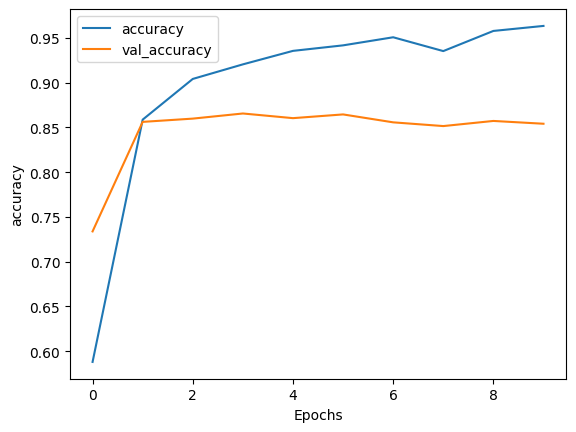

In [27]:
plot_graphs(history, 'accuracy')

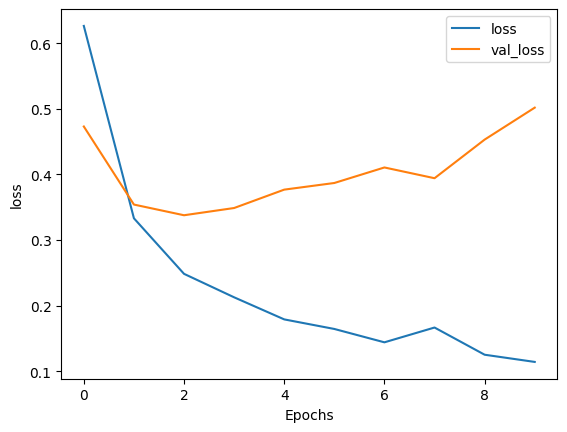

In [28]:
plot_graphs(history, 'loss')

## 堆叠两个或更多 LSTM 层

Keras 循环层有两种可用的模式，这些模式由 `return_sequences` 构造函数参数控制：

- 返回每个时间步骤的连续输出的完整序列（形状为 `(batch_size, timesteps, output_features)` 的 3D 张量）。
- 仅返回每个输入序列的最后一个输出（形状为 (batch_size, output_features) 的 2D 张量）。

In [8]:
model = tf.keras.Sequential([
    tf.keras.layers.Embedding(encoder.vocab_size, 64),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64,  return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32)),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1)
])

In [9]:
model.compile(loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              optimizer=tf.keras.optimizers.Adam(1e-4),
              metrics=['accuracy'])

In [10]:
history = model.fit(train_dataset, epochs=10,
                    validation_data=test_dataset,
                    validation_steps=30)

Epoch 1/10
782/782 [==============================] - 143s 177ms/step - loss: 0.6896 - accuracy: 0.5146 - val_loss: 0.6916 - val_accuracy: 0.4979
Epoch 2/10
782/782 [==============================] - 144s 184ms/step - loss: 0.6923 - accuracy: 0.5000 - val_loss: 0.6932 - val_accuracy: 0.4979
Epoch 3/10
782/782 [==============================] - 143s 183ms/step - loss: 0.6509 - accuracy: 0.5787 - val_loss: 0.5689 - val_accuracy: 0.7354
Epoch 4/10
782/782 [==============================] - 145s 186ms/step - loss: 0.5944 - accuracy: 0.7022 - val_loss: 0.6134 - val_accuracy: 0.6865
Epoch 5/10
782/782 [==============================] - 136s 173ms/step - loss: 0.5358 - accuracy: 0.7560 - val_loss: 0.5459 - val_accuracy: 0.7437
Epoch 6/10
782/782 [==============================] - 133s 171ms/step - loss: 0.4784 - accuracy: 0.7779 - val_loss: 0.4974 - val_accuracy: 0.7896
Epoch 7/10
782/782 [==============================] - 137s 175ms/step - loss: 0.5261 - accuracy: 0.7451 - val_loss: 0.6848 -

  5/391 [..............................] - ETA: 1:19 - loss: 0.6933 - accuracy: 0.5156

  6/391 [..............................] - ETA: 1:16 - loss: 0.6930 - accuracy: 0.5182

  7/391 [..............................] - ETA: 1:18 - loss: 0.6930 - accuracy: 0.5045

  8/391 [..............................] - ETA: 1:18 - loss: 0.6929 - accuracy: 0.5078

  9/391 [..............................] - ETA: 1:21 - loss: 0.6927 - accuracy: 0.5069

 10/391 [..............................] - ETA: 1:20 - loss: 0.6929 - accuracy: 0.5031

 11/391 [..............................] - ETA: 1:21 - loss: 0.6929 - accuracy: 0.5071

 12/391 [..............................] - ETA: 1:23 - loss: 0.6928 - accuracy: 0.5091

 13/391 [..............................] - ETA: 1:20 - loss: 0.6930 - accuracy: 0.5096

 14/391 [>.............................] - ETA: 1:22 - loss: 0.6930 - accuracy: 0.5067

 15/391 [>.............................] - ETA: 1:22 - loss: 0.6929 - accuracy: 0.5094

 16/391 [>.............................] - ETA: 1:25 - loss: 0.6928 - accuracy: 0.5078

 17/391 [>.............................] - ETA: 1:25 - loss: 0.6929 - accuracy: 0.5055

 18/391 [>.............................] - ETA: 1:25 - loss: 0.6929 - accuracy: 0.5095

 19/391 [>.............................] - ETA: 1:25 - loss: 0.6931 - accuracy: 0.5033

 20/391 [>.............................] - ETA: 1:24 - loss: 0.6933 - accuracy: 0.4953

 21/391 [>.............................] - ETA: 1:23 - loss: 0.6932 - accuracy: 0.5000

 22/391 [>.............................] - ETA: 1:24 - loss: 0.6934 - accuracy: 0.4986

 23/391 [>.............................] - ETA: 1:24 - loss: 0.6932 - accuracy: 0.5020

 24/391 [>.............................] - ETA: 1:24 - loss: 0.6931 - accuracy: 0.5033

 25/391 [>.............................] - ETA: 1:23 - loss: 0.6931 - accuracy: 0.5025

 26/391 [>.............................] - ETA: 1:23 - loss: 0.6932 - accuracy: 0.4988

 27/391 [=>............................] - ETA: 1:23 - loss: 0.6932 - accuracy: 0.5006

 28/391 [=>............................] - ETA: 1:22 - loss: 0.6932 - accuracy: 0.5000

 29/391 [=>............................] - ETA: 1:21 - loss: 0.6932 - accuracy: 0.5000

 30/391 [=>............................] - ETA: 1:21 - loss: 0.6932 - accuracy: 0.5036

 31/391 [=>............................] - ETA: 1:21 - loss: 0.6932 - accuracy: 0.5035

 32/391 [=>............................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.5049

 33/391 [=>............................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.5043

 34/391 [=>............................] - ETA: 1:19 - loss: 0.6932 - accuracy: 0.5041

 35/391 [=>............................] - ETA: 1:20 - loss: 0.6932 - accuracy: 0.5031

 36/391 [=>............................] - ETA: 1:20 - loss: 0.6931 - accuracy: 0.5043

 37/391 [=>............................] - ETA: 1:19 - loss: 0.6931 - accuracy: 0.5042

 38/391 [=>............................] - ETA: 1:19 - loss: 0.6931 - accuracy: 0.5082

 39/391 [=>............................] - ETA: 1:18 - loss: 0.6931 - accuracy: 0.5080

 40/391 [==>...........................] - ETA: 1:18 - loss: 0.6931 - accuracy: 0.5078

 41/391 [==>...........................] - ETA: 1:18 - loss: 0.6930 - accuracy: 0.5095

 42/391 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5071

 43/391 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5073

 44/391 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5089

 45/391 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5066

 46/391 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5071

 47/391 [==>...........................] - ETA: 1:17 - loss: 0.6931 - accuracy: 0.5060

 48/391 [==>...........................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5075

 49/391 [==>...........................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5061

 50/391 [==>...........................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5072

 51/391 [==>...........................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5052

 52/391 [==>...........................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5039

 53/391 [===>..........................] - ETA: 1:16 - loss: 0.6931 - accuracy: 0.5038

 54/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.5020

 55/391 [===>..........................] - ETA: 1:16 - loss: 0.6932 - accuracy: 0.5020

 56/391 [===>..........................] - ETA: 1:15 - loss: 0.6932 - accuracy: 0.5014

 57/391 [===>..........................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.4978

 58/391 [===>..........................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.4973

 59/391 [===>..........................] - ETA: 1:15 - loss: 0.6933 - accuracy: 0.4958

 60/391 [===>..........................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.4948

 61/391 [===>..........................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.4962

 62/391 [===>..........................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.4975

 63/391 [===>..........................] - ETA: 1:14 - loss: 0.6933 - accuracy: 0.4968

 64/391 [===>..........................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.4968

 65/391 [===>..........................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.4962

 66/391 [====>.........................] - ETA: 1:13 - loss: 0.6933 - accuracy: 0.4962

 67/391 [====>.........................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.4970

 68/391 [====>.........................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.4961

 69/391 [====>.........................] - ETA: 1:12 - loss: 0.6933 - accuracy: 0.4966

 70/391 [====>.........................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.4980

 71/391 [====>.........................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.4991

 72/391 [====>.........................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.4970

 73/391 [====>.........................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.4961

 74/391 [====>.........................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.4956

 75/391 [====>.........................] - ETA: 1:11 - loss: 0.6933 - accuracy: 0.4946

 76/391 [====>.........................] - ETA: 1:10 - loss: 0.6933 - accuracy: 0.4965

 77/391 [====>.........................] - ETA: 1:10 - loss: 0.6933 - accuracy: 0.4955

 78/391 [====>.........................] - ETA: 1:10 - loss: 0.6933 - accuracy: 0.4962

 79/391 [=====>........................] - ETA: 1:10 - loss: 0.6933 - accuracy: 0.4953

 80/391 [=====>........................] - ETA: 1:09 - loss: 0.6933 - accuracy: 0.4955

 81/391 [=====>........................] - ETA: 1:09 - loss: 0.6933 - accuracy: 0.4965

 82/391 [=====>........................] - ETA: 1:09 - loss: 0.6933 - accuracy: 0.4968

 83/391 [=====>........................] - ETA: 1:09 - loss: 0.6933 - accuracy: 0.4962

 84/391 [=====>........................] - ETA: 1:08 - loss: 0.6933 - accuracy: 0.4959

 85/391 [=====>........................] - ETA: 1:08 - loss: 0.6933 - accuracy: 0.4949

 86/391 [=====>........................] - ETA: 1:08 - loss: 0.6933 - accuracy: 0.4944

 87/391 [=====>........................] - ETA: 1:07 - loss: 0.6933 - accuracy: 0.4937

 88/391 [=====>........................] - ETA: 1:07 - loss: 0.6933 - accuracy: 0.4938

 89/391 [=====>........................] - ETA: 1:07 - loss: 0.6933 - accuracy: 0.4928

 90/391 [=====>........................] - ETA: 1:07 - loss: 0.6933 - accuracy: 0.4924

 91/391 [=====>........................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.4916

 92/391 [======>.......................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.4910

 93/391 [======>.......................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.4919

 94/391 [======>.......................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.4922

 95/391 [======>.......................] - ETA: 1:06 - loss: 0.6932 - accuracy: 0.4916

 96/391 [======>.......................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.4928

 97/391 [======>.......................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.4929

 98/391 [======>.......................] - ETA: 1:05 - loss: 0.6932 - accuracy: 0.4927

 99/391 [======>.......................] - ETA: 1:04 - loss: 0.6932 - accuracy: 0.4926

100/391 [======>.......................] - ETA: 1:04 - loss: 0.6932 - accuracy: 0.4923

101/391 [======>.......................] - ETA: 1:04 - loss: 0.6932 - accuracy: 0.4924

102/391 [======>.......................] - ETA: 1:04 - loss: 0.6932 - accuracy: 0.4930

103/391 [======>.......................] - ETA: 1:04 - loss: 0.6932 - accuracy: 0.4926

104/391 [======>.......................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4917

105/391 [=======>......................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4924

106/391 [=======>......................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4937

107/391 [=======>......................] - ETA: 1:03 - loss: 0.6932 - accuracy: 0.4943

108/391 [=======>......................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4935

109/391 [=======>......................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4940

110/391 [=======>......................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4939

111/391 [=======>......................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4938

112/391 [=======>......................] - ETA: 1:02 - loss: 0.6932 - accuracy: 0.4944

113/391 [=======>......................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4942

114/391 [=======>......................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4937

115/391 [=======>......................] - ETA: 1:01 - loss: 0.6932 - accuracy: 0.4929

116/391 [=======>......................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4934

117/391 [=======>......................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.4932

118/391 [========>.....................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4930

119/391 [========>.....................] - ETA: 1:00 - loss: 0.6932 - accuracy: 0.4944

120/391 [========>.....................] - ETA: 1:00 - loss: 0.6933 - accuracy: 0.4949

121/391 [========>.....................] - ETA: 59s - loss: 0.6933 - accuracy: 0.4956 

122/391 [========>.....................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4950

123/391 [========>.....................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4942

124/391 [========>.....................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4940

125/391 [========>.....................] - ETA: 59s - loss: 0.6932 - accuracy: 0.4946

126/391 [========>.....................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4943

127/391 [========>.....................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4946

128/391 [========>.....................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4948

129/391 [========>.....................] - ETA: 58s - loss: 0.6932 - accuracy: 0.4947

130/391 [========>.....................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4946

131/391 [=========>....................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4948

132/391 [=========>....................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4951

133/391 [=========>....................] - ETA: 57s - loss: 0.6932 - accuracy: 0.4955

134/391 [=========>....................] - ETA: 56s - loss: 0.6932 - accuracy: 0.4950

135/391 [=========>....................] - ETA: 56s - loss: 0.6932 - accuracy: 0.4950

136/391 [=========>....................] - ETA: 56s - loss: 0.6932 - accuracy: 0.4948

137/391 [=========>....................] - ETA: 56s - loss: 0.6932 - accuracy: 0.4948

138/391 [=========>....................] - ETA: 56s - loss: 0.6932 - accuracy: 0.4956

139/391 [=========>....................] - ETA: 55s - loss: 0.6932 - accuracy: 0.4955

140/391 [=========>....................] - ETA: 55s - loss: 0.6932 - accuracy: 0.4949

141/391 [=========>....................] - ETA: 55s - loss: 0.6932 - accuracy: 0.4951

142/391 [=========>....................] - ETA: 55s - loss: 0.6932 - accuracy: 0.4952

143/391 [=========>....................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4949

144/391 [==========>...................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4953

145/391 [==========>...................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4952

146/391 [==========>...................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4952

147/391 [==========>...................] - ETA: 54s - loss: 0.6931 - accuracy: 0.4953

148/391 [==========>...................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4956

149/391 [==========>...................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4959

150/391 [==========>...................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4957

151/391 [==========>...................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4961

152/391 [==========>...................] - ETA: 53s - loss: 0.6931 - accuracy: 0.4961

153/391 [==========>...................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4958

154/391 [==========>...................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4966

155/391 [==========>...................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4972

156/391 [==========>...................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4980

157/391 [===========>..................] - ETA: 52s - loss: 0.6931 - accuracy: 0.4976

158/391 [===========>..................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4971

159/391 [===========>..................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4972

160/391 [===========>..................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4962

161/391 [===========>..................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4967

162/391 [===========>..................] - ETA: 51s - loss: 0.6931 - accuracy: 0.4971

163/391 [===========>..................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4972

164/391 [===========>..................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4974

165/391 [===========>..................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4969

166/391 [===========>..................] - ETA: 50s - loss: 0.6931 - accuracy: 0.4969

167/391 [===========>..................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4969

168/391 [===========>..................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4977

169/391 [===========>..................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4984

170/391 [============>.................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4983

171/391 [============>.................] - ETA: 49s - loss: 0.6931 - accuracy: 0.4981

172/391 [============>.................] - ETA: 48s - loss: 0.6931 - accuracy: 0.4984

173/391 [============>.................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4983

174/391 [============>.................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4979

175/391 [============>.................] - ETA: 48s - loss: 0.6930 - accuracy: 0.4977

176/391 [============>.................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4974

177/391 [============>.................] - ETA: 47s - loss: 0.6931 - accuracy: 0.4972

178/391 [============>.................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4968

179/391 [============>.................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4971

180/391 [============>.................] - ETA: 47s - loss: 0.6930 - accuracy: 0.4973

181/391 [============>.................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4975

182/391 [============>.................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4977

183/391 [=============>................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4980

184/391 [=============>................] - ETA: 46s - loss: 0.6930 - accuracy: 0.4984

185/391 [=============>................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4983

186/391 [=============>................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4981

187/391 [=============>................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4977

188/391 [=============>................] - ETA: 45s - loss: 0.6930 - accuracy: 0.4976

189/391 [=============>................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4975

190/391 [=============>................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4979

191/391 [=============>................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4986

192/391 [=============>................] - ETA: 44s - loss: 0.6930 - accuracy: 0.4980

193/391 [=============>................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4981

194/391 [=============>................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4981

195/391 [=============>................] - ETA: 43s - loss: 0.6930 - accuracy: 0.4977

196/391 [==============>...............] - ETA: 43s - loss: 0.6929 - accuracy: 0.4978

197/391 [==============>...............] - ETA: 43s - loss: 0.6929 - accuracy: 0.4984

198/391 [==============>...............] - ETA: 42s - loss: 0.6929 - accuracy: 0.4982

199/391 [==============>...............] - ETA: 42s - loss: 0.6929 - accuracy: 0.4981

200/391 [==============>...............] - ETA: 42s - loss: 0.6929 - accuracy: 0.4982

201/391 [==============>...............] - ETA: 42s - loss: 0.6929 - accuracy: 0.4979

202/391 [==============>...............] - ETA: 42s - loss: 0.6929 - accuracy: 0.4985

203/391 [==============>...............] - ETA: 41s - loss: 0.6929 - accuracy: 0.4990

204/391 [==============>...............] - ETA: 41s - loss: 0.6929 - accuracy: 0.4989

205/391 [==============>...............] - ETA: 41s - loss: 0.6929 - accuracy: 0.4992

206/391 [==============>...............] - ETA: 41s - loss: 0.6929 - accuracy: 0.4991

207/391 [==============>...............] - ETA: 40s - loss: 0.6929 - accuracy: 0.4997

208/391 [==============>...............] - ETA: 40s - loss: 0.6929 - accuracy: 0.4998

209/391 [===============>..............] - ETA: 40s - loss: 0.6929 - accuracy: 0.4997

210/391 [===============>..............] - ETA: 40s - loss: 0.6928 - accuracy: 0.4998

211/391 [===============>..............] - ETA: 40s - loss: 0.6928 - accuracy: 0.4998

212/391 [===============>..............] - ETA: 39s - loss: 0.6928 - accuracy: 0.4998

213/391 [===============>..............] - ETA: 39s - loss: 0.6928 - accuracy: 0.4997

214/391 [===============>..............] - ETA: 39s - loss: 0.6928 - accuracy: 0.4997

215/391 [===============>..............] - ETA: 39s - loss: 0.6928 - accuracy: 0.4998

216/391 [===============>..............] - ETA: 38s - loss: 0.6928 - accuracy: 0.5000

217/391 [===============>..............] - ETA: 38s - loss: 0.6928 - accuracy: 0.5000

218/391 [===============>..............] - ETA: 38s - loss: 0.6927 - accuracy: 0.5001

219/391 [===============>..............] - ETA: 38s - loss: 0.6927 - accuracy: 0.5000

220/391 [===============>..............] - ETA: 38s - loss: 0.6927 - accuracy: 0.5000

221/391 [===============>..............] - ETA: 37s - loss: 0.6927 - accuracy: 0.4999

222/391 [================>.............] - ETA: 37s - loss: 0.6927 - accuracy: 0.5002

223/391 [================>.............] - ETA: 37s - loss: 0.6927 - accuracy: 0.5006

224/391 [================>.............] - ETA: 37s - loss: 0.6927 - accuracy: 0.5013

225/391 [================>.............] - ETA: 36s - loss: 0.6927 - accuracy: 0.5008

226/391 [================>.............] - ETA: 36s - loss: 0.6927 - accuracy: 0.5002

227/391 [================>.............] - ETA: 36s - loss: 0.6926 - accuracy: 0.5003

228/391 [================>.............] - ETA: 36s - loss: 0.6926 - accuracy: 0.4999

229/391 [================>.............] - ETA: 36s - loss: 0.6926 - accuracy: 0.5002

230/391 [================>.............] - ETA: 35s - loss: 0.6926 - accuracy: 0.5001

231/391 [================>.............] - ETA: 35s - loss: 0.6926 - accuracy: 0.5001

232/391 [================>.............] - ETA: 35s - loss: 0.6926 - accuracy: 0.5001

233/391 [================>.............] - ETA: 35s - loss: 0.6926 - accuracy: 0.5002

234/391 [================>.............] - ETA: 34s - loss: 0.6925 - accuracy: 0.5005

235/391 [=================>............] - ETA: 34s - loss: 0.6925 - accuracy: 0.5005

236/391 [=================>............] - ETA: 34s - loss: 0.6925 - accuracy: 0.5007

237/391 [=================>............] - ETA: 34s - loss: 0.6925 - accuracy: 0.5010

238/391 [=================>............] - ETA: 34s - loss: 0.6925 - accuracy: 0.5009

239/391 [=================>............] - ETA: 33s - loss: 0.6925 - accuracy: 0.5005

240/391 [=================>............] - ETA: 33s - loss: 0.6924 - accuracy: 0.5003

241/391 [=================>............] - ETA: 33s - loss: 0.6924 - accuracy: 0.5006

242/391 [=================>............] - ETA: 33s - loss: 0.6924 - accuracy: 0.5005

243/391 [=================>............] - ETA: 33s - loss: 0.6924 - accuracy: 0.5004

244/391 [=================>............] - ETA: 32s - loss: 0.6924 - accuracy: 0.5000

245/391 [=================>............] - ETA: 32s - loss: 0.6924 - accuracy: 0.4998

246/391 [=================>............] - ETA: 32s - loss: 0.6923 - accuracy: 0.5001

247/391 [=================>............] - ETA: 32s - loss: 0.6923 - accuracy: 0.5003

248/391 [==================>...........] - ETA: 31s - loss: 0.6923 - accuracy: 0.5003

249/391 [==================>...........] - ETA: 31s - loss: 0.6923 - accuracy: 0.5004

250/391 [==================>...........] - ETA: 31s - loss: 0.6923 - accuracy: 0.5006

251/391 [==================>...........] - ETA: 31s - loss: 0.6922 - accuracy: 0.5002

252/391 [==================>...........] - ETA: 31s - loss: 0.6922 - accuracy: 0.5002

253/391 [==================>...........] - ETA: 30s - loss: 0.6922 - accuracy: 0.5002

254/391 [==================>...........] - ETA: 30s - loss: 0.6921 - accuracy: 0.5003

255/391 [==================>...........] - ETA: 30s - loss: 0.6921 - accuracy: 0.5005

256/391 [==================>...........] - ETA: 30s - loss: 0.6921 - accuracy: 0.5010

257/391 [==================>...........] - ETA: 30s - loss: 0.6920 - accuracy: 0.5016

258/391 [==================>...........] - ETA: 29s - loss: 0.6920 - accuracy: 0.5012

259/391 [==================>...........] - ETA: 29s - loss: 0.6919 - accuracy: 0.5010

260/391 [==================>...........] - ETA: 29s - loss: 0.6919 - accuracy: 0.5009

261/391 [===================>..........] - ETA: 29s - loss: 0.6918 - accuracy: 0.5011

262/391 [===================>..........] - ETA: 28s - loss: 0.6917 - accuracy: 0.5013

263/391 [===================>..........] - ETA: 28s - loss: 0.6916 - accuracy: 0.5011

264/391 [===================>..........] - ETA: 28s - loss: 0.6915 - accuracy: 0.5012

265/391 [===================>..........] - ETA: 28s - loss: 0.6914 - accuracy: 0.5010

266/391 [===================>..........] - ETA: 28s - loss: 0.6913 - accuracy: 0.5008

267/391 [===================>..........] - ETA: 27s - loss: 0.6912 - accuracy: 0.5013

268/391 [===================>..........] - ETA: 27s - loss: 0.6911 - accuracy: 0.5013

269/391 [===================>..........] - ETA: 27s - loss: 0.6910 - accuracy: 0.5017

270/391 [===================>..........] - ETA: 27s - loss: 0.6908 - accuracy: 0.5020

271/391 [===================>..........] - ETA: 27s - loss: 0.6905 - accuracy: 0.5025

272/391 [===================>..........] - ETA: 26s - loss: 0.6904 - accuracy: 0.5026

273/391 [===================>..........] - ETA: 26s - loss: 0.6902 - accuracy: 0.5025

274/391 [====================>.........] - ETA: 26s - loss: 0.6900 - accuracy: 0.5025

275/391 [====================>.........] - ETA: 26s - loss: 0.6898 - accuracy: 0.5024

276/391 [====================>.........] - ETA: 25s - loss: 0.6895 - accuracy: 0.5027

277/391 [====================>.........] - ETA: 25s - loss: 0.6897 - accuracy: 0.5033

278/391 [====================>.........] - ETA: 25s - loss: 0.6895 - accuracy: 0.5039

279/391 [====================>.........] - ETA: 25s - loss: 0.6892 - accuracy: 0.5042

280/391 [====================>.........] - ETA: 25s - loss: 0.6891 - accuracy: 0.5045

281/391 [====================>.........] - ETA: 24s - loss: 0.6887 - accuracy: 0.5044

282/391 [====================>.........] - ETA: 24s - loss: 0.6886 - accuracy: 0.5043

283/391 [====================>.........] - ETA: 24s - loss: 0.6882 - accuracy: 0.5048

284/391 [====================>.........] - ETA: 24s - loss: 0.6878 - accuracy: 0.5054

285/391 [====================>.........] - ETA: 23s - loss: 0.6876 - accuracy: 0.5060

286/391 [====================>.........] - ETA: 23s - loss: 0.6873 - accuracy: 0.5063

287/391 [=====================>........] - ETA: 23s - loss: 0.6868 - accuracy: 0.5068

288/391 [=====================>........] - ETA: 23s - loss: 0.6864 - accuracy: 0.5075

289/391 [=====================>........] - ETA: 23s - loss: 0.6860 - accuracy: 0.5081

290/391 [=====================>........] - ETA: 23s - loss: 0.6856 - accuracy: 0.5082

291/391 [=====================>........] - ETA: 22s - loss: 0.6853 - accuracy: 0.5084

292/391 [=====================>........] - ETA: 22s - loss: 0.6849 - accuracy: 0.5088

293/391 [=====================>........] - ETA: 22s - loss: 0.6846 - accuracy: 0.5096

294/391 [=====================>........] - ETA: 22s - loss: 0.6840 - accuracy: 0.5104

295/391 [=====================>........] - ETA: 21s - loss: 0.6838 - accuracy: 0.5111

296/391 [=====================>........] - ETA: 21s - loss: 0.6832 - accuracy: 0.5121

297/391 [=====================>........] - ETA: 21s - loss: 0.6830 - accuracy: 0.5126

298/391 [=====================>........] - ETA: 21s - loss: 0.6829 - accuracy: 0.5132

299/391 [=====================>........] - ETA: 20s - loss: 0.6827 - accuracy: 0.5138

300/391 [======================>.......] - ETA: 20s - loss: 0.6829 - accuracy: 0.5140

301/391 [======================>.......] - ETA: 20s - loss: 0.6825 - accuracy: 0.5147

302/391 [======================>.......] - ETA: 20s - loss: 0.6822 - accuracy: 0.5151

303/391 [======================>.......] - ETA: 20s - loss: 0.6819 - accuracy: 0.5155

304/391 [======================>.......] - ETA: 19s - loss: 0.6813 - accuracy: 0.5167

305/391 [======================>.......] - ETA: 19s - loss: 0.6806 - accuracy: 0.5170

306/391 [======================>.......] - ETA: 19s - loss: 0.6802 - accuracy: 0.5177

307/391 [======================>.......] - ETA: 19s - loss: 0.6799 - accuracy: 0.5186

308/391 [======================>.......] - ETA: 18s - loss: 0.6792 - accuracy: 0.5192

309/391 [======================>.......] - ETA: 18s - loss: 0.6786 - accuracy: 0.5201

310/391 [======================>.......] - ETA: 18s - loss: 0.6782 - accuracy: 0.5209

311/391 [======================>.......] - ETA: 18s - loss: 0.6775 - accuracy: 0.5217

312/391 [======================>.......] - ETA: 17s - loss: 0.6770 - accuracy: 0.5223

313/391 [=======================>......] - ETA: 17s - loss: 0.6763 - accuracy: 0.5231

314/391 [=======================>......] - ETA: 17s - loss: 0.6758 - accuracy: 0.5238

315/391 [=======================>......] - ETA: 17s - loss: 0.6752 - accuracy: 0.5247

316/391 [=======================>......] - ETA: 17s - loss: 0.6752 - accuracy: 0.5250

317/391 [=======================>......] - ETA: 16s - loss: 0.6746 - accuracy: 0.5259

318/391 [=======================>......] - ETA: 16s - loss: 0.6736 - accuracy: 0.5270

319/391 [=======================>......] - ETA: 16s - loss: 0.6731 - accuracy: 0.5280

320/391 [=======================>......] - ETA: 16s - loss: 0.6723 - accuracy: 0.5289

321/391 [=======================>......] - ETA: 15s - loss: 0.6718 - accuracy: 0.5296

322/391 [=======================>......] - ETA: 15s - loss: 0.6716 - accuracy: 0.5301

323/391 [=======================>......] - ETA: 15s - loss: 0.6711 - accuracy: 0.5308

324/391 [=======================>......] - ETA: 15s - loss: 0.6706 - accuracy: 0.5317

325/391 [=======================>......] - ETA: 14s - loss: 0.6700 - accuracy: 0.5325

326/391 [========================>.....] - ETA: 14s - loss: 0.6696 - accuracy: 0.5331

327/391 [========================>.....] - ETA: 14s - loss: 0.6689 - accuracy: 0.5340

328/391 [========================>.....] - ETA: 14s - loss: 0.6682 - accuracy: 0.5348

329/391 [========================>.....] - ETA: 14s - loss: 0.6678 - accuracy: 0.5353

330/391 [========================>.....] - ETA: 13s - loss: 0.6670 - accuracy: 0.5360

331/391 [========================>.....] - ETA: 13s - loss: 0.6663 - accuracy: 0.5368

332/391 [========================>.....] - ETA: 13s - loss: 0.6659 - accuracy: 0.5376

333/391 [========================>.....] - ETA: 13s - loss: 0.6652 - accuracy: 0.5382

334/391 [========================>.....] - ETA: 12s - loss: 0.6649 - accuracy: 0.5387

335/391 [========================>.....] - ETA: 12s - loss: 0.6643 - accuracy: 0.5396

336/391 [========================>.....] - ETA: 12s - loss: 0.6636 - accuracy: 0.5404

337/391 [========================>.....] - ETA: 12s - loss: 0.6633 - accuracy: 0.5410

338/391 [========================>.....] - ETA: 12s - loss: 0.6627 - accuracy: 0.5418

339/391 [=========================>....] - ETA: 11s - loss: 0.6623 - accuracy: 0.5425

340/391 [=========================>....] - ETA: 11s - loss: 0.6617 - accuracy: 0.5432

341/391 [=========================>....] - ETA: 11s - loss: 0.6611 - accuracy: 0.5439

342/391 [=========================>....] - ETA: 11s - loss: 0.6605 - accuracy: 0.5446

343/391 [=========================>....] - ETA: 10s - loss: 0.6601 - accuracy: 0.5453

344/391 [=========================>....] - ETA: 10s - loss: 0.6598 - accuracy: 0.5458

345/391 [=========================>....] - ETA: 10s - loss: 0.6595 - accuracy: 0.5462

346/391 [=========================>....] - ETA: 10s - loss: 0.6589 - accuracy: 0.5469

347/391 [=========================>....] - ETA: 10s - loss: 0.6581 - accuracy: 0.5477

348/391 [=========================>....] - ETA: 9s - loss: 0.6577 - accuracy: 0.5485 

349/391 [=========================>....] - ETA: 9s - loss: 0.6572 - accuracy: 0.5492

350/391 [=========================>....] - ETA: 9s - loss: 0.6571 - accuracy: 0.5494

351/391 [=========================>....] - ETA: 9s - loss: 0.6567 - accuracy: 0.5501

352/391 [==========================>...] - ETA: 8s - loss: 0.6564 - accuracy: 0.5507

353/391 [==========================>...] - ETA: 8s - loss: 0.6561 - accuracy: 0.5513

354/391 [==========================>...] - ETA: 8s - loss: 0.6559 - accuracy: 0.5517

355/391 [==========================>...] - ETA: 8s - loss: 0.6555 - accuracy: 0.5522

356/391 [==========================>...] - ETA: 7s - loss: 0.6551 - accuracy: 0.5527

357/391 [==========================>...] - ETA: 7s - loss: 0.6546 - accuracy: 0.5532

358/391 [==========================>...] - ETA: 7s - loss: 0.6541 - accuracy: 0.5539

359/391 [==========================>...] - ETA: 7s - loss: 0.6538 - accuracy: 0.5544

360/391 [==========================>...] - ETA: 7s - loss: 0.6532 - accuracy: 0.5551

361/391 [==========================>...] - ETA: 6s - loss: 0.6527 - accuracy: 0.5557

362/391 [==========================>...] - ETA: 6s - loss: 0.6525 - accuracy: 0.5561

363/391 [==========================>...] - ETA: 6s - loss: 0.6519 - accuracy: 0.5565

364/391 [==========================>...] - ETA: 6s - loss: 0.6512 - accuracy: 0.5573

365/391 [===========================>..] - ETA: 5s - loss: 0.6507 - accuracy: 0.5578

366/391 [===========================>..] - ETA: 5s - loss: 0.6501 - accuracy: 0.5585

367/391 [===========================>..] - ETA: 5s - loss: 0.6497 - accuracy: 0.5592

368/391 [===========================>..] - ETA: 5s - loss: 0.6490 - accuracy: 0.5599

369/391 [===========================>..] - ETA: 5s - loss: 0.6488 - accuracy: 0.5605

370/391 [===========================>..] - ETA: 4s - loss: 0.6480 - accuracy: 0.5612

371/391 [===========================>..] - ETA: 4s - loss: 0.6476 - accuracy: 0.5617

372/391 [===========================>..] - ETA: 4s - loss: 0.6474 - accuracy: 0.5622

373/391 [===========================>..] - ETA: 4s - loss: 0.6467 - accuracy: 0.5630

374/391 [===========================>..] - ETA: 3s - loss: 0.6466 - accuracy: 0.5635

375/391 [===========================>..] - ETA: 3s - loss: 0.6458 - accuracy: 0.5643

376/391 [===========================>..] - ETA: 3s - loss: 0.6455 - accuracy: 0.5649

377/391 [===========================>..] - ETA: 3s - loss: 0.6454 - accuracy: 0.5653

378/391 [============================>.] - ETA: 2s - loss: 0.6450 - accuracy: 0.5659

379/391 [============================>.] - ETA: 2s - loss: 0.6446 - accuracy: 0.5664

380/391 [============================>.] - ETA: 2s - loss: 0.6443 - accuracy: 0.5668

381/391 [============================>.] - ETA: 2s - loss: 0.6441 - accuracy: 0.5673

382/391 [============================>.] - ETA: 2s - loss: 0.6435 - accuracy: 0.5679

383/391 [============================>.] - ETA: 1s - loss: 0.6432 - accuracy: 0.5684

384/391 [============================>.] - ETA: 1s - loss: 0.6430 - accuracy: 0.5686

385/391 [============================>.] - ETA: 1s - loss: 0.6428 - accuracy: 0.5691

386/391 [============================>.] - ETA: 1s - loss: 0.6425 - accuracy: 0.5693

387/391 [============================>.] - ETA: 0s - loss: 0.6421 - accuracy: 0.5698

388/391 [============================>.] - ETA: 0s - loss: 0.6419 - accuracy: 0.5700

389/391 [============================>.] - ETA: 0s - loss: 0.6414 - accuracy: 0.5705

390/391 [============================>.] - ETA: 0s - loss: 0.6408 - accuracy: 0.5711

391/391 [==============================] - ETA: 0s - loss: 0.6406 - accuracy: 0.5714

391/391 [==============================] - 101s 241ms/step - loss: 0.6406 - accuracy: 0.5714 - val_loss: 0.4741 - val_accuracy: 0.7552


Epoch 2/10


  1/391 [..............................] - ETA: 3:27 - loss: 0.3732 - accuracy: 0.8438

  2/391 [..............................] - ETA: 56s - loss: 0.4270 - accuracy: 0.8125 

  3/391 [..............................] - ETA: 1:14 - loss: 0.4433 - accuracy: 0.7917

  4/391 [..............................] - ETA: 1:25 - loss: 0.4249 - accuracy: 0.8125

  5/391 [..............................] - ETA: 1:26 - loss: 0.4267 - accuracy: 0.8062

  6/391 [..............................] - ETA: 1:23 - loss: 0.4250 - accuracy: 0.8073

  7/391 [..............................] - ETA: 1:27 - loss: 0.4170 - accuracy: 0.8147

  8/391 [..............................] - ETA: 1:23 - loss: 0.4262 - accuracy: 0.8027

  9/391 [..............................] - ETA: 1:25 - loss: 0.4228 - accuracy: 0.8073

 10/391 [..............................] - ETA: 1:25 - loss: 0.4159 - accuracy: 0.8125

 11/391 [..............................] - ETA: 1:26 - loss: 0.4044 - accuracy: 0.8210

 12/391 [..............................] - ETA: 1:26 - loss: 0.4001 - accuracy: 0.8229

 13/391 [..............................] - ETA: 1:27 - loss: 0.3928 - accuracy: 0.8245

 14/391 [>.............................] - ETA: 1:26 - loss: 0.4015 - accuracy: 0.8225

 15/391 [>.............................] - ETA: 1:26 - loss: 0.4054 - accuracy: 0.8219

 16/391 [>.............................] - ETA: 1:25 - loss: 0.4079 - accuracy: 0.8184

 17/391 [>.............................] - ETA: 1:23 - loss: 0.4097 - accuracy: 0.8199

 18/391 [>.............................] - ETA: 1:24 - loss: 0.4122 - accuracy: 0.8186

 19/391 [>.............................] - ETA: 1:23 - loss: 0.4098 - accuracy: 0.8215

 20/391 [>.............................] - ETA: 1:23 - loss: 0.4113 - accuracy: 0.8227

 21/391 [>.............................] - ETA: 1:22 - loss: 0.4068 - accuracy: 0.8266

 22/391 [>.............................] - ETA: 1:22 - loss: 0.4078 - accuracy: 0.8267

 23/391 [>.............................] - ETA: 1:22 - loss: 0.4053 - accuracy: 0.8274

 24/391 [>.............................] - ETA: 1:22 - loss: 0.4048 - accuracy: 0.8275

 25/391 [>.............................] - ETA: 1:22 - loss: 0.4085 - accuracy: 0.8256

 26/391 [>.............................] - ETA: 1:21 - loss: 0.4079 - accuracy: 0.8263

 27/391 [=>............................] - ETA: 1:21 - loss: 0.4123 - accuracy: 0.8247

 28/391 [=>............................] - ETA: 1:20 - loss: 0.4090 - accuracy: 0.8253

 29/391 [=>............................] - ETA: 1:20 - loss: 0.4066 - accuracy: 0.8260

 30/391 [=>............................] - ETA: 1:20 - loss: 0.4070 - accuracy: 0.8260

 31/391 [=>............................] - ETA: 1:20 - loss: 0.4069 - accuracy: 0.8276

 32/391 [=>............................] - ETA: 1:20 - loss: 0.4092 - accuracy: 0.8276

 33/391 [=>............................] - ETA: 1:19 - loss: 0.4078 - accuracy: 0.8286

 34/391 [=>............................] - ETA: 1:19 - loss: 0.4076 - accuracy: 0.8286

 35/391 [=>............................] - ETA: 1:19 - loss: 0.4045 - accuracy: 0.8313

 36/391 [=>............................] - ETA: 1:19 - loss: 0.4048 - accuracy: 0.8312

 37/391 [=>............................] - ETA: 1:19 - loss: 0.4082 - accuracy: 0.8294

 38/391 [=>............................] - ETA: 1:19 - loss: 0.4085 - accuracy: 0.8277

 39/391 [=>............................] - ETA: 1:19 - loss: 0.4100 - accuracy: 0.8265

 40/391 [==>...........................] - ETA: 1:19 - loss: 0.4068 - accuracy: 0.8289

 41/391 [==>...........................] - ETA: 1:19 - loss: 0.4058 - accuracy: 0.8296

 42/391 [==>...........................] - ETA: 1:19 - loss: 0.4080 - accuracy: 0.8278

 43/391 [==>...........................] - ETA: 1:19 - loss: 0.4057 - accuracy: 0.8285

 44/391 [==>...........................] - ETA: 1:18 - loss: 0.4079 - accuracy: 0.8271

 45/391 [==>...........................] - ETA: 1:18 - loss: 0.4065 - accuracy: 0.8288

 46/391 [==>...........................] - ETA: 1:18 - loss: 0.4077 - accuracy: 0.8285

 47/391 [==>...........................] - ETA: 1:18 - loss: 0.4075 - accuracy: 0.8278

 48/391 [==>...........................] - ETA: 1:17 - loss: 0.4077 - accuracy: 0.8275

 49/391 [==>...........................] - ETA: 1:17 - loss: 0.4071 - accuracy: 0.8278

 50/391 [==>...........................] - ETA: 1:17 - loss: 0.4121 - accuracy: 0.8266

 51/391 [==>...........................] - ETA: 1:18 - loss: 0.4135 - accuracy: 0.8263

 52/391 [==>...........................] - ETA: 1:18 - loss: 0.4130 - accuracy: 0.8263

 53/391 [===>..........................] - ETA: 1:17 - loss: 0.4124 - accuracy: 0.8269

 54/391 [===>..........................] - ETA: 1:17 - loss: 0.4121 - accuracy: 0.8267

 55/391 [===>..........................] - ETA: 1:17 - loss: 0.4123 - accuracy: 0.8267

 56/391 [===>..........................] - ETA: 1:17 - loss: 0.4138 - accuracy: 0.8265

 57/391 [===>..........................] - ETA: 1:17 - loss: 0.4148 - accuracy: 0.8262

 58/391 [===>..........................] - ETA: 1:17 - loss: 0.4151 - accuracy: 0.8257

 59/391 [===>..........................] - ETA: 1:16 - loss: 0.4151 - accuracy: 0.8255

 60/391 [===>..........................] - ETA: 1:16 - loss: 0.4146 - accuracy: 0.8250

 61/391 [===>..........................] - ETA: 1:16 - loss: 0.4171 - accuracy: 0.8243

 62/391 [===>..........................] - ETA: 1:16 - loss: 0.4171 - accuracy: 0.8251

 63/391 [===>..........................] - ETA: 1:15 - loss: 0.4149 - accuracy: 0.8264

 64/391 [===>..........................] - ETA: 1:15 - loss: 0.4149 - accuracy: 0.8257

 65/391 [===>..........................] - ETA: 1:15 - loss: 0.4159 - accuracy: 0.8248

 66/391 [====>.........................] - ETA: 1:15 - loss: 0.4144 - accuracy: 0.8255

 67/391 [====>.........................] - ETA: 1:15 - loss: 0.4136 - accuracy: 0.8258

 68/391 [====>.........................] - ETA: 1:15 - loss: 0.4144 - accuracy: 0.8256

 69/391 [====>.........................] - ETA: 1:14 - loss: 0.4131 - accuracy: 0.8268

 70/391 [====>.........................] - ETA: 1:14 - loss: 0.4114 - accuracy: 0.8286

 71/391 [====>.........................] - ETA: 1:14 - loss: 0.4120 - accuracy: 0.8281

 72/391 [====>.........................] - ETA: 1:13 - loss: 0.4115 - accuracy: 0.8281

 73/391 [====>.........................] - ETA: 1:13 - loss: 0.4108 - accuracy: 0.8286

 74/391 [====>.........................] - ETA: 1:13 - loss: 0.4108 - accuracy: 0.8283

 75/391 [====>.........................] - ETA: 1:13 - loss: 0.4110 - accuracy: 0.8283

 76/391 [====>.........................] - ETA: 1:13 - loss: 0.4095 - accuracy: 0.8294

 77/391 [====>.........................] - ETA: 1:12 - loss: 0.4082 - accuracy: 0.8300

 78/391 [====>.........................] - ETA: 1:12 - loss: 0.4074 - accuracy: 0.8303

 79/391 [=====>........................] - ETA: 1:12 - loss: 0.4070 - accuracy: 0.8301

 80/391 [=====>........................] - ETA: 1:12 - loss: 0.4060 - accuracy: 0.8307

 81/391 [=====>........................] - ETA: 1:12 - loss: 0.4058 - accuracy: 0.8306

 82/391 [=====>........................] - ETA: 1:12 - loss: 0.4077 - accuracy: 0.8302

 83/391 [=====>........................] - ETA: 1:12 - loss: 0.4079 - accuracy: 0.8308

 84/391 [=====>........................] - ETA: 1:11 - loss: 0.4091 - accuracy: 0.8302

 85/391 [=====>........................] - ETA: 1:11 - loss: 0.4094 - accuracy: 0.8301

 86/391 [=====>........................] - ETA: 1:11 - loss: 0.4104 - accuracy: 0.8303

 87/391 [=====>........................] - ETA: 1:11 - loss: 0.4112 - accuracy: 0.8299

 88/391 [=====>........................] - ETA: 1:10 - loss: 0.4125 - accuracy: 0.8290

 89/391 [=====>........................] - ETA: 1:10 - loss: 0.4120 - accuracy: 0.8294

 90/391 [=====>........................] - ETA: 1:10 - loss: 0.4128 - accuracy: 0.8288

 91/391 [=====>........................] - ETA: 1:10 - loss: 0.4131 - accuracy: 0.8288

 92/391 [======>.......................] - ETA: 1:09 - loss: 0.4127 - accuracy: 0.8286

 93/391 [======>.......................] - ETA: 1:09 - loss: 0.4128 - accuracy: 0.8280

 94/391 [======>.......................] - ETA: 1:09 - loss: 0.4124 - accuracy: 0.8283

 95/391 [======>.......................] - ETA: 1:09 - loss: 0.4122 - accuracy: 0.8285

 96/391 [======>.......................] - ETA: 1:09 - loss: 0.4131 - accuracy: 0.8278

 97/391 [======>.......................] - ETA: 1:08 - loss: 0.4136 - accuracy: 0.8273

 98/391 [======>.......................] - ETA: 1:08 - loss: 0.4148 - accuracy: 0.8254

 99/391 [======>.......................] - ETA: 1:08 - loss: 0.4149 - accuracy: 0.8253

100/391 [======>.......................] - ETA: 1:07 - loss: 0.4152 - accuracy: 0.8255

101/391 [======>.......................] - ETA: 1:07 - loss: 0.4152 - accuracy: 0.8249

102/391 [======>.......................] - ETA: 1:07 - loss: 0.4150 - accuracy: 0.8251

103/391 [======>.......................] - ETA: 1:07 - loss: 0.4145 - accuracy: 0.8257

104/391 [======>.......................] - ETA: 1:06 - loss: 0.4141 - accuracy: 0.8260

105/391 [=======>......................] - ETA: 1:06 - loss: 0.4140 - accuracy: 0.8257

106/391 [=======>......................] - ETA: 1:06 - loss: 0.4134 - accuracy: 0.8262

107/391 [=======>......................] - ETA: 1:06 - loss: 0.4125 - accuracy: 0.8267

108/391 [=======>......................] - ETA: 1:06 - loss: 0.4111 - accuracy: 0.8275

109/391 [=======>......................] - ETA: 1:06 - loss: 0.4112 - accuracy: 0.8271

110/391 [=======>......................] - ETA: 1:05 - loss: 0.4108 - accuracy: 0.8270

111/391 [=======>......................] - ETA: 1:05 - loss: 0.4105 - accuracy: 0.8271

112/391 [=======>......................] - ETA: 1:05 - loss: 0.4108 - accuracy: 0.8270

113/391 [=======>......................] - ETA: 1:05 - loss: 0.4111 - accuracy: 0.8267

114/391 [=======>......................] - ETA: 1:05 - loss: 0.4105 - accuracy: 0.8270

115/391 [=======>......................] - ETA: 1:04 - loss: 0.4102 - accuracy: 0.8272

116/391 [=======>......................] - ETA: 1:04 - loss: 0.4095 - accuracy: 0.8276

117/391 [=======>......................] - ETA: 1:04 - loss: 0.4102 - accuracy: 0.8273

118/391 [========>.....................] - ETA: 1:03 - loss: 0.4088 - accuracy: 0.8281

119/391 [========>.....................] - ETA: 1:03 - loss: 0.4088 - accuracy: 0.8284

120/391 [========>.....................] - ETA: 1:03 - loss: 0.4097 - accuracy: 0.8279

121/391 [========>.....................] - ETA: 1:02 - loss: 0.4095 - accuracy: 0.8280

122/391 [========>.....................] - ETA: 1:02 - loss: 0.4097 - accuracy: 0.8281

123/391 [========>.....................] - ETA: 1:02 - loss: 0.4095 - accuracy: 0.8281

124/391 [========>.....................] - ETA: 1:02 - loss: 0.4092 - accuracy: 0.8284

125/391 [========>.....................] - ETA: 1:02 - loss: 0.4081 - accuracy: 0.8292

126/391 [========>.....................] - ETA: 1:01 - loss: 0.4070 - accuracy: 0.8297

127/391 [========>.....................] - ETA: 1:01 - loss: 0.4066 - accuracy: 0.8297

128/391 [========>.....................] - ETA: 1:01 - loss: 0.4072 - accuracy: 0.8292

129/391 [========>.....................] - ETA: 1:01 - loss: 0.4078 - accuracy: 0.8289

130/391 [========>.....................] - ETA: 1:01 - loss: 0.4063 - accuracy: 0.8297

131/391 [=========>....................] - ETA: 1:00 - loss: 0.4063 - accuracy: 0.8299

132/391 [=========>....................] - ETA: 1:00 - loss: 0.4064 - accuracy: 0.8298

133/391 [=========>....................] - ETA: 1:00 - loss: 0.4064 - accuracy: 0.8297

134/391 [=========>....................] - ETA: 1:00 - loss: 0.4070 - accuracy: 0.8295

135/391 [=========>....................] - ETA: 1:00 - loss: 0.4067 - accuracy: 0.8295

136/391 [=========>....................] - ETA: 59s - loss: 0.4070 - accuracy: 0.8294 

137/391 [=========>....................] - ETA: 59s - loss: 0.4065 - accuracy: 0.8296

138/391 [=========>....................] - ETA: 59s - loss: 0.4055 - accuracy: 0.8302

139/391 [=========>....................] - ETA: 59s - loss: 0.4052 - accuracy: 0.8305

140/391 [=========>....................] - ETA: 58s - loss: 0.4048 - accuracy: 0.8308

141/391 [=========>....................] - ETA: 58s - loss: 0.4056 - accuracy: 0.8305

142/391 [=========>....................] - ETA: 58s - loss: 0.4053 - accuracy: 0.8308

143/391 [=========>....................] - ETA: 58s - loss: 0.4048 - accuracy: 0.8312

144/391 [==========>...................] - ETA: 58s - loss: 0.4042 - accuracy: 0.8314

145/391 [==========>...................] - ETA: 57s - loss: 0.4038 - accuracy: 0.8317

146/391 [==========>...................] - ETA: 57s - loss: 0.4042 - accuracy: 0.8318

147/391 [==========>...................] - ETA: 57s - loss: 0.4043 - accuracy: 0.8315

148/391 [==========>...................] - ETA: 57s - loss: 0.4039 - accuracy: 0.8315

149/391 [==========>...................] - ETA: 56s - loss: 0.4032 - accuracy: 0.8322

150/391 [==========>...................] - ETA: 56s - loss: 0.4025 - accuracy: 0.8326

151/391 [==========>...................] - ETA: 56s - loss: 0.4020 - accuracy: 0.8327

152/391 [==========>...................] - ETA: 56s - loss: 0.4030 - accuracy: 0.8324

153/391 [==========>...................] - ETA: 56s - loss: 0.4024 - accuracy: 0.8329

154/391 [==========>...................] - ETA: 56s - loss: 0.4020 - accuracy: 0.8332

155/391 [==========>...................] - ETA: 56s - loss: 0.4024 - accuracy: 0.8331

156/391 [==========>...................] - ETA: 55s - loss: 0.4017 - accuracy: 0.8335

157/391 [===========>..................] - ETA: 55s - loss: 0.4010 - accuracy: 0.8339

158/391 [===========>..................] - ETA: 55s - loss: 0.4003 - accuracy: 0.8346

159/391 [===========>..................] - ETA: 55s - loss: 0.4005 - accuracy: 0.8344

160/391 [===========>..................] - ETA: 54s - loss: 0.4000 - accuracy: 0.8344

161/391 [===========>..................] - ETA: 54s - loss: 0.3996 - accuracy: 0.8343

162/391 [===========>..................] - ETA: 54s - loss: 0.3999 - accuracy: 0.8340

163/391 [===========>..................] - ETA: 54s - loss: 0.3993 - accuracy: 0.8342

164/391 [===========>..................] - ETA: 54s - loss: 0.3989 - accuracy: 0.8343

165/391 [===========>..................] - ETA: 53s - loss: 0.3983 - accuracy: 0.8347

166/391 [===========>..................] - ETA: 53s - loss: 0.3976 - accuracy: 0.8352

167/391 [===========>..................] - ETA: 53s - loss: 0.3979 - accuracy: 0.8353

168/391 [===========>..................] - ETA: 53s - loss: 0.3984 - accuracy: 0.8352

169/391 [===========>..................] - ETA: 52s - loss: 0.3989 - accuracy: 0.8349

170/391 [============>.................] - ETA: 52s - loss: 0.3984 - accuracy: 0.8356

171/391 [============>.................] - ETA: 52s - loss: 0.3985 - accuracy: 0.8355

172/391 [============>.................] - ETA: 52s - loss: 0.3981 - accuracy: 0.8358

173/391 [============>.................] - ETA: 51s - loss: 0.3983 - accuracy: 0.8354

174/391 [============>.................] - ETA: 51s - loss: 0.3981 - accuracy: 0.8357

175/391 [============>.................] - ETA: 51s - loss: 0.3977 - accuracy: 0.8361

176/391 [============>.................] - ETA: 51s - loss: 0.3968 - accuracy: 0.8367

177/391 [============>.................] - ETA: 50s - loss: 0.3972 - accuracy: 0.8366

178/391 [============>.................] - ETA: 50s - loss: 0.3970 - accuracy: 0.8365

179/391 [============>.................] - ETA: 50s - loss: 0.3966 - accuracy: 0.8367

180/391 [============>.................] - ETA: 50s - loss: 0.3962 - accuracy: 0.8368

181/391 [============>.................] - ETA: 49s - loss: 0.3955 - accuracy: 0.8368

182/391 [============>.................] - ETA: 49s - loss: 0.3946 - accuracy: 0.8371

183/391 [=============>................] - ETA: 49s - loss: 0.3940 - accuracy: 0.8374

184/391 [=============>................] - ETA: 49s - loss: 0.3942 - accuracy: 0.8372

185/391 [=============>................] - ETA: 49s - loss: 0.3938 - accuracy: 0.8373

186/391 [=============>................] - ETA: 48s - loss: 0.3938 - accuracy: 0.8374

187/391 [=============>................] - ETA: 48s - loss: 0.3928 - accuracy: 0.8380

188/391 [=============>................] - ETA: 48s - loss: 0.3931 - accuracy: 0.8379

189/391 [=============>................] - ETA: 47s - loss: 0.3930 - accuracy: 0.8380

190/391 [=============>................] - ETA: 47s - loss: 0.3922 - accuracy: 0.8384

191/391 [=============>................] - ETA: 47s - loss: 0.3922 - accuracy: 0.8384

192/391 [=============>................] - ETA: 47s - loss: 0.3922 - accuracy: 0.8385

193/391 [=============>................] - ETA: 47s - loss: 0.3914 - accuracy: 0.8389

194/391 [=============>................] - ETA: 46s - loss: 0.3916 - accuracy: 0.8387

195/391 [=============>................] - ETA: 46s - loss: 0.3914 - accuracy: 0.8387

196/391 [==============>...............] - ETA: 46s - loss: 0.3912 - accuracy: 0.8387

197/391 [==============>...............] - ETA: 46s - loss: 0.3917 - accuracy: 0.8385

198/391 [==============>...............] - ETA: 45s - loss: 0.3914 - accuracy: 0.8385

199/391 [==============>...............] - ETA: 45s - loss: 0.3911 - accuracy: 0.8389

200/391 [==============>...............] - ETA: 45s - loss: 0.3911 - accuracy: 0.8388

201/391 [==============>...............] - ETA: 45s - loss: 0.3911 - accuracy: 0.8387

202/391 [==============>...............] - ETA: 45s - loss: 0.3918 - accuracy: 0.8383

203/391 [==============>...............] - ETA: 44s - loss: 0.3921 - accuracy: 0.8382

204/391 [==============>...............] - ETA: 44s - loss: 0.3929 - accuracy: 0.8379

205/391 [==============>...............] - ETA: 44s - loss: 0.3927 - accuracy: 0.8380

206/391 [==============>...............] - ETA: 44s - loss: 0.3919 - accuracy: 0.8384

207/391 [==============>...............] - ETA: 43s - loss: 0.3913 - accuracy: 0.8388

208/391 [==============>...............] - ETA: 43s - loss: 0.3908 - accuracy: 0.8392

209/391 [===============>..............] - ETA: 43s - loss: 0.3907 - accuracy: 0.8393

210/391 [===============>..............] - ETA: 43s - loss: 0.3904 - accuracy: 0.8394

211/391 [===============>..............] - ETA: 43s - loss: 0.3899 - accuracy: 0.8395

212/391 [===============>..............] - ETA: 42s - loss: 0.3895 - accuracy: 0.8397

213/391 [===============>..............] - ETA: 42s - loss: 0.3891 - accuracy: 0.8399

214/391 [===============>..............] - ETA: 42s - loss: 0.3889 - accuracy: 0.8400

215/391 [===============>..............] - ETA: 42s - loss: 0.3892 - accuracy: 0.8399

216/391 [===============>..............] - ETA: 41s - loss: 0.3895 - accuracy: 0.8398

217/391 [===============>..............] - ETA: 41s - loss: 0.3894 - accuracy: 0.8398

218/391 [===============>..............] - ETA: 41s - loss: 0.3896 - accuracy: 0.8396

219/391 [===============>..............] - ETA: 41s - loss: 0.3891 - accuracy: 0.8398

220/391 [===============>..............] - ETA: 41s - loss: 0.3886 - accuracy: 0.8400

221/391 [===============>..............] - ETA: 40s - loss: 0.3884 - accuracy: 0.8400

222/391 [================>.............] - ETA: 40s - loss: 0.3880 - accuracy: 0.8401

223/391 [================>.............] - ETA: 40s - loss: 0.3880 - accuracy: 0.8400

224/391 [================>.............] - ETA: 40s - loss: 0.3881 - accuracy: 0.8399

225/391 [================>.............] - ETA: 40s - loss: 0.3875 - accuracy: 0.8402

226/391 [================>.............] - ETA: 39s - loss: 0.3882 - accuracy: 0.8399

227/391 [================>.............] - ETA: 39s - loss: 0.3881 - accuracy: 0.8399

228/391 [================>.............] - ETA: 39s - loss: 0.3879 - accuracy: 0.8401

229/391 [================>.............] - ETA: 39s - loss: 0.3872 - accuracy: 0.8405

230/391 [================>.............] - ETA: 38s - loss: 0.3873 - accuracy: 0.8404

231/391 [================>.............] - ETA: 38s - loss: 0.3868 - accuracy: 0.8408

232/391 [================>.............] - ETA: 38s - loss: 0.3871 - accuracy: 0.8407

233/391 [================>.............] - ETA: 38s - loss: 0.3865 - accuracy: 0.8411

234/391 [================>.............] - ETA: 37s - loss: 0.3857 - accuracy: 0.8415

235/391 [=================>............] - ETA: 37s - loss: 0.3861 - accuracy: 0.8414

236/391 [=================>............] - ETA: 37s - loss: 0.3854 - accuracy: 0.8416

237/391 [=================>............] - ETA: 37s - loss: 0.3850 - accuracy: 0.8418

238/391 [=================>............] - ETA: 36s - loss: 0.3850 - accuracy: 0.8420

239/391 [=================>............] - ETA: 36s - loss: 0.3852 - accuracy: 0.8419

240/391 [=================>............] - ETA: 36s - loss: 0.3849 - accuracy: 0.8421

241/391 [=================>............] - ETA: 36s - loss: 0.3849 - accuracy: 0.8422

242/391 [=================>............] - ETA: 35s - loss: 0.3846 - accuracy: 0.8424

243/391 [=================>............] - ETA: 35s - loss: 0.3854 - accuracy: 0.8421

244/391 [=================>............] - ETA: 35s - loss: 0.3849 - accuracy: 0.8422

245/391 [=================>............] - ETA: 35s - loss: 0.3843 - accuracy: 0.8425

246/391 [=================>............] - ETA: 34s - loss: 0.3840 - accuracy: 0.8425

247/391 [=================>............] - ETA: 34s - loss: 0.3837 - accuracy: 0.8427

248/391 [==================>...........] - ETA: 34s - loss: 0.3833 - accuracy: 0.8429

249/391 [==================>...........] - ETA: 34s - loss: 0.3828 - accuracy: 0.8431

250/391 [==================>...........] - ETA: 33s - loss: 0.3829 - accuracy: 0.8431

251/391 [==================>...........] - ETA: 33s - loss: 0.3826 - accuracy: 0.8433

252/391 [==================>...........] - ETA: 33s - loss: 0.3823 - accuracy: 0.8434

253/391 [==================>...........] - ETA: 33s - loss: 0.3824 - accuracy: 0.8436

254/391 [==================>...........] - ETA: 32s - loss: 0.3826 - accuracy: 0.8436

255/391 [==================>...........] - ETA: 32s - loss: 0.3824 - accuracy: 0.8438

256/391 [==================>...........] - ETA: 32s - loss: 0.3823 - accuracy: 0.8439

257/391 [==================>...........] - ETA: 32s - loss: 0.3820 - accuracy: 0.8440

258/391 [==================>...........] - ETA: 31s - loss: 0.3815 - accuracy: 0.8444

259/391 [==================>...........] - ETA: 31s - loss: 0.3809 - accuracy: 0.8448

260/391 [==================>...........] - ETA: 31s - loss: 0.3808 - accuracy: 0.8448

261/391 [===================>..........] - ETA: 31s - loss: 0.3806 - accuracy: 0.8449

262/391 [===================>..........] - ETA: 30s - loss: 0.3805 - accuracy: 0.8449

263/391 [===================>..........] - ETA: 30s - loss: 0.3800 - accuracy: 0.8450

264/391 [===================>..........] - ETA: 30s - loss: 0.3798 - accuracy: 0.8449

265/391 [===================>..........] - ETA: 30s - loss: 0.3795 - accuracy: 0.8451

266/391 [===================>..........] - ETA: 29s - loss: 0.3790 - accuracy: 0.8453

267/391 [===================>..........] - ETA: 29s - loss: 0.3790 - accuracy: 0.8453

268/391 [===================>..........] - ETA: 29s - loss: 0.3787 - accuracy: 0.8455

269/391 [===================>..........] - ETA: 29s - loss: 0.3786 - accuracy: 0.8456

270/391 [===================>..........] - ETA: 29s - loss: 0.3786 - accuracy: 0.8455

271/391 [===================>..........] - ETA: 28s - loss: 0.3781 - accuracy: 0.8457

272/391 [===================>..........] - ETA: 28s - loss: 0.3776 - accuracy: 0.8459

273/391 [===================>..........] - ETA: 28s - loss: 0.3776 - accuracy: 0.8460

274/391 [====================>.........] - ETA: 28s - loss: 0.3774 - accuracy: 0.8461

275/391 [====================>.........] - ETA: 27s - loss: 0.3768 - accuracy: 0.8463

276/391 [====================>.........] - ETA: 27s - loss: 0.3768 - accuracy: 0.8464

277/391 [====================>.........] - ETA: 27s - loss: 0.3764 - accuracy: 0.8466

278/391 [====================>.........] - ETA: 27s - loss: 0.3761 - accuracy: 0.8468

279/391 [====================>.........] - ETA: 26s - loss: 0.3757 - accuracy: 0.8469

280/391 [====================>.........] - ETA: 26s - loss: 0.3756 - accuracy: 0.8470

281/391 [====================>.........] - ETA: 26s - loss: 0.3756 - accuracy: 0.8471

282/391 [====================>.........] - ETA: 26s - loss: 0.3751 - accuracy: 0.8472

283/391 [====================>.........] - ETA: 25s - loss: 0.3750 - accuracy: 0.8473

284/391 [====================>.........] - ETA: 25s - loss: 0.3749 - accuracy: 0.8474

285/391 [====================>.........] - ETA: 25s - loss: 0.3745 - accuracy: 0.8478

286/391 [====================>.........] - ETA: 25s - loss: 0.3743 - accuracy: 0.8478

287/391 [=====================>........] - ETA: 24s - loss: 0.3740 - accuracy: 0.8479

288/391 [=====================>........] - ETA: 24s - loss: 0.3741 - accuracy: 0.8477

289/391 [=====================>........] - ETA: 24s - loss: 0.3736 - accuracy: 0.8478

290/391 [=====================>........] - ETA: 24s - loss: 0.3732 - accuracy: 0.8480

291/391 [=====================>........] - ETA: 23s - loss: 0.3730 - accuracy: 0.8480

292/391 [=====================>........] - ETA: 23s - loss: 0.3729 - accuracy: 0.8480

293/391 [=====================>........] - ETA: 23s - loss: 0.3730 - accuracy: 0.8480

294/391 [=====================>........] - ETA: 23s - loss: 0.3729 - accuracy: 0.8481

295/391 [=====================>........] - ETA: 22s - loss: 0.3721 - accuracy: 0.8484

296/391 [=====================>........] - ETA: 22s - loss: 0.3716 - accuracy: 0.8488

297/391 [=====================>........] - ETA: 22s - loss: 0.3720 - accuracy: 0.8487

298/391 [=====================>........] - ETA: 22s - loss: 0.3721 - accuracy: 0.8487

299/391 [=====================>........] - ETA: 21s - loss: 0.3720 - accuracy: 0.8487

300/391 [======================>.......] - ETA: 21s - loss: 0.3715 - accuracy: 0.8489

301/391 [======================>.......] - ETA: 21s - loss: 0.3711 - accuracy: 0.8490

302/391 [======================>.......] - ETA: 21s - loss: 0.3713 - accuracy: 0.8489

303/391 [======================>.......] - ETA: 21s - loss: 0.3713 - accuracy: 0.8486

304/391 [======================>.......] - ETA: 20s - loss: 0.3715 - accuracy: 0.8486

305/391 [======================>.......] - ETA: 20s - loss: 0.3714 - accuracy: 0.8487

306/391 [======================>.......] - ETA: 20s - loss: 0.3716 - accuracy: 0.8487

307/391 [======================>.......] - ETA: 20s - loss: 0.3714 - accuracy: 0.8488

308/391 [======================>.......] - ETA: 19s - loss: 0.3712 - accuracy: 0.8490

309/391 [======================>.......] - ETA: 19s - loss: 0.3709 - accuracy: 0.8491

310/391 [======================>.......] - ETA: 19s - loss: 0.3707 - accuracy: 0.8493

311/391 [======================>.......] - ETA: 19s - loss: 0.3708 - accuracy: 0.8493

312/391 [======================>.......] - ETA: 18s - loss: 0.3705 - accuracy: 0.8494

313/391 [=======================>......] - ETA: 18s - loss: 0.3704 - accuracy: 0.8495

314/391 [=======================>......] - ETA: 18s - loss: 0.3702 - accuracy: 0.8496

315/391 [=======================>......] - ETA: 18s - loss: 0.3696 - accuracy: 0.8499

316/391 [=======================>......] - ETA: 17s - loss: 0.3693 - accuracy: 0.8500

317/391 [=======================>......] - ETA: 17s - loss: 0.3697 - accuracy: 0.8497

318/391 [=======================>......] - ETA: 17s - loss: 0.3694 - accuracy: 0.8499

319/391 [=======================>......] - ETA: 17s - loss: 0.3696 - accuracy: 0.8497

320/391 [=======================>......] - ETA: 17s - loss: 0.3694 - accuracy: 0.8497

321/391 [=======================>......] - ETA: 16s - loss: 0.3690 - accuracy: 0.8498

322/391 [=======================>......] - ETA: 16s - loss: 0.3691 - accuracy: 0.8495

323/391 [=======================>......] - ETA: 16s - loss: 0.3692 - accuracy: 0.8496

324/391 [=======================>......] - ETA: 16s - loss: 0.3693 - accuracy: 0.8495

325/391 [=======================>......] - ETA: 15s - loss: 0.3691 - accuracy: 0.8497

326/391 [========================>.....] - ETA: 15s - loss: 0.3691 - accuracy: 0.8498

327/391 [========================>.....] - ETA: 15s - loss: 0.3690 - accuracy: 0.8499

328/391 [========================>.....] - ETA: 15s - loss: 0.3691 - accuracy: 0.8499

329/391 [========================>.....] - ETA: 14s - loss: 0.3693 - accuracy: 0.8499

330/391 [========================>.....] - ETA: 14s - loss: 0.3693 - accuracy: 0.8500

331/391 [========================>.....] - ETA: 14s - loss: 0.3692 - accuracy: 0.8500

332/391 [========================>.....] - ETA: 14s - loss: 0.3695 - accuracy: 0.8498

333/391 [========================>.....] - ETA: 13s - loss: 0.3693 - accuracy: 0.8500

334/391 [========================>.....] - ETA: 13s - loss: 0.3689 - accuracy: 0.8502

335/391 [========================>.....] - ETA: 13s - loss: 0.3687 - accuracy: 0.8504

336/391 [========================>.....] - ETA: 13s - loss: 0.3689 - accuracy: 0.8502

337/391 [========================>.....] - ETA: 12s - loss: 0.3686 - accuracy: 0.8503

338/391 [========================>.....] - ETA: 12s - loss: 0.3680 - accuracy: 0.8505

339/391 [=========================>....] - ETA: 12s - loss: 0.3677 - accuracy: 0.8507

340/391 [=========================>....] - ETA: 12s - loss: 0.3677 - accuracy: 0.8507

341/391 [=========================>....] - ETA: 11s - loss: 0.3678 - accuracy: 0.8506

342/391 [=========================>....] - ETA: 11s - loss: 0.3677 - accuracy: 0.8506

343/391 [=========================>....] - ETA: 11s - loss: 0.3674 - accuracy: 0.8507

344/391 [=========================>....] - ETA: 11s - loss: 0.3672 - accuracy: 0.8507

345/391 [=========================>....] - ETA: 11s - loss: 0.3670 - accuracy: 0.8509

346/391 [=========================>....] - ETA: 10s - loss: 0.3665 - accuracy: 0.8511

347/391 [=========================>....] - ETA: 10s - loss: 0.3664 - accuracy: 0.8512

348/391 [=========================>....] - ETA: 10s - loss: 0.3667 - accuracy: 0.8512

349/391 [=========================>....] - ETA: 10s - loss: 0.3668 - accuracy: 0.8513

350/391 [=========================>....] - ETA: 9s - loss: 0.3665 - accuracy: 0.8514 

351/391 [=========================>....] - ETA: 9s - loss: 0.3665 - accuracy: 0.8515

352/391 [==========================>...] - ETA: 9s - loss: 0.3659 - accuracy: 0.8518

353/391 [==========================>...] - ETA: 9s - loss: 0.3661 - accuracy: 0.8518

354/391 [==========================>...] - ETA: 8s - loss: 0.3663 - accuracy: 0.8518

355/391 [==========================>...] - ETA: 8s - loss: 0.3663 - accuracy: 0.8517

356/391 [==========================>...] - ETA: 8s - loss: 0.3660 - accuracy: 0.8519

357/391 [==========================>...] - ETA: 8s - loss: 0.3655 - accuracy: 0.8521

358/391 [==========================>...] - ETA: 7s - loss: 0.3653 - accuracy: 0.8520

359/391 [==========================>...] - ETA: 7s - loss: 0.3652 - accuracy: 0.8520

360/391 [==========================>...] - ETA: 7s - loss: 0.3649 - accuracy: 0.8522

361/391 [==========================>...] - ETA: 7s - loss: 0.3650 - accuracy: 0.8521

362/391 [==========================>...] - ETA: 6s - loss: 0.3652 - accuracy: 0.8520

363/391 [==========================>...] - ETA: 6s - loss: 0.3651 - accuracy: 0.8520

364/391 [==========================>...] - ETA: 6s - loss: 0.3651 - accuracy: 0.8520

365/391 [===========================>..] - ETA: 6s - loss: 0.3649 - accuracy: 0.8520

366/391 [===========================>..] - ETA: 5s - loss: 0.3647 - accuracy: 0.8521

367/391 [===========================>..] - ETA: 5s - loss: 0.3646 - accuracy: 0.8521

368/391 [===========================>..] - ETA: 5s - loss: 0.3650 - accuracy: 0.8521

369/391 [===========================>..] - ETA: 5s - loss: 0.3647 - accuracy: 0.8520

370/391 [===========================>..] - ETA: 5s - loss: 0.3646 - accuracy: 0.8521

371/391 [===========================>..] - ETA: 4s - loss: 0.3645 - accuracy: 0.8520

372/391 [===========================>..] - ETA: 4s - loss: 0.3643 - accuracy: 0.8521

373/391 [===========================>..] - ETA: 4s - loss: 0.3641 - accuracy: 0.8522

374/391 [===========================>..] - ETA: 4s - loss: 0.3639 - accuracy: 0.8523

375/391 [===========================>..] - ETA: 3s - loss: 0.3633 - accuracy: 0.8526

376/391 [===========================>..] - ETA: 3s - loss: 0.3631 - accuracy: 0.8527

377/391 [===========================>..] - ETA: 3s - loss: 0.3632 - accuracy: 0.8527

378/391 [============================>.] - ETA: 3s - loss: 0.3635 - accuracy: 0.8527

379/391 [============================>.] - ETA: 2s - loss: 0.3632 - accuracy: 0.8528

380/391 [============================>.] - ETA: 2s - loss: 0.3630 - accuracy: 0.8529

381/391 [============================>.] - ETA: 2s - loss: 0.3624 - accuracy: 0.8532

382/391 [============================>.] - ETA: 2s - loss: 0.3626 - accuracy: 0.8532

383/391 [============================>.] - ETA: 1s - loss: 0.3625 - accuracy: 0.8533

384/391 [============================>.] - ETA: 1s - loss: 0.3625 - accuracy: 0.8534

385/391 [============================>.] - ETA: 1s - loss: 0.3620 - accuracy: 0.8536

386/391 [============================>.] - ETA: 1s - loss: 0.3617 - accuracy: 0.8538

387/391 [============================>.] - ETA: 0s - loss: 0.3615 - accuracy: 0.8538

388/391 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8538

389/391 [============================>.] - ETA: 0s - loss: 0.3614 - accuracy: 0.8540

390/391 [============================>.] - ETA: 0s - loss: 0.3612 - accuracy: 0.8540

391/391 [==============================] - ETA: 0s - loss: 0.3608 - accuracy: 0.8541

391/391 [==============================] - 97s 247ms/step - loss: 0.3608 - accuracy: 0.8541 - val_loss: 0.3459 - val_accuracy: 0.8604


Epoch 3/10


  1/391 [..............................] - ETA: 3:56 - loss: 0.2660 - accuracy: 0.8906

  2/391 [..............................] - ETA: 1:57 - loss: 0.2861 - accuracy: 0.8984

  3/391 [..............................] - ETA: 1:55 - loss: 0.2481 - accuracy: 0.9167

  4/391 [..............................] - ETA: 1:40 - loss: 0.2384 - accuracy: 0.9141

  5/391 [..............................] - ETA: 1:36 - loss: 0.2495 - accuracy: 0.9187

  6/391 [..............................] - ETA: 1:35 - loss: 0.2392 - accuracy: 0.9219

  7/391 [..............................] - ETA: 1:36 - loss: 0.2682 - accuracy: 0.9085

  8/391 [..............................] - ETA: 1:38 - loss: 0.2611 - accuracy: 0.9102

  9/391 [..............................] - ETA: 1:38 - loss: 0.2566 - accuracy: 0.9132

 10/391 [..............................] - ETA: 1:35 - loss: 0.2520 - accuracy: 0.9156

 11/391 [..............................] - ETA: 1:31 - loss: 0.2479 - accuracy: 0.9190

 12/391 [..............................] - ETA: 1:29 - loss: 0.2541 - accuracy: 0.9167

 13/391 [..............................] - ETA: 1:29 - loss: 0.2639 - accuracy: 0.9087

 14/391 [>.............................] - ETA: 1:28 - loss: 0.2655 - accuracy: 0.9051

 15/391 [>.............................] - ETA: 1:28 - loss: 0.2672 - accuracy: 0.9021

 16/391 [>.............................] - ETA: 1:26 - loss: 0.2602 - accuracy: 0.9053

 17/391 [>.............................] - ETA: 1:27 - loss: 0.2574 - accuracy: 0.9072

 18/391 [>.............................] - ETA: 1:27 - loss: 0.2569 - accuracy: 0.9062

 19/391 [>.............................] - ETA: 1:26 - loss: 0.2567 - accuracy: 0.9071

 20/391 [>.............................] - ETA: 1:27 - loss: 0.2585 - accuracy: 0.9078

 21/391 [>.............................] - ETA: 1:26 - loss: 0.2565 - accuracy: 0.9077

 22/391 [>.............................] - ETA: 1:26 - loss: 0.2527 - accuracy: 0.9105

 23/391 [>.............................] - ETA: 1:26 - loss: 0.2507 - accuracy: 0.9117

 24/391 [>.............................] - ETA: 1:26 - loss: 0.2523 - accuracy: 0.9102

 25/391 [>.............................] - ETA: 1:26 - loss: 0.2560 - accuracy: 0.9094

 26/391 [>.............................] - ETA: 1:26 - loss: 0.2577 - accuracy: 0.9075

 27/391 [=>............................] - ETA: 1:25 - loss: 0.2561 - accuracy: 0.9080

 28/391 [=>............................] - ETA: 1:24 - loss: 0.2542 - accuracy: 0.9079

 29/391 [=>............................] - ETA: 1:24 - loss: 0.2577 - accuracy: 0.9057

 30/391 [=>............................] - ETA: 1:24 - loss: 0.2573 - accuracy: 0.9062

 31/391 [=>............................] - ETA: 1:24 - loss: 0.2572 - accuracy: 0.9073

 32/391 [=>............................] - ETA: 1:24 - loss: 0.2555 - accuracy: 0.9077

 33/391 [=>............................] - ETA: 1:24 - loss: 0.2619 - accuracy: 0.9053

 34/391 [=>............................] - ETA: 1:24 - loss: 0.2654 - accuracy: 0.9030

 35/391 [=>............................] - ETA: 1:24 - loss: 0.2633 - accuracy: 0.9036

 36/391 [=>............................] - ETA: 1:24 - loss: 0.2614 - accuracy: 0.9036

 37/391 [=>............................] - ETA: 1:23 - loss: 0.2616 - accuracy: 0.9046

 38/391 [=>............................] - ETA: 1:23 - loss: 0.2633 - accuracy: 0.9046

 39/391 [=>............................] - ETA: 1:23 - loss: 0.2624 - accuracy: 0.9050

 40/391 [==>...........................] - ETA: 1:23 - loss: 0.2609 - accuracy: 0.9059

 41/391 [==>...........................] - ETA: 1:23 - loss: 0.2602 - accuracy: 0.9070

 42/391 [==>...........................] - ETA: 1:22 - loss: 0.2589 - accuracy: 0.9070

 43/391 [==>...........................] - ETA: 1:22 - loss: 0.2604 - accuracy: 0.9062

 44/391 [==>...........................] - ETA: 1:22 - loss: 0.2615 - accuracy: 0.9055

 45/391 [==>...........................] - ETA: 1:22 - loss: 0.2615 - accuracy: 0.9052

 46/391 [==>...........................] - ETA: 1:22 - loss: 0.2626 - accuracy: 0.9052

 47/391 [==>...........................] - ETA: 1:22 - loss: 0.2624 - accuracy: 0.9049

 48/391 [==>...........................] - ETA: 1:21 - loss: 0.2610 - accuracy: 0.9056

 49/391 [==>...........................] - ETA: 1:21 - loss: 0.2612 - accuracy: 0.9053

 50/391 [==>...........................] - ETA: 1:21 - loss: 0.2636 - accuracy: 0.9050

 51/391 [==>...........................] - ETA: 1:21 - loss: 0.2626 - accuracy: 0.9053

 52/391 [==>...........................] - ETA: 1:21 - loss: 0.2623 - accuracy: 0.9050

 53/391 [===>..........................] - ETA: 1:21 - loss: 0.2622 - accuracy: 0.9051

 54/391 [===>..........................] - ETA: 1:21 - loss: 0.2633 - accuracy: 0.9051

 55/391 [===>..........................] - ETA: 1:20 - loss: 0.2633 - accuracy: 0.9048

 56/391 [===>..........................] - ETA: 1:20 - loss: 0.2628 - accuracy: 0.9051

 57/391 [===>..........................] - ETA: 1:20 - loss: 0.2606 - accuracy: 0.9065

 58/391 [===>..........................] - ETA: 1:20 - loss: 0.2639 - accuracy: 0.9054

 59/391 [===>..........................] - ETA: 1:19 - loss: 0.2656 - accuracy: 0.9044

 60/391 [===>..........................] - ETA: 1:19 - loss: 0.2652 - accuracy: 0.9044

 61/391 [===>..........................] - ETA: 1:19 - loss: 0.2656 - accuracy: 0.9047

 62/391 [===>..........................] - ETA: 1:19 - loss: 0.2646 - accuracy: 0.9047

 63/391 [===>..........................] - ETA: 1:18 - loss: 0.2638 - accuracy: 0.9045

 64/391 [===>..........................] - ETA: 1:18 - loss: 0.2640 - accuracy: 0.9045

 65/391 [===>..........................] - ETA: 1:18 - loss: 0.2633 - accuracy: 0.9046

 66/391 [====>.........................] - ETA: 1:18 - loss: 0.2630 - accuracy: 0.9041

 67/391 [====>.........................] - ETA: 1:18 - loss: 0.2634 - accuracy: 0.9044

 68/391 [====>.........................] - ETA: 1:18 - loss: 0.2622 - accuracy: 0.9044

 69/391 [====>.........................] - ETA: 1:18 - loss: 0.2622 - accuracy: 0.9044

 70/391 [====>.........................] - ETA: 1:18 - loss: 0.2620 - accuracy: 0.9047

 71/391 [====>.........................] - ETA: 1:17 - loss: 0.2622 - accuracy: 0.9049

 72/391 [====>.........................] - ETA: 1:16 - loss: 0.2610 - accuracy: 0.9056

 73/391 [====>.........................] - ETA: 1:17 - loss: 0.2629 - accuracy: 0.9050

 74/391 [====>.........................] - ETA: 1:17 - loss: 0.2629 - accuracy: 0.9052

 75/391 [====>.........................] - ETA: 1:16 - loss: 0.2633 - accuracy: 0.9056

 76/391 [====>.........................] - ETA: 1:16 - loss: 0.2645 - accuracy: 0.9050

 77/391 [====>.........................] - ETA: 1:16 - loss: 0.2643 - accuracy: 0.9050

 78/391 [====>.........................] - ETA: 1:15 - loss: 0.2654 - accuracy: 0.9044

 79/391 [=====>........................] - ETA: 1:15 - loss: 0.2660 - accuracy: 0.9045

 80/391 [=====>........................] - ETA: 1:15 - loss: 0.2655 - accuracy: 0.9049

 81/391 [=====>........................] - ETA: 1:14 - loss: 0.2663 - accuracy: 0.9043

 82/391 [=====>........................] - ETA: 1:14 - loss: 0.2661 - accuracy: 0.9043

 83/391 [=====>........................] - ETA: 1:14 - loss: 0.2675 - accuracy: 0.9036

 84/391 [=====>........................] - ETA: 1:14 - loss: 0.2670 - accuracy: 0.9038

 85/391 [=====>........................] - ETA: 1:13 - loss: 0.2668 - accuracy: 0.9037

 86/391 [=====>........................] - ETA: 1:13 - loss: 0.2663 - accuracy: 0.9039

 87/391 [=====>........................] - ETA: 1:13 - loss: 0.2680 - accuracy: 0.9034

 88/391 [=====>........................] - ETA: 1:13 - loss: 0.2675 - accuracy: 0.9039

 89/391 [=====>........................] - ETA: 1:12 - loss: 0.2679 - accuracy: 0.9034

 90/391 [=====>........................] - ETA: 1:12 - loss: 0.2674 - accuracy: 0.9035

 91/391 [=====>........................] - ETA: 1:12 - loss: 0.2680 - accuracy: 0.9035

 92/391 [======>.......................] - ETA: 1:12 - loss: 0.2679 - accuracy: 0.9032

 93/391 [======>.......................] - ETA: 1:12 - loss: 0.2670 - accuracy: 0.9031

 94/391 [======>.......................] - ETA: 1:11 - loss: 0.2687 - accuracy: 0.9016

 95/391 [======>.......................] - ETA: 1:11 - loss: 0.2692 - accuracy: 0.9013

 96/391 [======>.......................] - ETA: 1:11 - loss: 0.2692 - accuracy: 0.9012

 97/391 [======>.......................] - ETA: 1:11 - loss: 0.2684 - accuracy: 0.9017

 98/391 [======>.......................] - ETA: 1:11 - loss: 0.2682 - accuracy: 0.9019

 99/391 [======>.......................] - ETA: 1:11 - loss: 0.2683 - accuracy: 0.9021

100/391 [======>.......................] - ETA: 1:11 - loss: 0.2678 - accuracy: 0.9020

101/391 [======>.......................] - ETA: 1:10 - loss: 0.2680 - accuracy: 0.9021

102/391 [======>.......................] - ETA: 1:10 - loss: 0.2678 - accuracy: 0.9021

103/391 [======>.......................] - ETA: 1:10 - loss: 0.2689 - accuracy: 0.9017

104/391 [======>.......................] - ETA: 1:10 - loss: 0.2681 - accuracy: 0.9023

105/391 [=======>......................] - ETA: 1:09 - loss: 0.2676 - accuracy: 0.9027

106/391 [=======>......................] - ETA: 1:09 - loss: 0.2685 - accuracy: 0.9023

107/391 [=======>......................] - ETA: 1:09 - loss: 0.2701 - accuracy: 0.9017

108/391 [=======>......................] - ETA: 1:09 - loss: 0.2693 - accuracy: 0.9018

109/391 [=======>......................] - ETA: 1:08 - loss: 0.2700 - accuracy: 0.9014

110/391 [=======>......................] - ETA: 1:08 - loss: 0.2709 - accuracy: 0.9009

111/391 [=======>......................] - ETA: 1:08 - loss: 0.2707 - accuracy: 0.9005

112/391 [=======>......................] - ETA: 1:08 - loss: 0.2698 - accuracy: 0.9008

113/391 [=======>......................] - ETA: 1:07 - loss: 0.2695 - accuracy: 0.9010

114/391 [=======>......................] - ETA: 1:07 - loss: 0.2697 - accuracy: 0.9010

115/391 [=======>......................] - ETA: 1:07 - loss: 0.2699 - accuracy: 0.9012

116/391 [=======>......................] - ETA: 1:07 - loss: 0.2693 - accuracy: 0.9011

117/391 [=======>......................] - ETA: 1:07 - loss: 0.2688 - accuracy: 0.9016

118/391 [========>.....................] - ETA: 1:06 - loss: 0.2685 - accuracy: 0.9020

119/391 [========>.....................] - ETA: 1:06 - loss: 0.2685 - accuracy: 0.9018

120/391 [========>.....................] - ETA: 1:06 - loss: 0.2678 - accuracy: 0.9020

121/391 [========>.....................] - ETA: 1:06 - loss: 0.2679 - accuracy: 0.9020

122/391 [========>.....................] - ETA: 1:05 - loss: 0.2669 - accuracy: 0.9024

123/391 [========>.....................] - ETA: 1:05 - loss: 0.2669 - accuracy: 0.9027

124/391 [========>.....................] - ETA: 1:05 - loss: 0.2666 - accuracy: 0.9027

125/391 [========>.....................] - ETA: 1:05 - loss: 0.2667 - accuracy: 0.9026

126/391 [========>.....................] - ETA: 1:04 - loss: 0.2661 - accuracy: 0.9030

127/391 [========>.....................] - ETA: 1:04 - loss: 0.2654 - accuracy: 0.9035

128/391 [========>.....................] - ETA: 1:04 - loss: 0.2653 - accuracy: 0.9037

129/391 [========>.....................] - ETA: 1:04 - loss: 0.2652 - accuracy: 0.9036

130/391 [========>.....................] - ETA: 1:03 - loss: 0.2652 - accuracy: 0.9037

131/391 [=========>....................] - ETA: 1:03 - loss: 0.2649 - accuracy: 0.9037

132/391 [=========>....................] - ETA: 1:03 - loss: 0.2649 - accuracy: 0.9038

133/391 [=========>....................] - ETA: 1:02 - loss: 0.2657 - accuracy: 0.9035

134/391 [=========>....................] - ETA: 1:02 - loss: 0.2653 - accuracy: 0.9037

135/391 [=========>....................] - ETA: 1:02 - loss: 0.2654 - accuracy: 0.9038

136/391 [=========>....................] - ETA: 1:02 - loss: 0.2658 - accuracy: 0.9038

137/391 [=========>....................] - ETA: 1:01 - loss: 0.2656 - accuracy: 0.9037

138/391 [=========>....................] - ETA: 1:01 - loss: 0.2654 - accuracy: 0.9040

139/391 [=========>....................] - ETA: 1:01 - loss: 0.2646 - accuracy: 0.9045

140/391 [=========>....................] - ETA: 1:00 - loss: 0.2653 - accuracy: 0.9038

141/391 [=========>....................] - ETA: 1:00 - loss: 0.2649 - accuracy: 0.9037

142/391 [=========>....................] - ETA: 1:00 - loss: 0.2652 - accuracy: 0.9036

143/391 [=========>....................] - ETA: 1:00 - loss: 0.2656 - accuracy: 0.9032

144/391 [==========>...................] - ETA: 59s - loss: 0.2650 - accuracy: 0.9032 

145/391 [==========>...................] - ETA: 59s - loss: 0.2647 - accuracy: 0.9034

146/391 [==========>...................] - ETA: 59s - loss: 0.2648 - accuracy: 0.9033

147/391 [==========>...................] - ETA: 59s - loss: 0.2649 - accuracy: 0.9034

148/391 [==========>...................] - ETA: 59s - loss: 0.2650 - accuracy: 0.9032

149/391 [==========>...................] - ETA: 58s - loss: 0.2652 - accuracy: 0.9032

150/391 [==========>...................] - ETA: 58s - loss: 0.2670 - accuracy: 0.9024

151/391 [==========>...................] - ETA: 58s - loss: 0.2664 - accuracy: 0.9026

152/391 [==========>...................] - ETA: 58s - loss: 0.2662 - accuracy: 0.9027

153/391 [==========>...................] - ETA: 57s - loss: 0.2666 - accuracy: 0.9024

154/391 [==========>...................] - ETA: 57s - loss: 0.2670 - accuracy: 0.9024

155/391 [==========>...................] - ETA: 57s - loss: 0.2674 - accuracy: 0.9020

156/391 [==========>...................] - ETA: 57s - loss: 0.2686 - accuracy: 0.9009

157/391 [===========>..................] - ETA: 56s - loss: 0.2693 - accuracy: 0.9002

158/391 [===========>..................] - ETA: 56s - loss: 0.2693 - accuracy: 0.9001

159/391 [===========>..................] - ETA: 56s - loss: 0.2691 - accuracy: 0.9001

160/391 [===========>..................] - ETA: 55s - loss: 0.2690 - accuracy: 0.9000

161/391 [===========>..................] - ETA: 55s - loss: 0.2687 - accuracy: 0.9001

162/391 [===========>..................] - ETA: 55s - loss: 0.2680 - accuracy: 0.9006

163/391 [===========>..................] - ETA: 55s - loss: 0.2686 - accuracy: 0.9006

164/391 [===========>..................] - ETA: 55s - loss: 0.2681 - accuracy: 0.9010

165/391 [===========>..................] - ETA: 54s - loss: 0.2689 - accuracy: 0.9007

166/391 [===========>..................] - ETA: 54s - loss: 0.2690 - accuracy: 0.9006

167/391 [===========>..................] - ETA: 54s - loss: 0.2698 - accuracy: 0.9004

168/391 [===========>..................] - ETA: 54s - loss: 0.2701 - accuracy: 0.9003

169/391 [===========>..................] - ETA: 53s - loss: 0.2700 - accuracy: 0.9004

170/391 [============>.................] - ETA: 53s - loss: 0.2697 - accuracy: 0.9007

171/391 [============>.................] - ETA: 53s - loss: 0.2698 - accuracy: 0.9005

172/391 [============>.................] - ETA: 53s - loss: 0.2699 - accuracy: 0.9003

173/391 [============>.................] - ETA: 52s - loss: 0.2689 - accuracy: 0.9006

174/391 [============>.................] - ETA: 52s - loss: 0.2682 - accuracy: 0.9009

175/391 [============>.................] - ETA: 52s - loss: 0.2677 - accuracy: 0.9011

176/391 [============>.................] - ETA: 52s - loss: 0.2680 - accuracy: 0.9010

177/391 [============>.................] - ETA: 51s - loss: 0.2678 - accuracy: 0.9010

178/391 [============>.................] - ETA: 51s - loss: 0.2679 - accuracy: 0.9012

179/391 [============>.................] - ETA: 51s - loss: 0.2672 - accuracy: 0.9015

180/391 [============>.................] - ETA: 51s - loss: 0.2672 - accuracy: 0.9014

181/391 [============>.................] - ETA: 51s - loss: 0.2674 - accuracy: 0.9013

182/391 [============>.................] - ETA: 50s - loss: 0.2678 - accuracy: 0.9013

183/391 [=============>................] - ETA: 50s - loss: 0.2676 - accuracy: 0.9014

184/391 [=============>................] - ETA: 50s - loss: 0.2676 - accuracy: 0.9013

185/391 [=============>................] - ETA: 50s - loss: 0.2675 - accuracy: 0.9014

186/391 [=============>................] - ETA: 49s - loss: 0.2675 - accuracy: 0.9011

187/391 [=============>................] - ETA: 49s - loss: 0.2678 - accuracy: 0.9011

188/391 [=============>................] - ETA: 49s - loss: 0.2675 - accuracy: 0.9013

189/391 [=============>................] - ETA: 49s - loss: 0.2678 - accuracy: 0.9012

190/391 [=============>................] - ETA: 48s - loss: 0.2679 - accuracy: 0.9011

191/391 [=============>................] - ETA: 48s - loss: 0.2678 - accuracy: 0.9012

192/391 [=============>................] - ETA: 48s - loss: 0.2680 - accuracy: 0.9011

193/391 [=============>................] - ETA: 48s - loss: 0.2680 - accuracy: 0.9011

194/391 [=============>................] - ETA: 47s - loss: 0.2680 - accuracy: 0.9009

195/391 [=============>................] - ETA: 47s - loss: 0.2680 - accuracy: 0.9008

196/391 [==============>...............] - ETA: 47s - loss: 0.2680 - accuracy: 0.9007

197/391 [==============>...............] - ETA: 47s - loss: 0.2673 - accuracy: 0.9011

198/391 [==============>...............] - ETA: 46s - loss: 0.2668 - accuracy: 0.9014

199/391 [==============>...............] - ETA: 46s - loss: 0.2665 - accuracy: 0.9017

200/391 [==============>...............] - ETA: 46s - loss: 0.2665 - accuracy: 0.9017

201/391 [==============>...............] - ETA: 46s - loss: 0.2671 - accuracy: 0.9015

202/391 [==============>...............] - ETA: 46s - loss: 0.2668 - accuracy: 0.9016

203/391 [==============>...............] - ETA: 46s - loss: 0.2665 - accuracy: 0.9017

204/391 [==============>...............] - ETA: 45s - loss: 0.2660 - accuracy: 0.9019

205/391 [==============>...............] - ETA: 45s - loss: 0.2656 - accuracy: 0.9021

206/391 [==============>...............] - ETA: 45s - loss: 0.2650 - accuracy: 0.9023

207/391 [==============>...............] - ETA: 44s - loss: 0.2662 - accuracy: 0.9019

208/391 [==============>...............] - ETA: 44s - loss: 0.2655 - accuracy: 0.9021

209/391 [===============>..............] - ETA: 44s - loss: 0.2656 - accuracy: 0.9021

210/391 [===============>..............] - ETA: 44s - loss: 0.2657 - accuracy: 0.9021

211/391 [===============>..............] - ETA: 43s - loss: 0.2660 - accuracy: 0.9020

212/391 [===============>..............] - ETA: 43s - loss: 0.2663 - accuracy: 0.9019

213/391 [===============>..............] - ETA: 43s - loss: 0.2665 - accuracy: 0.9018

214/391 [===============>..............] - ETA: 43s - loss: 0.2661 - accuracy: 0.9019

215/391 [===============>..............] - ETA: 42s - loss: 0.2661 - accuracy: 0.9017

216/391 [===============>..............] - ETA: 42s - loss: 0.2663 - accuracy: 0.9013

217/391 [===============>..............] - ETA: 42s - loss: 0.2664 - accuracy: 0.9012

218/391 [===============>..............] - ETA: 42s - loss: 0.2664 - accuracy: 0.9012

219/391 [===============>..............] - ETA: 41s - loss: 0.2666 - accuracy: 0.9008

220/391 [===============>..............] - ETA: 41s - loss: 0.2667 - accuracy: 0.9006

221/391 [===============>..............] - ETA: 41s - loss: 0.2664 - accuracy: 0.9006

222/391 [================>.............] - ETA: 41s - loss: 0.2667 - accuracy: 0.9004

223/391 [================>.............] - ETA: 40s - loss: 0.2664 - accuracy: 0.9005

224/391 [================>.............] - ETA: 40s - loss: 0.2661 - accuracy: 0.9006

225/391 [================>.............] - ETA: 40s - loss: 0.2661 - accuracy: 0.9006

226/391 [================>.............] - ETA: 40s - loss: 0.2656 - accuracy: 0.9009

227/391 [================>.............] - ETA: 40s - loss: 0.2659 - accuracy: 0.9008

228/391 [================>.............] - ETA: 39s - loss: 0.2659 - accuracy: 0.9008

229/391 [================>.............] - ETA: 39s - loss: 0.2660 - accuracy: 0.9009

230/391 [================>.............] - ETA: 39s - loss: 0.2655 - accuracy: 0.9012

231/391 [================>.............] - ETA: 39s - loss: 0.2655 - accuracy: 0.9012

232/391 [================>.............] - ETA: 38s - loss: 0.2654 - accuracy: 0.9015

233/391 [================>.............] - ETA: 38s - loss: 0.2648 - accuracy: 0.9018

234/391 [================>.............] - ETA: 38s - loss: 0.2649 - accuracy: 0.9018

235/391 [=================>............] - ETA: 38s - loss: 0.2651 - accuracy: 0.9018

236/391 [=================>............] - ETA: 37s - loss: 0.2655 - accuracy: 0.9017

237/391 [=================>............] - ETA: 37s - loss: 0.2656 - accuracy: 0.9016

238/391 [=================>............] - ETA: 37s - loss: 0.2659 - accuracy: 0.9016

239/391 [=================>............] - ETA: 37s - loss: 0.2658 - accuracy: 0.9016

240/391 [=================>............] - ETA: 36s - loss: 0.2660 - accuracy: 0.9016

241/391 [=================>............] - ETA: 36s - loss: 0.2659 - accuracy: 0.9016

242/391 [=================>............] - ETA: 36s - loss: 0.2663 - accuracy: 0.9015

243/391 [=================>............] - ETA: 36s - loss: 0.2659 - accuracy: 0.9017

244/391 [=================>............] - ETA: 36s - loss: 0.2661 - accuracy: 0.9017

245/391 [=================>............] - ETA: 35s - loss: 0.2660 - accuracy: 0.9017

246/391 [=================>............] - ETA: 35s - loss: 0.2659 - accuracy: 0.9016

247/391 [=================>............] - ETA: 35s - loss: 0.2658 - accuracy: 0.9017

248/391 [==================>...........] - ETA: 35s - loss: 0.2656 - accuracy: 0.9019

249/391 [==================>...........] - ETA: 34s - loss: 0.2657 - accuracy: 0.9019

250/391 [==================>...........] - ETA: 34s - loss: 0.2663 - accuracy: 0.9015

251/391 [==================>...........] - ETA: 34s - loss: 0.2661 - accuracy: 0.9016

252/391 [==================>...........] - ETA: 34s - loss: 0.2661 - accuracy: 0.9015

253/391 [==================>...........] - ETA: 33s - loss: 0.2670 - accuracy: 0.9012

254/391 [==================>...........] - ETA: 33s - loss: 0.2676 - accuracy: 0.9009

255/391 [==================>...........] - ETA: 33s - loss: 0.2675 - accuracy: 0.9009

256/391 [==================>...........] - ETA: 33s - loss: 0.2677 - accuracy: 0.9008

257/391 [==================>...........] - ETA: 32s - loss: 0.2676 - accuracy: 0.9008

258/391 [==================>...........] - ETA: 32s - loss: 0.2675 - accuracy: 0.9009

259/391 [==================>...........] - ETA: 32s - loss: 0.2677 - accuracy: 0.9008

260/391 [==================>...........] - ETA: 32s - loss: 0.2677 - accuracy: 0.9007

261/391 [===================>..........] - ETA: 31s - loss: 0.2678 - accuracy: 0.9007

262/391 [===================>..........] - ETA: 31s - loss: 0.2676 - accuracy: 0.9008

263/391 [===================>..........] - ETA: 31s - loss: 0.2673 - accuracy: 0.9010

264/391 [===================>..........] - ETA: 31s - loss: 0.2669 - accuracy: 0.9012

265/391 [===================>..........] - ETA: 30s - loss: 0.2666 - accuracy: 0.9012

266/391 [===================>..........] - ETA: 30s - loss: 0.2664 - accuracy: 0.9013

267/391 [===================>..........] - ETA: 30s - loss: 0.2662 - accuracy: 0.9014

268/391 [===================>..........] - ETA: 30s - loss: 0.2666 - accuracy: 0.9013

269/391 [===================>..........] - ETA: 29s - loss: 0.2664 - accuracy: 0.9014

270/391 [===================>..........] - ETA: 29s - loss: 0.2666 - accuracy: 0.9012

271/391 [===================>..........] - ETA: 29s - loss: 0.2666 - accuracy: 0.9010

272/391 [===================>..........] - ETA: 29s - loss: 0.2664 - accuracy: 0.9011

273/391 [===================>..........] - ETA: 28s - loss: 0.2663 - accuracy: 0.9012

274/391 [====================>.........] - ETA: 28s - loss: 0.2667 - accuracy: 0.9011

275/391 [====================>.........] - ETA: 28s - loss: 0.2665 - accuracy: 0.9011

276/391 [====================>.........] - ETA: 28s - loss: 0.2668 - accuracy: 0.9010

277/391 [====================>.........] - ETA: 27s - loss: 0.2669 - accuracy: 0.9011

278/391 [====================>.........] - ETA: 27s - loss: 0.2665 - accuracy: 0.9013

279/391 [====================>.........] - ETA: 27s - loss: 0.2664 - accuracy: 0.9013

280/391 [====================>.........] - ETA: 27s - loss: 0.2665 - accuracy: 0.9012

281/391 [====================>.........] - ETA: 26s - loss: 0.2663 - accuracy: 0.9012

282/391 [====================>.........] - ETA: 26s - loss: 0.2664 - accuracy: 0.9012

283/391 [====================>.........] - ETA: 26s - loss: 0.2664 - accuracy: 0.9012

284/391 [====================>.........] - ETA: 26s - loss: 0.2662 - accuracy: 0.9014

285/391 [====================>.........] - ETA: 25s - loss: 0.2662 - accuracy: 0.9014

286/391 [====================>.........] - ETA: 25s - loss: 0.2660 - accuracy: 0.9013

287/391 [=====================>........] - ETA: 25s - loss: 0.2659 - accuracy: 0.9015

288/391 [=====================>........] - ETA: 25s - loss: 0.2661 - accuracy: 0.9015

289/391 [=====================>........] - ETA: 25s - loss: 0.2660 - accuracy: 0.9015

290/391 [=====================>........] - ETA: 24s - loss: 0.2655 - accuracy: 0.9018

291/391 [=====================>........] - ETA: 24s - loss: 0.2659 - accuracy: 0.9017

292/391 [=====================>........] - ETA: 24s - loss: 0.2659 - accuracy: 0.9016

293/391 [=====================>........] - ETA: 23s - loss: 0.2657 - accuracy: 0.9018

294/391 [=====================>........] - ETA: 23s - loss: 0.2659 - accuracy: 0.9017

295/391 [=====================>........] - ETA: 23s - loss: 0.2659 - accuracy: 0.9017

296/391 [=====================>........] - ETA: 23s - loss: 0.2657 - accuracy: 0.9019

297/391 [=====================>........] - ETA: 23s - loss: 0.2661 - accuracy: 0.9019

298/391 [=====================>........] - ETA: 22s - loss: 0.2663 - accuracy: 0.9018

299/391 [=====================>........] - ETA: 22s - loss: 0.2662 - accuracy: 0.9018

300/391 [======================>.......] - ETA: 22s - loss: 0.2661 - accuracy: 0.9018

301/391 [======================>.......] - ETA: 22s - loss: 0.2663 - accuracy: 0.9016

302/391 [======================>.......] - ETA: 21s - loss: 0.2662 - accuracy: 0.9015

303/391 [======================>.......] - ETA: 21s - loss: 0.2662 - accuracy: 0.9016

304/391 [======================>.......] - ETA: 21s - loss: 0.2662 - accuracy: 0.9014

305/391 [======================>.......] - ETA: 20s - loss: 0.2662 - accuracy: 0.9013

306/391 [======================>.......] - ETA: 20s - loss: 0.2662 - accuracy: 0.9012

307/391 [======================>.......] - ETA: 20s - loss: 0.2662 - accuracy: 0.9010

308/391 [======================>.......] - ETA: 20s - loss: 0.2661 - accuracy: 0.9010

309/391 [======================>.......] - ETA: 20s - loss: 0.2662 - accuracy: 0.9009

310/391 [======================>.......] - ETA: 19s - loss: 0.2661 - accuracy: 0.9010

311/391 [======================>.......] - ETA: 19s - loss: 0.2662 - accuracy: 0.9009

312/391 [======================>.......] - ETA: 19s - loss: 0.2659 - accuracy: 0.9011

313/391 [=======================>......] - ETA: 19s - loss: 0.2658 - accuracy: 0.9011

314/391 [=======================>......] - ETA: 18s - loss: 0.2660 - accuracy: 0.9011

315/391 [=======================>......] - ETA: 18s - loss: 0.2660 - accuracy: 0.9010

316/391 [=======================>......] - ETA: 18s - loss: 0.2664 - accuracy: 0.9009

317/391 [=======================>......] - ETA: 18s - loss: 0.2661 - accuracy: 0.9011

318/391 [=======================>......] - ETA: 17s - loss: 0.2663 - accuracy: 0.9010

319/391 [=======================>......] - ETA: 17s - loss: 0.2662 - accuracy: 0.9011

320/391 [=======================>......] - ETA: 17s - loss: 0.2660 - accuracy: 0.9012

321/391 [=======================>......] - ETA: 17s - loss: 0.2660 - accuracy: 0.9011

322/391 [=======================>......] - ETA: 16s - loss: 0.2659 - accuracy: 0.9012

323/391 [=======================>......] - ETA: 16s - loss: 0.2661 - accuracy: 0.9011

324/391 [=======================>......] - ETA: 16s - loss: 0.2659 - accuracy: 0.9012

325/391 [=======================>......] - ETA: 16s - loss: 0.2662 - accuracy: 0.9011

326/391 [========================>.....] - ETA: 15s - loss: 0.2665 - accuracy: 0.9011

327/391 [========================>.....] - ETA: 15s - loss: 0.2669 - accuracy: 0.9010

328/391 [========================>.....] - ETA: 15s - loss: 0.2668 - accuracy: 0.9011

329/391 [========================>.....] - ETA: 15s - loss: 0.2666 - accuracy: 0.9012

330/391 [========================>.....] - ETA: 14s - loss: 0.2664 - accuracy: 0.9012

331/391 [========================>.....] - ETA: 14s - loss: 0.2662 - accuracy: 0.9013

332/391 [========================>.....] - ETA: 14s - loss: 0.2662 - accuracy: 0.9012

333/391 [========================>.....] - ETA: 14s - loss: 0.2660 - accuracy: 0.9013

334/391 [========================>.....] - ETA: 13s - loss: 0.2664 - accuracy: 0.9011

335/391 [========================>.....] - ETA: 13s - loss: 0.2661 - accuracy: 0.9013

336/391 [========================>.....] - ETA: 13s - loss: 0.2659 - accuracy: 0.9015

337/391 [========================>.....] - ETA: 13s - loss: 0.2661 - accuracy: 0.9015

338/391 [========================>.....] - ETA: 12s - loss: 0.2661 - accuracy: 0.9015

339/391 [=========================>....] - ETA: 12s - loss: 0.2661 - accuracy: 0.9015

340/391 [=========================>....] - ETA: 12s - loss: 0.2657 - accuracy: 0.9016

341/391 [=========================>....] - ETA: 12s - loss: 0.2656 - accuracy: 0.9015

342/391 [=========================>....] - ETA: 11s - loss: 0.2655 - accuracy: 0.9015

343/391 [=========================>....] - ETA: 11s - loss: 0.2656 - accuracy: 0.9014

344/391 [=========================>....] - ETA: 11s - loss: 0.2660 - accuracy: 0.9014

345/391 [=========================>....] - ETA: 11s - loss: 0.2658 - accuracy: 0.9016

346/391 [=========================>....] - ETA: 10s - loss: 0.2655 - accuracy: 0.9016

347/391 [=========================>....] - ETA: 10s - loss: 0.2656 - accuracy: 0.9017

348/391 [=========================>....] - ETA: 10s - loss: 0.2658 - accuracy: 0.9016

349/391 [=========================>....] - ETA: 10s - loss: 0.2657 - accuracy: 0.9016

350/391 [=========================>....] - ETA: 9s - loss: 0.2653 - accuracy: 0.9017 

351/391 [=========================>....] - ETA: 9s - loss: 0.2657 - accuracy: 0.9015

352/391 [==========================>...] - ETA: 9s - loss: 0.2661 - accuracy: 0.9014

353/391 [==========================>...] - ETA: 9s - loss: 0.2663 - accuracy: 0.9013

354/391 [==========================>...] - ETA: 9s - loss: 0.2663 - accuracy: 0.9013

355/391 [==========================>...] - ETA: 8s - loss: 0.2660 - accuracy: 0.9015

356/391 [==========================>...] - ETA: 8s - loss: 0.2659 - accuracy: 0.9015

357/391 [==========================>...] - ETA: 8s - loss: 0.2658 - accuracy: 0.9014

358/391 [==========================>...] - ETA: 8s - loss: 0.2658 - accuracy: 0.9014

359/391 [==========================>...] - ETA: 7s - loss: 0.2661 - accuracy: 0.9014

360/391 [==========================>...] - ETA: 7s - loss: 0.2662 - accuracy: 0.9011

361/391 [==========================>...] - ETA: 7s - loss: 0.2663 - accuracy: 0.9011

362/391 [==========================>...] - ETA: 7s - loss: 0.2664 - accuracy: 0.9011

363/391 [==========================>...] - ETA: 6s - loss: 0.2662 - accuracy: 0.9012

364/391 [==========================>...] - ETA: 6s - loss: 0.2663 - accuracy: 0.9011

365/391 [===========================>..] - ETA: 6s - loss: 0.2659 - accuracy: 0.9013

366/391 [===========================>..] - ETA: 6s - loss: 0.2660 - accuracy: 0.9013

367/391 [===========================>..] - ETA: 5s - loss: 0.2660 - accuracy: 0.9013

368/391 [===========================>..] - ETA: 5s - loss: 0.2663 - accuracy: 0.9011

369/391 [===========================>..] - ETA: 5s - loss: 0.2664 - accuracy: 0.9010

370/391 [===========================>..] - ETA: 5s - loss: 0.2669 - accuracy: 0.9008

371/391 [===========================>..] - ETA: 4s - loss: 0.2666 - accuracy: 0.9009

372/391 [===========================>..] - ETA: 4s - loss: 0.2664 - accuracy: 0.9010

373/391 [===========================>..] - ETA: 4s - loss: 0.2662 - accuracy: 0.9010

374/391 [===========================>..] - ETA: 4s - loss: 0.2663 - accuracy: 0.9010

375/391 [===========================>..] - ETA: 3s - loss: 0.2660 - accuracy: 0.9011

376/391 [===========================>..] - ETA: 3s - loss: 0.2662 - accuracy: 0.9009

377/391 [===========================>..] - ETA: 3s - loss: 0.2662 - accuracy: 0.9009

378/391 [============================>.] - ETA: 3s - loss: 0.2662 - accuracy: 0.9009

379/391 [============================>.] - ETA: 2s - loss: 0.2661 - accuracy: 0.9009

380/391 [============================>.] - ETA: 2s - loss: 0.2658 - accuracy: 0.9011

381/391 [============================>.] - ETA: 2s - loss: 0.2655 - accuracy: 0.9012

382/391 [============================>.] - ETA: 2s - loss: 0.2654 - accuracy: 0.9013

383/391 [============================>.] - ETA: 1s - loss: 0.2658 - accuracy: 0.9012

384/391 [============================>.] - ETA: 1s - loss: 0.2657 - accuracy: 0.9012

385/391 [============================>.] - ETA: 1s - loss: 0.2657 - accuracy: 0.9013

386/391 [============================>.] - ETA: 1s - loss: 0.2653 - accuracy: 0.9015

387/391 [============================>.] - ETA: 0s - loss: 0.2653 - accuracy: 0.9015

388/391 [============================>.] - ETA: 0s - loss: 0.2656 - accuracy: 0.9014

389/391 [============================>.] - ETA: 0s - loss: 0.2659 - accuracy: 0.9013

390/391 [============================>.] - ETA: 0s - loss: 0.2663 - accuracy: 0.9013

391/391 [==============================] - ETA: 0s - loss: 0.2662 - accuracy: 0.9014

391/391 [==============================] - 98s 251ms/step - loss: 0.2662 - accuracy: 0.9014 - val_loss: 0.3523 - val_accuracy: 0.8672


Epoch 4/10


  1/391 [..............................] - ETA: 3:52 - loss: 0.1487 - accuracy: 0.9531

  2/391 [..............................] - ETA: 1:42 - loss: 0.2070 - accuracy: 0.9375

  3/391 [..............................] - ETA: 1:47 - loss: 0.2028 - accuracy: 0.9375

  4/391 [..............................] - ETA: 1:34 - loss: 0.1966 - accuracy: 0.9453

  5/391 [..............................] - ETA: 1:30 - loss: 0.1993 - accuracy: 0.9406

  6/391 [..............................] - ETA: 1:29 - loss: 0.1995 - accuracy: 0.9401

  7/391 [..............................] - ETA: 1:28 - loss: 0.2044 - accuracy: 0.9375

  8/391 [..............................] - ETA: 1:25 - loss: 0.2005 - accuracy: 0.9395

  9/391 [..............................] - ETA: 1:23 - loss: 0.1932 - accuracy: 0.9444

 10/391 [..............................] - ETA: 1:29 - loss: 0.2002 - accuracy: 0.9438

 11/391 [..............................] - ETA: 1:30 - loss: 0.1948 - accuracy: 0.9474

 12/391 [..............................] - ETA: 1:30 - loss: 0.1998 - accuracy: 0.9479

 13/391 [..............................] - ETA: 1:30 - loss: 0.1984 - accuracy: 0.9459

 14/391 [>.............................] - ETA: 1:30 - loss: 0.1995 - accuracy: 0.9431

 15/391 [>.............................] - ETA: 1:30 - loss: 0.2069 - accuracy: 0.9406

 16/391 [>.............................] - ETA: 1:31 - loss: 0.2053 - accuracy: 0.9385

 17/391 [>.............................] - ETA: 1:32 - loss: 0.2123 - accuracy: 0.9375

 18/391 [>.............................] - ETA: 1:31 - loss: 0.2096 - accuracy: 0.9375

 19/391 [>.............................] - ETA: 1:30 - loss: 0.2095 - accuracy: 0.9375

 20/391 [>.............................] - ETA: 1:31 - loss: 0.2140 - accuracy: 0.9367

 21/391 [>.............................] - ETA: 1:30 - loss: 0.2175 - accuracy: 0.9345

 22/391 [>.............................] - ETA: 1:30 - loss: 0.2177 - accuracy: 0.9347

 23/391 [>.............................] - ETA: 1:30 - loss: 0.2263 - accuracy: 0.9321

 24/391 [>.............................] - ETA: 1:29 - loss: 0.2292 - accuracy: 0.9303

 25/391 [>.............................] - ETA: 1:28 - loss: 0.2229 - accuracy: 0.9331

 26/391 [>.............................] - ETA: 1:28 - loss: 0.2262 - accuracy: 0.9321

 27/391 [=>............................] - ETA: 1:27 - loss: 0.2248 - accuracy: 0.9323

 28/391 [=>............................] - ETA: 1:27 - loss: 0.2204 - accuracy: 0.9336

 29/391 [=>............................] - ETA: 1:27 - loss: 0.2230 - accuracy: 0.9332

 30/391 [=>............................] - ETA: 1:27 - loss: 0.2242 - accuracy: 0.9323

 31/391 [=>............................] - ETA: 1:27 - loss: 0.2239 - accuracy: 0.9315

 32/391 [=>............................] - ETA: 1:26 - loss: 0.2254 - accuracy: 0.9316

 33/391 [=>............................] - ETA: 1:26 - loss: 0.2223 - accuracy: 0.9328

 34/391 [=>............................] - ETA: 1:28 - loss: 0.2283 - accuracy: 0.9311

 35/391 [=>............................] - ETA: 1:29 - loss: 0.2285 - accuracy: 0.9308

 36/391 [=>............................] - ETA: 1:29 - loss: 0.2275 - accuracy: 0.9310

 37/391 [=>............................] - ETA: 1:29 - loss: 0.2257 - accuracy: 0.9316

 38/391 [=>............................] - ETA: 1:28 - loss: 0.2241 - accuracy: 0.9322

 39/391 [=>............................] - ETA: 1:28 - loss: 0.2256 - accuracy: 0.9311

 40/391 [==>...........................] - ETA: 1:28 - loss: 0.2238 - accuracy: 0.9316

 41/391 [==>...........................] - ETA: 1:27 - loss: 0.2205 - accuracy: 0.9333

 42/391 [==>...........................] - ETA: 1:26 - loss: 0.2191 - accuracy: 0.9338

 43/391 [==>...........................] - ETA: 1:26 - loss: 0.2185 - accuracy: 0.9342

 44/391 [==>...........................] - ETA: 1:25 - loss: 0.2198 - accuracy: 0.9329

 45/391 [==>...........................] - ETA: 1:25 - loss: 0.2190 - accuracy: 0.9333

 46/391 [==>...........................] - ETA: 1:24 - loss: 0.2215 - accuracy: 0.9310

 47/391 [==>...........................] - ETA: 1:24 - loss: 0.2230 - accuracy: 0.9305

 48/391 [==>...........................] - ETA: 1:24 - loss: 0.2203 - accuracy: 0.9313

 49/391 [==>...........................] - ETA: 1:23 - loss: 0.2197 - accuracy: 0.9311

 50/391 [==>...........................] - ETA: 1:23 - loss: 0.2205 - accuracy: 0.9306

 51/391 [==>...........................] - ETA: 1:23 - loss: 0.2203 - accuracy: 0.9298

 52/391 [==>...........................] - ETA: 1:23 - loss: 0.2190 - accuracy: 0.9297

 53/391 [===>..........................] - ETA: 1:22 - loss: 0.2174 - accuracy: 0.9298

 54/391 [===>..........................] - ETA: 1:25 - loss: 0.2169 - accuracy: 0.9294

 55/391 [===>..........................] - ETA: 1:24 - loss: 0.2188 - accuracy: 0.9281

 56/391 [===>..........................] - ETA: 1:24 - loss: 0.2213 - accuracy: 0.9275

 57/391 [===>..........................] - ETA: 1:24 - loss: 0.2221 - accuracy: 0.9271

 58/391 [===>..........................] - ETA: 1:23 - loss: 0.2220 - accuracy: 0.9270

 59/391 [===>..........................] - ETA: 1:23 - loss: 0.2226 - accuracy: 0.9261

 60/391 [===>..........................] - ETA: 1:23 - loss: 0.2230 - accuracy: 0.9260

 61/391 [===>..........................] - ETA: 1:22 - loss: 0.2224 - accuracy: 0.9262

 62/391 [===>..........................] - ETA: 1:22 - loss: 0.2216 - accuracy: 0.9269

 63/391 [===>..........................] - ETA: 1:22 - loss: 0.2205 - accuracy: 0.9273

 64/391 [===>..........................] - ETA: 1:21 - loss: 0.2212 - accuracy: 0.9270

 65/391 [===>..........................] - ETA: 1:21 - loss: 0.2206 - accuracy: 0.9272

 66/391 [====>.........................] - ETA: 1:21 - loss: 0.2194 - accuracy: 0.9273

 67/391 [====>.........................] - ETA: 1:21 - loss: 0.2189 - accuracy: 0.9270

 68/391 [====>.........................] - ETA: 1:21 - loss: 0.2187 - accuracy: 0.9272

 69/391 [====>.........................] - ETA: 1:21 - loss: 0.2189 - accuracy: 0.9271

 70/391 [====>.........................] - ETA: 1:20 - loss: 0.2199 - accuracy: 0.9261

 71/391 [====>.........................] - ETA: 1:20 - loss: 0.2206 - accuracy: 0.9263

 72/391 [====>.........................] - ETA: 1:20 - loss: 0.2237 - accuracy: 0.9249

 73/391 [====>.........................] - ETA: 1:19 - loss: 0.2226 - accuracy: 0.9257

 74/391 [====>.........................] - ETA: 1:19 - loss: 0.2231 - accuracy: 0.9257

 75/391 [====>.........................] - ETA: 1:18 - loss: 0.2220 - accuracy: 0.9262

 76/391 [====>.........................] - ETA: 1:18 - loss: 0.2213 - accuracy: 0.9268

 77/391 [====>.........................] - ETA: 1:18 - loss: 0.2200 - accuracy: 0.9274

 78/391 [====>.........................] - ETA: 1:17 - loss: 0.2210 - accuracy: 0.9267

 79/391 [=====>........................] - ETA: 1:17 - loss: 0.2200 - accuracy: 0.9270

 80/391 [=====>........................] - ETA: 1:17 - loss: 0.2190 - accuracy: 0.9275

 81/391 [=====>........................] - ETA: 1:17 - loss: 0.2181 - accuracy: 0.9279

 82/391 [=====>........................] - ETA: 1:17 - loss: 0.2182 - accuracy: 0.9278

 83/391 [=====>........................] - ETA: 1:16 - loss: 0.2178 - accuracy: 0.9277

 84/391 [=====>........................] - ETA: 1:16 - loss: 0.2182 - accuracy: 0.9276

 85/391 [=====>........................] - ETA: 1:16 - loss: 0.2178 - accuracy: 0.9276

 86/391 [=====>........................] - ETA: 1:15 - loss: 0.2180 - accuracy: 0.9270

 87/391 [=====>........................] - ETA: 1:15 - loss: 0.2183 - accuracy: 0.9262

 88/391 [=====>........................] - ETA: 1:15 - loss: 0.2180 - accuracy: 0.9261

 89/391 [=====>........................] - ETA: 1:14 - loss: 0.2184 - accuracy: 0.9263

 90/391 [=====>........................] - ETA: 1:14 - loss: 0.2184 - accuracy: 0.9262

 91/391 [=====>........................] - ETA: 1:14 - loss: 0.2197 - accuracy: 0.9260

 92/391 [======>.......................] - ETA: 1:14 - loss: 0.2188 - accuracy: 0.9265

 93/391 [======>.......................] - ETA: 1:14 - loss: 0.2177 - accuracy: 0.9269

 94/391 [======>.......................] - ETA: 1:13 - loss: 0.2181 - accuracy: 0.9265

 95/391 [======>.......................] - ETA: 1:13 - loss: 0.2174 - accuracy: 0.9268

 96/391 [======>.......................] - ETA: 1:13 - loss: 0.2180 - accuracy: 0.9263

 97/391 [======>.......................] - ETA: 1:13 - loss: 0.2171 - accuracy: 0.9267

 98/391 [======>.......................] - ETA: 1:12 - loss: 0.2170 - accuracy: 0.9268

 99/391 [======>.......................] - ETA: 1:12 - loss: 0.2173 - accuracy: 0.9266

100/391 [======>.......................] - ETA: 1:12 - loss: 0.2165 - accuracy: 0.9267

101/391 [======>.......................] - ETA: 1:11 - loss: 0.2178 - accuracy: 0.9261

102/391 [======>.......................] - ETA: 1:11 - loss: 0.2182 - accuracy: 0.9262

103/391 [======>.......................] - ETA: 1:11 - loss: 0.2178 - accuracy: 0.9263

104/391 [======>.......................] - ETA: 1:11 - loss: 0.2183 - accuracy: 0.9261

105/391 [=======>......................] - ETA: 1:10 - loss: 0.2182 - accuracy: 0.9259

106/391 [=======>......................] - ETA: 1:10 - loss: 0.2177 - accuracy: 0.9257

107/391 [=======>......................] - ETA: 1:10 - loss: 0.2173 - accuracy: 0.9255

108/391 [=======>......................] - ETA: 1:09 - loss: 0.2170 - accuracy: 0.9255

109/391 [=======>......................] - ETA: 1:09 - loss: 0.2171 - accuracy: 0.9253

110/391 [=======>......................] - ETA: 1:09 - loss: 0.2166 - accuracy: 0.9257

111/391 [=======>......................] - ETA: 1:08 - loss: 0.2159 - accuracy: 0.9261

112/391 [=======>......................] - ETA: 1:08 - loss: 0.2148 - accuracy: 0.9265

113/391 [=======>......................] - ETA: 1:08 - loss: 0.2153 - accuracy: 0.9266

114/391 [=======>......................] - ETA: 1:07 - loss: 0.2161 - accuracy: 0.9263

115/391 [=======>......................] - ETA: 1:07 - loss: 0.2159 - accuracy: 0.9260

116/391 [=======>......................] - ETA: 1:07 - loss: 0.2154 - accuracy: 0.9263

117/391 [=======>......................] - ETA: 1:07 - loss: 0.2155 - accuracy: 0.9264

118/391 [========>.....................] - ETA: 1:06 - loss: 0.2148 - accuracy: 0.9269

119/391 [========>.....................] - ETA: 1:06 - loss: 0.2146 - accuracy: 0.9269

120/391 [========>.....................] - ETA: 1:06 - loss: 0.2149 - accuracy: 0.9270

121/391 [========>.....................] - ETA: 1:06 - loss: 0.2143 - accuracy: 0.9270

122/391 [========>.....................] - ETA: 1:05 - loss: 0.2147 - accuracy: 0.9270

123/391 [========>.....................] - ETA: 1:05 - loss: 0.2141 - accuracy: 0.9273

124/391 [========>.....................] - ETA: 1:05 - loss: 0.2138 - accuracy: 0.9274

125/391 [========>.....................] - ETA: 1:05 - loss: 0.2127 - accuracy: 0.9279

126/391 [========>.....................] - ETA: 1:05 - loss: 0.2123 - accuracy: 0.9278

127/391 [========>.....................] - ETA: 1:05 - loss: 0.2118 - accuracy: 0.9281

128/391 [========>.....................] - ETA: 1:04 - loss: 0.2117 - accuracy: 0.9281

129/391 [========>.....................] - ETA: 1:04 - loss: 0.2113 - accuracy: 0.9283

130/391 [========>.....................] - ETA: 1:04 - loss: 0.2117 - accuracy: 0.9280

131/391 [=========>....................] - ETA: 1:04 - loss: 0.2119 - accuracy: 0.9277

132/391 [=========>....................] - ETA: 1:03 - loss: 0.2113 - accuracy: 0.9278

133/391 [=========>....................] - ETA: 1:03 - loss: 0.2108 - accuracy: 0.9280

134/391 [=========>....................] - ETA: 1:03 - loss: 0.2098 - accuracy: 0.9284

135/391 [=========>....................] - ETA: 1:02 - loss: 0.2090 - accuracy: 0.9288

136/391 [=========>....................] - ETA: 1:02 - loss: 0.2085 - accuracy: 0.9291

137/391 [=========>....................] - ETA: 1:02 - loss: 0.2079 - accuracy: 0.9292

138/391 [=========>....................] - ETA: 1:02 - loss: 0.2081 - accuracy: 0.9289

139/391 [=========>....................] - ETA: 1:02 - loss: 0.2083 - accuracy: 0.9290

140/391 [=========>....................] - ETA: 1:01 - loss: 0.2085 - accuracy: 0.9291

141/391 [=========>....................] - ETA: 1:01 - loss: 0.2078 - accuracy: 0.9294

142/391 [=========>....................] - ETA: 1:01 - loss: 0.2069 - accuracy: 0.9297

143/391 [=========>....................] - ETA: 1:01 - loss: 0.2074 - accuracy: 0.9296

144/391 [==========>...................] - ETA: 1:00 - loss: 0.2071 - accuracy: 0.9298

145/391 [==========>...................] - ETA: 1:00 - loss: 0.2075 - accuracy: 0.9297

146/391 [==========>...................] - ETA: 1:00 - loss: 0.2073 - accuracy: 0.9298

147/391 [==========>...................] - ETA: 1:00 - loss: 0.2075 - accuracy: 0.9298

148/391 [==========>...................] - ETA: 59s - loss: 0.2075 - accuracy: 0.9297 

149/391 [==========>...................] - ETA: 59s - loss: 0.2074 - accuracy: 0.9297

150/391 [==========>...................] - ETA: 59s - loss: 0.2077 - accuracy: 0.9297

151/391 [==========>...................] - ETA: 59s - loss: 0.2079 - accuracy: 0.9296

152/391 [==========>...................] - ETA: 58s - loss: 0.2071 - accuracy: 0.9300

153/391 [==========>...................] - ETA: 58s - loss: 0.2069 - accuracy: 0.9302

154/391 [==========>...................] - ETA: 58s - loss: 0.2074 - accuracy: 0.9302

155/391 [==========>...................] - ETA: 58s - loss: 0.2068 - accuracy: 0.9305

156/391 [==========>...................] - ETA: 57s - loss: 0.2072 - accuracy: 0.9305

157/391 [===========>..................] - ETA: 57s - loss: 0.2066 - accuracy: 0.9305

158/391 [===========>..................] - ETA: 57s - loss: 0.2063 - accuracy: 0.9306

159/391 [===========>..................] - ETA: 57s - loss: 0.2055 - accuracy: 0.9308

160/391 [===========>..................] - ETA: 56s - loss: 0.2054 - accuracy: 0.9309

161/391 [===========>..................] - ETA: 56s - loss: 0.2060 - accuracy: 0.9308

162/391 [===========>..................] - ETA: 56s - loss: 0.2059 - accuracy: 0.9308

163/391 [===========>..................] - ETA: 55s - loss: 0.2053 - accuracy: 0.9310

164/391 [===========>..................] - ETA: 55s - loss: 0.2052 - accuracy: 0.9309

165/391 [===========>..................] - ETA: 55s - loss: 0.2060 - accuracy: 0.9305

166/391 [===========>..................] - ETA: 55s - loss: 0.2063 - accuracy: 0.9303

167/391 [===========>..................] - ETA: 54s - loss: 0.2064 - accuracy: 0.9303

168/391 [===========>..................] - ETA: 54s - loss: 0.2064 - accuracy: 0.9302

169/391 [===========>..................] - ETA: 54s - loss: 0.2060 - accuracy: 0.9304

170/391 [============>.................] - ETA: 54s - loss: 0.2063 - accuracy: 0.9301

171/391 [============>.................] - ETA: 54s - loss: 0.2073 - accuracy: 0.9299

172/391 [============>.................] - ETA: 53s - loss: 0.2075 - accuracy: 0.9300

173/391 [============>.................] - ETA: 53s - loss: 0.2068 - accuracy: 0.9302

174/391 [============>.................] - ETA: 53s - loss: 0.2069 - accuracy: 0.9301

175/391 [============>.................] - ETA: 52s - loss: 0.2072 - accuracy: 0.9301

176/391 [============>.................] - ETA: 52s - loss: 0.2069 - accuracy: 0.9302

177/391 [============>.................] - ETA: 52s - loss: 0.2073 - accuracy: 0.9299

178/391 [============>.................] - ETA: 52s - loss: 0.2075 - accuracy: 0.9298

179/391 [============>.................] - ETA: 51s - loss: 0.2073 - accuracy: 0.9299

180/391 [============>.................] - ETA: 51s - loss: 0.2076 - accuracy: 0.9296

181/391 [============>.................] - ETA: 51s - loss: 0.2074 - accuracy: 0.9296

182/391 [============>.................] - ETA: 51s - loss: 0.2074 - accuracy: 0.9297

183/391 [=============>................] - ETA: 50s - loss: 0.2078 - accuracy: 0.9295

184/391 [=============>................] - ETA: 50s - loss: 0.2078 - accuracy: 0.9296

185/391 [=============>................] - ETA: 50s - loss: 0.2080 - accuracy: 0.9295

186/391 [=============>................] - ETA: 50s - loss: 0.2081 - accuracy: 0.9294

187/391 [=============>................] - ETA: 49s - loss: 0.2082 - accuracy: 0.9293

188/391 [=============>................] - ETA: 49s - loss: 0.2075 - accuracy: 0.9296

189/391 [=============>................] - ETA: 49s - loss: 0.2076 - accuracy: 0.9296

190/391 [=============>................] - ETA: 49s - loss: 0.2078 - accuracy: 0.9294

191/391 [=============>................] - ETA: 48s - loss: 0.2081 - accuracy: 0.9294

192/391 [=============>................] - ETA: 48s - loss: 0.2078 - accuracy: 0.9294

193/391 [=============>................] - ETA: 48s - loss: 0.2079 - accuracy: 0.9294

194/391 [=============>................] - ETA: 48s - loss: 0.2076 - accuracy: 0.9296

195/391 [=============>................] - ETA: 47s - loss: 0.2081 - accuracy: 0.9295

196/391 [==============>...............] - ETA: 47s - loss: 0.2090 - accuracy: 0.9290

197/391 [==============>...............] - ETA: 47s - loss: 0.2103 - accuracy: 0.9286

198/391 [==============>...............] - ETA: 47s - loss: 0.2101 - accuracy: 0.9287

199/391 [==============>...............] - ETA: 47s - loss: 0.2101 - accuracy: 0.9285

200/391 [==============>...............] - ETA: 46s - loss: 0.2102 - accuracy: 0.9283

201/391 [==============>...............] - ETA: 46s - loss: 0.2100 - accuracy: 0.9284

202/391 [==============>...............] - ETA: 46s - loss: 0.2100 - accuracy: 0.9281

203/391 [==============>...............] - ETA: 46s - loss: 0.2101 - accuracy: 0.9280

204/391 [==============>...............] - ETA: 45s - loss: 0.2097 - accuracy: 0.9281

205/391 [==============>...............] - ETA: 45s - loss: 0.2098 - accuracy: 0.9280

206/391 [==============>...............] - ETA: 45s - loss: 0.2096 - accuracy: 0.9282

207/391 [==============>...............] - ETA: 45s - loss: 0.2096 - accuracy: 0.9282

208/391 [==============>...............] - ETA: 44s - loss: 0.2105 - accuracy: 0.9280

209/391 [===============>..............] - ETA: 44s - loss: 0.2106 - accuracy: 0.9280

210/391 [===============>..............] - ETA: 44s - loss: 0.2107 - accuracy: 0.9279

211/391 [===============>..............] - ETA: 44s - loss: 0.2103 - accuracy: 0.9279

212/391 [===============>..............] - ETA: 44s - loss: 0.2108 - accuracy: 0.9278

213/391 [===============>..............] - ETA: 43s - loss: 0.2110 - accuracy: 0.9278

214/391 [===============>..............] - ETA: 43s - loss: 0.2110 - accuracy: 0.9277

215/391 [===============>..............] - ETA: 43s - loss: 0.2106 - accuracy: 0.9279

216/391 [===============>..............] - ETA: 43s - loss: 0.2102 - accuracy: 0.9281

217/391 [===============>..............] - ETA: 42s - loss: 0.2101 - accuracy: 0.9281

218/391 [===============>..............] - ETA: 42s - loss: 0.2102 - accuracy: 0.9282

219/391 [===============>..............] - ETA: 42s - loss: 0.2096 - accuracy: 0.9283

220/391 [===============>..............] - ETA: 41s - loss: 0.2098 - accuracy: 0.9283

221/391 [===============>..............] - ETA: 41s - loss: 0.2098 - accuracy: 0.9282

222/391 [================>.............] - ETA: 41s - loss: 0.2097 - accuracy: 0.9283

223/391 [================>.............] - ETA: 41s - loss: 0.2096 - accuracy: 0.9283

224/391 [================>.............] - ETA: 41s - loss: 0.2091 - accuracy: 0.9285

225/391 [================>.............] - ETA: 40s - loss: 0.2091 - accuracy: 0.9285

226/391 [================>.............] - ETA: 40s - loss: 0.2089 - accuracy: 0.9287

227/391 [================>.............] - ETA: 40s - loss: 0.2089 - accuracy: 0.9288

228/391 [================>.............] - ETA: 39s - loss: 0.2095 - accuracy: 0.9287

229/391 [================>.............] - ETA: 39s - loss: 0.2093 - accuracy: 0.9287

230/391 [================>.............] - ETA: 39s - loss: 0.2090 - accuracy: 0.9287

231/391 [================>.............] - ETA: 39s - loss: 0.2086 - accuracy: 0.9288

232/391 [================>.............] - ETA: 38s - loss: 0.2092 - accuracy: 0.9287

233/391 [================>.............] - ETA: 38s - loss: 0.2090 - accuracy: 0.9288

234/391 [================>.............] - ETA: 38s - loss: 0.2095 - accuracy: 0.9288

235/391 [=================>............] - ETA: 38s - loss: 0.2100 - accuracy: 0.9285

236/391 [=================>............] - ETA: 37s - loss: 0.2098 - accuracy: 0.9285

237/391 [=================>............] - ETA: 37s - loss: 0.2095 - accuracy: 0.9285

238/391 [=================>............] - ETA: 37s - loss: 0.2100 - accuracy: 0.9284

239/391 [=================>............] - ETA: 37s - loss: 0.2098 - accuracy: 0.9284

240/391 [=================>............] - ETA: 36s - loss: 0.2094 - accuracy: 0.9285

241/391 [=================>............] - ETA: 36s - loss: 0.2089 - accuracy: 0.9287

242/391 [=================>............] - ETA: 36s - loss: 0.2088 - accuracy: 0.9287

243/391 [=================>............] - ETA: 36s - loss: 0.2085 - accuracy: 0.9289

244/391 [=================>............] - ETA: 35s - loss: 0.2086 - accuracy: 0.9288

245/391 [=================>............] - ETA: 35s - loss: 0.2094 - accuracy: 0.9283

246/391 [=================>............] - ETA: 35s - loss: 0.2092 - accuracy: 0.9282

247/391 [=================>............] - ETA: 35s - loss: 0.2091 - accuracy: 0.9281

248/391 [==================>...........] - ETA: 34s - loss: 0.2092 - accuracy: 0.9282

249/391 [==================>...........] - ETA: 34s - loss: 0.2097 - accuracy: 0.9280

250/391 [==================>...........] - ETA: 34s - loss: 0.2105 - accuracy: 0.9276

251/391 [==================>...........] - ETA: 34s - loss: 0.2106 - accuracy: 0.9275

252/391 [==================>...........] - ETA: 33s - loss: 0.2101 - accuracy: 0.9278

253/391 [==================>...........] - ETA: 33s - loss: 0.2101 - accuracy: 0.9277

254/391 [==================>...........] - ETA: 33s - loss: 0.2102 - accuracy: 0.9277

255/391 [==================>...........] - ETA: 33s - loss: 0.2107 - accuracy: 0.9273

256/391 [==================>...........] - ETA: 32s - loss: 0.2104 - accuracy: 0.9273

257/391 [==================>...........] - ETA: 32s - loss: 0.2102 - accuracy: 0.9273

258/391 [==================>...........] - ETA: 32s - loss: 0.2102 - accuracy: 0.9273

259/391 [==================>...........] - ETA: 32s - loss: 0.2103 - accuracy: 0.9271

260/391 [==================>...........] - ETA: 31s - loss: 0.2100 - accuracy: 0.9273

261/391 [===================>..........] - ETA: 31s - loss: 0.2098 - accuracy: 0.9274

262/391 [===================>..........] - ETA: 31s - loss: 0.2102 - accuracy: 0.9272

263/391 [===================>..........] - ETA: 31s - loss: 0.2103 - accuracy: 0.9272

264/391 [===================>..........] - ETA: 30s - loss: 0.2107 - accuracy: 0.9270

265/391 [===================>..........] - ETA: 30s - loss: 0.2112 - accuracy: 0.9269

266/391 [===================>..........] - ETA: 30s - loss: 0.2112 - accuracy: 0.9269

267/391 [===================>..........] - ETA: 30s - loss: 0.2112 - accuracy: 0.9268

268/391 [===================>..........] - ETA: 29s - loss: 0.2109 - accuracy: 0.9269

269/391 [===================>..........] - ETA: 29s - loss: 0.2109 - accuracy: 0.9268

270/391 [===================>..........] - ETA: 29s - loss: 0.2111 - accuracy: 0.9266

271/391 [===================>..........] - ETA: 29s - loss: 0.2111 - accuracy: 0.9267

272/391 [===================>..........] - ETA: 28s - loss: 0.2108 - accuracy: 0.9268

273/391 [===================>..........] - ETA: 28s - loss: 0.2113 - accuracy: 0.9266

274/391 [====================>.........] - ETA: 28s - loss: 0.2110 - accuracy: 0.9267

275/391 [====================>.........] - ETA: 28s - loss: 0.2108 - accuracy: 0.9268

276/391 [====================>.........] - ETA: 28s - loss: 0.2104 - accuracy: 0.9270

277/391 [====================>.........] - ETA: 27s - loss: 0.2104 - accuracy: 0.9269

278/391 [====================>.........] - ETA: 27s - loss: 0.2102 - accuracy: 0.9270

279/391 [====================>.........] - ETA: 27s - loss: 0.2100 - accuracy: 0.9271

280/391 [====================>.........] - ETA: 27s - loss: 0.2099 - accuracy: 0.9271

281/391 [====================>.........] - ETA: 26s - loss: 0.2099 - accuracy: 0.9271

282/391 [====================>.........] - ETA: 26s - loss: 0.2095 - accuracy: 0.9272

283/391 [====================>.........] - ETA: 26s - loss: 0.2097 - accuracy: 0.9271

284/391 [====================>.........] - ETA: 26s - loss: 0.2099 - accuracy: 0.9271

285/391 [====================>.........] - ETA: 25s - loss: 0.2098 - accuracy: 0.9271

286/391 [====================>.........] - ETA: 25s - loss: 0.2100 - accuracy: 0.9271

287/391 [=====================>........] - ETA: 25s - loss: 0.2102 - accuracy: 0.9271

288/391 [=====================>........] - ETA: 25s - loss: 0.2101 - accuracy: 0.9271

289/391 [=====================>........] - ETA: 24s - loss: 0.2100 - accuracy: 0.9271

290/391 [=====================>........] - ETA: 24s - loss: 0.2101 - accuracy: 0.9272

291/391 [=====================>........] - ETA: 24s - loss: 0.2102 - accuracy: 0.9270

292/391 [=====================>........] - ETA: 24s - loss: 0.2101 - accuracy: 0.9271

293/391 [=====================>........] - ETA: 23s - loss: 0.2100 - accuracy: 0.9272

294/391 [=====================>........] - ETA: 23s - loss: 0.2112 - accuracy: 0.9269

295/391 [=====================>........] - ETA: 23s - loss: 0.2117 - accuracy: 0.9266

296/391 [=====================>........] - ETA: 23s - loss: 0.2115 - accuracy: 0.9268

297/391 [=====================>........] - ETA: 22s - loss: 0.2117 - accuracy: 0.9267

298/391 [=====================>........] - ETA: 22s - loss: 0.2120 - accuracy: 0.9264

299/391 [=====================>........] - ETA: 22s - loss: 0.2123 - accuracy: 0.9263

300/391 [======================>.......] - ETA: 22s - loss: 0.2128 - accuracy: 0.9261

301/391 [======================>.......] - ETA: 21s - loss: 0.2126 - accuracy: 0.9262

302/391 [======================>.......] - ETA: 21s - loss: 0.2128 - accuracy: 0.9260

303/391 [======================>.......] - ETA: 21s - loss: 0.2127 - accuracy: 0.9259

304/391 [======================>.......] - ETA: 21s - loss: 0.2128 - accuracy: 0.9258

305/391 [======================>.......] - ETA: 20s - loss: 0.2126 - accuracy: 0.9258

306/391 [======================>.......] - ETA: 20s - loss: 0.2128 - accuracy: 0.9257

307/391 [======================>.......] - ETA: 20s - loss: 0.2126 - accuracy: 0.9257

308/391 [======================>.......] - ETA: 20s - loss: 0.2126 - accuracy: 0.9258

309/391 [======================>.......] - ETA: 19s - loss: 0.2125 - accuracy: 0.9259

310/391 [======================>.......] - ETA: 19s - loss: 0.2124 - accuracy: 0.9260

311/391 [======================>.......] - ETA: 19s - loss: 0.2125 - accuracy: 0.9259

312/391 [======================>.......] - ETA: 19s - loss: 0.2130 - accuracy: 0.9259

313/391 [=======================>......] - ETA: 18s - loss: 0.2129 - accuracy: 0.9259

314/391 [=======================>......] - ETA: 18s - loss: 0.2131 - accuracy: 0.9259

315/391 [=======================>......] - ETA: 18s - loss: 0.2133 - accuracy: 0.9257

316/391 [=======================>......] - ETA: 18s - loss: 0.2131 - accuracy: 0.9258

317/391 [=======================>......] - ETA: 18s - loss: 0.2130 - accuracy: 0.9258

318/391 [=======================>......] - ETA: 17s - loss: 0.2130 - accuracy: 0.9258

319/391 [=======================>......] - ETA: 17s - loss: 0.2134 - accuracy: 0.9256

320/391 [=======================>......] - ETA: 17s - loss: 0.2129 - accuracy: 0.9258

321/391 [=======================>......] - ETA: 17s - loss: 0.2130 - accuracy: 0.9256

322/391 [=======================>......] - ETA: 16s - loss: 0.2127 - accuracy: 0.9258

323/391 [=======================>......] - ETA: 16s - loss: 0.2128 - accuracy: 0.9257

324/391 [=======================>......] - ETA: 16s - loss: 0.2127 - accuracy: 0.9258

325/391 [=======================>......] - ETA: 16s - loss: 0.2129 - accuracy: 0.9256

326/391 [========================>.....] - ETA: 15s - loss: 0.2129 - accuracy: 0.9257

327/391 [========================>.....] - ETA: 15s - loss: 0.2125 - accuracy: 0.9259

328/391 [========================>.....] - ETA: 15s - loss: 0.2124 - accuracy: 0.9260

329/391 [========================>.....] - ETA: 15s - loss: 0.2124 - accuracy: 0.9259

330/391 [========================>.....] - ETA: 14s - loss: 0.2124 - accuracy: 0.9259

331/391 [========================>.....] - ETA: 14s - loss: 0.2123 - accuracy: 0.9260

332/391 [========================>.....] - ETA: 14s - loss: 0.2122 - accuracy: 0.9261

333/391 [========================>.....] - ETA: 14s - loss: 0.2120 - accuracy: 0.9261

334/391 [========================>.....] - ETA: 13s - loss: 0.2122 - accuracy: 0.9260

335/391 [========================>.....] - ETA: 13s - loss: 0.2120 - accuracy: 0.9261

336/391 [========================>.....] - ETA: 13s - loss: 0.2120 - accuracy: 0.9260

337/391 [========================>.....] - ETA: 13s - loss: 0.2122 - accuracy: 0.9260

338/391 [========================>.....] - ETA: 12s - loss: 0.2120 - accuracy: 0.9260

339/391 [=========================>....] - ETA: 12s - loss: 0.2120 - accuracy: 0.9260

340/391 [=========================>....] - ETA: 12s - loss: 0.2119 - accuracy: 0.9261

341/391 [=========================>....] - ETA: 12s - loss: 0.2116 - accuracy: 0.9261

342/391 [=========================>....] - ETA: 11s - loss: 0.2120 - accuracy: 0.9261

343/391 [=========================>....] - ETA: 11s - loss: 0.2122 - accuracy: 0.9261

344/391 [=========================>....] - ETA: 11s - loss: 0.2124 - accuracy: 0.9261

345/391 [=========================>....] - ETA: 11s - loss: 0.2123 - accuracy: 0.9260

346/391 [=========================>....] - ETA: 10s - loss: 0.2126 - accuracy: 0.9259

347/391 [=========================>....] - ETA: 10s - loss: 0.2127 - accuracy: 0.9258

348/391 [=========================>....] - ETA: 10s - loss: 0.2126 - accuracy: 0.9259

349/391 [=========================>....] - ETA: 10s - loss: 0.2125 - accuracy: 0.9257

350/391 [=========================>....] - ETA: 9s - loss: 0.2124 - accuracy: 0.9258 

351/391 [=========================>....] - ETA: 9s - loss: 0.2121 - accuracy: 0.9258

352/391 [==========================>...] - ETA: 9s - loss: 0.2120 - accuracy: 0.9258

353/391 [==========================>...] - ETA: 9s - loss: 0.2120 - accuracy: 0.9259

354/391 [==========================>...] - ETA: 8s - loss: 0.2122 - accuracy: 0.9258

355/391 [==========================>...] - ETA: 8s - loss: 0.2124 - accuracy: 0.9258

356/391 [==========================>...] - ETA: 8s - loss: 0.2123 - accuracy: 0.9259

357/391 [==========================>...] - ETA: 8s - loss: 0.2124 - accuracy: 0.9259

358/391 [==========================>...] - ETA: 7s - loss: 0.2123 - accuracy: 0.9259

359/391 [==========================>...] - ETA: 7s - loss: 0.2122 - accuracy: 0.9259

360/391 [==========================>...] - ETA: 7s - loss: 0.2119 - accuracy: 0.9260

361/391 [==========================>...] - ETA: 7s - loss: 0.2119 - accuracy: 0.9261

362/391 [==========================>...] - ETA: 7s - loss: 0.2117 - accuracy: 0.9262

363/391 [==========================>...] - ETA: 6s - loss: 0.2118 - accuracy: 0.9261

364/391 [==========================>...] - ETA: 6s - loss: 0.2118 - accuracy: 0.9261

365/391 [===========================>..] - ETA: 6s - loss: 0.2119 - accuracy: 0.9261

366/391 [===========================>..] - ETA: 6s - loss: 0.2120 - accuracy: 0.9261

367/391 [===========================>..] - ETA: 5s - loss: 0.2122 - accuracy: 0.9260

368/391 [===========================>..] - ETA: 5s - loss: 0.2122 - accuracy: 0.9261

369/391 [===========================>..] - ETA: 5s - loss: 0.2122 - accuracy: 0.9261

370/391 [===========================>..] - ETA: 5s - loss: 0.2122 - accuracy: 0.9260

371/391 [===========================>..] - ETA: 4s - loss: 0.2121 - accuracy: 0.9260

372/391 [===========================>..] - ETA: 4s - loss: 0.2124 - accuracy: 0.9259

373/391 [===========================>..] - ETA: 4s - loss: 0.2124 - accuracy: 0.9257

374/391 [===========================>..] - ETA: 4s - loss: 0.2122 - accuracy: 0.9258

375/391 [===========================>..] - ETA: 3s - loss: 0.2122 - accuracy: 0.9259

376/391 [===========================>..] - ETA: 3s - loss: 0.2122 - accuracy: 0.9259

377/391 [===========================>..] - ETA: 3s - loss: 0.2125 - accuracy: 0.9258

378/391 [============================>.] - ETA: 3s - loss: 0.2125 - accuracy: 0.9259

379/391 [============================>.] - ETA: 2s - loss: 0.2124 - accuracy: 0.9259

380/391 [============================>.] - ETA: 2s - loss: 0.2125 - accuracy: 0.9258

381/391 [============================>.] - ETA: 2s - loss: 0.2124 - accuracy: 0.9258

382/391 [============================>.] - ETA: 2s - loss: 0.2124 - accuracy: 0.9258

383/391 [============================>.] - ETA: 1s - loss: 0.2124 - accuracy: 0.9258

384/391 [============================>.] - ETA: 1s - loss: 0.2122 - accuracy: 0.9259

385/391 [============================>.] - ETA: 1s - loss: 0.2124 - accuracy: 0.9259

386/391 [============================>.] - ETA: 1s - loss: 0.2128 - accuracy: 0.9258

387/391 [============================>.] - ETA: 0s - loss: 0.2129 - accuracy: 0.9258

388/391 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9258

389/391 [============================>.] - ETA: 0s - loss: 0.2127 - accuracy: 0.9257

390/391 [============================>.] - ETA: 0s - loss: 0.2125 - accuracy: 0.9258

391/391 [==============================] - ETA: 0s - loss: 0.2128 - accuracy: 0.9257

391/391 [==============================] - 98s 251ms/step - loss: 0.2128 - accuracy: 0.9257 - val_loss: 0.3461 - val_accuracy: 0.8630


Epoch 5/10


  1/391 [..............................] - ETA: 4:50 - loss: 0.1480 - accuracy: 0.9844

  2/391 [..............................] - ETA: 1:33 - loss: 0.1584 - accuracy: 0.9609

  3/391 [..............................] - ETA: 1:28 - loss: 0.1823 - accuracy: 0.9479

  4/391 [..............................] - ETA: 1:29 - loss: 0.1783 - accuracy: 0.9531

  5/391 [..............................] - ETA: 1:31 - loss: 0.1696 - accuracy: 0.9594

  6/391 [..............................] - ETA: 1:33 - loss: 0.1534 - accuracy: 0.9635

  7/391 [..............................] - ETA: 1:26 - loss: 0.1413 - accuracy: 0.9688

  8/391 [..............................] - ETA: 1:28 - loss: 0.1439 - accuracy: 0.9668

  9/391 [..............................] - ETA: 1:29 - loss: 0.1509 - accuracy: 0.9635

 10/391 [..............................] - ETA: 1:29 - loss: 0.1580 - accuracy: 0.9563

 11/391 [..............................] - ETA: 1:26 - loss: 0.1615 - accuracy: 0.9531

 12/391 [..............................] - ETA: 1:26 - loss: 0.1579 - accuracy: 0.9544

 13/391 [..............................] - ETA: 1:25 - loss: 0.1620 - accuracy: 0.9543

 14/391 [>.............................] - ETA: 1:26 - loss: 0.1592 - accuracy: 0.9531

 15/391 [>.............................] - ETA: 1:27 - loss: 0.1686 - accuracy: 0.9510

 16/391 [>.............................] - ETA: 1:28 - loss: 0.1708 - accuracy: 0.9502

 17/391 [>.............................] - ETA: 1:28 - loss: 0.1699 - accuracy: 0.9504

 18/391 [>.............................] - ETA: 1:28 - loss: 0.1706 - accuracy: 0.9497

 19/391 [>.............................] - ETA: 1:28 - loss: 0.1765 - accuracy: 0.9490

 20/391 [>.............................] - ETA: 1:28 - loss: 0.1793 - accuracy: 0.9484

 21/391 [>.............................] - ETA: 1:27 - loss: 0.1788 - accuracy: 0.9487

 22/391 [>.............................] - ETA: 1:26 - loss: 0.1788 - accuracy: 0.9496

 23/391 [>.............................] - ETA: 1:26 - loss: 0.1795 - accuracy: 0.9490

 24/391 [>.............................] - ETA: 1:26 - loss: 0.1789 - accuracy: 0.9492

 25/391 [>.............................] - ETA: 1:25 - loss: 0.1797 - accuracy: 0.9481

 26/391 [>.............................] - ETA: 1:25 - loss: 0.1850 - accuracy: 0.9471

 27/391 [=>............................] - ETA: 1:24 - loss: 0.1884 - accuracy: 0.9456

 28/391 [=>............................] - ETA: 1:24 - loss: 0.1867 - accuracy: 0.9464

 29/391 [=>............................] - ETA: 1:24 - loss: 0.1853 - accuracy: 0.9456

 30/391 [=>............................] - ETA: 1:23 - loss: 0.1826 - accuracy: 0.9464

 31/391 [=>............................] - ETA: 1:25 - loss: 0.1825 - accuracy: 0.9471

 32/391 [=>............................] - ETA: 1:23 - loss: 0.1816 - accuracy: 0.9473

 33/391 [=>............................] - ETA: 1:23 - loss: 0.1826 - accuracy: 0.9465

 34/391 [=>............................] - ETA: 1:23 - loss: 0.1795 - accuracy: 0.9476

 35/391 [=>............................] - ETA: 1:23 - loss: 0.1769 - accuracy: 0.9482

 36/391 [=>............................] - ETA: 1:23 - loss: 0.1769 - accuracy: 0.9475

 37/391 [=>............................] - ETA: 1:23 - loss: 0.1744 - accuracy: 0.9485

 38/391 [=>............................] - ETA: 1:22 - loss: 0.1718 - accuracy: 0.9494

 39/391 [=>............................] - ETA: 1:21 - loss: 0.1728 - accuracy: 0.9495

 40/391 [==>...........................] - ETA: 1:21 - loss: 0.1746 - accuracy: 0.9488

 41/391 [==>...........................] - ETA: 1:21 - loss: 0.1753 - accuracy: 0.9489

 42/391 [==>...........................] - ETA: 1:20 - loss: 0.1751 - accuracy: 0.9490

 43/391 [==>...........................] - ETA: 1:21 - loss: 0.1731 - accuracy: 0.9499

 44/391 [==>...........................] - ETA: 1:20 - loss: 0.1720 - accuracy: 0.9503

 45/391 [==>...........................] - ETA: 1:20 - loss: 0.1757 - accuracy: 0.9493

 46/391 [==>...........................] - ETA: 1:21 - loss: 0.1756 - accuracy: 0.9487

 47/391 [==>...........................] - ETA: 1:23 - loss: 0.1765 - accuracy: 0.9481

 48/391 [==>...........................] - ETA: 1:22 - loss: 0.1776 - accuracy: 0.9482

 49/391 [==>...........................] - ETA: 1:22 - loss: 0.1787 - accuracy: 0.9477

 50/391 [==>...........................] - ETA: 1:22 - loss: 0.1771 - accuracy: 0.9484

 51/391 [==>...........................] - ETA: 1:21 - loss: 0.1787 - accuracy: 0.9479

 52/391 [==>...........................] - ETA: 1:21 - loss: 0.1812 - accuracy: 0.9471

 53/391 [===>..........................] - ETA: 1:21 - loss: 0.1828 - accuracy: 0.9466

 54/391 [===>..........................] - ETA: 1:20 - loss: 0.1835 - accuracy: 0.9459

 55/391 [===>..........................] - ETA: 1:20 - loss: 0.1828 - accuracy: 0.9457

 56/391 [===>..........................] - ETA: 1:20 - loss: 0.1819 - accuracy: 0.9461

 57/391 [===>..........................] - ETA: 1:20 - loss: 0.1835 - accuracy: 0.9454

 58/391 [===>..........................] - ETA: 1:20 - loss: 0.1841 - accuracy: 0.9448

 59/391 [===>..........................] - ETA: 1:20 - loss: 0.1851 - accuracy: 0.9447

 60/391 [===>..........................] - ETA: 1:19 - loss: 0.1857 - accuracy: 0.9448

 61/391 [===>..........................] - ETA: 1:19 - loss: 0.1861 - accuracy: 0.9447

 62/391 [===>..........................] - ETA: 1:18 - loss: 0.1866 - accuracy: 0.9443

 63/391 [===>..........................] - ETA: 1:18 - loss: 0.1853 - accuracy: 0.9447

 64/391 [===>..........................] - ETA: 1:17 - loss: 0.1835 - accuracy: 0.9456

 65/391 [===>..........................] - ETA: 1:17 - loss: 0.1841 - accuracy: 0.9450

 66/391 [====>.........................] - ETA: 1:17 - loss: 0.1824 - accuracy: 0.9455

 67/391 [====>.........................] - ETA: 1:16 - loss: 0.1837 - accuracy: 0.9450

 68/391 [====>.........................] - ETA: 1:16 - loss: 0.1822 - accuracy: 0.9455

 69/391 [====>.........................] - ETA: 1:16 - loss: 0.1810 - accuracy: 0.9459

 70/391 [====>.........................] - ETA: 1:15 - loss: 0.1806 - accuracy: 0.9460

 71/391 [====>.........................] - ETA: 1:15 - loss: 0.1791 - accuracy: 0.9463

 72/391 [====>.........................] - ETA: 1:15 - loss: 0.1790 - accuracy: 0.9466

 73/391 [====>.........................] - ETA: 1:15 - loss: 0.1795 - accuracy: 0.9461

 74/391 [====>.........................] - ETA: 1:14 - loss: 0.1783 - accuracy: 0.9462

 75/391 [====>.........................] - ETA: 1:14 - loss: 0.1791 - accuracy: 0.9456

 76/391 [====>.........................] - ETA: 1:14 - loss: 0.1790 - accuracy: 0.9455

 77/391 [====>.........................] - ETA: 1:14 - loss: 0.1781 - accuracy: 0.9460

 78/391 [====>.........................] - ETA: 1:14 - loss: 0.1782 - accuracy: 0.9461

 79/391 [=====>........................] - ETA: 1:13 - loss: 0.1767 - accuracy: 0.9466

 80/391 [=====>........................] - ETA: 1:13 - loss: 0.1771 - accuracy: 0.9463

 81/391 [=====>........................] - ETA: 1:13 - loss: 0.1760 - accuracy: 0.9468

 82/391 [=====>........................] - ETA: 1:13 - loss: 0.1751 - accuracy: 0.9472

 83/391 [=====>........................] - ETA: 1:13 - loss: 0.1754 - accuracy: 0.9473

 84/391 [=====>........................] - ETA: 1:12 - loss: 0.1752 - accuracy: 0.9474

 85/391 [=====>........................] - ETA: 1:12 - loss: 0.1749 - accuracy: 0.9474

 86/391 [=====>........................] - ETA: 1:12 - loss: 0.1747 - accuracy: 0.9473

 87/391 [=====>........................] - ETA: 1:12 - loss: 0.1741 - accuracy: 0.9476

 88/391 [=====>........................] - ETA: 1:12 - loss: 0.1749 - accuracy: 0.9474

 89/391 [=====>........................] - ETA: 1:12 - loss: 0.1760 - accuracy: 0.9472

 90/391 [=====>........................] - ETA: 1:11 - loss: 0.1773 - accuracy: 0.9465

 91/391 [=====>........................] - ETA: 1:11 - loss: 0.1772 - accuracy: 0.9466

 92/391 [======>.......................] - ETA: 1:11 - loss: 0.1769 - accuracy: 0.9468

 93/391 [======>.......................] - ETA: 1:11 - loss: 0.1767 - accuracy: 0.9469

 94/391 [======>.......................] - ETA: 1:11 - loss: 0.1760 - accuracy: 0.9471

 95/391 [======>.......................] - ETA: 1:11 - loss: 0.1759 - accuracy: 0.9469

 96/391 [======>.......................] - ETA: 1:11 - loss: 0.1751 - accuracy: 0.9473

 97/391 [======>.......................] - ETA: 1:10 - loss: 0.1769 - accuracy: 0.9465

 98/391 [======>.......................] - ETA: 1:10 - loss: 0.1765 - accuracy: 0.9466

 99/391 [======>.......................] - ETA: 1:10 - loss: 0.1765 - accuracy: 0.9468

100/391 [======>.......................] - ETA: 1:09 - loss: 0.1775 - accuracy: 0.9463

101/391 [======>.......................] - ETA: 1:09 - loss: 0.1769 - accuracy: 0.9465

102/391 [======>.......................] - ETA: 1:09 - loss: 0.1767 - accuracy: 0.9462

103/391 [======>.......................] - ETA: 1:09 - loss: 0.1768 - accuracy: 0.9461

104/391 [======>.......................] - ETA: 1:08 - loss: 0.1758 - accuracy: 0.9464

105/391 [=======>......................] - ETA: 1:08 - loss: 0.1744 - accuracy: 0.9469

106/391 [=======>......................] - ETA: 1:08 - loss: 0.1733 - accuracy: 0.9472

107/391 [=======>......................] - ETA: 1:07 - loss: 0.1771 - accuracy: 0.9463

108/391 [=======>......................] - ETA: 1:07 - loss: 0.1770 - accuracy: 0.9463

109/391 [=======>......................] - ETA: 1:07 - loss: 0.1769 - accuracy: 0.9465

110/391 [=======>......................] - ETA: 1:07 - loss: 0.1776 - accuracy: 0.9463

111/391 [=======>......................] - ETA: 1:07 - loss: 0.1790 - accuracy: 0.9459

112/391 [=======>......................] - ETA: 1:06 - loss: 0.1789 - accuracy: 0.9460

113/391 [=======>......................] - ETA: 1:06 - loss: 0.1788 - accuracy: 0.9462

114/391 [=======>......................] - ETA: 1:06 - loss: 0.1785 - accuracy: 0.9463

115/391 [=======>......................] - ETA: 1:06 - loss: 0.1776 - accuracy: 0.9465

116/391 [=======>......................] - ETA: 1:06 - loss: 0.1786 - accuracy: 0.9459

117/391 [=======>......................] - ETA: 1:05 - loss: 0.1783 - accuracy: 0.9459

118/391 [========>.....................] - ETA: 1:05 - loss: 0.1780 - accuracy: 0.9457

119/391 [========>.....................] - ETA: 1:05 - loss: 0.1786 - accuracy: 0.9454

120/391 [========>.....................] - ETA: 1:05 - loss: 0.1785 - accuracy: 0.9453

121/391 [========>.....................] - ETA: 1:04 - loss: 0.1795 - accuracy: 0.9449

122/391 [========>.....................] - ETA: 1:04 - loss: 0.1792 - accuracy: 0.9451

123/391 [========>.....................] - ETA: 1:04 - loss: 0.1789 - accuracy: 0.9451

124/391 [========>.....................] - ETA: 1:04 - loss: 0.1782 - accuracy: 0.9453

125/391 [========>.....................] - ETA: 1:03 - loss: 0.1782 - accuracy: 0.9455

126/391 [========>.....................] - ETA: 1:03 - loss: 0.1784 - accuracy: 0.9453

127/391 [========>.....................] - ETA: 1:03 - loss: 0.1792 - accuracy: 0.9449

128/391 [========>.....................] - ETA: 1:03 - loss: 0.1794 - accuracy: 0.9449

129/391 [========>.....................] - ETA: 1:02 - loss: 0.1799 - accuracy: 0.9449

130/391 [========>.....................] - ETA: 1:02 - loss: 0.1798 - accuracy: 0.9450

131/391 [=========>....................] - ETA: 1:02 - loss: 0.1797 - accuracy: 0.9449

132/391 [=========>....................] - ETA: 1:02 - loss: 0.1794 - accuracy: 0.9447

133/391 [=========>....................] - ETA: 1:01 - loss: 0.1797 - accuracy: 0.9445

134/391 [=========>....................] - ETA: 1:01 - loss: 0.1793 - accuracy: 0.9447

135/391 [=========>....................] - ETA: 1:01 - loss: 0.1790 - accuracy: 0.9448

136/391 [=========>....................] - ETA: 1:01 - loss: 0.1788 - accuracy: 0.9450

137/391 [=========>....................] - ETA: 1:01 - loss: 0.1780 - accuracy: 0.9451

138/391 [=========>....................] - ETA: 1:00 - loss: 0.1775 - accuracy: 0.9453

139/391 [=========>....................] - ETA: 1:00 - loss: 0.1769 - accuracy: 0.9455

140/391 [=========>....................] - ETA: 1:00 - loss: 0.1769 - accuracy: 0.9456

141/391 [=========>....................] - ETA: 1:00 - loss: 0.1763 - accuracy: 0.9459

142/391 [=========>....................] - ETA: 59s - loss: 0.1766 - accuracy: 0.9459 

143/391 [=========>....................] - ETA: 59s - loss: 0.1773 - accuracy: 0.9457

144/391 [==========>...................] - ETA: 59s - loss: 0.1773 - accuracy: 0.9455

145/391 [==========>...................] - ETA: 58s - loss: 0.1771 - accuracy: 0.9456

146/391 [==========>...................] - ETA: 58s - loss: 0.1762 - accuracy: 0.9460

147/391 [==========>...................] - ETA: 58s - loss: 0.1758 - accuracy: 0.9460

148/391 [==========>...................] - ETA: 58s - loss: 0.1765 - accuracy: 0.9455

149/391 [==========>...................] - ETA: 57s - loss: 0.1767 - accuracy: 0.9454

150/391 [==========>...................] - ETA: 57s - loss: 0.1768 - accuracy: 0.9453

151/391 [==========>...................] - ETA: 57s - loss: 0.1770 - accuracy: 0.9452

152/391 [==========>...................] - ETA: 57s - loss: 0.1769 - accuracy: 0.9451

153/391 [==========>...................] - ETA: 57s - loss: 0.1773 - accuracy: 0.9451

154/391 [==========>...................] - ETA: 57s - loss: 0.1774 - accuracy: 0.9451

155/391 [==========>...................] - ETA: 57s - loss: 0.1775 - accuracy: 0.9451

156/391 [==========>...................] - ETA: 56s - loss: 0.1772 - accuracy: 0.9453

157/391 [===========>..................] - ETA: 56s - loss: 0.1776 - accuracy: 0.9454

158/391 [===========>..................] - ETA: 56s - loss: 0.1778 - accuracy: 0.9452

159/391 [===========>..................] - ETA: 56s - loss: 0.1778 - accuracy: 0.9452

160/391 [===========>..................] - ETA: 55s - loss: 0.1777 - accuracy: 0.9452

161/391 [===========>..................] - ETA: 55s - loss: 0.1773 - accuracy: 0.9453

162/391 [===========>..................] - ETA: 55s - loss: 0.1769 - accuracy: 0.9452

163/391 [===========>..................] - ETA: 55s - loss: 0.1766 - accuracy: 0.9452

164/391 [===========>..................] - ETA: 54s - loss: 0.1773 - accuracy: 0.9450

165/391 [===========>..................] - ETA: 54s - loss: 0.1774 - accuracy: 0.9450

166/391 [===========>..................] - ETA: 54s - loss: 0.1781 - accuracy: 0.9448

167/391 [===========>..................] - ETA: 54s - loss: 0.1789 - accuracy: 0.9445

168/391 [===========>..................] - ETA: 54s - loss: 0.1788 - accuracy: 0.9445

169/391 [===========>..................] - ETA: 53s - loss: 0.1781 - accuracy: 0.9447

170/391 [============>.................] - ETA: 53s - loss: 0.1786 - accuracy: 0.9445

171/391 [============>.................] - ETA: 53s - loss: 0.1789 - accuracy: 0.9444

172/391 [============>.................] - ETA: 53s - loss: 0.1786 - accuracy: 0.9445

173/391 [============>.................] - ETA: 52s - loss: 0.1787 - accuracy: 0.9441

174/391 [============>.................] - ETA: 52s - loss: 0.1798 - accuracy: 0.9438

175/391 [============>.................] - ETA: 52s - loss: 0.1799 - accuracy: 0.9435

176/391 [============>.................] - ETA: 52s - loss: 0.1799 - accuracy: 0.9433

177/391 [============>.................] - ETA: 52s - loss: 0.1806 - accuracy: 0.9429

178/391 [============>.................] - ETA: 51s - loss: 0.1807 - accuracy: 0.9429

179/391 [============>.................] - ETA: 51s - loss: 0.1811 - accuracy: 0.9427

180/391 [============>.................] - ETA: 51s - loss: 0.1816 - accuracy: 0.9425

181/391 [============>.................] - ETA: 51s - loss: 0.1822 - accuracy: 0.9422

182/391 [============>.................] - ETA: 50s - loss: 0.1818 - accuracy: 0.9424

183/391 [=============>................] - ETA: 50s - loss: 0.1822 - accuracy: 0.9423

184/391 [=============>................] - ETA: 50s - loss: 0.1821 - accuracy: 0.9423

185/391 [=============>................] - ETA: 50s - loss: 0.1822 - accuracy: 0.9422

186/391 [=============>................] - ETA: 49s - loss: 0.1818 - accuracy: 0.9423

187/391 [=============>................] - ETA: 49s - loss: 0.1816 - accuracy: 0.9423

188/391 [=============>................] - ETA: 49s - loss: 0.1814 - accuracy: 0.9423

189/391 [=============>................] - ETA: 49s - loss: 0.1808 - accuracy: 0.9425

190/391 [=============>................] - ETA: 48s - loss: 0.1810 - accuracy: 0.9424

191/391 [=============>................] - ETA: 48s - loss: 0.1804 - accuracy: 0.9426

192/391 [=============>................] - ETA: 48s - loss: 0.1799 - accuracy: 0.9427

193/391 [=============>................] - ETA: 48s - loss: 0.1798 - accuracy: 0.9428

194/391 [=============>................] - ETA: 48s - loss: 0.1804 - accuracy: 0.9426

195/391 [=============>................] - ETA: 47s - loss: 0.1810 - accuracy: 0.9424

196/391 [==============>...............] - ETA: 47s - loss: 0.1809 - accuracy: 0.9424

197/391 [==============>...............] - ETA: 47s - loss: 0.1813 - accuracy: 0.9421

198/391 [==============>...............] - ETA: 47s - loss: 0.1816 - accuracy: 0.9418

199/391 [==============>...............] - ETA: 46s - loss: 0.1815 - accuracy: 0.9417

200/391 [==============>...............] - ETA: 46s - loss: 0.1815 - accuracy: 0.9416

201/391 [==============>...............] - ETA: 46s - loss: 0.1813 - accuracy: 0.9417

202/391 [==============>...............] - ETA: 46s - loss: 0.1821 - accuracy: 0.9417

203/391 [==============>...............] - ETA: 46s - loss: 0.1817 - accuracy: 0.9418

204/391 [==============>...............] - ETA: 45s - loss: 0.1815 - accuracy: 0.9419

205/391 [==============>...............] - ETA: 45s - loss: 0.1819 - accuracy: 0.9419

206/391 [==============>...............] - ETA: 45s - loss: 0.1814 - accuracy: 0.9421

207/391 [==============>...............] - ETA: 45s - loss: 0.1812 - accuracy: 0.9422

208/391 [==============>...............] - ETA: 44s - loss: 0.1810 - accuracy: 0.9422

209/391 [===============>..............] - ETA: 44s - loss: 0.1813 - accuracy: 0.9422

210/391 [===============>..............] - ETA: 44s - loss: 0.1810 - accuracy: 0.9421

211/391 [===============>..............] - ETA: 44s - loss: 0.1807 - accuracy: 0.9423

212/391 [===============>..............] - ETA: 43s - loss: 0.1805 - accuracy: 0.9424

213/391 [===============>..............] - ETA: 43s - loss: 0.1812 - accuracy: 0.9420

214/391 [===============>..............] - ETA: 43s - loss: 0.1812 - accuracy: 0.9420

215/391 [===============>..............] - ETA: 43s - loss: 0.1810 - accuracy: 0.9422

216/391 [===============>..............] - ETA: 42s - loss: 0.1814 - accuracy: 0.9420

217/391 [===============>..............] - ETA: 42s - loss: 0.1813 - accuracy: 0.9421

218/391 [===============>..............] - ETA: 42s - loss: 0.1815 - accuracy: 0.9419

219/391 [===============>..............] - ETA: 42s - loss: 0.1811 - accuracy: 0.9419

220/391 [===============>..............] - ETA: 41s - loss: 0.1818 - accuracy: 0.9413

221/391 [===============>..............] - ETA: 41s - loss: 0.1817 - accuracy: 0.9412

222/391 [================>.............] - ETA: 41s - loss: 0.1813 - accuracy: 0.9414

223/391 [================>.............] - ETA: 41s - loss: 0.1814 - accuracy: 0.9413

224/391 [================>.............] - ETA: 40s - loss: 0.1815 - accuracy: 0.9413

225/391 [================>.............] - ETA: 40s - loss: 0.1817 - accuracy: 0.9413

226/391 [================>.............] - ETA: 40s - loss: 0.1816 - accuracy: 0.9414

227/391 [================>.............] - ETA: 40s - loss: 0.1821 - accuracy: 0.9411

228/391 [================>.............] - ETA: 39s - loss: 0.1825 - accuracy: 0.9410

229/391 [================>.............] - ETA: 39s - loss: 0.1826 - accuracy: 0.9410

230/391 [================>.............] - ETA: 39s - loss: 0.1825 - accuracy: 0.9410

231/391 [================>.............] - ETA: 39s - loss: 0.1829 - accuracy: 0.9409

232/391 [================>.............] - ETA: 39s - loss: 0.1827 - accuracy: 0.9410

233/391 [================>.............] - ETA: 38s - loss: 0.1831 - accuracy: 0.9408

234/391 [================>.............] - ETA: 38s - loss: 0.1827 - accuracy: 0.9409

235/391 [=================>............] - ETA: 38s - loss: 0.1825 - accuracy: 0.9408

236/391 [=================>............] - ETA: 37s - loss: 0.1822 - accuracy: 0.9410

237/391 [=================>............] - ETA: 37s - loss: 0.1821 - accuracy: 0.9409

238/391 [=================>............] - ETA: 37s - loss: 0.1817 - accuracy: 0.9410

239/391 [=================>............] - ETA: 37s - loss: 0.1818 - accuracy: 0.9410

240/391 [=================>............] - ETA: 37s - loss: 0.1817 - accuracy: 0.9410

241/391 [=================>............] - ETA: 36s - loss: 0.1814 - accuracy: 0.9410

242/391 [=================>............] - ETA: 36s - loss: 0.1814 - accuracy: 0.9409

243/391 [=================>............] - ETA: 36s - loss: 0.1814 - accuracy: 0.9408

244/391 [=================>............] - ETA: 36s - loss: 0.1817 - accuracy: 0.9407

245/391 [=================>............] - ETA: 35s - loss: 0.1817 - accuracy: 0.9407

246/391 [=================>............] - ETA: 35s - loss: 0.1812 - accuracy: 0.9408

247/391 [=================>............] - ETA: 35s - loss: 0.1807 - accuracy: 0.9410

248/391 [==================>...........] - ETA: 35s - loss: 0.1808 - accuracy: 0.9410

249/391 [==================>...........] - ETA: 34s - loss: 0.1804 - accuracy: 0.9411

250/391 [==================>...........] - ETA: 34s - loss: 0.1800 - accuracy: 0.9412

251/391 [==================>...........] - ETA: 34s - loss: 0.1799 - accuracy: 0.9412

252/391 [==================>...........] - ETA: 34s - loss: 0.1805 - accuracy: 0.9410

253/391 [==================>...........] - ETA: 33s - loss: 0.1813 - accuracy: 0.9408

254/391 [==================>...........] - ETA: 33s - loss: 0.1814 - accuracy: 0.9408

255/391 [==================>...........] - ETA: 33s - loss: 0.1813 - accuracy: 0.9407

256/391 [==================>...........] - ETA: 33s - loss: 0.1813 - accuracy: 0.9407

257/391 [==================>...........] - ETA: 32s - loss: 0.1812 - accuracy: 0.9407

258/391 [==================>...........] - ETA: 32s - loss: 0.1809 - accuracy: 0.9409

259/391 [==================>...........] - ETA: 32s - loss: 0.1807 - accuracy: 0.9410

260/391 [==================>...........] - ETA: 32s - loss: 0.1806 - accuracy: 0.9410

261/391 [===================>..........] - ETA: 31s - loss: 0.1812 - accuracy: 0.9407

262/391 [===================>..........] - ETA: 31s - loss: 0.1809 - accuracy: 0.9409

263/391 [===================>..........] - ETA: 31s - loss: 0.1809 - accuracy: 0.9409

264/391 [===================>..........] - ETA: 31s - loss: 0.1814 - accuracy: 0.9407

265/391 [===================>..........] - ETA: 30s - loss: 0.1818 - accuracy: 0.9407

266/391 [===================>..........] - ETA: 30s - loss: 0.1819 - accuracy: 0.9407

267/391 [===================>..........] - ETA: 30s - loss: 0.1820 - accuracy: 0.9405

268/391 [===================>..........] - ETA: 30s - loss: 0.1817 - accuracy: 0.9407

269/391 [===================>..........] - ETA: 29s - loss: 0.1816 - accuracy: 0.9409

270/391 [===================>..........] - ETA: 29s - loss: 0.1816 - accuracy: 0.9408

271/391 [===================>..........] - ETA: 29s - loss: 0.1812 - accuracy: 0.9410

272/391 [===================>..........] - ETA: 29s - loss: 0.1808 - accuracy: 0.9411

273/391 [===================>..........] - ETA: 28s - loss: 0.1805 - accuracy: 0.9412

274/391 [====================>.........] - ETA: 28s - loss: 0.1805 - accuracy: 0.9411

275/391 [====================>.........] - ETA: 28s - loss: 0.1807 - accuracy: 0.9411

276/391 [====================>.........] - ETA: 28s - loss: 0.1807 - accuracy: 0.9410

277/391 [====================>.........] - ETA: 27s - loss: 0.1810 - accuracy: 0.9408

278/391 [====================>.........] - ETA: 27s - loss: 0.1811 - accuracy: 0.9409

279/391 [====================>.........] - ETA: 27s - loss: 0.1808 - accuracy: 0.9410

280/391 [====================>.........] - ETA: 27s - loss: 0.1814 - accuracy: 0.9408

281/391 [====================>.........] - ETA: 26s - loss: 0.1814 - accuracy: 0.9408

282/391 [====================>.........] - ETA: 26s - loss: 0.1817 - accuracy: 0.9407

283/391 [====================>.........] - ETA: 26s - loss: 0.1818 - accuracy: 0.9405

284/391 [====================>.........] - ETA: 26s - loss: 0.1816 - accuracy: 0.9406

285/391 [====================>.........] - ETA: 25s - loss: 0.1813 - accuracy: 0.9407

286/391 [====================>.........] - ETA: 25s - loss: 0.1813 - accuracy: 0.9406

287/391 [=====================>........] - ETA: 25s - loss: 0.1811 - accuracy: 0.9408

288/391 [=====================>........] - ETA: 25s - loss: 0.1812 - accuracy: 0.9407

289/391 [=====================>........] - ETA: 24s - loss: 0.1813 - accuracy: 0.9407

290/391 [=====================>........] - ETA: 24s - loss: 0.1812 - accuracy: 0.9408

291/391 [=====================>........] - ETA: 24s - loss: 0.1812 - accuracy: 0.9408

292/391 [=====================>........] - ETA: 24s - loss: 0.1813 - accuracy: 0.9408

293/391 [=====================>........] - ETA: 23s - loss: 0.1816 - accuracy: 0.9406

294/391 [=====================>........] - ETA: 23s - loss: 0.1817 - accuracy: 0.9406

295/391 [=====================>........] - ETA: 23s - loss: 0.1820 - accuracy: 0.9404

296/391 [=====================>........] - ETA: 23s - loss: 0.1821 - accuracy: 0.9404

297/391 [=====================>........] - ETA: 22s - loss: 0.1821 - accuracy: 0.9405

298/391 [=====================>........] - ETA: 22s - loss: 0.1820 - accuracy: 0.9404

299/391 [=====================>........] - ETA: 22s - loss: 0.1822 - accuracy: 0.9403

300/391 [======================>.......] - ETA: 22s - loss: 0.1819 - accuracy: 0.9405

301/391 [======================>.......] - ETA: 21s - loss: 0.1818 - accuracy: 0.9406

302/391 [======================>.......] - ETA: 21s - loss: 0.1815 - accuracy: 0.9407

303/391 [======================>.......] - ETA: 21s - loss: 0.1816 - accuracy: 0.9406

304/391 [======================>.......] - ETA: 21s - loss: 0.1819 - accuracy: 0.9404

305/391 [======================>.......] - ETA: 20s - loss: 0.1816 - accuracy: 0.9405

306/391 [======================>.......] - ETA: 20s - loss: 0.1817 - accuracy: 0.9405

307/391 [======================>.......] - ETA: 20s - loss: 0.1820 - accuracy: 0.9405

308/391 [======================>.......] - ETA: 20s - loss: 0.1819 - accuracy: 0.9405

309/391 [======================>.......] - ETA: 19s - loss: 0.1820 - accuracy: 0.9404

310/391 [======================>.......] - ETA: 19s - loss: 0.1817 - accuracy: 0.9405

311/391 [======================>.......] - ETA: 19s - loss: 0.1816 - accuracy: 0.9405

312/391 [======================>.......] - ETA: 19s - loss: 0.1813 - accuracy: 0.9406

313/391 [=======================>......] - ETA: 19s - loss: 0.1813 - accuracy: 0.9407

314/391 [=======================>......] - ETA: 18s - loss: 0.1813 - accuracy: 0.9407

315/391 [=======================>......] - ETA: 18s - loss: 0.1813 - accuracy: 0.9407

316/391 [=======================>......] - ETA: 18s - loss: 0.1810 - accuracy: 0.9408

317/391 [=======================>......] - ETA: 18s - loss: 0.1809 - accuracy: 0.9408

318/391 [=======================>......] - ETA: 17s - loss: 0.1807 - accuracy: 0.9409

319/391 [=======================>......] - ETA: 17s - loss: 0.1805 - accuracy: 0.9410

320/391 [=======================>......] - ETA: 17s - loss: 0.1801 - accuracy: 0.9412

321/391 [=======================>......] - ETA: 17s - loss: 0.1798 - accuracy: 0.9413

322/391 [=======================>......] - ETA: 16s - loss: 0.1800 - accuracy: 0.9413

323/391 [=======================>......] - ETA: 16s - loss: 0.1797 - accuracy: 0.9415

324/391 [=======================>......] - ETA: 16s - loss: 0.1799 - accuracy: 0.9414

325/391 [=======================>......] - ETA: 16s - loss: 0.1801 - accuracy: 0.9413

326/391 [========================>.....] - ETA: 15s - loss: 0.1800 - accuracy: 0.9413

327/391 [========================>.....] - ETA: 15s - loss: 0.1799 - accuracy: 0.9414

328/391 [========================>.....] - ETA: 15s - loss: 0.1800 - accuracy: 0.9414

329/391 [========================>.....] - ETA: 15s - loss: 0.1799 - accuracy: 0.9414

330/391 [========================>.....] - ETA: 14s - loss: 0.1800 - accuracy: 0.9413

331/391 [========================>.....] - ETA: 14s - loss: 0.1803 - accuracy: 0.9413

332/391 [========================>.....] - ETA: 14s - loss: 0.1803 - accuracy: 0.9413

333/391 [========================>.....] - ETA: 14s - loss: 0.1803 - accuracy: 0.9413

334/391 [========================>.....] - ETA: 13s - loss: 0.1803 - accuracy: 0.9414

335/391 [========================>.....] - ETA: 13s - loss: 0.1802 - accuracy: 0.9414

336/391 [========================>.....] - ETA: 13s - loss: 0.1805 - accuracy: 0.9413

337/391 [========================>.....] - ETA: 13s - loss: 0.1802 - accuracy: 0.9413

338/391 [========================>.....] - ETA: 12s - loss: 0.1799 - accuracy: 0.9414

339/391 [=========================>....] - ETA: 12s - loss: 0.1799 - accuracy: 0.9413

340/391 [=========================>....] - ETA: 12s - loss: 0.1802 - accuracy: 0.9412

341/391 [=========================>....] - ETA: 12s - loss: 0.1802 - accuracy: 0.9412

342/391 [=========================>....] - ETA: 11s - loss: 0.1806 - accuracy: 0.9411

343/391 [=========================>....] - ETA: 11s - loss: 0.1803 - accuracy: 0.9411

344/391 [=========================>....] - ETA: 11s - loss: 0.1802 - accuracy: 0.9411

345/391 [=========================>....] - ETA: 11s - loss: 0.1803 - accuracy: 0.9410

346/391 [=========================>....] - ETA: 10s - loss: 0.1805 - accuracy: 0.9409

347/391 [=========================>....] - ETA: 10s - loss: 0.1804 - accuracy: 0.9409

348/391 [=========================>....] - ETA: 10s - loss: 0.1803 - accuracy: 0.9409

349/391 [=========================>....] - ETA: 10s - loss: 0.1806 - accuracy: 0.9408

350/391 [=========================>....] - ETA: 10s - loss: 0.1805 - accuracy: 0.9408

351/391 [=========================>....] - ETA: 9s - loss: 0.1809 - accuracy: 0.9408 

352/391 [==========================>...] - ETA: 9s - loss: 0.1808 - accuracy: 0.9408

353/391 [==========================>...] - ETA: 9s - loss: 0.1811 - accuracy: 0.9407

354/391 [==========================>...] - ETA: 9s - loss: 0.1811 - accuracy: 0.9408

355/391 [==========================>...] - ETA: 8s - loss: 0.1807 - accuracy: 0.9410

356/391 [==========================>...] - ETA: 8s - loss: 0.1808 - accuracy: 0.9409

357/391 [==========================>...] - ETA: 8s - loss: 0.1807 - accuracy: 0.9410

358/391 [==========================>...] - ETA: 8s - loss: 0.1805 - accuracy: 0.9411

359/391 [==========================>...] - ETA: 7s - loss: 0.1803 - accuracy: 0.9412

360/391 [==========================>...] - ETA: 7s - loss: 0.1805 - accuracy: 0.9411

361/391 [==========================>...] - ETA: 7s - loss: 0.1806 - accuracy: 0.9410

362/391 [==========================>...] - ETA: 7s - loss: 0.1807 - accuracy: 0.9409

363/391 [==========================>...] - ETA: 6s - loss: 0.1807 - accuracy: 0.9409

364/391 [==========================>...] - ETA: 6s - loss: 0.1806 - accuracy: 0.9409

365/391 [===========================>..] - ETA: 6s - loss: 0.1805 - accuracy: 0.9410

366/391 [===========================>..] - ETA: 6s - loss: 0.1805 - accuracy: 0.9409

367/391 [===========================>..] - ETA: 5s - loss: 0.1804 - accuracy: 0.9410

368/391 [===========================>..] - ETA: 5s - loss: 0.1803 - accuracy: 0.9409

369/391 [===========================>..] - ETA: 5s - loss: 0.1803 - accuracy: 0.9409

370/391 [===========================>..] - ETA: 5s - loss: 0.1800 - accuracy: 0.9410

371/391 [===========================>..] - ETA: 4s - loss: 0.1804 - accuracy: 0.9410

372/391 [===========================>..] - ETA: 4s - loss: 0.1804 - accuracy: 0.9410

373/391 [===========================>..] - ETA: 4s - loss: 0.1803 - accuracy: 0.9410

374/391 [===========================>..] - ETA: 4s - loss: 0.1806 - accuracy: 0.9410

375/391 [===========================>..] - ETA: 3s - loss: 0.1808 - accuracy: 0.9408

376/391 [===========================>..] - ETA: 3s - loss: 0.1806 - accuracy: 0.9408

377/391 [===========================>..] - ETA: 3s - loss: 0.1804 - accuracy: 0.9409

378/391 [============================>.] - ETA: 3s - loss: 0.1807 - accuracy: 0.9406

379/391 [============================>.] - ETA: 2s - loss: 0.1807 - accuracy: 0.9407

380/391 [============================>.] - ETA: 2s - loss: 0.1805 - accuracy: 0.9407

381/391 [============================>.] - ETA: 2s - loss: 0.1805 - accuracy: 0.9407

382/391 [============================>.] - ETA: 2s - loss: 0.1806 - accuracy: 0.9407

383/391 [============================>.] - ETA: 1s - loss: 0.1805 - accuracy: 0.9407

384/391 [============================>.] - ETA: 1s - loss: 0.1805 - accuracy: 0.9407

385/391 [============================>.] - ETA: 1s - loss: 0.1803 - accuracy: 0.9408

386/391 [============================>.] - ETA: 1s - loss: 0.1804 - accuracy: 0.9407

387/391 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9407

388/391 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9407

389/391 [============================>.] - ETA: 0s - loss: 0.1806 - accuracy: 0.9407

390/391 [============================>.] - ETA: 0s - loss: 0.1804 - accuracy: 0.9407

391/391 [==============================] - ETA: 0s - loss: 0.1802 - accuracy: 0.9408

391/391 [==============================] - 99s 252ms/step - loss: 0.1802 - accuracy: 0.9408 - val_loss: 0.3877 - val_accuracy: 0.8682


Epoch 6/10


  1/391 [..............................] - ETA: 3:47 - loss: 0.2107 - accuracy: 0.9531

  2/391 [..............................] - ETA: 2:46 - loss: 0.1947 - accuracy: 0.9531

  3/391 [..............................] - ETA: 2:01 - loss: 0.1817 - accuracy: 0.9531

  4/391 [..............................] - ETA: 1:54 - loss: 0.1893 - accuracy: 0.9531

  5/391 [..............................] - ETA: 1:54 - loss: 0.1799 - accuracy: 0.9594

  6/391 [..............................] - ETA: 1:52 - loss: 0.1771 - accuracy: 0.9583

  7/391 [..............................] - ETA: 1:44 - loss: 0.1716 - accuracy: 0.9621

  8/391 [..............................] - ETA: 1:41 - loss: 0.1638 - accuracy: 0.9648

  9/391 [..............................] - ETA: 1:43 - loss: 0.1621 - accuracy: 0.9635

 10/391 [..............................] - ETA: 1:41 - loss: 0.1657 - accuracy: 0.9609

 11/391 [..............................] - ETA: 1:40 - loss: 0.1617 - accuracy: 0.9602

 12/391 [..............................] - ETA: 1:40 - loss: 0.1586 - accuracy: 0.9596

 13/391 [..............................] - ETA: 1:40 - loss: 0.1549 - accuracy: 0.9591

 14/391 [>.............................] - ETA: 1:40 - loss: 0.1500 - accuracy: 0.9598

 15/391 [>.............................] - ETA: 1:40 - loss: 0.1505 - accuracy: 0.9594

 16/391 [>.............................] - ETA: 1:38 - loss: 0.1490 - accuracy: 0.9609

 17/391 [>.............................] - ETA: 1:38 - loss: 0.1442 - accuracy: 0.9632

 18/391 [>.............................] - ETA: 1:37 - loss: 0.1397 - accuracy: 0.9653

 19/391 [>.............................] - ETA: 1:36 - loss: 0.1379 - accuracy: 0.9646

 20/391 [>.............................] - ETA: 1:36 - loss: 0.1442 - accuracy: 0.9625

 21/391 [>.............................] - ETA: 1:34 - loss: 0.1459 - accuracy: 0.9621

 22/391 [>.............................] - ETA: 1:32 - loss: 0.1437 - accuracy: 0.9631

 23/391 [>.............................] - ETA: 1:32 - loss: 0.1420 - accuracy: 0.9633

 24/391 [>.............................] - ETA: 1:31 - loss: 0.1407 - accuracy: 0.9629

 25/391 [>.............................] - ETA: 1:37 - loss: 0.1382 - accuracy: 0.9638

 26/391 [>.............................] - ETA: 1:36 - loss: 0.1358 - accuracy: 0.9639

 27/391 [=>............................] - ETA: 1:35 - loss: 0.1334 - accuracy: 0.9641

 28/391 [=>............................] - ETA: 1:34 - loss: 0.1354 - accuracy: 0.9643

 29/391 [=>............................] - ETA: 1:34 - loss: 0.1419 - accuracy: 0.9612

 30/391 [=>............................] - ETA: 1:34 - loss: 0.1389 - accuracy: 0.9625

 31/391 [=>............................] - ETA: 1:34 - loss: 0.1391 - accuracy: 0.9627

 32/391 [=>............................] - ETA: 1:34 - loss: 0.1405 - accuracy: 0.9619

 33/391 [=>............................] - ETA: 1:33 - loss: 0.1417 - accuracy: 0.9616

 34/391 [=>............................] - ETA: 1:33 - loss: 0.1386 - accuracy: 0.9628

 35/391 [=>............................] - ETA: 1:32 - loss: 0.1390 - accuracy: 0.9625

 36/391 [=>............................] - ETA: 1:32 - loss: 0.1376 - accuracy: 0.9631

 37/391 [=>............................] - ETA: 1:31 - loss: 0.1352 - accuracy: 0.9637

 38/391 [=>............................] - ETA: 1:31 - loss: 0.1367 - accuracy: 0.9634

 39/391 [=>............................] - ETA: 1:30 - loss: 0.1344 - accuracy: 0.9639

 40/391 [==>...........................] - ETA: 1:30 - loss: 0.1348 - accuracy: 0.9637

 41/391 [==>...........................] - ETA: 1:29 - loss: 0.1364 - accuracy: 0.9630

 42/391 [==>...........................] - ETA: 1:29 - loss: 0.1375 - accuracy: 0.9624

 43/391 [==>...........................] - ETA: 1:28 - loss: 0.1373 - accuracy: 0.9629

 44/391 [==>...........................] - ETA: 1:28 - loss: 0.1373 - accuracy: 0.9627

 45/391 [==>...........................] - ETA: 1:28 - loss: 0.1389 - accuracy: 0.9618

 46/391 [==>...........................] - ETA: 1:27 - loss: 0.1374 - accuracy: 0.9620

 47/391 [==>...........................] - ETA: 1:26 - loss: 0.1411 - accuracy: 0.9611

 48/391 [==>...........................] - ETA: 1:26 - loss: 0.1404 - accuracy: 0.9616

 49/391 [==>...........................] - ETA: 1:25 - loss: 0.1413 - accuracy: 0.9614

 50/391 [==>...........................] - ETA: 1:25 - loss: 0.1406 - accuracy: 0.9616

 51/391 [==>...........................] - ETA: 1:25 - loss: 0.1415 - accuracy: 0.9614

 52/391 [==>...........................] - ETA: 1:25 - loss: 0.1406 - accuracy: 0.9615

 53/391 [===>..........................] - ETA: 1:25 - loss: 0.1422 - accuracy: 0.9611

 54/391 [===>..........................] - ETA: 1:25 - loss: 0.1407 - accuracy: 0.9612

 55/391 [===>..........................] - ETA: 1:24 - loss: 0.1419 - accuracy: 0.9602

 56/391 [===>..........................] - ETA: 1:24 - loss: 0.1404 - accuracy: 0.9607

 57/391 [===>..........................] - ETA: 1:23 - loss: 0.1388 - accuracy: 0.9613

 58/391 [===>..........................] - ETA: 1:23 - loss: 0.1394 - accuracy: 0.9612

 59/391 [===>..........................] - ETA: 1:23 - loss: 0.1387 - accuracy: 0.9616

 60/391 [===>..........................] - ETA: 1:23 - loss: 0.1393 - accuracy: 0.9615

 61/391 [===>..........................] - ETA: 1:22 - loss: 0.1415 - accuracy: 0.9608

 62/391 [===>..........................] - ETA: 1:22 - loss: 0.1415 - accuracy: 0.9609

 63/391 [===>..........................] - ETA: 1:22 - loss: 0.1406 - accuracy: 0.9611

 64/391 [===>..........................] - ETA: 1:21 - loss: 0.1403 - accuracy: 0.9612

 65/391 [===>..........................] - ETA: 1:21 - loss: 0.1388 - accuracy: 0.9615

 66/391 [====>.........................] - ETA: 1:20 - loss: 0.1378 - accuracy: 0.9616

 67/391 [====>.........................] - ETA: 1:20 - loss: 0.1372 - accuracy: 0.9618

 68/391 [====>.........................] - ETA: 1:20 - loss: 0.1376 - accuracy: 0.9616

 69/391 [====>.........................] - ETA: 1:19 - loss: 0.1380 - accuracy: 0.9617

 70/391 [====>.........................] - ETA: 1:19 - loss: 0.1369 - accuracy: 0.9621

 71/391 [====>.........................] - ETA: 1:19 - loss: 0.1359 - accuracy: 0.9621

 72/391 [====>.........................] - ETA: 1:19 - loss: 0.1356 - accuracy: 0.9625

 73/391 [====>.........................] - ETA: 1:18 - loss: 0.1353 - accuracy: 0.9623

 74/391 [====>.........................] - ETA: 1:18 - loss: 0.1352 - accuracy: 0.9624

 75/391 [====>.........................] - ETA: 1:18 - loss: 0.1350 - accuracy: 0.9623

 76/391 [====>.........................] - ETA: 1:17 - loss: 0.1362 - accuracy: 0.9618

 77/391 [====>.........................] - ETA: 1:17 - loss: 0.1370 - accuracy: 0.9616

 78/391 [====>.........................] - ETA: 1:17 - loss: 0.1370 - accuracy: 0.9619

 79/391 [=====>........................] - ETA: 1:17 - loss: 0.1380 - accuracy: 0.9614

 80/391 [=====>........................] - ETA: 1:16 - loss: 0.1376 - accuracy: 0.9615

 81/391 [=====>........................] - ETA: 1:16 - loss: 0.1368 - accuracy: 0.9618

 82/391 [=====>........................] - ETA: 1:16 - loss: 0.1367 - accuracy: 0.9617

 83/391 [=====>........................] - ETA: 1:16 - loss: 0.1381 - accuracy: 0.9614

 84/391 [=====>........................] - ETA: 1:15 - loss: 0.1371 - accuracy: 0.9617

 85/391 [=====>........................] - ETA: 1:15 - loss: 0.1388 - accuracy: 0.9610

 86/391 [=====>........................] - ETA: 1:15 - loss: 0.1389 - accuracy: 0.9608

 87/391 [=====>........................] - ETA: 1:15 - loss: 0.1411 - accuracy: 0.9603

 88/391 [=====>........................] - ETA: 1:14 - loss: 0.1411 - accuracy: 0.9604

 89/391 [=====>........................] - ETA: 1:14 - loss: 0.1411 - accuracy: 0.9605

 90/391 [=====>........................] - ETA: 1:14 - loss: 0.1406 - accuracy: 0.9606

 91/391 [=====>........................] - ETA: 1:13 - loss: 0.1399 - accuracy: 0.9605

 92/391 [======>.......................] - ETA: 1:13 - loss: 0.1404 - accuracy: 0.9603

 93/391 [======>.......................] - ETA: 1:13 - loss: 0.1402 - accuracy: 0.9602

 94/391 [======>.......................] - ETA: 1:13 - loss: 0.1403 - accuracy: 0.9601

 95/391 [======>.......................] - ETA: 1:12 - loss: 0.1407 - accuracy: 0.9600

 96/391 [======>.......................] - ETA: 1:12 - loss: 0.1421 - accuracy: 0.9595

 97/391 [======>.......................] - ETA: 1:12 - loss: 0.1428 - accuracy: 0.9592

 98/391 [======>.......................] - ETA: 1:12 - loss: 0.1442 - accuracy: 0.9592

 99/391 [======>.......................] - ETA: 1:11 - loss: 0.1438 - accuracy: 0.9590

100/391 [======>.......................] - ETA: 1:11 - loss: 0.1431 - accuracy: 0.9591

101/391 [======>.......................] - ETA: 1:11 - loss: 0.1431 - accuracy: 0.9590

102/391 [======>.......................] - ETA: 1:11 - loss: 0.1434 - accuracy: 0.9589

103/391 [======>.......................] - ETA: 1:10 - loss: 0.1431 - accuracy: 0.9587

104/391 [======>.......................] - ETA: 1:10 - loss: 0.1445 - accuracy: 0.9581

105/391 [=======>......................] - ETA: 1:10 - loss: 0.1443 - accuracy: 0.9580

106/391 [=======>......................] - ETA: 1:10 - loss: 0.1436 - accuracy: 0.9583

107/391 [=======>......................] - ETA: 1:09 - loss: 0.1437 - accuracy: 0.9584

108/391 [=======>......................] - ETA: 1:09 - loss: 0.1451 - accuracy: 0.9582

109/391 [=======>......................] - ETA: 1:09 - loss: 0.1452 - accuracy: 0.9580

110/391 [=======>......................] - ETA: 1:08 - loss: 0.1444 - accuracy: 0.9582

111/391 [=======>......................] - ETA: 1:08 - loss: 0.1440 - accuracy: 0.9583

112/391 [=======>......................] - ETA: 1:08 - loss: 0.1442 - accuracy: 0.9584

113/391 [=======>......................] - ETA: 1:08 - loss: 0.1463 - accuracy: 0.9580

114/391 [=======>......................] - ETA: 1:07 - loss: 0.1453 - accuracy: 0.9583

115/391 [=======>......................] - ETA: 1:07 - loss: 0.1456 - accuracy: 0.9582

116/391 [=======>......................] - ETA: 1:07 - loss: 0.1457 - accuracy: 0.9582

117/391 [=======>......................] - ETA: 1:06 - loss: 0.1455 - accuracy: 0.9583

118/391 [========>.....................] - ETA: 1:06 - loss: 0.1463 - accuracy: 0.9582

119/391 [========>.....................] - ETA: 1:06 - loss: 0.1469 - accuracy: 0.9580

120/391 [========>.....................] - ETA: 1:06 - loss: 0.1473 - accuracy: 0.9576

121/391 [========>.....................] - ETA: 1:05 - loss: 0.1470 - accuracy: 0.9575

122/391 [========>.....................] - ETA: 1:05 - loss: 0.1464 - accuracy: 0.9577

123/391 [========>.....................] - ETA: 1:05 - loss: 0.1459 - accuracy: 0.9578

124/391 [========>.....................] - ETA: 1:05 - loss: 0.1467 - accuracy: 0.9573

125/391 [========>.....................] - ETA: 1:04 - loss: 0.1472 - accuracy: 0.9571

126/391 [========>.....................] - ETA: 1:04 - loss: 0.1465 - accuracy: 0.9573

127/391 [========>.....................] - ETA: 1:04 - loss: 0.1470 - accuracy: 0.9572

128/391 [========>.....................] - ETA: 1:04 - loss: 0.1474 - accuracy: 0.9572

129/391 [========>.....................] - ETA: 1:03 - loss: 0.1474 - accuracy: 0.9571

130/391 [========>.....................] - ETA: 1:03 - loss: 0.1475 - accuracy: 0.9572

131/391 [=========>....................] - ETA: 1:03 - loss: 0.1480 - accuracy: 0.9569

132/391 [=========>....................] - ETA: 1:03 - loss: 0.1473 - accuracy: 0.9573

133/391 [=========>....................] - ETA: 1:02 - loss: 0.1471 - accuracy: 0.9574

134/391 [=========>....................] - ETA: 1:02 - loss: 0.1485 - accuracy: 0.9569

135/391 [=========>....................] - ETA: 1:02 - loss: 0.1480 - accuracy: 0.9569

136/391 [=========>....................] - ETA: 1:01 - loss: 0.1474 - accuracy: 0.9570

137/391 [=========>....................] - ETA: 1:01 - loss: 0.1471 - accuracy: 0.9568

138/391 [=========>....................] - ETA: 1:01 - loss: 0.1468 - accuracy: 0.9567

139/391 [=========>....................] - ETA: 1:01 - loss: 0.1471 - accuracy: 0.9565

140/391 [=========>....................] - ETA: 1:00 - loss: 0.1471 - accuracy: 0.9565

141/391 [=========>....................] - ETA: 1:00 - loss: 0.1467 - accuracy: 0.9566

142/391 [=========>....................] - ETA: 1:00 - loss: 0.1466 - accuracy: 0.9566

143/391 [=========>....................] - ETA: 1:00 - loss: 0.1482 - accuracy: 0.9562

144/391 [==========>...................] - ETA: 1:00 - loss: 0.1481 - accuracy: 0.9563

145/391 [==========>...................] - ETA: 1:00 - loss: 0.1484 - accuracy: 0.9563

146/391 [==========>...................] - ETA: 59s - loss: 0.1480 - accuracy: 0.9563 

147/391 [==========>...................] - ETA: 59s - loss: 0.1489 - accuracy: 0.9560

148/391 [==========>...................] - ETA: 59s - loss: 0.1486 - accuracy: 0.9562

149/391 [==========>...................] - ETA: 59s - loss: 0.1486 - accuracy: 0.9562

150/391 [==========>...................] - ETA: 58s - loss: 0.1488 - accuracy: 0.9560

151/391 [==========>...................] - ETA: 58s - loss: 0.1483 - accuracy: 0.9562

152/391 [==========>...................] - ETA: 58s - loss: 0.1490 - accuracy: 0.9558

153/391 [==========>...................] - ETA: 58s - loss: 0.1487 - accuracy: 0.9559

154/391 [==========>...................] - ETA: 58s - loss: 0.1490 - accuracy: 0.9559

155/391 [==========>...................] - ETA: 58s - loss: 0.1492 - accuracy: 0.9558

156/391 [==========>...................] - ETA: 57s - loss: 0.1491 - accuracy: 0.9558

157/391 [===========>..................] - ETA: 57s - loss: 0.1489 - accuracy: 0.9559

158/391 [===========>..................] - ETA: 57s - loss: 0.1498 - accuracy: 0.9558

159/391 [===========>..................] - ETA: 56s - loss: 0.1496 - accuracy: 0.9559

160/391 [===========>..................] - ETA: 56s - loss: 0.1488 - accuracy: 0.9562

161/391 [===========>..................] - ETA: 56s - loss: 0.1491 - accuracy: 0.9562

162/391 [===========>..................] - ETA: 56s - loss: 0.1496 - accuracy: 0.9562

163/391 [===========>..................] - ETA: 56s - loss: 0.1500 - accuracy: 0.9559

164/391 [===========>..................] - ETA: 55s - loss: 0.1496 - accuracy: 0.9560

165/391 [===========>..................] - ETA: 55s - loss: 0.1502 - accuracy: 0.9558

166/391 [===========>..................] - ETA: 55s - loss: 0.1496 - accuracy: 0.9559

167/391 [===========>..................] - ETA: 54s - loss: 0.1500 - accuracy: 0.9557

168/391 [===========>..................] - ETA: 54s - loss: 0.1507 - accuracy: 0.9555

169/391 [===========>..................] - ETA: 54s - loss: 0.1503 - accuracy: 0.9556

170/391 [============>.................] - ETA: 54s - loss: 0.1501 - accuracy: 0.9557

171/391 [============>.................] - ETA: 53s - loss: 0.1505 - accuracy: 0.9556

172/391 [============>.................] - ETA: 53s - loss: 0.1500 - accuracy: 0.9558

173/391 [============>.................] - ETA: 53s - loss: 0.1506 - accuracy: 0.9556

174/391 [============>.................] - ETA: 53s - loss: 0.1510 - accuracy: 0.9555

175/391 [============>.................] - ETA: 52s - loss: 0.1516 - accuracy: 0.9552

176/391 [============>.................] - ETA: 52s - loss: 0.1518 - accuracy: 0.9551

177/391 [============>.................] - ETA: 52s - loss: 0.1521 - accuracy: 0.9550

178/391 [============>.................] - ETA: 52s - loss: 0.1521 - accuracy: 0.9549

179/391 [============>.................] - ETA: 51s - loss: 0.1518 - accuracy: 0.9550

180/391 [============>.................] - ETA: 51s - loss: 0.1514 - accuracy: 0.9552

181/391 [============>.................] - ETA: 51s - loss: 0.1510 - accuracy: 0.9553

182/391 [============>.................] - ETA: 51s - loss: 0.1513 - accuracy: 0.9552

183/391 [=============>................] - ETA: 50s - loss: 0.1514 - accuracy: 0.9552

184/391 [=============>................] - ETA: 50s - loss: 0.1515 - accuracy: 0.9551

185/391 [=============>................] - ETA: 50s - loss: 0.1515 - accuracy: 0.9549

186/391 [=============>................] - ETA: 50s - loss: 0.1513 - accuracy: 0.9549

187/391 [=============>................] - ETA: 50s - loss: 0.1515 - accuracy: 0.9549

188/391 [=============>................] - ETA: 50s - loss: 0.1510 - accuracy: 0.9550

189/391 [=============>................] - ETA: 49s - loss: 0.1514 - accuracy: 0.9550

190/391 [=============>................] - ETA: 49s - loss: 0.1517 - accuracy: 0.9548

191/391 [=============>................] - ETA: 49s - loss: 0.1513 - accuracy: 0.9549

192/391 [=============>................] - ETA: 49s - loss: 0.1515 - accuracy: 0.9548

193/391 [=============>................] - ETA: 48s - loss: 0.1512 - accuracy: 0.9548

194/391 [=============>................] - ETA: 48s - loss: 0.1510 - accuracy: 0.9547

195/391 [=============>................] - ETA: 48s - loss: 0.1510 - accuracy: 0.9546

196/391 [==============>...............] - ETA: 48s - loss: 0.1517 - accuracy: 0.9544

197/391 [==============>...............] - ETA: 47s - loss: 0.1520 - accuracy: 0.9545

198/391 [==============>...............] - ETA: 47s - loss: 0.1515 - accuracy: 0.9546

199/391 [==============>...............] - ETA: 47s - loss: 0.1516 - accuracy: 0.9545

200/391 [==============>...............] - ETA: 47s - loss: 0.1518 - accuracy: 0.9545

201/391 [==============>...............] - ETA: 46s - loss: 0.1514 - accuracy: 0.9547

202/391 [==============>...............] - ETA: 46s - loss: 0.1515 - accuracy: 0.9545

203/391 [==============>...............] - ETA: 46s - loss: 0.1515 - accuracy: 0.9547

204/391 [==============>...............] - ETA: 45s - loss: 0.1512 - accuracy: 0.9548

205/391 [==============>...............] - ETA: 45s - loss: 0.1508 - accuracy: 0.9550

206/391 [==============>...............] - ETA: 45s - loss: 0.1505 - accuracy: 0.9550

207/391 [==============>...............] - ETA: 45s - loss: 0.1500 - accuracy: 0.9552

208/391 [==============>...............] - ETA: 44s - loss: 0.1496 - accuracy: 0.9552

209/391 [===============>..............] - ETA: 44s - loss: 0.1495 - accuracy: 0.9553

210/391 [===============>..............] - ETA: 44s - loss: 0.1495 - accuracy: 0.9554

211/391 [===============>..............] - ETA: 44s - loss: 0.1493 - accuracy: 0.9553

212/391 [===============>..............] - ETA: 44s - loss: 0.1493 - accuracy: 0.9553

213/391 [===============>..............] - ETA: 43s - loss: 0.1491 - accuracy: 0.9553

214/391 [===============>..............] - ETA: 43s - loss: 0.1491 - accuracy: 0.9554

215/391 [===============>..............] - ETA: 43s - loss: 0.1491 - accuracy: 0.9555

216/391 [===============>..............] - ETA: 43s - loss: 0.1488 - accuracy: 0.9556

217/391 [===============>..............] - ETA: 42s - loss: 0.1487 - accuracy: 0.9556

218/391 [===============>..............] - ETA: 42s - loss: 0.1492 - accuracy: 0.9555

219/391 [===============>..............] - ETA: 42s - loss: 0.1494 - accuracy: 0.9555

220/391 [===============>..............] - ETA: 42s - loss: 0.1495 - accuracy: 0.9555

221/391 [===============>..............] - ETA: 41s - loss: 0.1499 - accuracy: 0.9553

222/391 [================>.............] - ETA: 41s - loss: 0.1496 - accuracy: 0.9554

223/391 [================>.............] - ETA: 41s - loss: 0.1494 - accuracy: 0.9556

224/391 [================>.............] - ETA: 41s - loss: 0.1493 - accuracy: 0.9556

225/391 [================>.............] - ETA: 40s - loss: 0.1500 - accuracy: 0.9552

226/391 [================>.............] - ETA: 40s - loss: 0.1501 - accuracy: 0.9552

227/391 [================>.............] - ETA: 40s - loss: 0.1499 - accuracy: 0.9551

228/391 [================>.............] - ETA: 40s - loss: 0.1495 - accuracy: 0.9552

229/391 [================>.............] - ETA: 40s - loss: 0.1501 - accuracy: 0.9552

230/391 [================>.............] - ETA: 39s - loss: 0.1496 - accuracy: 0.9554

231/391 [================>.............] - ETA: 39s - loss: 0.1497 - accuracy: 0.9553

232/391 [================>.............] - ETA: 39s - loss: 0.1497 - accuracy: 0.9553

233/391 [================>.............] - ETA: 38s - loss: 0.1497 - accuracy: 0.9553

234/391 [================>.............] - ETA: 38s - loss: 0.1500 - accuracy: 0.9551

235/391 [=================>............] - ETA: 38s - loss: 0.1500 - accuracy: 0.9552

236/391 [=================>............] - ETA: 38s - loss: 0.1498 - accuracy: 0.9552

237/391 [=================>............] - ETA: 37s - loss: 0.1496 - accuracy: 0.9554

238/391 [=================>............] - ETA: 37s - loss: 0.1494 - accuracy: 0.9554

239/391 [=================>............] - ETA: 37s - loss: 0.1495 - accuracy: 0.9553

240/391 [=================>............] - ETA: 37s - loss: 0.1494 - accuracy: 0.9553

241/391 [=================>............] - ETA: 36s - loss: 0.1497 - accuracy: 0.9551

242/391 [=================>............] - ETA: 36s - loss: 0.1499 - accuracy: 0.9549

243/391 [=================>............] - ETA: 36s - loss: 0.1502 - accuracy: 0.9547

244/391 [=================>............] - ETA: 36s - loss: 0.1502 - accuracy: 0.9545

245/391 [=================>............] - ETA: 35s - loss: 0.1499 - accuracy: 0.9547

246/391 [=================>............] - ETA: 35s - loss: 0.1501 - accuracy: 0.9546

247/391 [=================>............] - ETA: 35s - loss: 0.1501 - accuracy: 0.9546

248/391 [==================>...........] - ETA: 35s - loss: 0.1503 - accuracy: 0.9546

249/391 [==================>...........] - ETA: 34s - loss: 0.1508 - accuracy: 0.9545

250/391 [==================>...........] - ETA: 34s - loss: 0.1511 - accuracy: 0.9544

251/391 [==================>...........] - ETA: 34s - loss: 0.1512 - accuracy: 0.9544

252/391 [==================>...........] - ETA: 34s - loss: 0.1513 - accuracy: 0.9544

253/391 [==================>...........] - ETA: 33s - loss: 0.1511 - accuracy: 0.9545

254/391 [==================>...........] - ETA: 33s - loss: 0.1511 - accuracy: 0.9544

255/391 [==================>...........] - ETA: 33s - loss: 0.1511 - accuracy: 0.9544

256/391 [==================>...........] - ETA: 33s - loss: 0.1512 - accuracy: 0.9544

257/391 [==================>...........] - ETA: 32s - loss: 0.1521 - accuracy: 0.9542

258/391 [==================>...........] - ETA: 32s - loss: 0.1520 - accuracy: 0.9543

259/391 [==================>...........] - ETA: 32s - loss: 0.1524 - accuracy: 0.9542

260/391 [==================>...........] - ETA: 32s - loss: 0.1524 - accuracy: 0.9541

261/391 [===================>..........] - ETA: 31s - loss: 0.1523 - accuracy: 0.9543

262/391 [===================>..........] - ETA: 31s - loss: 0.1521 - accuracy: 0.9544

263/391 [===================>..........] - ETA: 31s - loss: 0.1521 - accuracy: 0.9543

264/391 [===================>..........] - ETA: 31s - loss: 0.1521 - accuracy: 0.9542

265/391 [===================>..........] - ETA: 30s - loss: 0.1521 - accuracy: 0.9541

266/391 [===================>..........] - ETA: 30s - loss: 0.1522 - accuracy: 0.9541

267/391 [===================>..........] - ETA: 30s - loss: 0.1520 - accuracy: 0.9542

268/391 [===================>..........] - ETA: 30s - loss: 0.1518 - accuracy: 0.9542

269/391 [===================>..........] - ETA: 29s - loss: 0.1517 - accuracy: 0.9543

270/391 [===================>..........] - ETA: 29s - loss: 0.1515 - accuracy: 0.9544

271/391 [===================>..........] - ETA: 29s - loss: 0.1515 - accuracy: 0.9543

272/391 [===================>..........] - ETA: 29s - loss: 0.1516 - accuracy: 0.9543

273/391 [===================>..........] - ETA: 28s - loss: 0.1513 - accuracy: 0.9544

274/391 [====================>.........] - ETA: 28s - loss: 0.1510 - accuracy: 0.9546

275/391 [====================>.........] - ETA: 28s - loss: 0.1510 - accuracy: 0.9545

276/391 [====================>.........] - ETA: 28s - loss: 0.1508 - accuracy: 0.9546

277/391 [====================>.........] - ETA: 27s - loss: 0.1505 - accuracy: 0.9546

278/391 [====================>.........] - ETA: 27s - loss: 0.1502 - accuracy: 0.9547

279/391 [====================>.........] - ETA: 27s - loss: 0.1510 - accuracy: 0.9545

280/391 [====================>.........] - ETA: 27s - loss: 0.1509 - accuracy: 0.9546

281/391 [====================>.........] - ETA: 26s - loss: 0.1507 - accuracy: 0.9547

282/391 [====================>.........] - ETA: 26s - loss: 0.1520 - accuracy: 0.9544

283/391 [====================>.........] - ETA: 26s - loss: 0.1523 - accuracy: 0.9543

284/391 [====================>.........] - ETA: 26s - loss: 0.1524 - accuracy: 0.9543

285/391 [====================>.........] - ETA: 26s - loss: 0.1521 - accuracy: 0.9543

286/391 [====================>.........] - ETA: 25s - loss: 0.1520 - accuracy: 0.9543

287/391 [=====================>........] - ETA: 25s - loss: 0.1523 - accuracy: 0.9542

288/391 [=====================>........] - ETA: 25s - loss: 0.1528 - accuracy: 0.9539

289/391 [=====================>........] - ETA: 25s - loss: 0.1531 - accuracy: 0.9539

290/391 [=====================>........] - ETA: 24s - loss: 0.1530 - accuracy: 0.9539

291/391 [=====================>........] - ETA: 24s - loss: 0.1530 - accuracy: 0.9539

292/391 [=====================>........] - ETA: 24s - loss: 0.1532 - accuracy: 0.9538

293/391 [=====================>........] - ETA: 24s - loss: 0.1536 - accuracy: 0.9538

294/391 [=====================>........] - ETA: 23s - loss: 0.1535 - accuracy: 0.9538

295/391 [=====================>........] - ETA: 23s - loss: 0.1532 - accuracy: 0.9539

296/391 [=====================>........] - ETA: 23s - loss: 0.1536 - accuracy: 0.9538

297/391 [=====================>........] - ETA: 23s - loss: 0.1541 - accuracy: 0.9537

298/391 [=====================>........] - ETA: 22s - loss: 0.1542 - accuracy: 0.9535

299/391 [=====================>........] - ETA: 22s - loss: 0.1544 - accuracy: 0.9535

300/391 [======================>.......] - ETA: 22s - loss: 0.1545 - accuracy: 0.9534

301/391 [======================>.......] - ETA: 22s - loss: 0.1544 - accuracy: 0.9534

302/391 [======================>.......] - ETA: 21s - loss: 0.1543 - accuracy: 0.9534

303/391 [======================>.......] - ETA: 21s - loss: 0.1541 - accuracy: 0.9534

304/391 [======================>.......] - ETA: 21s - loss: 0.1544 - accuracy: 0.9533

305/391 [======================>.......] - ETA: 21s - loss: 0.1544 - accuracy: 0.9533

306/391 [======================>.......] - ETA: 20s - loss: 0.1545 - accuracy: 0.9532

307/391 [======================>.......] - ETA: 20s - loss: 0.1546 - accuracy: 0.9531

308/391 [======================>.......] - ETA: 20s - loss: 0.1546 - accuracy: 0.9532

309/391 [======================>.......] - ETA: 20s - loss: 0.1550 - accuracy: 0.9531

310/391 [======================>.......] - ETA: 19s - loss: 0.1547 - accuracy: 0.9532

311/391 [======================>.......] - ETA: 19s - loss: 0.1548 - accuracy: 0.9532

312/391 [======================>.......] - ETA: 19s - loss: 0.1546 - accuracy: 0.9532

313/391 [=======================>......] - ETA: 19s - loss: 0.1548 - accuracy: 0.9532

314/391 [=======================>......] - ETA: 18s - loss: 0.1548 - accuracy: 0.9532

315/391 [=======================>......] - ETA: 18s - loss: 0.1548 - accuracy: 0.9532

316/391 [=======================>......] - ETA: 18s - loss: 0.1546 - accuracy: 0.9533

317/391 [=======================>......] - ETA: 18s - loss: 0.1545 - accuracy: 0.9533

318/391 [=======================>......] - ETA: 17s - loss: 0.1551 - accuracy: 0.9531

319/391 [=======================>......] - ETA: 17s - loss: 0.1551 - accuracy: 0.9530

320/391 [=======================>......] - ETA: 17s - loss: 0.1560 - accuracy: 0.9528

321/391 [=======================>......] - ETA: 17s - loss: 0.1562 - accuracy: 0.9526

322/391 [=======================>......] - ETA: 16s - loss: 0.1559 - accuracy: 0.9527

323/391 [=======================>......] - ETA: 16s - loss: 0.1559 - accuracy: 0.9527

324/391 [=======================>......] - ETA: 16s - loss: 0.1561 - accuracy: 0.9528

325/391 [=======================>......] - ETA: 16s - loss: 0.1561 - accuracy: 0.9527

326/391 [========================>.....] - ETA: 15s - loss: 0.1558 - accuracy: 0.9528

327/391 [========================>.....] - ETA: 15s - loss: 0.1557 - accuracy: 0.9528

328/391 [========================>.....] - ETA: 15s - loss: 0.1555 - accuracy: 0.9529

329/391 [========================>.....] - ETA: 15s - loss: 0.1557 - accuracy: 0.9528

330/391 [========================>.....] - ETA: 14s - loss: 0.1555 - accuracy: 0.9529

331/391 [========================>.....] - ETA: 14s - loss: 0.1553 - accuracy: 0.9529

332/391 [========================>.....] - ETA: 14s - loss: 0.1555 - accuracy: 0.9528

333/391 [========================>.....] - ETA: 14s - loss: 0.1555 - accuracy: 0.9528

334/391 [========================>.....] - ETA: 13s - loss: 0.1557 - accuracy: 0.9528

335/391 [========================>.....] - ETA: 13s - loss: 0.1558 - accuracy: 0.9527

336/391 [========================>.....] - ETA: 13s - loss: 0.1564 - accuracy: 0.9526

337/391 [========================>.....] - ETA: 13s - loss: 0.1567 - accuracy: 0.9526

338/391 [========================>.....] - ETA: 12s - loss: 0.1564 - accuracy: 0.9526

339/391 [=========================>....] - ETA: 12s - loss: 0.1564 - accuracy: 0.9526

340/391 [=========================>....] - ETA: 12s - loss: 0.1565 - accuracy: 0.9525

341/391 [=========================>....] - ETA: 12s - loss: 0.1563 - accuracy: 0.9526

342/391 [=========================>....] - ETA: 11s - loss: 0.1561 - accuracy: 0.9526

343/391 [=========================>....] - ETA: 11s - loss: 0.1561 - accuracy: 0.9526

344/391 [=========================>....] - ETA: 11s - loss: 0.1558 - accuracy: 0.9526

345/391 [=========================>....] - ETA: 11s - loss: 0.1558 - accuracy: 0.9526

346/391 [=========================>....] - ETA: 10s - loss: 0.1559 - accuracy: 0.9526

347/391 [=========================>....] - ETA: 10s - loss: 0.1558 - accuracy: 0.9527

348/391 [=========================>....] - ETA: 10s - loss: 0.1559 - accuracy: 0.9527

349/391 [=========================>....] - ETA: 10s - loss: 0.1560 - accuracy: 0.9527

350/391 [=========================>....] - ETA: 9s - loss: 0.1563 - accuracy: 0.9526 

351/391 [=========================>....] - ETA: 9s - loss: 0.1564 - accuracy: 0.9526

352/391 [==========================>...] - ETA: 9s - loss: 0.1561 - accuracy: 0.9526

353/391 [==========================>...] - ETA: 9s - loss: 0.1561 - accuracy: 0.9525

354/391 [==========================>...] - ETA: 8s - loss: 0.1561 - accuracy: 0.9525

355/391 [==========================>...] - ETA: 8s - loss: 0.1562 - accuracy: 0.9525

356/391 [==========================>...] - ETA: 8s - loss: 0.1559 - accuracy: 0.9526

357/391 [==========================>...] - ETA: 8s - loss: 0.1557 - accuracy: 0.9526

358/391 [==========================>...] - ETA: 8s - loss: 0.1559 - accuracy: 0.9526

359/391 [==========================>...] - ETA: 7s - loss: 0.1559 - accuracy: 0.9526

360/391 [==========================>...] - ETA: 7s - loss: 0.1561 - accuracy: 0.9525

361/391 [==========================>...] - ETA: 7s - loss: 0.1564 - accuracy: 0.9524

362/391 [==========================>...] - ETA: 7s - loss: 0.1563 - accuracy: 0.9525

363/391 [==========================>...] - ETA: 6s - loss: 0.1563 - accuracy: 0.9525

364/391 [==========================>...] - ETA: 6s - loss: 0.1562 - accuracy: 0.9526

365/391 [===========================>..] - ETA: 6s - loss: 0.1565 - accuracy: 0.9525

366/391 [===========================>..] - ETA: 6s - loss: 0.1563 - accuracy: 0.9526

367/391 [===========================>..] - ETA: 5s - loss: 0.1562 - accuracy: 0.9525

368/391 [===========================>..] - ETA: 5s - loss: 0.1562 - accuracy: 0.9525

369/391 [===========================>..] - ETA: 5s - loss: 0.1562 - accuracy: 0.9525

370/391 [===========================>..] - ETA: 5s - loss: 0.1559 - accuracy: 0.9526

371/391 [===========================>..] - ETA: 4s - loss: 0.1558 - accuracy: 0.9526

372/391 [===========================>..] - ETA: 4s - loss: 0.1557 - accuracy: 0.9526

373/391 [===========================>..] - ETA: 4s - loss: 0.1558 - accuracy: 0.9525

374/391 [===========================>..] - ETA: 4s - loss: 0.1563 - accuracy: 0.9524

375/391 [===========================>..] - ETA: 3s - loss: 0.1563 - accuracy: 0.9524

376/391 [===========================>..] - ETA: 3s - loss: 0.1561 - accuracy: 0.9525

377/391 [===========================>..] - ETA: 3s - loss: 0.1564 - accuracy: 0.9525

378/391 [============================>.] - ETA: 3s - loss: 0.1564 - accuracy: 0.9524

379/391 [============================>.] - ETA: 2s - loss: 0.1562 - accuracy: 0.9525

380/391 [============================>.] - ETA: 2s - loss: 0.1562 - accuracy: 0.9525

381/391 [============================>.] - ETA: 2s - loss: 0.1567 - accuracy: 0.9523

382/391 [============================>.] - ETA: 2s - loss: 0.1571 - accuracy: 0.9523

383/391 [============================>.] - ETA: 1s - loss: 0.1573 - accuracy: 0.9522

384/391 [============================>.] - ETA: 1s - loss: 0.1579 - accuracy: 0.9521

385/391 [============================>.] - ETA: 1s - loss: 0.1581 - accuracy: 0.9521

386/391 [============================>.] - ETA: 1s - loss: 0.1582 - accuracy: 0.9520

387/391 [============================>.] - ETA: 0s - loss: 0.1583 - accuracy: 0.9520

388/391 [============================>.] - ETA: 0s - loss: 0.1581 - accuracy: 0.9520

389/391 [============================>.] - ETA: 0s - loss: 0.1580 - accuracy: 0.9519

390/391 [============================>.] - ETA: 0s - loss: 0.1580 - accuracy: 0.9518

391/391 [==============================] - ETA: 0s - loss: 0.1578 - accuracy: 0.9518

391/391 [==============================] - 99s 251ms/step - loss: 0.1578 - accuracy: 0.9518 - val_loss: 0.3993 - val_accuracy: 0.8599


Epoch 7/10


  1/391 [..............................] - ETA: 3:31 - loss: 0.1417 - accuracy: 0.9688

  2/391 [..............................] - ETA: 2:01 - loss: 0.1228 - accuracy: 0.9766

  3/391 [..............................] - ETA: 1:55 - loss: 0.1031 - accuracy: 0.9792

  4/391 [..............................] - ETA: 1:35 - loss: 0.1062 - accuracy: 0.9766

  5/391 [..............................] - ETA: 1:35 - loss: 0.1049 - accuracy: 0.9781

  6/391 [..............................] - ETA: 1:33 - loss: 0.1011 - accuracy: 0.9766

  7/391 [..............................] - ETA: 1:35 - loss: 0.0947 - accuracy: 0.9777

  8/391 [..............................] - ETA: 1:30 - loss: 0.1018 - accuracy: 0.9746

  9/391 [..............................] - ETA: 1:33 - loss: 0.1062 - accuracy: 0.9740

 10/391 [..............................] - ETA: 1:32 - loss: 0.1067 - accuracy: 0.9750

 11/391 [..............................] - ETA: 1:31 - loss: 0.1105 - accuracy: 0.9759

 12/391 [..............................] - ETA: 1:29 - loss: 0.1172 - accuracy: 0.9727

 13/391 [..............................] - ETA: 1:30 - loss: 0.1192 - accuracy: 0.9724

 14/391 [>.............................] - ETA: 1:30 - loss: 0.1209 - accuracy: 0.9699

 15/391 [>.............................] - ETA: 1:30 - loss: 0.1262 - accuracy: 0.9677

 16/391 [>.............................] - ETA: 1:28 - loss: 0.1215 - accuracy: 0.9697

 17/391 [>.............................] - ETA: 1:28 - loss: 0.1204 - accuracy: 0.9697

 18/391 [>.............................] - ETA: 1:27 - loss: 0.1200 - accuracy: 0.9705

 19/391 [>.............................] - ETA: 1:26 - loss: 0.1173 - accuracy: 0.9712

 20/391 [>.............................] - ETA: 1:26 - loss: 0.1186 - accuracy: 0.9711

 21/391 [>.............................] - ETA: 1:27 - loss: 0.1214 - accuracy: 0.9710

 22/391 [>.............................] - ETA: 1:27 - loss: 0.1203 - accuracy: 0.9709

 23/391 [>.............................] - ETA: 1:27 - loss: 0.1181 - accuracy: 0.9715

 24/391 [>.............................] - ETA: 1:27 - loss: 0.1196 - accuracy: 0.9714

 25/391 [>.............................] - ETA: 1:26 - loss: 0.1220 - accuracy: 0.9706

 26/391 [>.............................] - ETA: 1:26 - loss: 0.1193 - accuracy: 0.9712

 27/391 [=>............................] - ETA: 1:26 - loss: 0.1190 - accuracy: 0.9716

 28/391 [=>............................] - ETA: 1:27 - loss: 0.1209 - accuracy: 0.9704

 29/391 [=>............................] - ETA: 1:26 - loss: 0.1176 - accuracy: 0.9714

 30/391 [=>............................] - ETA: 1:26 - loss: 0.1178 - accuracy: 0.9714

 31/391 [=>............................] - ETA: 1:27 - loss: 0.1185 - accuracy: 0.9708

 32/391 [=>............................] - ETA: 1:27 - loss: 0.1169 - accuracy: 0.9702

 33/391 [=>............................] - ETA: 1:26 - loss: 0.1157 - accuracy: 0.9702

 34/391 [=>............................] - ETA: 1:26 - loss: 0.1192 - accuracy: 0.9688

 35/391 [=>............................] - ETA: 1:26 - loss: 0.1189 - accuracy: 0.9683

 36/391 [=>............................] - ETA: 1:25 - loss: 0.1195 - accuracy: 0.9683

 37/391 [=>............................] - ETA: 1:25 - loss: 0.1172 - accuracy: 0.9692

 38/391 [=>............................] - ETA: 1:24 - loss: 0.1181 - accuracy: 0.9688

 39/391 [=>............................] - ETA: 1:26 - loss: 0.1188 - accuracy: 0.9675

 40/391 [==>...........................] - ETA: 1:26 - loss: 0.1211 - accuracy: 0.9668

 41/391 [==>...........................] - ETA: 1:26 - loss: 0.1225 - accuracy: 0.9661

 42/391 [==>...........................] - ETA: 1:25 - loss: 0.1234 - accuracy: 0.9654

 43/391 [==>...........................] - ETA: 1:25 - loss: 0.1245 - accuracy: 0.9648

 44/391 [==>...........................] - ETA: 1:25 - loss: 0.1259 - accuracy: 0.9645

 45/391 [==>...........................] - ETA: 1:24 - loss: 0.1263 - accuracy: 0.9639

 46/391 [==>...........................] - ETA: 1:23 - loss: 0.1256 - accuracy: 0.9637

 47/391 [==>...........................] - ETA: 1:23 - loss: 0.1264 - accuracy: 0.9628

 48/391 [==>...........................] - ETA: 1:23 - loss: 0.1281 - accuracy: 0.9619

 49/391 [==>...........................] - ETA: 1:22 - loss: 0.1267 - accuracy: 0.9624

 50/391 [==>...........................] - ETA: 1:22 - loss: 0.1266 - accuracy: 0.9625

 51/391 [==>...........................] - ETA: 1:22 - loss: 0.1265 - accuracy: 0.9626

 52/391 [==>...........................] - ETA: 1:22 - loss: 0.1256 - accuracy: 0.9630

 53/391 [===>..........................] - ETA: 1:21 - loss: 0.1242 - accuracy: 0.9637

 54/391 [===>..........................] - ETA: 1:21 - loss: 0.1244 - accuracy: 0.9635

 55/391 [===>..........................] - ETA: 1:21 - loss: 0.1247 - accuracy: 0.9636

 56/391 [===>..........................] - ETA: 1:20 - loss: 0.1230 - accuracy: 0.9643

 57/391 [===>..........................] - ETA: 1:20 - loss: 0.1242 - accuracy: 0.9644

 58/391 [===>..........................] - ETA: 1:19 - loss: 0.1253 - accuracy: 0.9639

 59/391 [===>..........................] - ETA: 1:19 - loss: 0.1245 - accuracy: 0.9640

 60/391 [===>..........................] - ETA: 1:19 - loss: 0.1275 - accuracy: 0.9635

 61/391 [===>..........................] - ETA: 1:19 - loss: 0.1294 - accuracy: 0.9629

 62/391 [===>..........................] - ETA: 1:19 - loss: 0.1279 - accuracy: 0.9635

 63/391 [===>..........................] - ETA: 1:18 - loss: 0.1301 - accuracy: 0.9628

 64/391 [===>..........................] - ETA: 1:18 - loss: 0.1315 - accuracy: 0.9624

 65/391 [===>..........................] - ETA: 1:18 - loss: 0.1308 - accuracy: 0.9625

 66/391 [====>.........................] - ETA: 1:17 - loss: 0.1318 - accuracy: 0.9624

 67/391 [====>.........................] - ETA: 1:17 - loss: 0.1335 - accuracy: 0.9618

 68/391 [====>.........................] - ETA: 1:17 - loss: 0.1329 - accuracy: 0.9619

 69/391 [====>.........................] - ETA: 1:16 - loss: 0.1323 - accuracy: 0.9620

 70/391 [====>.........................] - ETA: 1:16 - loss: 0.1320 - accuracy: 0.9621

 71/391 [====>.........................] - ETA: 1:16 - loss: 0.1326 - accuracy: 0.9619

 72/391 [====>.........................] - ETA: 1:15 - loss: 0.1337 - accuracy: 0.9620

 73/391 [====>.........................] - ETA: 1:15 - loss: 0.1332 - accuracy: 0.9621

 74/391 [====>.........................] - ETA: 1:15 - loss: 0.1342 - accuracy: 0.9618

 75/391 [====>.........................] - ETA: 1:14 - loss: 0.1330 - accuracy: 0.9621

 76/391 [====>.........................] - ETA: 1:14 - loss: 0.1328 - accuracy: 0.9622

 77/391 [====>.........................] - ETA: 1:14 - loss: 0.1317 - accuracy: 0.9625

 78/391 [====>.........................] - ETA: 1:14 - loss: 0.1322 - accuracy: 0.9623

 79/391 [=====>........................] - ETA: 1:14 - loss: 0.1317 - accuracy: 0.9626

 80/391 [=====>........................] - ETA: 1:14 - loss: 0.1319 - accuracy: 0.9625

 81/391 [=====>........................] - ETA: 1:13 - loss: 0.1316 - accuracy: 0.9626

 82/391 [=====>........................] - ETA: 1:13 - loss: 0.1314 - accuracy: 0.9627

 83/391 [=====>........................] - ETA: 1:13 - loss: 0.1305 - accuracy: 0.9631

 84/391 [=====>........................] - ETA: 1:13 - loss: 0.1308 - accuracy: 0.9630

 85/391 [=====>........................] - ETA: 1:13 - loss: 0.1317 - accuracy: 0.9627

 86/391 [=====>........................] - ETA: 1:12 - loss: 0.1315 - accuracy: 0.9629

 87/391 [=====>........................] - ETA: 1:12 - loss: 0.1307 - accuracy: 0.9632

 88/391 [=====>........................] - ETA: 1:12 - loss: 0.1320 - accuracy: 0.9625

 89/391 [=====>........................] - ETA: 1:12 - loss: 0.1311 - accuracy: 0.9630

 90/391 [=====>........................] - ETA: 1:11 - loss: 0.1312 - accuracy: 0.9628

 91/391 [=====>........................] - ETA: 1:11 - loss: 0.1332 - accuracy: 0.9619

 92/391 [======>.......................] - ETA: 1:11 - loss: 0.1329 - accuracy: 0.9618

 93/391 [======>.......................] - ETA: 1:11 - loss: 0.1322 - accuracy: 0.9620

 94/391 [======>.......................] - ETA: 1:11 - loss: 0.1316 - accuracy: 0.9623

 95/391 [======>.......................] - ETA: 1:10 - loss: 0.1320 - accuracy: 0.9623

 96/391 [======>.......................] - ETA: 1:10 - loss: 0.1316 - accuracy: 0.9624

 97/391 [======>.......................] - ETA: 1:10 - loss: 0.1316 - accuracy: 0.9625

 98/391 [======>.......................] - ETA: 1:09 - loss: 0.1313 - accuracy: 0.9625

 99/391 [======>.......................] - ETA: 1:09 - loss: 0.1309 - accuracy: 0.9626

100/391 [======>.......................] - ETA: 1:09 - loss: 0.1309 - accuracy: 0.9627

101/391 [======>.......................] - ETA: 1:09 - loss: 0.1317 - accuracy: 0.9621

102/391 [======>.......................] - ETA: 1:10 - loss: 0.1311 - accuracy: 0.9622

103/391 [======>.......................] - ETA: 1:09 - loss: 0.1303 - accuracy: 0.9624

104/391 [======>.......................] - ETA: 1:09 - loss: 0.1313 - accuracy: 0.9620

105/391 [=======>......................] - ETA: 1:09 - loss: 0.1319 - accuracy: 0.9619

106/391 [=======>......................] - ETA: 1:08 - loss: 0.1317 - accuracy: 0.9621

107/391 [=======>......................] - ETA: 1:08 - loss: 0.1311 - accuracy: 0.9622

108/391 [=======>......................] - ETA: 1:08 - loss: 0.1303 - accuracy: 0.9624

109/391 [=======>......................] - ETA: 1:07 - loss: 0.1316 - accuracy: 0.9620

110/391 [=======>......................] - ETA: 1:07 - loss: 0.1319 - accuracy: 0.9621

111/391 [=======>......................] - ETA: 1:07 - loss: 0.1317 - accuracy: 0.9621

112/391 [=======>......................] - ETA: 1:07 - loss: 0.1320 - accuracy: 0.9618

113/391 [=======>......................] - ETA: 1:06 - loss: 0.1326 - accuracy: 0.9618

114/391 [=======>......................] - ETA: 1:06 - loss: 0.1325 - accuracy: 0.9618

115/391 [=======>......................] - ETA: 1:06 - loss: 0.1326 - accuracy: 0.9618

116/391 [=======>......................] - ETA: 1:05 - loss: 0.1326 - accuracy: 0.9617

117/391 [=======>......................] - ETA: 1:05 - loss: 0.1324 - accuracy: 0.9617

118/391 [========>.....................] - ETA: 1:05 - loss: 0.1326 - accuracy: 0.9616

119/391 [========>.....................] - ETA: 1:05 - loss: 0.1323 - accuracy: 0.9615

120/391 [========>.....................] - ETA: 1:04 - loss: 0.1315 - accuracy: 0.9618

121/391 [========>.....................] - ETA: 1:04 - loss: 0.1315 - accuracy: 0.9619

122/391 [========>.....................] - ETA: 1:04 - loss: 0.1318 - accuracy: 0.9618

123/391 [========>.....................] - ETA: 1:04 - loss: 0.1328 - accuracy: 0.9613

124/391 [========>.....................] - ETA: 1:04 - loss: 0.1330 - accuracy: 0.9613

125/391 [========>.....................] - ETA: 1:04 - loss: 0.1336 - accuracy: 0.9613

126/391 [========>.....................] - ETA: 1:03 - loss: 0.1334 - accuracy: 0.9613

127/391 [========>.....................] - ETA: 1:03 - loss: 0.1342 - accuracy: 0.9611

128/391 [========>.....................] - ETA: 1:03 - loss: 0.1340 - accuracy: 0.9611

129/391 [========>.....................] - ETA: 1:03 - loss: 0.1338 - accuracy: 0.9610

130/391 [========>.....................] - ETA: 1:02 - loss: 0.1335 - accuracy: 0.9611

131/391 [=========>....................] - ETA: 1:02 - loss: 0.1329 - accuracy: 0.9612

132/391 [=========>....................] - ETA: 1:02 - loss: 0.1327 - accuracy: 0.9613

133/391 [=========>....................] - ETA: 1:02 - loss: 0.1336 - accuracy: 0.9610

134/391 [=========>....................] - ETA: 1:01 - loss: 0.1336 - accuracy: 0.9611

135/391 [=========>....................] - ETA: 1:01 - loss: 0.1328 - accuracy: 0.9612

136/391 [=========>....................] - ETA: 1:01 - loss: 0.1325 - accuracy: 0.9614

137/391 [=========>....................] - ETA: 1:01 - loss: 0.1319 - accuracy: 0.9616

138/391 [=========>....................] - ETA: 1:01 - loss: 0.1319 - accuracy: 0.9617

139/391 [=========>....................] - ETA: 1:00 - loss: 0.1313 - accuracy: 0.9619

140/391 [=========>....................] - ETA: 1:00 - loss: 0.1308 - accuracy: 0.9619

141/391 [=========>....................] - ETA: 1:00 - loss: 0.1304 - accuracy: 0.9619

142/391 [=========>....................] - ETA: 1:00 - loss: 0.1307 - accuracy: 0.9617

143/391 [=========>....................] - ETA: 59s - loss: 0.1304 - accuracy: 0.9618 

144/391 [==========>...................] - ETA: 59s - loss: 0.1305 - accuracy: 0.9616

145/391 [==========>...................] - ETA: 59s - loss: 0.1302 - accuracy: 0.9617

146/391 [==========>...................] - ETA: 59s - loss: 0.1295 - accuracy: 0.9620

147/391 [==========>...................] - ETA: 58s - loss: 0.1303 - accuracy: 0.9618

148/391 [==========>...................] - ETA: 58s - loss: 0.1298 - accuracy: 0.9621

149/391 [==========>...................] - ETA: 58s - loss: 0.1299 - accuracy: 0.9619

150/391 [==========>...................] - ETA: 58s - loss: 0.1298 - accuracy: 0.9620

151/391 [==========>...................] - ETA: 57s - loss: 0.1296 - accuracy: 0.9620

152/391 [==========>...................] - ETA: 57s - loss: 0.1300 - accuracy: 0.9620

153/391 [==========>...................] - ETA: 57s - loss: 0.1301 - accuracy: 0.9619

154/391 [==========>...................] - ETA: 57s - loss: 0.1305 - accuracy: 0.9617

155/391 [==========>...................] - ETA: 56s - loss: 0.1305 - accuracy: 0.9617

156/391 [==========>...................] - ETA: 56s - loss: 0.1298 - accuracy: 0.9619

157/391 [===========>..................] - ETA: 56s - loss: 0.1310 - accuracy: 0.9616

158/391 [===========>..................] - ETA: 56s - loss: 0.1310 - accuracy: 0.9616

159/391 [===========>..................] - ETA: 55s - loss: 0.1311 - accuracy: 0.9616

160/391 [===========>..................] - ETA: 55s - loss: 0.1305 - accuracy: 0.9617

161/391 [===========>..................] - ETA: 55s - loss: 0.1313 - accuracy: 0.9615

162/391 [===========>..................] - ETA: 55s - loss: 0.1324 - accuracy: 0.9611

163/391 [===========>..................] - ETA: 55s - loss: 0.1322 - accuracy: 0.9611

164/391 [===========>..................] - ETA: 54s - loss: 0.1324 - accuracy: 0.9608

165/391 [===========>..................] - ETA: 54s - loss: 0.1324 - accuracy: 0.9610

166/391 [===========>..................] - ETA: 54s - loss: 0.1332 - accuracy: 0.9607

167/391 [===========>..................] - ETA: 53s - loss: 0.1327 - accuracy: 0.9606

168/391 [===========>..................] - ETA: 53s - loss: 0.1326 - accuracy: 0.9607

169/391 [===========>..................] - ETA: 53s - loss: 0.1327 - accuracy: 0.9607

170/391 [============>.................] - ETA: 53s - loss: 0.1329 - accuracy: 0.9607

171/391 [============>.................] - ETA: 53s - loss: 0.1323 - accuracy: 0.9609

172/391 [============>.................] - ETA: 52s - loss: 0.1321 - accuracy: 0.9609

173/391 [============>.................] - ETA: 52s - loss: 0.1322 - accuracy: 0.9609

174/391 [============>.................] - ETA: 52s - loss: 0.1325 - accuracy: 0.9608

175/391 [============>.................] - ETA: 52s - loss: 0.1321 - accuracy: 0.9609

176/391 [============>.................] - ETA: 51s - loss: 0.1320 - accuracy: 0.9608

177/391 [============>.................] - ETA: 51s - loss: 0.1322 - accuracy: 0.9609

178/391 [============>.................] - ETA: 51s - loss: 0.1317 - accuracy: 0.9610

179/391 [============>.................] - ETA: 51s - loss: 0.1316 - accuracy: 0.9611

180/391 [============>.................] - ETA: 50s - loss: 0.1313 - accuracy: 0.9612

181/391 [============>.................] - ETA: 50s - loss: 0.1311 - accuracy: 0.9612

182/391 [============>.................] - ETA: 50s - loss: 0.1309 - accuracy: 0.9614

183/391 [=============>................] - ETA: 50s - loss: 0.1305 - accuracy: 0.9615

184/391 [=============>................] - ETA: 49s - loss: 0.1317 - accuracy: 0.9613

185/391 [=============>................] - ETA: 49s - loss: 0.1316 - accuracy: 0.9614

186/391 [=============>................] - ETA: 49s - loss: 0.1320 - accuracy: 0.9612

187/391 [=============>................] - ETA: 49s - loss: 0.1318 - accuracy: 0.9611

188/391 [=============>................] - ETA: 48s - loss: 0.1320 - accuracy: 0.9611

189/391 [=============>................] - ETA: 48s - loss: 0.1317 - accuracy: 0.9611

190/391 [=============>................] - ETA: 48s - loss: 0.1319 - accuracy: 0.9610

191/391 [=============>................] - ETA: 48s - loss: 0.1318 - accuracy: 0.9611

192/391 [=============>................] - ETA: 48s - loss: 0.1315 - accuracy: 0.9613

193/391 [=============>................] - ETA: 47s - loss: 0.1316 - accuracy: 0.9613

194/391 [=============>................] - ETA: 47s - loss: 0.1316 - accuracy: 0.9613

195/391 [=============>................] - ETA: 47s - loss: 0.1322 - accuracy: 0.9611

196/391 [==============>...............] - ETA: 47s - loss: 0.1317 - accuracy: 0.9613

197/391 [==============>...............] - ETA: 46s - loss: 0.1320 - accuracy: 0.9611

198/391 [==============>...............] - ETA: 46s - loss: 0.1319 - accuracy: 0.9612

199/391 [==============>...............] - ETA: 46s - loss: 0.1320 - accuracy: 0.9611

200/391 [==============>...............] - ETA: 46s - loss: 0.1316 - accuracy: 0.9612

201/391 [==============>...............] - ETA: 46s - loss: 0.1313 - accuracy: 0.9612

202/391 [==============>...............] - ETA: 45s - loss: 0.1309 - accuracy: 0.9612

203/391 [==============>...............] - ETA: 45s - loss: 0.1307 - accuracy: 0.9613

204/391 [==============>...............] - ETA: 45s - loss: 0.1304 - accuracy: 0.9614

205/391 [==============>...............] - ETA: 45s - loss: 0.1303 - accuracy: 0.9614

206/391 [==============>...............] - ETA: 44s - loss: 0.1301 - accuracy: 0.9615

207/391 [==============>...............] - ETA: 44s - loss: 0.1301 - accuracy: 0.9614

208/391 [==============>...............] - ETA: 44s - loss: 0.1298 - accuracy: 0.9615

209/391 [===============>..............] - ETA: 44s - loss: 0.1302 - accuracy: 0.9614

210/391 [===============>..............] - ETA: 43s - loss: 0.1298 - accuracy: 0.9615

211/391 [===============>..............] - ETA: 43s - loss: 0.1305 - accuracy: 0.9614

212/391 [===============>..............] - ETA: 43s - loss: 0.1313 - accuracy: 0.9612

213/391 [===============>..............] - ETA: 43s - loss: 0.1312 - accuracy: 0.9611

214/391 [===============>..............] - ETA: 43s - loss: 0.1314 - accuracy: 0.9610

215/391 [===============>..............] - ETA: 42s - loss: 0.1309 - accuracy: 0.9612

216/391 [===============>..............] - ETA: 42s - loss: 0.1308 - accuracy: 0.9612

217/391 [===============>..............] - ETA: 42s - loss: 0.1308 - accuracy: 0.9612

218/391 [===============>..............] - ETA: 41s - loss: 0.1307 - accuracy: 0.9612

219/391 [===============>..............] - ETA: 41s - loss: 0.1306 - accuracy: 0.9613

220/391 [===============>..............] - ETA: 41s - loss: 0.1303 - accuracy: 0.9614

221/391 [===============>..............] - ETA: 41s - loss: 0.1302 - accuracy: 0.9615

222/391 [================>.............] - ETA: 40s - loss: 0.1298 - accuracy: 0.9616

223/391 [================>.............] - ETA: 40s - loss: 0.1296 - accuracy: 0.9616

224/391 [================>.............] - ETA: 40s - loss: 0.1294 - accuracy: 0.9617

225/391 [================>.............] - ETA: 40s - loss: 0.1294 - accuracy: 0.9618

226/391 [================>.............] - ETA: 39s - loss: 0.1295 - accuracy: 0.9618

227/391 [================>.............] - ETA: 39s - loss: 0.1295 - accuracy: 0.9618

228/391 [================>.............] - ETA: 39s - loss: 0.1295 - accuracy: 0.9618

229/391 [================>.............] - ETA: 39s - loss: 0.1295 - accuracy: 0.9618

230/391 [================>.............] - ETA: 38s - loss: 0.1297 - accuracy: 0.9618

231/391 [================>.............] - ETA: 38s - loss: 0.1297 - accuracy: 0.9617

232/391 [================>.............] - ETA: 38s - loss: 0.1293 - accuracy: 0.9619

233/391 [================>.............] - ETA: 38s - loss: 0.1292 - accuracy: 0.9620

234/391 [================>.............] - ETA: 38s - loss: 0.1290 - accuracy: 0.9620

235/391 [=================>............] - ETA: 37s - loss: 0.1295 - accuracy: 0.9620

236/391 [=================>............] - ETA: 37s - loss: 0.1297 - accuracy: 0.9619

237/391 [=================>............] - ETA: 37s - loss: 0.1299 - accuracy: 0.9619

238/391 [=================>............] - ETA: 37s - loss: 0.1299 - accuracy: 0.9619

239/391 [=================>............] - ETA: 36s - loss: 0.1303 - accuracy: 0.9617

240/391 [=================>............] - ETA: 36s - loss: 0.1299 - accuracy: 0.9618

241/391 [=================>............] - ETA: 36s - loss: 0.1301 - accuracy: 0.9617

242/391 [=================>............] - ETA: 36s - loss: 0.1301 - accuracy: 0.9618

243/391 [=================>............] - ETA: 35s - loss: 0.1299 - accuracy: 0.9619

244/391 [=================>............] - ETA: 35s - loss: 0.1297 - accuracy: 0.9619

245/391 [=================>............] - ETA: 35s - loss: 0.1299 - accuracy: 0.9618

246/391 [=================>............] - ETA: 35s - loss: 0.1302 - accuracy: 0.9616

247/391 [=================>............] - ETA: 34s - loss: 0.1298 - accuracy: 0.9618

248/391 [==================>...........] - ETA: 34s - loss: 0.1295 - accuracy: 0.9619

249/391 [==================>...........] - ETA: 34s - loss: 0.1295 - accuracy: 0.9620

250/391 [==================>...........] - ETA: 34s - loss: 0.1294 - accuracy: 0.9620

251/391 [==================>...........] - ETA: 33s - loss: 0.1300 - accuracy: 0.9617

252/391 [==================>...........] - ETA: 33s - loss: 0.1301 - accuracy: 0.9617

253/391 [==================>...........] - ETA: 33s - loss: 0.1299 - accuracy: 0.9618

254/391 [==================>...........] - ETA: 33s - loss: 0.1301 - accuracy: 0.9617

255/391 [==================>...........] - ETA: 32s - loss: 0.1308 - accuracy: 0.9616

256/391 [==================>...........] - ETA: 32s - loss: 0.1316 - accuracy: 0.9614

257/391 [==================>...........] - ETA: 32s - loss: 0.1315 - accuracy: 0.9615

258/391 [==================>...........] - ETA: 32s - loss: 0.1317 - accuracy: 0.9614

259/391 [==================>...........] - ETA: 31s - loss: 0.1316 - accuracy: 0.9614

260/391 [==================>...........] - ETA: 31s - loss: 0.1315 - accuracy: 0.9615

261/391 [===================>..........] - ETA: 31s - loss: 0.1317 - accuracy: 0.9614

262/391 [===================>..........] - ETA: 31s - loss: 0.1318 - accuracy: 0.9614

263/391 [===================>..........] - ETA: 30s - loss: 0.1319 - accuracy: 0.9613

264/391 [===================>..........] - ETA: 30s - loss: 0.1316 - accuracy: 0.9615

265/391 [===================>..........] - ETA: 30s - loss: 0.1316 - accuracy: 0.9614

266/391 [===================>..........] - ETA: 30s - loss: 0.1316 - accuracy: 0.9615

267/391 [===================>..........] - ETA: 30s - loss: 0.1316 - accuracy: 0.9615

268/391 [===================>..........] - ETA: 29s - loss: 0.1314 - accuracy: 0.9616

269/391 [===================>..........] - ETA: 29s - loss: 0.1313 - accuracy: 0.9615

270/391 [===================>..........] - ETA: 29s - loss: 0.1315 - accuracy: 0.9616

271/391 [===================>..........] - ETA: 29s - loss: 0.1314 - accuracy: 0.9616

272/391 [===================>..........] - ETA: 28s - loss: 0.1313 - accuracy: 0.9617

273/391 [===================>..........] - ETA: 28s - loss: 0.1316 - accuracy: 0.9615

274/391 [====================>.........] - ETA: 28s - loss: 0.1314 - accuracy: 0.9615

275/391 [====================>.........] - ETA: 28s - loss: 0.1313 - accuracy: 0.9615

276/391 [====================>.........] - ETA: 27s - loss: 0.1313 - accuracy: 0.9615

277/391 [====================>.........] - ETA: 27s - loss: 0.1316 - accuracy: 0.9615

278/391 [====================>.........] - ETA: 27s - loss: 0.1317 - accuracy: 0.9615

279/391 [====================>.........] - ETA: 27s - loss: 0.1316 - accuracy: 0.9616

280/391 [====================>.........] - ETA: 26s - loss: 0.1317 - accuracy: 0.9616

281/391 [====================>.........] - ETA: 26s - loss: 0.1317 - accuracy: 0.9616

282/391 [====================>.........] - ETA: 26s - loss: 0.1320 - accuracy: 0.9615

283/391 [====================>.........] - ETA: 26s - loss: 0.1317 - accuracy: 0.9616

284/391 [====================>.........] - ETA: 25s - loss: 0.1317 - accuracy: 0.9616

285/391 [====================>.........] - ETA: 25s - loss: 0.1318 - accuracy: 0.9616

286/391 [====================>.........] - ETA: 25s - loss: 0.1319 - accuracy: 0.9615

287/391 [=====================>........] - ETA: 25s - loss: 0.1316 - accuracy: 0.9616

288/391 [=====================>........] - ETA: 24s - loss: 0.1314 - accuracy: 0.9616

289/391 [=====================>........] - ETA: 24s - loss: 0.1314 - accuracy: 0.9616

290/391 [=====================>........] - ETA: 24s - loss: 0.1315 - accuracy: 0.9614

291/391 [=====================>........] - ETA: 24s - loss: 0.1317 - accuracy: 0.9614

292/391 [=====================>........] - ETA: 23s - loss: 0.1314 - accuracy: 0.9616

293/391 [=====================>........] - ETA: 23s - loss: 0.1315 - accuracy: 0.9614

294/391 [=====================>........] - ETA: 23s - loss: 0.1313 - accuracy: 0.9615

295/391 [=====================>........] - ETA: 23s - loss: 0.1311 - accuracy: 0.9615

296/391 [=====================>........] - ETA: 22s - loss: 0.1316 - accuracy: 0.9614

297/391 [=====================>........] - ETA: 22s - loss: 0.1317 - accuracy: 0.9615

298/391 [=====================>........] - ETA: 22s - loss: 0.1316 - accuracy: 0.9616

299/391 [=====================>........] - ETA: 22s - loss: 0.1320 - accuracy: 0.9614

300/391 [======================>.......] - ETA: 21s - loss: 0.1320 - accuracy: 0.9614

301/391 [======================>.......] - ETA: 21s - loss: 0.1317 - accuracy: 0.9615

302/391 [======================>.......] - ETA: 21s - loss: 0.1319 - accuracy: 0.9615

303/391 [======================>.......] - ETA: 21s - loss: 0.1317 - accuracy: 0.9615

304/391 [======================>.......] - ETA: 21s - loss: 0.1319 - accuracy: 0.9615

305/391 [======================>.......] - ETA: 20s - loss: 0.1316 - accuracy: 0.9615

306/391 [======================>.......] - ETA: 20s - loss: 0.1316 - accuracy: 0.9613

307/391 [======================>.......] - ETA: 20s - loss: 0.1316 - accuracy: 0.9613

308/391 [======================>.......] - ETA: 20s - loss: 0.1313 - accuracy: 0.9614

309/391 [======================>.......] - ETA: 19s - loss: 0.1315 - accuracy: 0.9613

310/391 [======================>.......] - ETA: 19s - loss: 0.1316 - accuracy: 0.9612

311/391 [======================>.......] - ETA: 19s - loss: 0.1315 - accuracy: 0.9613

312/391 [======================>.......] - ETA: 19s - loss: 0.1315 - accuracy: 0.9612

313/391 [=======================>......] - ETA: 18s - loss: 0.1312 - accuracy: 0.9614

314/391 [=======================>......] - ETA: 18s - loss: 0.1311 - accuracy: 0.9614

315/391 [=======================>......] - ETA: 18s - loss: 0.1309 - accuracy: 0.9614

316/391 [=======================>......] - ETA: 18s - loss: 0.1313 - accuracy: 0.9613

317/391 [=======================>......] - ETA: 17s - loss: 0.1316 - accuracy: 0.9613

318/391 [=======================>......] - ETA: 17s - loss: 0.1319 - accuracy: 0.9612

319/391 [=======================>......] - ETA: 17s - loss: 0.1319 - accuracy: 0.9613

320/391 [=======================>......] - ETA: 17s - loss: 0.1322 - accuracy: 0.9612

321/391 [=======================>......] - ETA: 16s - loss: 0.1321 - accuracy: 0.9613

322/391 [=======================>......] - ETA: 16s - loss: 0.1321 - accuracy: 0.9612

323/391 [=======================>......] - ETA: 16s - loss: 0.1321 - accuracy: 0.9613

324/391 [=======================>......] - ETA: 16s - loss: 0.1323 - accuracy: 0.9612

325/391 [=======================>......] - ETA: 15s - loss: 0.1324 - accuracy: 0.9611

326/391 [========================>.....] - ETA: 15s - loss: 0.1324 - accuracy: 0.9610

327/391 [========================>.....] - ETA: 15s - loss: 0.1325 - accuracy: 0.9610

328/391 [========================>.....] - ETA: 15s - loss: 0.1324 - accuracy: 0.9610

329/391 [========================>.....] - ETA: 14s - loss: 0.1324 - accuracy: 0.9610

330/391 [========================>.....] - ETA: 14s - loss: 0.1324 - accuracy: 0.9610

331/391 [========================>.....] - ETA: 14s - loss: 0.1323 - accuracy: 0.9611

332/391 [========================>.....] - ETA: 14s - loss: 0.1323 - accuracy: 0.9611

333/391 [========================>.....] - ETA: 13s - loss: 0.1320 - accuracy: 0.9611

334/391 [========================>.....] - ETA: 13s - loss: 0.1324 - accuracy: 0.9611

335/391 [========================>.....] - ETA: 13s - loss: 0.1323 - accuracy: 0.9611

336/391 [========================>.....] - ETA: 13s - loss: 0.1323 - accuracy: 0.9611

337/391 [========================>.....] - ETA: 13s - loss: 0.1321 - accuracy: 0.9611

338/391 [========================>.....] - ETA: 12s - loss: 0.1320 - accuracy: 0.9612

339/391 [=========================>....] - ETA: 12s - loss: 0.1319 - accuracy: 0.9612

340/391 [=========================>....] - ETA: 12s - loss: 0.1320 - accuracy: 0.9612

341/391 [=========================>....] - ETA: 12s - loss: 0.1319 - accuracy: 0.9612

342/391 [=========================>....] - ETA: 11s - loss: 0.1316 - accuracy: 0.9613

343/391 [=========================>....] - ETA: 11s - loss: 0.1316 - accuracy: 0.9613

344/391 [=========================>....] - ETA: 11s - loss: 0.1319 - accuracy: 0.9613

345/391 [=========================>....] - ETA: 11s - loss: 0.1318 - accuracy: 0.9613

346/391 [=========================>....] - ETA: 10s - loss: 0.1316 - accuracy: 0.9613

347/391 [=========================>....] - ETA: 10s - loss: 0.1315 - accuracy: 0.9614

348/391 [=========================>....] - ETA: 10s - loss: 0.1321 - accuracy: 0.9613

349/391 [=========================>....] - ETA: 10s - loss: 0.1324 - accuracy: 0.9613

350/391 [=========================>....] - ETA: 9s - loss: 0.1325 - accuracy: 0.9613 

351/391 [=========================>....] - ETA: 9s - loss: 0.1323 - accuracy: 0.9613

352/391 [==========================>...] - ETA: 9s - loss: 0.1326 - accuracy: 0.9611

353/391 [==========================>...] - ETA: 9s - loss: 0.1328 - accuracy: 0.9610

354/391 [==========================>...] - ETA: 8s - loss: 0.1332 - accuracy: 0.9610

355/391 [==========================>...] - ETA: 8s - loss: 0.1331 - accuracy: 0.9610

356/391 [==========================>...] - ETA: 8s - loss: 0.1331 - accuracy: 0.9610

357/391 [==========================>...] - ETA: 8s - loss: 0.1328 - accuracy: 0.9611

358/391 [==========================>...] - ETA: 7s - loss: 0.1326 - accuracy: 0.9612

359/391 [==========================>...] - ETA: 7s - loss: 0.1329 - accuracy: 0.9611

360/391 [==========================>...] - ETA: 7s - loss: 0.1330 - accuracy: 0.9609

361/391 [==========================>...] - ETA: 7s - loss: 0.1332 - accuracy: 0.9609

362/391 [==========================>...] - ETA: 7s - loss: 0.1332 - accuracy: 0.9609

363/391 [==========================>...] - ETA: 6s - loss: 0.1332 - accuracy: 0.9608

364/391 [==========================>...] - ETA: 6s - loss: 0.1330 - accuracy: 0.9609

365/391 [===========================>..] - ETA: 6s - loss: 0.1329 - accuracy: 0.9609

366/391 [===========================>..] - ETA: 6s - loss: 0.1333 - accuracy: 0.9608

367/391 [===========================>..] - ETA: 5s - loss: 0.1334 - accuracy: 0.9607

368/391 [===========================>..] - ETA: 5s - loss: 0.1334 - accuracy: 0.9606

369/391 [===========================>..] - ETA: 5s - loss: 0.1334 - accuracy: 0.9605

370/391 [===========================>..] - ETA: 5s - loss: 0.1335 - accuracy: 0.9604

371/391 [===========================>..] - ETA: 4s - loss: 0.1337 - accuracy: 0.9604

372/391 [===========================>..] - ETA: 4s - loss: 0.1336 - accuracy: 0.9604

373/391 [===========================>..] - ETA: 4s - loss: 0.1339 - accuracy: 0.9603

374/391 [===========================>..] - ETA: 4s - loss: 0.1337 - accuracy: 0.9604

375/391 [===========================>..] - ETA: 3s - loss: 0.1343 - accuracy: 0.9602

376/391 [===========================>..] - ETA: 3s - loss: 0.1342 - accuracy: 0.9602

377/391 [===========================>..] - ETA: 3s - loss: 0.1341 - accuracy: 0.9603

378/391 [============================>.] - ETA: 3s - loss: 0.1341 - accuracy: 0.9602

379/391 [============================>.] - ETA: 2s - loss: 0.1341 - accuracy: 0.9601

380/391 [============================>.] - ETA: 2s - loss: 0.1340 - accuracy: 0.9602

381/391 [============================>.] - ETA: 2s - loss: 0.1344 - accuracy: 0.9601

382/391 [============================>.] - ETA: 2s - loss: 0.1344 - accuracy: 0.9600

383/391 [============================>.] - ETA: 1s - loss: 0.1344 - accuracy: 0.9600

384/391 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9599

385/391 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9599

386/391 [============================>.] - ETA: 1s - loss: 0.1345 - accuracy: 0.9599

387/391 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9599

388/391 [============================>.] - ETA: 0s - loss: 0.1343 - accuracy: 0.9599

389/391 [============================>.] - ETA: 0s - loss: 0.1345 - accuracy: 0.9598

390/391 [============================>.] - ETA: 0s - loss: 0.1347 - accuracy: 0.9598

391/391 [==============================] - ETA: 0s - loss: 0.1347 - accuracy: 0.9598

391/391 [==============================] - 98s 250ms/step - loss: 0.1347 - accuracy: 0.9598 - val_loss: 0.4265 - val_accuracy: 0.8578


Epoch 8/10


  1/391 [..............................] - ETA: 3:17 - loss: 0.0646 - accuracy: 0.9688

  2/391 [..............................] - ETA: 1:39 - loss: 0.0740 - accuracy: 0.9766

  3/391 [..............................] - ETA: 1:41 - loss: 0.1136 - accuracy: 0.9688

  4/391 [..............................] - ETA: 1:41 - loss: 0.1152 - accuracy: 0.9727

  5/391 [..............................] - ETA: 1:42 - loss: 0.1085 - accuracy: 0.9719

  6/391 [..............................] - ETA: 1:39 - loss: 0.0950 - accuracy: 0.9766

  7/391 [..............................] - ETA: 1:39 - loss: 0.0895 - accuracy: 0.9799

  8/391 [..............................] - ETA: 1:34 - loss: 0.0908 - accuracy: 0.9805

  9/391 [..............................] - ETA: 1:33 - loss: 0.0863 - accuracy: 0.9809

 10/391 [..............................] - ETA: 1:34 - loss: 0.0860 - accuracy: 0.9797

 11/391 [..............................] - ETA: 1:33 - loss: 0.0947 - accuracy: 0.9716

 12/391 [..............................] - ETA: 1:31 - loss: 0.0898 - accuracy: 0.9727

 13/391 [..............................] - ETA: 1:30 - loss: 0.0998 - accuracy: 0.9663

 14/391 [>.............................] - ETA: 1:29 - loss: 0.1184 - accuracy: 0.9621

 15/391 [>.............................] - ETA: 1:28 - loss: 0.1207 - accuracy: 0.9625

 16/391 [>.............................] - ETA: 1:28 - loss: 0.1243 - accuracy: 0.9619

 17/391 [>.............................] - ETA: 1:28 - loss: 0.1210 - accuracy: 0.9642

 18/391 [>.............................] - ETA: 1:26 - loss: 0.1257 - accuracy: 0.9627

 19/391 [>.............................] - ETA: 1:26 - loss: 0.1247 - accuracy: 0.9630

 20/391 [>.............................] - ETA: 1:26 - loss: 0.1285 - accuracy: 0.9625

 21/391 [>.............................] - ETA: 1:25 - loss: 0.1298 - accuracy: 0.9628

 22/391 [>.............................] - ETA: 1:25 - loss: 0.1298 - accuracy: 0.9624

 23/391 [>.............................] - ETA: 1:26 - loss: 0.1326 - accuracy: 0.9620

 24/391 [>.............................] - ETA: 1:26 - loss: 0.1317 - accuracy: 0.9629

 25/391 [>.............................] - ETA: 1:26 - loss: 0.1278 - accuracy: 0.9644

 26/391 [>.............................] - ETA: 1:26 - loss: 0.1265 - accuracy: 0.9633

 27/391 [=>............................] - ETA: 1:26 - loss: 0.1237 - accuracy: 0.9641

 28/391 [=>............................] - ETA: 1:25 - loss: 0.1231 - accuracy: 0.9648

 29/391 [=>............................] - ETA: 1:25 - loss: 0.1217 - accuracy: 0.9650

 30/391 [=>............................] - ETA: 1:25 - loss: 0.1189 - accuracy: 0.9661

 31/391 [=>............................] - ETA: 1:24 - loss: 0.1158 - accuracy: 0.9672

 32/391 [=>............................] - ETA: 1:25 - loss: 0.1204 - accuracy: 0.9658

 33/391 [=>............................] - ETA: 1:25 - loss: 0.1237 - accuracy: 0.9635

 34/391 [=>............................] - ETA: 1:25 - loss: 0.1250 - accuracy: 0.9623

 35/391 [=>............................] - ETA: 1:25 - loss: 0.1238 - accuracy: 0.9629

 36/391 [=>............................] - ETA: 1:24 - loss: 0.1237 - accuracy: 0.9627

 37/391 [=>............................] - ETA: 1:24 - loss: 0.1237 - accuracy: 0.9624

 38/391 [=>............................] - ETA: 1:24 - loss: 0.1237 - accuracy: 0.9630

 39/391 [=>............................] - ETA: 1:24 - loss: 0.1224 - accuracy: 0.9635

 40/391 [==>...........................] - ETA: 1:23 - loss: 0.1225 - accuracy: 0.9633

 41/391 [==>...........................] - ETA: 1:22 - loss: 0.1226 - accuracy: 0.9630

 42/391 [==>...........................] - ETA: 1:22 - loss: 0.1265 - accuracy: 0.9628

 43/391 [==>...........................] - ETA: 1:23 - loss: 0.1260 - accuracy: 0.9633

 44/391 [==>...........................] - ETA: 1:23 - loss: 0.1263 - accuracy: 0.9624

 45/391 [==>...........................] - ETA: 1:22 - loss: 0.1252 - accuracy: 0.9625

 46/391 [==>...........................] - ETA: 1:22 - loss: 0.1242 - accuracy: 0.9630

 47/391 [==>...........................] - ETA: 1:21 - loss: 0.1268 - accuracy: 0.9621

 48/391 [==>...........................] - ETA: 1:20 - loss: 0.1263 - accuracy: 0.9626

 49/391 [==>...........................] - ETA: 1:20 - loss: 0.1253 - accuracy: 0.9624

 50/391 [==>...........................] - ETA: 1:19 - loss: 0.1248 - accuracy: 0.9625

 51/391 [==>...........................] - ETA: 1:19 - loss: 0.1234 - accuracy: 0.9629

 52/391 [==>...........................] - ETA: 1:19 - loss: 0.1220 - accuracy: 0.9633

 53/391 [===>..........................] - ETA: 1:19 - loss: 0.1223 - accuracy: 0.9634

 54/391 [===>..........................] - ETA: 1:18 - loss: 0.1206 - accuracy: 0.9641

 55/391 [===>..........................] - ETA: 1:18 - loss: 0.1197 - accuracy: 0.9645

 56/391 [===>..........................] - ETA: 1:18 - loss: 0.1190 - accuracy: 0.9643

 57/391 [===>..........................] - ETA: 1:18 - loss: 0.1187 - accuracy: 0.9646

 58/391 [===>..........................] - ETA: 1:17 - loss: 0.1195 - accuracy: 0.9642

 59/391 [===>..........................] - ETA: 1:17 - loss: 0.1207 - accuracy: 0.9640

 60/391 [===>..........................] - ETA: 1:17 - loss: 0.1214 - accuracy: 0.9641

 61/391 [===>..........................] - ETA: 1:17 - loss: 0.1227 - accuracy: 0.9634

 62/391 [===>..........................] - ETA: 1:16 - loss: 0.1220 - accuracy: 0.9635

 63/391 [===>..........................] - ETA: 1:16 - loss: 0.1210 - accuracy: 0.9633

 64/391 [===>..........................] - ETA: 1:16 - loss: 0.1196 - accuracy: 0.9639

 65/391 [===>..........................] - ETA: 1:16 - loss: 0.1187 - accuracy: 0.9639

 66/391 [====>.........................] - ETA: 1:16 - loss: 0.1189 - accuracy: 0.9640

 67/391 [====>.........................] - ETA: 1:15 - loss: 0.1179 - accuracy: 0.9643

 68/391 [====>.........................] - ETA: 1:15 - loss: 0.1182 - accuracy: 0.9642

 69/391 [====>.........................] - ETA: 1:15 - loss: 0.1177 - accuracy: 0.9644

 70/391 [====>.........................] - ETA: 1:14 - loss: 0.1168 - accuracy: 0.9647

 71/391 [====>.........................] - ETA: 1:14 - loss: 0.1163 - accuracy: 0.9648

 72/391 [====>.........................] - ETA: 1:13 - loss: 0.1182 - accuracy: 0.9642

 73/391 [====>.........................] - ETA: 1:13 - loss: 0.1182 - accuracy: 0.9645

 74/391 [====>.........................] - ETA: 1:13 - loss: 0.1200 - accuracy: 0.9635

 75/391 [====>.........................] - ETA: 1:13 - loss: 0.1187 - accuracy: 0.9640

 76/391 [====>.........................] - ETA: 1:12 - loss: 0.1177 - accuracy: 0.9644

 77/391 [====>.........................] - ETA: 1:12 - loss: 0.1199 - accuracy: 0.9641

 78/391 [====>.........................] - ETA: 1:12 - loss: 0.1198 - accuracy: 0.9639

 79/391 [=====>........................] - ETA: 1:12 - loss: 0.1188 - accuracy: 0.9644

 80/391 [=====>........................] - ETA: 1:11 - loss: 0.1186 - accuracy: 0.9646

 81/391 [=====>........................] - ETA: 1:11 - loss: 0.1201 - accuracy: 0.9643

 82/391 [=====>........................] - ETA: 1:11 - loss: 0.1197 - accuracy: 0.9642

 83/391 [=====>........................] - ETA: 1:10 - loss: 0.1205 - accuracy: 0.9640

 84/391 [=====>........................] - ETA: 1:10 - loss: 0.1230 - accuracy: 0.9632

 85/391 [=====>........................] - ETA: 1:10 - loss: 0.1231 - accuracy: 0.9631

 86/391 [=====>........................] - ETA: 1:10 - loss: 0.1242 - accuracy: 0.9628

 87/391 [=====>........................] - ETA: 1:09 - loss: 0.1242 - accuracy: 0.9628

 88/391 [=====>........................] - ETA: 1:09 - loss: 0.1241 - accuracy: 0.9629

 89/391 [=====>........................] - ETA: 1:09 - loss: 0.1233 - accuracy: 0.9631

 90/391 [=====>........................] - ETA: 1:09 - loss: 0.1240 - accuracy: 0.9630

 91/391 [=====>........................] - ETA: 1:09 - loss: 0.1251 - accuracy: 0.9627

 92/391 [======>.......................] - ETA: 1:09 - loss: 0.1252 - accuracy: 0.9630

 93/391 [======>.......................] - ETA: 1:08 - loss: 0.1260 - accuracy: 0.9627

 94/391 [======>.......................] - ETA: 1:08 - loss: 0.1258 - accuracy: 0.9628

 95/391 [======>.......................] - ETA: 1:08 - loss: 0.1256 - accuracy: 0.9630

 96/391 [======>.......................] - ETA: 1:08 - loss: 0.1249 - accuracy: 0.9632

 97/391 [======>.......................] - ETA: 1:08 - loss: 0.1246 - accuracy: 0.9634

 98/391 [======>.......................] - ETA: 1:07 - loss: 0.1252 - accuracy: 0.9635

 99/391 [======>.......................] - ETA: 1:07 - loss: 0.1259 - accuracy: 0.9635

100/391 [======>.......................] - ETA: 1:07 - loss: 0.1271 - accuracy: 0.9634

101/391 [======>.......................] - ETA: 1:07 - loss: 0.1281 - accuracy: 0.9627

102/391 [======>.......................] - ETA: 1:07 - loss: 0.1276 - accuracy: 0.9629

103/391 [======>.......................] - ETA: 1:07 - loss: 0.1282 - accuracy: 0.9627

104/391 [======>.......................] - ETA: 1:06 - loss: 0.1282 - accuracy: 0.9627

105/391 [=======>......................] - ETA: 1:06 - loss: 0.1287 - accuracy: 0.9626

106/391 [=======>......................] - ETA: 1:06 - loss: 0.1289 - accuracy: 0.9627

107/391 [=======>......................] - ETA: 1:06 - loss: 0.1282 - accuracy: 0.9629

108/391 [=======>......................] - ETA: 1:05 - loss: 0.1289 - accuracy: 0.9627

109/391 [=======>......................] - ETA: 1:05 - loss: 0.1295 - accuracy: 0.9626

110/391 [=======>......................] - ETA: 1:05 - loss: 0.1286 - accuracy: 0.9629

111/391 [=======>......................] - ETA: 1:05 - loss: 0.1279 - accuracy: 0.9630

112/391 [=======>......................] - ETA: 1:05 - loss: 0.1293 - accuracy: 0.9626

113/391 [=======>......................] - ETA: 1:04 - loss: 0.1287 - accuracy: 0.9627

114/391 [=======>......................] - ETA: 1:04 - loss: 0.1297 - accuracy: 0.9622

115/391 [=======>......................] - ETA: 1:04 - loss: 0.1302 - accuracy: 0.9620

116/391 [=======>......................] - ETA: 1:04 - loss: 0.1303 - accuracy: 0.9619

117/391 [=======>......................] - ETA: 1:04 - loss: 0.1298 - accuracy: 0.9621

118/391 [========>.....................] - ETA: 1:03 - loss: 0.1292 - accuracy: 0.9624

119/391 [========>.....................] - ETA: 1:03 - loss: 0.1287 - accuracy: 0.9624

120/391 [========>.....................] - ETA: 1:03 - loss: 0.1282 - accuracy: 0.9625

121/391 [========>.....................] - ETA: 1:03 - loss: 0.1276 - accuracy: 0.9627

122/391 [========>.....................] - ETA: 1:02 - loss: 0.1273 - accuracy: 0.9629

123/391 [========>.....................] - ETA: 1:02 - loss: 0.1284 - accuracy: 0.9628

124/391 [========>.....................] - ETA: 1:02 - loss: 0.1284 - accuracy: 0.9628

125/391 [========>.....................] - ETA: 1:02 - loss: 0.1283 - accuracy: 0.9629

126/391 [========>.....................] - ETA: 1:01 - loss: 0.1276 - accuracy: 0.9630

127/391 [========>.....................] - ETA: 1:01 - loss: 0.1278 - accuracy: 0.9631

128/391 [========>.....................] - ETA: 1:01 - loss: 0.1271 - accuracy: 0.9633

129/391 [========>.....................] - ETA: 1:01 - loss: 0.1271 - accuracy: 0.9633

130/391 [========>.....................] - ETA: 1:01 - loss: 0.1280 - accuracy: 0.9631

131/391 [=========>....................] - ETA: 1:01 - loss: 0.1275 - accuracy: 0.9634

132/391 [=========>....................] - ETA: 1:00 - loss: 0.1280 - accuracy: 0.9633

133/391 [=========>....................] - ETA: 1:00 - loss: 0.1272 - accuracy: 0.9636

134/391 [=========>....................] - ETA: 1:00 - loss: 0.1274 - accuracy: 0.9635

135/391 [=========>....................] - ETA: 1:00 - loss: 0.1276 - accuracy: 0.9633

136/391 [=========>....................] - ETA: 59s - loss: 0.1276 - accuracy: 0.9632 

137/391 [=========>....................] - ETA: 59s - loss: 0.1276 - accuracy: 0.9633

138/391 [=========>....................] - ETA: 59s - loss: 0.1275 - accuracy: 0.9631

139/391 [=========>....................] - ETA: 59s - loss: 0.1274 - accuracy: 0.9632

140/391 [=========>....................] - ETA: 59s - loss: 0.1273 - accuracy: 0.9634

141/391 [=========>....................] - ETA: 59s - loss: 0.1267 - accuracy: 0.9635

142/391 [=========>....................] - ETA: 58s - loss: 0.1273 - accuracy: 0.9632

143/391 [=========>....................] - ETA: 58s - loss: 0.1267 - accuracy: 0.9635

144/391 [==========>...................] - ETA: 58s - loss: 0.1264 - accuracy: 0.9637

145/391 [==========>...................] - ETA: 58s - loss: 0.1276 - accuracy: 0.9634

146/391 [==========>...................] - ETA: 57s - loss: 0.1270 - accuracy: 0.9636

147/391 [==========>...................] - ETA: 57s - loss: 0.1270 - accuracy: 0.9636

148/391 [==========>...................] - ETA: 57s - loss: 0.1268 - accuracy: 0.9638

149/391 [==========>...................] - ETA: 57s - loss: 0.1271 - accuracy: 0.9636

150/391 [==========>...................] - ETA: 57s - loss: 0.1265 - accuracy: 0.9639

151/391 [==========>...................] - ETA: 57s - loss: 0.1260 - accuracy: 0.9640

152/391 [==========>...................] - ETA: 56s - loss: 0.1263 - accuracy: 0.9640

153/391 [==========>...................] - ETA: 56s - loss: 0.1264 - accuracy: 0.9641

154/391 [==========>...................] - ETA: 56s - loss: 0.1261 - accuracy: 0.9641

155/391 [==========>...................] - ETA: 56s - loss: 0.1256 - accuracy: 0.9642

156/391 [==========>...................] - ETA: 56s - loss: 0.1252 - accuracy: 0.9643

157/391 [===========>..................] - ETA: 55s - loss: 0.1251 - accuracy: 0.9644

158/391 [===========>..................] - ETA: 55s - loss: 0.1256 - accuracy: 0.9644

159/391 [===========>..................] - ETA: 55s - loss: 0.1261 - accuracy: 0.9644

160/391 [===========>..................] - ETA: 55s - loss: 0.1257 - accuracy: 0.9646

161/391 [===========>..................] - ETA: 54s - loss: 0.1262 - accuracy: 0.9645

162/391 [===========>..................] - ETA: 54s - loss: 0.1261 - accuracy: 0.9646

163/391 [===========>..................] - ETA: 54s - loss: 0.1263 - accuracy: 0.9645

164/391 [===========>..................] - ETA: 54s - loss: 0.1260 - accuracy: 0.9647

165/391 [===========>..................] - ETA: 53s - loss: 0.1259 - accuracy: 0.9648

166/391 [===========>..................] - ETA: 53s - loss: 0.1256 - accuracy: 0.9649

167/391 [===========>..................] - ETA: 53s - loss: 0.1255 - accuracy: 0.9648

168/391 [===========>..................] - ETA: 52s - loss: 0.1250 - accuracy: 0.9649

169/391 [===========>..................] - ETA: 52s - loss: 0.1244 - accuracy: 0.9651

170/391 [============>.................] - ETA: 52s - loss: 0.1243 - accuracy: 0.9653

171/391 [============>.................] - ETA: 52s - loss: 0.1243 - accuracy: 0.9653

172/391 [============>.................] - ETA: 52s - loss: 0.1244 - accuracy: 0.9653

173/391 [============>.................] - ETA: 51s - loss: 0.1243 - accuracy: 0.9654

174/391 [============>.................] - ETA: 51s - loss: 0.1240 - accuracy: 0.9655

175/391 [============>.................] - ETA: 51s - loss: 0.1238 - accuracy: 0.9655

176/391 [============>.................] - ETA: 51s - loss: 0.1241 - accuracy: 0.9656

177/391 [============>.................] - ETA: 50s - loss: 0.1240 - accuracy: 0.9657

178/391 [============>.................] - ETA: 50s - loss: 0.1242 - accuracy: 0.9655

179/391 [============>.................] - ETA: 50s - loss: 0.1237 - accuracy: 0.9657

180/391 [============>.................] - ETA: 50s - loss: 0.1240 - accuracy: 0.9656

181/391 [============>.................] - ETA: 49s - loss: 0.1236 - accuracy: 0.9657

182/391 [============>.................] - ETA: 49s - loss: 0.1231 - accuracy: 0.9659

183/391 [=============>................] - ETA: 49s - loss: 0.1228 - accuracy: 0.9660

184/391 [=============>................] - ETA: 49s - loss: 0.1229 - accuracy: 0.9659

185/391 [=============>................] - ETA: 48s - loss: 0.1227 - accuracy: 0.9660

186/391 [=============>................] - ETA: 48s - loss: 0.1222 - accuracy: 0.9662

187/391 [=============>................] - ETA: 48s - loss: 0.1220 - accuracy: 0.9663

188/391 [=============>................] - ETA: 48s - loss: 0.1224 - accuracy: 0.9662

189/391 [=============>................] - ETA: 48s - loss: 0.1220 - accuracy: 0.9663

190/391 [=============>................] - ETA: 47s - loss: 0.1216 - accuracy: 0.9664

191/391 [=============>................] - ETA: 47s - loss: 0.1221 - accuracy: 0.9661

192/391 [=============>................] - ETA: 47s - loss: 0.1223 - accuracy: 0.9661

193/391 [=============>................] - ETA: 47s - loss: 0.1219 - accuracy: 0.9662

194/391 [=============>................] - ETA: 46s - loss: 0.1215 - accuracy: 0.9663

195/391 [=============>................] - ETA: 46s - loss: 0.1211 - accuracy: 0.9664

196/391 [==============>...............] - ETA: 46s - loss: 0.1210 - accuracy: 0.9664

197/391 [==============>...............] - ETA: 46s - loss: 0.1211 - accuracy: 0.9664

198/391 [==============>...............] - ETA: 46s - loss: 0.1212 - accuracy: 0.9665

199/391 [==============>...............] - ETA: 45s - loss: 0.1208 - accuracy: 0.9666

200/391 [==============>...............] - ETA: 45s - loss: 0.1204 - accuracy: 0.9668

201/391 [==============>...............] - ETA: 45s - loss: 0.1204 - accuracy: 0.9667

202/391 [==============>...............] - ETA: 45s - loss: 0.1216 - accuracy: 0.9665

203/391 [==============>...............] - ETA: 44s - loss: 0.1214 - accuracy: 0.9665

204/391 [==============>...............] - ETA: 44s - loss: 0.1213 - accuracy: 0.9666

205/391 [==============>...............] - ETA: 44s - loss: 0.1212 - accuracy: 0.9666

206/391 [==============>...............] - ETA: 44s - loss: 0.1215 - accuracy: 0.9666

207/391 [==============>...............] - ETA: 43s - loss: 0.1210 - accuracy: 0.9666

208/391 [==============>...............] - ETA: 43s - loss: 0.1213 - accuracy: 0.9665

209/391 [===============>..............] - ETA: 43s - loss: 0.1213 - accuracy: 0.9664

210/391 [===============>..............] - ETA: 43s - loss: 0.1217 - accuracy: 0.9664

211/391 [===============>..............] - ETA: 43s - loss: 0.1218 - accuracy: 0.9663

212/391 [===============>..............] - ETA: 42s - loss: 0.1215 - accuracy: 0.9664

213/391 [===============>..............] - ETA: 42s - loss: 0.1215 - accuracy: 0.9664

214/391 [===============>..............] - ETA: 42s - loss: 0.1231 - accuracy: 0.9660

215/391 [===============>..............] - ETA: 42s - loss: 0.1230 - accuracy: 0.9660

216/391 [===============>..............] - ETA: 41s - loss: 0.1228 - accuracy: 0.9661

217/391 [===============>..............] - ETA: 41s - loss: 0.1229 - accuracy: 0.9659

218/391 [===============>..............] - ETA: 41s - loss: 0.1229 - accuracy: 0.9660

219/391 [===============>..............] - ETA: 41s - loss: 0.1229 - accuracy: 0.9659

220/391 [===============>..............] - ETA: 40s - loss: 0.1226 - accuracy: 0.9660

221/391 [===============>..............] - ETA: 40s - loss: 0.1225 - accuracy: 0.9661

222/391 [================>.............] - ETA: 40s - loss: 0.1222 - accuracy: 0.9661

223/391 [================>.............] - ETA: 40s - loss: 0.1221 - accuracy: 0.9662

224/391 [================>.............] - ETA: 39s - loss: 0.1226 - accuracy: 0.9658

225/391 [================>.............] - ETA: 39s - loss: 0.1228 - accuracy: 0.9658

226/391 [================>.............] - ETA: 39s - loss: 0.1229 - accuracy: 0.9656

227/391 [================>.............] - ETA: 39s - loss: 0.1230 - accuracy: 0.9657

228/391 [================>.............] - ETA: 39s - loss: 0.1230 - accuracy: 0.9656

229/391 [================>.............] - ETA: 38s - loss: 0.1234 - accuracy: 0.9655

230/391 [================>.............] - ETA: 38s - loss: 0.1236 - accuracy: 0.9654

231/391 [================>.............] - ETA: 38s - loss: 0.1233 - accuracy: 0.9655

232/391 [================>.............] - ETA: 38s - loss: 0.1235 - accuracy: 0.9655

233/391 [================>.............] - ETA: 37s - loss: 0.1237 - accuracy: 0.9655

234/391 [================>.............] - ETA: 37s - loss: 0.1240 - accuracy: 0.9655

235/391 [=================>............] - ETA: 37s - loss: 0.1240 - accuracy: 0.9655

236/391 [=================>............] - ETA: 37s - loss: 0.1238 - accuracy: 0.9655

237/391 [=================>............] - ETA: 36s - loss: 0.1238 - accuracy: 0.9655

238/391 [=================>............] - ETA: 36s - loss: 0.1240 - accuracy: 0.9653

239/391 [=================>............] - ETA: 36s - loss: 0.1237 - accuracy: 0.9653

240/391 [=================>............] - ETA: 36s - loss: 0.1235 - accuracy: 0.9652

241/391 [=================>............] - ETA: 36s - loss: 0.1238 - accuracy: 0.9652

242/391 [=================>............] - ETA: 35s - loss: 0.1236 - accuracy: 0.9652

243/391 [=================>............] - ETA: 35s - loss: 0.1234 - accuracy: 0.9652

244/391 [=================>............] - ETA: 35s - loss: 0.1233 - accuracy: 0.9653

245/391 [=================>............] - ETA: 35s - loss: 0.1231 - accuracy: 0.9654

246/391 [=================>............] - ETA: 34s - loss: 0.1230 - accuracy: 0.9654

247/391 [=================>............] - ETA: 34s - loss: 0.1236 - accuracy: 0.9653

248/391 [==================>...........] - ETA: 34s - loss: 0.1233 - accuracy: 0.9653

249/391 [==================>...........] - ETA: 34s - loss: 0.1233 - accuracy: 0.9652

250/391 [==================>...........] - ETA: 33s - loss: 0.1232 - accuracy: 0.9653

251/391 [==================>...........] - ETA: 33s - loss: 0.1229 - accuracy: 0.9653

252/391 [==================>...........] - ETA: 33s - loss: 0.1231 - accuracy: 0.9652

253/391 [==================>...........] - ETA: 33s - loss: 0.1232 - accuracy: 0.9652

254/391 [==================>...........] - ETA: 32s - loss: 0.1240 - accuracy: 0.9651

255/391 [==================>...........] - ETA: 32s - loss: 0.1242 - accuracy: 0.9651

256/391 [==================>...........] - ETA: 32s - loss: 0.1240 - accuracy: 0.9651

257/391 [==================>...........] - ETA: 32s - loss: 0.1245 - accuracy: 0.9650

258/391 [==================>...........] - ETA: 31s - loss: 0.1245 - accuracy: 0.9650

259/391 [==================>...........] - ETA: 31s - loss: 0.1248 - accuracy: 0.9648

260/391 [==================>...........] - ETA: 31s - loss: 0.1245 - accuracy: 0.9650

261/391 [===================>..........] - ETA: 31s - loss: 0.1243 - accuracy: 0.9650

262/391 [===================>..........] - ETA: 31s - loss: 0.1240 - accuracy: 0.9651

263/391 [===================>..........] - ETA: 30s - loss: 0.1237 - accuracy: 0.9652

264/391 [===================>..........] - ETA: 30s - loss: 0.1237 - accuracy: 0.9653

265/391 [===================>..........] - ETA: 30s - loss: 0.1235 - accuracy: 0.9653

266/391 [===================>..........] - ETA: 30s - loss: 0.1234 - accuracy: 0.9654

267/391 [===================>..........] - ETA: 29s - loss: 0.1234 - accuracy: 0.9652

268/391 [===================>..........] - ETA: 29s - loss: 0.1234 - accuracy: 0.9652

269/391 [===================>..........] - ETA: 29s - loss: 0.1232 - accuracy: 0.9653

270/391 [===================>..........] - ETA: 29s - loss: 0.1232 - accuracy: 0.9653

271/391 [===================>..........] - ETA: 28s - loss: 0.1234 - accuracy: 0.9653

272/391 [===================>..........] - ETA: 28s - loss: 0.1234 - accuracy: 0.9652

273/391 [===================>..........] - ETA: 28s - loss: 0.1233 - accuracy: 0.9653

274/391 [====================>.........] - ETA: 28s - loss: 0.1230 - accuracy: 0.9653

275/391 [====================>.........] - ETA: 27s - loss: 0.1230 - accuracy: 0.9653

276/391 [====================>.........] - ETA: 27s - loss: 0.1229 - accuracy: 0.9654

277/391 [====================>.........] - ETA: 27s - loss: 0.1226 - accuracy: 0.9655

278/391 [====================>.........] - ETA: 27s - loss: 0.1223 - accuracy: 0.9656

279/391 [====================>.........] - ETA: 26s - loss: 0.1223 - accuracy: 0.9657

280/391 [====================>.........] - ETA: 26s - loss: 0.1225 - accuracy: 0.9656

281/391 [====================>.........] - ETA: 26s - loss: 0.1225 - accuracy: 0.9656

282/391 [====================>.........] - ETA: 26s - loss: 0.1229 - accuracy: 0.9655

283/391 [====================>.........] - ETA: 25s - loss: 0.1225 - accuracy: 0.9656

284/391 [====================>.........] - ETA: 25s - loss: 0.1224 - accuracy: 0.9656

285/391 [====================>.........] - ETA: 25s - loss: 0.1224 - accuracy: 0.9656

286/391 [====================>.........] - ETA: 25s - loss: 0.1227 - accuracy: 0.9656

287/391 [=====================>........] - ETA: 24s - loss: 0.1231 - accuracy: 0.9655

288/391 [=====================>........] - ETA: 24s - loss: 0.1231 - accuracy: 0.9655

289/391 [=====================>........] - ETA: 24s - loss: 0.1236 - accuracy: 0.9654

290/391 [=====================>........] - ETA: 24s - loss: 0.1236 - accuracy: 0.9654

291/391 [=====================>........] - ETA: 24s - loss: 0.1234 - accuracy: 0.9655

292/391 [=====================>........] - ETA: 23s - loss: 0.1233 - accuracy: 0.9654

293/391 [=====================>........] - ETA: 23s - loss: 0.1233 - accuracy: 0.9654

294/391 [=====================>........] - ETA: 23s - loss: 0.1232 - accuracy: 0.9655

295/391 [=====================>........] - ETA: 23s - loss: 0.1236 - accuracy: 0.9654

296/391 [=====================>........] - ETA: 22s - loss: 0.1234 - accuracy: 0.9654

297/391 [=====================>........] - ETA: 22s - loss: 0.1232 - accuracy: 0.9655

298/391 [=====================>........] - ETA: 22s - loss: 0.1233 - accuracy: 0.9655

299/391 [=====================>........] - ETA: 22s - loss: 0.1238 - accuracy: 0.9654

300/391 [======================>.......] - ETA: 21s - loss: 0.1240 - accuracy: 0.9654

301/391 [======================>.......] - ETA: 21s - loss: 0.1239 - accuracy: 0.9654

302/391 [======================>.......] - ETA: 21s - loss: 0.1236 - accuracy: 0.9655

303/391 [======================>.......] - ETA: 21s - loss: 0.1236 - accuracy: 0.9655

304/391 [======================>.......] - ETA: 20s - loss: 0.1234 - accuracy: 0.9656

305/391 [======================>.......] - ETA: 20s - loss: 0.1233 - accuracy: 0.9656

306/391 [======================>.......] - ETA: 20s - loss: 0.1239 - accuracy: 0.9654

307/391 [======================>.......] - ETA: 20s - loss: 0.1239 - accuracy: 0.9654

308/391 [======================>.......] - ETA: 20s - loss: 0.1242 - accuracy: 0.9654

309/391 [======================>.......] - ETA: 19s - loss: 0.1243 - accuracy: 0.9653

310/391 [======================>.......] - ETA: 19s - loss: 0.1240 - accuracy: 0.9654

311/391 [======================>.......] - ETA: 19s - loss: 0.1238 - accuracy: 0.9655

312/391 [======================>.......] - ETA: 19s - loss: 0.1236 - accuracy: 0.9655

313/391 [=======================>......] - ETA: 18s - loss: 0.1239 - accuracy: 0.9655

314/391 [=======================>......] - ETA: 18s - loss: 0.1240 - accuracy: 0.9655

315/391 [=======================>......] - ETA: 18s - loss: 0.1240 - accuracy: 0.9655

316/391 [=======================>......] - ETA: 18s - loss: 0.1240 - accuracy: 0.9655

317/391 [=======================>......] - ETA: 17s - loss: 0.1237 - accuracy: 0.9656

318/391 [=======================>......] - ETA: 17s - loss: 0.1242 - accuracy: 0.9654

319/391 [=======================>......] - ETA: 17s - loss: 0.1245 - accuracy: 0.9653

320/391 [=======================>......] - ETA: 17s - loss: 0.1244 - accuracy: 0.9654

321/391 [=======================>......] - ETA: 16s - loss: 0.1241 - accuracy: 0.9655

322/391 [=======================>......] - ETA: 16s - loss: 0.1242 - accuracy: 0.9654

323/391 [=======================>......] - ETA: 16s - loss: 0.1239 - accuracy: 0.9655

324/391 [=======================>......] - ETA: 16s - loss: 0.1238 - accuracy: 0.9654

325/391 [=======================>......] - ETA: 15s - loss: 0.1237 - accuracy: 0.9655

326/391 [========================>.....] - ETA: 15s - loss: 0.1235 - accuracy: 0.9655

327/391 [========================>.....] - ETA: 15s - loss: 0.1237 - accuracy: 0.9655

328/391 [========================>.....] - ETA: 15s - loss: 0.1236 - accuracy: 0.9656

329/391 [========================>.....] - ETA: 14s - loss: 0.1238 - accuracy: 0.9656

330/391 [========================>.....] - ETA: 14s - loss: 0.1236 - accuracy: 0.9656

331/391 [========================>.....] - ETA: 14s - loss: 0.1236 - accuracy: 0.9656

332/391 [========================>.....] - ETA: 14s - loss: 0.1235 - accuracy: 0.9655

333/391 [========================>.....] - ETA: 13s - loss: 0.1233 - accuracy: 0.9656

334/391 [========================>.....] - ETA: 13s - loss: 0.1233 - accuracy: 0.9657

335/391 [========================>.....] - ETA: 13s - loss: 0.1233 - accuracy: 0.9657

336/391 [========================>.....] - ETA: 13s - loss: 0.1232 - accuracy: 0.9657

337/391 [========================>.....] - ETA: 13s - loss: 0.1231 - accuracy: 0.9657

338/391 [========================>.....] - ETA: 12s - loss: 0.1230 - accuracy: 0.9657

339/391 [=========================>....] - ETA: 12s - loss: 0.1228 - accuracy: 0.9658

340/391 [=========================>....] - ETA: 12s - loss: 0.1225 - accuracy: 0.9659

341/391 [=========================>....] - ETA: 12s - loss: 0.1222 - accuracy: 0.9660

342/391 [=========================>....] - ETA: 11s - loss: 0.1222 - accuracy: 0.9659

343/391 [=========================>....] - ETA: 11s - loss: 0.1220 - accuracy: 0.9660

344/391 [=========================>....] - ETA: 11s - loss: 0.1219 - accuracy: 0.9660

345/391 [=========================>....] - ETA: 11s - loss: 0.1218 - accuracy: 0.9660

346/391 [=========================>....] - ETA: 10s - loss: 0.1216 - accuracy: 0.9661

347/391 [=========================>....] - ETA: 10s - loss: 0.1225 - accuracy: 0.9657

348/391 [=========================>....] - ETA: 10s - loss: 0.1227 - accuracy: 0.9656

349/391 [=========================>....] - ETA: 10s - loss: 0.1225 - accuracy: 0.9657

350/391 [=========================>....] - ETA: 9s - loss: 0.1222 - accuracy: 0.9658 

351/391 [=========================>....] - ETA: 9s - loss: 0.1221 - accuracy: 0.9658

352/391 [==========================>...] - ETA: 9s - loss: 0.1222 - accuracy: 0.9658

353/391 [==========================>...] - ETA: 9s - loss: 0.1221 - accuracy: 0.9658

354/391 [==========================>...] - ETA: 8s - loss: 0.1224 - accuracy: 0.9657

355/391 [==========================>...] - ETA: 8s - loss: 0.1224 - accuracy: 0.9657

356/391 [==========================>...] - ETA: 8s - loss: 0.1224 - accuracy: 0.9657

357/391 [==========================>...] - ETA: 8s - loss: 0.1223 - accuracy: 0.9657

358/391 [==========================>...] - ETA: 7s - loss: 0.1224 - accuracy: 0.9657

359/391 [==========================>...] - ETA: 7s - loss: 0.1224 - accuracy: 0.9657

360/391 [==========================>...] - ETA: 7s - loss: 0.1225 - accuracy: 0.9657

361/391 [==========================>...] - ETA: 7s - loss: 0.1225 - accuracy: 0.9657

362/391 [==========================>...] - ETA: 7s - loss: 0.1223 - accuracy: 0.9658

363/391 [==========================>...] - ETA: 6s - loss: 0.1220 - accuracy: 0.9659

364/391 [==========================>...] - ETA: 6s - loss: 0.1221 - accuracy: 0.9658

365/391 [===========================>..] - ETA: 6s - loss: 0.1221 - accuracy: 0.9657

366/391 [===========================>..] - ETA: 6s - loss: 0.1222 - accuracy: 0.9657

367/391 [===========================>..] - ETA: 5s - loss: 0.1224 - accuracy: 0.9656

368/391 [===========================>..] - ETA: 5s - loss: 0.1228 - accuracy: 0.9654

369/391 [===========================>..] - ETA: 5s - loss: 0.1226 - accuracy: 0.9655

370/391 [===========================>..] - ETA: 5s - loss: 0.1225 - accuracy: 0.9655

371/391 [===========================>..] - ETA: 4s - loss: 0.1223 - accuracy: 0.9655

372/391 [===========================>..] - ETA: 4s - loss: 0.1223 - accuracy: 0.9656

373/391 [===========================>..] - ETA: 4s - loss: 0.1221 - accuracy: 0.9656

374/391 [===========================>..] - ETA: 4s - loss: 0.1222 - accuracy: 0.9656

375/391 [===========================>..] - ETA: 3s - loss: 0.1222 - accuracy: 0.9656

376/391 [===========================>..] - ETA: 3s - loss: 0.1221 - accuracy: 0.9656

377/391 [===========================>..] - ETA: 3s - loss: 0.1221 - accuracy: 0.9656

378/391 [============================>.] - ETA: 3s - loss: 0.1224 - accuracy: 0.9655

379/391 [============================>.] - ETA: 2s - loss: 0.1224 - accuracy: 0.9655

380/391 [============================>.] - ETA: 2s - loss: 0.1221 - accuracy: 0.9656

381/391 [============================>.] - ETA: 2s - loss: 0.1223 - accuracy: 0.9656

382/391 [============================>.] - ETA: 2s - loss: 0.1222 - accuracy: 0.9656

383/391 [============================>.] - ETA: 1s - loss: 0.1221 - accuracy: 0.9656

384/391 [============================>.] - ETA: 1s - loss: 0.1221 - accuracy: 0.9656

385/391 [============================>.] - ETA: 1s - loss: 0.1220 - accuracy: 0.9656

386/391 [============================>.] - ETA: 1s - loss: 0.1219 - accuracy: 0.9656

387/391 [============================>.] - ETA: 0s - loss: 0.1218 - accuracy: 0.9656

388/391 [============================>.] - ETA: 0s - loss: 0.1218 - accuracy: 0.9656

389/391 [============================>.] - ETA: 0s - loss: 0.1219 - accuracy: 0.9657

390/391 [============================>.] - ETA: 0s - loss: 0.1217 - accuracy: 0.9657

391/391 [==============================] - ETA: 0s - loss: 0.1215 - accuracy: 0.9658

391/391 [==============================] - 98s 250ms/step - loss: 0.1215 - accuracy: 0.9658 - val_loss: 0.4929 - val_accuracy: 0.8557


Epoch 9/10


  1/391 [..............................] - ETA: 3:24 - loss: 0.0130 - accuracy: 1.0000

  2/391 [..............................] - ETA: 1:44 - loss: 0.0987 - accuracy: 0.9766

  3/391 [..............................] - ETA: 1:44 - loss: 0.1083 - accuracy: 0.9792

  4/391 [..............................] - ETA: 1:37 - loss: 0.0875 - accuracy: 0.9844

  5/391 [..............................] - ETA: 1:40 - loss: 0.0837 - accuracy: 0.9844

  6/391 [..............................] - ETA: 1:40 - loss: 0.0838 - accuracy: 0.9844

  7/391 [..............................] - ETA: 1:34 - loss: 0.0802 - accuracy: 0.9844

  8/391 [..............................] - ETA: 1:33 - loss: 0.0852 - accuracy: 0.9844

  9/391 [..............................] - ETA: 1:35 - loss: 0.0876 - accuracy: 0.9844

 10/391 [..............................] - ETA: 1:36 - loss: 0.0818 - accuracy: 0.9859

 11/391 [..............................] - ETA: 1:34 - loss: 0.0804 - accuracy: 0.9858

 12/391 [..............................] - ETA: 1:33 - loss: 0.0763 - accuracy: 0.9857

 13/391 [..............................] - ETA: 1:31 - loss: 0.0748 - accuracy: 0.9868

 14/391 [>.............................] - ETA: 1:32 - loss: 0.0735 - accuracy: 0.9866

 15/391 [>.............................] - ETA: 1:34 - loss: 0.0709 - accuracy: 0.9865

 16/391 [>.............................] - ETA: 1:34 - loss: 0.0677 - accuracy: 0.9873

 17/391 [>.............................] - ETA: 1:33 - loss: 0.0661 - accuracy: 0.9871

 18/391 [>.............................] - ETA: 1:32 - loss: 0.0733 - accuracy: 0.9852

 19/391 [>.............................] - ETA: 1:32 - loss: 0.0709 - accuracy: 0.9860

 20/391 [>.............................] - ETA: 1:30 - loss: 0.0695 - accuracy: 0.9859

 21/391 [>.............................] - ETA: 1:30 - loss: 0.0706 - accuracy: 0.9859

 22/391 [>.............................] - ETA: 1:29 - loss: 0.0710 - accuracy: 0.9858

 23/391 [>.............................] - ETA: 1:29 - loss: 0.0741 - accuracy: 0.9851

 24/391 [>.............................] - ETA: 1:29 - loss: 0.0776 - accuracy: 0.9837

 25/391 [>.............................] - ETA: 1:28 - loss: 0.0831 - accuracy: 0.9825

 26/391 [>.............................] - ETA: 1:28 - loss: 0.0853 - accuracy: 0.9808

 27/391 [=>............................] - ETA: 1:29 - loss: 0.0848 - accuracy: 0.9809

 28/391 [=>............................] - ETA: 1:28 - loss: 0.0838 - accuracy: 0.9805

 29/391 [=>............................] - ETA: 1:27 - loss: 0.0826 - accuracy: 0.9806

 30/391 [=>............................] - ETA: 1:26 - loss: 0.0909 - accuracy: 0.9771

 31/391 [=>............................] - ETA: 1:26 - loss: 0.0940 - accuracy: 0.9763

 32/391 [=>............................] - ETA: 1:25 - loss: 0.0918 - accuracy: 0.9771

 33/391 [=>............................] - ETA: 1:25 - loss: 0.0938 - accuracy: 0.9768

 34/391 [=>............................] - ETA: 1:26 - loss: 0.0922 - accuracy: 0.9770

 35/391 [=>............................] - ETA: 1:26 - loss: 0.0910 - accuracy: 0.9763

 36/391 [=>............................] - ETA: 1:26 - loss: 0.0896 - accuracy: 0.9766

 37/391 [=>............................] - ETA: 1:25 - loss: 0.0910 - accuracy: 0.9764

 38/391 [=>............................] - ETA: 1:25 - loss: 0.0935 - accuracy: 0.9757

 39/391 [=>............................] - ETA: 1:25 - loss: 0.0930 - accuracy: 0.9756

 40/391 [==>...........................] - ETA: 1:25 - loss: 0.0915 - accuracy: 0.9762

 41/391 [==>...........................] - ETA: 1:25 - loss: 0.0919 - accuracy: 0.9764

 42/391 [==>...........................] - ETA: 1:24 - loss: 0.0915 - accuracy: 0.9766

 43/391 [==>...........................] - ETA: 1:24 - loss: 0.0900 - accuracy: 0.9771

 44/391 [==>...........................] - ETA: 1:25 - loss: 0.0885 - accuracy: 0.9776

 45/391 [==>...........................] - ETA: 1:24 - loss: 0.0870 - accuracy: 0.9781

 46/391 [==>...........................] - ETA: 1:23 - loss: 0.0891 - accuracy: 0.9779

 47/391 [==>...........................] - ETA: 1:23 - loss: 0.0898 - accuracy: 0.9781

 48/391 [==>...........................] - ETA: 1:23 - loss: 0.0883 - accuracy: 0.9785

 49/391 [==>...........................] - ETA: 1:23 - loss: 0.0870 - accuracy: 0.9790

 50/391 [==>...........................] - ETA: 1:23 - loss: 0.0876 - accuracy: 0.9791

 51/391 [==>...........................] - ETA: 1:22 - loss: 0.0920 - accuracy: 0.9782

 52/391 [==>...........................] - ETA: 1:22 - loss: 0.0919 - accuracy: 0.9784

 53/391 [===>..........................] - ETA: 1:22 - loss: 0.0912 - accuracy: 0.9785

 54/391 [===>..........................] - ETA: 1:21 - loss: 0.0900 - accuracy: 0.9789

 55/391 [===>..........................] - ETA: 1:21 - loss: 0.0892 - accuracy: 0.9790

 56/391 [===>..........................] - ETA: 1:20 - loss: 0.0880 - accuracy: 0.9794

 57/391 [===>..........................] - ETA: 1:20 - loss: 0.0871 - accuracy: 0.9794

 58/391 [===>..........................] - ETA: 1:20 - loss: 0.0864 - accuracy: 0.9795

 59/391 [===>..........................] - ETA: 1:19 - loss: 0.0856 - accuracy: 0.9796

 60/391 [===>..........................] - ETA: 1:19 - loss: 0.0863 - accuracy: 0.9792

 61/391 [===>..........................] - ETA: 1:19 - loss: 0.0889 - accuracy: 0.9785

 62/391 [===>..........................] - ETA: 1:19 - loss: 0.0883 - accuracy: 0.9786

 63/391 [===>..........................] - ETA: 1:18 - loss: 0.0883 - accuracy: 0.9784

 64/391 [===>..........................] - ETA: 1:18 - loss: 0.0884 - accuracy: 0.9780

 65/391 [===>..........................] - ETA: 1:18 - loss: 0.0879 - accuracy: 0.9784

 66/391 [====>.........................] - ETA: 1:18 - loss: 0.0890 - accuracy: 0.9782

 67/391 [====>.........................] - ETA: 1:17 - loss: 0.0886 - accuracy: 0.9783

 68/391 [====>.........................] - ETA: 1:17 - loss: 0.0884 - accuracy: 0.9782

 69/391 [====>.........................] - ETA: 1:17 - loss: 0.0901 - accuracy: 0.9764

 70/391 [====>.........................] - ETA: 1:16 - loss: 0.0917 - accuracy: 0.9757

 71/391 [====>.........................] - ETA: 1:16 - loss: 0.0917 - accuracy: 0.9754

 72/391 [====>.........................] - ETA: 1:15 - loss: 0.0921 - accuracy: 0.9753

 73/391 [====>.........................] - ETA: 1:15 - loss: 0.0916 - accuracy: 0.9752

 74/391 [====>.........................] - ETA: 1:15 - loss: 0.0910 - accuracy: 0.9753

 75/391 [====>.........................] - ETA: 1:15 - loss: 0.0928 - accuracy: 0.9748

 76/391 [====>.........................] - ETA: 1:14 - loss: 0.0944 - accuracy: 0.9745

 77/391 [====>.........................] - ETA: 1:14 - loss: 0.0943 - accuracy: 0.9744

 78/391 [====>.........................] - ETA: 1:13 - loss: 0.0950 - accuracy: 0.9744

 79/391 [=====>........................] - ETA: 1:13 - loss: 0.0951 - accuracy: 0.9743

 80/391 [=====>........................] - ETA: 1:13 - loss: 0.0967 - accuracy: 0.9736

 81/391 [=====>........................] - ETA: 1:12 - loss: 0.0969 - accuracy: 0.9736

 82/391 [=====>........................] - ETA: 1:12 - loss: 0.0969 - accuracy: 0.9733

 83/391 [=====>........................] - ETA: 1:12 - loss: 0.0971 - accuracy: 0.9733

 84/391 [=====>........................] - ETA: 1:12 - loss: 0.0976 - accuracy: 0.9730

 85/391 [=====>........................] - ETA: 1:11 - loss: 0.0967 - accuracy: 0.9733

 86/391 [=====>........................] - ETA: 1:11 - loss: 0.0958 - accuracy: 0.9737

 87/391 [=====>........................] - ETA: 1:11 - loss: 0.0973 - accuracy: 0.9731

 88/391 [=====>........................] - ETA: 1:10 - loss: 0.0969 - accuracy: 0.9730

 89/391 [=====>........................] - ETA: 1:10 - loss: 0.0997 - accuracy: 0.9724

 90/391 [=====>........................] - ETA: 1:10 - loss: 0.0993 - accuracy: 0.9724

 91/391 [=====>........................] - ETA: 1:10 - loss: 0.1006 - accuracy: 0.9720

 92/391 [======>.......................] - ETA: 1:10 - loss: 0.1006 - accuracy: 0.9720

 93/391 [======>.......................] - ETA: 1:09 - loss: 0.1015 - accuracy: 0.9713

 94/391 [======>.......................] - ETA: 1:09 - loss: 0.1014 - accuracy: 0.9714

 95/391 [======>.......................] - ETA: 1:09 - loss: 0.1037 - accuracy: 0.9707

 96/391 [======>.......................] - ETA: 1:09 - loss: 0.1058 - accuracy: 0.9704

 97/391 [======>.......................] - ETA: 1:08 - loss: 0.1053 - accuracy: 0.9707

 98/391 [======>.......................] - ETA: 1:08 - loss: 0.1058 - accuracy: 0.9702

 99/391 [======>.......................] - ETA: 1:08 - loss: 0.1067 - accuracy: 0.9697

100/391 [======>.......................] - ETA: 1:08 - loss: 0.1075 - accuracy: 0.9692

101/391 [======>.......................] - ETA: 1:08 - loss: 0.1069 - accuracy: 0.9694

102/391 [======>.......................] - ETA: 1:08 - loss: 0.1083 - accuracy: 0.9684

103/391 [======>.......................] - ETA: 1:07 - loss: 0.1106 - accuracy: 0.9677

104/391 [======>.......................] - ETA: 1:07 - loss: 0.1105 - accuracy: 0.9678

105/391 [=======>......................] - ETA: 1:07 - loss: 0.1104 - accuracy: 0.9677

106/391 [=======>......................] - ETA: 1:07 - loss: 0.1118 - accuracy: 0.9673

107/391 [=======>......................] - ETA: 1:07 - loss: 0.1118 - accuracy: 0.9670

108/391 [=======>......................] - ETA: 1:07 - loss: 0.1116 - accuracy: 0.9669

109/391 [=======>......................] - ETA: 1:06 - loss: 0.1115 - accuracy: 0.9667

110/391 [=======>......................] - ETA: 1:06 - loss: 0.1126 - accuracy: 0.9665

111/391 [=======>......................] - ETA: 1:06 - loss: 0.1128 - accuracy: 0.9665

112/391 [=======>......................] - ETA: 1:06 - loss: 0.1129 - accuracy: 0.9667

113/391 [=======>......................] - ETA: 1:06 - loss: 0.1127 - accuracy: 0.9667

114/391 [=======>......................] - ETA: 1:05 - loss: 0.1133 - accuracy: 0.9667

115/391 [=======>......................] - ETA: 1:05 - loss: 0.1146 - accuracy: 0.9664

116/391 [=======>......................] - ETA: 1:06 - loss: 0.1138 - accuracy: 0.9667

117/391 [=======>......................] - ETA: 1:06 - loss: 0.1135 - accuracy: 0.9669

118/391 [========>.....................] - ETA: 1:05 - loss: 0.1133 - accuracy: 0.9670

119/391 [========>.....................] - ETA: 1:05 - loss: 0.1127 - accuracy: 0.9673

120/391 [========>.....................] - ETA: 1:05 - loss: 0.1130 - accuracy: 0.9674

121/391 [========>.....................] - ETA: 1:04 - loss: 0.1132 - accuracy: 0.9672

122/391 [========>.....................] - ETA: 1:04 - loss: 0.1132 - accuracy: 0.9673

123/391 [========>.....................] - ETA: 1:04 - loss: 0.1130 - accuracy: 0.9671

124/391 [========>.....................] - ETA: 1:04 - loss: 0.1138 - accuracy: 0.9669

125/391 [========>.....................] - ETA: 1:03 - loss: 0.1140 - accuracy: 0.9669

126/391 [========>.....................] - ETA: 1:03 - loss: 0.1138 - accuracy: 0.9670

127/391 [========>.....................] - ETA: 1:03 - loss: 0.1137 - accuracy: 0.9670

128/391 [========>.....................] - ETA: 1:03 - loss: 0.1142 - accuracy: 0.9668

129/391 [========>.....................] - ETA: 1:02 - loss: 0.1144 - accuracy: 0.9668

130/391 [========>.....................] - ETA: 1:02 - loss: 0.1143 - accuracy: 0.9669

131/391 [=========>....................] - ETA: 1:02 - loss: 0.1154 - accuracy: 0.9667

132/391 [=========>....................] - ETA: 1:02 - loss: 0.1155 - accuracy: 0.9669

133/391 [=========>....................] - ETA: 1:01 - loss: 0.1149 - accuracy: 0.9671

134/391 [=========>....................] - ETA: 1:01 - loss: 0.1150 - accuracy: 0.9671

135/391 [=========>....................] - ETA: 1:01 - loss: 0.1146 - accuracy: 0.9672

136/391 [=========>....................] - ETA: 1:00 - loss: 0.1141 - accuracy: 0.9674

137/391 [=========>....................] - ETA: 1:00 - loss: 0.1137 - accuracy: 0.9675

138/391 [=========>....................] - ETA: 1:00 - loss: 0.1134 - accuracy: 0.9676

139/391 [=========>....................] - ETA: 1:00 - loss: 0.1136 - accuracy: 0.9676

140/391 [=========>....................] - ETA: 59s - loss: 0.1136 - accuracy: 0.9674 

141/391 [=========>....................] - ETA: 59s - loss: 0.1130 - accuracy: 0.9676

142/391 [=========>....................] - ETA: 59s - loss: 0.1128 - accuracy: 0.9678

143/391 [=========>....................] - ETA: 59s - loss: 0.1128 - accuracy: 0.9679

144/391 [==========>...................] - ETA: 59s - loss: 0.1127 - accuracy: 0.9680

145/391 [==========>...................] - ETA: 58s - loss: 0.1126 - accuracy: 0.9681

146/391 [==========>...................] - ETA: 58s - loss: 0.1122 - accuracy: 0.9682

147/391 [==========>...................] - ETA: 58s - loss: 0.1117 - accuracy: 0.9683

148/391 [==========>...................] - ETA: 58s - loss: 0.1113 - accuracy: 0.9684

149/391 [==========>...................] - ETA: 58s - loss: 0.1107 - accuracy: 0.9686

150/391 [==========>...................] - ETA: 57s - loss: 0.1108 - accuracy: 0.9688

151/391 [==========>...................] - ETA: 57s - loss: 0.1103 - accuracy: 0.9690

152/391 [==========>...................] - ETA: 57s - loss: 0.1101 - accuracy: 0.9690

153/391 [==========>...................] - ETA: 57s - loss: 0.1108 - accuracy: 0.9689

154/391 [==========>...................] - ETA: 56s - loss: 0.1109 - accuracy: 0.9688

155/391 [==========>...................] - ETA: 56s - loss: 0.1117 - accuracy: 0.9685

156/391 [==========>...................] - ETA: 56s - loss: 0.1116 - accuracy: 0.9685

157/391 [===========>..................] - ETA: 56s - loss: 0.1119 - accuracy: 0.9683

158/391 [===========>..................] - ETA: 56s - loss: 0.1116 - accuracy: 0.9682

159/391 [===========>..................] - ETA: 56s - loss: 0.1116 - accuracy: 0.9680

160/391 [===========>..................] - ETA: 55s - loss: 0.1114 - accuracy: 0.9680

161/391 [===========>..................] - ETA: 55s - loss: 0.1113 - accuracy: 0.9680

162/391 [===========>..................] - ETA: 55s - loss: 0.1113 - accuracy: 0.9680

163/391 [===========>..................] - ETA: 55s - loss: 0.1109 - accuracy: 0.9682

164/391 [===========>..................] - ETA: 54s - loss: 0.1103 - accuracy: 0.9684

165/391 [===========>..................] - ETA: 54s - loss: 0.1108 - accuracy: 0.9684

166/391 [===========>..................] - ETA: 54s - loss: 0.1116 - accuracy: 0.9682

167/391 [===========>..................] - ETA: 54s - loss: 0.1116 - accuracy: 0.9683

168/391 [===========>..................] - ETA: 54s - loss: 0.1119 - accuracy: 0.9683

169/391 [===========>..................] - ETA: 53s - loss: 0.1119 - accuracy: 0.9683

170/391 [============>.................] - ETA: 53s - loss: 0.1131 - accuracy: 0.9681

171/391 [============>.................] - ETA: 53s - loss: 0.1126 - accuracy: 0.9683

172/391 [============>.................] - ETA: 52s - loss: 0.1126 - accuracy: 0.9683

173/391 [============>.................] - ETA: 52s - loss: 0.1125 - accuracy: 0.9683

174/391 [============>.................] - ETA: 52s - loss: 0.1122 - accuracy: 0.9682

175/391 [============>.................] - ETA: 52s - loss: 0.1122 - accuracy: 0.9683

176/391 [============>.................] - ETA: 51s - loss: 0.1122 - accuracy: 0.9684

177/391 [============>.................] - ETA: 51s - loss: 0.1127 - accuracy: 0.9683

178/391 [============>.................] - ETA: 51s - loss: 0.1123 - accuracy: 0.9684

179/391 [============>.................] - ETA: 51s - loss: 0.1128 - accuracy: 0.9682

180/391 [============>.................] - ETA: 51s - loss: 0.1127 - accuracy: 0.9683

181/391 [============>.................] - ETA: 50s - loss: 0.1122 - accuracy: 0.9685

182/391 [============>.................] - ETA: 50s - loss: 0.1121 - accuracy: 0.9685

183/391 [=============>................] - ETA: 50s - loss: 0.1116 - accuracy: 0.9687

184/391 [=============>................] - ETA: 50s - loss: 0.1112 - accuracy: 0.9688

185/391 [=============>................] - ETA: 49s - loss: 0.1113 - accuracy: 0.9687

186/391 [=============>................] - ETA: 49s - loss: 0.1109 - accuracy: 0.9688

187/391 [=============>................] - ETA: 49s - loss: 0.1115 - accuracy: 0.9686

188/391 [=============>................] - ETA: 49s - loss: 0.1110 - accuracy: 0.9687

189/391 [=============>................] - ETA: 48s - loss: 0.1108 - accuracy: 0.9688

190/391 [=============>................] - ETA: 48s - loss: 0.1106 - accuracy: 0.9688

191/391 [=============>................] - ETA: 48s - loss: 0.1107 - accuracy: 0.9688

192/391 [=============>................] - ETA: 48s - loss: 0.1104 - accuracy: 0.9688

193/391 [=============>................] - ETA: 48s - loss: 0.1100 - accuracy: 0.9689

194/391 [=============>................] - ETA: 47s - loss: 0.1097 - accuracy: 0.9690

195/391 [=============>................] - ETA: 47s - loss: 0.1097 - accuracy: 0.9690

196/391 [==============>...............] - ETA: 47s - loss: 0.1099 - accuracy: 0.9690

197/391 [==============>...............] - ETA: 46s - loss: 0.1100 - accuracy: 0.9690

198/391 [==============>...............] - ETA: 46s - loss: 0.1096 - accuracy: 0.9691

199/391 [==============>...............] - ETA: 46s - loss: 0.1097 - accuracy: 0.9691

200/391 [==============>...............] - ETA: 46s - loss: 0.1101 - accuracy: 0.9691

201/391 [==============>...............] - ETA: 45s - loss: 0.1106 - accuracy: 0.9689

202/391 [==============>...............] - ETA: 45s - loss: 0.1106 - accuracy: 0.9688

203/391 [==============>...............] - ETA: 45s - loss: 0.1104 - accuracy: 0.9688

204/391 [==============>...............] - ETA: 45s - loss: 0.1100 - accuracy: 0.9688

205/391 [==============>...............] - ETA: 44s - loss: 0.1101 - accuracy: 0.9688

206/391 [==============>...............] - ETA: 44s - loss: 0.1104 - accuracy: 0.9688

207/391 [==============>...............] - ETA: 44s - loss: 0.1103 - accuracy: 0.9688

208/391 [==============>...............] - ETA: 44s - loss: 0.1105 - accuracy: 0.9687

209/391 [===============>..............] - ETA: 44s - loss: 0.1108 - accuracy: 0.9687

210/391 [===============>..............] - ETA: 43s - loss: 0.1107 - accuracy: 0.9686

211/391 [===============>..............] - ETA: 43s - loss: 0.1112 - accuracy: 0.9683

212/391 [===============>..............] - ETA: 43s - loss: 0.1120 - accuracy: 0.9679

213/391 [===============>..............] - ETA: 43s - loss: 0.1123 - accuracy: 0.9678

214/391 [===============>..............] - ETA: 42s - loss: 0.1126 - accuracy: 0.9677

215/391 [===============>..............] - ETA: 42s - loss: 0.1127 - accuracy: 0.9675

216/391 [===============>..............] - ETA: 42s - loss: 0.1126 - accuracy: 0.9675

217/391 [===============>..............] - ETA: 42s - loss: 0.1125 - accuracy: 0.9675

218/391 [===============>..............] - ETA: 41s - loss: 0.1126 - accuracy: 0.9674

219/391 [===============>..............] - ETA: 41s - loss: 0.1125 - accuracy: 0.9674

220/391 [===============>..............] - ETA: 41s - loss: 0.1132 - accuracy: 0.9672

221/391 [===============>..............] - ETA: 41s - loss: 0.1130 - accuracy: 0.9672

222/391 [================>.............] - ETA: 40s - loss: 0.1132 - accuracy: 0.9671

223/391 [================>.............] - ETA: 40s - loss: 0.1131 - accuracy: 0.9671

224/391 [================>.............] - ETA: 40s - loss: 0.1128 - accuracy: 0.9672

225/391 [================>.............] - ETA: 40s - loss: 0.1125 - accuracy: 0.9673

226/391 [================>.............] - ETA: 39s - loss: 0.1123 - accuracy: 0.9674

227/391 [================>.............] - ETA: 39s - loss: 0.1122 - accuracy: 0.9674

228/391 [================>.............] - ETA: 39s - loss: 0.1122 - accuracy: 0.9675

229/391 [================>.............] - ETA: 39s - loss: 0.1128 - accuracy: 0.9674

230/391 [================>.............] - ETA: 39s - loss: 0.1131 - accuracy: 0.9672

231/391 [================>.............] - ETA: 38s - loss: 0.1134 - accuracy: 0.9671

232/391 [================>.............] - ETA: 38s - loss: 0.1140 - accuracy: 0.9671

233/391 [================>.............] - ETA: 38s - loss: 0.1145 - accuracy: 0.9669

234/391 [================>.............] - ETA: 38s - loss: 0.1151 - accuracy: 0.9667

235/391 [=================>............] - ETA: 37s - loss: 0.1153 - accuracy: 0.9667

236/391 [=================>............] - ETA: 37s - loss: 0.1153 - accuracy: 0.9667

237/391 [=================>............] - ETA: 37s - loss: 0.1151 - accuracy: 0.9667

238/391 [=================>............] - ETA: 37s - loss: 0.1151 - accuracy: 0.9668

239/391 [=================>............] - ETA: 36s - loss: 0.1155 - accuracy: 0.9666

240/391 [=================>............] - ETA: 36s - loss: 0.1162 - accuracy: 0.9665

241/391 [=================>............] - ETA: 36s - loss: 0.1168 - accuracy: 0.9663

242/391 [=================>............] - ETA: 36s - loss: 0.1169 - accuracy: 0.9660

243/391 [=================>............] - ETA: 35s - loss: 0.1171 - accuracy: 0.9659

244/391 [=================>............] - ETA: 35s - loss: 0.1170 - accuracy: 0.9657

245/391 [=================>............] - ETA: 35s - loss: 0.1168 - accuracy: 0.9658

246/391 [=================>............] - ETA: 35s - loss: 0.1168 - accuracy: 0.9658

247/391 [=================>............] - ETA: 34s - loss: 0.1166 - accuracy: 0.9659

248/391 [==================>...........] - ETA: 34s - loss: 0.1169 - accuracy: 0.9659

249/391 [==================>...........] - ETA: 34s - loss: 0.1173 - accuracy: 0.9658

250/391 [==================>...........] - ETA: 34s - loss: 0.1174 - accuracy: 0.9657

251/391 [==================>...........] - ETA: 33s - loss: 0.1176 - accuracy: 0.9658

252/391 [==================>...........] - ETA: 33s - loss: 0.1178 - accuracy: 0.9658

253/391 [==================>...........] - ETA: 33s - loss: 0.1183 - accuracy: 0.9657

254/391 [==================>...........] - ETA: 33s - loss: 0.1180 - accuracy: 0.9657

255/391 [==================>...........] - ETA: 32s - loss: 0.1176 - accuracy: 0.9659

256/391 [==================>...........] - ETA: 32s - loss: 0.1175 - accuracy: 0.9659

257/391 [==================>...........] - ETA: 32s - loss: 0.1175 - accuracy: 0.9658

258/391 [==================>...........] - ETA: 32s - loss: 0.1174 - accuracy: 0.9658

259/391 [==================>...........] - ETA: 31s - loss: 0.1174 - accuracy: 0.9659

260/391 [==================>...........] - ETA: 31s - loss: 0.1173 - accuracy: 0.9658

261/391 [===================>..........] - ETA: 31s - loss: 0.1172 - accuracy: 0.9658

262/391 [===================>..........] - ETA: 31s - loss: 0.1175 - accuracy: 0.9658

263/391 [===================>..........] - ETA: 30s - loss: 0.1173 - accuracy: 0.9658

264/391 [===================>..........] - ETA: 30s - loss: 0.1173 - accuracy: 0.9658

265/391 [===================>..........] - ETA: 30s - loss: 0.1174 - accuracy: 0.9659

266/391 [===================>..........] - ETA: 30s - loss: 0.1172 - accuracy: 0.9659

267/391 [===================>..........] - ETA: 29s - loss: 0.1176 - accuracy: 0.9658

268/391 [===================>..........] - ETA: 29s - loss: 0.1175 - accuracy: 0.9658

269/391 [===================>..........] - ETA: 29s - loss: 0.1173 - accuracy: 0.9659

270/391 [===================>..........] - ETA: 29s - loss: 0.1177 - accuracy: 0.9658

271/391 [===================>..........] - ETA: 28s - loss: 0.1178 - accuracy: 0.9659

272/391 [===================>..........] - ETA: 28s - loss: 0.1176 - accuracy: 0.9659

273/391 [===================>..........] - ETA: 28s - loss: 0.1173 - accuracy: 0.9659

274/391 [====================>.........] - ETA: 28s - loss: 0.1174 - accuracy: 0.9659

275/391 [====================>.........] - ETA: 27s - loss: 0.1172 - accuracy: 0.9659

276/391 [====================>.........] - ETA: 27s - loss: 0.1171 - accuracy: 0.9660

277/391 [====================>.........] - ETA: 27s - loss: 0.1174 - accuracy: 0.9659

278/391 [====================>.........] - ETA: 27s - loss: 0.1174 - accuracy: 0.9660

279/391 [====================>.........] - ETA: 27s - loss: 0.1172 - accuracy: 0.9661

280/391 [====================>.........] - ETA: 26s - loss: 0.1176 - accuracy: 0.9660

281/391 [====================>.........] - ETA: 26s - loss: 0.1174 - accuracy: 0.9661

282/391 [====================>.........] - ETA: 26s - loss: 0.1175 - accuracy: 0.9661

283/391 [====================>.........] - ETA: 26s - loss: 0.1173 - accuracy: 0.9662

284/391 [====================>.........] - ETA: 25s - loss: 0.1170 - accuracy: 0.9663

285/391 [====================>.........] - ETA: 25s - loss: 0.1167 - accuracy: 0.9663

286/391 [====================>.........] - ETA: 25s - loss: 0.1169 - accuracy: 0.9663

287/391 [=====================>........] - ETA: 25s - loss: 0.1169 - accuracy: 0.9663

288/391 [=====================>........] - ETA: 24s - loss: 0.1170 - accuracy: 0.9663

289/391 [=====================>........] - ETA: 24s - loss: 0.1168 - accuracy: 0.9663

290/391 [=====================>........] - ETA: 24s - loss: 0.1169 - accuracy: 0.9664

291/391 [=====================>........] - ETA: 24s - loss: 0.1169 - accuracy: 0.9664

292/391 [=====================>........] - ETA: 23s - loss: 0.1170 - accuracy: 0.9664

293/391 [=====================>........] - ETA: 23s - loss: 0.1171 - accuracy: 0.9665

294/391 [=====================>........] - ETA: 23s - loss: 0.1170 - accuracy: 0.9665

295/391 [=====================>........] - ETA: 23s - loss: 0.1167 - accuracy: 0.9666

296/391 [=====================>........] - ETA: 22s - loss: 0.1164 - accuracy: 0.9667

297/391 [=====================>........] - ETA: 22s - loss: 0.1164 - accuracy: 0.9668

298/391 [=====================>........] - ETA: 22s - loss: 0.1163 - accuracy: 0.9668

299/391 [=====================>........] - ETA: 22s - loss: 0.1162 - accuracy: 0.9668

300/391 [======================>.......] - ETA: 21s - loss: 0.1162 - accuracy: 0.9667

301/391 [======================>.......] - ETA: 21s - loss: 0.1159 - accuracy: 0.9668

302/391 [======================>.......] - ETA: 21s - loss: 0.1156 - accuracy: 0.9669

303/391 [======================>.......] - ETA: 21s - loss: 0.1153 - accuracy: 0.9670

304/391 [======================>.......] - ETA: 20s - loss: 0.1152 - accuracy: 0.9671

305/391 [======================>.......] - ETA: 20s - loss: 0.1154 - accuracy: 0.9671

306/391 [======================>.......] - ETA: 20s - loss: 0.1153 - accuracy: 0.9670

307/391 [======================>.......] - ETA: 20s - loss: 0.1155 - accuracy: 0.9670

308/391 [======================>.......] - ETA: 20s - loss: 0.1152 - accuracy: 0.9670

309/391 [======================>.......] - ETA: 19s - loss: 0.1153 - accuracy: 0.9671

310/391 [======================>.......] - ETA: 19s - loss: 0.1156 - accuracy: 0.9670

311/391 [======================>.......] - ETA: 19s - loss: 0.1157 - accuracy: 0.9669

312/391 [======================>.......] - ETA: 19s - loss: 0.1158 - accuracy: 0.9669

313/391 [=======================>......] - ETA: 18s - loss: 0.1164 - accuracy: 0.9669

314/391 [=======================>......] - ETA: 18s - loss: 0.1164 - accuracy: 0.9668

315/391 [=======================>......] - ETA: 18s - loss: 0.1164 - accuracy: 0.9669

316/391 [=======================>......] - ETA: 18s - loss: 0.1163 - accuracy: 0.9669

317/391 [=======================>......] - ETA: 17s - loss: 0.1160 - accuracy: 0.9670

318/391 [=======================>......] - ETA: 17s - loss: 0.1161 - accuracy: 0.9670

319/391 [=======================>......] - ETA: 17s - loss: 0.1161 - accuracy: 0.9670

320/391 [=======================>......] - ETA: 17s - loss: 0.1163 - accuracy: 0.9669

321/391 [=======================>......] - ETA: 16s - loss: 0.1161 - accuracy: 0.9670

322/391 [=======================>......] - ETA: 16s - loss: 0.1161 - accuracy: 0.9670

323/391 [=======================>......] - ETA: 16s - loss: 0.1160 - accuracy: 0.9670

324/391 [=======================>......] - ETA: 16s - loss: 0.1161 - accuracy: 0.9670

325/391 [=======================>......] - ETA: 15s - loss: 0.1159 - accuracy: 0.9670

326/391 [========================>.....] - ETA: 15s - loss: 0.1161 - accuracy: 0.9670

327/391 [========================>.....] - ETA: 15s - loss: 0.1161 - accuracy: 0.9670

328/391 [========================>.....] - ETA: 15s - loss: 0.1159 - accuracy: 0.9671

329/391 [========================>.....] - ETA: 14s - loss: 0.1157 - accuracy: 0.9672

330/391 [========================>.....] - ETA: 14s - loss: 0.1156 - accuracy: 0.9672

331/391 [========================>.....] - ETA: 14s - loss: 0.1158 - accuracy: 0.9672

332/391 [========================>.....] - ETA: 14s - loss: 0.1156 - accuracy: 0.9672

333/391 [========================>.....] - ETA: 14s - loss: 0.1157 - accuracy: 0.9672

334/391 [========================>.....] - ETA: 13s - loss: 0.1161 - accuracy: 0.9670

335/391 [========================>.....] - ETA: 13s - loss: 0.1161 - accuracy: 0.9670

336/391 [========================>.....] - ETA: 13s - loss: 0.1161 - accuracy: 0.9670

337/391 [========================>.....] - ETA: 13s - loss: 0.1163 - accuracy: 0.9669

338/391 [========================>.....] - ETA: 12s - loss: 0.1161 - accuracy: 0.9670

339/391 [=========================>....] - ETA: 12s - loss: 0.1163 - accuracy: 0.9670

340/391 [=========================>....] - ETA: 12s - loss: 0.1161 - accuracy: 0.9670

341/391 [=========================>....] - ETA: 12s - loss: 0.1162 - accuracy: 0.9671

342/391 [=========================>....] - ETA: 11s - loss: 0.1159 - accuracy: 0.9672

343/391 [=========================>....] - ETA: 11s - loss: 0.1157 - accuracy: 0.9672

344/391 [=========================>....] - ETA: 11s - loss: 0.1159 - accuracy: 0.9671

345/391 [=========================>....] - ETA: 11s - loss: 0.1161 - accuracy: 0.9669

346/391 [=========================>....] - ETA: 10s - loss: 0.1162 - accuracy: 0.9668

347/391 [=========================>....] - ETA: 10s - loss: 0.1163 - accuracy: 0.9668

348/391 [=========================>....] - ETA: 10s - loss: 0.1165 - accuracy: 0.9668

349/391 [=========================>....] - ETA: 10s - loss: 0.1164 - accuracy: 0.9668

350/391 [=========================>....] - ETA: 9s - loss: 0.1164 - accuracy: 0.9669 

351/391 [=========================>....] - ETA: 9s - loss: 0.1163 - accuracy: 0.9669

352/391 [==========================>...] - ETA: 9s - loss: 0.1162 - accuracy: 0.9669

353/391 [==========================>...] - ETA: 9s - loss: 0.1160 - accuracy: 0.9670

354/391 [==========================>...] - ETA: 8s - loss: 0.1163 - accuracy: 0.9669

355/391 [==========================>...] - ETA: 8s - loss: 0.1163 - accuracy: 0.9670

356/391 [==========================>...] - ETA: 8s - loss: 0.1167 - accuracy: 0.9669

357/391 [==========================>...] - ETA: 8s - loss: 0.1170 - accuracy: 0.9669

358/391 [==========================>...] - ETA: 7s - loss: 0.1168 - accuracy: 0.9669

359/391 [==========================>...] - ETA: 7s - loss: 0.1166 - accuracy: 0.9670

360/391 [==========================>...] - ETA: 7s - loss: 0.1165 - accuracy: 0.9670

361/391 [==========================>...] - ETA: 7s - loss: 0.1162 - accuracy: 0.9671

362/391 [==========================>...] - ETA: 7s - loss: 0.1163 - accuracy: 0.9671

363/391 [==========================>...] - ETA: 6s - loss: 0.1161 - accuracy: 0.9671

364/391 [==========================>...] - ETA: 6s - loss: 0.1163 - accuracy: 0.9670

365/391 [===========================>..] - ETA: 6s - loss: 0.1164 - accuracy: 0.9670

366/391 [===========================>..] - ETA: 6s - loss: 0.1162 - accuracy: 0.9670

367/391 [===========================>..] - ETA: 5s - loss: 0.1161 - accuracy: 0.9670

368/391 [===========================>..] - ETA: 5s - loss: 0.1161 - accuracy: 0.9670

369/391 [===========================>..] - ETA: 5s - loss: 0.1161 - accuracy: 0.9670

370/391 [===========================>..] - ETA: 5s - loss: 0.1159 - accuracy: 0.9671

371/391 [===========================>..] - ETA: 4s - loss: 0.1159 - accuracy: 0.9671

372/391 [===========================>..] - ETA: 4s - loss: 0.1159 - accuracy: 0.9671

373/391 [===========================>..] - ETA: 4s - loss: 0.1159 - accuracy: 0.9671

374/391 [===========================>..] - ETA: 4s - loss: 0.1161 - accuracy: 0.9671

375/391 [===========================>..] - ETA: 3s - loss: 0.1159 - accuracy: 0.9672

376/391 [===========================>..] - ETA: 3s - loss: 0.1156 - accuracy: 0.9673

377/391 [===========================>..] - ETA: 3s - loss: 0.1158 - accuracy: 0.9672

378/391 [============================>.] - ETA: 3s - loss: 0.1159 - accuracy: 0.9671

379/391 [============================>.] - ETA: 2s - loss: 0.1158 - accuracy: 0.9671

380/391 [============================>.] - ETA: 2s - loss: 0.1158 - accuracy: 0.9671

381/391 [============================>.] - ETA: 2s - loss: 0.1157 - accuracy: 0.9672

382/391 [============================>.] - ETA: 2s - loss: 0.1158 - accuracy: 0.9671

383/391 [============================>.] - ETA: 1s - loss: 0.1155 - accuracy: 0.9672

384/391 [============================>.] - ETA: 1s - loss: 0.1156 - accuracy: 0.9672

385/391 [============================>.] - ETA: 1s - loss: 0.1157 - accuracy: 0.9672

386/391 [============================>.] - ETA: 1s - loss: 0.1155 - accuracy: 0.9673

387/391 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9673

388/391 [============================>.] - ETA: 0s - loss: 0.1154 - accuracy: 0.9673

389/391 [============================>.] - ETA: 0s - loss: 0.1155 - accuracy: 0.9673

390/391 [============================>.] - ETA: 0s - loss: 0.1153 - accuracy: 0.9673

391/391 [==============================] - ETA: 0s - loss: 0.1152 - accuracy: 0.9674

391/391 [==============================] - 98s 251ms/step - loss: 0.1152 - accuracy: 0.9674 - val_loss: 0.5007 - val_accuracy: 0.8599


Epoch 10/10


  1/391 [..............................] - ETA: 4:09 - loss: 0.0279 - accuracy: 1.0000

  2/391 [..............................] - ETA: 1:50 - loss: 0.0271 - accuracy: 1.0000

  3/391 [..............................] - ETA: 1:51 - loss: 0.0515 - accuracy: 0.9948

  4/391 [..............................] - ETA: 1:46 - loss: 0.0704 - accuracy: 0.9922

  5/391 [..............................] - ETA: 1:39 - loss: 0.0747 - accuracy: 0.9906

  6/391 [..............................] - ETA: 1:36 - loss: 0.0898 - accuracy: 0.9870

  7/391 [..............................] - ETA: 1:34 - loss: 0.0793 - accuracy: 0.9888

  8/391 [..............................] - ETA: 1:31 - loss: 0.0726 - accuracy: 0.9902

  9/391 [..............................] - ETA: 1:31 - loss: 0.0670 - accuracy: 0.9913

 10/391 [..............................] - ETA: 1:30 - loss: 0.0639 - accuracy: 0.9922

 11/391 [..............................] - ETA: 1:31 - loss: 0.0733 - accuracy: 0.9886

 12/391 [..............................] - ETA: 1:27 - loss: 0.0687 - accuracy: 0.9896

 13/391 [..............................] - ETA: 1:31 - loss: 0.0783 - accuracy: 0.9880

 14/391 [>.............................] - ETA: 1:32 - loss: 0.0745 - accuracy: 0.9888

 15/391 [>.............................] - ETA: 1:31 - loss: 0.0750 - accuracy: 0.9885

 16/391 [>.............................] - ETA: 1:30 - loss: 0.0733 - accuracy: 0.9883

 17/391 [>.............................] - ETA: 1:30 - loss: 0.0752 - accuracy: 0.9881

 18/391 [>.............................] - ETA: 1:30 - loss: 0.0742 - accuracy: 0.9878

 19/391 [>.............................] - ETA: 1:30 - loss: 0.0721 - accuracy: 0.9877

 20/391 [>.............................] - ETA: 1:29 - loss: 0.0754 - accuracy: 0.9867

 21/391 [>.............................] - ETA: 1:29 - loss: 0.0741 - accuracy: 0.9866

 22/391 [>.............................] - ETA: 1:30 - loss: 0.0785 - accuracy: 0.9858

 23/391 [>.............................] - ETA: 1:29 - loss: 0.0757 - accuracy: 0.9864

 24/391 [>.............................] - ETA: 1:30 - loss: 0.0735 - accuracy: 0.9870

 25/391 [>.............................] - ETA: 1:29 - loss: 0.0741 - accuracy: 0.9869

 26/391 [>.............................] - ETA: 1:31 - loss: 0.0721 - accuracy: 0.9874

 27/391 [=>............................] - ETA: 1:30 - loss: 0.0702 - accuracy: 0.9878

 28/391 [=>............................] - ETA: 1:29 - loss: 0.0706 - accuracy: 0.9877

 29/391 [=>............................] - ETA: 1:29 - loss: 0.0686 - accuracy: 0.9881

 30/391 [=>............................] - ETA: 1:29 - loss: 0.0678 - accuracy: 0.9880

 31/391 [=>............................] - ETA: 1:28 - loss: 0.0664 - accuracy: 0.9884

 32/391 [=>............................] - ETA: 1:27 - loss: 0.0715 - accuracy: 0.9873

 33/391 [=>............................] - ETA: 1:27 - loss: 0.0725 - accuracy: 0.9863

 34/391 [=>............................] - ETA: 1:26 - loss: 0.0727 - accuracy: 0.9858

 35/391 [=>............................] - ETA: 1:26 - loss: 0.0732 - accuracy: 0.9857

 36/391 [=>............................] - ETA: 1:25 - loss: 0.0740 - accuracy: 0.9857

 37/391 [=>............................] - ETA: 1:24 - loss: 0.0727 - accuracy: 0.9861

 38/391 [=>............................] - ETA: 1:24 - loss: 0.0715 - accuracy: 0.9864

 39/391 [=>............................] - ETA: 1:23 - loss: 0.0704 - accuracy: 0.9868

 40/391 [==>...........................] - ETA: 1:23 - loss: 0.0693 - accuracy: 0.9867

 41/391 [==>...........................] - ETA: 1:23 - loss: 0.0681 - accuracy: 0.9870

 42/391 [==>...........................] - ETA: 1:23 - loss: 0.0670 - accuracy: 0.9874

 43/391 [==>...........................] - ETA: 1:22 - loss: 0.0667 - accuracy: 0.9873

 44/391 [==>...........................] - ETA: 1:22 - loss: 0.0656 - accuracy: 0.9876

 45/391 [==>...........................] - ETA: 1:22 - loss: 0.0656 - accuracy: 0.9875

 46/391 [==>...........................] - ETA: 1:22 - loss: 0.0650 - accuracy: 0.9874

 47/391 [==>...........................] - ETA: 1:21 - loss: 0.0656 - accuracy: 0.9870

 48/391 [==>...........................] - ETA: 1:21 - loss: 0.0649 - accuracy: 0.9870

 49/391 [==>...........................] - ETA: 1:20 - loss: 0.0642 - accuracy: 0.9872

 50/391 [==>...........................] - ETA: 1:20 - loss: 0.0672 - accuracy: 0.9869

 51/391 [==>...........................] - ETA: 1:20 - loss: 0.0672 - accuracy: 0.9865

 52/391 [==>...........................] - ETA: 1:19 - loss: 0.0677 - accuracy: 0.9862

 53/391 [===>..........................] - ETA: 1:19 - loss: 0.0673 - accuracy: 0.9861

 54/391 [===>..........................] - ETA: 1:19 - loss: 0.0663 - accuracy: 0.9864

 55/391 [===>..........................] - ETA: 1:19 - loss: 0.0698 - accuracy: 0.9855

 56/391 [===>..........................] - ETA: 1:18 - loss: 0.0705 - accuracy: 0.9855

 57/391 [===>..........................] - ETA: 1:18 - loss: 0.0711 - accuracy: 0.9852

 58/391 [===>..........................] - ETA: 1:18 - loss: 0.0716 - accuracy: 0.9852

 59/391 [===>..........................] - ETA: 1:18 - loss: 0.0724 - accuracy: 0.9849

 60/391 [===>..........................] - ETA: 1:18 - loss: 0.0735 - accuracy: 0.9844

 61/391 [===>..........................] - ETA: 1:18 - loss: 0.0727 - accuracy: 0.9846

 62/391 [===>..........................] - ETA: 1:18 - loss: 0.0729 - accuracy: 0.9844

 63/391 [===>..........................] - ETA: 1:17 - loss: 0.0730 - accuracy: 0.9841

 64/391 [===>..........................] - ETA: 1:17 - loss: 0.0731 - accuracy: 0.9841

 65/391 [===>..........................] - ETA: 1:16 - loss: 0.0741 - accuracy: 0.9839

 66/391 [====>.........................] - ETA: 1:16 - loss: 0.0735 - accuracy: 0.9841

 67/391 [====>.........................] - ETA: 1:16 - loss: 0.0752 - accuracy: 0.9834

 68/391 [====>.........................] - ETA: 1:16 - loss: 0.0749 - accuracy: 0.9835

 69/391 [====>.........................] - ETA: 1:16 - loss: 0.0742 - accuracy: 0.9837

 70/391 [====>.........................] - ETA: 1:16 - loss: 0.0735 - accuracy: 0.9839

 71/391 [====>.........................] - ETA: 1:16 - loss: 0.0735 - accuracy: 0.9839

 72/391 [====>.........................] - ETA: 1:16 - loss: 0.0733 - accuracy: 0.9839

 73/391 [====>.........................] - ETA: 1:15 - loss: 0.0737 - accuracy: 0.9837

 74/391 [====>.........................] - ETA: 1:15 - loss: 0.0741 - accuracy: 0.9837

 75/391 [====>.........................] - ETA: 1:15 - loss: 0.0756 - accuracy: 0.9831

 76/391 [====>.........................] - ETA: 1:14 - loss: 0.0755 - accuracy: 0.9831

 77/391 [====>.........................] - ETA: 1:14 - loss: 0.0758 - accuracy: 0.9832

 78/391 [====>.........................] - ETA: 1:14 - loss: 0.0755 - accuracy: 0.9830

 79/391 [=====>........................] - ETA: 1:14 - loss: 0.0761 - accuracy: 0.9824

 80/391 [=====>........................] - ETA: 1:14 - loss: 0.0780 - accuracy: 0.9816

 81/391 [=====>........................] - ETA: 1:13 - loss: 0.0775 - accuracy: 0.9817

 82/391 [=====>........................] - ETA: 1:13 - loss: 0.0787 - accuracy: 0.9813

 83/391 [=====>........................] - ETA: 1:13 - loss: 0.0793 - accuracy: 0.9812

 84/391 [=====>........................] - ETA: 1:12 - loss: 0.0792 - accuracy: 0.9812

 85/391 [=====>........................] - ETA: 1:12 - loss: 0.0786 - accuracy: 0.9814

 86/391 [=====>........................] - ETA: 1:12 - loss: 0.0779 - accuracy: 0.9816

 87/391 [=====>........................] - ETA: 1:12 - loss: 0.0783 - accuracy: 0.9815

 88/391 [=====>........................] - ETA: 1:12 - loss: 0.0782 - accuracy: 0.9815

 89/391 [=====>........................] - ETA: 1:12 - loss: 0.0787 - accuracy: 0.9810

 90/391 [=====>........................] - ETA: 1:11 - loss: 0.0783 - accuracy: 0.9811

 91/391 [=====>........................] - ETA: 1:11 - loss: 0.0788 - accuracy: 0.9809

 92/391 [======>.......................] - ETA: 1:11 - loss: 0.0782 - accuracy: 0.9811

 93/391 [======>.......................] - ETA: 1:11 - loss: 0.0792 - accuracy: 0.9810

 94/391 [======>.......................] - ETA: 1:10 - loss: 0.0806 - accuracy: 0.9807

 95/391 [======>.......................] - ETA: 1:10 - loss: 0.0801 - accuracy: 0.9808

 96/391 [======>.......................] - ETA: 1:10 - loss: 0.0796 - accuracy: 0.9808

 97/391 [======>.......................] - ETA: 1:09 - loss: 0.0801 - accuracy: 0.9807

 98/391 [======>.......................] - ETA: 1:09 - loss: 0.0803 - accuracy: 0.9807

 99/391 [======>.......................] - ETA: 1:09 - loss: 0.0797 - accuracy: 0.9809

100/391 [======>.......................] - ETA: 1:09 - loss: 0.0807 - accuracy: 0.9806

101/391 [======>.......................] - ETA: 1:08 - loss: 0.0814 - accuracy: 0.9805

102/391 [======>.......................] - ETA: 1:08 - loss: 0.0811 - accuracy: 0.9807

103/391 [======>.......................] - ETA: 1:08 - loss: 0.0812 - accuracy: 0.9806

104/391 [======>.......................] - ETA: 1:08 - loss: 0.0813 - accuracy: 0.9805

105/391 [=======>......................] - ETA: 1:08 - loss: 0.0811 - accuracy: 0.9805

106/391 [=======>......................] - ETA: 1:08 - loss: 0.0828 - accuracy: 0.9801

107/391 [=======>......................] - ETA: 1:08 - loss: 0.0831 - accuracy: 0.9800

108/391 [=======>......................] - ETA: 1:07 - loss: 0.0830 - accuracy: 0.9797

109/391 [=======>......................] - ETA: 1:07 - loss: 0.0831 - accuracy: 0.9798

110/391 [=======>......................] - ETA: 1:07 - loss: 0.0836 - accuracy: 0.9797

111/391 [=======>......................] - ETA: 1:07 - loss: 0.0832 - accuracy: 0.9797

112/391 [=======>......................] - ETA: 1:06 - loss: 0.0833 - accuracy: 0.9798

113/391 [=======>......................] - ETA: 1:06 - loss: 0.0847 - accuracy: 0.9794

114/391 [=======>......................] - ETA: 1:06 - loss: 0.0842 - accuracy: 0.9796

115/391 [=======>......................] - ETA: 1:05 - loss: 0.0845 - accuracy: 0.9795

116/391 [=======>......................] - ETA: 1:05 - loss: 0.0840 - accuracy: 0.9797

117/391 [=======>......................] - ETA: 1:05 - loss: 0.0843 - accuracy: 0.9796

118/391 [========>.....................] - ETA: 1:05 - loss: 0.0848 - accuracy: 0.9795

119/391 [========>.....................] - ETA: 1:04 - loss: 0.0847 - accuracy: 0.9795

120/391 [========>.....................] - ETA: 1:04 - loss: 0.0842 - accuracy: 0.9797

121/391 [========>.....................] - ETA: 1:04 - loss: 0.0849 - accuracy: 0.9795

122/391 [========>.....................] - ETA: 1:04 - loss: 0.0846 - accuracy: 0.9795

123/391 [========>.....................] - ETA: 1:03 - loss: 0.0852 - accuracy: 0.9793

124/391 [========>.....................] - ETA: 1:03 - loss: 0.0847 - accuracy: 0.9795

125/391 [========>.....................] - ETA: 1:03 - loss: 0.0842 - accuracy: 0.9796

126/391 [========>.....................] - ETA: 1:03 - loss: 0.0837 - accuracy: 0.9798

127/391 [========>.....................] - ETA: 1:03 - loss: 0.0832 - accuracy: 0.9799

128/391 [========>.....................] - ETA: 1:03 - loss: 0.0837 - accuracy: 0.9796

129/391 [========>.....................] - ETA: 1:02 - loss: 0.0842 - accuracy: 0.9795

130/391 [========>.....................] - ETA: 1:02 - loss: 0.0839 - accuracy: 0.9796

131/391 [=========>....................] - ETA: 1:02 - loss: 0.0835 - accuracy: 0.9796

132/391 [=========>....................] - ETA: 1:02 - loss: 0.0832 - accuracy: 0.9796

133/391 [=========>....................] - ETA: 1:02 - loss: 0.0830 - accuracy: 0.9797

134/391 [=========>....................] - ETA: 1:01 - loss: 0.0826 - accuracy: 0.9797

135/391 [=========>....................] - ETA: 1:01 - loss: 0.0834 - accuracy: 0.9796

136/391 [=========>....................] - ETA: 1:01 - loss: 0.0829 - accuracy: 0.9798

137/391 [=========>....................] - ETA: 1:01 - loss: 0.0832 - accuracy: 0.9797

138/391 [=========>....................] - ETA: 1:00 - loss: 0.0828 - accuracy: 0.9798

139/391 [=========>....................] - ETA: 1:00 - loss: 0.0824 - accuracy: 0.9799

140/391 [=========>....................] - ETA: 1:00 - loss: 0.0820 - accuracy: 0.9800

141/391 [=========>....................] - ETA: 59s - loss: 0.0825 - accuracy: 0.9797 

142/391 [=========>....................] - ETA: 59s - loss: 0.0820 - accuracy: 0.9799

143/391 [=========>....................] - ETA: 59s - loss: 0.0816 - accuracy: 0.9800

144/391 [==========>...................] - ETA: 59s - loss: 0.0821 - accuracy: 0.9799

145/391 [==========>...................] - ETA: 58s - loss: 0.0817 - accuracy: 0.9801

146/391 [==========>...................] - ETA: 58s - loss: 0.0815 - accuracy: 0.9801

147/391 [==========>...................] - ETA: 58s - loss: 0.0812 - accuracy: 0.9801

148/391 [==========>...................] - ETA: 58s - loss: 0.0815 - accuracy: 0.9800

149/391 [==========>...................] - ETA: 58s - loss: 0.0811 - accuracy: 0.9802

150/391 [==========>...................] - ETA: 57s - loss: 0.0807 - accuracy: 0.9803

151/391 [==========>...................] - ETA: 57s - loss: 0.0805 - accuracy: 0.9803

152/391 [==========>...................] - ETA: 57s - loss: 0.0810 - accuracy: 0.9803

153/391 [==========>...................] - ETA: 57s - loss: 0.0808 - accuracy: 0.9803

154/391 [==========>...................] - ETA: 56s - loss: 0.0812 - accuracy: 0.9802

155/391 [==========>...................] - ETA: 56s - loss: 0.0811 - accuracy: 0.9800

156/391 [==========>...................] - ETA: 56s - loss: 0.0813 - accuracy: 0.9800

157/391 [===========>..................] - ETA: 55s - loss: 0.0813 - accuracy: 0.9800

158/391 [===========>..................] - ETA: 55s - loss: 0.0816 - accuracy: 0.9800

159/391 [===========>..................] - ETA: 55s - loss: 0.0812 - accuracy: 0.9801

160/391 [===========>..................] - ETA: 55s - loss: 0.0808 - accuracy: 0.9803

161/391 [===========>..................] - ETA: 55s - loss: 0.0805 - accuracy: 0.9804

162/391 [===========>..................] - ETA: 55s - loss: 0.0806 - accuracy: 0.9803

163/391 [===========>..................] - ETA: 54s - loss: 0.0803 - accuracy: 0.9804

164/391 [===========>..................] - ETA: 55s - loss: 0.0800 - accuracy: 0.9806

165/391 [===========>..................] - ETA: 55s - loss: 0.0802 - accuracy: 0.9805

166/391 [===========>..................] - ETA: 54s - loss: 0.0810 - accuracy: 0.9804

167/391 [===========>..................] - ETA: 54s - loss: 0.0806 - accuracy: 0.9805

168/391 [===========>..................] - ETA: 54s - loss: 0.0808 - accuracy: 0.9803

169/391 [===========>..................] - ETA: 54s - loss: 0.0819 - accuracy: 0.9801

170/391 [============>.................] - ETA: 53s - loss: 0.0815 - accuracy: 0.9802

171/391 [============>.................] - ETA: 53s - loss: 0.0814 - accuracy: 0.9802

172/391 [============>.................] - ETA: 53s - loss: 0.0813 - accuracy: 0.9801

173/391 [============>.................] - ETA: 53s - loss: 0.0816 - accuracy: 0.9799

174/391 [============>.................] - ETA: 52s - loss: 0.0832 - accuracy: 0.9796

175/391 [============>.................] - ETA: 52s - loss: 0.0829 - accuracy: 0.9797

176/391 [============>.................] - ETA: 52s - loss: 0.0826 - accuracy: 0.9798

177/391 [============>.................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9798

178/391 [============>.................] - ETA: 51s - loss: 0.0825 - accuracy: 0.9797

179/391 [============>.................] - ETA: 51s - loss: 0.0833 - accuracy: 0.9797

180/391 [============>.................] - ETA: 51s - loss: 0.0829 - accuracy: 0.9798

181/391 [============>.................] - ETA: 51s - loss: 0.0834 - accuracy: 0.9796

182/391 [============>.................] - ETA: 50s - loss: 0.0840 - accuracy: 0.9794

183/391 [=============>................] - ETA: 50s - loss: 0.0839 - accuracy: 0.9794

184/391 [=============>................] - ETA: 50s - loss: 0.0839 - accuracy: 0.9794

185/391 [=============>................] - ETA: 50s - loss: 0.0844 - accuracy: 0.9793

186/391 [=============>................] - ETA: 49s - loss: 0.0845 - accuracy: 0.9793

187/391 [=============>................] - ETA: 49s - loss: 0.0842 - accuracy: 0.9794

188/391 [=============>................] - ETA: 49s - loss: 0.0840 - accuracy: 0.9794

189/391 [=============>................] - ETA: 49s - loss: 0.0838 - accuracy: 0.9794

190/391 [=============>................] - ETA: 48s - loss: 0.0842 - accuracy: 0.9793

191/391 [=============>................] - ETA: 48s - loss: 0.0845 - accuracy: 0.9792

192/391 [=============>................] - ETA: 48s - loss: 0.0854 - accuracy: 0.9791

193/391 [=============>................] - ETA: 48s - loss: 0.0850 - accuracy: 0.9792

194/391 [=============>................] - ETA: 47s - loss: 0.0848 - accuracy: 0.9793

195/391 [=============>................] - ETA: 47s - loss: 0.0850 - accuracy: 0.9793

196/391 [==============>...............] - ETA: 47s - loss: 0.0853 - accuracy: 0.9792

197/391 [==============>...............] - ETA: 47s - loss: 0.0857 - accuracy: 0.9791

198/391 [==============>...............] - ETA: 47s - loss: 0.0854 - accuracy: 0.9792

199/391 [==============>...............] - ETA: 46s - loss: 0.0851 - accuracy: 0.9793

200/391 [==============>...............] - ETA: 46s - loss: 0.0862 - accuracy: 0.9790

201/391 [==============>...............] - ETA: 46s - loss: 0.0861 - accuracy: 0.9790

202/391 [==============>...............] - ETA: 46s - loss: 0.0859 - accuracy: 0.9790

203/391 [==============>...............] - ETA: 45s - loss: 0.0859 - accuracy: 0.9791

204/391 [==============>...............] - ETA: 45s - loss: 0.0856 - accuracy: 0.9792

205/391 [==============>...............] - ETA: 45s - loss: 0.0857 - accuracy: 0.9791

206/391 [==============>...............] - ETA: 45s - loss: 0.0861 - accuracy: 0.9790

207/391 [==============>...............] - ETA: 44s - loss: 0.0861 - accuracy: 0.9789

208/391 [==============>...............] - ETA: 44s - loss: 0.0867 - accuracy: 0.9788

209/391 [===============>..............] - ETA: 44s - loss: 0.0866 - accuracy: 0.9788

210/391 [===============>..............] - ETA: 44s - loss: 0.0865 - accuracy: 0.9789

211/391 [===============>..............] - ETA: 43s - loss: 0.0863 - accuracy: 0.9790

212/391 [===============>..............] - ETA: 43s - loss: 0.0860 - accuracy: 0.9791

213/391 [===============>..............] - ETA: 43s - loss: 0.0860 - accuracy: 0.9791

214/391 [===============>..............] - ETA: 43s - loss: 0.0857 - accuracy: 0.9792

215/391 [===============>..............] - ETA: 42s - loss: 0.0858 - accuracy: 0.9792

216/391 [===============>..............] - ETA: 42s - loss: 0.0858 - accuracy: 0.9792

217/391 [===============>..............] - ETA: 42s - loss: 0.0861 - accuracy: 0.9791

218/391 [===============>..............] - ETA: 42s - loss: 0.0860 - accuracy: 0.9791

219/391 [===============>..............] - ETA: 41s - loss: 0.0861 - accuracy: 0.9791

220/391 [===============>..............] - ETA: 41s - loss: 0.0859 - accuracy: 0.9790

221/391 [===============>..............] - ETA: 41s - loss: 0.0859 - accuracy: 0.9789

222/391 [================>.............] - ETA: 41s - loss: 0.0857 - accuracy: 0.9790

223/391 [================>.............] - ETA: 40s - loss: 0.0862 - accuracy: 0.9789

224/391 [================>.............] - ETA: 40s - loss: 0.0862 - accuracy: 0.9789

225/391 [================>.............] - ETA: 40s - loss: 0.0868 - accuracy: 0.9788

226/391 [================>.............] - ETA: 40s - loss: 0.0877 - accuracy: 0.9786

227/391 [================>.............] - ETA: 39s - loss: 0.0878 - accuracy: 0.9785

228/391 [================>.............] - ETA: 39s - loss: 0.0879 - accuracy: 0.9785

229/391 [================>.............] - ETA: 39s - loss: 0.0882 - accuracy: 0.9785

230/391 [================>.............] - ETA: 39s - loss: 0.0887 - accuracy: 0.9783

231/391 [================>.............] - ETA: 38s - loss: 0.0885 - accuracy: 0.9783

232/391 [================>.............] - ETA: 38s - loss: 0.0883 - accuracy: 0.9784

233/391 [================>.............] - ETA: 38s - loss: 0.0887 - accuracy: 0.9783

234/391 [================>.............] - ETA: 38s - loss: 0.0885 - accuracy: 0.9783

235/391 [=================>............] - ETA: 37s - loss: 0.0884 - accuracy: 0.9783

236/391 [=================>............] - ETA: 37s - loss: 0.0884 - accuracy: 0.9783

237/391 [=================>............] - ETA: 37s - loss: 0.0889 - accuracy: 0.9782

238/391 [=================>............] - ETA: 37s - loss: 0.0889 - accuracy: 0.9782

239/391 [=================>............] - ETA: 37s - loss: 0.0890 - accuracy: 0.9780

240/391 [=================>............] - ETA: 36s - loss: 0.0889 - accuracy: 0.9781

241/391 [=================>............] - ETA: 36s - loss: 0.0886 - accuracy: 0.9782

242/391 [=================>............] - ETA: 36s - loss: 0.0886 - accuracy: 0.9782

243/391 [=================>............] - ETA: 36s - loss: 0.0883 - accuracy: 0.9783

244/391 [=================>............] - ETA: 35s - loss: 0.0882 - accuracy: 0.9783

245/391 [=================>............] - ETA: 35s - loss: 0.0880 - accuracy: 0.9784

246/391 [=================>............] - ETA: 35s - loss: 0.0880 - accuracy: 0.9784

247/391 [=================>............] - ETA: 35s - loss: 0.0881 - accuracy: 0.9784

248/391 [==================>...........] - ETA: 34s - loss: 0.0879 - accuracy: 0.9784

249/391 [==================>...........] - ETA: 34s - loss: 0.0878 - accuracy: 0.9784

250/391 [==================>...........] - ETA: 34s - loss: 0.0885 - accuracy: 0.9783

251/391 [==================>...........] - ETA: 34s - loss: 0.0884 - accuracy: 0.9782

252/391 [==================>...........] - ETA: 33s - loss: 0.0884 - accuracy: 0.9782

253/391 [==================>...........] - ETA: 33s - loss: 0.0883 - accuracy: 0.9782

254/391 [==================>...........] - ETA: 33s - loss: 0.0886 - accuracy: 0.9782

255/391 [==================>...........] - ETA: 33s - loss: 0.0884 - accuracy: 0.9782

256/391 [==================>...........] - ETA: 32s - loss: 0.0885 - accuracy: 0.9782

257/391 [==================>...........] - ETA: 32s - loss: 0.0885 - accuracy: 0.9782

258/391 [==================>...........] - ETA: 32s - loss: 0.0884 - accuracy: 0.9781

259/391 [==================>...........] - ETA: 32s - loss: 0.0883 - accuracy: 0.9782

260/391 [==================>...........] - ETA: 31s - loss: 0.0889 - accuracy: 0.9780

261/391 [===================>..........] - ETA: 31s - loss: 0.0893 - accuracy: 0.9779

262/391 [===================>..........] - ETA: 31s - loss: 0.0890 - accuracy: 0.9780

263/391 [===================>..........] - ETA: 31s - loss: 0.0889 - accuracy: 0.9780

264/391 [===================>..........] - ETA: 30s - loss: 0.0888 - accuracy: 0.9780

265/391 [===================>..........] - ETA: 30s - loss: 0.0894 - accuracy: 0.9779

266/391 [===================>..........] - ETA: 30s - loss: 0.0893 - accuracy: 0.9780

267/391 [===================>..........] - ETA: 30s - loss: 0.0890 - accuracy: 0.9781

268/391 [===================>..........] - ETA: 29s - loss: 0.0892 - accuracy: 0.9781

269/391 [===================>..........] - ETA: 29s - loss: 0.0895 - accuracy: 0.9780

270/391 [===================>..........] - ETA: 29s - loss: 0.0900 - accuracy: 0.9778

271/391 [===================>..........] - ETA: 29s - loss: 0.0902 - accuracy: 0.9777

272/391 [===================>..........] - ETA: 29s - loss: 0.0904 - accuracy: 0.9777

273/391 [===================>..........] - ETA: 28s - loss: 0.0907 - accuracy: 0.9777

274/391 [====================>.........] - ETA: 28s - loss: 0.0906 - accuracy: 0.9778

275/391 [====================>.........] - ETA: 28s - loss: 0.0905 - accuracy: 0.9778

276/391 [====================>.........] - ETA: 28s - loss: 0.0908 - accuracy: 0.9776

277/391 [====================>.........] - ETA: 27s - loss: 0.0906 - accuracy: 0.9777

278/391 [====================>.........] - ETA: 27s - loss: 0.0906 - accuracy: 0.9776

279/391 [====================>.........] - ETA: 27s - loss: 0.0904 - accuracy: 0.9777

280/391 [====================>.........] - ETA: 27s - loss: 0.0905 - accuracy: 0.9777

281/391 [====================>.........] - ETA: 26s - loss: 0.0904 - accuracy: 0.9777

282/391 [====================>.........] - ETA: 26s - loss: 0.0906 - accuracy: 0.9776

283/391 [====================>.........] - ETA: 26s - loss: 0.0906 - accuracy: 0.9775

284/391 [====================>.........] - ETA: 26s - loss: 0.0905 - accuracy: 0.9775

285/391 [====================>.........] - ETA: 25s - loss: 0.0903 - accuracy: 0.9775

286/391 [====================>.........] - ETA: 25s - loss: 0.0904 - accuracy: 0.9775

287/391 [=====================>........] - ETA: 25s - loss: 0.0905 - accuracy: 0.9775

288/391 [=====================>........] - ETA: 25s - loss: 0.0902 - accuracy: 0.9775

289/391 [=====================>........] - ETA: 24s - loss: 0.0910 - accuracy: 0.9774

290/391 [=====================>........] - ETA: 24s - loss: 0.0911 - accuracy: 0.9774

291/391 [=====================>........] - ETA: 24s - loss: 0.0910 - accuracy: 0.9774

292/391 [=====================>........] - ETA: 24s - loss: 0.0913 - accuracy: 0.9773

293/391 [=====================>........] - ETA: 23s - loss: 0.0911 - accuracy: 0.9773

294/391 [=====================>........] - ETA: 23s - loss: 0.0912 - accuracy: 0.9774

295/391 [=====================>........] - ETA: 23s - loss: 0.0913 - accuracy: 0.9774

296/391 [=====================>........] - ETA: 23s - loss: 0.0916 - accuracy: 0.9773

297/391 [=====================>........] - ETA: 22s - loss: 0.0916 - accuracy: 0.9772

298/391 [=====================>........] - ETA: 22s - loss: 0.0916 - accuracy: 0.9772

299/391 [=====================>........] - ETA: 22s - loss: 0.0919 - accuracy: 0.9771

300/391 [======================>.......] - ETA: 22s - loss: 0.0916 - accuracy: 0.9772

301/391 [======================>.......] - ETA: 21s - loss: 0.0914 - accuracy: 0.9773

302/391 [======================>.......] - ETA: 21s - loss: 0.0913 - accuracy: 0.9773

303/391 [======================>.......] - ETA: 21s - loss: 0.0915 - accuracy: 0.9773

304/391 [======================>.......] - ETA: 21s - loss: 0.0914 - accuracy: 0.9773

305/391 [======================>.......] - ETA: 20s - loss: 0.0912 - accuracy: 0.9774

306/391 [======================>.......] - ETA: 20s - loss: 0.0913 - accuracy: 0.9774

307/391 [======================>.......] - ETA: 20s - loss: 0.0916 - accuracy: 0.9774

308/391 [======================>.......] - ETA: 20s - loss: 0.0917 - accuracy: 0.9773

309/391 [======================>.......] - ETA: 20s - loss: 0.0915 - accuracy: 0.9774

310/391 [======================>.......] - ETA: 19s - loss: 0.0916 - accuracy: 0.9774

311/391 [======================>.......] - ETA: 19s - loss: 0.0918 - accuracy: 0.9774

312/391 [======================>.......] - ETA: 19s - loss: 0.0919 - accuracy: 0.9774

313/391 [=======================>......] - ETA: 19s - loss: 0.0918 - accuracy: 0.9773

314/391 [=======================>......] - ETA: 18s - loss: 0.0919 - accuracy: 0.9773

315/391 [=======================>......] - ETA: 18s - loss: 0.0916 - accuracy: 0.9773

316/391 [=======================>......] - ETA: 18s - loss: 0.0914 - accuracy: 0.9774

317/391 [=======================>......] - ETA: 18s - loss: 0.0913 - accuracy: 0.9774

318/391 [=======================>......] - ETA: 17s - loss: 0.0911 - accuracy: 0.9775

319/391 [=======================>......] - ETA: 17s - loss: 0.0914 - accuracy: 0.9774

320/391 [=======================>......] - ETA: 17s - loss: 0.0916 - accuracy: 0.9773

321/391 [=======================>......] - ETA: 17s - loss: 0.0914 - accuracy: 0.9774

322/391 [=======================>......] - ETA: 16s - loss: 0.0912 - accuracy: 0.9775

323/391 [=======================>......] - ETA: 16s - loss: 0.0918 - accuracy: 0.9773

324/391 [=======================>......] - ETA: 16s - loss: 0.0915 - accuracy: 0.9774

325/391 [=======================>......] - ETA: 16s - loss: 0.0919 - accuracy: 0.9773

326/391 [========================>.....] - ETA: 15s - loss: 0.0920 - accuracy: 0.9772

327/391 [========================>.....] - ETA: 15s - loss: 0.0918 - accuracy: 0.9773

328/391 [========================>.....] - ETA: 15s - loss: 0.0917 - accuracy: 0.9773

329/391 [========================>.....] - ETA: 15s - loss: 0.0917 - accuracy: 0.9773

330/391 [========================>.....] - ETA: 14s - loss: 0.0915 - accuracy: 0.9773

331/391 [========================>.....] - ETA: 14s - loss: 0.0913 - accuracy: 0.9774

332/391 [========================>.....] - ETA: 14s - loss: 0.0912 - accuracy: 0.9774

333/391 [========================>.....] - ETA: 14s - loss: 0.0910 - accuracy: 0.9775

334/391 [========================>.....] - ETA: 13s - loss: 0.0912 - accuracy: 0.9775

335/391 [========================>.....] - ETA: 13s - loss: 0.0913 - accuracy: 0.9775

336/391 [========================>.....] - ETA: 13s - loss: 0.0912 - accuracy: 0.9774

337/391 [========================>.....] - ETA: 13s - loss: 0.0913 - accuracy: 0.9774

338/391 [========================>.....] - ETA: 12s - loss: 0.0916 - accuracy: 0.9773

339/391 [=========================>....] - ETA: 12s - loss: 0.0914 - accuracy: 0.9774

340/391 [=========================>....] - ETA: 12s - loss: 0.0914 - accuracy: 0.9774

341/391 [=========================>....] - ETA: 12s - loss: 0.0914 - accuracy: 0.9774

342/391 [=========================>....] - ETA: 11s - loss: 0.0915 - accuracy: 0.9773

343/391 [=========================>....] - ETA: 11s - loss: 0.0913 - accuracy: 0.9774

344/391 [=========================>....] - ETA: 11s - loss: 0.0912 - accuracy: 0.9774

345/391 [=========================>....] - ETA: 11s - loss: 0.0911 - accuracy: 0.9774

346/391 [=========================>....] - ETA: 10s - loss: 0.0909 - accuracy: 0.9773

347/391 [=========================>....] - ETA: 10s - loss: 0.0909 - accuracy: 0.9773

348/391 [=========================>....] - ETA: 10s - loss: 0.0910 - accuracy: 0.9773

349/391 [=========================>....] - ETA: 10s - loss: 0.0909 - accuracy: 0.9773

350/391 [=========================>....] - ETA: 9s - loss: 0.0907 - accuracy: 0.9773 

351/391 [=========================>....] - ETA: 9s - loss: 0.0909 - accuracy: 0.9772

352/391 [==========================>...] - ETA: 9s - loss: 0.0908 - accuracy: 0.9772

353/391 [==========================>...] - ETA: 9s - loss: 0.0908 - accuracy: 0.9772

354/391 [==========================>...] - ETA: 9s - loss: 0.0911 - accuracy: 0.9771

355/391 [==========================>...] - ETA: 8s - loss: 0.0913 - accuracy: 0.9771

356/391 [==========================>...] - ETA: 8s - loss: 0.0915 - accuracy: 0.9770

357/391 [==========================>...] - ETA: 8s - loss: 0.0916 - accuracy: 0.9769

358/391 [==========================>...] - ETA: 8s - loss: 0.0915 - accuracy: 0.9770

359/391 [==========================>...] - ETA: 7s - loss: 0.0913 - accuracy: 0.9770

360/391 [==========================>...] - ETA: 7s - loss: 0.0914 - accuracy: 0.9769

361/391 [==========================>...] - ETA: 7s - loss: 0.0913 - accuracy: 0.9769

362/391 [==========================>...] - ETA: 7s - loss: 0.0913 - accuracy: 0.9769

363/391 [==========================>...] - ETA: 6s - loss: 0.0914 - accuracy: 0.9769

364/391 [==========================>...] - ETA: 6s - loss: 0.0917 - accuracy: 0.9768

365/391 [===========================>..] - ETA: 6s - loss: 0.0920 - accuracy: 0.9768

366/391 [===========================>..] - ETA: 6s - loss: 0.0920 - accuracy: 0.9768

367/391 [===========================>..] - ETA: 5s - loss: 0.0922 - accuracy: 0.9767

368/391 [===========================>..] - ETA: 5s - loss: 0.0922 - accuracy: 0.9767

369/391 [===========================>..] - ETA: 5s - loss: 0.0923 - accuracy: 0.9767

370/391 [===========================>..] - ETA: 5s - loss: 0.0921 - accuracy: 0.9766

371/391 [===========================>..] - ETA: 4s - loss: 0.0924 - accuracy: 0.9766

372/391 [===========================>..] - ETA: 4s - loss: 0.0922 - accuracy: 0.9767

373/391 [===========================>..] - ETA: 4s - loss: 0.0921 - accuracy: 0.9767

374/391 [===========================>..] - ETA: 4s - loss: 0.0920 - accuracy: 0.9768

375/391 [===========================>..] - ETA: 3s - loss: 0.0920 - accuracy: 0.9768

376/391 [===========================>..] - ETA: 3s - loss: 0.0922 - accuracy: 0.9768

377/391 [===========================>..] - ETA: 3s - loss: 0.0923 - accuracy: 0.9767

378/391 [============================>.] - ETA: 3s - loss: 0.0924 - accuracy: 0.9767

379/391 [============================>.] - ETA: 2s - loss: 0.0924 - accuracy: 0.9767

380/391 [============================>.] - ETA: 2s - loss: 0.0924 - accuracy: 0.9767

381/391 [============================>.] - ETA: 2s - loss: 0.0928 - accuracy: 0.9767

382/391 [============================>.] - ETA: 2s - loss: 0.0929 - accuracy: 0.9766

383/391 [============================>.] - ETA: 1s - loss: 0.0929 - accuracy: 0.9766

384/391 [============================>.] - ETA: 1s - loss: 0.0928 - accuracy: 0.9766

385/391 [============================>.] - ETA: 1s - loss: 0.0927 - accuracy: 0.9766

386/391 [============================>.] - ETA: 1s - loss: 0.0928 - accuracy: 0.9766

387/391 [============================>.] - ETA: 0s - loss: 0.0932 - accuracy: 0.9765

388/391 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9764

389/391 [============================>.] - ETA: 0s - loss: 0.0934 - accuracy: 0.9765

390/391 [============================>.] - ETA: 0s - loss: 0.0937 - accuracy: 0.9764

391/391 [==============================] - ETA: 0s - loss: 0.0936 - accuracy: 0.9764

391/391 [==============================] - 98s 251ms/step - loss: 0.0936 - accuracy: 0.9764 - val_loss: 0.5229 - val_accuracy: 0.8505


In [11]:
test_loss, test_acc = model.evaluate(test_dataset)

print('Test Loss: {}'.format(test_loss))
print('Test Accuracy: {}'.format(test_acc))

782/782 [==============================] - 64s 82ms/step - loss: 0.5883 - accuracy: 0.6992
Test Loss: 0.5882890820503235
Test Accuracy: 0.6992400288581848


  3/391 [..............................] - ETA: 46s - loss: 0.5236 - accuracy: 0.8542

  4/391 [..............................] - ETA: 45s - loss: 0.5366 - accuracy: 0.8555

  5/391 [..............................] - ETA: 45s - loss: 0.5452 - accuracy: 0.8562

  6/391 [..............................] - ETA: 43s - loss: 0.5480 - accuracy: 0.8516

  7/391 [..............................] - ETA: 41s - loss: 0.5383 - accuracy: 0.8527

  8/391 [..............................] - ETA: 41s - loss: 0.4849 - accuracy: 0.8672

  9/391 [..............................] - ETA: 42s - loss: 0.5221 - accuracy: 0.8594

 10/391 [..............................] - ETA: 41s - loss: 0.5393 - accuracy: 0.8500

 11/391 [..............................] - ETA: 41s - loss: 0.5382 - accuracy: 0.8509

 12/391 [..............................] - ETA: 41s - loss: 0.5341 - accuracy: 0.8529

 13/391 [..............................] - ETA: 41s - loss: 0.5584 - accuracy: 0.8438

 14/391 [>.............................] - ETA: 41s - loss: 0.5718 - accuracy: 0.8415

 15/391 [>.............................] - ETA: 41s - loss: 0.5693 - accuracy: 0.8406

 16/391 [>.............................] - ETA: 41s - loss: 0.5610 - accuracy: 0.8438

 17/391 [>.............................] - ETA: 41s - loss: 0.5435 - accuracy: 0.8474

 18/391 [>.............................] - ETA: 40s - loss: 0.5398 - accuracy: 0.8472

 19/391 [>.............................] - ETA: 39s - loss: 0.5353 - accuracy: 0.8487

 20/391 [>.............................] - ETA: 39s - loss: 0.5361 - accuracy: 0.8484

 21/391 [>.............................] - ETA: 39s - loss: 0.5211 - accuracy: 0.8519

 22/391 [>.............................] - ETA: 39s - loss: 0.5242 - accuracy: 0.8501

 23/391 [>.............................] - ETA: 39s - loss: 0.5278 - accuracy: 0.8499

 24/391 [>.............................] - ETA: 39s - loss: 0.5217 - accuracy: 0.8522

 25/391 [>.............................] - ETA: 39s - loss: 0.5304 - accuracy: 0.8506

 26/391 [>.............................] - ETA: 38s - loss: 0.5261 - accuracy: 0.8516

 27/391 [=>............................] - ETA: 38s - loss: 0.5215 - accuracy: 0.8524

 28/391 [=>............................] - ETA: 38s - loss: 0.5194 - accuracy: 0.8527

 29/391 [=>............................] - ETA: 38s - loss: 0.5251 - accuracy: 0.8502

 30/391 [=>............................] - ETA: 38s - loss: 0.5229 - accuracy: 0.8505

 31/391 [=>............................] - ETA: 38s - loss: 0.5247 - accuracy: 0.8498

 32/391 [=>............................] - ETA: 37s - loss: 0.5267 - accuracy: 0.8506

 33/391 [=>............................] - ETA: 37s - loss: 0.5227 - accuracy: 0.8513

 34/391 [=>............................] - ETA: 37s - loss: 0.5169 - accuracy: 0.8525

 35/391 [=>............................] - ETA: 37s - loss: 0.5189 - accuracy: 0.8522

 36/391 [=>............................] - ETA: 37s - loss: 0.5215 - accuracy: 0.8516

 37/391 [=>............................] - ETA: 37s - loss: 0.5235 - accuracy: 0.8505

 38/391 [=>............................] - ETA: 37s - loss: 0.5294 - accuracy: 0.8491

 39/391 [=>............................] - ETA: 37s - loss: 0.5251 - accuracy: 0.8486

 40/391 [==>...........................] - ETA: 37s - loss: 0.5318 - accuracy: 0.8465

 41/391 [==>...........................] - ETA: 37s - loss: 0.5328 - accuracy: 0.8464

 42/391 [==>...........................] - ETA: 36s - loss: 0.5325 - accuracy: 0.8460

 43/391 [==>...........................] - ETA: 36s - loss: 0.5343 - accuracy: 0.8452

 44/391 [==>...........................] - ETA: 36s - loss: 0.5319 - accuracy: 0.8462

 45/391 [==>...........................] - ETA: 36s - loss: 0.5320 - accuracy: 0.8469

 46/391 [==>...........................] - ETA: 36s - loss: 0.5307 - accuracy: 0.8465

 47/391 [==>...........................] - ETA: 36s - loss: 0.5296 - accuracy: 0.8471

 48/391 [==>...........................] - ETA: 36s - loss: 0.5319 - accuracy: 0.8464

 49/391 [==>...........................] - ETA: 35s - loss: 0.5353 - accuracy: 0.8453

 50/391 [==>...........................] - ETA: 35s - loss: 0.5364 - accuracy: 0.8447

 51/391 [==>...........................] - ETA: 35s - loss: 0.5340 - accuracy: 0.8456

 52/391 [==>...........................] - ETA: 35s - loss: 0.5294 - accuracy: 0.8462

 53/391 [===>..........................] - ETA: 35s - loss: 0.5282 - accuracy: 0.8467

 54/391 [===>..........................] - ETA: 35s - loss: 0.5278 - accuracy: 0.8466

 55/391 [===>..........................] - ETA: 35s - loss: 0.5253 - accuracy: 0.8474

 56/391 [===>..........................] - ETA: 35s - loss: 0.5223 - accuracy: 0.8474

 57/391 [===>..........................] - ETA: 35s - loss: 0.5207 - accuracy: 0.8479

 58/391 [===>..........................] - ETA: 34s - loss: 0.5211 - accuracy: 0.8481

 59/391 [===>..........................] - ETA: 34s - loss: 0.5193 - accuracy: 0.8483

 60/391 [===>..........................] - ETA: 34s - loss: 0.5191 - accuracy: 0.8479

 61/391 [===>..........................] - ETA: 34s - loss: 0.5184 - accuracy: 0.8481

 62/391 [===>..........................] - ETA: 34s - loss: 0.5216 - accuracy: 0.8470

 63/391 [===>..........................] - ETA: 34s - loss: 0.5178 - accuracy: 0.8475

 64/391 [===>..........................] - ETA: 34s - loss: 0.5204 - accuracy: 0.8467

 65/391 [===>..........................] - ETA: 34s - loss: 0.5196 - accuracy: 0.8471

 66/391 [====>.........................] - ETA: 34s - loss: 0.5223 - accuracy: 0.8466

 67/391 [====>.........................] - ETA: 33s - loss: 0.5211 - accuracy: 0.8470

 68/391 [====>.........................] - ETA: 33s - loss: 0.5219 - accuracy: 0.8470

 69/391 [====>.........................] - ETA: 33s - loss: 0.5246 - accuracy: 0.8465

 70/391 [====>.........................] - ETA: 33s - loss: 0.5268 - accuracy: 0.8460

 71/391 [====>.........................] - ETA: 33s - loss: 0.5272 - accuracy: 0.8457

 72/391 [====>.........................] - ETA: 33s - loss: 0.5258 - accuracy: 0.8461

 73/391 [====>.........................] - ETA: 33s - loss: 0.5277 - accuracy: 0.8461

 74/391 [====>.........................] - ETA: 33s - loss: 0.5278 - accuracy: 0.8461

 75/391 [====>.........................] - ETA: 33s - loss: 0.5275 - accuracy: 0.8462

 76/391 [====>.........................] - ETA: 33s - loss: 0.5247 - accuracy: 0.8468

 77/391 [====>.........................] - ETA: 33s - loss: 0.5265 - accuracy: 0.8462

 78/391 [====>.........................] - ETA: 32s - loss: 0.5247 - accuracy: 0.8468

 79/391 [=====>........................] - ETA: 32s - loss: 0.5257 - accuracy: 0.8463

 80/391 [=====>........................] - ETA: 32s - loss: 0.5245 - accuracy: 0.8469

 81/391 [=====>........................] - ETA: 32s - loss: 0.5229 - accuracy: 0.8472

 82/391 [=====>........................] - ETA: 32s - loss: 0.5229 - accuracy: 0.8472

 83/391 [=====>........................] - ETA: 32s - loss: 0.5236 - accuracy: 0.8473

 84/391 [=====>........................] - ETA: 32s - loss: 0.5251 - accuracy: 0.8469

 85/391 [=====>........................] - ETA: 32s - loss: 0.5266 - accuracy: 0.8467

 86/391 [=====>........................] - ETA: 32s - loss: 0.5326 - accuracy: 0.8447

 87/391 [=====>........................] - ETA: 32s - loss: 0.5329 - accuracy: 0.8448

 88/391 [=====>........................] - ETA: 32s - loss: 0.5339 - accuracy: 0.8446

 89/391 [=====>........................] - ETA: 32s - loss: 0.5312 - accuracy: 0.8452

 90/391 [=====>........................] - ETA: 32s - loss: 0.5308 - accuracy: 0.8451

 91/391 [=====>........................] - ETA: 31s - loss: 0.5303 - accuracy: 0.8450

 92/391 [======>.......................] - ETA: 31s - loss: 0.5323 - accuracy: 0.8443

 93/391 [======>.......................] - ETA: 31s - loss: 0.5281 - accuracy: 0.8453

 94/391 [======>.......................] - ETA: 31s - loss: 0.5262 - accuracy: 0.8461

 95/391 [======>.......................] - ETA: 31s - loss: 0.5266 - accuracy: 0.8461

 96/391 [======>.......................] - ETA: 31s - loss: 0.5258 - accuracy: 0.8462

 97/391 [======>.......................] - ETA: 31s - loss: 0.5292 - accuracy: 0.8454

 98/391 [======>.......................] - ETA: 31s - loss: 0.5323 - accuracy: 0.8445

 99/391 [======>.......................] - ETA: 31s - loss: 0.5332 - accuracy: 0.8445

100/391 [======>.......................] - ETA: 31s - loss: 0.5329 - accuracy: 0.8445

101/391 [======>.......................] - ETA: 31s - loss: 0.5331 - accuracy: 0.8444

102/391 [======>.......................] - ETA: 31s - loss: 0.5332 - accuracy: 0.8444

103/391 [======>.......................] - ETA: 31s - loss: 0.5328 - accuracy: 0.8445

104/391 [======>.......................] - ETA: 30s - loss: 0.5299 - accuracy: 0.8453

105/391 [=======>......................] - ETA: 30s - loss: 0.5299 - accuracy: 0.8446

106/391 [=======>......................] - ETA: 30s - loss: 0.5305 - accuracy: 0.8443

107/391 [=======>......................] - ETA: 30s - loss: 0.5321 - accuracy: 0.8439

108/391 [=======>......................] - ETA: 30s - loss: 0.5325 - accuracy: 0.8439

109/391 [=======>......................] - ETA: 30s - loss: 0.5336 - accuracy: 0.8436

110/391 [=======>......................] - ETA: 30s - loss: 0.5330 - accuracy: 0.8435

111/391 [=======>......................] - ETA: 30s - loss: 0.5325 - accuracy: 0.8436

112/391 [=======>......................] - ETA: 30s - loss: 0.5327 - accuracy: 0.8435

113/391 [=======>......................] - ETA: 29s - loss: 0.5316 - accuracy: 0.8436

114/391 [=======>......................] - ETA: 29s - loss: 0.5326 - accuracy: 0.8435

115/391 [=======>......................] - ETA: 29s - loss: 0.5348 - accuracy: 0.8429

116/391 [=======>......................] - ETA: 29s - loss: 0.5345 - accuracy: 0.8432

117/391 [=======>......................] - ETA: 29s - loss: 0.5337 - accuracy: 0.8433

118/391 [========>.....................] - ETA: 29s - loss: 0.5337 - accuracy: 0.8434

119/391 [========>.....................] - ETA: 29s - loss: 0.5357 - accuracy: 0.8430

120/391 [========>.....................] - ETA: 29s - loss: 0.5345 - accuracy: 0.8432

121/391 [========>.....................] - ETA: 28s - loss: 0.5329 - accuracy: 0.8435

122/391 [========>.....................] - ETA: 28s - loss: 0.5317 - accuracy: 0.8439

123/391 [========>.....................] - ETA: 28s - loss: 0.5331 - accuracy: 0.8435

124/391 [========>.....................] - ETA: 28s - loss: 0.5340 - accuracy: 0.8435

125/391 [========>.....................] - ETA: 28s - loss: 0.5326 - accuracy: 0.8441

126/391 [========>.....................] - ETA: 28s - loss: 0.5342 - accuracy: 0.8439

127/391 [========>.....................] - ETA: 28s - loss: 0.5330 - accuracy: 0.8444

128/391 [========>.....................] - ETA: 28s - loss: 0.5301 - accuracy: 0.8452

129/391 [========>.....................] - ETA: 28s - loss: 0.5288 - accuracy: 0.8456

130/391 [========>.....................] - ETA: 27s - loss: 0.5279 - accuracy: 0.8458

131/391 [=========>....................] - ETA: 27s - loss: 0.5275 - accuracy: 0.8460

132/391 [=========>....................] - ETA: 27s - loss: 0.5270 - accuracy: 0.8460

133/391 [=========>....................] - ETA: 27s - loss: 0.5261 - accuracy: 0.8465

134/391 [=========>....................] - ETA: 27s - loss: 0.5272 - accuracy: 0.8458

135/391 [=========>....................] - ETA: 27s - loss: 0.5263 - accuracy: 0.8459

136/391 [=========>....................] - ETA: 27s - loss: 0.5254 - accuracy: 0.8460

137/391 [=========>....................] - ETA: 27s - loss: 0.5264 - accuracy: 0.8458

138/391 [=========>....................] - ETA: 27s - loss: 0.5252 - accuracy: 0.8460

139/391 [=========>....................] - ETA: 26s - loss: 0.5239 - accuracy: 0.8463

140/391 [=========>....................] - ETA: 26s - loss: 0.5232 - accuracy: 0.8467

141/391 [=========>....................] - ETA: 26s - loss: 0.5243 - accuracy: 0.8465

142/391 [=========>....................] - ETA: 26s - loss: 0.5241 - accuracy: 0.8466

143/391 [=========>....................] - ETA: 26s - loss: 0.5237 - accuracy: 0.8468

144/391 [==========>...................] - ETA: 26s - loss: 0.5262 - accuracy: 0.8460

145/391 [==========>...................] - ETA: 26s - loss: 0.5272 - accuracy: 0.8459

146/391 [==========>...................] - ETA: 26s - loss: 0.5264 - accuracy: 0.8461

147/391 [==========>...................] - ETA: 26s - loss: 0.5264 - accuracy: 0.8461

148/391 [==========>...................] - ETA: 25s - loss: 0.5255 - accuracy: 0.8464

149/391 [==========>...................] - ETA: 25s - loss: 0.5263 - accuracy: 0.8462

150/391 [==========>...................] - ETA: 25s - loss: 0.5263 - accuracy: 0.8462

151/391 [==========>...................] - ETA: 25s - loss: 0.5250 - accuracy: 0.8463

152/391 [==========>...................] - ETA: 25s - loss: 0.5242 - accuracy: 0.8465

153/391 [==========>...................] - ETA: 25s - loss: 0.5227 - accuracy: 0.8470

154/391 [==========>...................] - ETA: 25s - loss: 0.5231 - accuracy: 0.8470

155/391 [==========>...................] - ETA: 25s - loss: 0.5219 - accuracy: 0.8474

156/391 [==========>...................] - ETA: 25s - loss: 0.5209 - accuracy: 0.8477

157/391 [===========>..................] - ETA: 25s - loss: 0.5211 - accuracy: 0.8476

158/391 [===========>..................] - ETA: 25s - loss: 0.5215 - accuracy: 0.8474

159/391 [===========>..................] - ETA: 25s - loss: 0.5228 - accuracy: 0.8472

160/391 [===========>..................] - ETA: 24s - loss: 0.5221 - accuracy: 0.8475

161/391 [===========>..................] - ETA: 24s - loss: 0.5241 - accuracy: 0.8470

162/391 [===========>..................] - ETA: 24s - loss: 0.5236 - accuracy: 0.8470

163/391 [===========>..................] - ETA: 24s - loss: 0.5241 - accuracy: 0.8468

164/391 [===========>..................] - ETA: 24s - loss: 0.5246 - accuracy: 0.8467

165/391 [===========>..................] - ETA: 24s - loss: 0.5243 - accuracy: 0.8467

166/391 [===========>..................] - ETA: 24s - loss: 0.5226 - accuracy: 0.8473

167/391 [===========>..................] - ETA: 24s - loss: 0.5232 - accuracy: 0.8470

168/391 [===========>..................] - ETA: 24s - loss: 0.5232 - accuracy: 0.8470

169/391 [===========>..................] - ETA: 24s - loss: 0.5237 - accuracy: 0.8470

170/391 [============>.................] - ETA: 24s - loss: 0.5247 - accuracy: 0.8468

171/391 [============>.................] - ETA: 23s - loss: 0.5248 - accuracy: 0.8466

172/391 [============>.................] - ETA: 23s - loss: 0.5243 - accuracy: 0.8467

173/391 [============>.................] - ETA: 23s - loss: 0.5229 - accuracy: 0.8472

174/391 [============>.................] - ETA: 23s - loss: 0.5233 - accuracy: 0.8470

175/391 [============>.................] - ETA: 23s - loss: 0.5250 - accuracy: 0.8465

176/391 [============>.................] - ETA: 23s - loss: 0.5257 - accuracy: 0.8464

177/391 [============>.................] - ETA: 23s - loss: 0.5260 - accuracy: 0.8464

178/391 [============>.................] - ETA: 23s - loss: 0.5281 - accuracy: 0.8459

179/391 [============>.................] - ETA: 23s - loss: 0.5275 - accuracy: 0.8461

180/391 [============>.................] - ETA: 22s - loss: 0.5270 - accuracy: 0.8462

181/391 [============>.................] - ETA: 22s - loss: 0.5264 - accuracy: 0.8463

182/391 [============>.................] - ETA: 22s - loss: 0.5264 - accuracy: 0.8463

183/391 [=============>................] - ETA: 22s - loss: 0.5259 - accuracy: 0.8466

184/391 [=============>................] - ETA: 22s - loss: 0.5253 - accuracy: 0.8466

185/391 [=============>................] - ETA: 22s - loss: 0.5267 - accuracy: 0.8462

186/391 [=============>................] - ETA: 22s - loss: 0.5267 - accuracy: 0.8462

187/391 [=============>................] - ETA: 22s - loss: 0.5257 - accuracy: 0.8465

188/391 [=============>................] - ETA: 22s - loss: 0.5250 - accuracy: 0.8468

189/391 [=============>................] - ETA: 21s - loss: 0.5240 - accuracy: 0.8471

190/391 [=============>................] - ETA: 21s - loss: 0.5244 - accuracy: 0.8471

191/391 [=============>................] - ETA: 21s - loss: 0.5235 - accuracy: 0.8473

192/391 [=============>................] - ETA: 21s - loss: 0.5244 - accuracy: 0.8471

193/391 [=============>................] - ETA: 21s - loss: 0.5246 - accuracy: 0.8470

194/391 [=============>................] - ETA: 21s - loss: 0.5251 - accuracy: 0.8469

195/391 [=============>................] - ETA: 21s - loss: 0.5251 - accuracy: 0.8467

196/391 [==============>...............] - ETA: 21s - loss: 0.5236 - accuracy: 0.8470

197/391 [==============>...............] - ETA: 21s - loss: 0.5225 - accuracy: 0.8473

198/391 [==============>...............] - ETA: 20s - loss: 0.5221 - accuracy: 0.8475

199/391 [==============>...............] - ETA: 20s - loss: 0.5230 - accuracy: 0.8471

200/391 [==============>...............] - ETA: 20s - loss: 0.5226 - accuracy: 0.8473

201/391 [==============>...............] - ETA: 20s - loss: 0.5229 - accuracy: 0.8471

202/391 [==============>...............] - ETA: 20s - loss: 0.5241 - accuracy: 0.8468

203/391 [==============>...............] - ETA: 20s - loss: 0.5234 - accuracy: 0.8471

204/391 [==============>...............] - ETA: 20s - loss: 0.5240 - accuracy: 0.8469

205/391 [==============>...............] - ETA: 20s - loss: 0.5243 - accuracy: 0.8468

206/391 [==============>...............] - ETA: 19s - loss: 0.5244 - accuracy: 0.8468

207/391 [==============>...............] - ETA: 19s - loss: 0.5253 - accuracy: 0.8464

208/391 [==============>...............] - ETA: 19s - loss: 0.5263 - accuracy: 0.8460

209/391 [===============>..............] - ETA: 19s - loss: 0.5259 - accuracy: 0.8460

210/391 [===============>..............] - ETA: 19s - loss: 0.5270 - accuracy: 0.8459

211/391 [===============>..............] - ETA: 19s - loss: 0.5274 - accuracy: 0.8458

212/391 [===============>..............] - ETA: 19s - loss: 0.5274 - accuracy: 0.8457

213/391 [===============>..............] - ETA: 19s - loss: 0.5283 - accuracy: 0.8455

214/391 [===============>..............] - ETA: 19s - loss: 0.5276 - accuracy: 0.8456

215/391 [===============>..............] - ETA: 18s - loss: 0.5276 - accuracy: 0.8455

216/391 [===============>..............] - ETA: 18s - loss: 0.5272 - accuracy: 0.8456

217/391 [===============>..............] - ETA: 18s - loss: 0.5281 - accuracy: 0.8453

218/391 [===============>..............] - ETA: 18s - loss: 0.5287 - accuracy: 0.8450

219/391 [===============>..............] - ETA: 18s - loss: 0.5280 - accuracy: 0.8452

220/391 [===============>..............] - ETA: 18s - loss: 0.5278 - accuracy: 0.8453

221/391 [===============>..............] - ETA: 18s - loss: 0.5266 - accuracy: 0.8456

222/391 [================>.............] - ETA: 18s - loss: 0.5271 - accuracy: 0.8454

223/391 [================>.............] - ETA: 18s - loss: 0.5267 - accuracy: 0.8454

224/391 [================>.............] - ETA: 18s - loss: 0.5267 - accuracy: 0.8456

225/391 [================>.............] - ETA: 17s - loss: 0.5269 - accuracy: 0.8456

226/391 [================>.............] - ETA: 17s - loss: 0.5262 - accuracy: 0.8458

227/391 [================>.............] - ETA: 17s - loss: 0.5258 - accuracy: 0.8460

228/391 [================>.............] - ETA: 17s - loss: 0.5264 - accuracy: 0.8457

229/391 [================>.............] - ETA: 17s - loss: 0.5259 - accuracy: 0.8458

230/391 [================>.............] - ETA: 17s - loss: 0.5258 - accuracy: 0.8457

231/391 [================>.............] - ETA: 17s - loss: 0.5252 - accuracy: 0.8459

232/391 [================>.............] - ETA: 17s - loss: 0.5250 - accuracy: 0.8459

233/391 [================>.............] - ETA: 17s - loss: 0.5258 - accuracy: 0.8457

234/391 [================>.............] - ETA: 16s - loss: 0.5255 - accuracy: 0.8458

235/391 [=================>............] - ETA: 16s - loss: 0.5248 - accuracy: 0.8461

236/391 [=================>............] - ETA: 16s - loss: 0.5240 - accuracy: 0.8462

237/391 [=================>............] - ETA: 16s - loss: 0.5227 - accuracy: 0.8465

238/391 [=================>............] - ETA: 16s - loss: 0.5238 - accuracy: 0.8463

239/391 [=================>............] - ETA: 16s - loss: 0.5228 - accuracy: 0.8466

240/391 [=================>............] - ETA: 16s - loss: 0.5221 - accuracy: 0.8468

241/391 [=================>............] - ETA: 16s - loss: 0.5230 - accuracy: 0.8465

242/391 [=================>............] - ETA: 16s - loss: 0.5248 - accuracy: 0.8459

243/391 [=================>............] - ETA: 15s - loss: 0.5241 - accuracy: 0.8460

244/391 [=================>............] - ETA: 15s - loss: 0.5244 - accuracy: 0.8459

245/391 [=================>............] - ETA: 15s - loss: 0.5251 - accuracy: 0.8456

246/391 [=================>............] - ETA: 15s - loss: 0.5251 - accuracy: 0.8457

247/391 [=================>............] - ETA: 15s - loss: 0.5251 - accuracy: 0.8457

248/391 [==================>...........] - ETA: 15s - loss: 0.5250 - accuracy: 0.8456

249/391 [==================>...........] - ETA: 15s - loss: 0.5251 - accuracy: 0.8456

250/391 [==================>...........] - ETA: 15s - loss: 0.5252 - accuracy: 0.8456

251/391 [==================>...........] - ETA: 15s - loss: 0.5261 - accuracy: 0.8454

252/391 [==================>...........] - ETA: 15s - loss: 0.5258 - accuracy: 0.8455

253/391 [==================>...........] - ETA: 14s - loss: 0.5251 - accuracy: 0.8457

254/391 [==================>...........] - ETA: 14s - loss: 0.5262 - accuracy: 0.8453

255/391 [==================>...........] - ETA: 14s - loss: 0.5258 - accuracy: 0.8454

256/391 [==================>...........] - ETA: 14s - loss: 0.5248 - accuracy: 0.8456

257/391 [==================>...........] - ETA: 14s - loss: 0.5248 - accuracy: 0.8454

258/391 [==================>...........] - ETA: 14s - loss: 0.5248 - accuracy: 0.8453

259/391 [==================>...........] - ETA: 14s - loss: 0.5242 - accuracy: 0.8455

260/391 [==================>...........] - ETA: 14s - loss: 0.5232 - accuracy: 0.8457

261/391 [===================>..........] - ETA: 13s - loss: 0.5233 - accuracy: 0.8455

262/391 [===================>..........] - ETA: 13s - loss: 0.5240 - accuracy: 0.8454

263/391 [===================>..........] - ETA: 13s - loss: 0.5238 - accuracy: 0.8455

264/391 [===================>..........] - ETA: 13s - loss: 0.5239 - accuracy: 0.8454

265/391 [===================>..........] - ETA: 13s - loss: 0.5236 - accuracy: 0.8455

266/391 [===================>..........] - ETA: 13s - loss: 0.5230 - accuracy: 0.8457

267/391 [===================>..........] - ETA: 13s - loss: 0.5228 - accuracy: 0.8457

268/391 [===================>..........] - ETA: 13s - loss: 0.5230 - accuracy: 0.8457

269/391 [===================>..........] - ETA: 13s - loss: 0.5231 - accuracy: 0.8457

270/391 [===================>..........] - ETA: 13s - loss: 0.5240 - accuracy: 0.8455

271/391 [===================>..........] - ETA: 12s - loss: 0.5244 - accuracy: 0.8455

272/391 [===================>..........] - ETA: 12s - loss: 0.5242 - accuracy: 0.8455

273/391 [===================>..........] - ETA: 12s - loss: 0.5242 - accuracy: 0.8454

274/391 [====================>.........] - ETA: 12s - loss: 0.5243 - accuracy: 0.8453

275/391 [====================>.........] - ETA: 12s - loss: 0.5249 - accuracy: 0.8451

276/391 [====================>.........] - ETA: 12s - loss: 0.5250 - accuracy: 0.8450

277/391 [====================>.........] - ETA: 12s - loss: 0.5263 - accuracy: 0.8446

278/391 [====================>.........] - ETA: 12s - loss: 0.5270 - accuracy: 0.8445

279/391 [====================>.........] - ETA: 12s - loss: 0.5260 - accuracy: 0.8448

280/391 [====================>.........] - ETA: 11s - loss: 0.5253 - accuracy: 0.8449

281/391 [====================>.........] - ETA: 11s - loss: 0.5255 - accuracy: 0.8449

282/391 [====================>.........] - ETA: 11s - loss: 0.5256 - accuracy: 0.8448

283/391 [====================>.........] - ETA: 11s - loss: 0.5250 - accuracy: 0.8449

284/391 [====================>.........] - ETA: 11s - loss: 0.5253 - accuracy: 0.8448

285/391 [====================>.........] - ETA: 11s - loss: 0.5258 - accuracy: 0.8447

286/391 [====================>.........] - ETA: 11s - loss: 0.5257 - accuracy: 0.8446

287/391 [=====================>........] - ETA: 11s - loss: 0.5256 - accuracy: 0.8446

288/391 [=====================>........] - ETA: 11s - loss: 0.5254 - accuracy: 0.8446

289/391 [=====================>........] - ETA: 10s - loss: 0.5250 - accuracy: 0.8447

290/391 [=====================>........] - ETA: 10s - loss: 0.5251 - accuracy: 0.8447

291/391 [=====================>........] - ETA: 10s - loss: 0.5249 - accuracy: 0.8447

292/391 [=====================>........] - ETA: 10s - loss: 0.5251 - accuracy: 0.8446

293/391 [=====================>........] - ETA: 10s - loss: 0.5249 - accuracy: 0.8447

294/391 [=====================>........] - ETA: 10s - loss: 0.5242 - accuracy: 0.8449

295/391 [=====================>........] - ETA: 10s - loss: 0.5242 - accuracy: 0.8450

296/391 [=====================>........] - ETA: 10s - loss: 0.5238 - accuracy: 0.8450

297/391 [=====================>........] - ETA: 10s - loss: 0.5231 - accuracy: 0.8452

298/391 [=====================>........] - ETA: 9s - loss: 0.5233 - accuracy: 0.8452 

299/391 [=====================>........] - ETA: 9s - loss: 0.5236 - accuracy: 0.8451

300/391 [======================>.......] - ETA: 9s - loss: 0.5236 - accuracy: 0.8452

301/391 [======================>.......] - ETA: 9s - loss: 0.5239 - accuracy: 0.8450

302/391 [======================>.......] - ETA: 9s - loss: 0.5232 - accuracy: 0.8452

303/391 [======================>.......] - ETA: 9s - loss: 0.5227 - accuracy: 0.8454

304/391 [======================>.......] - ETA: 9s - loss: 0.5228 - accuracy: 0.8453

305/391 [======================>.......] - ETA: 9s - loss: 0.5219 - accuracy: 0.8456

306/391 [======================>.......] - ETA: 9s - loss: 0.5215 - accuracy: 0.8456

307/391 [======================>.......] - ETA: 9s - loss: 0.5214 - accuracy: 0.8456

308/391 [======================>.......] - ETA: 8s - loss: 0.5209 - accuracy: 0.8457

309/391 [======================>.......] - ETA: 8s - loss: 0.5212 - accuracy: 0.8457

310/391 [======================>.......] - ETA: 8s - loss: 0.5212 - accuracy: 0.8457

311/391 [======================>.......] - ETA: 8s - loss: 0.5215 - accuracy: 0.8457

312/391 [======================>.......] - ETA: 8s - loss: 0.5227 - accuracy: 0.8453

313/391 [=======================>......] - ETA: 8s - loss: 0.5222 - accuracy: 0.8454

314/391 [=======================>......] - ETA: 8s - loss: 0.5218 - accuracy: 0.8456

315/391 [=======================>......] - ETA: 8s - loss: 0.5216 - accuracy: 0.8456

316/391 [=======================>......] - ETA: 8s - loss: 0.5212 - accuracy: 0.8456

317/391 [=======================>......] - ETA: 7s - loss: 0.5210 - accuracy: 0.8457

318/391 [=======================>......] - ETA: 7s - loss: 0.5214 - accuracy: 0.8456

319/391 [=======================>......] - ETA: 7s - loss: 0.5208 - accuracy: 0.8457

320/391 [=======================>......] - ETA: 7s - loss: 0.5211 - accuracy: 0.8456

321/391 [=======================>......] - ETA: 7s - loss: 0.5207 - accuracy: 0.8456

322/391 [=======================>......] - ETA: 7s - loss: 0.5203 - accuracy: 0.8456

323/391 [=======================>......] - ETA: 7s - loss: 0.5203 - accuracy: 0.8456

324/391 [=======================>......] - ETA: 7s - loss: 0.5204 - accuracy: 0.8456

325/391 [=======================>......] - ETA: 7s - loss: 0.5201 - accuracy: 0.8457

326/391 [========================>.....] - ETA: 6s - loss: 0.5195 - accuracy: 0.8459

327/391 [========================>.....] - ETA: 6s - loss: 0.5197 - accuracy: 0.8459

328/391 [========================>.....] - ETA: 6s - loss: 0.5195 - accuracy: 0.8458

329/391 [========================>.....] - ETA: 6s - loss: 0.5193 - accuracy: 0.8460

330/391 [========================>.....] - ETA: 6s - loss: 0.5195 - accuracy: 0.8460

331/391 [========================>.....] - ETA: 6s - loss: 0.5197 - accuracy: 0.8459

332/391 [========================>.....] - ETA: 6s - loss: 0.5199 - accuracy: 0.8458

333/391 [========================>.....] - ETA: 6s - loss: 0.5197 - accuracy: 0.8459

334/391 [========================>.....] - ETA: 6s - loss: 0.5197 - accuracy: 0.8459

335/391 [========================>.....] - ETA: 5s - loss: 0.5205 - accuracy: 0.8458

336/391 [========================>.....] - ETA: 5s - loss: 0.5202 - accuracy: 0.8459

337/391 [========================>.....] - ETA: 5s - loss: 0.5201 - accuracy: 0.8459

338/391 [========================>.....] - ETA: 5s - loss: 0.5207 - accuracy: 0.8458

339/391 [=========================>....] - ETA: 5s - loss: 0.5204 - accuracy: 0.8459

340/391 [=========================>....] - ETA: 5s - loss: 0.5206 - accuracy: 0.8459

341/391 [=========================>....] - ETA: 5s - loss: 0.5204 - accuracy: 0.8459

342/391 [=========================>....] - ETA: 5s - loss: 0.5202 - accuracy: 0.8460

343/391 [=========================>....] - ETA: 5s - loss: 0.5200 - accuracy: 0.8461

344/391 [=========================>....] - ETA: 5s - loss: 0.5196 - accuracy: 0.8462

345/391 [=========================>....] - ETA: 4s - loss: 0.5198 - accuracy: 0.8461

346/391 [=========================>....] - ETA: 4s - loss: 0.5192 - accuracy: 0.8463

347/391 [=========================>....] - ETA: 4s - loss: 0.5188 - accuracy: 0.8464

348/391 [=========================>....] - ETA: 4s - loss: 0.5186 - accuracy: 0.8465

349/391 [=========================>....] - ETA: 4s - loss: 0.5187 - accuracy: 0.8465

350/391 [=========================>....] - ETA: 4s - loss: 0.5193 - accuracy: 0.8464

351/391 [=========================>....] - ETA: 4s - loss: 0.5188 - accuracy: 0.8466

352/391 [==========================>...] - ETA: 4s - loss: 0.5189 - accuracy: 0.8466

353/391 [==========================>...] - ETA: 4s - loss: 0.5197 - accuracy: 0.8464

354/391 [==========================>...] - ETA: 3s - loss: 0.5198 - accuracy: 0.8464

355/391 [==========================>...] - ETA: 3s - loss: 0.5206 - accuracy: 0.8463

356/391 [==========================>...] - ETA: 3s - loss: 0.5197 - accuracy: 0.8465

357/391 [==========================>...] - ETA: 3s - loss: 0.5199 - accuracy: 0.8464

358/391 [==========================>...] - ETA: 3s - loss: 0.5206 - accuracy: 0.8463

359/391 [==========================>...] - ETA: 3s - loss: 0.5212 - accuracy: 0.8461

360/391 [==========================>...] - ETA: 3s - loss: 0.5211 - accuracy: 0.8461

361/391 [==========================>...] - ETA: 3s - loss: 0.5207 - accuracy: 0.8463

362/391 [==========================>...] - ETA: 3s - loss: 0.5205 - accuracy: 0.8464

363/391 [==========================>...] - ETA: 2s - loss: 0.5212 - accuracy: 0.8462

364/391 [==========================>...] - ETA: 2s - loss: 0.5211 - accuracy: 0.8462

365/391 [===========================>..] - ETA: 2s - loss: 0.5210 - accuracy: 0.8462

366/391 [===========================>..] - ETA: 2s - loss: 0.5217 - accuracy: 0.8460

367/391 [===========================>..] - ETA: 2s - loss: 0.5223 - accuracy: 0.8458

368/391 [===========================>..] - ETA: 2s - loss: 0.5214 - accuracy: 0.8460

369/391 [===========================>..] - ETA: 2s - loss: 0.5218 - accuracy: 0.8460

370/391 [===========================>..] - ETA: 2s - loss: 0.5213 - accuracy: 0.8461

371/391 [===========================>..] - ETA: 2s - loss: 0.5217 - accuracy: 0.8460

372/391 [===========================>..] - ETA: 2s - loss: 0.5219 - accuracy: 0.8459

373/391 [===========================>..] - ETA: 1s - loss: 0.5218 - accuracy: 0.8459

374/391 [===========================>..] - ETA: 1s - loss: 0.5217 - accuracy: 0.8460

375/391 [===========================>..] - ETA: 1s - loss: 0.5223 - accuracy: 0.8458

376/391 [===========================>..] - ETA: 1s - loss: 0.5225 - accuracy: 0.8458

377/391 [===========================>..] - ETA: 1s - loss: 0.5230 - accuracy: 0.8456

378/391 [============================>.] - ETA: 1s - loss: 0.5233 - accuracy: 0.8456

379/391 [============================>.] - ETA: 1s - loss: 0.5233 - accuracy: 0.8456

380/391 [============================>.] - ETA: 1s - loss: 0.5240 - accuracy: 0.8454

381/391 [============================>.] - ETA: 1s - loss: 0.5238 - accuracy: 0.8454

382/391 [============================>.] - ETA: 0s - loss: 0.5232 - accuracy: 0.8456

383/391 [============================>.] - ETA: 0s - loss: 0.5234 - accuracy: 0.8455

384/391 [============================>.] - ETA: 0s - loss: 0.5226 - accuracy: 0.8457

385/391 [============================>.] - ETA: 0s - loss: 0.5227 - accuracy: 0.8457

386/391 [============================>.] - ETA: 0s - loss: 0.5232 - accuracy: 0.8457

387/391 [============================>.] - ETA: 0s - loss: 0.5234 - accuracy: 0.8456

388/391 [============================>.] - ETA: 0s - loss: 0.5232 - accuracy: 0.8458

389/391 [============================>.] - ETA: 0s - loss: 0.5230 - accuracy: 0.8458

390/391 [============================>.] - ETA: 0s - loss: 0.5228 - accuracy: 0.8458

391/391 [==============================] - ETA: 0s - loss: 0.5224 - accuracy: 0.8460

391/391 [==============================] - 42s 107ms/step - loss: 0.5224 - accuracy: 0.8460


Test Loss: 0.5224239230155945
Test Accuracy: 0.8459600210189819


In [14]:
# predict on a sample text without padding.

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=False)
print(predictions)

1/1 [==============================] - 1s 809ms/step
[[-1.364349]]


In [17]:
# predict on a sample text with padding

sample_pred_text = ('The movie was not good. The animation and the graphics '
                    'were terrible. I would not recommend this movie.')
predictions = sample_predict(sample_pred_text, pad=True)
print(predictions)

1/1 [==============================] - 1s 766ms/step
[[-1.1899486]]


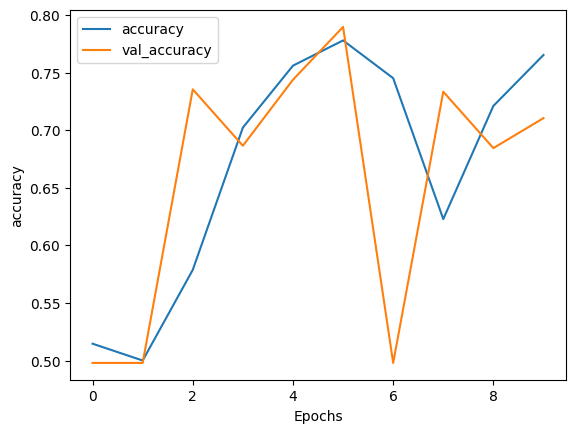

In [18]:
plot_graphs(history, 'accuracy')

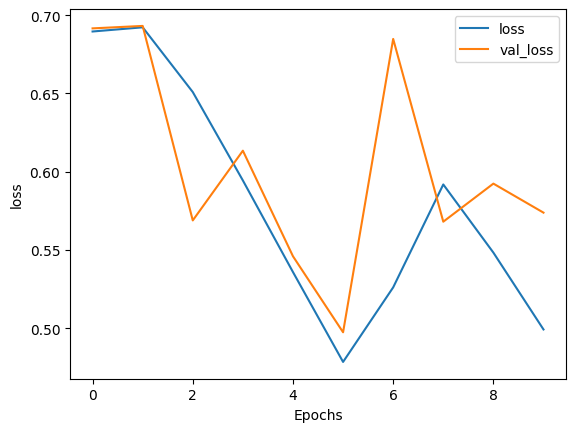

In [19]:
plot_graphs(history, 'loss')

检查其他现有循环层，例如 [GRU 层](https://tensorflow.google.cn/api_docs/python/tf/keras/layers/GRU)。

如果您对构建自定义 RNN 感兴趣，请参阅 [Keras RNN 指南](../../guide/keras/rnn.ipynb)。
